## Part 2 of: "learning the Q-values with a neural network" ##

In [102]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook as tqdm
tf.keras.backend.set_floatx('float64')
from misc import *
from collections import deque
from datetime import datetime
import random

In [103]:
def Prob(alpha, beta, n):
    p0 = np.exp(-(alpha-beta)**2)
    if n == 0:
        return p0
    else:
        return 1-p0

def qval(beta, n, guess):
    #dolinar guessing rule (= max-likelihood for L=1, careful sign of \beta)
    alpha = 0.4
    pn = np.sum([Prob(g*alpha, beta, n) for g in [-1,1]])
    return Prob(guess*alpha, beta, n)/pn


In [168]:

class Net(tf.keras.Model):
    def __init__(self, valreg=0.01, seed_val=0.1):
        super(Net,self).__init__()

        self.l1 = Dense(50, input_shape=(3,),kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
        kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg))

        self.l2 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))
        self.l3 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l4 = Dense(50, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

        self.l5 = Dense(1, kernel_regularizer=tf.keras.regularizers.l1(valreg),
    activity_regularizer=tf.keras.regularizers.l2(valreg),
    kernel_initializer=tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val),
    bias_initializer = tf.random_uniform_initializer(minval=-seed_val, maxval=seed_val))

    def call(self, input):
        feat = tf.nn.relu(self.l1(input))
#        feat = tf.nn.dropout(feat, rate=0.01)
 #       feat = tf.nn.relu(self.l2(feat))
  #      feat = tf.nn.dropout(feat, rate=0.01)
   #     feat = tf.nn.relu(self.l3(feat))
        feat = tf.nn.relu(self.l4(feat))
        feat = tf.nn.sigmoid(self.l5(feat))
        return feat

    def predict(self, history_one):
        inp = np.expand_dims(history_one, axis=0)
        return np.squeeze(self(inp).numpy())

    def __str__(self):
        return self.name


In [169]:
class DataSet():
    def __init__(self, rpbgo=10, nbetas=10):
        #rpbgo = rewards per beta-guess-outcome
        self.nbetas=nbetas
        self.rpbgo=rpbgo
        self.betas = np.linspace(-1.5,1.5,nbetas)
        self.size = self.nbetas*self.rpbgo*4.
        d = []
        for b in self.betas:
            for outcome in [0.,1,]:
                for guess in [-1.,1.]:
                    for k in range(self.rpbgo):
                        mean_bernoulli = qval(b, outcome, guess)
                        reward = np.random.choice([1.,0,],1,p=[mean_bernoulli, 1.-mean_bernoulli])[0]

                        d.append([b, outcome, guess, reward])
        self.data_unsplitted = np.array(d)

    def batched_shuffled_dataset(self,splits):
        datacopy = self.data_unsplitted.copy()
        np.random.shuffle(datacopy)
        datacopy = np.split(datacopy, splits + len(datacopy)%splits)
        return datacopy

In [199]:
def plot_results(histo_preds, mean_values, loss, title=None):
    plt.figure(figsize=(30,30
                       ))
    ax1 =  plt.subplot2grid((2,2),(0,0))
    ax2 =  plt.subplot2grid((2,2),(0,1))
    ax3 = plt.subplot2grid((2,2),(1,0),colspan=2)
    
    betas = np.arange(-1.5,1.5,.01)
    ax1.plot(betas_train,[mean_values[str(b)]["0"] for b in range(len(betas_train))],'--',alpha=0.85,c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,[mean_values[str(b)]["1"] for b in range(len(betas_train))],'--',alpha=0.85,c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,[mean_values[str(b)]["2"] for b in range(len(betas_train))],'--',alpha=0.85,c="red",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,[mean_values[str(b)]["3"] for b in range(len(betas_train))],'--',alpha=0.85,c="blue",  linewidth=5,label="Q(n1=1,"+r'$\beta$'+"; g=1)")

    
    for predictions in histo_preds.values():
        ax1.plot(betas_train,predictions["values"]["0"],alpha=0.5, linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
        ax1.plot(betas_train,predictions["values"]["1"],alpha=0.5, linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

        ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.5,  linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
        ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.5,  linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
    
    #Now we take the last and plot it in bold!
    ax1.plot(betas_train,predictions["values"]["0"],alpha=0.85, c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"])) #, label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=-1)")
    ax1.plot(betas_train,predictions["values"]["1"],alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=0,"+r'$\beta$'+"; g=1)")

    ax2.plot(betas_train,predictions["values"]["2"] ,alpha=0.85, c="black", linewidth=5)#, label="epoch: "+str(predictions["epoch_number"]))#label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=-1)")
    ax2.plot(betas_train,predictions["values"]["3"] ,alpha=0.85,  c="black",linewidth=5, label="epoch: "+str(predictions["epoch_number"]))#,label=r'$\hat{Q}$'+"(n1=1,"+r'$\beta$'+"; g=1)")
        
    ax1.scatter(betas_train,predictions["values"]["0"],alpha=0.85, c="black",s=150)
    ax1.scatter(betas_train,predictions["values"]["1"],alpha=0.85, c="black",s=150)

    ax2.scatter(betas_train,predictions["values"]["2"],alpha=0.85, c="black",s=150)
    ax2.scatter(betas_train,predictions["values"]["3"],alpha=0.85, c="black",s=150)

    ax3.plot(np.arange(1,len(loss)+1),loss,'--',alpha=0.85,c="red", linewidth=5)#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
    ax3.scatter(np.arange(1,len(loss)+1),loss,s=150,alpha=0.85,c="red", linewidth=5)#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")

    ax3.set_xlabel("epoch", size=20)
    ax3.set_ylabel("Loss",size=20)

    ax3.legend(prop={"size":15})

    for ax in [ax1, ax2]:
        ax.set_xlabel(r'$\beta$', size=20)
        ax.legend(prop={"size":15})
    if title != None:
        plt.suptitle(title, size=50)
    return

#def plot_loss(loss, title=None):
 #   plt.figure(figsize=(15,15))
  #  ax1 =  plt.subplot2grid((1,1),(0,0))
#
 #   ax3.plot(np.arange(1,len(loss)+1),loss,'--',alpha=0.85,c="red", linewidth=5)#, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
#
 #   for ax in [ax1]:
  #      ax.set_xlabel("epoch", size=20)
   #     ax.legend(prop={"size":15})
    #if title != None:
    #    plt.suptitle(title, size=50)
    #return

In [193]:
def training(splits_over_size=1.):
    net = Net()
    optimizer = tf.keras.optimizers.Adam(lr=0.001)

    dataset = DataSet(rpbgo=10,nbetas=10)
    batched_dataset = dataset.batched_shuffled_dataset(dataset.size/splits_over_size)

    net(batched_dataset[0][:,[0,1,2]]) #initialize the network

    print("batch_size: ",len(batched_dataset[0]))
    histo_preds = {} #here i save the predictions
    loss_ev = []

    ee={}
    ee["0"]=[]
    for k in net.trainable_variables:
        ee["0"].append(k.numpy())

    epochs=10
    for epoch in tqdm(range(epochs*splits_over_size)):
        losses=[]
        for mini_batch in batched_dataset:
            with tf.GradientTape() as tape:
                tape.watch(net.trainable_variables)
                preds = net(mini_batch[:,[0,1,2]])
                rew = mini_batch[:,3]
                loss = tf.keras.losses.MSE(rew,preds)
                loss = tf.reduce_mean(loss)
                grads = tape.gradient(loss, net.trainable_variables)
                optimizer.apply_gradients(zip(grads, net.trainable_variables))
                losses.append(loss)
        loss_ev.append(np.mean(np.array(losses)))
        
        batched_dataset = dataset.batched_shuffled_dataset(dataset.size/splits_over_size) #reshuffle

        ee[str(epoch+1)]=[]
        for k in net.trainable_variables:
            ee[str(epoch+1)].append(k.numpy())

        if (epoch % int(max(1,epochs/3)) == 0)|(epoch==epochs-1):
                histo_preds[str(epoch)] ={} 
                histo_preds[str(epoch)]["epoch_number"] = epoch
                histo_preds[str(epoch)]["values"] = {}

                index=0
                for n1 in [0.,1.]:
                    for guess in [-1.,1.]:
                        foo =np.array([[b,n1,guess] for b in dataset.betas]) #betas_train defined as global in create_dataset_l2()
                        histo_preds[str(epoch)]["values"][str(index)] = np.squeeze(net(foo))
                        index+=1

    differences=[]    
    for e1,e2 in zip(ee["0"],ee[str(epochs)]):
        differences.append(np.mean((e1-e2)/np.array(e1)))

    dataavg = np.split(dataset.data_unsplitted, data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABswAAAaVCAYAAACfxuq0AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzdeVzVVf7H8dflsnMFBMRdzIXF3bIsc4EsTUZT0rKmmmwxzaVtbKZtpqa9pk3LqMlxzH5OWhYtI2M1pqZpuSSpKKhl7goosotw7/398VUU7kVZ7xV4Px+P+8B7zrnn+/kKyr3fz/d8jslutyMiIiIiIiIiIiIiIiLSVHm4OwARERERERERERERERERd1LCTERERERERERERERERJo0JcxERERERERERERERESkSVPCTERERERERERERERERJo0JcxERERERERERERERESkSVPCTERERERERERERERERJo0T3cH4EphYWH2jh07ujsMERERERGpIxs3bsyy2+0t3B2HNF76HCkiIiIi0nic6zNkk0qYdezYkQ0bNrg7DBERERERqSMmk2mPu2OQxk2fI0VEREREGo9zfYZUSUYRERERERERERERERFp0pQwExERERERERERERERkSZNCTMRERERERERERERERFp0pQwExERERERERERERERkSZNCTMRERERERERERERERFp0pQwExERERERERERERERkSbN090BiIiIiIiIiDRUubm5ZGRkUFJS4u5QRGrMy8uL8PBwAgMD3R2KiIiIiNsoYSYiIiIiIiJSA7m5uRw5coS2bdvi5+eHyWRyd0gi1Wa32ykqKuLAgQMASpqJiIhIk6WSjCIiIiIiIiI1kJGRQdu2bfH391eyTBosk8mEv78/bdu2JSMjw93hiIiIiLiNEmYiIiIiIiIiNVBSUoKfn5+7wxCpE35+fiotKiIiIk2aEmYiIiIiIiIiNaSVZdJY6GdZREREmjolzERERERERERERERERKRJU8JMREREREREREREREREmjQlzERERERERERERERERKRJU8JMREREREREpImz2+3MmzeP/v37Y7FYCAwMJC4ujiVLljgd26dPH95///1qH2fXrl1MmjSJXr16YTabiY2NrYPoaz/vli1biI+PJzQ0lNDQUBISEsjIyKiT2OpLVc952rRp3HXXXa4NTkRERKQBUsJMREREREREpImbMmUKd999N/379ycpKYlFixbRoUMHRo4cyeuvv15u7EcffcSxY8f4/e9/X+3jpKamkpycTFRUFJGRkXUVfq3mPXDgAHFxcZhMJhYsWEBiYiLfffedw3lfaKp6zjNmzGDBggXs2rXLhdGJiIiINDye7g5ARERERERERNzns88+45133iExMZHJkyeXtY8YMYJWrVrx8MMPM3ToUHr16gXArFmzuO222/Dy8qr2sUaNGsXo0aMBGDduHFlZWXVyDrWZd9asWQQGBvLpp5/i4+MDwNy5c8nLy6uT2OpLVc+5Y8eODBw4kMTERF599VVXhigiIiLSoGiFmYiIiIiIiEgTNnPmTLp06cLEiRMd+h577DEsFgtvvfUWYJQBXLNmDePGjSs3bsKECfTr149vvvmGXr16ERAQwMCBA0lNTS03zsOjfi5D1GbeJUuWkJCQUJYsy87OZvXq1Vx66aXVnuutt96iffv2BAQEMGbMGJYtW4bJZGLFihU1jq8y1TnnsWPHsmDBAmw2W53HISIiItJYaIWZiIiIiIiISF168004lWCqtfT0c/dHRZ3587RpMH16taYvLS1l7dq1TJkyBbPZ7NAfFBREXFwcK1euBGDZsmUEBATQu3dvh7F79+7l4Ycf5vHHH8fPz48ZM2Ywfvx4tmzZgslkqnJMdrsdq9V63nGenrW/pFFQUMD27dt54oknyMvLIyUlhRkzZtCuXTvGjx9fNm7FihXExcWxfPnySvcKS0pKYvr06UyZMoXRo0ezevVqp3uHufL8ThswYABHjhxhy5YtTr93IiIiIqKEmYiIiIiIiEiTlZWVRXFxMREREZWOiYiI4OuvvwZg48aNxMTEOF3ddOzYMb7//nu6du0KgM1mIyEhgfT0dKKjo6sc0/vvv88dd9xx3nF2u73Kc1Zm8+bN2Gw2+vbtS0REBNnZ2fj4+LBixQp8fX3LxplMJsxm8zkTf88//zzx8fHMnj0bgGHDhpGVlUViYmK5ca48v9O6d++O2Wxm3bp1SpiJiIiIVEIJMxERERERERE5p9OJosOHDxMWFuZ0TMeOHcuSZQDdunUDYP/+/dVKmI0aNYr169fXItqqS0lJwWKx0KlTJxYvXszOnTt54403+N3vfkdqaiqtWrUCYMiQIZSWllY6T2lpKZs2bSpLlp123XXXOSTMqnt+FVeknU7eVYenpyfBwcEcPny4Wq8TERERaUqUMBMRERERERFposLCwvDx8WHPnj2VjtmzZw+tW7cG4MSJE/j7+zsdFxwcXO65t7d32WuqIyQkhKCgoGq9pqY2bdpE79698fLy4qqrrip7REZGsnLlynJlGc8lKysLq9VKixYtyrVXfA7VP7+VK1cSFxdX9nzIkCE12hPNx8en2t8LERERkaakfnbbFREREREREZELnqenJwMGDGDJkiXYbDaH/tzcXFasWMGAAQMAI9lz/Pjxeo3p/fffx8vL67yPupCSkkLfvn3LtZ0uxdiyZcsqzxMWFobZbCYzM7Nce8XnUP3zu+SSS1i/fn3Z4913363OKZY5fvw4ISEhNXqtiIiISFOgFWYiIiIiIiIidWn6dOPhCunptZ7ivvvuIyEhgTlz5nDPPfeU63vxxRc5fvx42Z5bUVFRrF27ttbHPBdXlWS0Wq1s3bqVUaNGlWtfsGABISEhDBw4sMpzeXp60rdvXz7//HMmTZpU1v7FF184jK3u+TVr1ox+/fpVebwzmZmZFBYWEhkZWat5RERERBozJcxEREREREREmrAxY8YwefJkpk6dyrZt2xg5ciSlpaUsWrSIefPmMW3aNGJjYwG48sorefrpp8nMzHRabvB8CgsLSU5OBuDAgQPk5uayePFiAOLj4/H39yc0NJTQ0NA6n3fFihXExcWxfPlyYmNjSUtLo6ioiJdffpnQ0FBiYmJYvXo1zz33HImJiXh6nrlkUvG1zjz66KOMHTuWadOmcd111/H999+zZMkSADw8zhT4qcn51fScT9uwYQMmk6lspaCIiIiIOFLCTERERERERKSJe/vtt+nfvz+JiYm89957FBYWAsYKsz/96U9l42JjYwkJCWHp0qXcdttt1T5ORkYGN9xwQ7m20893795Nx44daxR/VeY9fU7h4eGAUY7Ry8uLhIQEHnnkEUwmEzExMSxYsICxY8eWm6via525/vrrmTVrFi+99BJz584lNjaWV155hRtvvJHAwMAande5VOfvcunSpQwZMqROEnUiIiIijZUSZiIiIiIiIiJNnMlkYsKECUyYMAEwViz169ePlStXMmPGDMxmMwDe3t7ceuutLFy4sFzCbN68eQ5zduzYEbvdft62ulCVeX/88UdiY2Pp1q0bYCTMYmJimD9//nnnr/jaykyfPp3pZ5XjfPbZZ/H19SUqKqoKZ1E9Vf27tFqtfPLJJ7z44ot1HoOIiIhIY6KEmYiIiIiIiIiU07ZtW5KSkoiNjeW+++5j9uzZZX0PP/wwkZGR7Nixo0HtibVmzRoeeuihsuebNm2ib9++NXqtM5mZmbzwwgvExcXh7+/PqlWreOmll7jrrrvw8/OrVey18fHHH+Pn58dNN93kthhEREREGgIlzERERERERKTBM5lMc4GRQIbdbu/hpN8EzATigUJggt1u/8m1UTYsl19+OSdOnHBob9euHXPnzuXQoUMNKmH2zTfflHv+888/M3LkyBq91hlvb2/S0tKYP38+OTk5tG7dmvvvv59nnnmmRvHWFbvdzj//+c9ye7KJiIiIiCO9WxIREREREZHGYB7wFlBZfb0RQNdTj/5A4qmvUgONYbVSZmZmnc4XFBREcnJync5ZF26++WZ3h9CoJSXBf/4Dx46daRs3Dm65pfLXfPwx/PvfdXP8xYvhVMVUp8aOBZut9sepy3MKDIRRo4w5RerEnj3w5pvw66/grFTtkCHwwAOVv37FCpg5s25iefttaN268v5774XDh2t/nNqek8kEXbvC/fdDmza1j0ekkVDCTERERERERBo8u93+nclk6niOIaOB+XZj06cfTCZTsMlkam232w+5JEARaXSWLIFHHnFsP18uNjMTtm2rn5gq2r4drNbaz1PX5/TDD+DlBaNH1y4uEdatgylTIC+v8jFdupx7jpycuvtHWVJy7v6dO2Hfvtofpy7OKTUVNm2C5GTQKmQRADzcHYCckZ+fz+HDh8nPz3d3KCIiIiIiIo1NW+DsK1T7T7WJiFSb3V53C1Kaqs8+c3cE0uAtXQp33nnuZJmc25498P337o5C5IKhhJmblZaWsmTJEuLj44mMjOTSSy8lMjKS+Ph4lixZQmlpqbtDFBERERERaVJMJtM9JpNpg8lk2lDXZftEpHFISTGuM0vN7d7t7gikQfvgA6Mk4flWdMn5rV7t7ghELhhaa+lGubm53HLLLaSkpGC327FYLHQ+eRJvDw+KNmxg1p138lVUFM8//zwWi6V6kzdvDhERlfdnZ9fdO7voaPD1rbx/+3YoLq79cc53TiIiIiLncfSoUQElLAzatat8XFYW7N9fN8fs0ePcFU62boW6uEeqPs5Jb7+kkTkAtD/rebtTbQ7sdvs/gH8A9OvXz8lmKCLS1CUluTuChu/QIThx4tyXlEQc2Gzw6qswZ467I2k8Vq1ydwQiFwwlzNyktLSUW265hZ9++omAgADMJjM2bDyamUn7U3dG2AH7mjUcv/ZaAtq2xVSdA4wYAW+8UXn/2rXw4IO1OYUzkpOhc+fK+x96yNh0s7bOd04iIiIi5zBrFsyebfz55pvhqacqH/v11/C3v9XNcdesgdDQyvsnToRjx2p/nPo4p9/9Dl57rVZhiVxIvgCmmUymhUB/IEf7l4lITZw4YexfVtHDD8MVV0CLFud+/Q03wJAhdROLx3lqR338cd0cpy7O6Z57jBt4zrZ///m3YhIpU1ICjz4KX37pvL93b3j8cce71YKDzz3vkCHw6ad1E2OrVufuT0yEkydrf5yanlNREdx6q1FX9rTdu41/jOe6+06kiVDCzE2++uorUlJSCAgIwISJ7MNH8TZ78oZfKN18obO9lM4ni2hdXEBxcTEFBQVYAgLcHbaIiIhIg5SaeiZZJiKNk8lk+hCIBcJMJtN+4EnAC8But78DJAPxwC6gELjDPZGKSEO3bBlU3H7e3x9uuQX8/M7/+hYtzp+Aqivdu7vmOFU5p06dHBNme/cqYSZVVFAA06YZd6M5ExcHr79etX+EFQUHnz8BVVe6dnXNcc51Tj16wJYt5dtWrTLuwBNp4pQwc5PZs2djt9sxmUz44IXVWkqRtZSfbDZ+Pmucj4+Fjl5+dC324hIfH6LN0M1UggWb22IXERERaWi0qbxI42e32895lcdut9uBqS4KR0QaMWeLNq69tmbX6ZuSDh1g3brybXv3uicWaWCysoyyDNu2Oe+/8Uaj1ILZ7NKwGqxBgxwTZqtXK2EmghJmbpGfn09KSkrZvmSetsrXzxfbbKQXF5BWnE9yUU5Zeztff6J8A4jx9ibabKKbh5W29hI8TNUq3Ni4ZGXB8uVGHQARERGRU2w2WLq0fNvmzbBhA/Tr556YREREpGE6csT5ApeEBNfH0tA42xd1zx7XxyENzN69MGECHHC67Sjcdx9MmQJN+ZpodQ0aBG+/Xb5t7Vqj5KWXl3tiErlAKGHmBvn5+ZjNZkyn/iO3l55ZLWYzlS8he4YJj7Nes7/0JPvzT7LsrBEWL2+iAkOICgwkJquQmB9+IrJnNH4B/o7TBQcbdX3rgo/Pufujo6FZs9of51w7zh89CrffDrt2GZuATJpU++OJiIhIo7BxI2RklG9LTYXIyMpfExpad2+VKm6hUFH37pCbW/vjnG/LgZqc07nefomIiDRFX3xh3IxztnbtdBNOVTh7X6EVZnJegYHOrz2azcYGvbpxvvp69zau1eblnWkrKIBNm+Cyy9wXl8gFQAkzN7BYLFit1rKSjDabDZPJhN1up8jkAU5uiLDb7QQ3a3bOuyXygY0nC9iYVQArD8HKZZg9PIho24GorlFER0fTrUc3ul3ck/ABA2DAgPo7ybO9/nr9zp+dfSZZBsbO9FarcXeJiIiINHn//a9jW1yc8dm7MsOHGw9XmDPHNcdx5TmJiIg0Rna783KMY8aAR+XFg+SUyEgYNcoozRgRYXzt2NHdUckFLzgY/vlPo+xiZqbR5usLb7xhvKmX6jObjevCX31Vvn31aiXMpMnTr3M3sFgs9OnTh8LCQgBO+Fpp3jqMNm3a0r5VO9qGtSa0WXO8PY0lsHbsmD09y1aXVYfVZuPXfb/x32+/4vW3ZzJxyiSuvHwA/Xv04w+jb+a5h//GJ/M+Ii0llZKTJXV6ni6Rn28sy965s3z7zJkwa1Zly/VERESkibBaHT8HAowY4fpYREQuZHa7nXnz5tG/f38sFguBgYHExcWxZMkSp2P79OnD+++/X+3j7Nq1i0mTJtGrVy/MZjOxsbF1EH3t592yZQvx8fGEhoYSGhpKQkICGRWXJ7tRVc5v2rRp3HXXXa4PrgnZvBl+/dWxfcwY18fSEF10EbzyilFBb/Ro6NsXmjd3d1TSILRpA++9BwEBxg/N/PlKltXW4MGObatWuT4OkQuMVpi5ydSpU5k8eXLZKjNMcIKTYMZ4+HgS0CyI5nhCsY1rrrqa4uJi0nams+9wJTV7q+FYTjZrf1rH2p/O7Lbq5elJ54hORHeJJKpbDN16dqf7xT0ICr2A3734+0PPnpCW5tg3e7ZRJ+H++1XHWEREpIlav97Y5vRs3t4wdKh74hERuVBNmTKF9957jylTpvDss89SWlrKwoULGTlyJK+99hoPPvhg2diPPvqIY8eO8fvf/77ax0lNTSU5OZnLL7+ckpK6u2mzNvMeOHCAuLg4+vfvz4IFC8jNzeXee+/l9ddf54UXXqizGGujKuc3Y8YMoqOjefTRR+nSpYuLI2wakpIc2y69FNq3d30sIk1OTAy88w6Eh2tpYl0YOND46uNjrCobPPhMm0gTpoSZmwwfPpw+ffqwceNGLBZLpavHjuUfp1+/fvz9vTfwPLUBRn5OHtt/3kba5lS2b9tO2o50dv32C0XFJ2oVU0lpKWm/7CDtlx3w1X/K2luFhRPVOZLo6BhiesQQ07s7EZEXYTaba3W8OuHhAU8/bWwO8uGHjv2JiVBaCn/8o5JmIiIiTZCzcoyDBoHF4vpYREQuVJ999hnvvPMOiYmJTJ48uax9xIgRtGrViocffpihQ4fSq1cvAGbNmsVtt92Gl5dXtY81atQoRo8eDcC4cePIqnhXQw3VZt5Zs2YRGBjIp59+is+pfXLmzp1L3tl7u7hZVc6vY8eODBw4kMTERF599VVXh9joFReDkwWXJCS4PhaRJkvlAutOq1bwwQfQq5dR4lJEAJVkdBtPT08WLFjAJZdcQlFREQUFBdhPlQ+02+0UFBRQVFREv379+L//+7+yZBmAJagZlw7uz23T7uT5t//Op//7gp+2/8zSr5by+suvMvEPdzK4/5W0DG1RJ7Eezspg5Y+reff993jg4YcYPmw4faN6Mfaa0Tw+9U988NZc1n/3IwW5+XVyvGrz8IAnn4Rbb3Xe/9578PLLKs8oIiLSxFRWjjE+3vWxiIhcyGbOnEmXLl2YOHGiQ99jjz2GxWLhrbfeAozSgGvWrGHcuHHlxk2YMIF+/frxzTff0KtXLwICAhg4cCCpqanlxnnU00ZPtZl3yZIlJCQklCXLsrOzWb16NZdeemm153rrrbdo3749AQEBjBkzhmXLlmEymVixYkWN44Oqn9/YsWNZsGABNputVscTR99+C7m55dv8/ODaa90Tj0ijUlQEf/+78VVc57LLlCwTqUArzNwoMDCQpKQkvv76a2bPns2mTZswm81YrVb69u3L1KlTGTZsWLlkWWU8vTzp3K0rnbt1ZSRnimcfyzjK9pRUtm1OJT1tO2k7d/DLnl8ptVprFXtR8Qk2p21lc9pW+MJoM5mgXat2RHeJJDo6mugeMXTr04M2HdvV24eiMiYTPPGEkTybP9+xf+5cY6XZY49ppZmIiEgTsXYtZGeXb/Pxgauuck88IiIXotLSUtauXcuUKVOcVhEJCgoiLi6OlStXArBs2TICAgLo3bu3w9i9e/fy8MMP8/jjj+Pn58eMGTMYP348W7Zsqdae3Ha7HWsVPrNW5bPy+RQUFLB9+3aeeOIJ8vLySElJYcaMGbRr147x48eXjVuxYgVxcXEsX7680v3RkpKSmD59OlOmTGH06NGsXr3a6Z5i9Xl+AwYM4MiRI2zZssXp90hq7pdfjEsOZ+cihw0ztlQSkVo4dgwmTTI2Cdy5E95+26gkJSLiBvrfx808PT2Jj4/niouHcKL4BHidpFlgMyx1VCcoJDyUK4cN5sphZzZyLDlZwq6t6aT+vJW01DTSd6SRtmsHx/NyanUsux32HdrPvkP7+WbVt2XtzQIsRHWKJDoqkuiYbsT07k5Urxh8/Hxqdbz8/Hzy8/OxWCzG35fJZCTEPD2NBFlF8+cbt5r/5S9KmomIiDQBzsoxxsYaW6CKiNSnN9+EUwuyai09/dz9UVFn/jxtGkyfXr35s7KyKC4uJiIiotIxERERfP311wBs3LiRmJgYpzdFHjt2jO+//56uXbsCYLPZSEhIID09nejo6CrH9P7773PHHXecd5y9DqqIbN68GZvNRt++fYmIiCA7OxsfHx9WrFiB71l33ZtMJsxm8zkTf88//zzx8fHMnj0bgGHDhpGVlUViYmK5cfV5ft27d8dsNrNu3TolzOrYtGlw443wxRfGXma7dqkco0it7dsHd90Fe/YYz1euhL/+FZ57TtfuRMQtlDC7ANjtdvamHqO4sASzlweBYR4Eh9sJauGHt1/df4u8vL2IubgHMRf3KGuz2WxkHDjMtk2pbN+6jbS07aTv3MGeA3ux1fJDSF5BPhu2/MSGLT+VtZk9POjYLoLorlFERUfTrVd3uvXtQYvW4eecq7S0lK+++orZs2eTkpJStiKvT58+TJ06leHDh+P5pz+B2WyUYqxowQLjdrC//tW4NUxEREQapZISOHVttxyVYxQRqZnTiaLDhw8TFhbmdEzHjh3LkmUA3bp1A2D//v3VSpiNGjWK9evX1yLaqktJScFisdCpUycWL17Mzp07eeONN/jd735HamoqrVq1AmDIkCGUlpZWOk9paSmbNm0qS5addt111zkkzOrz/Dw9PQkODubw4cP1Mn9TFx4Od99tXN/ftg1iYtwdUeNgs+kSTZOUmgr33AMV92T85BNo2RLuv989cYlIk6aE2QWguKCU4sISAKwlNrIPFZB9qAAA/0BvgsL9CQr3w9LcFw+P+rm7wsPDg1bt29CqfRuuuu6asvbC/AJ2bE5j+5ZtbE/dTlp6Gjt276SgqLBWx7PabPyydze/7N3NkmVLy9pDg0OI6tyV6OhoYrp3I6ZXNzp3i8TTy5Pc3FxuueUWUlJSsNvtWCwWTCYTdrudzZs3M3nyZPr06cOCBQsI/OMfjZVmFT6YAPDhh0Z5xqef1jsyERGRRmrNGuf7jAwZ4p54REQuVGFhYfj4+LDn9N39TuzZs4fWrVsDcOLECfwrWaobHBxc7rm3t3fZa6ojJCSEoKCgar2mpjZt2kTv3r3x8vLiqquuKntERkaycuXKcmUZzyUrKwur1UqLFuX3Eq/4HOr//Hx8fKr9dy7VYzJB9+7ujqJhstmMyzJ79sDevcbXI0dg/Xrj3mdpIlavNpZEFzq5vujtDdW4yUJEpC4pYXYBOJ5RefKpMPckhbknObTr+KnVZ34En0qgefvW/7fP3xJAnwGX0GfAJWVtNpuN/b/sYVtKKtu2biM9LY30XTs4kHGo1sc7evwYazb+yJqNP5a1+Xh5c1GHjhzLPEpOXi6hvsEUm0qwmYyVbyaTiYCAAOx2Oxs3buSWW24hKSkJz/vvN95tOauF8vHHxru0Z57ROzIREZFGyFk5xrg4I2kmIiJneHp6MmDAAJYsWcIrr7ziUGoxNzeXFStWcN111wFGsqe+Vy+5siRjSkoK/fv3L9d2uhRjy5YtqzxPWFgYZrOZzMzMcu0Vn0P9n9/x48cJCQmp0WtF6puHB8ycCTkVdgU5fBjatnVPTOJin31mbKnibC/HwEDj5vd+/Vwfl5yRkQHNmunDkzRJSphdAHLOkTA7m8PqsyAfgsP9CAr3xxLsg6meVp9V5OHhQYeuF9Gh60Vce8PIsvbcYzlsS9lK2pZtbN+WRvrOdHb99gvFJSdrdbzikpNs3r6VgoJ8TJw5R38fP4ItQVh9oQQrJpMJi8VCSkoKX3/9NfHx8cbdKh4eMGuW48SffGL8cn7+eSXNREREGpGTJ+F//3NsVzlGERHn7rvvPhISEpgzZw733HNPub4XX3yR48ePlyV4oqKiWLt2bb3G46qSjFarla1btzJq1Khy7QsWLCAkJISBAwdWeS5PT0/69u3L559/zqRJk8rav/jiC4ex9Xl+mZmZFBYWEhkZWS/zi9SFDh1gy5bybXv3KmHW6NntxvYpr77qvL9VK5gzB84q7SsucvIk/PQTrFplPNLTjWupw4e7OzIRl1PC7AIQ1r4ZZi8zOZmFWEtsVX5dYU4xhTnFHNx5HE9vs7H6rKUfQS388fJxfQIoMCSIy6+6ksuvurKsrbSklF+372T75m1s37qN9B3ppO3aQVb20WrN7aycRGFxEYXFRfh4edOiRTiFpuKyEo2zZ882EmYAU6caCbHXX3ecODkZ7rhDS71FREQakdWrIS+vfJu/Pwwa5J54RKTpmT7deLhCenrt5xgzZgyTJ09m6tSpbNu2jZEjR1JaWsqiRYuYN28e06ZNIzY2FoArrxuqP1QAACAASURBVLySp59+mszMTKflBs+nsLCQ5ORkAA4cOEBubi6LFy8GID4+Hn9/f0JDQwkNDa3zeVesWEFcXBzLly8nNjaWtLQ0ioqKePnllwkNDSUmJobVq1fz3HPPkZiYiKfnmUsmFV/rzKOPPsrYsWOZNm0a1113Hd9//z1LliwBKLdyr77OD2DDhg2YTCYGDBhQrflFXCkiwjFhtmcPXHGFe+IRF7Ba4bnnYMEC5/1duxrJslP7RoqLvfii4/dm1SolzKRJUsLsAhDa1kJoWwt2m53848UczygkJ6OIwpziKs9RetLKsYP5HDuYD0BAsA9B4f4Eh/sREOS61WcVeXp5EtkrhsheMYxmbFl71uFMtm3aaiTRtqexfUcau/f9htXmmDC02+1YS0vLNpmuqLjkJPsPHaB9eBvyzcX4+/uzadMm8vPzsVgsxqDJk409zf7+9zMv9PIylnkrWSYiItKo7N5t3CtzdpWXoUPhVIUtERFx4u2336Z///4kJiby3nvvUXhqX5kXX3yRP/3pT2XjYmNjCQkJYenSpdx2223VPk5GRgY33HBDubbTz3fv3k3Hjh1rFH9V5j19TuHh4YBRjtHLy4uEhAQeeeQRTCYTMTExLFiwgLFjx5abq+Jrnbn++uuZNWsWL730EnPnziU2NpZXXnmFG2+8kcDAwBqdV3XOD2Dp0qUMGTKk2gk5EVfq0MGxbe9e18chLlJcDDNmwNdfO++/7DKYPdsoxyjuceWVzhNmdruxaaNIE6KE2QXE5GGiWYgvzUJ8aR8NJ4tKycks4nhGIblZRdVafVZwvJiC48Uc3JGNp7eZoBZG6cagcD+8vN1ffjCsVQsGj4hj8Ii4srbiomJ2pqax/edUtm/dRtqOdNJ/3cnx3Bw43//Ndjv7jhygZXALrAEemM3m8gkzgLvvNq6evfiikTybPRuqUWJDREREGoa77oJx44yyjMnJsHatyjGKiJyPyWRiwoQJTJgwATBWMfXr14+VK1cyY8YMzKfK2Ht7e3PrrbeycOHCcgmzefPmOczZsWNHh324nLXVharM++OPPxIbG0u3bt0AI2EWExPD/Pnzzzt/xddWZvr06Uw/a3nhs88+i6+vL1FRUVU4i8pV5fysViuffPIJL774Yq2OJWc8/TSEhMCYMdCunbujaTwiIhzb9uxxfRziArm5cO+9sGGD8/4RI+Dll8Hb27VxSXmXX+54x+Hhw7Brl0pkSpOjhNkFzNvPkxYdmtGiQzNsNjv5x06Qk2Ek0Iryqr4vWOlJK0cP5HP0QD6YTFiCfQgKN0o3BgR7V7pyy9V8/Hzo0a83Pfr1Lmuz2Wz8mraLUcNH4uvpQ0nJSQpOFJJfXABOPiscOZ6J5UQAPr6e5ZNlp91xh5Esa9sWhgypx7MRERERdwoKgrFjjUd2Njh7WyAiIpVr27YtSUlJxMbGct999zF79uyyvocffpjIyEh27NjRoPbKWrNmDQ899FDZ802bNtG3b98avdaZzMxMXnjhBeLi4vD392fVqlW89NJL3HXXXfj5+dUq9qr4+OOP8fPz46abbqr3YzUFWVmwcKFx/fjNN41FMGPGwOjRxmUFqTklzJqIgwdh4kQj6eLM7bfDI4/AWSVrxU0CAuCSS2DduvLtq1crYSZNjn7FNxAeHiYCw/wIDPOjfbcQiotKyTlVujEnqwhbaRVXn9nt5GefID/7BAfSs/H0MRPcwv9UAs0Pzwtg9dnZPDw86NItkot6dmHz5s0EBATgHeBPuL0Z1rxijuZlO7wm70Q+fnZfVnz5P0bePMZx0hqUDREREZGGq3lzd0cgItIwXX755U73k27Xrh1z587l0KFDDSph9s0335R7/vPPPzNy5MgavdYZb29v0tLSmD9/Pjk5ObRu3Zr777+fZ555pkbxVpfdbuef//xnub3XpOb+85/yiy3WrTOSOmOcXGaQ6nFWknHfPrDZlDtpNHbsMCo9HTnivP/Pf4Y773RtTHJugwY5JsxWrTIWH4g0IXoX1UD5+HkSHhFIeEQgNquNvGPF5GQaCbRqrT4rtpK1P4+s/XnG6rPmPgSHG+Ub/QMvnNVnU6dOZfLkydjtdkwmE6UmKzTzpK1vGw5kHnQY7+HpyYN/+iM///Qzf37+cTy9avCjbrUay5FFRERERESknMawiikzM7NO5wsKCiI5OblO56yOm2++2W3HboySkhzbxozRZYK6EBJiLGgpKDjTduIEZGZCy5bui0vqSEEB/OEPRpmHijw9ja1SRo1yfVxyboMGwauvlm9bvx6KisAFq6RFLhS6b6MR8DB7ENTCjw7dQukZ247eQ9sT0TOM4Fb+eJir8S22G2Uf96dlk/rdAVK+2cevKZkcPZhPaYn1/K+vR8OHD6dPnz7k5+efqdtugiLvEtq3boen2UiI2e12PM2eeHt5ATBv4XxuG30zmYcyqnfAuXNh0iRjY1IRERERERERaTK2b4e0NMf2hATXx9IYmUzOV5nt3ev6WKQeBAQYpRadtc+Zo2TZhSoqCsLCyredPGkkzUSaECXMGiEffy9adgwk8tJWXDy8A1GXt6JlpyB8LV7VmqekuJSsfXn8sjGDTV/vZfuagxzcdZyCnOJ62aT5XDw9PVmwYAGXXHIJRUVFFBQUlMWQbzpBs6BmBPj44+npiaWZxXj3dcqGLT8x5tpRbFi1rrLpy3v/fXjpJWPZ8b33Grc5iYiIiIiIiEiT8Omnjm19+sBFF7k+lsZKCbNGbswYOHvfx7AwWLAArrjCfTHJuXl4wMCBju2rVrk+FhE3UsKskTNWn/kT0T2UXnHt6XVVeyJ6hBEU7o+HuerlFu02O3lHT7B/+zFSvzvAz8v2sfvnTI4dKsBaUsX902opMDCQpKQk3n33XXr37k1+fj6FhYXk5+fTtWc0r70zk9EjrsNkcvyxzjiWxW233coHb83FZjtHvP/3f/D882eef/+9sdKsqKgezkhERERERERELiQlJfDll47tWl1WtyIiHNv27HF9HFKP7rkHfv97I9P80UcQE+PuiOR8Bg1ybPvuO9fHIeJG2sOsifEN8ML3Ii9aXhSI1WojL+sEOZlFHM8opLigpMrznCwqJXNvHpl78zB5mLA09y3b+8yvmVe97X3m6elJfHw88fHx5Ofnk5+fj8ViwWKxADBmbALvvPQWMxNnYauwCq7UauXpl57j55QUnpn5In4B/uUn37u3fLLstB9+MH7Jv/su+Ps79ouIiIjbrVwJGzZAfDxER5dbbC4iIiJSZd9957j1kre38R5D6o4SZk2AyQRPPGHsaRYY6O5opCquvNL4vp19TfW332D/fmjXzm1hibiSVpg1YWazB8Et/YnoEUrvq9rTK649HbqHEtTCrwarz4rYt/0YW1fu5+dl+/htcxbZhwuwltbf6jOLxUKrVq3KkmUAHh4eTHn0Pub8Yw7BzYKcvu7zr5Zw4+/Gsnfn7vIdHToYm1s628F33TqYOLH8jrQiIiJywfjoI/jHP4zqL9deCzNnwsGD7o5KREREGpqkJMe2q6/W9f66ppKMjUBp6fnHmM36x9OQNG8OPXo4tqssozQhSphJGV+LF606BRF1eWv6Dosg8rJWhHcMxMe/enufnSwqJWNPLjvXH+Gnr/aQ9sMhDv+aQ1HeSZftfTbo2liS/vMZ3bs6X+6d9ssOxowaw4ov/1e+Y8QIeP1150mzDRvgrrsgP78eIhYREZGays8vXynkt9/g7bdh3z63hSQiIiIN0LFj8O23ju3XX+/6WBq7ylaYueiykdRWZiaMGweffOLuSKSuOSvLqISZNCFKmIlTZk9j9VnHnmH0uqodPWPb0aF7KIEt/DB5VG/1WW5mEXtTj7JlxX42f7uf37ZkcfxIYb2uPgNo16kDC/+zmHEjnRcazyvI556pk5j19CtYrdYzHcOHw6xZ4OmkYummTUbSLC+vnqIWERGR6lq2DE6eLN8WFgb9+rknHhEREWmY/vMfOPvyAECLFjBggHviacxatABf3/JtBQVG0lIucL/+CjfeCNu3w1/+YtRGl8Zj8GDHtrVrjQ0eRZoAJczkvEwmE37NvGnVKYjoy1tz8bAIul7akvCIQLz9qrcNXnFhCRm/5bJj3WE2fb2H9FOrz07k189/ur7+vryQ+ArP/uVpvD0dV8rZ7fDme4lMGn8nOUePn+m4+mp4803wcrK6LiUF7rgDcnPrJWYRERGpnv/+17Ft+HDnC8ZFREREKvPZZ45to0frPUV98PCA9u0d21WW8QK3aRPcdNOZ2udWK9x/P2zZ4t64pO706gXNmpVvKyw0vvciTYASZlJtZi8PmrcKoGOvMHoPbU+PIe1oHxNCs9DqrT6zWe3knFp9tnn5Pn7+dh97th41Vp9Z63b12fh7buHDhR/SukVLp/0rf1xNwrXXse2ns37BX3UVzJ5t7O5b0ZYtMGEC5OTUaZwiIiJSPbm5ziuExMe7PhYRERFpuNLTITXVsT3BedEaqQPax6yBWbYMbr/d8VpYUZGRNKvKnmZy4TObnS+rVVlGaSKUMJNaMZlM+Ad607pLMDEDjNVnXfq1pEWHZnj5VnP1WUEJR3bnGKvPvtpD+o+HObI7lxMFdbP6rFf/viT99wuuuPgyp/37Dh9g/A3jSZr/8ZnGIUMgMdF50iw11XijcPy4Y5+IiIi4xDffOH42Dw+Hiy92TzwiIlI7K1aswGQysXXr1jqb8/PPP6dnz574+vrSrVs3Fi1aVGdzS+ORlOTY1rMndOni+liaiq5d4aKLIDYW/vAHeOIJ6N3b3VGJUwsXwrRpUFzs2BcSAjNnOt/aRBomZ2UZlTCTJkL/k0mdMnt5ENI6gJDWAdjtdgpzT5KTWURORiH52cXYbVXbvdVmtZOTUUhORiEAvhYvgsL9CQ73o1mILx7mmuV6Q1uGMXfxB7z21Eu8N3+uQ/+Jk8X86fFH+HlTCo+/9BRe3l4wcCC8+y5Mnuz4xmD7duNd3bx5xhsEERERcSln5RivvdYo8yMiIrJ69WrGjh3LlClTmDVrFsnJydx88800b96cYcOGuTs8uUCUlsKXXzq2X3+962NpSh580HjIBcxuh1mz4O23nfd36ABz5kBEhGvjkvo1cGD55z4+xsaDpaVKjEqjp59wqTcmk4mAIB8Cgnxo0yWY0hLrqeSZ8SgprvpS7RP5JZzIz+HIrzl4mD0IDPMlKNyf5i39q72PmqeXJ3967nF69+3Dnx97hIKiQocxCxYvJHXbNt7659u0bNfaWIr8j3/ApElw4kT5wenpZ5JmYWHVikVERERq7vhxWLPGsV3lGEVE5LRnnnmGwYMHM2vWLADi4uJITU3l6aefVsJMyqxaBVlZ5du8vOB3v3NPPCIXhNJS+Otf4ZNPnPf36GFcKwsNdW1cUv9atYKrr4Z27WDQIOjXD3x93R2ViEvo3ltxGU8vM6FtLHTq04I+17Sn++C2tItujiXEF0zV2fvMxvEjhezZksXP3+5jf9oxbFVcuXa24eN+xyeffUrnDhc57U/ZtpnRI67jxxWnrsRdfjm89x74+TkO3rnTSJodO1btOERERKRmvvnG2Gf8bK1bq5SPiEh1rVq1iiFDhuDv709oaCgTJ04kLy+vrH/evHmYTCbWr1/PoEGD8PPzIzIykiQnNezeeustunbtio+PD126dOH11193GLN582ZGjRpFcHAwFouFyy67jG+++abcmKysLG644QYsFgudOnXi7cpWN5xDcXExy5cv58YbbyzXftNNN7F27VpytCe1nOKsHONVV0FQkOtjEbkgFBXBlCmVJ8sGDYIPPlCyrDGbPRsefdRYbaZkmTQhWmEmblFu9VnX5pSePLP67HhmIaXF1vNPAthtdg7uPE5u1gk69W2Bb4BXteLo3K0rn/z3M/48dQZfrfjGof/o8WPcfvvtPPzADO64fyIel11mLDWfOBEKK6xMi4iAZs2qdXwRERGpueRkx7YRI1SOUUTcaPkL7o7gjLhHqzTs+++/5+qrr2bMmDEsXryYo0eP8sgjj5Cdnc3ixYvLjR0/fjxTpkzhscceY86cOdxwww1s3LiR3qfuVHjvvfeYPn06Dz30EMOHD2f58uX88Y9/pLi4mEceeQSAtLQ0rrzySqKionjnnXcIDQ1lw4YN7Nu3r9yxJk6cyO23384999zDhx9+yNSpU+nXrx+XXWbsSb1ixQri4uJYvnw5sbGxTs/tl19+oaSkhOjo6HLtMTEx2Gw2duzYwaWXXlqlvydpvOx246O8r2/5gjIqxyhN1tGjRoWlLVuc919/PTzzjErziUijpP/Z5ILg6W0mtK2F0LYW7HY7BcdPkpNZSE5GEfnHi413sOeQn32C1FUH6NgzjNC2lmodOyDQwqz332buG//glZmvYrXZyvVbbTZefO1lNqds5oW3Xsa/Xz+YOxfuugsKCoxBQ4YYG5x6VS9hJyIiIjVz9Cj88INj+4gRro9FRKQhe+SRRxgwYACLFi0qa2vbti1Dhw5l69at9OjRo6z97rvvZsaMGQAMHz6cbt268cILL7Bw4UJsNhtPPfUUEyZM4NVXXwVg2LBh5OTk8MILL/DAAw/g6+vL3/72N4KCgli1ahV+p6p3XHPNNQ5x3XzzzTzxxBMAxMbG8uWXX/Lpp5+WJcxMJhNmsxnTOaqVZGdnAxAcHFyuvXnz5uX6pWkzmeC554yFFEuXGqvNfvvNWEAj0uTs3Qt33w179jjvv/deuP/+alWKEhFpSHT/rVxwTCYTluY+tI1sTreBbeh7TQc69Q0ntK0FT29zpa+zltj45acMft2UibXEVuk4Zzw8PLj7ocn8a+6/CA0OcTom+duljB0xht1pu6BvX/jXv8BiMZYmv/kmeHtX65giIiJSc19/DRXucaFdO+jZ0z3xiIg0RIWFhaxdu5Ybb7yR0tLSssfAgQPx8vJi48aN5cYnJCSU/dnDw4PRo0ezbt06APbv38/Bgwe54YYbyr1m/Pjx5ObmsuXUSoVvv/2W8ePHlyXLKnP2/mJeXl507dqV/fv3l7UNGTKE0tJShgwZUrOTF6nAYoFx42DBAiNxZq788oNI47R1K9x0k/NkmckETz0FDzygZJmINGpKmMkFz8vHTFg7C50vDqfvNR3oNrANrToFYfJw/gs6a38eW1cdID+7uNrHumLoQD5L/pzeMc6vtu3a8yvXj76erz9NNjZIWbjQqOnr41PtY4mIiEjNVVaOUZ/fRUSqLjs7G6vVypQpU/Dy8ip7+Pj4UFJS4lAmMTw83OH5oUOHAMq+tmzZstyY08+Pndrv+ejRo7Ru3fq8sVVcFebt7c2Js+vlVcHplWQV9yo7vbLsdL9IRdptQZqcVavg1luNMg4V+fgYN4rffLPr4xIRcTGVZJQGxeRhwtLcF0tzX5q3DuDXTZkUF5Y4jCsuKGH7moO0jWpO685B5yzTUVGr9m3495cf8ezDT/Fh0iKH/vzCAqbeP51JP23mgSdn4Omlf0YiIiKulJkJ69c7tqsco4hI9QQHB2MymXjqqaeIj4936G/Tpk255xkZGYSGhpZ7fjr5dfprRkZGudccOXIEgJAQo5JHaGhoWXKtvnXu3BkvLy/S0tLKrURLS0vDw8ODyMhIl8QhIpUrLIT0dNi3z1jYtGcPdOoEU6a4O7ImZtEiKCpybA8MhHffhYsvdn1MIiJuoCv90mA1C/Gl++A2/Lb5KMcO5jv022129m8/Rm5WEZ36tMDbt+o/7t4+3jw963l6X9yHp555ihMnHVervfv+e2zZupnX//EmIeGhTmY55eBBKC2FDh2qfHwRERGp3FdfOW5vGhEB3bq5Jx4RkTJxj7o7gmoJCAjg8ssvJz09nb/+9a/nHZ+UlERMTAwANpuNzz//vGxPsXbt2tGmTRs+/vhjRpx1B8NHH31EYGAgPU/VzB06dCgfffQRzz33HL6+vvVwVmf4+PgQFxfHxx9/zKRJk8raFy1axBVXXEFQUFC9Hl9Ezm/DBpg4sXzbxRcrYeZyf/873H47/PzzmbY2bWDOHOjc2X1xyYXj5EnYuBFWr4Yrr4QBA9wdkUi9UMJMGjRPLzOdL25BULgfe7YexVbquHdZbmYRW1ce4KLeYTRvFVCt+cdOuJHontFMmzSV/UcOOvSv2fgjCSOu4823Z9Orfx/HCQ4fhj/8wfil8sEHxtU8ERERqRVn5Rjj41WOUUSkJl5++WWGDh2Kh4cH48aNo1mzZuzdu5clS5bw3HPPlVuFNWfOHLy9venRowdz5sxh165dfPjhh4Cxp9lTTz3FpEmTCA0N5ZprrmHlypUkJiby/PPPlyXHnnzySS699FIGDx7MH//4R0JDQ9m0aROhoaHceeedVY575cqVDB06lGXLlp1zH7O//OUvxMbG8sADDzBmzBiSk5NJTk5m6dKlNfwbE5G65Owyyd69ro+jyfPzg3feObOHWVSUkSyrUIpXmqB162DuXPjhhzOrEHNylDCTRkt7mEmDZzKZaNG+GT0GtSUg2PleYqUnrexcf4TftmRhtTom1c6l+yW9+OyrLxjc/0qn/QczDvP7m2/mozkLyndkZBjJsn374MgRuOUW2L27WscWERGR8vLzYccOx3aVYxQRqZmBAwfy3XffkZmZyW233caoUaN4+eWXad++vcN+ZAsXLiQpKYkxY8bw888/s2jRIvr27VvWP3HiRGbOnElSUhIjR47kww8/5NVXX+WRRx4pGxMVFcXq1asJCwvj7rvvJiEhgcWLFxNRzZsL7XY7VqsVe8Ulx07Ob/Hixfzvf/9j+PDhfPHFF/z73/9m2LBh1TqeND626l0akHrSpg2YzeXbsrKMUo3iYiEhRmIkPh4WLFCyTAz5+bB8efmSnatWOZb8EGkkTOd7c9mY9OvXz75hwwZ3hyH1yGazcyAtm0O/HK90jF8zbzpfHI5/oHe15rZarbz17GvM/uc7lf5OuGHU9Tz56rP45Ocam6X+9lv5AWFh8P770KVLtY4tIiIiZxQXG5/RkpPh22+hdWvjz1ph1jSZTKaNdru9n7vjkMbrXJ8jt2/fXlaisDGbN28ed9xxB3l5eVgsFneHI/WoqfxM5+bCyJEwbBgkJBhlnfU+wn2GDoX9+8u3ff45REe7Jx4ROUtBAVx2mbHdzNn+8x/o2tU9MYnU0rk+Q2qFmTQqHh4m2ncLIeryVnj5OK84WpR3km2rD3Dkt9zz3o14NrPZzP1PPkzim4k0C3D+IfHjLz/l5lE3cHDHr8YvlIqysoxVZzt3Vvm4IiIiUp6PD1x9Nbz2GqxdC2++qYtcIiIiUnXJyUYhmA8+gOuvh1Gj4KOP3B1V0+VsgemePa6Po9E7eBAOHHB3FNLQBAQYGwtWtHq162MRcQElzKRRCmrhT48hbQlu6e+032a1s2dLFrs2ZFBy0lqtuYeOHkbSF0lEXuR8ldiW9FTG3DOF7+99ECqUMAHg6FG47TZIT6/WcUVERMSRn58WbouIiEj1JCWVf75zp+5rdacOHRzbtI9ZHUtPh/Hj4c47ITvb3dFIQzN4sGPbqlWuj0PEBZQwk0bLy8dM10tb0qFHKB5m57edZx8uYOvKA+RmFTntr0xEZCc+Tv6UUdfEO5839zh3PvpnEgcOx9aqlZMB2UbSbNu2ah1XRERERETE1SZMmIDdblc5RmkUdu+GlBTH9uuvd30sYtAKs3r244/w+99DRoaxdcjkyeX3oxI5n0GDHNvWrdPPkTRKSphJo2YymWh1URDdBrbFr5nzPctKTpSS9sNh9qUdw2areolGf0sAr8yZyV///DieFXeoBWx2O699MJdpoR3Ib9XGcYKcHLj9dkhNrfIxRURERERERKTmKq4uA4iKgiawddsFy1nCTCvM6khyMtx1F+Tnn2lLSYGHHgJr9SouSRMWFQVhYeXbSkqMpJlII6OEmTQJ/oHedBvUhvCIQOcD7HYO7TzO9u8PcqKgpMrzenh4cNu0O5k//wNaNA91Ouab9Wu4vqCUneFtHTtzc42k2ebNVT6miIiIiIiIiFSf1Qqff+7YrtVl7qWSjPVk3jx48EEjsVHRli1w+LDLQ5IGymRyvspM+5hJI6SEmTQZZrMHHXuF0aVfSzy9HVeEARQcLyZ11QGy9uc77a/MpYP789l/v6RfTyebYAK7jxxk7IFDLAlu7diZlwd33OG8JoSIiIiIiIiI1IkffnDMEZjNMHKke+IRQ/v2xvX4sx06BCdOuCeeBs9mgxdfhBdecN7fuTN89BG0dXJjt0hlnCXMvvvO9XGI1DMlzKTJCWkdQI/BbWkW6ue031pi49dNGfyyKQNria3K84a3bckHn3/IH8bf6rS/qOQkD+zfw/PezSmtWPkxP9/YePWnn6p8PBERkaZk9mzjIpcqx4iIiEhNOSvHOGSIY6UxcS0fH2jZ0rF9/37Xx9LgnTwJM2bAv/7lvP/ii+HDD6GNk61DRM7lyisdM9u//Qb79rklHJH6ooSZNEnefp5EX96KdtHNMXmYnI45uj+frd8dID+76rc0eXp58pdX/sZrL72Cn4+v4wAPD/517Ai3l3iRVfGfX0GBkTRbv746pyIiItLo/fYbzJplVDEePBj+9jf9uhQREZHqycuDb75xbE9IcH0s4khlGetAXh7cfTcsWeK8/+qrjURaUJBr45LGITgYevZ0bFdZRmlklDCTJsvkYaJN1+ZEX9EaH38vp2OKC0vYvuYQB3cex26ruCyscqN+n8BHiz8iok17x04PD9adLGBMThGb7N7l+4qKYOJEbZopIiJyluTkM3/OyoJ//7vyCjMiIiIizixd6ljiLygIYmPdEo5UEBHh2KaEWTVkZMAtt8CPPzrvv/lm4w40Xyc3d4tUlbOyjKtWuT4OkXqkhJk0ec1CfOk+uA2hbS1O++02O/vTjpH+42FOFpVWed7oPt359L+fc9WAIY6dwln4LwAAIABJREFUHh4cMZu4JTODBVYfbPazknFFRXD//cZXERERKZcwOy0+3vVxiIhI/VuxYgUmk4mtW7fWyXxPPvkkPXv2JDAwkGbNmtGvXz8WLVpUJ3NLw/Lpp45to0aBt7dju7ies4TZnj2uj6NB+uUXGD8e0tOd9z/4IDz5pLFhn0htOEuYrV0LJSWuj0WknihhJgJ4epnp1LcFnfq2wMPT+T+L3Kwitn53gOzDBVWeNzAkiMQP5/DAvffhUbHOr4cHJQH+PJV5iD+fMFNkP9Xv52fc9ePnfI81ERGRpmTXLti507F9xAjXxyIiIg1Pbm4uEyZMYNGiRXzyySdcfPHF3HTTTSxevNjdoYkL7dnjfMtwlWO8cKgkYw399BPcdBMcPOjYZzYbZRkmT3bce0qkJnr1gsDA8m2FhbBpk3viEakHnu4OQORCYTKZCGvXDEtzX375KYOC48UOY0pPWtm5/gjhHQNp3y0Es/n8OWcPDw+mPnY/Pfv24qE/PkROXu5ZB/WAZhY+y80ivTiA2eEhtH83ES69tC5PTUREpMH6738d23r3hrZtXR+LiIg0PK+//nq558OGDSM1NZX58+czbtw4N0UlrvbZZ45tXbtC9+6uj0Wc0wqzGvjf/+Chh6DY8foVfn7w5pvOVwSJ1JTZDAMGGDVuz/bdd3DZZe6JSaSOaYWZSAW+AV7EXNmG1p2DKx2T8Vsu21b9P3t3Ht5UnT1+/H2TtM3WhbZspeybYBHqFFzYZdMqAzgwyCAzoKBIdUbGZdBBwYVlnC+OqIgLP2UUZHOoDoIDjguLIyrQCsgmixQo0IXSNk3SNsn9/XHb0DRlb5O2nNfz5GnzuTfJSYGSe88952RiLyi55Oftc0d/Pv70Ezq3u853g6IDq5W9xXaGFzn5Osd2paELIYQQ9YqqSjtGIYQIhM2bN9O3b1/MZjMxMTFMmjSJwsJC7/bFixejKAo//PADvXv3xmQy0aFDB1JTU/2e6/XXX6d9+/aEhYXRrl07v4QVwM6dOxk6dChRUVFYrVZ69OjB559/7rNPTk4Oo0aNwmq10qZNG954441qe78xMTGUlFz6sZyo2zyeqhNmI0ZI0U1tUlWFWWYmuC59Msa15V//gkceqTpZFhMDS5ZIskzUjKr+Xm3ZEvg4hKghkjATogo6nULzztF0vLkpIcaqCzEdhSXs2XKC00cKUCvOILuA+DYtWLH2X9ydPNx3Q1mlWUFpMQ889ACvvfAybrf7at+GEEIIUaf9/DMcPuy/PmRI4GMRQoj66ptvvmHgwIE0adKEjz76iFdeeYV169YxYcIEv31Hjx7NsGHDWL16NV26dGHUqFH8+OOP3u3vvPMOjzzyCL/+9a9Zs2YNo0aN4rHHHmPu3Lneffbt20fPnj05efIkb775JqmpqYwYMYJjx475vNakSZPo2rUrqamp9OvXj5SUFL7//nvv9vJZZ19//fUlvU+Xy8XZs2dZunQpGzZsYPLkyZf5kxJ11fff+3er0+ng178OTjyiamYzxMZq38fGwq9+BcOGad3eRBXat4ewMP/1li1h+XJISAh8TOLa0KuX/9revZCdHfhYhKgB0pJRiAuIbGgioU8zjuzM5uwp/09pHrfK0d055OfYad21ISGhFx+gajQb+dtb8+j2VjdenDuLElf5YEzt0jZVhVffXsDOnTuZ99Z8IqIjq/MtCSGEEHVGVdVlN94ITZsGPhYhhLgU2a+9HuwQvBo+8vAl7Tdt2jRuvfVWVqxY4V1r1qwZAwYMYPfu3SRUOOk6ceJEHn/8cQCGDBlC586dmTNnDsuXL8fj8TBz5kzGjx/PvHnzAK39YX5+PnPmzOHRRx/FaDTy3HPPERkZyebNmzGVzW0eNGiQX1xjxoxh+vTpAPTr1481a9awevVqepS1fFIUBb1ej3IJJUJbt27llltuAcBgMPD6668zfPjwizxK1BerV/uv9e4NDRsGPhZxYR9+qP25mM3BjqQOuOEGmD8fHnoIyi+47tIF3npLqzAToqY0aaIlbH/+Gdq21X6h9u4NkXL+UtQPUmEmxEWEhOlpn9SYlgmx6PRVH4ydPWVn98YT5Gc7Lvl5xzw4jg+XfUjTho2r3P711s0Mv/3X7Ev/6dziG2/49wkWQggh6iFpxyiEEDXPbrfz7bff8tvf/haXy+W99erVi5CQELZv3+6z/4gRI7zf63Q6hg0b5q36On78OJmZmYwaNcrnMaNHj6agoIBdu3YB8OWXXzJ69Ghvsux8Bg8e7P0+JCSE9u3bc/z4ce9a3759cblc9O3b96Lvs0uXLvzwww98/vnnPPzwwzz88MMsW7bsoo8TdV9REWzY4L9e4a+yqEVatpRk2WXp2xdeeEH7vk8feP99SZaJwJg1C776Sjtge+opreosNDTYUQlRLaTCTIhLoCgKjVtHEB5j5NCOLByF/v3uS50u9n93iqZtI2nWsQE63cWvdOx6842kfvZvHp30MFvTfvDbfuzkcX478re8MPN5hhWc1q4e0uu1q4fuvLNa3psQQghRG+3d6z/oXVGkHaMQQlSnvLw83G43U6ZMYcqUKX7bK7dJbNSokd/9kydPAni/Nm7se0Fg+f0zZ84AkJubS9NLKBWOivKdKR0aGorT6bzo46pisVhISkoCYODAgeTn5/OXv/yFMWPGXNHzibqjuBhGjYI1ayAvT1uLiIDbbgtuXEJUm9/8Bho00BJmBjnNKwKka9dgRyBEjZHfpEJcBnNEKJ17x3Fszxmyfinw30FVOXnwLAU5Dtre2AijJeSizxnTOJb3/rWEeTPmsuiD9/y2O4qdPD71j/xoieKpUAhxu+Hxx7XJxUOHVsfbEkIIIWqdqqrLuneHSudqhRBCXIWoqCgURWHmzJkkV1HCGxcX53M/KyuLmArVC1lZWd7kV/nXrKwsn8ecPn0agOjoaABiYmK8ybVgufHGG3nvvfdwuVwY5ARzvRYdDX/9Kzz5JGzcCKmpEBdX9egnIeosyQALIUS1kZaMQlwmvV5Hqy6xtO/eGMN5ZpYVnS1m96YT5BwvvKTnNIQY+Mvs6bz68iuYjZX6D5SUgMPBBzknubfQRZaq15JlTzyhfdoXQggh6hlpxyiEEIFhsVi4+eab2b9/P0lJSX63ygmz1ArHHx6Ph08++cQ7Uyw+Pp64uDhWrVrl85iVK1cSERFBly5dABgwYAArV6684mqx6vDNN98QHx8vybJrSEgIDBwICxbA008HOxohLtGuXfDKK9qHYyGEEAEhnw6FuEINmliwRIZxKC2bwlz/2WUel4fDadnkZztolRCLPuTi+ek7Rg2lw/XXMWXiZA4f+0VbDAnRbqWl7CjMY1ixkfmxsfSgWOsT7PFoJfhCCCFEPbF7N5w44bum08GgQcGJRwghLlXDRx4OdgiX7aWXXmLAgAHodDpGjhxJeHg4GRkZrF27llmzZtGhQwfvvosWLSI0NJSEhAQWLVrEwYMHvbPAdDodM2fO5MEHHyQmJoZBgwaxceNGFi5cyOzZszEajQDMmDGD7t2706dPHx577DFiYmJIS0sjJiaG++6775Lj3rhxIwMGDOCLL7447xyzo0ePct9993HPPffQtm1bbDYbqampLF++nIULF17FT03UZcrFpycIEXz79sG4ceBwaIPdHngg2BEJIcQ1QSrMhLgKoSYD193chPjrolHOM7Ms97iN3ZtOYMu7tCso23Zuz+r/fMLgvgO1BUUBi0VLmgE5JU5+f/IE77rC8Hg82uVxK1ZUy/sRQgghaoOqqstuugliYwMfixBC1He9evVi06ZNZGdnM27cOIYOHcpLL71E8+bN/eaRLV++nNTUVIYPH86PP/7IihUrSExM9G6fNGkS8+fPJzU1lbvuuotly5Yxb948pk2b5t2nY8eObNmyhdjYWCZOnMiIESP46KOPaNmy5WXFraoqbrcb9QKVF1FRUcTFxTF79mySk5N54IEHOHr0KGvXrmXy5MmX9XpCCBFQb7+tJcsA5s2Djz8ObjxCCHGNUC704bK+SUpKUrdt2xbsMEQ9ZctzcmhHNsX20iq3KzqFZh0a0LRt5HmTaxV5PB7+38tvMe+1l3F7PFoJflERlJ57/ruiGzPLqGJWVJg5E2RotRBCiDpOVaF/f6g83uaFF+C3vw1OTKJ2UxRlu6qqScGOQ9RfFzqO3Lt3L506dQpwRIG3ePFiJkyYQGFhIVarNdjhiBp0rfydFrVbcTEcPw5Hj0JGBvTuDW3bBjuqABs8WPsBlNPr4dVXtd6iQtRWJSXaucsGDYIdiRAXdKFjSGnJKEQ1sTYwktCnGb/sziH3uM1vu+pROb7vDPnZDtomNiTUdOF/fjqdjkmPP8T1XROYOnUqZ/LztEozexGUaEmzT8+cZr85nDeiwmk1cya4XFrJvhBCCFFHpaf7J8v0eu2cgRBCCCGEqN9eeAGWLvUd22U0XmMJs+JiOHbMd83tvsZ+CKLOOHoUNm+GLVtg61a4806YNSvYUQlxxaQloxDVSB+io21iI9okNkRnqPqfV2Gug92bTpB3quiSnvPWQb35eO0ndO3URWvPaLZAaIh3+8/2QkZkZfO5GgYvvgj//Ge1vBchhBAiGL76yn/tllsgKirwsQiw2WycOnUKm83/YiAhhBCiNiouhsLCYEchrlRkpG+yDLQqs2vK0aPavPqKGjeG1q2DE48Q57N5s3Zl4wsvaAdyDoe2dg11tBP1jyTMhKgBsfHhJPRphiUqrMrtrhI3P/9wml925uB2e6rcp6KmLZvx4ZqV3DP8t1UmzWyuUqZkHmdeaQiuWbPh3Xer7b0IIYQQgfSnP8EHH8DvfgcxMdpacnJwY7rWuFwu1q5dS3JyMh06dKB79+506NCB5ORk1q5di8vlCnaIQogAGz9+PKqqSjtGUSd89hn07AmPP64VPLjdwY5IXI6qxhlW7Ex4TTh0yH9NqstEbXTjjWCo1EHr9Gk4eDA48QhRDSRhJkQNMVpC6NQzjqbtorQkVxWyjhawZ3Mm9oKSiz5faFgoL7w2h9nPvUhYaJjWnjE01GefN7MymVjk4ezcv8M771TL+xBCCCECSa+HHj1gxgzt4sR//hMGDQp2VNeOgoICRowYweTJk9m5cydWqxWz2YzVamXnzp1MnjyZESNGUFBQEOxQhRBCiCqtXq1Vma1ZA/ffr81G/e9/gx2VuFQtWvivScIMSZiJ2sli0ZJmlW3eHPhYhKgmkjATogbpdArNO0Vz3c1NCDFWPbPMUVjCni0nOHUkH/USSpZH3TeG5SuX06xRHFjMfkmzb/JzGX6mkF1/fxUWLgSknZIQQoi6Sa+Hm2+GiIhgR3JtcLlcjB07lh07dmAymbBYLChlF/0oioLFYsFkMrF9+3bGjh0rlWZCCCFqncxM+O4737XTp89VrYvar6qE2bFj11iHN0mYibqkTx//NUmYiTpMEmZCBEBErImEvs2IamKucrvHrZKxO5effzhNafHF+0UkJHXlkw1r6N29Z5VJsxNOO/ecOsXSOfN54/rrpZ2SEEIIIS5q/fr1pKenY7VaUVWV0tJSioqKyMnJIT8/H9ASZ1arlfT0dDZs2BDkiIUQQghfH3/sv9ayJXTrFvhYxJWJjtaKVipyOiE7OzjxBIUkzERd0ru3/9oPP2jzzISogyRhJkSAhITqaZ/UmJZdYtHpq27RePa0nd2bTpCfffH/VCJjGvDOqsVMuW8yisUCYb5JM6erlGdyTrEp206E2SLtlIQQQgjh5XA42LFjBx988AHTp0/nt7/9LZMmTSIvL4/MzExOnTpFdnY2+fn5lJSU4HA4vJXwiqKgqioLFiwI8rsQQgghzlFVSE31X7/77vNOSRC1kKJc43PM3G44csR/vU2bwMcixKXo2BFiY33XSkvh+++DE48QV6nqHnG1gKIotwPzAT2wSFXVuZW2twD+CUSV7TNNVdV1AQ9UiMugKAqNW0UQHm3k0I4sHIX+s8tKnS72bz1J07ZRNLuuATrd+T/Z6/V6pj73JDfc2I0n/vIEhdlZUFyMx+NBRcWlKHxhz6eBLorQyBBKFTcWiwVVVb3tlFJTUzFUHtAphBBCiHqhtLSUAwcOsHv3bvbt28eBAwc4cuQImZmZuN3nqtpVVaWgoMDbgrEyj8fjs81sNpOWlobNZsNqtdb4+xBCCCEuZscOyMjwXVMUGDYsOPGIK9eiBezZ47uWkQHduwcnnoA6cQJKKp0rioiQvqKi9lIUrcqs8hULmzdD377BiUmIq1Arz5IriqIHFgCDgOPAD4qi/FtV1Yr/XU4HVqqqulBRlM7AOqBVwIMV4gqYI0Lp3DuOY3vOkPVL1VVeJw+dpSDXQdvERhitIRd8vgHDBrP6urakTJzC3l1pUFKCS1FwKFoRaZ7tLMbiMGIbxmJXSvzaKSUnJ1f7exRCiCu1d682gtFuh+HD4a67gh2RELWf2+3m8OHDPomxw4cPk5GRUW1tmFVV9ZlpptfrJWEmhBCi1li92n/tllugadPAxyKuzjVdYXa+doxSJilqs6oSZps2BScWIa5SrUyYAT2Ag6qqHgZQFGU5MAyomDBTgfIR8JFAZkAjFOIq6fU6WnWJJbKhiSM/5uAq8Z9dVnS2mN2bT9AyIYbYeOt5r/oGaNWxLas+W81tSX04euwwrkr7OkuLyTx1kqZNmuIoS5qVt1OShJkQoraw2eCBByArS7u/ZYs2pnHw4ODGJWrWvn3aSZA+fcBkCnY0tZvH4+HEiRPs2rWLvXv3cuDAAQ4dOsTRo0dxOp019rrlnxvKP4uoqorb7ZZkmRBCiFrB4YDPPvNfv/vuwMcirp4kzCqR+WWituvZU0vqlrVwB7R/tMeOQfPmwYtLiCtQWxNmzYBjFe4fB26qtM9MYIOiKI8AFmBgYEITono1aGLBEhnG4fRsCnL8Z5d5XB6OpGeTn+Wg1Q0xGEL0530uDypH8zNp2qQ5x7NOeGeNeLd7POTnnSW0gRkUaackhKh9PvvsXLIMtM/bL70Et90G0j22/lqyBFat0pJlAwbAHXdoFymGhQU7suA6ffq0NzG2f/9+Dh48yNGjR7HZbNX+WoqiYDAYcLlcGI1GjEYjoaGhGAwGv2QZgN1uJzExUT4/CCGq3ddff03//v3ZtWsXCQkJ1fKcubm5PP3003zyySfk5+fTsmVLnn76aX7/+99Xy/OL4Pvvf6GoyHfNYoGBcqaoTmrRwn+tcrvNeuvwYf81SZiJ2i4qCm64AX780Xd9yxYYMyY4MQlxheryqacxwGJVVecpinIL8IGiKAmqqnoq7qQoygPAAwAtqvofV4haINRkoONNTTh5OJ8T+/NQParfPmcybRSdLaZNYkPCo41VPo/NZsNgMFBkKCauaRy5Obk4S3yvNrc5ioi3RmIPLZV2SkKIWufbb/3Xjh2Djz+GkSMDH4+oeS4XbNigfe9wwKefardXXtESZ9eCs2fPsnPnTvbs2cOBAwc4ePAgv/zyC3l5eTX6utHR0bRp04Z27drRsWNHCgsLefnllzGZTH5V7RXvlyfPUlJSajQ+IYSoDgUFBfTp0wer1cprr71GbGwse/bsoaTyjCBRp1XVjvGOO6Ryva46X4WZql4DnQmlwkzUVb16+SfMNm2ShJmoc2prwuwEULFeM75sraL7gdsBVFX9VlEUIxALZFXcSVXVt4G3AZKSkvyzEELUEopOIa5dFBExJg7tyKLYXuq3T7G9lH3fnqRZhyiato1C0fl+UrRarbjdblRVxaGUEBEbRVi+nfwi3zlpJ3JO0jQuDodaLO2UhBC1hqrC999XvW3BAm1ge8iFRzqKOujbbyE/33fNZIJ+/YISTo2y2Wz89NNP7Nmzh/379/Pzzz9z5MgRsrOza/R1w8PDad26NW3btqVjx45cf/31dOnShZhKw+NdLhdffvkl27dvx2qtuhW0qqrYbDaSkpIYLL1ShRB1wOzZsykuLmbbtm2YyrIn/fv3D3JUojqdPFn1RVfSjrHuatgQjEao2G26qAjy8iA6Onhx1ThVlYSZqLt699YO3CvauhVKS+VAXtQpumAHcB4/AO0VRWmtKEoocA/w70r7ZAADABRF6QQYgZo92yBEAFgbhJHQpxmx8eFVblc9Ksf35bFv6ymKHS7fx1qtdOvWDbvdDoBLcWOJtKIo5/6pK0Cox0PImQLsRdJOSQhRe/zyC5wvb5CZCf/6V0DDEQGybp3/Wr9+dfuK8OLiYtLT01myZAnPPPMM99xzDzfddBOdO3dm5MiRPPvssyxdupTvv/++WpNlJpOJzp07M3ToUP785z+zaNEitm7dyu7du1m7di2vvvoqKSkp9OvXzy9ZBmAwGFi6dCm/+tWvcDgcFBUVeds7q6pKUVERDoeDpKQklixZgkH6pApRb2zevJm+fftiNpuJiYlh0qRJFBYWercvXrwYRVH44Ycf6N27NyaTiQ4dOpCamur3XK+//jrt27cnLCyMdu3a8Y9//MNvn507dzJ06FCioqKwWq306NGDzz//3GefnJwcRo0ahdVqpU2bNrzxxhtX9N7ee+897r//fm+yTNQ/n3ziOzYHtJZ+N94YnHjE1VOUqsce1fs5Zjk5UOF3L6BlDuPighOPEJfjhhsgIsJ3zW6HtLTgxCPEFaqVR7mqqroURXkYWA/ogXdVVf1JUZTngW2qqv4beAx4R1GUqYAKjFcrD2wSoo7Sh+hok9iQiIYmju7OwV3q8dunMNfBT5tO0OqGWKKbWrzrKSkpTJ482dsuyamU0qxhE05kZRKqqoSqKgqQW5RPrKmJtFMSQtQaW7deePvChdqVwqGhgYlH1LySEqh0fhSA5OSae02bzeZtRXy1F4yUlpZy8OBBdu/ezb59+zhw4ACHDx/mxIkTuN3uaorYX1hYGM2bN6dt27a0b9+ezp07c/3119OqVSt0uqu7Hi4iIoLU1FQ2bNjAggULSEtLQ6/X43a7SUxMJCUlhcGDB0uyTIjz+N+qpcEOwevWUWMvab9vvvmGgQMHMnz4cD766CNyc3OZNm0aeXl5fPTRRz77jh49milTpvD000+zaNEiRo0axfbt2+natSsA77zzDo888gh//vOfGTJkCF999RWPPfYYxcXFTJs2DYB9+/bRs2dPOnbsyJtvvklMTAzbtm3j2LFjPq81adIk/vCHP/DAAw+wbNkyUlJSSEpKokePHsC5WWdfffUV/c5TlnzkyBGysrKIiooiOTmZ//73v0RGRjJu3Djmzp1LqHyoqPNUtep2jCNGXAOt++q5li3h55991zIyIDExOPEERFXVZa1bw1V+vhMiIPR66NlTG0xe0aZNUPZ/txB1Qa090lVVdR2wrtLasxW+3wP0DHRcQgRSbLwVa4MwDu3Iouhssd92V4mbg9tO07BlBC2uj0av1zFkyBC6devm007JoCvmOkMYJ0oc3scqqBQW5NG5/XWBfEtCCHFe3313/m2RkXDvveDxv35A1GHffON/Ea3ZDH36VO/ruFwu1q9fz4IFC0hPT/cmgLp160ZKSgpDhgy5YALI4/Fw5MgRdu/ezd69e/n55585fPgwGRkZNToDR6/XEx8fT9u2bWnXrh2dOnUiISGBtm3bElKDbU0MBgPJyckkJydXa4JRCFE7TZs2jVtvvZUVK1Z415o1a8aAAQPYvXs3CQkJ3vWJEyfy+OOPAzBkyBA6d+7MnDlzWL58OR6Ph5kzZzJ+/HjmzZsHwODBg8nPz2fOnDk8+uijGI1GnnvuOSIjI9m8ebO36mvQoEF+cY0ZM4bp06cD0K9fP9asWcPq1au9CbPyecxVtY8td+rUKQCefPJJ7rnnHv7zn//w448/8vTTT2MwGHjppZeu5kcnaoH09KqrjoYNC3wsonqdb45Zvda4MTzwgJY4O3xYyxC2aRPsqIS4dL17+yfMtmyBss8OQtQFtTZhJoTQGC0hdOoZx4kDeZw8mO/fawLIPlqA7YyTNokNsUSGsXTpUsaOHUt6ejqqqqKazYwMNfB2iVaOCaCgoPO4eP6JZ1i0+oOrviJdCCGuxoXml02dCuPGgcVS9XZRd1XVjnHAAK3zTHUpKCjw+T+x/GISVVXZuXMnkydPplu3bixduhSr1UpmZia7d+9mz549HDhwgEOHDnH06FEcDsfFX+wK6XQ6mjRpQps2bWjfvj2dOnXy3sLCwmrsdS+FJMqEqN/sdjvffvstr732Gi7XuXbvvXr1IiQkhO3bt/skzEaMGOH9XqfTMWzYMFatWgXA8ePHyczMZNSoUT6vMXr0aBYuXMiuXbvo3r07X375Jffee+9FWyRWnJMYEhJC+/btOX78uHetb9++PjFXpbwJzfXXX88777wDwG233UZhYSGzZ89m5syZmM3mCz6HqN2q6ArKTTdBs2aBj0VUrxYt/NcyMgIfR0C1bg2PPXbufmmpNrxNiLqiVy//tb17tdkLDRsGPh4hroAkzISoA3Q6hebXRRMZa+JQWjalTv8DQ0dhCXu2ZNK8czSNW/m3U1qn83CXKYJPHQUoOgUFBTwqm//3NWs+TGXYvb8J/BsTQogyBw9Cbq7/+v/+B1WMWhL1QHExfPGF/3p1tmN0uVyMHTuWHTt2YLFYfKoQFEXBYrHgdrtJS0sjMTGR0NBQbDZb9QVQhUaNGtG6dWvat29Px44duf766+ncuTMWyQgLIYIgLy8Pt9vNlClTmDJlit/2ym0SGzVq5Hf/5MmTAN6vjRs39tmn/P6ZM2cAyM3NpWnTpheNLSoqyud+aGgoTqfzoo+rqEGDBgD079/fZ/22225jxowZHDp0iC5dulzWc4raw+ms+uKbu+8OfCyi+lWuMDMaq7x+uH4LCYFKvwuFqNUaN4YOHeDAgXNr7drBqVOSMBN1hiTMhKhDImJNJPRtxi8/5pB3yv8qI9WjkrE7l/wsB226NfRrp2SY/iwqtfqRAAAgAElEQVQ/rP6U7JIKB5rOYmbNnkXvwf2IbiRnpYUQwVFVO8abbpJkWX22ebP/BbNWa9UXJV6p9evXk56e7pMss9vt2O12v1aK5dVn1dXqMDo6mlatWtG2bVuuu+46OnfuTJcuXYiMjKyW5xdCiOoQFRWFoijMnDmT5CquWIiLi/O5n5WVRUyF/5yzsrK8ya/yr1lZWT6POX36NKD9XgSIiYnxJtdqWtu2bQkNDaXyuPPy+9Jlo2774gv/1s4mE1QoThR1WKdOMHu2ljhr0UI71y5z6YSoA+64Q6uW7N1bO7i7hItkhKhNJGEmRB0TEqqnXVIjsjMKyfgpF4/b/xKr/Cw7uzeeoE1iLJENzefaKf3lCWZs+o6HMytcKerxkJd9mtlPP8f/LXo1gO9ECCHOqSphdvPNgY9DBE5VV4QPHAihodX3GgsWLEBVVRRFoaioiPz8/Avu73Q6LzthFh4eTqtWrWjXrh0dOnSgc+fOJCQk+FVhCCGuDbeOGhvsEC6LxWLh5ptvZv/+/Tz77LMX3T81NZVOnToB2nzHTz75xDtTLD4+nri4OFatWsUdd9zhfczKlSuJiIjwVnINGDCAlStXMmvWLIzV2YO3CqGhoQwaNIivvvrKZ/2LL77AbDbTrl27Gn19UbNuvBH+9CdYvRrKiyHvuEObhyrqvqgo+I00whGi7qmiYl2IukQSZkLUQYqi0KhlBNYGRg6nZWEvKPHbp7TYxf6tp2jSNpL466LR6RRo354hQwcyaMWnfH42+9zOxU4++c+nDF03nL7JtwXwnQghBHg8568wE/WTwwFffum/Xp3tGG02Gzt37sRgMHDy5Em/6oLKFEXB5XJ5E2yVGY1Gb8VYxcRYXFycVCgIIeq0l156iQEDBqDT6Rg5ciTh4eFkZGSwdu1aZs2aRYcOHbz7Llq0iNDQUBISEli0aBEHDx5k2bJlgFatNXPmTB588EFiYmIYNGgQGzduZOHChcyePdubHJsxYwbdu3enT58+PPbYY8TExJCWlkZMTAz33XffJce9ceNGBgwYwBdffEHfvn3Pu9+zzz5Lr169mDBhAmPGjGHnzp3MnTuXZ555JuhzIsXVadpUOy/70EOwfbs2z0zaMQohhBDiakjCTIg6zBwRSqdecRzbc4asXwqq3OfUoXwKcpy0u7ERRmsIpKQwY916vrWFYHOVajt5VCguZsYzz7Kuz02YrTJHRQgROEeOQOXCH5MJbrghOPGImrdpk5Y0qygiAm69tXqePz8/nxdffJHCwkI8Hs9lPdZgMNC6dWvatGlD+/bt6dSpEwkJCbRu3VoSY0KIeqlXr15s2rSJGTNmMG7cONxuNy1btuT222/3m0e2fPlypk6dyvTp02nevDkrVqwgMTHRu33SpEk4nU7mz5/P/PnziY+PZ968eUydOtW7T8eOHdmyZQvTpk1j4sSJAHTu3JnZs2dfVtyqquJ2uy96QUSPHj1Ys2YNTz31FB9++CGNGjXir3/9K0899dRlvZ6ovRQFkpK0mxBCCCHE1VAu9uGyPklKSlK3bdsW7DCEqBF5p4o48mMOrhJ3ldt1Bh2tusQQGx8OTz7JstX/4dlTxyvsoEBEJOPH/IG//n1GgKIWQghNdrZWZVZ+i4+Hd989//6ZmfDee1obHqs1cHGK6vHHP8L69b5rv/mNNqfiapSWlvL222/z1ltvcebMGc6ePVtltRhoFWVGoxGj0UhISAh6vR6Hw8GuXbuIkuHqdYqiKNtVVZXTpKLGXOg4cu/evd4WhfXZ4sWLmTBhAoWFhVqrd1FvXSt/p4UQQghx7brQMaRUmAlRTzRoYsESFcbh9GwKsh1+2z0uD4fTslEUhZiUFEavWcO/wxuwrTCvbAetyuz9FR8wdOSvueGmRL/nEEKImtKwIdx1l3YDcDqr3u/UKXjrLVi5ElwuiI7W2vCIusNuh40b/devph2jx+MhNTWV//u//+P4ce1iEEVRMBgMuFwun6RZWFgY0dHRfom0oqIiunbtKskyIYQQQggReG+8AUVF0KYNtG2r3cLDgx2VEEJcc6SvjBD1SKjRQMebmtC8UzSKruor6o/szMER3RTdiBHMijARWrG9lNOJx+Pm6SeforSkNEBRCyGEv7IxJz4+/RQGDYIPP9SSZaBVoRUWBjY2cXW+/NI/IRoVBTfffGXPt2XLFu666y4effRRb7KsnLHCXySDwUDjxo2rTJaVzy1LSUm5siCEEEIIIYS4GqmpsGgRPP00jB6t9Rj96adgRyWEENccSZgJUc8oikLTdlF0ujWOMEuI33aPy8PB7Vm4H5hMG72Hhxo2PbdR1arM9h/+mUUvvxnAqIUQ4uK6dgV3pa6zBQXwz38GJx5xZT77zH9tyBAwXGbfg/379zNu3DjGjBnDrl27qtwnJCSEkJAQIiMjadiwIXq9vspkmc1mIzExkcGDB19eEEIIcY0YP348qqpKO0YhRNCoKmRlQVpasCOpAcXFUOnCLwBatQp4KELUiKNHYckS+OCDYEcixEVJS0Yh6ilrgzASejfjUHoWZ0/ZfbY5Cks4ejacNr/5DQ+uWMk6czg/28tKNJzFEBbGgrff4Pbhd9D6unZBiF4IIfw1bw533w2rVvmuv/ce/P73EBERnLjEpSsqgk2b/Ncvpx1jVlYWc+fOJTU1FVd5qeF53HbbbUydOpVnnnmG9PR0VFXFbDajKAqqqmK321EUhaSkJJYsWYLhcrN2tZzq8eB2ucpupXi837vwuEorfF+27i7FXVrqu1Zh38Q7fo0hxP9iHCGEECJQDh8GiwUaNw52JCIQVFWbWXz4MBw7dq5LQVoamM3Bja1a/fILeDy+a02aaH/ZhaircnK0VqObN0NGhrbWqBHcey+cZ860ELVB/TorIITwoQ/R0bZbI37akonTVuKzLedYIeHDJ9Bw9WpmR0Uw2mHDo6raJ1JnMcWKjumPP80H/16OTifFqEKI2uGhh7RuJRXzJDabljT705+CF5e4NGYz/OtfsG6ddjt6FGJioHv3iz+2qKiI1157jcWLF1NUVHTBfW+44QamT5/OLbfcAkBqaiobNmxgwYIFpKWlodfrcbvdJCYmkpKSwuDBg4OeLPN43JUSVZUTXNpalff9klzaYz0e98Vf+HJidJWCJMyEEEIE0d/+pl18c+utMGIEDBxYdStvUT8oCuzZoyXLKsrIgOuuC05MNeLQIf+1Nm0CH4cQ1clshhUrfA/es7Lg4EFo3z54cQlxEZIwE6Ke04foaPerRuzZkonH7XvF0tHTOix3/45uK9/n3pgmvJ9zUttQXAzGML7/cTurFi1j9ANjgxC5EEL4a9YMRo2CZct81xcvhj/8QZuFJWovRYEOHbTbn/4Ee/fCyZOg15//MW63m/fff5/XXnuN7OzsCz5/8+bNeeKJJxg2bJjPxR4Gg4Hk5GSSk5Ox2WzYbDasVusVtRZTVbWscsu/EuviVVyl59m3FLXyVcW1kPsiFX1CCCFETcrJ0QoVPB7YskW7Wa3w0UfQunWwoxM1pWVL/4TZ0aPXQMKsbdvAxyFEdTKb4Ve/gu++813ftEkSZqJWk4SZENcAc0QoLRNiOPKj74lGj9vDwaQRXP/xKh5Tnfw3zExmsV2rMit1QWgof3v5JfrfOZBGzaTnhRCiemVnQ36+dix4OR0ZHnxQOzFSWnpuzW6Hd9+FP/+5+uMUNUNRoHNn7XY+//nPf5gzZw6HDx++4HM1aNCAhx56iIkTJxJygQooVVXRo2JEpfhsHvacLP8El/s8VV0VqrhUtfYnt2qCJMyEEEIE07//7T/PNjxcS6iI+qtFC/+18u5u9YYkzER91aePf8Js82a4//7gxCPEJZCEmRDXiIYtwik84yTnWKHPulNn5JehD9DmX/N5LiaaSTkuradF2eX+hUU2np82g9c/eDMYYQsh6rHUVJg3D2JjoUcPuOkm7fN0XNyFH9e0KYwerc0Mruj992H8eIiOrrGQRYDs2LGDF154gW3btl1wP6PRyL333svUqVOJOM8QO1VVseefJfd4BrnHM3AUFtREyNcEjyTMhBBCBImqwurV/uvDh4NMEKjfqkqIHj0a+DhqlCTMRH3Vuzf8/e++a9u2gcMBJlNwYhLiIiRhJsQ1pGVCDEVni3EU+s4zy72hN+G20/R7eCx3zXmVT//7mc/29V9/zobV6xh8d3IgwxVC1HPlF5rl5JybafXUU1rS62IefBBWroSSCr/OHA74f/8PnniiRsIVAfDLL78wZ84cPvvsM1RVPe9+er2eO++8k6effppmzZr5bS9PkuUcO0ru8WM4bddqkkxBbzCgNxjQGUK831e+r/Ouh6APCfFbK//eEBoa7DckhBDiGrVnD/z8s//6iBGBj0UEVlUVZvUqYeZ2wy+/+K/LDDNRH3ToAA0bau1lypWWaicD+vULWlhCXIgkzIS4hugN2jyzn7Zk4nFVaCdlsZBx+3gsjeOYPncmW/r/j7OF+T6Pff7557nltl6ER1V9Bb8QQlyO0lLYvt1//aabLu3xjRrBmDHwz3/6ri9ZAhMmaFVrou44c+YML7/8MsuXL6e4uPiC+95yyy0888wzdOnSxWddVVWK8s6Qe/wYuScycNoKz/MMtZXiTVZVTlRdMMHlt++5hJdOr0e5nH6nQghRC3z99df079+fXbt2kZCQcNXPp6oqs2fP5q233iIrK4vOnTszZ84chgwZUg3RikBJTfVfS0yUdozXgqoSZpVnmtVpJ074XgUIEBEBMTHBiUeI6qQoWpVZ5RLhzZslYVaPXe3c8GCThJkQ1xhTeCitusRyOC3LZ93jVjm4PYvre8cx7clpTHvmKZ/tp3Oz+fuzc3n+1dmBDFcIUU/t2qVVhFUUGQkdO176czzwAKxYAU7nuTWnE955R6tUE7VfcXExb731Fm+99RYFBReuAuvQoQNPPfUUAwcO9K6pqootL5fc48c4czwDZ5GtpkMGQFF0F6zE0hsM6PVVJbnK7lfxWEWnk+SWEELUgLlz5/L888/z/PPP061bN5YsWcLQoUP55ptv6N69e7DDE5egtBTWrPFfv/vuwMciAq95c+2ce8XmAydPap/7jcbgxVVtzteOUT4XivrifAkzUa+4XC7Wr1/PggULSE9PR6/X43a76datGykpKQwZMgSDoW6koupGlEKIahUbb6XwjJPso74nJ4uLSjnyYw7Dx/2Gf3/8Mf/b7juYc/nHKxg6chjd+1xiCYgQQpzH1q3+az16XN4MithYGDtWa8NY0bJl2gzhRo2uLkZRfb76Crp1gwYNtPsej4dVq1bx8ssvk5mZecHHNm7cmKlTp3LPPfeg1+u1JNmZ3LKZZMcotl9+kswaHUOo0XQJVVwVKr5Czu2r0+mv5McghBAiwEpKSpgzZw5PPvkkf/nLXwAYMmQIe/bs4bnnnuPTTz8NcoTiUnz9NZw967sWFgZ33BGUcESAhYVBkyZakqyi48ehXbvgxFStZH6ZqO9uvVU70PdU6HR19ChkZFRdQirqnIKCAsaOHUt6ejqqqmK1WlEUBVVV2blzJ5MnT6Zbt24sXbr0vLPHaxMZjSrENarF9dGYI8P81vNOFpGdYePF/5uDKcz3ci1VhenTnqbYceF2WUIIcTHffee/dqntGCuaONF/VnBxMbz99pXFJarfmTOQkgI9e2qJzDlzNjF48B08/vjjF0yWhYeHM3XqVDZv3szvfvc7ivLO8Ev6dnas+4RdX64n88Dey0iWKUTENqJ1tyR+decIbhhwO9f17Ev7m26l7a960KrrjTS//gaadexEk7btadiyNTHNmhPVuAnhMbGYI6MIM1sICQ2TZJkQol7avHkzffv2xWw2ExMTw6RJkygsPNfadvHixSiKwg8//EDv3r0xmUx06NCB1Cr65L3++uu0b9+esLAw2rVrxz/+8Q+/fXbu3MnQoUOJiorCarXSo0cPPv/8c599cnJyGDVqFFarlTZt2vDGG29c9vs6dOgQhYWFDBo0yGd98ODBfP7555RUboMmaqXKhQkAgwZBeHjgYxHBUdU59YyMwMdRIw4f9l+ThJmoT6KioFI7fQC2bAl8LFfIZrNx6tQpbLbAdDSpS1wuF2PHjmXHjh2YTCYsFou3c4qiKFgsFkwmE9u3b2fs2LG4XK4gR3xxkjAT4hql1+tod2Mj9CH+vwaO7TlDg5gmPDL5YW1BVUHVrgQ5fOwX3nzp1UCGKoSoZ0pKIC3Nf/3mmy//uaKjYdw4//Xly+HUqct/PlH91q/XZpm73XvZsOF3zJ49lh9+2HPe/UNCQhg7diybN29m4u/v5dT+PWxf+zG7v9pA5s/7KLYXXeIrK0Q0bEzrxCSS7hpOQv9BNG3fkTCzuXremBBC1BPffPMNAwcOpEmTJnz00Ue88sorrFu3jgkTJvjtO3r0aIYNG8bq1avp0qULo0aN4scff/Ruf+edd3jkkUf49a9/zZo1axg1ahSPPfYYc+fO9e6zb98+evbsycmTJ3nzzTdJTU1lxIgRHKs0lGjSpEl07dqV1NRU+vXrR0pKCt9//713+9dff42iKHz99dfnfW/Osr7NoaGhPuuhoaGUlJRwuKoT1aJWyc2FjRv910eMCHwsIniqmlV39Gjg46gRUmEmrgW9e/uv1fK2jC6Xi7Vr15KcnEyHDh3o3r07HTp0IDk5mbVr19aJxE918Xg8OO1OzmTlcvxwBgd27mXnd2l8+8UW5s9+mSM7f6aRKZpwjxGzKxRLaSjm4hCMTgMGVZurbbVaSU9PZ8OGDcF+OxclLRmFuIYZrSG0uiGWQ9t955mpHpVDO7IYN2kca5d+wE+HDkBICJSdZHzzvXe4ffiddOzaORhhCyHquPR0rQqsoujoK2+pcv/9sGQJ2O3n1kpL4c03YebMKw5TVJOPPz5JcfEczpz5N6rqBqDSeUuvQYMG8eiUhwjXKxz530ZKnI6qdzwvhchGjYlp1pzo+OaEGk0Xf4gQQlSjr776KtghePXv3/+S9ps2bRq33norK1as8K41a9aMAQMGsHv3bhISErzrEydO5PHHHwe01oadO3dmzpw5LF++HI/Hw8yZMxk/fjzz5s0DtEqu/Px85syZw6OPPorRaOS5554jMjKSzZs3YyorE69cAQYwZswYpk+fDkC/fv1Ys2YNq1evpkePHoB21bJer7/g/Mc2bdp4K+NurnBlTnni7cyZM5f0MxLB8+mn2oU3FTVuDLfcEpx4RHDU24SZqkrCTFwbeveG11/3Xfv2W+3APSQkODFdQF1rMejxeCgtLsVpt1NUWIS9yI7dZsfhsOOwObDbtTWn3YHd7sDpsFNkt+N0OrEXOXA4HRQ7ndgddhxlX4uLi3EUO7E7te89FQdJVlBQUIDb7UKh6s9jcc2a4cLt/fktWLCA5OTkmvxxXDVJmAlxjYuJs1KY6yTrlwrzzDweirftJGP+Z7xYVMBIVcVdUqxN1NXpcLnd/PWJp1nx2b/Q66U1lRDi8lTVjrFHjyufax0VBePHQ+VOTZ98Ao89Ju16gsVmszFnziusX/8+brdv4qvyMdENCQk8MO53xIVbsB05wOU0ulAUHRENGxET34KYZs0JqRfT34UQIjDsdjvffvstr732ms+V0r169SIkJITt27f7JMxGVCjr0el0DBs2jFWrVgFw/PhxMjMzGTVqlM9rjB49moULF7Jr1y66d+/Ol19+yb333utNlp3P4MGDvd+HhITQvn17jh8/7l3r27fvRa/ujoyMZMyYMcyaNYuEhAS6du3K0qVL+e9//+t9D6J2q6od47BhIIeh15Z625IxJwcqtL8FtPMucXHBiUeImtKlC0REQEGFc48OB+zYcWWzGWpQxRaDFdsLwrkWg6qqelsMpqamYjBcPMVSWlKKw2bHXlSEveyrw+7EbivCUWTXEll2O3aHQ7vvsON0OLDbnTicDhx2O85ipzeh5XQ6cRRr25zFTtwVZ8QFiKqquF2uC168pKhQnkszm82kpaVhs9mwWq2BCfIKSMJMCEGLztEUnS2m6GxZyUdpKXyzhbPFoTSPbM6EUliUnQlOp7fK7Me9u1j6xmJ+/8j9QYxcCFEXVZUwu5J2jBVNmADvvw82m3YCZeRImDxZkmXBUFpayj//+U9ee+01Tp4843dVuE6n/Rmpqkpc48bcO+wubuzYDp1OR+klVpQpik6rJItvQXRcvCTJhBDiCuXl5eF2u5kyZQpTpkzx2165TWKjRo387p88eRLA+7Vx48Y++5TfL6/mys3NpWnTpheNLSoqyud+aGiot8Xi5XjllVcYPXo0t912GwDNmzdn+vTpzJw5kyZNmlz284nA2bsX9u3zX5d2jNeeepswq6q6rHVr7QOzEDXMZrN5Exc1nrzQ67Wh1p995ru+aVOtSZh5PB6KHU7WfPxv9v74EzGWKHToUNSyeVyqdlPLKq0sYaEcSTvAxJF/ICoqCodDq9RyOMsSXA4tkVWe1HJVPjCuB1RV5TyFZV4VK8/KuwNIwkwIUevp9Dra3tiInzafwF3qgbAw6NoNvv+O49HXMcGZx4ZCCxnFRWAMA512Od+8V19h4NAhxLWKD/I7EELUFU6n1pKxsqv9jBwRARMnwvHj8NBDEC+/lgLO4/Gwdu1a/va3v3G0rEdOaanvPgoqoSFuLEYLI28fzOCeN2O4xEvEFUVHZOMmWrvFZvGEhEmSTAghrlZUVBSKojBz5swq2+PEVapyyMrKIiYmxud+efKr/GtWlm+799OnTwMQHR0NQExMjDe5FggNGzbkyy+/5Pjx4+Tn59OxY0deeeUVmjRpQqtWrQIWh7h8qan+a127Qps2gY9FBFdVCbMTJ2ptN7dLJ+0YRYC5XC7Wr1/PggULSE9PR6/X43a76datGykpKQwZMuSSqqWuSO/e/gmzLVvgiScu62lcpS7shUUUFdq8rQeLbDacRQ6KiorKKrccFBXZsdvtOOxaS0KHQ0ti2R1aFVd5lZbd6cDu1Kq3VPVci8F8zl40FhWVz77aUCvaMgaDoihQoYLsYlRVxe121+pkGUjCTAhRxmgJoU23hvz8g3ZAS7eu8GM6anExmY1vZGZJMfedKCqrMrMAYHfamfHEdN5a8a60MxFCXJK0NP8kSmysdiHl1Xrooat/DnFlvv/+e1588UXS0tK8a6oKLpeWJFMUNzrFg0Efyl39B3DvsNswhYVd9HkVnY6oRk2Iad6SBnHNCAm9+GOEEEJcOovFws0338z+/ft59tlnL7p/amoqnTp1ArQLJT755BPvTLH4+Hji4uJYtWoVd9xxh/cxK1euJCIigi5dugAwYMAAVq5cyaxZszAGsEI4Pj6e+Ph4nE4n7777Lvfdd1/AXltcPpcL1qzxX5fqsmuT2awdM+TknFvzeCAzs+r5ZnVGbCz06qUlzsovJJCEmaghgZzL5fF4tHlZNjv2ssRWUVgEdjUMB2BXy267j2Cf9gJ2wOF0YC8qT2Rps7a0mVpa5Za97GvpRdoxX41LaTFYkYKC2+VCVdVLfkxdZdDrMRlNmMKMmIwmjEbt66GDh7DbiwgxhKDT6VAUBUXRoZSdJnZxrlWk3W4nMTFREmZCiLqjQRMLTdpEcupwPoSGQmIibN1Kid5Io8bXc7ejmNV5pyDM6G0a//XWzaxb8W/uGjM8yNELIeqC87VjrOefLeutQ4cOMWvWLD7//HOfdVX1UFLswaDTPhwrikLrpjfRtc3t3D8q8oJ/3opOR1TjpsTEt5AkmRCizunfv3+wQ7hsL730EgMGDECn0zFy5EjCw8PJyMhg7dq1zJo1iw4dOnj3XbRoEaGhoSQkJLBo0SIOHjzIsmXLAG0e2MyZM3nwwQeJiYlh0KBBbNy4kYULFzJ79mxvcmzGjBl0796dPn368NhjjxETE0NaWhoxMTGXlcTauHEjAwYM4IsvvqBv377n3e+DDz6gtLSUNm3akJGRwT/+8Q/0ej1PPfXUFf7ERCBs2gRlXTy9QkPhzjuDE48IvpYtfRNmAEeP1vGE2ZAh2g3AbofDh6GsGleI6nS+uVyKCjp0RFkiUFSFfel7GDPst0z946MUFxdr87bK5msVFZVVadnLKrfKWhBeqFrLT0EBfj3733sLaskx36W0GPSjUCsSZnqdDmNZMku7GX2+Gk3autlsxGQ2a9ssZswm7aup7KvZasFsMWEymzFbzZgtFkxWMyGhVZfzrl27lsmTJ2My6VGUqv7QNeU/o5SUlJr6EVQbSZgJIXzEd4rGlleMLc+p9btITwenk3xTIyY0asVGWx65TidYLN7HvDh7Fr0H9yUypkEQIxdC1AVbt/qv1ZKW5eIy5Obm8ve//52VK1dSWlYyqKoeVLcHT9mwYXfZhX9xDTvTvtFdmEOa0KVT1clRnU5PZJOmxMa3oEHTZhhCQwP1VoQQ4prXq1cvNm3axIwZMxg3bhxut5uWLVty++23+80jW758OVOnTmX69Ok0b96cFStWkJiY6N0+adIknE4n8+fPZ/78+cTHxzNv3jymTp3q3adjx45s2bKFadOmMXHiRAA6d+7M7NmzLyvu8rY+apVn5M7xeDzedsGRkZEMHz6c2bNn1/qrm691H3/svzZggNaGW1ybWraE7dt918q6gNcPZjMkJAQ7ClEPuN1uzmTlkpV5iuzMLE6fPM13W7dyJO0AUYoVV0EpztISikuLcXv852p998N33D95EqE1cUwWEqIlzBQFQgxgCNFutcTlthgEQOWSkmWKAsYwI2ajGVOY0VuhZTIaMZvMGE1GjGEmLVllNGE2mzGaTJjNJkyWsiSWyYzJasJstmC2mjGZTVjCLZisFkLDgnMMPWTIELp168b27du9VYuVqaqKzWYjKSmJwYMHByHKy6Nc7MNlfZKUlKRu27Yt2GEIUesVO1z8tOkErhI37NgB//ufd1vGsW95KmO/dqN04BUAACAASURBVKRSYe7MiORhvPTWy8EIVwhRR9jtkJTkf0HZhg11/MrQa4jD4WDhwoUsWrSIwsJCVI8H1XMuSVZOVcFqbE7HuLuIDGvvXR8zBspH3+h0eqKaNNXaLTZthqFOD6AQwaQoynZVVZOCHYeovy50HLl3715vi8L6bPHixUyYMIHCwkJJNNVzteXvdH4+rF0Lq1fDrl3a2jvvQJ8+wY1LBM/atVrCrGVLbaZZy5ba3GK5zkpcK1ylLnJOZZGVeZpTJ06SfSqLrNNZZGdna7fcHLJzs8k9ewZ3peOz8rlcyiVkglRU9HpDzczlcru1g0WDnssv5ap5IQYDRYVFeNxuQgwh6HV69DodOp0OnaIrazmoQ6cooFNwlZbSJK4JDzz4IGazWavcspiwWC1a1ZbZpFVsWS2EGkPr7Tibyu0+zWazt92n3W5HURQSExNZsmRJrZn3dqFjSKkwE0L4CTMZaNOtIQe+PwVdumhDhxwOANo07Ubfgjw22s/6VJmlrvuEYRuG03OwHMEIIaq2Y4d/sqxJk6qHeNeEOj8UPIg8Hg8ffvghr7zyCqdOnqwySVauYUw0t95wB/mZiSjKuQOC6Gho2FBPVNM4YuNbECVJMiGEEEKcR2Qk/O532u3gQVi3Dnr2DHZUIpjuvFNacor6qdhRTHbmaU5lniL71OmyRFg2p0+fJidXS4TlnMnlTP6ZqtscXkStmstV4cL7K1WxUstcNkvLbCprLVhWmWUylbUULLtZypNXFgsWiwWjpez7cAtmixlLuBVzuAVDiMHbYtBgMmpJH8BddgNP2U37uTpKHfxtxpMkJydf9fuqyyIiIkhNTWXDhg0sWLCAtLQ09Ho9brebxMREUlJSGDx4MAZD3UhF1Y0ohRABF9XYTNN2UZw8eBZu/BV8swUAl8HE+JY3su2nLyhyu33+s3tm+jOs7fkZJos5WGELIWqx87VjrOlW33Y7LF0K774LH3wA7drV7OvVN59//jkvvvA8P/98EPU8STIAi9nEiMEDuatfb1JXGygo+3P1qAbyi+O49dYWdB8Wh74WtdwQQgghRO3Xrh388Y/BjkIIUdvZbDZsNhtWq7VWVEPbbUVknTjF6ZOnyco8TdbpLLJOnyYnS6sEy8rJJicvl/zCghqNI1hzuUIMBi2BZTRpLQfDyhJbZhPGsrXy9oMWi8U7T0uboWUum6FlwWI1Y7FaMVm1mVpGs6lGK7XqY4vBQDAYDCQnJ5OcnFzr/i1eLkmYCSHOK75jA2x5Tgq7JEDaDu2sMxBqbcLE+M7Mz9zrU2V27ORx5r8wj2lznwlWyEKIWiwkRGvHl5t7bq0m55c5HLBsmda+p3xo/Ouvwyuv1Nxr1hdul4tvN37N3JdeYnv6jxfcN8RgYHCfnowaMpBwi4X8fDh12sBZZzPynC0oKGmKRw3hzpGgl0+eQghRJ40fP57x48cHOwwhhBDCh8vlYv369SxYsID09HRvVUu3bt1ISUlhyJAh1VrV4vF4KCqwcer4SS0JdkpLhGWf1toiZmVnkXMmh+wzORQ57NX2ulfjgnO5FDDoDBj0evQ6A3qdDr1OD6pK71v6EBEejsmkzcwymU3nrdayWK2YrWa/aq26yGAwsHTp0ou2GExKSmLJkiV1pmoqkOpqoqyc/IkKIc5L0Sm0TWzE7s2luH6VBJs3ebclxXXjhjOZ7HQ7fc6ALl72PneN/DUJSV2DEbIQohb705+0q4MPHoTvvoPvv+f/s3ff4VGV2QPHv3dKeiOZ9AQEBBRBA6JYwIaCoqvCylpABQVEEAuWHyqr6K5td921oVJWF5G1g66FBbuIdMiCDakJ6WXSJplJptzfHzeZZDIT0jMJOZ/nmWeSd+7c+04gk7n3vOcczj678463Zg0884zn2Lp1MHcuDB7cecftqZwOOyW5OfySns5LK1awcet2jtXrVlHg7JEjmHblROJjYtAbjPRJSmbP5r6k5yeiNviYedJJ0L9/V7wKIYQQQgghRG/QuG9SXTaQqqrs2bOHOXPmkJaWxurVq5vtm+RyuSgtKqEgJ4/8ukBYXgGFhQUUFBRSVFREkbmIopJirNW2LnqFbRcSFEJsdAyxMbHExsaye/duSktKCAgKxKWoOHFhx4ETl1cGVWVlJaeddhr/fH+ln2bvf8dbiUHROvKvKoQ4poBgAwNHxLKv6hTYtRMqKwHQKQo3nziG//t5HY7g+rcSp8vFw/c/xAcbPuqxq0mEEJ1HUWDQIO02bVrnHuv3v4dXXoHCQs/xF1/UbqI2SJaTTXH2UbIPHeKddf/lv99spMZuP+bzhg4+kZuu/h0nDRhAdFIK0SmpRMUnojcY+L+ntQWMDV12Wee9BiGEEEIIIXqclSshNhYGDoQTToDAQH/PqEdxOBxMnTqVXbt2ERoa6hH0URSF0NBQVFVlx44dTP3D9fx58Z8oyi+q7Q+WT0FhIUWFWn+wwmKtNKLd4fDjK2qZiLBwYqNNxMaYiDXFYoo1ERcfT3xCPLEJccQnxROfnEhIeKjH8+r6cgUrngEypVHaWV0Zxnnz5nXJ6+nOjqcSg6J15Gq2EKJZkbEhJJ1sIuf0UfDdt+7xhOBI/pA4jH8X7YMGqyp+PvArrz23jNn3z/XHdIUQAoCgIJgzB/70J8/xDRvg559h6FD/zMvfHHY7JbnZFGdlUpqbQ429hnUbN/HBfz+nwlJ5zOemJCZw0+SruPTSS4lJ6UtUfCK6Br0sMzK0n21jvbwHshBCCCGEEPWqq+Hpp6GuP7BOB6mp8MknEBDg37n1EOvXryc9Pd0dLFNQCHEG4LQ7cDgc1DhqqLbX4LTXsPn7H7jyqqsI6KY/W0WBPhF9MEXHEGeKxRQTS1xcHHHxscQmxBGbEE9CUgKxSfEEhQS16Rg9oi9XaSlERXX9cVtAAmW9iwTMhBAtkjwoCst5IynftRMsFvf4hIST+d6SR6bD8yLrS0uXcOnVl9F3kNTgEkL4z5QpWg+zvDzP8Rdf1LLPeguH3U5JTpYWJMvLxeVy4nK5+CF9L299/Cl5hUXHfH6fqEhmTL2B6TNuISYp2SNI1tBnn3mPnXIK9O3bEa9CCCGEEMezjz7SFjQNGuTvmYiexOmEJj6adl9HjtQHy0D7urpagmWtsGTJEnc2FCpQYedoRUGT29tsti4PmOl1OmKiojFFm7RAmMlEbFwc8fFxtdlgCcQlxmNKjMMYYOzUuXTLvlxVVbBlC2zcqN2qq+G777QIoug2VFXF5VBxOlw47C6cjtqb+2sVp92p3XuMa9uffHYiAcE9KwTVs2YrhPAbRacw4IxEfhp9OvYv67PMDDo9t6ScweIDX4Kh/lOqtdrGH+9/mNfXvIlOp/PHlIUQgsBALcts8WLP8a++gh9/hGHD/DKtLuGoqcGck0Vx9lFK83JQG5yU/3zwMG98+DH7Dx855j5CQ0O5cdpUFtx/P+Hhx677DzBpkpbZt24d/O9/2phklwkhhBCiOWVl8PDDYLfD8OHaZ4orroDISH/PTHQn2dlaYDUzU6tskJkJaWmwZIm/Z9ZKBw96jw0c2PXz6KEsFgvp6emEhYWhqiqBVj15FSVNbq+g4HQ46gNs7WQ0GDD10fqDaYGwWOLiYomL18oixiXFEZeYQEyCCX03iuZ2q75cNTVw7rla0KyhAwdk1UQHcrkaBbE8Al4qToez9r6pYJgWEOMYvc2b47C7CAjuwBfVBSRgJoRosYAgAwNvvIhft+2Cigr3+KABQ7g0Ss+63V94fPj4YedW1qx8l2tmXOeP6QohBADXXAPLlkFOjuf4Cy9o48cTd5AsK5PS/FyPIBlAdkEBb3z4KTv27G1yHzqdDkOAkcmTf8/ChQuJj49v8fETEmDGDO2Wna0FziRgJoQQQojmfPqpFiwD2LtXuy1fDl9/LckGol5BATz/vOdYRoZ/5tIuEjBrF4vFgl6vR1EUQhwBZJVkN/8khWYDZsGBQZiiTcRGx2hBsFgTsXHxxCXEEZcQT1xiHAkpiURER/XYheHdpi9XQACceqqWYdbQd99JwIzarC6nZ7CrLqDlcqhNB7fsnsEwl7Ptga6O4nS4mt+om5GAmRCiVSISw0kZn0bWBxshLg5Gj4Z+/bimqpJtB9IxW4qgQdPQp//6DBdcNg5TQqz/Ji2E6NWMRpg7FxYt8hz/9ltIT9dWpfZk9ppqzNlZmLMyKS3I8wqSAZRWVPD2Z+v5atMWnD4e1+l1KDrtpPOCCy5g0aJFDBkypF3zSk6GmTPbtQshhBBC9BJr1niPXXqpBMuEp379vMeOHtUqGvao+IWvgNmAAV0/jx4qLCwMp9NJiCuArILmg2VGg5EAvZFRw0eSmJBAbGwcsXGx9YGwpHgSUhIJiwzvgtl3H37vyzV2rHfAbONGuPVW/8yng6iupjK2vEsWen+tur9XXf4PdnUEp10CZkKIXiBxxhVUBPahLLq+KU1wSCi3TJnHX1YsRqevP6spqyjnzwsX89y/elqNBCFER3npJejfX4uvm0z+mcOkSfDqq5CV5Tn+4ovwz3/6Z07tUV1VqQXJcrIoLyygutpGTU0NAQEBHrX5bTU1fPjlN3zy5ddYbdUe+2gYJAM45ZRTWLRoEWPGjOnS1yKEEEI09M0333DhhReyd+9ehnVA7WRVVXnyySdZunQpBQUFDB06lKeeeooJEyZ0wGxFRzhwQMsoa2zSpK6fi+je+vSBsDCPturYbFBYCK0oiuB/kmHWLmFhYaSddCq7d+zS+pc1khKXDAYFh+LErjqxVFk45bTTeOfTD7p+sqJpY8fCX//qObZjB1itEOyfGn4uZ11PrgZZXT4CXPXZXnVf1wfDXM6eFyDqTJJhJoToFRSjkQHXjeWnjdnUWB3u8RFnjOWcreex+ceNKLr6oNmnX/6XK//zORddeYk/piuE8KOSEi0oVWfgQC1wtmhR1zbnNhhg3jx48EHP8e+/h5074fTTu24ubaGqKtaKcsxZRzHnZGEpKcblcnHgwEG2b99OXl4eOp2Cy6WSkJDAyJGjyDQX8/5nGzCXlWk7UbRyiw2DZAApKSncd999TJo0qceWFhFCCCGa8vTTT/P444/z+OOPk5aWxptvvsnvfvc7Nm3axBlnnOHv6Qlg7VrvsaFDoZ3J7uI4pChaltlPP3mOZ2T0oICZ0wlHjniPS8CsxcqKSyjOK8TusqPgmYaabEqkyljj/l5FK8M4b968rp6maM7gwRAbq0W869jtsHUrXHBBq3fnq1+Xo3HvLnsTvbq6UQnD7kin16E36NAbdegNSu29djMYGz5W97WC3qBHb1QICOp54aeeN2MhRLdgDNQzcGQcv27O9UgTvmnqPNIf2YnVUeVxQXbx4kcZfcHZhEb4Md1bCNHltm3z/P7gQa1frD96H191lZZl1rjPwQsvwMqVXT+f5qiqSkVxEeacLMzZWdgs5e7HqqurWbNmDXl5eagqBAQEoCjaz/a3o9l8un035ZVVBAYGemWS1YmKimLOnDnMnj0bo9HY1S9PCCGE6HQ1NTU89dRTPPDAA/zf//0fABMmTODnn3/mscce45NPPvHzDIXTCR995D0u2WWiKX37egfMMjPhzDP9M59Wy8qCmhrPschIiI72z3x6GIfdwfxb5mIuL0GvN+B0ONznOaaIGKwB9Yu6VVXFYrEwatQoxo8f768pi6YoCpx3HnzwASoKTp0Bh86I85stOIeNdge1HPYGmVx12Vx2J86Gvbwks8s3RUFvUDAY9egNCrqGAS6vIFdtMKzheO29Tte76iNLwEwI0Wbh0UGkDOnD0V/M7rHIPiZunjSbl9/6O3qjjrp+ZrmF+fzt0ad49B9P+Gm2Qgh/2LrVe2z06K6fB2hBujvugPvv9xzfskUL7HWHk2yXy0lZQT7m7CxKcrKosVl9bONizZo15ObmYjQGuHt7VNqd/JZXQG6xGVXVtnMB4eGetfiDgoK44YYbWLBgAZGRkV3wqoQQQnR3GzduZNGiRWzfvp3g4GAmT57M3//+d/ffkH/961/MmDGDbdu2sWDBAnbs2EFqairPPPMMkxpFNl566SWef/55MjMzSU1NZd68edxzzz0e2+zZs4eHH36YjRs34nA4GDp0KE888QSXXFJfkaKoqIgpU6awbt064uLiuO+++5g7d26rXtfBgwepqKjw2C/A+PHj+fvf/+4uZyz854cfPJMLQPvMdsUV/pmP6P769vUea7wgrltrqhyjNOxrkScfWMzmXdtAUQgPD6OiwoLT6SA0IARC9aCoqKpKVZW2iHvUqFG8+eabGAxyCbyzqKrq0YPLYXc2CGw1yOzy1bMr8Xwc/SpxKQ1W1P5SA5tz/feCugmdvj5Ly3dwqz7DS1cb6GocDNPpFa+Fs6J58m4hhGiXhIGRVJhtlOZXucfGXjCRjdu+5MdDe9AZ6t+YV3/wNlf8/mpOHyOlT4ToLXwFzM46q+vnUefyy+Hll+HwYc/xF16AVav8c57qsNspzcvBnJNFSU42Tof9mNsfOHCQvLw8d7Cs2ulkf2EJmXn5uFxqfRl/RcHhcGC32zEajeh0Oi6//HIefPBBUlNTO2z+BQXaItmUlA7bpRBC9FhDulENuX379rVou02bNnHxxRdz9dVX8/7771NcXMzChQspKSnh/fff99j22muvZe7cuTz00EOsWLGCKVOmsHPnTk477TQAli9fzvz581mwYAETJkzg66+/5t5776W6upqFCxcC8Ouvv3LuuecyZMgQXn31VWJiYtixYwdHjx71ONasWbO4+eabmT17Nm+99Rbz5s1j1KhRnFm7wqWu19nXX3/NBU2UbrLZbABeQbGAgABqamo4dOgQJ510Uot+TqJzrFnjPXbhhZJsI5rWr5/3WI8KmB065D0m5Rhb5J1lq1n1/lvu7xVFR0R4OAa9gf4nDiD9lz3o9XqcTicjRoxg3rx5jB8/XoJlx6CqKi6H6hnMatSn65glDmu/brOEVNAZtFIpdUpLoaxMy7zsiWqzuprK4jLUlixsMturl2Z1dSfyjiGEaBdFURiQFsuP39X3M1Oysph5+U3c9/JDOF12dz8zVYVFCx/ioy8/JSBQVnIKcbwrKtKauDfmz0yuuiyze+/1HN++Xcs0O/vsrpmH3WbTSi3mZFGWn4fL5Wzxc7dv346qQrG1mgxzKXmFRbjUpmut22w2xo4dy8MPP0xaWlpHTN/DqlWwbBkMHw4TJ8Kll0JSUocfRgghRCdZuHAh55xzDu+88457LDk5mXHjxvHjjz8ybNgw9/jMmTO57777AK204dChQ3nqqad4++23cblcLF68mOnTp/Pss88CWiZXWVkZTz31FHfffTdBQUE89thjREZGsnHjRoKDgwG8MsAArr/+ehYtWgTABRdcwMcff8yaNWvcATNFUdDrvUsONzRgwAAURWH79u2c1WDFzrbamtFms7mpp4ouUF4OX3zhPS7lGMWx+MowaxRv796ayjATx7Tt280sfvIxr3GdTseSF5dw0ZWXYLFYsFgshIWFERYm7UAaU1UVW6WdskIr5YVWLKXVOGpcnsGqrhYUpDUgzMvzHM88CsO7PmCm6HwEuowKBoPed8nCRoEug0HL9pKsrp5NAmZCiHYzBOg5cWQsv7yzDXXrNsjNJT4xkWsvncaqj/+J3qhz/7E4kHGIpX95ifl/XODnWQshOlvj/mUAgwb5f8XwZZfBK694B/Oef17Lfuusz7Y2iwVzzlHM2VmUFxUCrT0xUdAFBbPx598otlRSXlHR7DPCwsIICAjg9ddf75STRlWFzz7Tvt67V7s98ww895z2cxZCCNG9VVVVsXnzZl588UUcjvq+L2PGjMFoNLJz506PgFnD8os6nY6rrrqK9957D4CsrCxycnKYMmWKxzGuvfZaXnnlFfbu3csZZ5zBV199xbRp09zBsqY07DdjNBoZNGgQWVlZ7rHzzz/fY86+REZGcv311/PEE08wbNgwTjvtNFavXs0XtVEanU53zOeLzvXZZ96tnPr0gfPP9898RM/QVIaZqvaQqoYSMGu1rEOZzJ83H4fTe5Hhgvn3cNGV2qILCZR5s9c4KS+0akGyIqt7oXu30revj4BZBgwf5nv7pjTq19U4Y6s+u8tz3NDgeylhKEACZkKIjmA2E3bHHaTuN5MZPVQby83lsssvZ9PObzice9Cjn9mrry3jsslXcOIpg/03ZyFEp/MVMPNnOcY6ej3Mnw933eU5HhYGlZXafUdQVZWqslLM2Ucx52RRWVrS6n0oOh1RcQkoYRF89N8N/PvttzmUk9vsh/jAwECiayOTVqvVvdKyo/34o9a3vCGdDs6QyrtCCNEjlJSU4HQ6mTt3rs/+YI3LJMbFxXl9n5ur9Rmpu4+Pj/fYpu77umyu4uJiEhMTm51bVFSUx/cBAQHuEout8dxzz3Httddy0UUXAZCamsqiRYtYvHgxCQkJrd6f6Dhr13qP/e53YDR2/VxEzxEbqyWlNHw7qKwEsxliYvw3rxZRVQmYtVJVRSW333Ib5jLvc6krL7mcWffe7odZdV8upwtLSTVltUGyqvIa/2aQtUTfvrBtG3qXA73Lrt0f3Is+ZjKGIOMxA1yS2SU6gwTMhBDtFxUFFgvx5YepCIqmJEQ78dTv2MHsm+/loWfuwOVQ3f3Mahx2Ft33IKs/eRe9Xn+sPQsherAtW7zHRo/u+nn4Mn48DB4Mv/0G55wDd94JI0a0f7+qy0VFcZE7SGartLR6H3qDkT6JSUQnpZBbWs4rK1awbt06bDYbajMnOwaDgZiYGPd7q6qqOJ3OTltpuW6d99iZZ4LJ1CmHE0KIY1IU5VLgeUAPrFBV9elGj/cFVgJRtdssVFX1sy6faDcSFRWFoigsXryYiRMnej2e1KjGbkFBATENrkgXFBS4g1919wUFBR7Pyc/PB3Av5IiJiXEH17pCbGwsX331FVlZWZSVlTFkyBCee+45EhISOOGEE7psHsLT4cOQnu49LuUYRXMUBVJTYf9+z/HMzB4QMCssBEuj84PgYGjBIoLeyOVycd+ce/j14G9ej5160jCeeOkvvT5TWFVVrBV2you0AFlFsQ2Xsx09xdpI5yuQ1VRwy6gFt9yZYLpU9MvuRikv89ypPgtGdpMLCKJXkYCZEKL9dDq4806UefPoX/Q/qpIiqDaEQH4+/fVncOX5k/nw6/dRXKq7n9nOH9N5e+kqps6d7t+5CyE6RUGBdiGkIUXxb/+yhnQ6eOQRbbFde+fkcjopzc/DnJNFSU4W9urWr343BgUTnZRMdFIK4aY4Pv/iCx76231s3brVYztFUTAYDDgcDo/VcwaDgejoaK+G1lVVVYwYMaLTyjH6CphJKUYhhD8oiqIHlgCXAFnAdkVR/qOq6s8NNlsEvKuq6iuKogwFPgNO6Mh57Nu3ryN31+lCQ0M566yz2LdvH4888kiz269du5aTTz4Z0C5kfvTRR+6eYikpKSQlJfHee+9xWYM/Bu+++y4REREMHz4cgHHjxvHuu+/yxBNPEBQU1AmvyreUlBRSUlKw2Wy89tpr3HLLLV12bOHNV3bZkCFQ+99LiGPq1887YJaR0TEL4DqVr+yy/v21kxPh5aU//4PPv/vSazwu2sTLr79KUEjX/Q3pTmpsDsqLbFqpxSIrdlv7yizq9I2ztxT0xvqeXVqAq0Hwy0e2V921vjY79xzvk8vvvus+K25FryIBMyFExxg3DoYOxfDzz5xYsJOfE89FVXSwdSuTJs9gy/++J8+c59HP7G/P/51xvxtPQmpSMzsXQvQ0jeI8gHYRJLLr+/Y2qT1lAx01NZTk5WDOzqI0Lwenw97qfQSFhROdlEJ0cirh0TFUWa2sWrWKN998k4yMjKafFxSEpXZlanBwMJGRkSiKd/kJVVVRFIV58+a1em4t8b//QU6O55heDxMmdMrhhBCiOWcCB1RVPQSgKMrbwFVAw4CZCkTUfh0JNHoX653+8pe/MG7cOHQ6Hddccw3h4eFkZmby6aef8sQTTzB4cH0Z9RUrVhAQEMCwYcNYsWIFBw4c4K233gK0fmCLFy/mtttuIyYmhksuuYRvv/2WV155hSeffNIdHHv00Uc544wzOO+887j33nuJiYlh9+7dxMTEtCqI9e233zJu3Di+/PJLzj9G06tVq1Zht9sZMGAAmZmZ/OMf/0Cv1/Pggw+28Scm2svphI8+8h6fNKmH9KASftdUH7NuT8oxtti69z7mxeUve40HGgN4eekrxKf0nqw8p9NFRbGN8iIr5XVlFttI0SmE9QkkMjaYCFMwIZGB6Nob7OoIY8d6B8w2boT77/fPfETbvPEGnHaaduvBJGAmhOgYiqLVNJszh9CacvqafyYjZhgUFhKUm8esqXfzpxcX4nK43P3MLFWVPPbAI7zy1gp/z14I0cF8Bcx6+uKwGmsV5pxszDlZlBXkobpaX+oiNCqa6OQUYpJTCY7QAl0ZGRk884/nWLt2LRUVFc3uw2g0kpSUhM1mIzAw0GcZElVVsVgsjBo1ivHjx7d6ni3xmY8iZmefDX36dMrhhBCiOclAw4ZbWUDjvzyLgQ2KoswHQoGLm9qZoiizgdkAffv27dCJdjdjxozhu+++49FHH+XGG2/E6XTSr18/Lr30Uq9+ZG+//Tb33HMPixYtIjU1lXfeeYcRDVI6Zs2ahc1m4/nnn+f5558nJSWFZ599lnvuuce9zZAhQ/j+++9ZuHAhM2fOBGDo0KE8+eSTrZp3Xdnh5soVu1wunnnmGTIyMoiMjOTqq6/mySef7LRyxaJ5W7ZAXp7nmF6v9S8ToiV8vS1nZnb9PFrNV8BswICun0c39/Ouvfzfgwt9Pvbnx/7EaWeN7OIZdS1VVakqr3FnkFnMNlzOtvchCwoLIDI2mMjYYMKjg2qvyXUzY8d6j+3bp5WuadQ/VXRTBw7A009rq2KuDa3OvAAAIABJREFUuALuvReSemaChATMhBAd54ILYPhw2LuXuIoMKoKiMYcmwbatDLv2Wi4adTFf7fjCo5/ZF99/zbr3PuayKXJ2JMTxxFfA7Kyzun4e7WWtKMecnUVx9lEs5qI27EEhIjauNpMshaDQ+otzP/zwA8uWLeObb77B6XQ2u6egoCAmTpzInDlzSE5OZurUqaSnp6OqKiEhISiKop1cVVWhKAqjRo3izTff9CrT2BFcLvjvf73HpRyjEKKbux74l6qqzyqKcjawSlGUYaqqeq2AUFV1GbAMYNSoUW2/StVDjB49mv/6emNvZOjQoWzatOmY28yfP5/58+cfc5tTTz2Vz3ytvAAuuOACn0Gwb775pkXbNXbzzTdz8803N7ud6Dq+yjGed570QBUt12MzzAwGbXVZSUn9mGSYeSjKK2TOzNuw+ihzP/PGGVx94zV+mFXnq7E6KCu0ar3Iiqw4qps/P2yKIUBPhEkLkEXEBhMY3AMu/8fF1TcZb+j772HyZP/MSbTOX/6iBcsAPvkENmyAuXPh9tv9O6826AG/MUKIHkNR4K67YOZMFKB/0V6qAiKxFQGHDjH1hrns/GU7ZZVl4HK5syIe/9OfOOeisUTGRPl1+kKIjpGb673CU6eDUaP8M5/WUFWVyhIz5hwtSGZt3Hi4BXQ6PZEJicQkp9InMQljYH1t/ZqaGt577z1WrlzJL7/80qL9xcXFccMNNzB9+nRiGnQyX7t2LRs2bGDJkiXs3r0bvV6P0+lkxIgRzJs3j/Hjx3dKsAxg927Iz/cc0+vhkks65XBCCNES2UBqg+9TascauhW4FEBV1c2KogQBJqCgS2YohMDhgM2bvccnTer6uYieq8dmmD38sHYzm7Vss4MHe0Djta5TU13DHTPmkFuY7/XYBWeN5b4/HT+ldJ0OrcxiXZDMWtG+Movh0UFE1GaRhUQEeJXr7xHOO88zYBYeDuXl/puPaLkffoBvv/Ucq6nRLhL0QBIwE0J0rDFjtA98u3ejVx1aP7OkMbi2bSPsuuuYcc1cnlv5FC6HimLU+usUlRTzzB+f4MmX/+rv2QshOoCv7LKTT4aICO/x7kB1uSgvKsCcnYU5J4vqqkpUFQ4f1npwt+RcQ28MIDoxmejkVKISEtAbjB6PFxUVsWLFCt555x2KilqWqTZ8+HBmzJjB1VdfjdFo9HrcYDAwceJEJk6ciMViwWKxEBYW1iUlpnwlBYwZ07161Akhep3twCBFUfqjBcquA25otE0mMA74l6IoJwNBQGGXzlKIXs5ggC+/1G5r1mjX2MLC4MIL/T0z0ZMkJGj/lxyO+rGyMu3WIz6PRkdrt/Y0VT4OPbZgETt/TPcaH9i3P39f/gL6HnrxHUB1qVSW1VBeVEVZoQ1LiQ3V1fYE9uDwAHcGWXhMEHp9Nyyz2FrnnafV7D3vPK1E42mn9diAS6/idGqlGBtLSoIemuEvATMhRMdSFJg/H2obdofYK+hX/COHlVPhwEHOOncco7Z9wY5ftmv9zAw6UBTe+3gNv/v9VZw9boyfX4AQor16QjlGp8NBaX4u5pwsSnKycdRUA6Cq2kLPbdu0hZ8TJsCgQb73ERAUTHRyKtHJqUTExqLTeX+Y37NnD0uXLmX9+vVUV1c3Oy+DwcC4ceOYPXs2Z555ZotfT1cFykD7PCzlGIUQ3Y2qqg5FUe4A1gN64DVVVX9SFOVxYIeqqv8B7gWWK4pyD6AC09WW1PQTTJ8+nenTp/t7GuI4ERQEl1+u3QoKYP9+CAjw96xET6LXa90gVFXLNuvXT7vJ/6Oe640X/8m7//nAazwiLJxXX1tKeFQ3XX15DNVVdsoKrZQVWqkotuGoaXuZRWOggYjYIC1IZgomIOg4vKQ/ejR84P1/QHRza9dq/eYau/deCAzs+vl0gOPwt0sI4XfnnAOnnw47dwJgshylIiiaom1bUU4cyIwb7+bHxbdiq7HhdKroDQAKjzz8Rz4+ex1BIUHH3L0QonvbssV7bPTorp9HY/aaakpysjFnH6U0Pw+X0+HxeHY2bNwIDRPAtm3T2grUVpAlODyC6KRUolNSCOsT47PUhdPp5LPPPuO1115jx44dLZpbVFQUv//975k1axbJycltfo1dYedOz58RgNEI48b5Zz5CCFFHVdXPgM8ajT3S4OufgXO7el5CiKbFxWk3IVrr7bf9PQPRUb5f/y1P/s07Q0Wv0/H8c89zwpCe0efNaXdRXmx1l1m0Wext3pdOX1dmMYTI2GCCw409s8yiOL5VVcE//uE9fuqp2qqYHkoCZkKIjlfXy+ymm7RvgX7FP1IZGIV1/35MgwdzwxUzeG3NK6guFZdT+zBwJDuTl558jvv+vNC/8xdCtFlWFuTkeI7p9f7rX1ZdVYk5JwtzdhblhQWoqqvJbVXVOxBUUgKHs2O4cGIq0UkphEQ0XeOloqKCN954gzfffJOsrKwWzW/AgAHcdNNNXH/99YSEhLToOf7mqxzj2LHdt+SmEEIIIYQQonvK+O0Qd919F06X93naQ/ctZMyE8/0wq5ZRXSqW0mrKC62UFVmpLK1uV5nFkMhAIk21ZRajA9EdD2UWxfFt+XLviygADz7Yst4W3ZQEzIQQnWP0aDjzTC09A9CrTk4s2MlPWxNxDRrExeMnsWnH1+zL/BWXU0XRaf3MVqz6J5dPvoKTRw7z8wsQQrRFUBAsWKCVZdy5E2w2GDYMQkO75viqqmKtKMecfRRzdhaWkuIWPzclBZKTICtbR0VNHKW2VEqrUyheH8INdzVdPv3QoUMsW7aMjz76CIvF0uxxFEXhnHPOYebMmVx00UXodD3nRMjphPXrvccnTuz6uQghRHehqqqs+hbHBalQKoToSpayCm6bMZtyS4XXY1N+N5lp82b4YVZNU1WV6iqHlkFWaKW82IrT3vSCzOYEBBuIMAW7yywaA6Vfl+hB8vLgtde8xydMgJEju34+HUgCZkKIznPnnTBtmvvbYLuFEw5s5NC+0ehPOonZN9/LA0/Mwely4nS4MBh0OF0uHn7gId5dtwaDUd6ihOhpTCa47TbtZrfDnj3afWdSVRWLuZji2iCZzVLe6n3o9AaiEhKZeGMq8xYk4VTra20fOQIffwxXX12/vcvlYuPGjSxbtoxNmzbhdDZfjz44OJgrr7yS2267jUFNNUbr5rZu1Xq7NRQQABdd5J/5CCGEvxmNRqxWa4/JEhbiWKxWK0aj0d/TEEL0Ak6nk3tmzudg5mGvx04flsbifzzRLRYWOmqclBfZKCvSgmTVVe0os2jQERET5A6SBYVJmUXRgz33nLZCuiGDAe67zz/z6UByNVoI0XnOOEPrZ/bDD+4hU2U2FRs/pnDwYFL6DWTyuGt57/N/g4q7n9nefT+x8qV/cus9t/lx8kKI9jIatXaGncHlclJeUEBx9lFKcrKosVlbvQ9DQCB9kpKJSU4lMi4BvcHAScDo9zzetgBYsgSuuAKczmreeecd/vWvf7F///4WHScxMZEbbriB6dOnExUV1ep5die+yjGef37XZRAKIUR3ExcXR3Z2NsnJyQQHB8uFL9EjqaqK1WolOzub+Ph4f09HiONPTQ18/73WHDklpenSFb3Is488zTdbNnqNJ8Ul8NLrrxIQGOCHWYHLpWIpsWllFgutVJbVaLX720JRCI0McGeQhUUHodPJ5wRxHPjpJ1i71nv8xhuhb9+un08Hk4CZEKJz3Xmn15Xnvr99Q2XGFVT1P5mrJt3ID+nfkV2Y5dHP7PklLzDhystIGdjz32iFEB3D6bBTkpuDOSeLktwcnPaaVu8jMCSU6KQUopNTiTDFovhYtejjbYvMzDxuvXU56envY26cYtWEtLQ0brnlFq644orjYrW2wwEbNniPSzlGIURvFlHbwDEnJwd7Z6dUC9GJjEYj8fHx7v/TFosFi8VCWFgYYWFh7dp3ZSU88wxceaW2mEriyqLXOXwYbr9d+zogAE44QWth8cc/+nVa/vLhqvdZ/oZ3KbfgwCBeWf4qpoTYLpuLqqrYLHZ3Bll5sQ2Xo+1lFgNDjETEBhNh0jLJjAESHG2XqirYskXr93DfffIHpDtQVXj6ae/xyEiYO7fr59MJJGAmhOhcI0bA2LGwsXblUEIC+jlzOPGyC/lxcwFGAplz4wL++PcFAO5+ZtZqG3+8/yH++f4b3SINXwjhH3abDXNOFuacLMry83C5mi992FhIRBTRyalEJ6cQGtWn2dX/I0bAmDHaIlBF2Y3NtpSSkg18+KGd2mtITTIajYwfP57Zs2czsofX7W7M5YKFC2HdOti0SetnFhQEF17o75kJIYR/RUREuIMMQvRkDoeDTz/9lCVLlpCeno5er8fpdJKWlsa8efOYMGECBkPrLyOtXw/vvKPdUlNh0iSt1HVycie8CCG6o4MH67+uqYHffoPYrgsKdSd7tu5m0aO+A4XPPPU0Q0cO7/Q52KudlBdpGWTlRVZqrI4270tv1BERE0xEbDCRpmACQw2Sbd4RVq6EL7/UAmWO2n+fq66CwYP9Oy8BX38N27Z5j99xB81eMOkhJGAmhOh8d94J+/ZpTY2mTIHAQIKA/qeaOLirgMFD05hw9kTWb9ZqfdX1M/t++2b+s3oNV994jX/nL4ToUg67ncIjhyjOyqS8qBBobQkMhfAYkztIFhwW3qpnO51OTj31P/z3v69RXp7u8VhNjbYotLHo6GiuueYaZs2aRUJCQivn2zMEBMDkydqttBS++AKKiiA42N8zE0IIIUR7lZeXM3XqVNLT01FVlbCwMBRFQVVV9uzZw5w5c0hLS2P16tWtDhA3rNp09Ci88AIUFsLixR37GkTvk5sL+/dDRgZkZmr3N92kLX7rVhoGzOoMHNj18/Cz/Kxcbp89h2oflULmz7qdy6b8rlOO63K6qDBXu4NkVWXVbd6XolMIjQok0qQFyUKjAqXMYmf4+mutgXZD330nATN/czi0lPHGTjgBbrihy6fTWSRgJoTofKeeqv2xa7QaMSY5jAqzjYIj5Vx73W1s/3EL5gqzRz+zJ556krHjLyAm3uSnyQshuoqqqpizj3I4fSc11qpWPVfR6YiMSyAmOZU+SckEBLU+ilNWVsbrr7/OW2+9RU5ODlYfbdFsNs+A2aBBg5g+fTrXXnstgYGBrT5mTxUVBdfIWgYhhBDiuOBwOJg6dSq7du0iNDTUIztCURRCQ0NRVZWdO3cydepU1q5d2+JMs6ws3wvRJ03qqNmL3mz5cli92nNs1KgeEjAbMKDr5+FHtiobt0+/jQJzkddjl5w3jjsWLeiwY6mqirXC7g6QVRTbcDnbUWYx1EhkbDCRscGExwRhMEqZxU43Zgxs3uw59v33MHOmf+YjNG+9BUeOeI8/8IDXNd+e7Ph5JUKI7q2JN86+Q6OxlGire2ZddyfPLF8M4O5nVlpRxpMPPs6zr73QVTMVQviBzWLh8O7tlOTltPg5eoORqIQkYpJTiEpMxtDGPmH79+9n6dKlfPzxx1RV1QfqgoKgcTsalwvsdh0XXzyWWbNmMXbsWCkbK4QQQogebf369aSnp3sEyyorK6mursZgMGA0GjEajYSGhrJ3715WrVrFtGnTWtSj9cMPvcf699fWVArRXn19tDzPzOz6eTSrl2eYuVwuFt35AHv3/eT12EkDB/O3V//R7nMq1aVSkldFaX4VZYVW7NXtLLNo0gJkEaZggkJ7fj/qHue88+Cvf/Uc27FD62kWEuKfOfV25eXw0kve42eeCRdd1PXz6UQSMBNC+JVOr+PE0+P4aWM2I0efx9lbzmXz3k1AfT+z/3z+KVd+djXnTzy+3oCFOJ688w68/z6MHg1nnaU1dG9JqT6Xy0nOvl/I+vnHFvUnMwYGEZ2cQnRSCpFxCej0bVvd53K5+Oqrr1ixYgWbN2/G5fJecajXg9FYHzQzGMLo0+cqEhJm8c9/DqQXJZSJXkhVVS1C7HSiOp2oThe6kGAUCRALIcRxZ8mSJaiq6g6WFRYWYm+8aqiWqqrcc889PPbYY5hMJpKSkkhKSiI1NZW+fftywgknMGDAABITEwGdRznGOpMng7T4ER3BV8AsI6Pr53FMTqfvjIxeFDBb8eyrfLT+U6/x6Mg+vPLaUkLCQ9u1f9WlcmBnASV5lW16vqJTCOsTWBsgCyE0MgBFyiz616BBEBcHBQX1Y3a7VqZRmmj7x6FD2kWShhRFa3R+nP1Rl4CZEMLvgkKN9D8tlgM78pk+7U72PJpOpU37oFPXz+zRPz7CZ2NHt/uDlBCic2zaBHv2aLfly7XPUY89prUtbEpZQT6Hdm/HWl52zH0HhYa5+5GFR5vadcHearXy1ltvsXLlSg4dOtTs9kFBYDCkEBk5DZ3uJiCc4mItQHjTTW2ehujlPIJRPu5Vh6P1jztd4KoLbjnB5dLu3eMuVKcDnC5Ul9PjHpcT1eH0Hm8kesYM9GHyd1gIIY4nFouF9PR0wsLCAKiqqmoyWAZaiUaHw4HD4SA/P5/8/Hx2797ttV1QUBDh4XEUFCRiNCaj1/dFp+uLXt+f888fAER31ksSvUi/ft5j3S7DLCtLa4TcUGQkRPeO34Gv/vM5z774d69xg17Pi0teJGWAj6hnK+UcKG11sCwoLKC+zGJ0EHqjLArrVhQFxo6FDz7wHP/+ewmY+UtaGnz+uXbB57XXoLoarroKTjnF3zPrcBIwE0J0C9EJIcQPiATgpqtn8crbz2kP1PYzyy7I4e+P/ZVFf1vsv0kKIXxyubx7UzidWt9XX+w2G0f27KIw4/Ax99snMZm+w04jJDLKo5dGW2RnZ7N8+XI++OADSktLW/ScUaNGccstt7Bhw0Q2bPBcSbV0qRYMbEkWneg+VFXFZbHgqqryDjY5HT6CT/XBJI/vG947Hb7Hm3ueqvr7x9F6zraXthFCCNE9WSwW9Ho9iqKgqmqLPyc1x2azYTZnUlPjGb0wGuHiiyE8PJz4+Hh3dlpqair9+vWjf//+9O/fnxApuSVaICVFu67e8GNVXp7WdzgoyH/z8tBUOcbjLCPDl/0/7mPBfQtw+fjcu/ihRznz/LPbfYzyIivZvzX/vmUI0NeXWYwNJjBYLol3e74CZhs3+mcuQhMaCnffDX/4A7z4Itx1l79n1Cnk3UEI4V8HD8KSJXDqqaTedDMWs43zL7qCjdu+5MdDe4H6fmar3n2TK6dcxamjR/h50kKIhg4cgJISz7HAQDjtNM8xVVUpOHyQjL3pOGqqm9xfQHAI/dNGEZ2c0u5A2bZt21i2bBlffvklDkfzF/sDAwOZMGECt912G6fWNtc46SRtIVXD87yiInj7bZgxo13T6xFyciAxseed06tOJ86SEhyFhTiKinAUFuEoKkKtbvr/njg21UfpUiGEED1bWFgYTqcTVVUpKirq0H37SlQLCNDuKyoqqKio4MCBAz6fGx0dTWJiIklJSaSkpHiUe0xNTW1R/zRx/AsM1D6n5jRqg3z0qFbRrVvwVdWiF5RjLCsu4fZbb6PSWuX12LRrruPa2VPbfYwam4ODuwp9LkRTdArh0UFE1GaRhUQEtPvcUnSxc84BnU5boVsnI0NLI/VVj1V0naQkeOopf8+i00jATAjhH0eOaM0iP/lE+3CzeTO6P/yhtp9ZDjNvXsD9f5qN3aGdZbmcKk7FxUMPPMjazz/GGCAnSEJ0F1u2eI+NHFl/QQSgsrSEgzu3YTE3fSFGUXQknjiYlFNOxdCOiyB2u50PP/yQ119/nb1797boOSaTiWuvvZaZM2diMpk8Hhs0CC67DD77zPM5y5bBddcd31lmVitMnKiVj7/sMu3rwYO7X/DMVVODsy4wVhccMxf7LCso2sHZfJ9BIYQQPUtYWBhpaWns2bPHZynG+Ph4FEXB6XRit9uprq726HfWlJoa72vYiqJlmLWE2WzGbDbz008/eT1mMBiIjY0lMTGR5ORkj4DawIEDiY+PR9fFPTctFgsWi4WwsDB3eUvRNVJTvQNmmZndKGDWVIbZccxhd3DnrfPIyDnq9djZI8/k4b881u5jqC6VQ7sLsVd7L4pMGBhJ8pA+6PVSZrFHi4zUVuE2Lvv7/fdwww3+mZPoFSRgJoToekVFcPnl0DDbw2yG1asJnDWLAWmxOGqc/GHCVFZ/+i/3Jk6ni30Hf2P5s68w98E7u37eQgiftm71Hhs9Wrt32O1k/bSH3AO/oapNBy/Cok0MPP1MQqP6tHkeZrOZ119/nX//+98UNGwOfAxDhw7lpptuYsqUKQQ0jPA1cscdsG5d/YWf/v1h/nzPoODx6LvvtKBZRga8+qp2S0vTsuv8ETRTVRVXZSWOwkKcDYJjzrJj98ETbaTXoej09fdCCCGOS+eeey7fffedVxAsKioKnU6HoijodDoMBu0S0tKlSzn33HM5ePAghw8fJiMjg6ysLLKyssjJySE/Px+LxeZ1nI5KCnM4HOTm5pKbm8uuXbu8Hg8KCiI+Pp7ExERSU1NJSUlxl3scOHAgkZGRHTaP9evXs2TJEtLT09Hr9TidTtLS0pg3bx4TJkxw/8xE5+nXz/t8JCPDP3PxqRcGzJ5a+Dg/7PQ+SUxNTOHF117GYGz/70X2/lLKi6xe4+ExwaSeFI2i62Yr/ETbjBnjHTDbuFECZqJTyV9uIUTXM5m0VIWPP/YcX74crr+eqPgwEgdGMfF317Np5zccyTuiPa6C06GyZPkrXDZpIv1POrHLpy6E8OSrfxnA6NEqxVlZHE7fQY2PMhx1DAGB9BueRlz/gW0ukfHrr7+ydOlSPvnkE2w274szjen1ei644AJmzpzJmDFjWnSMgQPhiitgzx4teHb55aDvBfGDxll10HUtF1SXC2dpaW0pxdoAWWEhLmvz/8Y9gk5B0etBp0fR62rva4NTej3odJ6P6/WNxhs8bmhi3OfzGhzP0MT2utr77pZKKIQQosNVVFSwZs0aDAYDDofD/d6v1+s9+oipqorFYmHUqFGMHz8eg8HAyJEjGTlypNc+s7JcXHxxAap6CFU9hMuVicORxcCB2VRU5FJQUICzE7OWbTYbGRkZZGRksMVHKYTw8HASEhLc5R5TU1Pd5R5POOEEgltQPqC8vJypU6eSnp6OqqqEhYW5+8Dt2bOHOXPmkJaWxurVq4mIiOiMlylq9evnPZaZ6T3mF6ra6wJm7yxbzRvvrvYaDw0O4dUVrxIZ0/YFknXKCqvI2e/dt8wQqGfgyFgJlh1Pxo7VemU1tHmzlsZ8vK9eFX4jATPRI6mqit1lx6AzoFMkxbpHuuMO+PRTz1rEZWWwahXcfjvJJ/WhosTG7JvuZdFf78JVm5miqio2m42H732QNz9+p8tLbQghPP36K5SXe45FhloIqNjBvoPZx3xubL/+nHDqSIw+OnI3V9bG5XLx+eefs2LFCrZu3Yrqo259Y+Hh4UyePJlZs2bRz9eZdTMeeUTrcdsbAmUAVVXwzTfe4xMndvyx1JoaHGazFhwrLNQCZGYzqr35vnOtpRgN6KOiUAyGBkGjhkGrBvd6g+/xpp7nDjYZvINPukbBK/n7JYQQoht49NFHKSgoICwsDIvF4u75WleiWlVVqqqqUBSFUaNG8eabbzabNfWf/+hQ1QQgAUU5B70eBgyA9eu1RTd2u52jR49y6NAhMjIyyMzMJCsri+zsbPLy8jCbzS36bNdWdf3T9u/f7/WYoihER0eTkJBASkqKR7nH/v37k5Ki9didOnUqu3btIjQ01GOBiaIohIaGoqoqO3fuZOrUqaxdu1YyzTqRr1ZG3SZgVlgIFovnWHCw1njtOLT9u6089tTjXuOKAs/+9VkGn3pyu49RY3NwcLePvmWKwsARcQQEye/acWXYMK00Y8OKIlYr7NoFZ53lv3n1Bl98odW2bcO1k55O3kVEt+dSXZRWl1JkLaKoqogiWxFF1iJsDhuhxlBOiz2NYaZhGHTy37lHOeEEuOoqWLvWc/y112DaNHTh4Zw4Mg6b5VQuH3sVH39Xv53LqbItfSfvrXirQxrFCiHarmH5EwUn8aG/cNYpP1Fe0HSgIzg8ggEjzyQyLt5jvCVlbaqrq3nzzTdZtWoVGS2stdK3b19uvPFGpk2b1q6eEr1tcfA330DjhL2oqPafl7iqqmqDYrW9xoqKcJaW+mzW3V66kGAMJhN6kwlDbCyG2Fj0kZESrBJCCCGAjRs38v777wNaoCc8PBy73U5ISAiVlZUYDAacTicjRoxg3rx57syyY1FV+PBD7/FJk+oz1I1GIwMGDGDAgAE+92G1Wjly5AgHDx4kIyODo0ePcvToUXe5x4qKina97mPPX6W4uJji4uIm+6eFhIRgNpsJDAzE6XSi95GVrSgKYWFhpKens2HDBiZ2xoojAfi+ltttSjL6yi7r3x+Ow8+i2YePMn/eHdgd3ueBC+64h3FXjW/3MVSXysFdBTiqvTNUkwdFERl7HDeX7q30ejj3XO/SJxs3SsCsMxUXwwMPQHU1TJsG8+b1qgsiEmEQ3YrdaafYVqwFx2pvxdZinKrvcg2V9kp+yPmBPYV7GJ04mkF9BknGWU8ydy785z/QsBxHeTm88QbMm0dAsIEBI2K55g+z2Lp3EwUl9T2JnA4Xzzz7Fy68/GLikuN97FwI0RXqAmZhAfn0jdhOsKGMlGTf2+p0elKGDiNpyMnoGvVDaq6szdy5c4mJicFqtWJpvEqzCaNHj2bmzJmMHz9eslHbwFc5xvHjoaULpFVVxVlaWt9rrDZA5qqs7NiJ1tJHRmKIi8VgMtUGyWLRhYZIWUEhhBDCB6vVysKFC70yuUJDQ/n0009JSUk5ZrZ/U3bv9g5WKIq2VrKlgoODOfnkkzn5ZN/ZKKWlpe7+aZmZmRw9epSsrCxyc3PJz89vUYnutnI4HGRnZ+NwOLw+k+p0OuLi4tyfO+s+yy5ZskQCZp3feW2eAAAgAElEQVTIV4ZZTg7Y7R3XN6/Nekk5xipLJbfPuI3iUrPXY7+7ZCKz75vbIcfJ+q2EimLv3++I2GCSBkV1yDFENzR2rO+A2f33+2c+vcGLL0Ldefu//gVr1sBdd2nBs15AAmbCb6rsVR6BsUJrIeXV5ai0foW5xW7hy8wv2V2wm7MSz6JfRD+5QNYT9O2rLTWsXdXo9vrrcOONEBFBVFwIA4YnMPuGu/nzkoc8NistK+exBx5hyeqlXThpIUQdpxN27bDRL3I3puBD7vGUFO9t+yQk0X/EGQT5uODicDiOWdZGp9NRUlJCcXExBoOB8PDwJucUFBTExIkTmTNnTpMXWUTzLBb49lvv8aau9agOB45ic32vsdrgmGq3d/zk9DoMMSYMsaYGwTETOqlhL4QQQrTYM888Q6aPunWzZ8/mpJNOAmhTZv6aNd5jZ50FSUmt3lWToqKiOP300zn99NO9HnO5XOTn53PgwAGOHDniDqjl5OSQm5tLYWFhu/qnqarq0eut8bHz8vKIi4tzZ+KFhISwe/dud/BRdLzgYK1NelFR/ZjLBdnZWmEbv/IVMGsis7Kncrlc3D9nAb8c3Of12LDBQ3nypb92yOLF0oIqcn30LTMGGhiQJn3Ljmtjx3qP7dsHBQUQF9f18zneHTgA77zjOVZero33EhIwE53Opbooqy7zyhqrclR1+LHMNjOfHf6MxNBEzk46m4TQhA4/huhgc+dqZRkbnrRUVGhBs7vuAiB5cB/OufhCzt98Id/u+tq9maqq/PfrDWxY8xnjJ8uKPSG6kqqqbPnyICcEp2PQVbvHjUaIja3fLiA4hP5ppxOdnNrkQob169eTnp7uDpbVrXSuqKjwWLmrKAoOhwO73Y6x0XLRuLg4rrvuOm655RZiYmI68JX2Tl9/rfVRbig6Gs48E1w2W21ArNBdWtFZUgKuji+pqAQFYjDVZo3VBsj0ffpofcCEEEII0Sa7d+9m5cqVXuMnnngiCxYsaPN+rVZYt857fPLkNu+y1XQ6HYmJiSQmJjLWx0VWu91OZmYmhw8fdgfUsrKy3AE1s9k7Q6a1CgoKiIuLc5dq1Ov1EjDrZP36eQbMQMt07JYBs+Msw2zJE8+x4dsvvMZj+8Tw6splBIV496turRqrg0O7C70fUBQGjoyVvmXHu9hYGDJEC5I19P33XfsHprf4y1+0VQcNhYbC/Pn+mY8fyDuK6FB2lx2z1UyRTQuK1QXH7K5OWGF+DLmVuazZv4b+kf0ZnTia6KDoLj2+aIXkZJgyBd5+23N85Uq4+WaIikLRaR+CZsy4m92/7qS8qty9mcupsvjRxzj7ojGER/WeerpC+FNlaQmHdm1n99eFGBotFkxO0kryK4qOxBMHk3LKqRiaqYWyZMkSVFV1B8sqKyspLy9vcnubzeYOmA0fPpzp06czadIkryBaV9qzB5Yvhz//WetJ3NNpFS9UQqkgiiL6UMjlJxVRuqoQV0XLSmK2lj4iXOs1ZorVgmOxsehqS3MKIYQQomPY7Xbuv/9+HI36DOn1ev72t7+16/NUZiaEhWmZ6nVCQuCSS9q8yw5nNBoZOHAgA5sIWlRWVnL48GEOHz5MRkYGmZmZZGdnk5OTQ15eXov7pxUUFGAymdx94CRY1rn69YOdOz3HukUfs9xc77HjKGC2/v1PeWHZEq/xQGMAL7/6CvEpie0+hsulcmBXAY4a78zQlCFRRJikb1mvMHasd8Bs40YJmHW0TZt8l5q5/XboRQuTJWAm2qzKXqUFxWz1mWOlttI2lVRsTpAhCFOwCVOQiZjgGEzBJlRUtuVu40j5kSafd7jsMEfKjjAkeghnJJxBeEDTZbyEH912G3zwgVZkvE5lJbz2GtSucAwIMjDiosFMv+Z2XnjjGY+n5xbk8/RDT/DEy57jQoiO5XTYOfrTXnL370NVXWRleW+TnAJh0SYGnn4moVF9mt2nxWIhPT3dfRGhtLQUq9Xa5PaKouB0Ohk3bhxz587lzDPPbPPr6Qg//aSV9/66Nvl1wAC45x6/TqlNVKcTp9mMo6iI8swidN8UMZkiAqjPHhwZD66WXSM6Np2CIToavcmEMTYWvSkWgykGXVD7V58KIYQQ4thefPFF9jW+6AjceOONPksctsaQIfDVV7Bli1ZEZMMGuOwyrWReTxEaGsqwYcMYNmyYz8fNZjPXXHMNhw4dcgfDbDabzx67RUVFREZGkpaWJgGzTuarj5mPiqNdb/16yMuDQ4e0bLODB7Xo3nHgl10/cv/CB3w+9qfFj5N2TvveT+pk/1qCxezdtywyNpjEE6VvWa9x3nmwYoXWFHPYMC2AduGF/p7V8cXphKef9h5PSoKbbur6+fiRBMxEs1RVpbym3KOkYpG1iEp7ZaccLyIgAlOwFhiLDY7FFGwi1Bjqc4X5xAETybXksjl3M3mVeb7nj8qv5l/ZX7Kf4abhjIwfSZBBLsp1K0lJ8Ic/wOrVnuNvvAHTp2t1wIAIUzDX3PoHNm75nN2/7fLY9O2173LllKsYfeE5XTRpIXoPVVUxZ2dxOH0HNVatnK7LpTXTbsjhCmDEhWkMv+jEFmcFWSwWd7maoqIiahrXAWzAaDTSp08f7HY7Tz/9NAkJ/i27+/bb8OijnmMrV2pvW32ajxX6jau6ur7PWG2vMYe5GJxa2YV9v4KpUQWGkBBIbEPvESUgwLOcosmEIToaxSAfQYUQQoiutn//fl5++WWv8ZSUFB588MEOOYZeD+eeq90qKrQyjceT6Oho7r33XubMmUNAQAB6vR6j0UhQUBBFjWsCoi0G0+v1PkuKi47jKwbVLQJmOp12vSMpCcaM8fdsOkxxfhFzZt2Gtdo7kHXr1OlMumlKhxynNL+K3IM++pYFGRgwIk4qUfQmI0fC3/6m/R5155PtnmzNGvjtN+/xe++FwMCun48fydUK4cHhclBiK6HIWkShtZBiazHFtmJqnE1fwGwrnaIjOihayxyrvcUExxCob90vYWJYIpNOnMSR8iNsyd1Cia3E53ZO1Ul6YTo/m39mZNxIhscOx6iTD6zdxm23wXvveTbNsVrhn/+E++93D6UMjubuux9k9l3TqLbXZz64XCoP3vsg6zZtIDC4d72RC9GZbJUWDu/eQUlutsd4fj40rORTbO1POSMYfVEwrTlvCastuZefn99kA/aQkBAiIiLcJ0RWq7VbrNK94AIICPB+21qxwuNty29UVcVVWYmjsFALkNX1GytrutwlwP793mMnngjN9dHWhYV5BMcMJhO6yEg5kRVCCCG6AZfLxYIFC6iurvYYVxSFp59+mpCQkA4/Zni4djveTJgwgbS0NHbu3On+LGs0GomNjaWwsL7PkqqqGAwG0tPTufXWW1mxYgUBAQF+nPnxqy7DLCAAUlO1ANrIkf6d0/HKXmPnjhm3k1PgvWj9/NFjuO9PHRN8r7Y6OJTu3besrmWHMfD/2Tvv8Kiq9I9/pk967ySBhACCQOjIgq4ogqwFwbVRdHHF7ooVG+q6yrK6yk8XFXEVQQQbWFZZ2yLYACmRTkJJSO9tkpnJlPv745KQyZ0EApPJJDmf58kTeM+9c04Cmdxzvu/7fUVP4x6FTgeXX97Zq+i+1NfDkiXK+NCh8Ic/eH89nYwQzHowFrulqVqssd9YhbUCSfK8paJeo3cRxiL9IgkzhKFRe+YXnEqlok9IH5KDkzlUcYhtRdtarYBrcDSwpXALe8r2MDJ2JOeEn4NapXZ7rcCLxMTAddfJVWXNefdd+NOfIDISkB+OzrtsOLP+N5d/f/Say6XH8nN46cl/suAfj3pr1QJBt8XpdFCQeZC8/XtxOuyK8fwT+pnFHszxmlHUNsRy0UVyVnF7WLduHbW1tdjtdoWwotFoiI6OBmgaq6urY9iwYT4hmMXGun/bWr3a5W3LK0hOJ46qKrlarLQUe5kskjnNyqzPtrBY3GfjpqU1+4tKhSYs9GSvsUZxrAMO2gQCgUAgEHiGt956i4yMDEV8xowZXHDBBZ2woq6LVqtl9erVzJw5k4yMDCRJwt/fH61WS1RUFCUlJU3XNT6zbty4kdmzZ7NixQr8upJHZRehf3/4/nv5WEEtjnc6lKfue5zte3Yq4imJvXnpzVfQ6s7+qNnplDiyw33fsoT+YQRHiJ8hgcCjLF8ObqqkeeQR2pUR3U1QdYQ44quMHDlS2r59e2cvw+tIkkStrdZFGCutL8VkU3pse4JAXSBR/lFNFWORfpEE6YK8mmFuc9rYV7aPHcU7sDqsbV4baghlTNwYUkJSRBZ8Z1NWBhddJJ/YNuemm+Q36WZUFNdy3dTpZOW5lkJoNBo+Wf8J544Z3MGLFQi6LzWlJRzZuQ1zTXWr13z6mYYt+86luO4cJGSV7LHHTt/a2ul0snjxYl599VVsNhsmk8nlPbgxS7c5kiRhNptZtmwZU6dObf8X1gGUlspvWy2StfnTn2DBgo6d29nQQMPRo1izsrDl5yPZlMJme9m/X+490ogdLc7gCB5ZLPcb00ZHyZaKwlJI4EOoVKodkiSN7Ox1CLovPXUfKeg+5ObmMmnSJOrqXJNKo6Oj2bhxI8HBwZ20sq6N3W7n66+/ZunSpezatQuNRoPD4SA+Pp68vDy3FowjR45k1apVPpH8JRC0l1X/eou/Ln5WEQ8KCGTdp+vo3T/VI/Mc31dO0VHlXjQk2p9+o2PE2Z1A4EmKimDyZOVZ7JQp8H//1zlr8gJt7SGFYNbNcDgdVForFf3GOsJSUaVSEW4IdxHGIv0ifao/mNVhZVfJLnaX7sbubPsgMdo/mvPizyMhMMFLqxO4ZfFieOst15jBAN9+CycqTRrZ9OnPzL1tFk6na7OdgSkD+WTzZ+g8kNkkEPQkbBYL2Xt2UZp9tM3rQmPjiek3ij0HAtm6FbZulYWWTz+VsztPOY/Nxn333ccnn3zSFGteZebn50dYC19ySZIwmUyMHDmSdevWofWhHlh//zu8/bZrzGCA776DFprfWSPZbDTk5GDNyqIhOxvJ7t7G8kxQ+/vx9vpItmZFUUUklURhIoQbb1K3zFkQCHwKIZgJOpqesI8UdF+cTic33HADP/30k2Lstdde47LLLuuEVXU/TCYTJpOJwMBAAgMD+b//+z9eeOEFt9cOGTKE9957j5CQEC+vUiA4c376ejM333IzjhbnLxq1muXLljNhyu89Mk9lUR1ZvxYr4no/LYPOT0CnF1aMAoFHefhhaHY2A8gWmBs2yB633RQhmJ2gu210rA5rU8VY40eFpQKn5Dz1ze1Er9ETYYxoEsai/KIIM4ahVfvOgWVb1Nnq+LXoVw5UHDil5WRiUCLnxZ9HpJ8XvbQEJykvl8s1mneH9vODF1+EiRNdLpUkiUf//Dhr/7Na8TLz593PPc/c3dGrFQi6BZIkUXLsCDl7MrA3tF6Vqzf60WfYSMITEhVZfTU1EBh4agsUk8nE3Llz+eWXXxRrMJlMGI1GdDodfn5+qFQqJEmivr4elUrFsGHDePfdd30uC7qsDC6+WNnUfs4cuerubJEcDmy5uVgyM2k4egzJZjvr19SEhrrYKWoio6iy+jNhgoqWreQ++EC2LhcIfBUhmAk6mu62jxT0LN5//30eeOABRXzy5Mm8+eabnbCinsOyZct49tln3Z5BDBw4kPfee4+IiIhOWJlA0D5yMo8yY9oMqmuVvZAfe2ABN/3lFo/MY6mzse+HfBw213NNlVrFgPPiCAr3nQR9gaBbsG8fTJ+ujN98Mzz0kPfX40WEYHaCrrrRkSSJOlsdpeZSF1vFmgblLypPEKALUPQbC9YHd4uS50pLJVuLtnK0qu3qCYB+Yf0YFTuKEIPI+vI6L7wg++cajTBrlvxGHR7u9tKaylouHT+ZgrICl7ifwY8PP/qUQaP7eWPFAkGXpa6qkqM7f6W2XNlQ+SQq4tL6kzhoCNqzsOIrKipi9uzZHDx40O34hAkTuOaaa1i+fLmLrc2wYcO48847ueSSS3yqsqw5zz8PLc+c9Hq5ODYmpv2vJzmd2AoKsGZmYT1yGMnStr1wq2jUaCMiW4hjkajdNJxfuxaefNI1Fh8vWzR2g0cAQTdGCGaCjqar7iMFgrKyMiZOnEhlZaVLPDQ0lO+++66pV+zZ8PXXcmL69OlwwQVyUrrgJCtXrmThwoU4WmYkAX379uX999/3yL+DwMeoqwOTSXbJ6eIP0qbqWq6eehVHjh9TjF192VU8u/QfqD3QOM7plDjwUwF1Vcp9T+LACOJSxdmcoBXq6+VE+y7+s+Z1JEnO8t22zTUeGgrffAM+lqjsadraQ/rmqVMPxik5qbRUnhTGLHLlmMVuOfXN7USFilBj6ElhzChbK/rr/D0+l68QZgxjSu8pFNcVs6VwC/mm/FavzazM5HDVYQZFDGJEzIhu/X3xOW6+GZxOmDsXItuu9AsOC+KZZ//GzbfOdYmbrWb+uuAJ3v50Jf5Bho5crUDQJXHYbeTu20Nh1iGkNiqTA8MjSBk+msAw96L16XLo0CHmzJlDQUGB2/Frr72WxYsXo9FomDZtmsLWxtf585/hvffkZ/VGGhpg2TJYuPD0XkOSJOzFxVgzM7FmHcbZ/MVOA5XBgDYqShbGTghkmrAwVJrTsy3p1w8uv1y2kmyceupUse8QCAQCgaCr8sgjjyjEMoBHH33UYyLNhx/C5s3y80NYmPwsMWsWJCd75OW7PHPmzMFgMPDwww8rRLPDhw8zffp03n//fRISRGuIbsWmTTB/vmzBkZICqanw+9/LPYG6EA6Hg/tuucetWDZ80FCeXvKcR8QygNz9FW7FstBYf2JTuvfBvaCdSBIcOgQ//CD/Atq5E9atO73+EIKTfPedUiwDuPvubi+WnQohmPkAR6uOcrz2OKXmUirMFTgkz/UjaUSr1hJhjCDKP0q2VTRGEu4Xjk7dM9O/YgJiuCL1CnJrc9lSuIUyc5nb65ySkz1lezhYcZD06HSGRg1Fr1Fm5Qs8TFhYu0p/J06byBUfXc5n33zuEt+2byurXlrDLY/NQa3xzEOcQNAdKM/PJTtjB9b6ulav0ej0JA9OJ6ZPKqqz3AT9/PPPzJs3j+pqZeNmlUrFvffey3333ecS7ypCWSNhYXJy1uuvu8Y/+EAW0+Lj3d8nSRKOsjKsWVlYs7Jw1NS2a161nxF9374Y09LQxsefVTX48OHyh8Ui7zs2bJAFM4FAIBAIBF2PL7/8kv/+97+K+Lhx47j22ms9MkdpKfz448m/V1bCypWyVbUQzE5y7bXXYjQamT9/PrYW1to5OTnMmDGDtWvX0rt3785ZoMDzHDkifzaZYPdu+SMoqMsJZi8u/Acbf9msiMdFxbB0xTL0Bs+cj1UU1FF8TLlX1PtpSRka1S0crwQe5C9/ga++co398IMQzNqDzQb/+Icy3qcPXHed99fjYwjBzAc4Xnuc/eX7PfZ6flo/haViiCEEtUoIBs1RqVQkBSeRGJRIVlUW2wq3tWpzaXPa+LXoV/aW7WVEzAgGRQxCoxaNRn2Jp5c8zU/jfqK8usIl/tqKlzjv9+MZcn7fTlqZQOA7WOpMHMvYQWVBXpvXRSX1IXnoMPRGv7Oec/369Tz44INYrcpsQZ1Ox3PPPcd13eSBbO5cWLVKdmBpxGaTq8yeftr1WntlpSySZWbhcJP53RYqvR5DagqGtDR0vXqddgXZ6WI0wiWXyB8CgUAgEAi6HjU1NTzxxBOKeEBAAC+88ILHKkI+/VQ2BmlOfDyMGuWRl+9WXHnllRgMBu666y7Fc3F+fj5XX301a9asIS0trZNW2D2QJKiogOPHISdH/nzXXafus+xxGgWz5qSkeHkRZ8dnq9fxxkpln0M/g5HXlr9OZGyUR+ax1Nk4tlvZHkClVtF3RDRavTh7E7Rg6FD3gtmf/9w56+mKHDgAJSXK+EMPgY+2wfAm4jvgA0T6tW051xoqVAQbgptEsSi/KCL9IoV1YDtRqVT0C+tHakgq+8r3saN4B2a72e21ZruZH/N/ZHfpbkbHjSYtNE1kuvgIoZHhPLnwCe55YD40a81YXVfNy/9YzOLUl4hI6DrVKgKBJ3E6HRRmHiJ3/x6cDnur1xkDg0kdMYqQ6FiPzPvqq6+yePFinC1PUpAryF599VUuvPBCj8zlC4SEwE03wdKlrvEPP4R58yA2uLZJJLOXttUzTolKp0Xfuw+Gfmnok5JQiYdYgUAgEAgErfDUU09R4uYgbP78+SQmJnpkDkmC9euV8WnTOkGc6CJMmTKF5cuXc+utt2I2u545FBcXc8011/Dee+9xzjnndNIKuz6//z0UFbnGrrkGYj2zvTl93AlmqaleXsSZs3vrLh5b+Ljbsb8/t4hBI4Z4ZB6nw8nhHSU4bMr9YuI54QSGGT0yj6CbMWGCsjpq+3a5r4C/OBM/LYYMkfuULVkCH38s/1IfMwa60fnM2aCSJOnUV3UTfLVZc1FdEeuy1rV5jUalka0Um1WNRRgj0Gl6pqViR9LgaOC30t/IKMnA5rS1eW2kXyRj48aSGJQohDMfwOl0csvVf+J/P21SjD01/3muvWsaxkDxMyPoWdSUlnB056/U11S1eo1araHXOecS3/8c1KeoVsrKkpMj27rM6XTy5JNPsmLFCrfj0dHRrFixgsGDB5/Ol9ClqKmBiROh9oSzopE6EjnC9BGZXH5eUds3t0SjRp+UjCEtDUOf3qj0whJYIHBHWw2bBQJP4Kv7SIHAHZs3b2bWrFm0POsZOnQon332mceqy/buhRkzlPFvvoGkJI9M0W35+eefufnmmzGZTIqxsLAwVq5cSXp6eiesrOszfTrs2+caW7UKRo/24iIcDkhPlxsaN+fnnyEiwosLOTNK8ouZ/ocrKS5XJvjd9efb+MuTD3psruw9ZZRkK52ewmID6DsyWpyzCdwjSXD++coKqddekzfjgvZx8CA8/zzcfz8MHNjZq/Eabe0hRXqyDxBhjECFCulEWYxRa5RFMWNkk0gWZgwTlopeQq/RMyp2FIMiBrGjeAf7yvfhlJTZLgBl5jL+c/Q/JAQmMDZuLDEBMV5ebQ+lshLsdohytQBQq9X87aXnmDxxMrUtNh+vv/Mi5w5LJ/3iVDSin5mgB2CzWsjZnUFJtpvsxmaExsbTZ9hI/AKDTvmaZrOcNazXw8iRcgLS2LEwaBA07mWsVit33nknX7W0SDhB3759WbVqFb169Wr319QVCA6GP8+x8OnSIySRRQz5qJA4vhOqB8pVaG2iUqHrlYCxXz/0KSmojSKrUiAQCAQCwelhNptZsGCBQiwzGAwetWIEWOcm53fECCGWnQ7jxo1j1apV3HjjjdTUuIoFlZWV3HDDDaxYsYLRXlV5ugdJSUrBLCfHy4JZXp5SLAsJgfBwLy7izLCardx+0zy3YtmkCRO56/H73Nx1ZpQXmNyKZQZ/HX2GRgqxTNA6KpVcZfbxx67xH38UgtmZMGAA/Pvfnb0Kn0IIZj6ATqPjdwm/I1gv2ysG6ALELwYfwF/nz4ReExgSNYRtRdvIqsxq9dp8Uz4fZ31MSmgKY2PHEmoM9eJKexDV1fDWW3In6UsugcWLFZfEJSfwwPz7eOrZZ5CcJzeKRRWFrF7xBuGxD9FnqGe8tgUCX0SSJEqOHSFnTwb2BmXfsEb0Rj96p48golfSaf/O2bVL1qrtdti8Wf6IjpY/A1RVVXHjjTeyc+dOt/ePHDmSFStWEHJK1ajrITU0YD2WjTUri8udOVQYnDRvTyFJ8OuvcPHF7u/XxcfJlWSpqagDAryzaIFAIBAIBN2KRYsWkZubq4jfeuutDBgwwGPzNDTA558r49One2yKbs/IkSNZs2YNs2bNorJFP9va2lrmzJnD8uXLmTBhQietsGviTrDNyfHyIlqzY/Txcz6n08njdz/E7oN7FWP9U9J4YdkSNB7qnWwx2cjeXaaIq9QqUoeLvmWC08CdYPbDD52zFkG3QwhmPsKQKM/4/wo8T4ghhEnJkxgWPYxfCn4ht1a5AWnkaNVRjlUf45zwcxgVO4oAnTj09Aj19fDmm7BiBdTVybHPPoPbboM+fRSXz7z9Rj7/7HO2797l0s/s0+8/5ryxEwmKGE9kr1NX0wgEXY366iqO7NxGbVlb/bFUxKX1J3HQELS69lmUbt2qjI0ZI+/9cnNzmTlzJseOHXN775QpU1i6dCn6bmQrKNntNOTkYM3KoiE7G8km94fTa2D4cPjlF9frc3KgwQb6E992bVQUhn79MKT1RRPUOe9JFgvodG1bbAoEAoFAIPB9du7cycqVKxXxtLQ07r33Xo/OtXGjbEPdHKMRpkzx6DTdniFDhvDBBx9www03UNqiv21dXR1z587ltdde4+LWMq4ECpKTlbHjx728iKNHlbEu0L/s3y8u45Ov/qOIhwWH8vrbb+Af5JnzLafDyeGdrfQtGxhOYJjBI/MIujnjxskNM5v3Sz9+XN50u3sjEAjagfAlEwhOk0i/SC5PvZwrUq8g2j+61eskSWJ/+X5WH1jNlsItWB2tV3gI2sF7750Uy0D+pbh0qdtLNRoNz77wHEaD68G80+lk2Tv/5MjOYsy1DW7vFQi6Ig67jezdu/jtmw1timWB4REMuXgKfdJHtFssA/eC2dixkJGRwZVXXtmqWDZ37lyWLVvWLcQyyeGgISeH2m+/pfzfb1Hz5QasWYebxLJGBg+RD44ADAb5+zR7DvhFh+E/ZjRhs2YSdt21+A8f1mliGchvrePHw1NPwbZtcssFgUAgEAgEXQubzcYDDzyAo8Uvco1GwwsvvIDuDJ772mL9emVs0iQIDPToND2CAQMG8OGHHxIbG6sYs1gs3HbbbXz55ZedsLKuibsKM68LZq1VmPkw3//nO154+Z+KuFaj4ZWlr9ArxXNeq8f3VVBfrTwnC4sLIKZ3sMfmEXRzQkJg6Oy0d0UAACAASURBVFBl/Mcfvb8WQbdDCGYCQTvpFdSLGWkzmNx7MiGG1m3F7E47O4t38u7+d8koycDutLd6reAU+PvDLbco4//5Dxw+7PaWfkPO4fab56HWuNoeHMk/zJf/WcvhHSU47O570wkEXYmKgjwyvvqCgkP7kVrpt6jR6UkZNorBF15CYNiZeefX18Pu3cq43f4t119/vSIrFuRDmscff5ynn37aoz0zvI0kSTTk5VO7cSMVb79N9WefYzlwEKllb4Jm6HVy9d2YMXDTnUGcf+twYuZcR9jMGwgYPRptWJgXv4LW2bABKipgzRqYPVvundxosSkQCAQCgaBrsGTJErKylC0E5syZw/Dhwz06V1mZ+2cFYcd45qSmpvLRRx+57fHb2B94vTuVUqDAXWFJTo5sj+41uphgdnhfJvPvn4/TzTfpyUcWMub34zw2V3m+iZIcN33LAkTfMsEZ4M6yVtgyumf3bnnjLzgtuu7plUDQiahUKlJDU7l+wPVckHhBm9aLVoeVnwt+5r0D73Gg/ADOVg60BafghhsgMtI1Jknwr3+1esttD99DWp9UVGrXh661X64iJ+sYOXvKFQ2xBYKugqXOxIGfNnHwp01Y6+tavS4yqTfDplxGbN9+qM5CtNqxQ1l9FBy8mkceuQWTyaS43mg08vLLL3Prrbee8ZydiSRJ2IqLMf3wIxVvr6B6/Xose/fhNFtO6351QACjZw9l0j+uJm7eHALGjUMb6VubwLw8pQhaVgZuzmoEAoFAIBD4KIcOHWLZsmWKeGJiIo888ojH5/v8c+UzYWysnCQkOHOSk5NZt24dfdy0HLDb7cyfP581a9Z0wsq6FlFRJ10eGqmvh/JyLy1AkrqUYFZdXsVtc+dhcrOfnHn1dVx36yyPzWU2NXCslb5lfUdEo9UJj3hBOxk/XhnbskVutCk4icUC99wjl4K/+SYuzdYFbhE9zASCs0CtUjMoYhD9wvqxp3QPO0t20uBw/8ZsspnYmLuRjNIMxsSNoU9wH586OPV5/Pxg3jx47jnX+IYNcMcd0K+f4ha9Qc8zi55l5swbsNscTVllDTYr/37nRRZEP09QhJGoJNHPTNB1cDodFGYeInf/HpyO1itXjYHBpAwfRWiM0t7lTNiy5eSfJcmJ0/lPjh59GX9/5bWhoaEsX76csWPHemRub2IvL8eamYk1KwtHtTL7sS1URgOG1L4Y+qWhi48/K4HSG2zYoIz17w8pKd5fi0AgEAgEgvbjdDq5//77sbY4/FKpVPz973/Hz8/Po/NJEqxbp4xPmyb6oXqCuLg41q1bxzXXXKOoGHQ4HCxYsACLxcKf/vSnTlqh76NSybaMmZmu8ePHlfm3HUJpKbRMJvTzg7g4L0zePuw2O/fcfAc5BbmKsbHDRvH4P5722FwOh5MjO0pwunH5SRoUQUCI6FsmOAPOPVe2ZqyuPhkzm2HnTrkngkDmnXegsFD+8/PPw+rV8MADMHWq/KbZTiRJosHZgMVuocHRgMVhwWq3YnVa5c8O+cPikMcnJU/CT+vZ55GORghmAoEH0Kl1DI8ZzsCIgews3smesj04JPeNYCotlfz32H+JDYjlvLjziAv0vQcnn+Xaa2H5cvkhtDmvvCJ/uGHU+WO4fsa1rP5orUtT2YysXfy4+Ss0uqkEhBrwD+76vZUE3Z+ashKO7viV+pqqVq9RqzUknDOIhP4DUXvw5KKxf5kk2bDZHqas7EO3Yll8fDzvvvsuaWlpHpu7o3FUVWHNysKSlYWjvH02BSq9Hn1KH4xpaegSE1F1odMid4LZ1KneX4dAIBAIBIIzY/ny5fz222+K+NVXX83555/v8fkOHFAKEQBXXeXxqXoskZGRfPTRR1x//fXs37/fZczpdLJw4ULMZjN33HFHJ63Q90lOVv4/zckBD7uTusdddVmfPuCDiXSLHnmGn3com1QnxvXilbdeRavz3JHx8b3l1Ncok8vD4wOJThYJzIIzRKORq8y++MI1/sMPQjBrpKwMWlahFxQgff4ZtimTmkQti93SJHQ1fdhPil7Nr2twNCBx+m5dFrtFCGYCQU/GqDUyLmEcg6MG82vRrxyqONTqm0hRXRHrD6+nd3BvxsSNIcIvwsur7YIYjXDbbfDMM67xr7+G/fth4EC3tz349CP8b9NGCkqKcNpP/nus+Pg1hgwdzeEdWgaNT0Cj872HWIEAwGa1kLPnN0qOue/Z10hoTBx9ho/CL9Czm47aWti3DySpDrN5HlVVcuMKbYuniIEDB7Jy5UpiYmI8On9H4DCZsGZmYc3Kwl5S0q57VVoN+t69MaSloU9ORqXTddAqO46cHPnftCWXXur9tQgEAoFAIGg/OTk5vPjii4p4dHQ0Tz31VIfM6a6N1rBh0Lt3h0zXYwkPD+fDDz9k5syZZGRkKMYXLVqExWLhvvvu64TV+T5JScrY8eNemryL2DF+8OZqVr7/riLub/Tn9TdfJzTyzPpeu6Msr5bS47WKuDFQR58hvmVZL+iCTJigFMw2b4YHH+yc9XgRSZKwO+1yhVcLoavpz+/8G2uveixaNVYdWLVg1amxXpuMtOdNr6zT6uh6FpBCMBMIOoAgfRATkyYyNGoo24q2caz6WKvXZtdkk1OTQ7/wfoyKHUWwPtiLK+2C/PGPcpVZUZFr/JVX4LXX3N4SGBLEwoULueOeu0DtxOmURTOT2cS77y3lzjsXcmx3GanDo8TDmsCnkCSJkuyj5Ozehb2h9YcMvdGP3kOHE5GY3CH/h7dvB6ezhNraOZhMssqiVrsmSo4fP54333yTgIDWezp2Ns76eqxHjmDNzMJWUNC+m9Uq9EnJGPqloe/TB7X+7KtSKyshLOysX+aMcFddNmiQ+0bpAoFAIBAIfAun08lDDz1EfX29YuyZZ54hONjze0qbDT77TBkX1WUdQ3BwMGvXrmXOnDls27ZNMf7SSy9hNpt57LHHOmF1vo3PCWY+5nf+6+atPPXsXxVxlQr++fzz9BtyjsfmMtc2kL1b2UBOrVGROjxaJC0Lzh53fcwyM6GkBKKjvb+eM8DmtJ12lZeLGOaw4pSUNqdNlJfDkZ8gusXP2eBBEBbasV9UM4RgJhAIXIjwi+DSPpdSaCpkS+EWCusK3V4nIXGo4hBZlVkMjhzM8JjhXa5c1WsYDHKVWcusyf/9D/bulT2M3TDpqkuZsn4S/934NZJNaupntnnX9/xux8WkM47gSCPRyUKwFPgG9dVVHN35KzVlbVU/qYjr24/EQUPQekDAaY2vvsqisnIOZnNeU6x5ddn06dN54YUX0PlgpZXTaqXh6FGsmZk05OWB8/StA1Cp0CUkYEhLw5CagtpDfUCKi+H11+HDD+H992Whytt8+aUyJuwYBQKBQCDoGnzwwQf8/PPPiviUKVOY2kG/0DdtgqoWruB6vahO70gCAgJ49913mTt3Lj/++KNi/PXXX8disfD000+j9kHLv87CXQJYTo6XJvfxCrOC7DzuvvMubHZlL+z5d9zLxdOmeGwuh93J4R0lOB2ib5mgA4mKggED4OBB1/gPP8CMGV5bht1pV1gXNhe2mvf7ail+tdbS56z56SeaDj8b0etg9JiOma8VhGAmEAjcEhcYx7S+08ipyWFL4RYqLO575DglJ7+V/saBigOkR6UzNGooOo3vHUB3OjNmwBtvQMsKkZdfluOt8MSip/npol+oMdW69DN7c83/8cLAdHL2lhMQahAPboJOxWG3kbd/HwWZB5DayBYKDIsgZfgoAsM71s5169atrFhxC2ZzpUu8UTC76667ePDBB31qky41NGDNzsaalUVDTg642aS1hS4uVrZbTO2LJtBzFXOlpfJb1Nq10HDCwv+VV2TxzJscPQqHDinjUzy3PxYIBAKBQNBBlJSU8OyzzyrioaGhLFq0qMPmVashLQ2ysk7GJk2CDihmEzTDz8+Pd955h3nz5vHdd98pxlesWIHFYmHx4sU+9TzemQjBzD31pjpuu2ke5VXK86jLLr6UWx+606Pz5ewtx1yr7FsW0SuQqCTRt0zgQSZM6BDBTJIkahpqqLJWUWmppM5W57bKy+qwYncqRehO5fhx96W1I0eBBxKBdWodBo1B/tAamv5s1BjRa/QYtSc+a4xE+kWe9XzeRghmAoGXUKlU9A7pTVJwEpmVmWwr3IbJZnJ7bYOjgW1F29hbtpdRsaMYED4AjVrj5RX7MHo93H47PPGEa3zTJsjIgPR0t7dFJ8Sw4IGHeOzphWi0ahx2+RC9tKqUDz5Yzpwb/8Lh7SUMOj8erU58vwXep6Igj2O7dmCtd//eAKDR6kgaPJTYlDRUHbwp/vzzz7n33vuoq7MoxoxGLX/721+ZPXt2h67hdJHsdhqO58qVZNnHkGzte2DVRkXKlWRpaWg66OTnf/+DlStdYxs3wu7dMGRIh0zpFnd2jEOGQK9e3luDQCAQCASCM+PRRx+lqmWpF/D4448TGdlxh1ITJ8KFF8qto9evh88/h+nTO2w6QTP0ej3Lly/nrrvu4ks3NgFr167FYrGwZMkSNBqxj42JAZ1OthFtpKYGqqshJKQDJ66pgbIy15hG4xOe506nk4duv58DR5RZc+f2G8iipS94VHAtPV5LWa67vmV6eg8WfcsEHmbCBLl1SyMqldyI/TSxO+1UWauoslRRaa2k0lLZJJJ1WPVXR+J0gpuqZIKCXA4etGrtSdHrFOJXy+u6+xm1SmpZmteNGTlypLR9+/bOXoZAAMhvyHvL9rKjeMcpy1NDDCGMiR1DamiqeLBoxG6HyZMhL881Pn48/Pvfrd7mdDqZc+X1bM3YjtN+sp+ZSqXibw/8H337n0tYXAB9R0SL77XAa1jr6zi2azsVBXltXheZ1JveQ4ah9/Pv8DW98cYbPPfcc1gsDurqXMcMhgDWrHmFSZMmdfg62kJyOrHl5WHNysJ65CiStX2l/prQUAz9+mFI64s23HONrVvDZpPftvLzXeMTJsCb3um3C8Af/gCHD7vGFiyAP/3Je2sQCDyJSqXaIUnSyM5eh6D7IvaRAl/hiy++4LbbblPEx48fz+rVqz124G2tryPvwF4azGb8Q0IJT+hFYFiEy/7IZpOrzoQ+4z0cDgfz589n/fr1bsenTJnCq6++6pM26d7m0ktlV4XmfPhhByepORxyRceRIyc/LBbZCaeT+dffXuL/lv1LEY8Mi2D9F58QmxjvsbnqaxrY/2OBwopRrVEzcHw8/sEd10pA0EOx2eT+AsOHy2eCv/sduNnfW+wWKi2VVForXcSx2oZaJLqmPqJWqTFqjC5Cl2Hrdgwr12C0g94ORjsY7BKGRxdimHRp03Vadc+uo2prDykEM4Ggk7E6rGSUZPBb6W+nLOGN8o9ibNxYEoMSvbQ6H+fjj+HRR5XxNWvkX5StkH3oCJdPvRxLgwWHzdlk6ZsUk8Sip95Aq9OTdG4EsX06Mv1MIACn00FhVia5+3bjdLT+828MDCZl+ChCY2K9sCYnf/3rX/n3CeHZbIbmOpReH8l1173N0qXuKzk7GkmSsBcWyiLZ4cM4683tul8dFNhUSaaNivK6MN7a29batTBsWMfPn5UFl12mjH//PcTFdfz8AkFHIAQzQUcj9pECX6C6upqJEydSUuLa3zYgIIBvvvmGxETP7BHrq6vYt+k7bFZXhwG9nz/hCb2ISEgkODK6w50OBO5xOp0sWLCANWvWuB2/8MILefPNN9F3YH/jrsBtt8lODs154QW4/PLOWU9n8tVHX3DX/HsUcb1Wx7vvvsuw33nuEcphd7LvhwIsJqUVY5+hUcKKUdBxSBKoVEiSRK2tlipLFRWWiqZKsSprFWZ7+84OvIVKpTpZzdVS/Gqs9mpmcdi8Gkyr0rqeadTVwSWXKKtd09PlQwdRGNBEW3vIni0lCgQ+gEFjYEzcGM6NPJftRdvZX7Gf1oTs0vpSPj/yOYlBiYyNG0uUf5SXV+tjTJsmN/9p6cv78suwYkWrt/Xun8odt9zOi0uXoNaqm/qZHS8+zn8+W8PUy6/nwLbjqPQJxCR0fNWJoGdSU1bK0Z2/Ul9d2eo1KrWaXgMGkTBgEGovpO82NDRw9913u1i9NO8H7e/fm9DQd5k61bu2IpIkYS8pPSGSZeGsbd2y0h1qf38MaX1lkSw2tlOrR6+8svW3rbff7vj53bj4MGyYEMsEAoFAIPB1nnrqKYVYBnDfffd1uFgG0GCup+hwJkWHM9HqDYTFJxCRkEhoTJxXnlMFMmq1mr///e/4+fnx1ltvKcY3btzI7NmzWbFiBX4e6FPTVUlKcv17TIyrRWNP4cDOvTz4yENux5556hmPimWSJJG9p8ytWBaZGCTEMoFHaWmj2FwY64x+YipUpxS63AliRo0RrVrruTOK5cuVYhnIljJCLDttRIWZQOBjVFmq2Fq0lSNVbprFtqBvaF/GxI0hxNCDK6E+/RQecvMAuGoVjB7d6m12m52rJl3OwSOZSE4Jh92Jw+FAckqMPecStIYA6q0m7CGl3HHn7UyePBmtVuQYCM4em9VCzp7fKDl2uM3rQmPi6DNsJH5B3umkXlNTw0033cSvv/7aFJMk2esfIDg4nYCAd1CpwvnpJ+jAFhlN2CsqsGZmYc3KwuGmV0dbqAwGDH1TMaSloUtI8Kks6E8+gYcfVsbffRdGjeq4eSUJpkyB7GzX+GOPwZw5HTevQNDRiAozQUcj9pGCzmbz5s3MmjVLkViZnp7Op59+6hErxvqaavZ9/61bsawtNFodobFxhCckEhYbj7aHVzZ5k0WLFvHqq6+6HRs5ciSrVq0iMDDQy6vyDfbvh4ICuX1Yr17QE7XD8uIyZkydRn5JoWJs7swbeeTvCz06X0lODdm7lQf1fkF6Bo6PR6P1nf2YoOtgsVuaxLAmO0VrFTXWGq/YKOo1esIMYYQaQwk1hGLUGt2KX3q1vvPbuhQWyj0gWraquPRSWLKkc9bkwwhLxhOIjY6gK1FSX8KWwi3k1bbd00ilUjEoYhAjY0bir+v4vkY+h8MhN+Q5duxk7NJL4d57oXfvNm/dvTWDa675I3aHnTpTPdIJi+2E8F4M7Hc+qFRklxwgu2wv6enprF69muBg74gXgu6HJEmU5hwj+7ed2Bta77WlM/rRZ+hwIhKTvfbAlZ+fz6xZszjcorGVwyFX9IeEXIyf3+uAgdRU91VKnqQhN5e6n37GXlrarvtUOh36Pn0w9EtDn5SEykeznR0O2WK9pXA1erSs9XcUBw/KFW7NUalg82aIju64eQWCjkYIZoKORuwjBZ1JfX09F110EXktejcbDAY2bNhAWlra2c9RUy1XllnOzq5KpVYTEh1LREIiYfEJ6I09UKXwMkuWLOGf//yn27EhQ4awZs0asYftgdgabMyZdgPb9+xUjJ0/5ncsW/MWWp3nEoLrqq0c+KkAp8P1jFmtUTNoQjx+QUJIF7SOJEmYbCa3/cW8ZaMYoAsg3BhOqCGUMGNY02d/rX/nC2Gny0MPyUUFzdHp4L//lTMHBC4IS0aBoAsS7R/NFalXkFuTyy+Fv1BmdlNSi/yLZW/ZXg5VHGJo1FDSo9PRa3rQw4hGA3fdBfffL/v03nUX9O9/WrcOGZPO7Gtm8vIbS3E47GhPZIQUVObTqzKfkPBe9I4+B5OtnB07djBz5kzWr18vKs0E7aauqpJju7ZTU6a00TmJiti+aSQNGurVzNy9e/dy4403urX4kX+85nDnnc/w669qtm7t2OcsSZIwZ2RQ99PPcJoJPSqtBn1yMoa0NPS9e6PqAk3OG9+2HnjANb5tG2zdCmPGdMy87oTOkSOFWCYQCAQCgS+zaNEihVgGcPvtt3e4WKYzBhIQEkR1STFSY3ZhG0hOJ1VFBVQVFcAOFUGRkUQkJBIen4ixh1Y6dTT33nsvRqOR5557TlGBuHv3bv74xz+yZs0awsNFq4GexNP3P+FWLEtJ7M2SN//lUbHMYXNyZGeJQiwD6D0kQohlgibsTjvV1mqqrMr+Yt6wUVSpVLIQdqJiLMwQ1iSOdflz1L17lWIZwI03CrHsDBAVZgJBF0CSJA5XHWZb0TaqrdVtXmvUGhkRM4JBEYPQqnuIsONwwOHDpy2UNWfdR+uYP+9u6hvMoFKhVcuH7XqtnvFDL0ejM1DfUMue/M3Um+tZtmwZU6dO9fRXIOim2CwWju/7jeKjR6ANu4DAsAhSho8iMDzCe4sDNm3axO23305tba1iTK1W89BDD3HnnXd6ZS2Sw4Fp0yYs+/af+mK1Cn1iIoZ+/dD36YPaYOj4BXoYh0NuOn6khfvuiBGwerXn7cUlCSZNgtxc1/jChTBzpmfnEgi8jagwE3Q0Yh8p6Cx27NjBjBkzcDgcLvH+/fuzYcMGdGeZKFRfU83+Td/R4EYsM/gHsHLDxZRVBnLlFVbGDMnHXJlHVVEhTkf7DzYDQsMIT0gkIiERv+CQrpOx30V45513WLhwIU6nUtjs27cv77//PtEiS6pHsOpfb/HXxc8q4kEBgXz8ycf0GdDXY3NJksSRnaVUFCh7TEclBdFnaJTH5hJ0HawOq6uF4omKMW/aKDZWiDUXx4L1wWjUvulCc1ZIEsyeDc3aawAQGgrffAOiytgtwpLxBGKjI+jqOJwO9pfvZ3vx9lOWJQfpgxgdO5q0sDTUKuEV3RpTp07l2L7DlJXLFXxqtQa1Sv4FmhLdl9QUuQ9aXlUmmfkZDB06lC+++KLT1ivoGjidDooOZ5K7fy8Om7LpcSMarY6kwUOJTUnzeo+t999/n0ceeQSbm+7XBoOBxYsXM2PGDK+sxWk2U/PlBmwFBa1fpFKhi4/HkJaGoW8q6m7QiGDDBtk9tiVvvQW/+51n5zKb4YUXZDeGxh7AajX88IN3+tEJBB2JEMwEHY3YRwo6A5vNxiWXXKKwzNZqtaxfv5709PSzen1zbQ37vv+2VbGsV/rFTLwkEPsJbcxolA09HllgRzIXUlGQS0VBfpvPuq1hDAxqEs8CwyOEeOYh3n//fR5++GGFwAqQnJzM+++/T0JCQiesrAfgcMg2Ep3Mz9/8wNw/z8XRQjjVqNUsX7acCVN+79H5irNryNnTSt+yCfFoNOIsqrvSaKPY3D6xURyrt9d7ZQ0BuoCT9oknqsWabBQBDh2SN7yTJp2yZUuX5tAhuOoq+X2oOU88AbNmdc6augDCklEg6CZo1BoGRw1mQPgAMkoz+K30Nxoc7jcotQ21fHf8OzJKMhgbP5akoCSxEWmByWQiIyODwMBA4sJjKKwoxul0oFKrUalUHC05TK+YNAwBYcSH9KXcVMCuXbswmUw9tnmy4NRUFhWQnbEDc21Nm9dFJibTe+hw9H7e7z24ZMkSXnzxRYVtC0BwcDCvv/46EyZM8Mpa7OXl1HzxBY5q998vbVQkhv79MaSloelmP3eTJ0NaGmRlucZffhnGjfNslZmfn/y8/OijsGOHbM9YXS3EMoFAIBAIfJWXXnpJIZYBzJkzp0PFMr2fP4MuuJiPPjkplgFYLPDzzxASqkUTkUhEr0ScTgc1paVU5OdSkZ/r9vXcYTHVUnBoPwWH9qM3+hGekEh4QiLBUVGou2P2v5e49tprMRgMzJ8/H7vdtQowJyeHGTNmsHbtWnp354PjzmLpUli7FlJT5Y+UFBg/Xv7sJY5nHeOev9yjEMsAHpr/oMfFsrpqK8f3lSviaq2aviOjhVjWTXA4HVRZq1zsEyssFVRbq7E5lcm3nkalUhGiD2kSw8IMJ/uLubVR3LYN1q2ThbLGTFGVCv785w5fa6fRvz98/jk8/zxs3CjH+vSB667r3HV1YYRgJhB0QXQaHaNiRzEoYhA7S3ayt2wvzlY85cst5Xxx9AviAuL4XcLviPYXNgyNmEwmNBoNKpUKh58Ko86AxWbFIdnRqmR7k8zjGZw74PeoVWpSooZSUVMqBDOBW8y1NWT/tpPKwvw2rzMGBpMybCShsXFeWtlJHA4HCxYsYO3atW7H4+LiWLlyJQMGDPDKehqys6n56mukBvfCv9/QIQSMH+/16jtvoVbDPffA3Xe7xjMy5Of788/3/JwaDYweLX8IBAKBQCDwTQ4ePMiyZcsU8aSkJBYsWHBWr2021bKvFRtGvZ8/g35/McbAQNatU9575ZWuRTRqtYbQmFhCY2LpM2wkpopyyk+IZxaT0vLbHQ0WM0VHMik6kolWbyAsLp7w+ERCY+PQiN7R7WbatGkYDAbuvvturFary1h+fj5XX301a9eupW9fz9nyCZB91svL5Y9t2+TY0097TTAzVdcy76ZbqHaTtDl96jRuusezYoHd5uDwjhIkpzIBs8+QSPwCu3g/qB5Io41iU3+xRhvFhhq3ibaepslGsUV/sXbbKO7ZA+vXu8Y2b+7eghnIQv3rr8Mvv8Df/w5/+QuI36FnjLBkFAi6ATUNNfxa+CuZlZlt+gGrVCrGxo0lPSpdVJshC2b9+vUjMDAQlUpFgNNAbqHcULu5NePvBl6Ef3AMEnAgdxvfb/uvEMwETdgbGsg7sJfCrENtNkPXaHUkDhpMbN9+nZI5azabufXWW9nYmHHUgv79+7Nq1Sri4jpeyJMkCXNGBnU//Sz7bbdErSLw/AvwG3xuh6+ls3E6Yfp0OHDANX7uufDRR57vZSYQdEeEJaOgoxH7SIE3cTgcXHHFFezevdslrlKpWL169Vm5AJhNtXJlmVlpl9UolvkFBpGVBZddprz/P/+Rq+NPhSRJmGuqm8SzuqrKdq9VrdESGhtHeHwvwuIT0Om7Xs/azuR///sft956KxaLRTEWGRnJmjVrvJYk5wtYLHIvX7sdzjmnAya47DKlbcS778KoUR0wmSsOh4Pbr/8zG3/ZrBgbNnAo7362Fr3BcwKWJEkc3lFCZWGdYiwqOZg+Q4SFha9jc9rIrcklz5TX1GvMmzaKtJOUkgAAIABJREFU7vqLBegCPHNO6e4XmFYrC9kBAWf/+l0Bh0POzhWHCW0iLBkFgm5OsD6Yi5IvYmj0ULYUbuF4zXG310mSxC8Fv1BoKmRi0kSMWqOXV9oJ2GxyOXavXoqmQIGBgaSnp7N7924CAgKoU1kJ9g+ipr7WxZpxX/ZORp47GZvDwbghk9BpesD3TXBKJKeTkuyjHN/7GzarciN6EhUxKakkDRqKztg5/3fKy8uZM2eO4uClkbFjx/LWW28RFBTU4WuRHA5MmzZh2bff7bjKaCD40kvR9+rV4WvxBRqrzG6/3TW+d6/spjBxYuesSyAQCASC7sa2bXL/0NpmhU833giDB7d+zzvvyMnqZ0tcHNx/f+vjBQXw4ovynzMz32DLFuUz26BBV/PppxP49NO252rta7KYTOzf9B3bfqmnpMR1TFL5UR9wEdL38rPgsWPK+wcNOj2xDGRxzz8kFP+QUBIHDsZiMlFRkEt5fi61ZWXQRpJnI06HvcnqUaVSExIdQ3h8L8ITenWKpXlXY+LEibz99tvccsstmEwml7GysjKuueYaVq5cedb2nr7MwYPw7LOQkwPFxXJs9GhYtcrDEzkckJ2tjKemengi97z05PNuxbK4qBiWrnjdo2IZQEl2rVuxzD/EQNKgcI/OJfAcNoeNnJocjlQf4XjN8Q61U2xuo9hSHDNoOjj5oW9fiIk5+UMPslK+dWvP2Vz7QD/Fro4QzASCbkSkXySXpVxGvimfLQVbKK4vdntddk02H2V+xCW9L+m+Fo12O3z6qewlnp8PAwbIZdktrN3uvPNObrvtNiRJkn+ph4ZQUy/vop2SHY1KR1V9JTVV+fgHxTJm9Hlk7y6j3+gYUaXXg6kpLeFYxg7qqiravC44Mpre6SMIDOu8jcPRo0eZPXs2x4+7F9KvuOIKlixZgk6na4rt2CEnZo0dC8nJnktMcprN1Hy5AVtBgdtxTVgYwX+YijYszDMTdhEuvFA+hNq3zzX+8svymHirEQgEAoHg7Ni8GebNUxa2X3JJ24LZr7/CN9+c/fz9+rUtmNXWyu1HIIfi4iU4HK7jBkM0xcVPn7imbdx9TRaTiX2bvsVaX0dBARw9enKsweFHZsXFWB3Bbb7u9Omnnrs1jIGBxPc7h/h+59BgMVNZkE9Ffi5VJUVIbvottUSSnFQVF1JVXMjRXb8SFBEli2e9EvEL7PiEr67K+PHjWbVqFTfeeCM1Na5WfZWVldxwww288847jPJCFVRnoNOddEdsJCenAybKy5MTdZsTGgrhHb8H/Gz1Opa9s1wR9zMYefWN14iK8+x5T12VleP7lX3LNDo1fYeLvmW+RoOjwUUkszvtp76pHejUOhf7xEZRLEQf0j4bRU+iUsn9Az/+2DX+ww89RzATnDVCMBMIuiEJgQlMT5vOsepjbCncQpW1SnFNTUMN67LWMSFhAgMjBnYv8aesDK6/HpoLBAcPwrffyjvIZkyePJn09HR27NhBYGAgJixEBIVTXluBJEk4JQdqlYa92Tv4w8QbSU1NobqknvL8OiJ7CVvGnoa1vo6c3bsoy217p2XwDyB5cDoRicmd+rO1fft2br75Zioq3At7t99+OwsWLEDdQkhet062AwSIjoYxY2D2bBg69MzXYi8vp+aLL3BUK331AfRJiQRNmYLa0PPsdlQq2WJ83ryTMY0GhgyR7WP8/DpvbQKBQCAQdAeWL3fvAu1LSJITs/lBHA6lLVZExN+AMxOGLHUm9m36Dmu9siLE5vAjs+KiU4plWq17i8YzQW/0IyalLzEpfbE3NFBZVEBFfh5VRQU47KdX8VBbXkpteSk5e3bhHxJGeHwvInol4h8S2r32tR5g5MiRrF69mjlz5lBZ6WqNWVtby+zZs1m+fPlZWX36Kr16yc/ZzX/2i4vBbPbw8/WRI8qYF6rLdm/N4LGFj7sdW/S35zh35Fls3tzQVt+y3kMiMQbq3Nwl8DZWh5Xs6myOVh/leM1xHJLj1DedguY2io19xsKMHrRR9DTnn68UzDZvlt8MfHG9Ap9DCGYCQTdFpVKREppCcnAyWwu3klGaobjGKTnZlLeJwrpCLuh1ATpNN3nAiYiQs7laVtS8/DJcfLFLlZlWq2X16tXMnDmTjIwMJEkiIigUTli1OE5YM5ptZow6a5OwcHxfOSFRfugMotS5J+Cw2yk4tJ/8QwdwOlrPylJrtCT0P4f4/gM7vUn5hg0b+Mtf/oLZrGzortFoeOqpp7jpppvc3rt168k/l5TIGc9/+MOZr6UhO5uar75GamhwO+43dAgB48ejUvfcjMTzz5cFyb17Ydo0uOMOeZN/tjidisJagUAgEAh6FCaTXD3v+6yhquoXRTQ8fCpw6Rm9oqXOxL7vv8Nab1KM2Rx+HKq4CKsj5JSvc/HFcsGMp9Hq9UQl9SYqqTcOu53qkiIq8vOoKMjD3mA9rdeor66kvrqSvAN7MAYENlWeBYVH9uhny+akp6fzwQcfcMMNN1BaWuoyVldXx9y5c1m2bBkTu1n1hcEg26G2NLfIyzt9e9HTohMEs5L8Yu649TYsbn5O7ph7K3+47kqPzidJEsd+K8NarxS1o3sHExEvkok7E4vdQnZNNkeqjpBbm4uzjd7qraFSqQjWB5+sFmtmp9jhNoqeZtw4eRPcvII5L08+I0xO7rx1eYrcXIiMFJm1HYgQzASCbo5GrWFcwjhiA2L5X+7/aHAoD6wzKzMpNZcyufdkwo3dwHNapZKbAs2d6xrPyoKvvoJLXTecwcHBrF+/nq+//pqlS5eya9cuooIjKKkuQ6PVYjDoUas0fL5pHZMuuYqQsAjsDQ6O7ysndXg3tbQUAPLGoDw3h5w9GW6zcpsTmZhM8pBhGPw7v5HsihUreOqpp3C09PMB/Pz8ePnll5kyZYrbewsK5Oev5qjVMNJtK9S2kSQJc0YGdT/97D6tW60i8PwL8Bt8bvtfvJuhUsHTT4O/v+ee4R0O+e1u4ECYOlUW5TqpjZ5AIBAIBJ3Gli0oLA59jYqKEsrKFiniOl0YRuNzZ/Sa1vo69m9qTSwznqgsO7VYFh0Nj7svYvEoGq1WFrvieyE5ndSUlVCRn0d5fi4NZmXVnTssdSYKsg5SkHUQncFIeEIvwhMSCYmOQd1Z9mA+woABA/jggw+4/vrrKSoqchmzWCzMmzePV155hUsvPTNx1ldJSlIKZjk5XVsws5qt3PGnWykuL1WMTZowkXsWtuH/eoYUH6tpvW/ZwG5whtQFMdvNHKs+xpGqI+SZ8pDaWUat1+jpE9KH5KBkwv3CCdYHo1V3E5kgOFjORt21yzX+ww9dXzBzOuHee+XM5vvugyuv9JkM2cxMWLwYhg2D9HT5nyCoi7omd5OfBIFAcCpSQlOI8Ivgq+yvKDOXKcYrLZV8nPkxFyReQL+wfp2wQg8zbhyMGKFMJ33lFdmWsUUTTK1Wy9SpU5k6dSomk4kDGfuYdcNMnCceOhx2J5YGC+s/eYeb/nQfAOX5JiISAgmNEU2nuyOmygqOZWyntky5EWlOQGg4fYaNIDiy88VTp9PJokWLeP31192Oh4eH89ZbbzFixIhWX6N5dVkjgwa1/0FHcjgwbdqEZd9+t+Mqo4HgSy9F74kyqm7COed49vV27JAPBHJyYMMGWYybMgWee044UQgEAoGg5/Djj8rYhAlwxRVw7ilydubMUTi6nxGneo567bVH0Omq0bUw/Lj55scYOzaiXXOde64slu37/lssdUqxbPhII8MvvRit8dRiWXg4jB4Nen27lnDWqNRqQqJjCYmOpXf6CEyV5XLlWX4u5lr39t4tsVktFB89TPHRw2i0OsLiE4hISCQ0Ng6Ntps4q7STvn378tFHH3HdddeRl5fnMma1Wrnjjjt48cUXueqqqzpphZ4nOVkWzZvTSmvnM8eLgpnT6eTxux/itwN7FGP9+vTlhWVL0Gg8Kw6bKi3kHlBa/Gt0avqOiEYt+pZ5jXpbvSySVR8h35TfbpHMqDXSJ7gPqaGpJAQmdF6fMW8wYYJ7wWzWrM5Zj6f44gvZlgZgwQJYuVL+PGZM564L2L5dfuZqfO5SqeC66+Cppzp1WWeEEMwEgh5EiCGEq9Ku4se8HzlQcUAxbnPa+DbnW4rqihgXP65rZ5c0NgWaM8c1fuQIfPklXH55q7cGBgYyavwYrp12DWvWvw+AWqPC4ZT46pcvmXLJH4lNSAQge08Zg8N7odGJh8TuQoPFzPG9uyk5dgRo/QFUZzCSdO5Qonun+ITdi81m49577+Wzzz5zO56UlMSqVatISUlp83XcCWbtffZyms3UfLkBW8t0zhNowsII/sNUtGFh7XthQbv48kvXv9fXQ1WVEMsEAoFA0HOQJLltSUv++EeYPPnU948e7fk1teTzzz9n48avFaLUhAkTeO65a9v9etb6evZt+s6tWKYzGJky6yL8Q04tlvkKKpWKoPBIgsIjSR6cTn1NNRX5uVTk52GqLD+t13DYbZQdz6bseDZqtYaQ2DgiEhIJi4tHZ+hZ5ffJyclNoll2drbLmN1uZ/78+VitVq677rrOWaCHSUpSxjwqmEmSVwWzt5a8wSdf/UcRDwsOZdnby/EP8qzbib2h9b5lfYZEYQzomeKzN6mz1XG06ihHqo9QaCpEauOMwh1+Wj9SQlJICU0hITABtarzzy68woQJcluW5mzdCg0N3s8C8RQWC/zzn66x/fvljNj16zu90mznTte/S5Jcpd4V6cKn4QKB4EzQqXVcmHQh8YHxbMrbhN2p7Me0t2wvxfXFTO49mWB92w2gfZoxY+Rd7rZtrvF//Uv2JztF5tXdj9zLJxs+xWyxoFKpUGtVOO1OPvj4Te6552kAGsx2cg9W0HtwZEd9FQIv4XQ6KMzKJG//njYbjqvUauL69qfXOeei9ZEHrdraWubOncuWlumTJxgyZAgrV64kIqLtDGVJci+YjR17+muxl5dT88UXOKrdZ//qkxIJmjIFtaGL+aB3MRwO2YG2Jd3MZUcgEAgEgjbJzob8fNeYRgPnndcpy1FQXV3Nk08+qYgHBgbyj3/8o92vJ4tl32Ix1SrGtHoDgy64CP+QDmhG5kX8g0PwDw6h1znnYq2va7JtrCktoa1kt0acTgeVBXlUFuShUqkJjoqWrRvjEzH49wznkISEBD7++GOuvfZaDh8+7DLmcDh4+OGHsVgsrfY77kq4E8xycjw4QUkJ1LWwKvTzg9hYj01hMpkwmUxk/LSD55e8oBjXajS8svQVeqW6+WLPAkmSOPpbKQ1m5ZlRTJ8QwuM7vxVBd6W2oZaj1Uc5WnWUorqidotk/lp/UkJTSA1NJS4grueIZM0ZNAhCQqC6+mTMbJZtWHzlIaC9rFgBhYXK+IIFnS6WAWRkKGPDhnl/HZ5ACGYCQQ+lf3j/JovGamu1Yry0vpQPD33IRUkX0Tukt/cX6Cnuvhtmz3aNZWfD55/DtGlt3hoVF83Ns27iX2/K9nZqtQpJBT/t/oHLMveT0m8gACXZNUQkBBIU3rOyE7sLkiRRWVhA9m87sZjatngJi0ug99Dh+AX5jpBcWFjI7NmzOXTokNvxiRMn8vrrr+N3Gg1h8/KUHv8ajexuejo0ZGdT89XXSA3KXokAfkOHEDB+vE9U5HV3tm2DihbOKXo9dLNe7gKBQCAQtMkPPyhj6elyexNf4IknnqC0VGn/ff/999OrnbbVTZVl3Vgsa4nBP4C4tP7EpfXHZrVQUZBPRX4u1cVFOJ2nblwnSU6qS4qoLini2K7tBIZHyH3UEhLxD+46VXhnQnR0NB9//DHXX389+/e7Wqg7nU4WLlyI2Wzm9ttv76QVegZ37Yo8Kpi5qy5LSTnrw2u73c5XX33F0qVLycjIIEDrh6mqFqdKwmg0otfpmmwjFj7yBGN+P+6s5nNH0dH/Z+/N46Mqz/7/95ktmWSyJxAgJJCEfUsERAVBUIks1lqBqihqa91QWxUUW237fX6t1rWtT6l1eapVQS2gooBs4gJBAYEIyJ6FJQkJWSczk2Vmzvn9cQxkck5CSDLJDN7v1ysvzXWf5YKQM+e+P/f1uexUndL2DwyPDqGv6FvW6dgb7GolWVUuJa6S8z4/3BxOWnQaaVFpJIYnIv3YbUWMRpgwQbUwbMrmzcEpmJWVwSuvaOOTJwfEn6esDE6c8I0ZDDByZPfk01GEYCYQ/IiJt8Yze+BsPj/xOblV2he9em89a/LXkNkjk3G9xgXnrpSLL1Y/PL7+2je+eDHMnAmm1h+Ddz50L+8u/y/lVRWAhMEEXrfCkuWv8MSiv55Z+M//rozhE3sL/+4gw2WvpuC7XVSd0rcObMQaEUm/jNHEJPbuoszaxsGDB5k3bx7FeruMgJtuuomnn366zT72etVlI0eqva9aQ1EUanNycGZvVcvUmmOQsE2chHXEORqFCFqkthY++ED1AG/Lj7O5HSPApElgs3V+bgKBQCAQBCp6gtmECV2fhx5ffPEFH330kSaemZnJL37xi/O6VkNto1im3fzVKJaFR1/YVtjmkFB69k+jZ/80PG43VaeKqCg8QWVxUavuEU1xVJTjqCjn+L7vsEZGEds7ibg+fQmPib0gF59jY2NZtmwZN998M999953PmKIoPPXUU9TV1fHQQw91U4YdR6/CrLi4E13ZWhLMOoDdbmfu3Lnk5OSgKAqR4RHUV7nwyB4UFJxOB3VGExERNubOuomb7r713Bc9T2oq6jh5sJW+ZYYL7/ehO6iurya3Kpfc6lxOu1rvna5HhCWCtKg0UqNT6RnW84J8TnWIyy/XCmZffQWPPto9+XSEl15Seyw0xWgMmD+LXnXZgAEQHqSFqEIwEwh+5FiMFqamTGVf+D6yi7KRFVlzzO7S3ZxynmJqv6mEm4Pwaffgg1rB7PhxWLkSbrih1VPDI23Mv/te/ueZPwOqh77BKLEvby97dm9j1Gh1J0edo4GiI1UkDRY7rYIBT0MDJ/bv5dTRwyg6/+YbMZot9B06gsT0ARgCrCHu5s2bueeee7DbtQsjkiTx8MMP85vf/Oa8rqnn6Hiu/mWK14vjiy+o26/tiwgghYYQOW0alvPcJS1Qqa2F996DV19VK8ZCQ8/52MLjEXaMAoFAIBDU12ud2QEmTuz6XJrjcrl4/PHHUZptNAoNDeWFF17AcB7VKUIs02Iym4nvm0J83xRkr5fq0lOUF6o2jO76ujZdo9ZeTaG9msKD3xMSFn6m8iwyPuGCckuIjIzk/fff59Zbb2XHjh2a8RdffJHa2lp++9vfdkN2HcdqhYQEaFrIKcuqVWv//p1wg07uX+bxeJg7dy67du0iPDwcCQmDU8ZRq9o+SqiCiNfjITLExuNP/77d92oJd4OX3F36fctSMxIICRN9yzpCZV0luVW55FXnUVZbdt7nR4VEkRql2i0mWBOESNYaejtkjhyBkhLo2bPr82kvR47AsmXa+I03dlig7yx279bGLrqo6/PoLIRgJhAIkCSJEQkjSAhLYH3BehxubYPoYmcxyw4t46qUq0iKCLKF74suUj8ot2zxjS9eDD/5CZhbf+G78a5b+c/bb3GsSK0vNhglFBmWfPAqw0eNxfhDlVpxbjUxvcIJjxK9mQIVRZYpyc/l+L7v8DTUt3KkRM/UdJKHjcQcGnhWmx9++CELFy6kvl77Z7BYLDz99NPMmTPnvK7ZUv+y1gQzubYW+5pPcTf3cfwBY0wMkTOmY4r5cS3SdBabNsGTT6r2Bo0sXgzXXdd6cew33/hatYMqtE2e7J88BQKBQCAIRL79FuqaaSMxMTB0aPfk05SnnnqKkydPauL33nsvAwYMaPN1Gupq+f7Lz6it0RfLhk6c8qMTy5pjMBqJ6dWHmF59UOSx1JSXUVF4gvLCk9S7tPNePepdToqPHqL46CFMlpAz4ll0z0QMbXRyCGTCw8NZsmQJd9xxB9nZ2Zrxl19+mdraWv7f//t/5yXmBgopKb6CGai2jH4TzDqwgL1u3TrVgjE8HEmSsDaYKKzWuonYrOFUumvY9Pkmpk+f3u77NUdRFPJ26/ctS0yNIiYxCDdQdzOKolBRV0FetWq3WFGnrdw7F1EhUaRHp5MWnUZcaJwQydpKQgIMHgwHD/rGt2w59y7UQOIvf1GV/qZERMD993dPPjroVZhlZHR9Hp1F8H3SCQQCv5EYnsjsQbNJjtRvFuvyuPgk9xN2luzU7IYMeB58UBsrLFQ9zs6B2WJuZkMhYTBJHCs5Rvbms2UciqxQsKdMdyeWoPupLi1hz2drydu1vVWxLDKhJ6Ounkba6IsDUixbvHgxv/nNb3TFsoiICP7973+ft1gG6qSxtNQ3ZjK13KTVU15O1bJlLYplluS+RM+eJcSyDhAX5yuWQdseW3p2jFdccW5rTYFAIBAILiRasmPs7vX+b7/9lnfeeUcTHzx4MA888ECbr9MWscwWI9wvmiIZDEQm9KBfxmgumv4TRl41jaQhIwiLbHtvN09DPaUFuRzM/oIdH6/g0NdbKDtegMfdNtvHQMVqtfLWW28xpYWGt2+++SaPPfYYcvNF2yBAr4/Z8eOddPG8PG2sAxVmixcvRlEUJEkiXAmh8LRWLDMZTUTGRuGWPSxevLjd99KjOLea6lJt3zJbTChJQ8TzpK0oikJZbRnbirfx7sF3ef/Q++w4teO8xLLY0FjGJo7l54N+zs2Db2Zcr3HEW+OFWHa+XH65NvbVV12fR3vZvFm7+R/gnnsgNjB+J91u2LtXG29pLSkYEBVmAoHAB6vJyoz+M9hVuovtxdtR8BV/FBS2FW+j2FnMlclXYjVZuynT82TUKHXF+IsvfOMvvwzXX39OA/Npc67l3//3b/Yc3AectWZ8f9VbXDL+SiwWVVhxVtVzKt9Or7QLu0l0MFHndHBsTw7lJ1vv7hwSZqPfqExi+/QNyJdQr9fLE088obvAAmrj7rfeeothw4a16/p6dowZGaqNSXPq8/OpWb8BpaFB91rWUSMJnzDhgrKr6Q5GjVL7jn35pW/85Zfhpz/Vf2y53bBhgzbeiRtPBQKBQCAICvQEM711s67E7XazcOFCvF6vT9xkMvHcc89hPofzRSNnxDJ7tWbMaLYw9PLJQiw7B5IkYYuJxRYTS/LwkdTW2KkoPEl54QkcFW2zSfN63JSfPEb5yWNIBgMxib1JHj6KsKi2C3CBhMVi4fXXX+e+++5j7dq1mvH33nuP+vp6/vrXv7a5R3Ig0LevNtYpgpndrt3dZjTqK3RtwOFwkJOTg+2HpsPOGqf2IAl69UzEKdUTFhbG7t27cTgcZ87pCPbyWgoPVWriJouRNNG37JwoisLp2tNn7Bar67XP53MRb40nNSqV1OhUYkPFM7xTmDgRXnvNN7Z1K3i9bWsO3p14vfDMM9p4nz5wa+f3LmwvBw+qNthNiYnR7yEZLAjBTCAQaJAkidE9R9MzrCcbjm2g1lOrOea4/TjLDi0jq18WPcODxPv3wQe1gllxMSxfDjff3OqpBoOBBYsWMu/2287GjBLl9tNsWPsBM35y9vzCQ5XEJIYRGi68vbsTr8dN4cEDFB3ajyx7WzzOYDSRNHgYvQYOPmOvGWjU19dzzz33sHHjRt3x9PR03nnnHfr06dPue7TFjlFRFGpzcnBmb1U9HJtjkLBNnIR1xPB25yHw5cEHtYJZURGsWAE33aQ9Pjtbnbs3xWoNjH4tAoFAIBB0FcXFcPSoNj5+fNfn0pQXX3yRozqJ3X777WS00bvIXVfH/i83tSiWDZs4BVtsXIdz/bFhjYikz+Ch9Bk8lHqXi8oiVTyzny5ttedxI4osU1F0kqqSU/TPGE2P/mkBuQnvXJjNZv71r3/x0EMP8eGHH2rGP/zwQ+rr6/nHP/7RZoG3u9HTr461vpeybejZMSYnn7PlQ0s4HA6MRiOSJGFSjJQ6TmuO6dujD05JXZmWJAmj0dgpgpm73kvurtMt9y2zBuY8ubtRFIUSVwl5VXnkVudS01Bz3tdICEsgLSqN1KhUokODU2wPaDIzVasVlwvi49VS88svVy0OA10wW75c7V/WnIULISRwWsHo9S/LzIQg/Ag8g3jiCQSCFkmKSGLOoDmsL1hPsVNrBeBwO/jw6IeM7z2e4fHDA39CMGwYXHklfPaZb/zll1X/4nN84Fx65QQmjZvAl9say6ElDEYDKza8y6TJM7FFRAIge2UK9pQx6JLEwP87uQBRFIWyE8c4tmc3DbVaO4mmJCT3J3lEBiEB7FVXUVHBbbfdRo6eKTQwduxY3nzzTSIjI9t9D0WB7du18UsuaXKM14vjiy+o239A9xpSaAiR06ZhSQqyHocBzvDhMGWK2s+sKS+/DD/7mfaxpWfHOGWKfqWgQCAQCAQXKnruRcOGqWtl3cXBgwd59dVXNfGUlBQWLVrUpmu46+r4/svPcNmrNGNGk5mhEycLsawTCAkLIzF9IInpA3E31FNZVEhF4QmqSk4he7W9nZoiez3k7tyG/XQpqaPHYjQFh6jUFKPRyN/+9jdCQkJ47733NONr1qzhzjvv5LXXXsNyDqeWQMBvgllKCjz/vGrLmJurfp1HD8Lm2Gw2vF4viqIQIptoZvaDLTQch7EeCXWNQVEUvF5vh8UytW9ZKe467b/tXmnRRPcM3Llyd6AoCqecp8itziWvKg+Hu229EJvSM6wnadFp9I/qT1SIcCfyK2YzPP20+vs6aFD3+zK3FYcD/v53bTwzE665puvzaQU9wSyY+5eBEMwEAsE5CDeHc136dWwr3sbuUu1TUFZkNhdupthZzBV9r8BiDPAX5gce0ApmpaWwfj1ce+05T1/wxKNs/kk28g/VNZJBorbexScfv8NNc+87c5y9rJayEw4SkiM6NX1B6zgqysnP2UlNuXY3XlNsMXH0yxhNZHxCF2XWPgoKCrj11lspKCgU5dlBAAAgAElEQVTQHZ8xYwYvvfRShyequblaNxGLRbUEBJBra7Gv+bTFfmXGmBiiZs7AGC12xPmDBx7QCmYlJfDf//o6MdTXax9vIOwYBQKBQPDjw+OBnj3Vz8tGJkzovny8Xi+PPPIIDc3srCVJ4i9/+Qshbdgp7q6v4/uvNrUilk0hIrYbFcELFLMlhB79UunRLxWvx03VqVNUFJ6gorgQr1vfnhzg9PF8HJXlDLxkAuHRwdfT12Aw8Mwzz2C1WnnjjTc045s2bWLevHm88cYbWAN8Z5aeJePJk53gyBYbq11D6ECvd5vNRkZGBnv27MGkU+kVbYvCJZ3tledyucjMzOywYFZ8tIrq01pXIVtsKH0GB9+/XX8gKzLFzmJyq3LJr87H6daxyzwHvcJ7kRqdSmpUKhEWsU7UpQSYwNQmXnsNysu18UWLAq50S29vdzD3LwMhmAkEgjZgkAxc2vtSEsMT+ez4ZzR4tRODo1VHKastI6tfFnHWAN7VOGQIZGXBunXq98OHq55nbfQrG5wxjJ9kXctHaz8+EzMYJdZsXsnUq39GXI/EM/Hj+8uJ6mHFEioetf6moa6W43u/o7RAxxajCeZQKykjMkhI6R/w1X85OTnccccdlDVXsn7gV7/6FU888QSGTtghpVddlpmpVi95ysuxr16Nt1rbUB7AkpJMRFYWhgCyBLjQGDoUpk5Vdf2m/OtfMHs2hKotFNmyRd2I1pTw8O7v1yIQCAQCQVdz001w442qLePmzerXFVd0Xz6vvPIKe/bs0cTnzJnDhDYoee76Or7/chOuam1/oTNiWZwQy/yN0WQmLqkvcUl9kWUv9tJSygtPUFF0EnedVnCorbGz97N19M8cE5QWjQaDgf/5n/8hNDSUl19+WTOenZ3N3LlzefvttwkPD++GDNtGZKTaT6eyya+P1wuFhX7osdPBn/H8+fOZf899lDu0v+uK5ey1FUVBkiTmz5/fofvZy2o5eUgrwpssRtIv+nH3LZMVmSJHEXnVeeRV5eHytO5e0xwJiV62XqRFqZVkNkvH+8wJfiQUFYHORgWmTw+40q2SEjXdphiNMGJE9+TTWYhVXIFA0Gb6R/Vn9sDZrD+2ntMubQVPVX0VK46sYFLSJAbFDuqGDNvI/ferW8ruvx8mTz7vl9qHfvcIn362lvrGHYWShFfxsvyDf3P3Pb89c5zXLXNsXzkDxgRJj7cgRPZ6KT5yiJMH9uH1uFs8TjIY6D1gCH2GDMMUBF77GzZs4IEHHsDp1O5cMxqNPPHEE9x5552ddr9vvtHGLrkE6vPzqVm/AaVBf/esddRIwidMQAoWW4Mg5oEHtIJZWRm8/z7c9kNrRT07xiuvDCh7c4FAIBAIugxJUt3RBgyAX/yi+/IoKCjgb3/7mybes2dP/vCHP5zzfHd9Hfu/alksG3L5ZCGWdQMGg5HoxF5EJ/ai36hM8nfv1N28J8veoLdo/O1vf4vVauXFF1/UjO3YsYOf//znLF26tEMW8f6msfdvcrLqzJacDHEBuM83KyuLIckD2JGz00dgDbWE4kK1Y1QUBYfDwZgxY5g6dWq779VQ5yF312ndqrjUzAQsP8K+ZV7ZS5GjSLVbrM6jzlN3XudLSPSJ6HNGJAszCztLQTt48UXVPqYpFgssWNA9+bSCXnXZ4MHB3xLix/f0EwgEHSIqJIrr069na9FW9pXt04x7ZA+fHf+MYmcxE/pMwGQIwMfMwIGwYkW7d3/17pfE3Dk38e8l/zkTkwwSX+zexPSCOfTtl34mXlnspKLYSWyvwN1xF4woikJlcSEF3+2iztF6Y93Y3kmkjLoIqy04bA/efvttfv/73+PxaD3kQ0ND+etf/8rMmTM79Z5Tpqj/3bYNqqoAFC6NzcG+equ+rYhBwjZxEtYRwzs1D0HLDBwI06bBp5/6xl95BebMUR9nwo5RIBAIBILAQpZlFi5cSG2ttvroT3/6ExERrb+fuhvq2f/VJpxVLYtlgW4x/mPAaDKTPvYSIhN6kLdrh26fs2C3aHzooYcIDQ3l6aefRmk2P/juu++YPXs27777LrGxsd2UYev8+tfdnUHbMJlMpPRNYde+7/D+8O9IQiI2IppaPDidTiRJYsyYMbzzzjuYTO1bb1Fkhbyc07jrdfqWDYgmusePR+jxyl5OOk6esVus99af+6QmSJJEki2JtOg0+kX2EyKZoGMcOwaffKKNz5sHffp0fT7nQK9/WbDbMYIQzAQCQTswGUxMTJpIYngiX574EresrezZX76fUlcpWf2yArOJaQetEu5b+CDLV36AvYlYYzDA+x+8zoKH/+Jz7LG95UTGhWKydMQgXdCIy15NQc5OqkqKWz3OGhlF/1GjiU7s1UWZdQxZlnnuuef4xz/+oTseExPD66+/zsUXX9zp9/7pT9UvWYbDB70cXvoFvU4dAJ1/slJoCJHTpmFJSur0PAStc//9sHatr4ZZXg5Ll0JSEjRfi4uI6N5+LQKBQCAQ/NhZunQp3+iU8k+fPp1rztFTxd1Qz/4vWxPLrhBiWYDRo18qttg4Dn29mVp7tWY82C0a7733XqxWK3/4wx+QZdlnbP/+/dxwww28//779OjRo5syDH7qXHVs3fkNkRERNLjd1NXV4fV48ODF4XCQmZnJ/PnzmTp1arvFMoCiI1XYdfqWRcSFkjQw+ATd88UjezhRc4K8qjzy7fm6bUdawyAZ6BvR94xIFmoK9VOmgh8dKSmwZAk8/TTs+6FIISYG7rmne/NqAb0KswBzjWwXQjATCATtZmDMQOKt8awrWEdlnXYiV1ZbxrLDy5iSPIXUqNRuyNB/RMVFc/cv7uK5l144G5Qkdh3+lgP7djFk+EVnwu56D8f3V5CaISa0HcHdUM/J7/dyKvcIiiK3eJzRbCF52Eh6pqVjMASHSOl2u1mwYAEffPCB7nhSUhJvv/026enpuuOdRp2LxANrietZpDtsjIkhauYMjNHR/s1DoEt6OsyYAatW+cZfew0efRT694f8/LPxq6+GIHAgFQgEAoHggqSkpISnn35aE4+JieGpp55q9Vx3Qz0HvvocZ1WFZsxoMjNkwhVExgtRIhAJi4xi5JVZ57RorD5dQupFFweFXXxTbr/9dkJDQ1m0aBFer9dn7OjRo9xwww2899579AnASohgYMv6L6itqwNJwmKxYLFYCLeG8fGG1cTGxWKzdbwPVvXpWgqP6PQtCzGSdlEPpAu0b5lbdnPCfoLc6lwKqgt0N363hlEykhyZTGpUKv2i+hFiFL73QY+igNut2h0GEmPGwLJlsHo1vPAC3HWXuhs2wGhoOKvpNUVUmAkEgh89saGxzBowiy9PfsnhysOa8QZvA2vz15KRkMG4XuMwBomA0RZuu/+XvPPuOxSfLjkTkwzw3srX+ePQf/j0dSo7UUNcHxtRCUFu5NsMh8OBw+HAZrN1ysu7HoosU5J3lOPf78HT0Jo9gkRi2gD6DhuBOSR4dng5nU5++ctfkp2drTs+bNgw3nnnHeLj/dubwlNejn3VKrx2fYtLS0oyEVlZGERDrG5l/ny1V1nTTb2VlWo/s08/hcOH1fE1a4Qdo0AgEAgE3cmiRYuw2+2a+JNPPklcK82TPA0NHPjqcxyV5Zoxg9GkimUJQiwLZNpi0Vh2vABHRQWDLg0+i8Ybb7yRkJAQHn74YY2NfEFBAbNmzeK9994jJSWlmzIMXjZ8ukETu+KyiSSnJHfK9RvqPOTuLtXa7ksSaZkJWEIvrGVit9fNMfsxcqtzOWY/hkfW/i62hslgIjkymbSoNFIiU7AYA0xYEZw/VVWQnQ2bN6tfd9wBndgfvtMwGODaa9VdsB2oJvUnigLPPKPaMu7eDQcOqMVwF8J+Cam59/CFzJgxY5Rvv/22u9MQCC5IFEVhf/l+NhduRm6h+qdXeC+uTrkam8U/wkqnoSjqarTx3OLe8jfe4/Hf/67Z6QoP3/EEYy6+wiceEmZm+BV9MBoNBDMej4d169axePFicnJyMBqNeL1eMjIymD9/PllZWR2yh2hKdekp8nN26TY5b0pUj0T6jboo6CabJSUlzJs3j/379+uOT5w4kVdffZXwcP/2wKvPz6dm/QaUBn0rCuuokYRPmOAjAgu6j0cfhZUrfWNRUbBpEzTq1oqifokfmeDHgCRJOxVFGdPdeQguXMQ8UnC+rFy5kvvvv18TnzhxIkuWLGnxPE9DA/s3b8JR0bJYFtWjZ6fmKvAvLns1h7/egsuuregBMBiMQWvR+Omnn/LAAw9QX6/d1JiYmMi7777rf4eM7uJPf1J7DaWlnf0aMgSs7d8g63F7uCxjHJXN/q387bkXmXHjdR3NGEVWOPjNKWrKtVaMvQfGkDQouObSLdHgbaDAXkBeVR7H7MfwKt5zn9QEs8HsI5KZjcFVBSpohZUr4bHHfAXjcePgrbe6L6cLiNpaKCxUnXGCgdbmkEIwEwgEnUqpq5T1BeuxN2h3UwJYTVauSrmKvhF9uzizNqAo8PXX8NJLMHEi3HffOU/xer38ZPJ0Ducf9Yn3ju/F07//P0wm35erxLQokoe2vKM00LHb7cydO5ecnBwURSEsLAxJklAUBZfLhSRJZGRksGTJEiIjI9t9nzqHg4I9u6goPNHqcaHhNlJGXkRsn6SgmGA2rcgrLi7mlltuoahI3/5w9uzZPPPMM5j9aNOiKAq1OTk4s7dqdxkCGCRsk67AOnyY33IQnD/HjsG0adDMBYdf/7pNjy2B4IJDCGYCfyPmkcGBLMMf/wijR8P48eDn4vwWqaqqYsqUKZw+fdonbrPZ2LhxY4tWdUIsu3Dxejzk7/5W16KxkfjkfkFp0bhp0ybuvvtu6urqNGMJCQksXbqUwYMHd0NmfmbmTDhyxDf2zjswdmy7L/nNpmxuvW2eT8xiMrP9u28Jj+z4puOTByso0rFijIy3MmhcYtBbMdY01LC1aCv51fktbuJuCYvRQkpkCmlRafSN7IvZEFy/h4I2cuSI+rvbFJMJtm8HP29SFgQerc0hA3bfsSRJ10iSdEiSpKOSJC1q4Zg5kiTtlyTpe0mSlnZ1jgKBQEuPsB7MGjiLfpH9dMdrPbWsyl3FjlM7CCjBfvt2uOUWtRx79274979Bx0KlOUajkYWPPqqJF5UVsXXrp5r4qTw7jsrWbAUDF4/Hw9y5c9m1axdWq/WHqicjshyCJEmEh4djtVrZuXMnc+fO1dhztAWvx82xvTnkrFvVqlhmNJlJHj6KjKyZxCX1DWixzOPxsHr1aqZPn87AgQMZO3YsQ4YMYfz48Rw7dkz3nIceeogXX3zRv2KZ14tj0yacW7J1xTIpNISo664TYlkAkpICP/2pNv7GG+BydX0+AoFAIBAEAgcPwvvvq5XY48fDz34G//xn1+fx+9//XiOWASxYsKBlscztZv/mz1sRyyYJsSyIMZpMpI+9hPSxl2Iw6jtxlB0vYM/GtTirWnfWCDSmTJnCG2+8oWvPf/r0aebMmUNOTk43ZHZuZBnaMWVVd601bRzcSFpah/LZsHqdJnbZmEs6RSyrPu2i6Gi1Jm4OMZGamRD0YllVXRXLDy8ntyq3zWKZxWhhUMwgpvWfxu3DbufqlKtJjU4VYtmFTHo69Gz2WerxwLZt3ZOPIGAJSMFMkiQjsBiYBgwFbpIkaWizYwYAjwPjFUUZBvymyxMVCAS6hJpCmdZ/Gpf2vlRXyFBQ2HFqB6vyVlHr0doBdDmlpXD77dB053BNDbz5ZptOnzh9MhePGt0sKvHfNW9TX99s9VpRKNhzGlkOILGwjaxbt46cnBzCw8ORJImamqmcPPk6p0//lqqqWSiKAUmSsNls7Nmzh6VLl1JYWEh5eTl2u53a2lpNY+hGFEWhtCCP3Z9+QuHB75Hllm0TElL6k3nNTJKGDMfQBtvM7sRut3P99ddzzz33sGfPHmw2G1arFbvdjsvlwuFwUFNTc0Y8NplMPPvsszz88MN+zUt2uaj+aCV1+w/ojhtjYoiZPRtLUpJf8xC0n3vv9XWNvewyePVVCAvrvpwEAoFAIOhONm/2/f7772Hnzq7N4fPPP+fDDz/UxEePHs0dd9yhe47H7ebA5s9xVJRpxgwGI4PHTyKqR2Kn5yroenr0S2XkVdcQFhmtO17nsLP3s3WU5B0NrM2l52DChAm89dZbREREaMYqKyuZO3cuO3bs6IbMfMnOhr/8RX2PnjEDMjJA59f13Jw4oVXaoqMhNrbducmyzMYvPtPEr7r66nZfs5GGWg+5u07r9y27KPj7ljndzjavLYUYQxgcO5gZqTO4Y9gdXJlyJf2j+mMyBPffgaCNSBJcfrk23vwFoiux27XWMYJuJ1CfCBcDRxVFyQOQJOk94DqgaZOXXwGLFUWpBFAUpbTLsxQIBC0iSRKZPTLpGdaTDcc24HQ7NcecqDnBfw/9l6x+WSSGd+MksEcPmDVL3ZLalDffhNtuU5sDtYLBYOCxJx/nhlmzfOKV9iq+3PIRU6+82SfusjdwKreK3gOCyyN88eLFKIqCJEnU1w/A7bYiSTfidsu43eB01iNJavWcoig8+OCDupMmo9F45stkMmGQJBTZi6QoauzMuAGjwYjRZMRoMBASaiUiOobQsDBMJhNmsxmTyeTz/2azWRO3WCw+Y82/b4w1PTc0NNTn/KZfZrMZQxsaQzWtyGsUGWVZpqSk5MzfY+NxDoeDxMRE/vnPfzJlypTO/cE1z6u8HPuqVbira1ixHBISIClJbcxqtYIlJZmIrCwMISF+zUPQMfr2hRtugIICePDBDrm/CAQCgUBwQaC33qW3LuYvXC4Xjz/+uCYeGhrK888/r/v+2CiW1ZRrK9IMBiODJ1xBdE8hll1IhEVGMeLKLPJzdlLazNYfQJa95O7cRvXpkqCyaBw7dixLly5l3rx5VFb6VsnZ7XbmzZvHa6+9xoQJE3xs6vUq0/zF9u2qI0NTWjD8aJ28PG2sg9Vl+3ftpaj0lE/MIElcdV1Wh66ryAq5u0vxNGgX5PsMjCYyvv091wKBem89q/NWt9gSBNS2IP2j+pMWlUZvW2+MhsDedCvwMxMnwvLlvrGvvlIF5e5wLvrd79SK1UWLYMKErr+/QJdAFcz6AE29uE4C45odMxBAkqRswAj8UVGUtc0vJEnSXcBdAMnJyX5JViAQtExvW29mD5zNhmMbKHQUasadbicfHv2Qy3pfxsj4kd1nrXfPPbBihe9OMadTtWZ86KFznj5yXCbXTL6atZ9v8Im/v+pdJk26lhCTr3BUeLiKmF7hWG2WTknf3zgcDnJycs5MaFyui3G5XvE5RlEsSFIDoIpBHo/HRxhqxOv1nqk0kz0eZPkclgkSGI0mpDaIVF1Fo9jXKPw1Cm1Nv3c6nZw8eRKj0YjT6URRFGpqajTXkiQJg8HAb37zG7+LZfX5+dSs34DS0EDZaSgpUb/27VPH5fSR/M8nEwLq71rQMk8+CWZz97zXCwQCgUAQSDgcsGuXNt6Va09//vOfKSzUznfuu+8+0tPTNXGP282BLa2IZeMnCbHsAsVoMpE+ZhyR8Qnk7dqB7NX6ApYdL8BRUcGgSycQHh0cGy0zMjJ4//33ufnmmykr862YdDgc3HzzzfTv358jR45gNBrxer1kZGQwf/58srKyMJn8u0SptyR4/Hg7LpSr04uug4LZuo81y5lcNDyTuJ4da8Z48lAlNeXa/nKRCVZ6p+tXOgYLHtnDp/mfUlarrc4NMYYwIGYAqVGp9Lb1xiCJ+a3gBy69FAwG1ZO1kZMn1YdBSkrX5rJjB6xfr/7/L3+pvrQsWgQDBnRtHgINwfzEMAEDgCuAm4DXJEnSPO0VRXlVUZQxiqKMSUhI6OIUBQIBQJg5jGvTrmV0z+a2hSqKopBdmM26Y+uo93ZTf6/evWHOHG38P/+Byrb5yC944lFMzSwC6+rrWLP2HY0nuCIr5H9XFjRWGw6HA6PRiCRJ1NUNQZb1LDUkFKVtAqDs9eJpaDinWGYwGjGZLQEn4Hi9Xurr63G5XNTU1FBRUUFpaSnFxcWcPHmS/Px8cnNzcTqd1NTUYLfbdcUygLCwMGw2G5988onf8lUUBdeu3dhXr0FpaADUd8JGZCR2MJnTfScG3N+1oGUsFiGWCQQCgUAA8M03WkejXr06vIbdZnbs2MGSJUs08SFDhnD//fdr4l7PD2JZmb5YNmj8RKITe/klV0HgcCFaNA4ZMoRly5bRs0mfoMaNgxUVFezevRubzXZmDrRnzx7uuecerr/+euxt6CHeEfTWwttVYeYHwWzjpo2a2FVXX9Wha1aVuCg+WqWJm0NNpGX2COq+ZbIis/HYRoocRZqxUFMoPxvwMyYmTSQpIkmIZQJfIiNh1Cht/KuvujYPWVY9YpuyZQvcdZewaAwAAvWpUQj0bfJ90g+xppwEPlYUxa0oSj5wGFVAEwgEAYhBMjCu1zhmpM4gxKhv9ZZXlcfyw8t1dwh1CXffra5AN6W2Fl5/vU2npwxMZc5PZ2niH679CA8Vmrijoo7SY/oiSqBhs9nwer0oioLTOZnaWu0WXkmq/6HCrGUUWcbrbkA+xwuAZDBgMpsDvkdZSyiKgsfjOWfFZGRkJNHR0YSGhrJ7924cDkfn5+L14ti0CWd2to9vfaNgVk8IX3AduQxjXPNaboFAIBAIBIIgoCU7xq7YWNLQ0MCCBQs0vXobe9Oam1nqeT1uDmz+QlcskwwGBo2fSExib7/mLAgcGi0ae/TXViHCWYvGI9uy8bjdXZxd+0hPT2fFihUk/dAP2eFwnJkbKYrCqVOnzjiRhIeHY7Va2blzJ3PnzsXTvDdYJ9KSYHbeWmQnC2YFh3I5ekxr85h13bR2X7O+1kNejvYZgySRlpmAOSQ459mgzrW/OvkVedXavzOzwcyM/jOICQ2OqkxBNzFxoja2ZUvX5rBq1Vmrn6Y8+KBvs/IApLYWJk2C+fPV5dKdO6FOW8ga1ASqYLYDGCBJUn9JkizAjcDHzY75CLW6DEmS4lEtGnWMhAUCQSCREpnCnEFz6BHWQ3e8ur6aFYdXcKD8QBdnBiQmwo03auNLlkBZ20S8BxY9RFhomE/MK8u8veRfhIRr/edPHKigvtZ/k4LOwmazkZGRQVVVOpL0rWbcZJIJDzditYYSGhqK2WwmPDycqKgowsPDCbFYUGQvXo+n1QmJJEkYzWaMJtMFXzoTGxt7xuJSkiSMRmOnC2ayy0X1Ryup2+/7+yTLUFQEdmLYwGxKUSezQjATCAQCgUAQbCiKvmDWVXaML7zwAnk6PY3uuOMOMjIyfGJqZdmX2Mu0Ldglg4HBlwmx7MdIo0XjgIsvw2jS71lWduIYezauxVnVNveT7iYlJYXly5cTFxen2UjYVDQDdS5ks9nIyclhfaM9mR+Ij1d7NjelthbKy8/jIorS6YKZnh3jkLRBJKW2r62MLCvk7tLvW5Y0KCbo+5ZtP7Wd/eX7NXGDZOCaftfQM7ynzlkCQRP0XhC2bYP6LnK8qq2FF17QxocOheuu65ocOsC+fXDqFGzcCM89BzffDDNmdHdWnUtA9jBTFMUjSdL9wDrU/mT/VhTle0mS/gf4VlGUj38YmypJ0n7ACyxUFOV8PuYEAkE3EWGJ4Pr069latJW9ZXs1417Fy+cnPqfIWcTEpImYDV3Y6Piuu+D9930/KBurzBYtOufp8YkJ/PLW2/nf1/7pE9+weRM333I7FnytVWSPTMGeMgZe3LP7+re1kfnz53PTTUV4vf9fsxGZhAQbRqO6B0NRFGpra3nllVe4+sopnNi/l1NHjwAKsizjlWU8Xi9utweP7MXrkcFgIK5fKhEJPX8Yc9PQ0EBDQwMej+fM9x6PR/Nft9t95qvxe4/H43NM41fTscbvvV6vZqyxz1pjrPH7xv/vCJIkkZCQgLHJriFFUfB6vZ3a9NpTXo591Sq8dm0VY2kpnPAks5Us3KgVn5GRMHhwp91eIBAIBAKBoEsoKIDmrcOMRrVNib85cOAAr732miaekpLCY4895hPzejyqWHa6RHO8ZDAw6NKJxPTq47dcBYFPQkp/wmNiOfz1Flx2rZVeo0Vjv4zR9ExND/j5Y58+fejZsydFRUXU1tb6jDWKZr16qfPjxuqzxYsXM336dL/kI0lqH7NDh3zjx46pYlqbKC1Ve503xWpVN9+2k40btXaMV1/ZfjvGkwcrcFRoyz2ieoTRKz2q3dcNBPac3sPOkp26Y1OSp9A3sq/umEDgw7BhEB0NVU2es7W1aqnUZZf5//5vvqkqTs1ZtEjtrxbg5ORoYyNGdH0e/iQgBTMARVHWAGuaxX7f5P8V4OEfvgQCQZBhNBi5POlyeoX34vMTn+OWtfYShyoOUeYqI6tfFtGhXdSQNiFB3R7xxhu+8aVL1SacbeiFeOdD97B02XuUV/naMC7+x9/481OLKTvhW0VUXeqioshJXJ/OE0v8QXR0FlbrAmpqvD7FX2az4iOWORwOxowZzci0fuxeuwpPw1nx0WAwYDAYMJtMWENCkCQDiWkDSBo2ArNF36oz0GgUzhoFvcavRnGtrq4Oj8fDwoULycvLIzQ0FOCM7YgeLpeLzMzMThPM6vPzqVm/4Uy/subs947iK8ajNCk0v/jioHg3EwgEAoFAIPBBr7osI0PdDORPvF4vjzzyCO5mNnkGg4Fnn32WkJCz77Zej4eD2a2JZZcT21uIZYKzFo35OTspzT+qGZdlL3m7tmM/XULq6HGYzF24ufQ8cTgc7N27l6ioKF03DUVRqKysJDo6GkmSCAsLO2NT35kbCZuiJ5gdPw6j9duta9GrLktNbfdEqrSwhO8O7NHEr742q13Xqzzl5FRutSZusZpIzUwIeJG1NY5UHiG7MFt3bEKfCQyMGdjFGQmCFqNRrTJbtco3vnmz/wWzsjJ49VVtfMqUoLH82aFeX3UAACAASURBVL1bG8vM7Po8/IlYGhMIBN1Kekw6swbOIjY0Vne8vK6c5UeWc7RSO1nwG3feqfVqqK/X/1DTISwinPvvuU8T/3bvLnLzdmEO1e5VOLavHLeOZUKgoCjw0ksuGhrWIknq96qDhkxsbPgPvc2c1NbWMmHsaH77y9s5vme3j1jWnKgeiYy6ehr9M8cEjVgGYDQaCQkJISIigri4OHr16kVKSgrp6ekMHjyYjIwMxowZw4IFC5Bl2cdqRI9GIW3+/Pkdzk1RFFy7dmNfvUZfLDNI2CZPZm3J5T5iGQTNu5lAIBAIBAKBD91lx/ivf/2LvXu1bhlz5szhsiYLbo1iWXWpdjf5WbEsya+5CoKLtls0fhrQFo0OhwOj0YjBYCAyMpKIiAjNMbW1tT7zJX/Y1DdFr4/Z8ePncYGWBLN2smHlp5qWBcm9khg4csh5X6ve5Sb/O20rCckgkXZRD8yWwO6L1Bonak7w2fHPUND2d7io50WMTBjZDVkJgprLL9fG9F4oOpuXXgKXyzdmNMKjj/r/3p2AougLZs0cqIMeIZgJBIJuJyY0hhsG3sCg2EG64w3eBtYfW8+Wwi145S4QleLjYe5cbfy996BEuytUjxvvupV+fbSe4y+88DxJQ7Q2CJ4GL8e/D1xX2a+/hl273sDjcf5QJSYhSSBJDXi9HhwOB6NHjeLZRQt48OY5yA0td/wMtUUwePwkhk6cQlhUF1UOdgNZWVlkZGTgcDjOTAKb01iRl5mZydSpUzt0P8XrxbFpE87sbN3O1VJoCFHXXYdx4DB27dKef8klHbq9QCAQCAQCQZdTVwfbt2vjEyf69775+fn8/e9/18QTExP5/e/PGOO0LpZJBgZeMkGIZYIWSUjpz4grswiLitEdr3PUsPezdZzKPdLifKM7sdlseL3eM7nZbDbdyrGKigoURfGLTX1zknXagh07dh4X6OT+ZRs2bNDErpw8BcN5VqzJssLRnS33LYuIDW13jt1NqauUtflrkRVZMzYkdgjjEsXOT0E70NtZc+SIvlViZ3HkCCxbpo3ffDP07++/+3YiJ05Aha+ZFhaL2n7tQkIIZgKBICAwG8xM6TuFK/pegVHS3/m05/QePjr6ETUN2p5Mnc6dd0JYmG+soQFeeaVNp5vMJh5+ROsYm3s8n8/XriKmV7hmrPykg6oSlybe3SgK/O1vbior3zoTkyQJs9nAnDk/ZWv2FjZ9tIJFv7iFlB7xLb7cG01mkkdkkDF1BrG9k4LaDqItmEwmlixZwujRo6mtrcXpdJ6ZLDatyBszZgzvvPMOJlP7XZJll4vqj1ZSt/+A7rgxJoaY2bOxJCWxZ4+6uNSUmBhIT2/37QUCgUAgEAi6hW+/1X+v8efCjSzLLFy4UNOTCeDPf/7zmSoar8fDoa1ftSqWxfUR/XYErRMWGcWIKVPpmar/st5o0XhkWzYet7bNQXdis9nIyMjA9UM1hSRJROp4pTY0NCDLcqfb1OuhV2HWXYKZvaKabbt3aOJTZ04772udOFCBs0rr7hLdM4zEtODtW1ZVV8XqvNW6LTz6R/VnUt9JF/y6gsBPxMfDEJ1Kzi1b/HfPv/wF5GbCb0QEdILbUFehV102fDgEsDtwuxCCmUAgCBgkSWJo3FBuGHgDUSH6L3UlrhKWHV7Gcfv5+Ca0g5gYmDdPG//vf6GoqE2XyLphBqOGaDtfvvSP/6VHfysmHUuEgr1leN3anVPdSXY25OQsp76+1CceGgq3/XwWRbt3UHEsD6XJB7/LBVs2n33XSOiXSuY1M0kaPAyDMXitIM6XyMhIPvzwQ1555RVGjRqFw+HA5XLhcDgYNWoUr7zyCh988IHuxLGteMrLqVq2DHcL/y4tKclEz56FMVqt5tu2TXuM6F8mEAgEAoEgGGnJjtGf7zVLlixhm84L1YwZM844BsheL4e+3kxVSbHmuDNiWZIQywRtw2gykTa6bRaNjsoK3fHuYv78+UiS5FMBFx2tdRkpKyvrNJv61mipwqzNBXp5edpYOwWzTas34PH6VoTFx8SReVlbG6qpVBQ7KcnT71vWPyN4+5Y53U4+yfuEWo92c0Kv8F5clXIVBklMYgUdoCttGTdv1hfj7r1XXX8MEvQEs4su6vo8/I14sggEgoAj3hrPrIGzSI3S9wKv89SxOm8124q36Zbldxq/+AWEN6sEc7vbXGVmMBhY+FutD3FJ+WmWvvYf+g7V9m1rqPVw4mDgTHLU6jIZu/11n7jRCKNHDcFsr8Bdd/YFtrYWtmbDW29Bznfw9c54egzLYsDYS7FYw5pf/keByWRi+vTprF69msOHD7Njxw4OHz7M6tWrmT59eocqy+rz86lathyvXb/q0poxisiZMzE0aTr/zTfa44Qdo0AgEAgEgmBEb+1Jb/2rszh16hRPP/20Jh4bG8uf//xnQBXLDm79iqpT2s1Mqlg2XohlgnbRFovGfZvWc+ro4YCxaNSzqQ8LC9OIOB6Ph7i4uA7b1J+LxETVPqwpNTVQrdWbtNjtUNasR5jRqF+21gbWr12viU2ZOBnjeWwwrXO6yf/utCYuGSTSRwdv37J6bz2rclfpugvFhcYxPXU6ZsMFVtIi6Hr0Xhi2bgVvJ7eC8XrhmWe08aQkuPXWzr2Xn8nJ0cYutP5lIAQzgUAQoIQYQ8jql8VlvS/T3RGloLCzZCer8lbhcvvJxjAqCm6/XRtftgwKC9t0iXFXXMYVl2g/hF9783VMoQ1EJVg1Y6XHaqipaLkHWFfy5Zewd+8mnM7DPvHQEJnp431VFllW27zt2g2ueiv5VZex//RU/vNufFemHNDYbDYSExM7bDOiKAquXbuxr16Dome9YpCwTZ6M7fLLkZpssa6v13/BGSds3wUCgUAgEAQZRUVw9Kg2Pn68/+75+OOPU1OjXcB98skniYuLUyvLWhHLBoy7jLgknRIXgaCNtMmicfcODn8TGBaNLdnUx8aqm0cbe5eZTCYqKyvJz8/3az4GA/TV0avbZMuoZ8eYnAzt2ABZ56pjy/ZsTXzq9Kw2X0P2yuTuKtV1qOk7JBZbTHD2LXPLbtbkraG8TtvjPcISwcy0mYQYQ3TOFAjOk8xMbSsWiwVOnuzc+yxbpvYva87ChVoFP4BxOuHQIW08M7Prc/E3QjATCAQBiyRJZPTI4Pr06wk3a3t+AZysOcmyw8sodmjtTjqF229XPYWbkpDQZsEMYMETj2JoJvrVOB3889l/kDIiHoOx2aNYUcj/rgzZ273WjIoCL70ETqdvRZ3RCP2SEhk1aIBP3GCAYcONFDuG833ZtVTU9QckVqxQG4MKOgfF48GxaRPO7Gxd7xApNISo667DOnyYZiwnR23F15T4eEjVL+YUCAQCgUAgCFj0qsuGDVPfbfzBRx99xMaNGzXxSZMmMWvWrDM2jJU6YhlIDLj4UuL7tq8SRSBoyhmLxnHjW7RoLD8ZOBaNejb1siwjSRImkwmbzUZERASyLPPUU0/5PR89W8bjben40In9y7as/4LaZg0YbWHhXHZV20tkj+/X71sWkxhOz/7tt/zvTmRFZuOxjRQ7tes7oaZQrk29tsW1IYHgvDGb1Sqziy+GRx6Bjz5SrRPbWTWqi8OhLqw1JzMTstoukAcCe/dqW7AlJfnvvas7EYKZQCAIeBLDE5k9cDZ9I/StS5xuJx/lfkROaU7nW09ERqrWjKAKZU8+CevXqx+obWTQqKFcN+0nmvjS5e9SVlJM0mCtpUado4GiI1XtTrszkGW45JI91NT4eviFhsjMmHw5hmbNIeKSkrnl4Zk4DKOQlbMTN68XXn65S1K+4JFdLqpXrqRu/wHdcWNMDDGzZ2NJStId17NjHDcOgtTWXiAQCAQCwY8YPcFswgT/3Kuqqoo//vGPmrjNZuOZZ545K5YV622qkxgw7jLik/v5JznBj5aE5H7ntGjcu2ldQFg0Nrep3759O/fffz8RERGYzWfnjhs3bmT79u1+zaXdgtnAgerawKRJ6iqxJLVbMFv/qdaOcdKll2O2tM1msKLISWmBXRMPCTPTf1R8UPYtUxSFL098SX61tsrQbDAzM3Um0aHa/ncCQYf4+9/h7bfhrrtgyJDOb4L62mtQrq2W5PHHg24hRq9/2YVYXQZCMBMIBEFCmDmMGakzGJs4Fgkdi0ZFYWvRVtYWrKXeq91l1SHmzYPf/Q42boRbboGQ8y//f+i3jxBq8T2vwePmb089T89+kYRHa69ZnFuNy96giXcVRiPk5f2TyEiwWtXPcqMR4mMimDTGt6tnVI9EBl16OfGJtjP6YlM++qiNNheCFvGUl1O1bBnuIv1qSktKMtGzZ2HUaaLdiE5/emHHKBAIBAKBICj59a/hscfgssvUTeLgv/5lTzzxBOU6C14LFy6kV69EDn2zpVWxLEGIZQI/cdaicYDuuCLLZy0am1tNdBONNvWPPfYY0Tpzl8Z+gP5Cr3ikTXPVkSPVh86rr8Jnn6mrx3feed7397g9fLHlS0386mva1r+tzukmf49+37K0i3pgCtK+ZdtPbedAhXZjqEEycE2/a+gR1qMbshJc8PhTtCothTfe0MZnzIBRo/x3Xz+hJ5hdiP3LQAhmAoEgiDBIBsYmjmVm6kxCTfp+3PnV+Sw7tIzTLu0LZLux2VTRLLT9HuC9Uvpwy89v1sQ/Xr+aAzn76D8qAcng+0GtyAr5351GkbtnN2BhYSHr1q0DVI0wKgrCrF6yJo7H1KwRcfKIsx/28+apxzbF64XFi/2e8gVLfX4+VcuW47Vre2YAWDNGETlzJoZWxNzaWvjuO238kku0MYFAIBAIBIJAJy1NLfZ44w3YsUNdw/bHTudNmzaxcuVKTXzMmDHMm3crh7/eQmWRXr8T1YZRiGUCf6NaNF58bovGz9YGhEVjI1FRUdx1112a+K5du1izZo3f7qsnmLWpwqw5VqvqSHOe7PjqGyrtvm4yIWYLk2dcdc5zZa/M0Z2t9S0Lzt5ee07vYWfJTk1cQuLK5CvpG6nvNiQQBDQJCfDcc76NEy0W1f4xyJBltcVHc0SFmUAgEAQIfSP7MmfgHBLDE3XH7Q12PjjyAd+Xf9/t1hNNuXfBA0TafPuhKQo8/6dnCYu00Ctdu7vOWVVPiY7VQlfw8ssv4/F4fGLWEDPTJlzmE4tLSiYi9qxpcXi4/ka7Tz6BvDy/pHrBoigKrl27sa9eg6LXtNsgYZs8GdvllyOdwzpg1y5o9uOkZ099SxKBQCAQCASCYMJqVV3STKbOva7T6eTxxx/XxENDQ3nuuWc5uv1rKloQy9LHXkJCSv/OTUggaIWE5H6MvOoawqMD36KxkbvvvpvevXtr4s888wxer9cv90xJUb8mToRbb1XNZH79a7/cSpcNq9ZqYpeOHkdYxLl7cx3fX4GrWqdvWa/g7Vt2pPII2YXZumPj+4xnQIx+9aRAEPBIktqnbM0aWLRIFdhvuw369OnuzM6bggKorvaNWa0weHC3pON3hGAmEAiCEpvFxnVp1zEqQb+M2at4+fLEl3x2/DPcXh2hoRuIjI3inl/erYlv3rGVrRs20zs9CmuERTN+8mAldc6u/TPY7XZWrFjhE5O9Xq64ZBxh1rOVdpJkoO+wkZrzb7kFYprN02RZVJmdD4rHg2PTJpzZ2aqy2gwpNISo636KdfiwNl3v4oth6VJ1MjhunLqxSfQvEwgEAoFAIGiZP/3pTxQVFWni9913H57SYioKT+icpYplPfql+j9BgaAZ1ohIhk8OHotGi8XCQw89pInn5eWxZMkSv9yzb1+1Lflrr8ETT6gOKZde6pdbaZBlmY1fbtLEr866+pznlhc6Lri+ZSfsJ/js+GcoaOe7o3uOZmSCdq1BIAg6LBa44w7YsAHuvbe7s2kXenaMI0aobVv0kJ1Oavd9T32etidhMCAEM4FAELQYDUbG9xnPNf2uwWLUCk0AhysPs+LICirqAsN6Yt78X9C7h7Yy7tmnnwEJ+o2M1ygYslemYG9Zl+4CfOONN3A4HD4xCbhuyiSfWEK/VMIim/kvAmFh8Ktfaa+7ejUcOdKZmV6YyC4X1StXUrdf6+EOYIyJIWb2bCxJbd+ZZDbD6NFw333w1lvw7beqBb9AIBAIBAKBQMv27dt59913NfEhQ4YwdUyGEMsEAUujRePAILFonDNnDoMGDdLE//73v1NbW9sNGfmP77/dS/HpEp+Y0WDgqp9c0+p5dQ43+XvKNHHJIJE+ugcmc/D1LStxlrC2YC2yorWXHBo3lIsTL+6GrAQCPxIdrVoyBSFtsWP0Vlfj2rWbqhUrKH/jTRyff06tXl+QIEAIZgKBIOhJjU5l9sDZxFvjdccr6ipYcXgFhysP+yeBvLw2m56HWEP49YO/0cS/P3KA1e+tJCI2lB4pEZpx++layk44NHF/4Ha7eeutt3xistfDJZmjiI85axtpMBjpO3REi9e5+WaIb/YjURT4xz86Nd0LDk95OVXLluEuKtYdt6QkEz17FkadBtnnQ0iI9ucjEAgEAoFAIICGhgYWLlyosYQzmUw8cNutVJ/SVp0BpI0ZJ8QyQcAQ30aLxuKjh7rVotFgMLBo0SJNvLS0lJdffrkbMvIf63XsGC8ankFsj7gWz/F6ZY7uLEH2aIWl5KFxhEcHX9+yqroqVuevxi1rnXT6R/VnYtLEoKyYE1wgVFbCqlXwxRfdnUnAoFdhljFKwXP6NM5vtlH57rtUvPU2zuxsdS3rh88Ud1EhchBufBCCmUAguCCIConi+gHXMyR2iO64W3az8dhGvjr5FR7Zo3vMeXPsGCxcCDNmwPPPt/m06275GYN0LDL++te/4m5w03dwLBartgHD8f3lNNR1Uu46eL3w9NPwr38tp7S09OyAoiB7Za6/arLP8YkDBhESFtbi9axW0OnhzNq1cOhQZ2V9YVGfn0/VsuV47TW649aMUUTOnIkhJPgmRQKBQCAQCATBwvPPP0+eTvPdn027hjiL/jJK2uhx9Oyf5u/UBILzwhoRyYgpWa1aNObv/pbD32zpVovGq666inHjxmnir7/+OuXl5d2QkX/YuGmjJnbV1a3bMR7/vgKXXfuzie1to0c/7WbbQMfpdvJJ3ifUeeo0Y73Ce3F1ytUYJLFcLehiTp2Cv/8dZs9WPVofeQT+7/+6O6uA4aWX4KmnYPYsmbEphVwkbWbg4beofO99XDt24Clr4TktKzQUFHRprp2BeAIJBIILBrPBzOTkyUxJnoLJoN/xe1/ZPj48+iH2Bq33d5upqoLHH4dp0+Djj9XmXOvWwcGDbTrdaDSy4NGFmviJU4Us/dd/MJoNqjVjM7xumWP7/DdZ+PhjeOMNmaeeeh2XS/1jAXi9XkYMGkj/JvZ/RrOFPoOHnvOaP/85JCRo4//7v52V9YWBoii4du3GvnoNilunX51BwjZ5MrbLL0cyiI9ugUAgEAgEP05kGcq0rmSdyr59+3j99dc18V49evCTCdoFffhBLEtN929iAkE7MRiNbbBoPM6ejZ/iqOg+cep3v/udpqqopqaG589jc6rfeOopdTH9k09g/35oR8VEwaFcjh7TCvFTW7FjLDvp4PQxnb5l4Wb6jwy+vmX13npW5a6ipkG7QTQuNI7pqdNbXMsRCPxKTQ3885+wZ8/ZHvI7d4LT2fZruN26/eeDHcXjoY+Uz9Toz3io/7/567Uf8vyvviPEo7/Ruzn1OhuQAh2x6iYQCC44BscO5mcDfkZUiLa3FsBp12mWHVpGQXVB+25gtcKWLWpJVlPOQwW6YsaVXJI5VhNf/MrLOKpriO4RRlySTTNeWeykovg8PrDbiMcDixeDJG3C4ThMQwPY7VBfr6DIMtc1qy7rM2gIZsu5q5xCQ+Gee7TxDRvg++87K/vgRvF4cGzahDM7W/flSgoNIeq6n2IdPqwbshMIBAKBQCAIHA4ehPHj4frr4cUXYft29T22s/B6vSxYsAB3sw1MiuzlrtnXYzZrxQYhlgmChXNaNDod7P18fbdZNGZmZpKVlaWJ//e//6WgOysUvF5YskRdTF+wQH0AZWSoG2nPg7UrP9XEhqQNIik1Wff4Ooebgr3aHQIGo9q3zGgOriVdt+xmTd4ayuu0omyEJYKZaTMJMQonFUE3kZ4OPXv6xrxe2Lat7dd49lmYN++CWOyS6+upO3QY+9q1lL/+f9hXraZu/wHkWrUy1GI59zWM0dFYL8okbMwYP2fb+QTX01UgEAjaSLw1ntkDZ5MWrW+LUu+tZ03+Gr4u+lq3yWyrhITAvfdq4xs3ntcH48LfaX3aK+1VvPLCPwFIHhaHyaJt3ntsXzket1cT7wgffQQnToDT+YpP3ICHvr17MWrQWQsPc6iVXgO0TZlbYvZsSEzUxkUvM5BdLqpXrqRu/wHdcWNMDDGzZ2NpUt0nEAgEAoFA8GNl82b1v/v3wyuvwP/P3puHR1Xe/f+vc87MJJOZ7CGErCTs+6qAshMQxF20tW5Vuthq7aqtte31e36PVh/7tD7W2trWulSxreICArLvCCKb7CBkhQAJSUgyk0xmOef7x8k2OScwCVnhfl1XLuZ87vvc5x4CM+fc7/vz/tx/Pzz+ePuN/5e//IVDze7nVb+f7OsnMbRfpqF/1thrhVgm6FHUWzQm9Rto2t7VFo2//OUvsTVbifV6vTz33HOdPpcGCguNynxMjP7TCtauNdoxzp6V3fJlj5aZ1y0bFo8jumcJS6qmsiZvDWfcxjrddoudm7NuxmF1dMHMBII6JAmmTDHGN28O7fy8PF1Y37kT7rwTfv5z3eaxBxFwuak5cJCKpUsp/cc/qFq9mtqvTpi7ILWAJTERx8QJxH7jHmLvuxfn9ddjbS5E9gCEYCYQCK5YbIqNORlzmJIypUUP7L3Fe1l6ciluXyuzthYsgD59jPFWZJmNnDCaeTONO+jeevefFJ8+h9WmkDHcWPzX5/FTeLisVdO9GD6fnl0GB6io2NEQt1o1JEnj5lnTkZvYAKYNGd6ilYcZYWHmWWbr18OBA5cx8R6Ov7SUC++/rxdENcGWkU7MXQtQWvkg1pzy8jY5hggEAoFAIBB0O+oFs6aYlD1qEzk5Obz00ktBMdXvJy4mmvtvmW/onzXmGpL6mdeFEgi6M7KikDX2mm5p0ZiZmcldd91liK9cuZJ9+/a167UOHNAdFl95BZ58Er7+9Raem06eNMb6ta5eYfHpc+w/anz4bcmO0eP2UX622hCPT3HSK71n1S3TNI2NhRvJq8wztFllK/Oz5hMTfnnPvAJBuzB1qjG2ZUtoNosvvNDoQqVp+q7022+H2tr2nWM7E7hwgeo9e7iweDFlb76Ja+NGvPkFEAgxsUCWsKam4pw6hbhvPkjs1+4m4pprsMTH9zjL2KYIwUwgEFzRSJLEiF4juK3/bTitRotDgCJXEe8fe5/TrtOhD2yzmWeZbdigex6HyM9+9QQWJTiLrKbWw0vP/QGAuGQHMb0jDOeVFFRReb59VJAPPoCiIqitfSUobrPoCwTTxo9tiIU7nCRmtb6Y+YIFkJwcHJNl2Lu3TVPu8dTm5nLh/cUEKs09n+2jRxF1003IYZe/c/DVV2HcOP0B8P/+D7ZvB4+xvrJAIBAIBAJBt8blgj17jPHJky9/bFVVeeKJJ/A0uUlS/X5UVeU7X78Le7N7sswx40nqb56hIxD0FLqrReMTTzyB0xn87K6qKs8++2y7Xufxx3WHxT/+EZYs0Z9NCwtNOraDYLb64xWGNfeM5DQGjBhs2r84r9KwSG+zW+g7oufVLfv87OccLTPWe5clmbmZc0mMSOyCWQkEJkyaBM3W5zh1CgoKLn7ezp2wbp0xfv/9+g7yboSmafiKi3Hv2EHZu+9S9vY7uLd9hu/M2ZDrr0kWBVtWJpHZs4h/+GFibr8N+6hRKJE9S8y/GEIwEwgEVwVJjiTuGnQX6VHm/uDV/mqWnljK7nO7Q38YuOMOSDGxyvvjH0OeV/qATL5+u3EH3QeffMjJw18hSRIZIxJM/clz958nEOqujxbweuEvfwE4TVnZqoa41aoiSRpzp00OEvTSho9Clo02kZfCaoXvf19/LUlwyy3w6ae6vfPVhKZpVO/ZS+XyFeZp7bKEc8YMnFOmIMnt8xX9+ef6Rqe9e/Xf9Te/qdeQEwgEAoFAIOhJ7NhhLCGcnAxZWZc/9jvvvMPOnTsbjuvFsinXjmfc0OAF7czR4+nTP3R7coGgO9MdLRrj4+N5+OGHDfEdO3awfv36drtOusnSgOm6eDsIZmtMHsBmzZgZ5ORST8CnUlJo3FiZ2Deqx9Ut+7LkS/acM+50kJDITs8mLTKtC2YlELRAVBSMHGmMX8yWUVXh+eeN8d694aGH2m9ul4GmqnhPnca1eTNlb73Fhf+8R/UXuwiUhu5cJYWFETZoIFE3ziN+4UKi588nfMgQZLu9A2fedfSsT1qBQCC4DOwWO/Mz5zOhzwQkjLuyNDQ+P/M5K3JX4PGHkIJjtcKjjxrjW7a0KnXqsV/8mIjw4CyygKry+2deACDMbiF1cJzhvFq3j6JjrSs03Jz339dtlf3+V9G0Rl92myWAPTyceZOvb4g5YmJJSMto87Vuvx3uuw+WL4ff/Q769r2cmfc8NL8f1/r1uLdtM925I4WHEX3rbdiHD2u3a1ZUwFHjZj4mTmy3SwgEAoFAIBB0CmZ2jFOm6JuxLoczZ87wfJPFrnqxLDrSycN33BrUt++oca2q5SsQ9AQaLBonTu42Fo2PPvooiYnGzKPnnnsOVb28TaP1ZJg82ubnm3TMyTHGWiGYVZZVsHPfLkN8zk3zTPuXnKoi4At+j7Iik9jDrBiPlx9n2+ltpm2TUybTP1bUfxR0Q1qyZWyJpUuhWe1TAH7yE+hCMUnz+ajNyaVq3TrKXn+dio8+oubL/ahVrpDHkB0OpIHDib7tZMdWhQAAIABJREFUVuIXPkzUnDmE9euH1KzO5JWIEMwEAsFVhSRJjOs9jpv73YzdYv7llV+Zz/vH36e4uvjSA956q/nWtFZkmcX3TuBbDxh3nqzZsp7dW78AIDEjEmdcuKHPmZwK3Bfa5ons8eh2fVBJWdnihritLrtsxqQJRNgbr5k+fNRl2T9YLPDrX7d6M94VgVpbS8WSpXgOHzFtV+Jiib3rLmypJhmLl8HOnUZtLjMTevVq18sIBAKBQCAQdCiaZr7Buz3sGH/xi19QVaVnc9SLZQAP33UnUU5HQ7++o8aSPNDcPk0guBJISMtg5Ox5OGKMmzWhiUXjVx1v0RgREcEPfvADQ/zo0aO8//777XKNkDLMNO2yM8zWL1+Dv1l6bK/YeEZPGmvoq6ka53IrDfGEVCcWW+udXrqKwspC1heYZwOO6z2OEb1GdPKMBIIQmTLFGNu507wWWU0N/OEPxviwYbqtUiej1tbiOXaMyk8/pfQfr1O5fDmew0dQa0KvyaHExhIxbiwxd99F3EPf5L4XpzP3wTR+9qTCO+/o2mDzbP8rESGYCQSCq5LUyFTuHnQ3fRx9TNurvFV89NVHHCs7dvGBLBbzLLPPPoMvvgh5Pgt/9F0SYuMN8d89+zyqqiJJEpmjEpDkZoKVppG7/zyq2voHlvfeg+JiUNU38Psbd5lYLX4URebWmdMaYlEJicQkJZsNI7gEmqZRtWYtvqIi03ZbRjoxCxagxLR/oePPPzfGRHaZQCAQCASCnkZenl5ztymKopcbuRw++uijBou3pmLZuBHDmDx2VEM/XSwbcnkXEwh6AHZnJCNmzrm4ReO+XRzbvqXDLRrvv/9+skw8V//whz/gbYdrh5RhVlwMbndwzG6HpKSQr7N65WpDbOa0mSjNayUBF4qrqXUbrft7Z0aFfL2u5pz7HCvzVqJqxkzAofFDuTbp2i6YlUAQIsOGQWyzuo41NbB7t7HvG2/AuXPG+C9+Ae1UYuNSBFxuag4coGLJEkpfe42q1WuoPXHSvARIC1h6J+KYNJHYe79B3H334rjuOqy9e1NRIZGbC6dPw7Jl8N//rVemaf6ReCUiBDOBQHDV4rA6uLX/rYxJHGPaHtACrCtYx2enPzO92Wvg5pvN/QVbkWUWEengB98zCm+7D+5j3RK9tpjdaSNloLEgc3VFLWdPVoR8LdC/7//6V9A0H+XlbzfEbdYAkgQTx4wmIbZRwEkfMbrHFRfuLngOH8abm2vaZh89iqibbkLuoEKwO3YYYxMmdMilBAKBQCAQCDoMMzekMWPgcurLl5WV8V//9V8AqIFGsSzCHs537l7Q0C9jpBDLBFcXoVg0lp0u7HCLRkVRePLJJw3xoqIi/va3v132+CEJZmbZZVlZIS+Ge6o9bN1ptCWcPW+OaX+z7LLoxAjskT3DAq3cU87y3OX4VONifVZ0FlNTp4p1BUH3Rpbh+uuN8eY3IiUlYPY5NGsWXNuxorC/vJzq3bspf/99yt54A9fGTXgLCiHUjfSyhDUtFee0qcQ99E1i776biPHjscQFZxfv22c8tX9/vdTblY4QzAQCwVWNLMlMSp7EvMx52BTzm9B9JftYnrO85bpmigKPPWaM79xpnuLTAnd/614yU4137b//39/j9+n1xZL6RRMRbRRXir4qp8YV+i67f/0Lzp8HWExtbeOOGKtFz62+ddb0hlhscipRCcLDry0EKipwb9lqbJAlnDNm4JwyBamDdh6VlcFXXxnjHXzvJhAIBAKBQNDudIQd469//WtKS0t1sSzQuDnu/ttuISE2GoCMEWNIGSTEMsHVSXewaJw3bx5jxhg3uP71r3+loqJ1m0abk5ZmjJ05A0HJay0JZiGyZdUGajzB6wiRDifXZRtt39wVtVSerzHEe0p2mcvr4pOTn5iumyQ7k8nOyEaWxDK0oAdgZsvYXDD7v//Td6I3RVHAROS/XDRNw3euGPf27ZQtWkT5O4twf7Yd/1mT7LYWkKwWbFmZRM7OJn7hQmJuuw37yJEoTmeL55gJZqNHt+Ud9DzEJ5VAIBAAmdGZ3DXwLhLsCabthVWFfPDVB5TWtLCD7sYbzX3MX3rJWESqBSxWCz/5yU8M8ZMFuXzwxn8AkGWJzJEJhurmakAj98vzIT2oVFfD3/8OmqZSWflaQ7w+u2z4oAH0S0uti0pkDB9lPlA74/Hoqd5XCpqqUrV2rWkqfNScOdiHD+vQ6+/caYwNGADxRudPgUAgEAgEgm6Lx2N+XzN1atvHXLt2LUuXLjWIZUMG9CN7kr67KH3EaFIGD237RQSCK4AGi8b+XWPRKMsyTz/9tCF+4cIFXnzxxcsa226HxMTgmKbBqVNNApdZv2z1CqMd47RJU7DajJl7Ztll4U4b0b3Ma693Jzx+D8tyluHyuQxtCfYE5mXOwyJbumBmAkEbMNuR89VXcPas/vrYMfjgA2Ofe+81d59qA5qq4j11CtemTZS9+RYX3nuP6l27CZSVhzyGFB5G2OBBRM2/kfiFC4meP5/wwYORw8NDOn/PHmPMZP/CFYkQzAQCgaCO6LBobh9wO/1j+pu2V9RW8OFXH5JTkWNsVBQwKUrM7t16PbMQmXPnjYwaYiyA+/KfX6bGXQ2AIyaMpCzjLjNXmYfi/KpLXmPRIj37SJI24nYfb4jXZ5fdlj2zIdYroy8R0e1fW6sptbXwzjuQnQ0//WnI+mK3p2bfPnxFZwzx8CGDCRswoMOvL+wYBQKBQCAQXAns2qXfLzYlLg6GtCHxy+VycfLkSZ566imDWGazWnn0G19DlmXSh48idXDHbm4SCHoKsqKQNSY0i8aqsvPtfv0JEyYwa9YsQ3zRokWcvswdl+npxlhBQZODyxDM/D4/G7dtMsTN7Bh9tQFKTxvFpqSsqG5vYehTfXya+yllnjJDW5QtivlZ8wlTOqYEgUDQISQkwFCTDTNbt+oLVs8/b1y4ioqCR41lVlqD5vNRm5ND1dq1lP7jH1R89DE1+w+guoyfDS0hO53YR44g+vbbiH/4YaJmzyYsKwvJav7Z3RKBAOzfb4wLwUwgEAiuQqyyldkZs5mUPAkJ442pT/WxMnclX5z9wpjNdcMNegpPc/74x5BVIFmWefLpnxvi50pLePPlfzQcpwyKJcxh/MI7dbQMb42/xfFdLj27DMDt/ktD3Gb1I0mQltyHUYP09yDJMmnDRoY077YQCOjWkHPm6MVDS0pg717YZrR473H4S0pwmyhWcqQTh1l6fwdg5gYqBDOBQCAQCAQ9DbP6ZddfH3IJIfx+P8uXL+fGG29k4MCBzJgxg2NHj1JTXUMgEAD0+/S758+lT68E0oeNInXI8PZ7AwLBFUIoFo0HN6yh6PjRdrdofPrpp7FYgjOUPB4Pzz///GWNa1bHLEgwyzHZLBuiYLZz43YuVAXbRoZZbUyfZxT/ivMr0ZrVH7LYFOJTWrZL6w6omsqavDWccRs3itotdm7KugmH1dEFMxMILhOzLLPNm/Ufs03x3/sexLR+s7nq8eA5epTKFSso/cc/qFy+As+Ro2ie2kufXIcSF0vE+HHE3H03cd98EOe0adhSU5EUpdXzqef4caPjZFQUZGa2ecgehRDMBAKBoBmSJDEmcQw3Zt3YYl2zL85+waq8VXgDTWwnZBkef9zYed8+8yf9Frh22iRmTDJ6zPz9zde4cF7ftaUosm7N2IyATyXvQMvWjG+/DbrV+wEqKnRBR0LDatF31948azpy3epDUr+BhDs67gZdkuDddxuz2utphYtlt0Tz+6lauxaa7FgGQJKIzJ6NHNbxu+tKSozPdpIk6pcJBAKBQCDoeZjdRodqx1hZWcntt9/OI488wv79+4mMjKSy4gKKLKGqKl6vl9paL5lpqdwyYyppw0aSOlSIZQJBS4Ri0Zj35W6OfbYZnzf0Bd9LMWDAAG6//XZD/JNPPuHIkSNtHtcswyw/v+5FZWV94e9GFMVcZTNh7YpVhth14ycSERksIKkBleI8o1NMr/RIFEv3XbbVNI2NhRvJq8wztFllK/Oz5hMT3rFuNQJBh9FSHbPf/tYYT0uD++4LeeiAy0XN/v1c+PhjSv/xD6rWrKX2ZA6ar+XN782xJPXGcd0kYu+7l7h778UxaRLW3ontlpG6d68xNmpU6JuVejpXydsUCASC1pMRlcGCAQuICTO/ycupyOHDrz6korbJrrHsbBg8uPE4PBwWLoRhrbN0+dmvnkRu9kVX5Xbxp+f/2HAclWCnV3qk4dwL56opK3Ib4vUZXQC1ta80xOtrl8XFRDNt/FgAFIu1w21oWtIX9++HTUbnih6D+/PP8Z831rqzjx6NLTWlU+Zgll02aFCbNjwJBAKBQCAQdBlFReaOaNdff+lz/X4/9957L3v27MFut+NwOHBXVjZ4SEhSfVlgjQG94kgbOoK0oUZrdIFAEEy9ReOgSVNatmgsOsX+NSvb1aLx5z//OXZ7cD2vQCDAM8880+YxzbSvBsHM7MMnIwMsl67FpaoqazetN8Rn3zDbECs748ZXG7xQLskSiX2NZRi6EzvO7OBo2VFDXJZk5mbOJTEi0eQsgaCHMGYMOJplR1ZXQ16ese8TT4DNfLN9Pf7ycqp37aL8vfcoe+NNXJs24ys8BWqIu8VlCVt6Gs7p04h76JvE3nUXEePGYYmNDe38VmImmI0d2yGX6pYIwUwgEAguQkx4DAsGLqBvVF/T9jJPGYuPL6awqlAP1KtANhs8+CCsWwdPPgnx8a267sCRQ7j9xtsM8Xc/+BenTjZ6RKQNicMaZrxhzz9Uis8bCIopCnz4ISxYcJrycn23myRpWOqyy+ZOm4ylLmU7eeBgrCEWAr0csrPNraFb4WLZrfCdPk3N3n2GuBIfh2Ni5/kh7txpjAk7RoFAIBAIBD2NrVuNsWHDQru1XrVqFfv27cPhcCBJEnZZwl1t3FQ2OD2V4wWFHD5ltBQTCAQtE5+aflGLxtrq9rVo7N27Nw888IAhvnnzZraafViEwEVrmF1G/bJDuw5wpuRcUEyRZWbdfENQTNM0zuZUGs6PTXIQZr+0MNdVfFnyJXuLjSvqEhLZ6dmkRaZ1wawEgnbEaoWJE/XXitLyJvixY/U6I83QNA3fuXO4P/uMsncWUf7OItzbd+A/VxzyFCSrhbB+WUTOmU38woVE33or9hEjUJwdb9W6z7isxejRHX7ZboMQzAQCgeAS2BQb8zLnMa73ONP22kAty04uY1/xPv1BYOZM2LABfvlLvVhoG/nR0z8h3BZs3+fz+3nx2f9tOLbYFDJGGFcM/LUBCg8Zi+4mJIAsv0pkpJ+wsMbsMnt4OPMmX183Zhh9BrahinobkCT4wQ+M8UOHYL1xQ163RvV6dSvG5g+DikzU7NlIIexEbC9Myqc13OsJBAKBQHClIknSXEmSjkmSdEKSpF+00OduSZIOS5J0SJKkdzt7joLWYWbHGGo52FdeeQVN05AkiegwG4Vnzhr6RDudWC0WCitcvPLKKyajCASCi9HZFo0//OEPiYszCnS//e1vUVXV5IyLYyaYnToFfj+XJZit+uRTQ2zs8NHEJQY/u1eVeaiuMP69JGV13+yyY2XH2HbavPD4lNQp9I/t38kzEgg6iIcegj//Gb74At57D37zG6Ntz1NP1aerowUCeAsLcW3aRNmbb3Hhvfep3r2HQHl5yJeU7eGEDxlM1Pz5xC9cSNSNNxI+aBByJ2xor6e0tFktR/S3OHJkp02hyxGCmUAgEISAJElM6DOBG/regEU2Ch8aGp8Vfcb6gvX4NP9lCWX1JKUlc//X7zXEP1m7nEO79zccx/VxENvHWEj3/KkqLhRXB8UqKytZvHgxkgTh4Y21y2ZMmkCEXf8CTh0yHIvV3FqjI5gxA4ablIr44x+hDc88XYZ7yxYClUbveceECVh69eq0eZw718RGpA5JgvHjO20KAoFAIBB0OpIkKcArwDxgKHCPJElDm/UZADwFXK9p2jDgR50+UUGrkCR9k3dTQhHMXC4X+/btIyIiAlmSqHK5ULXgG0tJkkjplcBZt4eIiAj27t2Ly+Vqx9kLBFcHnWnRGBkZyfe+9z1D/MCBAyxdurQN40Fz/S0Q0O1gSU/Xi0A3fbYPUTBbu36tIZY922jHeC7XmF3miAnDGdt5i+OtoaCygPWF5jtbx/cez/AEUQNScAVxzTUwa5ZuzWixwL33wpo18K1v6TcnN9+MNngwtSdPUrlmDaWvv07Fx0uo2X8AtRX3E3KkE/uokUTffjtxDz9MZHY2YVmZSJ24LtcUs+yygQOhExLbug1CMBMIBIJW0C+mH3cMuINIm7F2GMCx8mN8fOJjXN72edh+5KePER0ZvLtM0+B3z/xPUCxjeDyK1fiRnrf/PAF/4+LAG2+80bAQoPp1n3RFkbl15jQAwiIcJPUb0C5zDxVJgh/+0Bg/elS/F+kJ1Obk4DlsLDZtTe6DfcyYTp2LWf2yoUMhqvtuUhQIBAKBoD24FjihaVqOpmle4N/Arc36fBt4RdO0cgBN00L3xRF0CX/8o76x+29/g/vv1x2RQrEEcrlcKIqCJEnEhds4W2qsL5ucmMj5Gj2zQ5IkFEURgplAcBnUWzQ6Y809U9vLonHhwoWkpqYa4v/7v/+Lz+dr9Xgt2jLecw+8/TZs26Z/EP373zB58iXHyz16gpMFuYb4DbfOCzr2uH2Un6029EvKig557p3JWfdZVuatNP3dDYsfxjVJ13TBrASCTiYqCvWxx/D86U9UjB1L6euvU7niU2qPHkPzhJ5Fq8THEXHNeGK+djdxDz6Ic+pUbKkpSHLXSzVm9cs6eVmry+n634JAIBD0MBLsCSwYuIAUZ4ppe0l1CYuPL+as22j70lqi4qL53rcfMcS37drB1lWbGo5t4RbShxofTLw1fk4d1dO/fT4fb7/9NgCapjbc6E4cM5qEWD2tPG3YSOS6OmadyZQp5osfL7/c/bPMVLcbl4l/pGS1EjlrVqff8JjZMYr6ZQKBQCC4CkgBCpscn6qLNWUgMFCSpG2SJO2QJGlup81O0Gbsdpg2DX71K70ebygu106nk0AggCJBVbVxQTosLAwvUsOxpmkEAgGcV9P2aYGgA7A7Ixk+YzZ9+g8ybW8Pi0ar1crPfvYzQzw/P5+33nqr1eNdtI5ZPVFR+oqxiR1kc1Z+bLRjHNp/MCmZwXW9ivMqDXb+1nCLqXtMV1PuKWdF7gr8qt/QlhWdxZTUKUiSZHKmQHBlEKiqoubLL7nw0ceUvv46VQcO4i0tQ/MZ/0+0hLVPEo7rryP2vnuJ+8Y3cEyciDUxsdv93zETzK6m+mUgBDOBQCBoE3aLnZv73czIXuYmvtX+aj4+8TGHSg9d9rXue+SbJCcmGeK/e/4FAoFAw3FCmpOoXnZDv3N5lVSVeVi8eDHnzumFh1V/43m3zpoOgD0qml7pfS97vm1BkuDxx43xr76CVas6fz6homkaVRs2otZ4DG2OyZNRmvtbdwIVFQ0W2g0IwUwgEAgEAgAswABgOnAP8HdJkky/rCVJ+o4kSbskSdpVUlLSiVMUtAdOp5PRo0cTbZE5VWz8/UXHxAQtUFVXVzNmzBghmAkE7YCsKGSOGR+SRWN1ZUWbrnH77bczbNgwQ/xPf/pTqzNFMzL0P+PjdU3sttvMRbRQWbd+nSE2e1Z20HHAp1JSaLTz7903ClnuXovnLq+LT05+gsdvfOZNdiaTnZGNLInlZcGVhRYI4D11CtfWbZS9+y5lb76Fa/MWfKdOgRpihqwiY8tIxzl9OnEPPUTMggVEjB2LJTa2Yyd/Gfj9cPCgMT52bOfPpSsRn2gCgUDQRmRJZnLKZGamzzS9QVQ1lU2Fm9h8ajMBtU6gqqiAF19slQoUZg/jRz80ltg4fOIoy/+9pOFYkiT6jkhAVhrnElABTSNnXzGvvfYaoO/qq88uGz5oAP3SdDuL9OGjujT9+7rrYNw4Y/zll3Uf+e6I5/BhvLlGuw1b376EDxtqckbH88orsHOnXpv2gQdgyBBRv0wgEAgEVwWngabb91PrYk05BSzVNM2naVoucBxdQDOgadrfNE0br2na+F6dWItU0H58d+HD1Pj8Bvswi8WK1iy7TJIkHn300c6eokBwRROfms6o2Tde1KLx0Ma1uMrLWj22LMv88pe/NMRLS0t5+eWXWzXWAw/Anj3w2We66+L//E9IzoumnDt1hv1HDxjic24JTmg+f8pFwBdspSIrEr0yzEs/dBUev4dlOctw+YwiZII9gXmZ80xrvAsEPZFAZSU1Bw5SsWw5pX9/jYqPPqZm714CpaF/RklWK2ED+hM5Zw7xCxcSfcst2EcMR3F2v8xRM44eBU8zbTw29vI2EfRExKeaQCAQXCaD4wYTExbDqrxVuH1uQ/vB8wcpLT/NDRuKiHjrXXC5oG9fyM6GEO0Pb7n3Dt54/Q2OnDwWFH/xxReZu+AmbGE2AMIdVlIGxVJ4uJTqav2Gf9gwIGwrR48cQ1Yk1EBjyvht2TMBcMYlEJds9IHvTOprmT3wQHD85ElYsQJuvrlr5tUSgYoK3Fu2GuKyPZzImTO6NK0+KkqvTTtrVpdNQSAQCASCzuYLYIAkSZnoQtnXgW806/MxembZG5IkJaBbNOZ06iwFnUa0ReL0+VI0LTj7Pjo2tuE+TdM0XC4X48ePZ86cOV00U4HgyiXc6WT4jNnk79/LmRPHDO2+Wg+HNq5lyJTpRCUktmrsqVOnMnnyZLZuDX4me+utt1i4cCGJiaGN1561ntcsWdncZZG+KekMHDmk4VjTNM7mGjPr4lMjsdo6vzxCS/hUHytyV1DmMYoFUbYobsq6iTAlrAtmJhC0D5rfj6+oCG9+Ad78fALl5W0aR7aHY8vMxJaVhS0tDSkU7+huyp49xtjo0UYXoysdkWEmEAgE7UCSI4kFAxfQO6K3sdHl4syr/8Pina9RotXtzMrLg2XLQh5fURR+9vMnDPFT54p499Vgn/akzCgcMWHs2QPV1Xp94r++8y5er0bAH2i4gU9L7sOoQfqm6owRo7uFb/KECXDttcb4n/7UvbLMNFWlau1aNJOi0s4ZM5AdPWP3kEAgEAgEVwqapvmBx4BVwBHgPU3TDkmS9P9LknRLXbdVQKkkSYeBDcATmqaVds2MBR1JVel5/vnuv1EUC7Iso2l6qSBJVuqONdxuNzU1NYwfP5533nkHSw9e4BIIujONFo1TUaw2Q3vA7+Pw5g2Uny1q9di/+tWvUJptQnW73bzwwgttnu/lsGbNGkNs1vSZQccVxTXUuo3PkUmZ7ajcXSYBNcDqvNWmddnry1NEWCO6YGYCweURuHCBmv37qfhkGaWvvUbFkqXU7NvXarFMiYrEPnoUMXfcTtzDDxM5axZhmZk9WiwDOGBMkGXMmM6fR1cjBDOBQCBoJxxWB7f2v5XBcYODG5xO6NULV7jER6NkvupVJ0y98kqrVKCp82YwaaxRTfrz316l6kJlw7EkS0Sm9GL/Af06rtrjnD67F79Pw1fbmF1208xpyLJMTFIy0YkmQl8XYVbLLC8PPvmk06fSIjV79+IrOmOIhw8ZTFi/fl0wI4FAIBAIBJqmrdA0baCmaf00TXu2LvYbTdOW1r3WNE37iaZpQzVNG6Fp2r+7dsaCjkDTNPZv28z67TuQJImwMBs2mw1ZlnE6ndTU1OByuRg1ahR//etf+fDDD4lqzxQTgUBgSnxqGiNn3UBYhLFWoBrwc3TbJs4X5rdqzGHDhjF//nxD/IMPPuDEiRNtnmtbqCyrYOe+XYb4DTfPCzo2yy6L7mXHHmkUE7sCTdPYeGoj+ZXG34VNsXFT1k1Eh0V3wcwEgtaj+Xx48/Jwbd5M2dvvUPb2O7g2bcabl4fm8196gCZYeiUQcc01xHztbmIfeADnlClYU1K6tLRJe/P88/Dhh/Cb3+guT6mpV6dg1rNlT4FAIOhmWGQLM9JmkGBPYFvRtsaaCddOgFMf4lck1gyWOO9QmZCXj7xkCdxxR8jjP/H0L7jjzuD+5ZUX+Ovv/8zP/vsXDbF/vmujsDSalJgL5JUsAkCSVGRZQ9MgPjaG6dfoBcPSh4+6zHfdvlxzDUyaBNu3B8dfeQVuugm6esOOv6QE9+efG+JKVCSOqVO7YEYCgUAgEAgEVw4nTsDSpTBlir5I09p7v/IzRSxa/CG1td66iISiKEQ4HKxZu5bIyEicTidOp3HRXiAQdCz2yCiGz5jN4c3rqKmqDGrTVJXjO7YR8PvpnRn6JsSnnnqK1atX42lSeMfv9/Pss8/yxhtvtH6SgQD8/e/Qr5/+k54e0gfRumWr8TfbENsrNp6RExtXm6srvVSW1BjO7Z3ZfQSo7We2c6zMaJ8pSzJz+86lV4So6ynovmiaRuDCBXz5+XgLCvCdPo3mb5tdkRQehi0tHVtGOta09B5Th+xyUBS9rMuwYXDvvXqsuc3s1YAQzAQCgaCdkSSJkb1GEhcex+r81Xj8HkhOhvQ0KCgEYG+aTKlDY/Zf/kTYLbeEvBIw4tpRzJ81l+XrVgbF//mvt3ngkYdITOnN2bN67TK/P4bIsFzyizYBGoqs3yRoqsac6ydjURQS0jJwxsa16/tvDx5/3CiYFRTAkiVw551dMyfQPa6r1q6FQHCBZiQJ56xsZFv32BUoEAgEAoFA0FNZuxb++lf9x+HQN1J97WsQyr4kTVU5unM7q5vVmZUkiZtuvpkBAwZ00KwFAkGohEVEMHz6bA5v2YD7QvP6WBond+0g4POSPHCI6fnNSU1N5Z577jGIY2vXruWLL77gmmuuad0ECwvhxRcbjy0WvYjPokUXPW3NytWG2MxpM4MsI8+ZZJeFO21EJ9pbN8cOYl/xPvYV7zPEJSRmZ8wmNbJr654LBGZoXi/e06fxFdTVIquovPRJLWBJTMSWkYEtIx0qR+2DAAAgAElEQVRL795XVPZYW+kG1Vs6HfFbFwgEgg4iNTKVOwfcSXx4vB64dkJQe0GcxOLEM5R9+E6rxv3pr57E2kxgq6n18NJvfw/Aq6+CzweaJnPk7GJUNVCXXab3DQ8LZ+JAvWpnWjfLLqtn7FiYPDk4Nm4cZGV1zXzqce/4HP95Y6kT++jR2FJTumBGAoFAIBAIBFcWW5toXW63LqDl5oZ2bnF+Lh+uWIm7OjiDw2Kz8sMf/rAdZykQCC4Ha3g4w6bNIioh0bQ978s9FBzc3+jYcgl++tOfEh1tzNJ69tlnWz+5kyeDj/2Xtm2rcVezdednhvicG29oeO2rDVB62mXo0zszqlvUEz9WdozPiozvAWBK6hT6xYjSA4LugaZp+MvKqN67l4olSzj/2mtULltOzf4DrRbLZHs4YQMHEjlnNvELHyb2a3fjmDgBa58+Qiy7ihG/eYFAIOhAosOiuWPAHfrNZVISZGQEtVfYJT7c+hdyS78Kecy0/hl8/ba7DPEPln3E9o3Hef/9+kgVxSUfo2k0ZJcBTBoxFtkvY49Mwe6MbMvb6hTqa5mNHg1vvKFv6OtK72TvqdPU7DPutlPi43BMnGByRuehafD223DwYKvK4gkEAoFAIBB0K6qqYM8eY3zKlEufG/D7ydm3mxUbNwXFJUkiO3u2yC4TCLoZFpuNIVNmEJuUbNp+6sgB8vbtDkk0i46O5jvf+Y4hvnv3bj799NOQ5uP1Qk4ObFxRzT8rb+X9qrmNjZfYubll1UZqaj1BsUiHk0mzGneBlhRUogaC34tilUlI7Xp72PzKfNYXrjdtuybpGoYnDO/kGQkEwaheL7U5OVRt2ED5P/9J+aJ3cW/dhreg0OgAdDEkCUtSbyKuvZaYuxYQ9/DDRN0wh/BBg5AjIjruDQh6FMKSUSAQCDoYq2JlTsYc9tj3sHNCMVp+cPFcb3UVKz99kWtnL2Rs4tiQdpc9+osf8eHyJbhrqhtiAVXl1z97Ab//NQBU9XX8fheK3JhdJssyM0dPQJIVfL4kvB4/tvDu+VUwahQsXgzDh3d9Crjq9eJat9Zo3qzIRM2ejdTFhdXy8uCZZ/TXkZF6HbjJkxs9pwUCgUAgEAh6Ajt2GDf/JCdDZualzz1z4hgrNmyivNnuctli4fH6nVgCQTujaRre3Dy8uTkgychOB4rTiRwZiex0ojidSFZrV0+z26JYLAy6fiondm7nfGG+of3MiWP4fV76j594yWyP7373u7zzzjucOXMmKP7CCy8wZ86cIGvE5uzfD3ffXfe4VzIRXMMZZMvlrsi6Ugj9Lp5dtebTNYbY9OumYrXpv3tV1TiXW2Xok5gehWLp2lyGs+6zrMpbZSpMDosfxvje47tgVoKrHU3TCJSV4c3Px5tfgO9MUeuEsSbIEXas6enY0jOwpach27uHBaqg+9I9V0kFAoHgCkOSJMb1Hkf8hHjWfr4Lb35OULu26ws+HzyY8zXnmZk2E6ty8Yeq+N4JfOvBhbz06ssNMVWFL49tIKXPTqoZQ3n520hoWC0qkiyhqRpjBw8n1hlFZEJf0KwUHCqj/zhzG4zuwIgRXT0DHffmzQQqjQ84jgkTsPTq+qLHO3Y0vq6qgvXrobJSCGYCgUAgEAh6Flu3GmNTplx685Sv1kP+wQMsXbchKC7JMtdddx2jR49ux1kKBDqq203Vxo14cy7uGSqFh+kimjNSF9TqxLR6QU12Ort8A15XIssKA669DsVq5VzOCUN7SX4uAZ+PgRMnI19E9AoLC+PHP/4xTz75ZFD8xIkTLFq0iAceeKDFc5OTm+yN9HkBKPD3QdPqPn8uIpj5fX42bttkiM+eN6fhdVmRG19tsLWjJEskZka1OG5nUOYpY3nOcvyq0XYyKyaLKalTuoVdpODqQPV68RUWNohkqstoYRoSkoQ1qTe2jAys6RlYEnuJf8eCVnH1fiMLBAJBF9A3ui933vIrVrzwEBX2Jl/YLjccPszJkRYueC4wN3Mu0WFGD/amPPzDb/Puf96lpFyvqeXxABrUVD2P5lxAbe05FDmAouiCHRLMGjsJ2WIlOlG3lCgrclGe4iA2ydFRb7nHU5uTg+fIUUPcmtwHe1d6RDbh88+NsQld6xIpEAgEAoFA0Co0DTZvNsZDsWM8feQQmz7fSXGzWrOKovCDH/ygnWYoEOhomkbtsWO4tmxB89Reur+nFr+nFkxqIdcj28PrBDUnSqTTIKjJTifSRcSino4ky2SNvRbFaqPo2GFDe1nRKY5s3cjg66eiWFreXPq1r32N1157jePHjwfFX3rpJe666y7sLWSWxMeD3Q41NZpeEByoUcMpVWNJUMovKpjt3LidC1UVQbFwWxjT5s0E9H8v53IrDOfFJjkIs3fdsmyVt4plJ5dRGzD+G05xppCdno0siUo+go5D0zQC58/jLSjAm5eP7+wZUEOrW9gcOSICW0a6LpKlpSGHh7fzbK9siorA6YSortXwuw1CMBMIBIJOJnbURBbEzWDN6Q0UxDURzXbtgqFDKfWU8sFXHzAnYw6pkaktjhPhdPCDR3/Ab575/1ADuuc6wPnKvSi+nMbssrpLDB88kIzeyUT16ofcJIMt70ApkfHhWKxX7gNYW1HdblzrjV7uktVKZHZ2tygCq2mwc6cxPnFi589FIBBcAagqaCpoAVADTf5UITwGusHnnkAguDLJzdUXbJqiKJe+p/G4XZz+6igfrw2+Z5MVmVGjRzMlFMVNIAiRgMuFa8NGvHl57TquWuNBrfFASUmLfeSICIOg1iCqRUYiR0T0aFFNkiQyRozGYrVScPBLQ3tF8VkObVrPkCnTsdrCTMeQZZmnnnqKhx56KCheXFzMX/7yF37yk5+0cG1IT4djhwNBC/b5vmQSnB69HnkLrFmx0hC7bvxEIpz6plRXeS3uC0ZRqncXZpd5/B6W5SzD5TNm8CTYE5iXOQ+LLJaMBe2P6vHoWWQFBXoWmdvdtoFkCWtSnwaRTElIEFlkl8Hzz8OqVdC/P4weDWPGwIwZ+maCqxHx6ScQCARdQNhjP+TGW9bxeV+JvWl1i4/V1XDoIIwajcfv4ZOcT7g++XpGJIxo8Yv/rofv4c233uTg0Tyou68PaLVUVRwlIiIGpcmn/K3ZM0hIiyMsMiNoDJ/HT+GRcjJHJnTAO+25aJpG1YaN+oNrMxxTJqNEXzwDsLM4cQJKm21Wtdn0GnACgaCL0TRdaGouPGmBOmGquSgVuLhgVX8cNGYLfQ3XvVRb3Tgm9SsamPQohItthwKBoGMws2McO1avz3oxCg/t54uDhygsCq5bJCsWHn300XacoeBqRtM0ao8cwbV1G1rtpbPKOgK1uhq1uhp/cbF5B0nSRbVIZ7AFZJOaanJERLfY9NcSkiSROmQ4FquNnL1fGNpdZec5tHEdQ6fOwBZuni2WnZ3Ntddey85muwpfe+01vvnNbxIXF2d6XkYGHNvnC4rl+5IZl0WLG4ZUVWXdpg2GePac7IbXZ3OM2WWOmDCcseaiX0fjU32syF1Buafc0BZli+KmrJuwKbYumJngSkTTNPwlJfjy8/EWFOA7e7btWWROpy6QpafrWWRhXfN/6EpD02DvXv31iRP6z+LF8O67QjATCAQCQWcyaBDy3LlMWrmSBLfKhgESfkWCXbth6DCwWtE0ja2nt3K+5jxTU6ea7vCyWC088OBP+dFPG61mPP5KVNWPpnqQ0G8g0pL7MGbwQPqPH0fF+UgqiquDxinJryQ+2UFUQs8ofqppsGED1NTA/Pkdcw3P4cN4c431CGyZmYQPHdoxF20DZnaMY8aAuHcUXFWoAVD9jT+BJq9VX3B7wHdxwUrTWhaaggSvFgSrpv3UQFf/zbQv2hX2fgQCQbfCzI5x8uSLn+O+UE5Jfh4frloXFJcVhQEDBnDDDTe04wwFVyuBqipcGzbgzS9osY8cYcc+ciRqrRfV5UJ1VRFwufTsiTYuDrcaTUN1u1Hdbvyca2GiErLD0URQc6I4HQ2CmuJ0IkVEdHmmRlL/gShWKye+2IGmqUFt1RXlHNywhqFTZxLucJqe//TTT3PbbbehNdkIVFVVxe9//3ueffZZ03PS02moX1ZPgT8Zslq2djv4xX7OlAT/XSuyzOxb5wJQW+2j/Gy14bykrOgu+TsOqAFW563mrPusoS3CEsHN/W4mwhrR6fMSXFmoNTV4CwrxFuTjKyhErTb+HwgJWcLaJxlb3wxs6eko8fFd/tl0JXLmDDTfh2GxwLBhXTOf7oAQzAQCgaCreOwxWLWKASUaMdUanw6VcVEDBw/AmLEN3Y6WHaXcU87czLk4rMZaY3uOzyXOOZIy1378Wi2+gAcJ8HiqsdttSJLETTOnEREVQ2JmFrHJGgc2nkL1Bz945O4/z/BpKShK991xqGmwZQu89BIcPKjvdpk5U/ebb08CFRW4txi3Ocv2cCJnTO9WN2lmgpmwYxR0GRcVrpr9BJoJWaqv7s9Ak/b6Y1+TfoEmbf5GcUrQ8aji71kgEHQMHo+5xfSl3BTzD+zj4Fcn+Co3LyguKwqPPPIIcjfOpBF0fzRNw3PoMO5t29C83hb7hQ0YgHPaVGSThxJNVfXMMJcLtapORHO5GwW1Kpe+mHyxDO/2RNX0a1a5AKNoAoAiozgcDYKa7HSg1Geo1YtqdnuHPxP1yshEtlj4asc21GabkDyuqgbRLCLK6PwxduxYbrjhBlauDLZL/M9//sN3vvMdMjIyDOdkZNBQv6yefF8y9IttcY6rPzHaMY4bMYaYBD2L7VxepeF3aw23ENun82uIa5rGxlMbya/MN7TZFBvzs+Zfso66QGCGpmn4i4vx5ufjzc/Hf664zZ9pcqQTW3oGtr4ZWFNTkW0i27Gj2bfPGBs6FK7mMnBCMBMIBIKuYsAAPT1q2TJ6uWHBPpVVQ2TO7N4Dw0eAtbHO2Lnqcyw+vpgb+t5AkqPRP/3ECVi+XMYe9QtwfYNafxX1jy0BTcVT4yElOYnp14wjffhIZFkhzA5pg+PIP3g+aDq1bh9Fxy+QNsTcoqKr8fvh/vthz57GWGkpLFoE3/pW+11HU1Wq1q5Fa/awBOCcORPZ0fkPNy2hqkIwE7SAqgaLTBcTrkzbfS0IV5cQtoRwdWUjMswEAkEHsWsXNHe5i4+HIUNaPqei+CwXzhbxweq1QXFZUUhNTeXOO+/sgJkKrhYClZVUrV+Pr/BUi33kiAicM6YTlpXVYh9JllHqRKaW6mBpgYAuqjUT1FSXi0CVSxfb2pqh0RYCKoHKKgKVVS12kSwKsqOujlqDBWRwTTUpLOyyRbX4lDQsU6ZzdNtmAv7g5zNvTXWDaOaMNT7DPvXUU6xbtw5fk+e62tpannvuOV599VVD/4wMwBt8jQJ/H+jX8ntYu2GtITZ79mwAAn6VkgLj32HvvpHIcudvwNx+ZjvHyo4Z4rIkM7fvXHpF9Or0OQl6Lmp1Nd7CQrz5+fgKCkxLWYSEImNNTm4QyZTY2G61QflqoN6OsSmjR3f+PLoTQjATCASCruTRR2HFClBVInxwywGVbe5qDhYUQL9+QV3dPjcfn/iYaanTGBKvrx786U/6xp0aaQLxUddQfu4DvXPd/UW1p4YZEycQk5BIfGp6w1iJfSMpLXLhKgu+qTmbU0FcsgNHdPfz87NYICUlWDAD+Pvf4Z57oL10rJq9e/E1q4EBED5k8EUfhruC48ehopklvt0OI0Z0zXwEF0HTmmVWNRWafE0EK19w9lTAZ9J+sb5CuBK0A7IFJAlkBSSl8U/Ew6tAIOgYtmwxxq6/vsWyQWiaRv7+fZwsPMX+I40LwPpHl8K3v/1tFEXpoNkKrmQ0TcNz4ADuz7abbqCrJ2zwIJxTpiC3wxZ8SVFQIiNRIiOxttBHCwTqrB5ddaKaK1hQc7tQq2suey6hovkDBCoqCDR/GGmCZLXoolqQoBbZaAHpcIQkqkUnJjF06kyObN2I3xusrPu9tRzauJYhk6cT1SsxqC0rK4u7776bRYsWBcU//fRT9u/fz8iRI4PiuiVj8wyzFLQsu+kdUM6RE5wsMFr4z7l1HgDnC10EfMH35LIi0Su98+vB7ivex75iYxqJhMTsjNmkRqZ2+pwEPQtNVfGfO4c3vwBvQT7+4pI2Z5Ep0VFY09N1kSw1BUlkkXUpZoLZ2LHG2NWEEMwEAoGgK8nKgptvhiVLAFBmz2HqY4+RkBBg86nNqM0WvVVNZUPhBs7XnGdC7+vQtMaFAJ/NvBqnr9xL+vBRQQ8ikiSROTKBg5tPozXx1NdUjdwvzzNscjJSF+x6uxSPPQbLlwe7gl24AO+8A9/97uWP7y8pwW2SsqVEReKYOvXyL9DOmGWXjRsXlJwouBj1IpaZQNWQddWSKOVrbA+1r+DqRJL1Fd8G4anZ6+aiVEMfs7a6cy/WFso1DHNq2ibpPwKBQNCJmAlmF7v1Ki3Mx1VeyuJVzbPLLCQmJnLfffe18wwFVwOBCxeoWr8B3+nTLfaRHQ49qywzsxNnVieqRUejREe3LKr5/SaCWpWesebWX2ue2hbObn80n5/AhQsELlygJelRslqQIxzIDocuqDkcuqDW5Fh2OIiMT2D49GwObV6PzxMsDAb8Pg5v2cCgSZOJ7ZMS1PbEE0+wZMkSXC5XQ0xVVZ555hnee++9oL697ZXY1Bq8NC7eV2kOKmLSiDGZ+6olnxpiwwYMIblvKpqmcS7PKCbGpzixhnWumH+s7BifFX1m2jY1dSr9YvqZtgkEqtuNt6BAF8kKC9r8+SFZFKwpKdjS07FmZKDExIgssm6CxwOHDxvjIsNMIBAIBF3Lo4+Cy6WrQUOHAjAUiAuPY2XuSqr9RvuNA+cPUOYp4/nfz+GRR+y8+GIV77+/Dps1DK+/MWssIszOht07qXTVGm7y7ZE2UgbGcOpoeVC8uqKWMzkVJPc3eyzoWvr2hVtvhY8+Co6/9hrcey84zWs+h4Tm91O5Zg0EmmXmSBLOWdnd0jt7xw5jbMKEzp9Hu6MGIODVfxrqVdWLUYEmr33B7Qbh6iJ967O0BFcGkqRnRTX9USzGWNBPG8QkWW4mRpmIUoYxxcOgQCAQXIyiIjh5MjgmSXqGmRmqGqDg4JecLi5m1/4DTc6RkGSZBx98EFs3vG8TdF80TcPz5Ze4d+xA87V8fxg+dAiOyZORw7qfGweAZLGgxMSgxLT8HKd5vQTcbqOg5mq0g9Sa+6N2IJrPf8lMNQA5wo7scJBusXDy9Bm8qEhWG7LNhmSzotlsHNm2iYETrichrbE+WXx8PA899BAvv/xy0Hjbt29nw4YNzJgxo/EauSdJs1Ry0tfozILFSv5pCzEJxjmtW7/OEMuelQ1ARXENHpdRJuyd2bk1wvIr81lfuN607ZqkaxiWMKxT5yPo3miqiv/s2bpaZAX4S0raPJYSHY2tb4YukqWkIIldvd2Sgwch0Mx1v3dv6NOna+bTXRCCmUAgEHQ1GRnw5z8bwkmOJBYMXMDKvJUUVxcb2k+7TrP4+GLmZc5j+PB3+WRpJRbZjq+iFg0NCYgMj0AF/u+3v+cPr79svEa/GMqK3FRXBhexLjpeTlySg3Bn97up+f73YenS4C/1ykr45z/1trbi3vE5gdIyQ9w+ejS21BSTM7qWQAC++MIY71TBTNMaha2Ar9lrXwvxi7xuKnQJeib1Nn6yNViYUqwtC1cGYctaN4alyXlKkzaLsV2ShTAlEAgEPZStW42xoUMhroWyuudOnsDjdvHB6nWoTZwSZIuF6OhoHn744Q6aqeBKxF9ejmv9elNL9npkp5PImTOwZWS02KenINlsWGw2iI1tsY/q9ZoKag3Za1Wui9pVdgRqdQ1qdQ0ykKFZyCk+jccX/AwryTJf7vuSjL79SEzNqMtQi+A78+bx70WLKCktDbpffO6555g2bRpyvffryZNkWH3BgpnNSkEBjBoVPJ9zp87w5ZEDNOeGOjvGc7lGATCql52IqM4T88+6z7IqbxWaiW3e8IThjO89vtPmIui+BFxufAX5ukhWeKrNgrlktehZZBm6SHYx4V7QfdhndGplzJjOn0d3QwhmAoFA0I1x2pzc1v82NhVu4li5sUBvlbeK94+8zz/eeA20ABaLTER4OG5PDXZbOFaLDUmWWbZ2BQt3f5th44J92mVZou/IXhzeVhTkP60GNHL3lzB4Up9ulyqfng633w6LFwfHX38d7rsPotpgCe89dZoakzsFJT4Ox8TumbJ19ChUNash7XDA8OEmnTUtOGsrVBFLvZToJTK0ui0NwlUzkeliwpVBvGoiXDWIU4p5uxCuBAKBQNBGWmPH6Pf5KDx8gPPlFWzb1VjYVpIlJEninnvuwXk5lgOCqwZNVanZ9yXVn+9A87e8WSt82DAck6/vlm4THYVssyHHxbWoWmuahub1olbVi2hGQU11uy6arXc52CwW+vdOJaekiOraRncVTVXRPB5yjx6i9tw5EqMaRcGHxo3nfz5Zqh/U2U8f3r+ft//7GRbMnYvsdKDs2csAWzhba0bj1cIACay6YNac1R8b7Rj7pqQzYPggqiu9VJQY68kldWJ2WZmnjOU5y/GbOGpkxWQxOWVyt3vOF3QMmqahVVc3WrVWVTX8nw2Ul+M/X9rmsZXYWGwZ6dgyMrD26SOyyHogZvXLhGAmBDOBQCDo9lhkCzPTZxJvj2d70XY0gneI7V+3n6KiImQNZEnBHhFOTa0HZ7gD2aL7o2savPDfz/PWx+8axnfGhpGUGcXZnOBdcFWlHkoKqkjM6PyixJfi+9/XbRmbZplVVcGbb8Ljj7duLNXrxbVurbFgrSITNXs2kqWTvypV1VycUv1B8dxNXib29mKTfVhlL1bZy4hhPpT9zc+ty9pqVg9P0AUYsqbqX1ubiFXW4D4Nfa1NxCyred+mYwrhSiAQCAQ9AL8fPjMprTNlinn/omNH8Htr+WjtOvxNRA5ZsRAREcEjjzzSQTMVXEn4y8qoWrcO/9lzLfZRoiJxzpyJLS2tE2fWM5AkCSksTLemTDDxKqRukd7jMdZUqxfUXC7UanebRTWLotAvMYXckiJcHqM4VVR+noCqkhQdhyRJLBg5kn/t2E5BSYn+3Ff37PfyonfIjorCZrHArl2MjrBxhwQBTaFGtVNj7w3b43GNdCDX1VZTnE7WrFylj9HkfnvW9JkAnMurNMwn3GklOtHepvfaWqq8VXxy8hNqA8ZMoRRnCtnp2ciS3ClzEXQsmqah1dbWiWAmtQvrrFYNZSfaiGS1YE1N00Wy9HSU6M61GBW0L5pmLphd7fXLQAhmAoFA0COQJInRiaOJD49ndf7qhptfVVXZ9sFWUDVUQCOAIskM7JtFtasGqcmN8Ge7P2fLyo1MmTvdMH7KoFjKz1ZTWx1srVF4pIyYxAhs9u71dZGSAnfdBf/+d3D8zTfhwQehNfdt7s2bCVRWGeKOCROw9OrVuolpGvg94KsBXzX4PPqffk/j8UUzu3wh19XSTsL4ZtMbmwFcaN2Ur3qCsqouIkTVC1uGvvWvzUQwJVgQk8WDqUAgEAgETZEkePFFPcts82bIy9Nr0ja3PwPw1lRTdPwIlS43G7Z/3hCXZRlJkrjjjjuIj4/vvMkLehyaqlKzdy/VO3deNKvMPnIEEZMmXVVZZe2NJElIdjuy3d7iM1XDYn99TTW3G9Xt1hf+3dWNsZoa4+ZGQJFlsnolk3f+LJU1bkP7uYoyAqpKSmwCFkXhsVnZPPnvfwX1OVtezqI9u3no2glgsRAd5oEaUKQATsWF0yohF5ZR08SMpLLGw46d21A1FQmpIWNtSloSFds+5+xxwGJFstmQbDawWOjdN7pTMrpq/DUsy1mG22f8+0iwJzAvcx4WuXs92wtaRvN6G4SwIBGsyeuOyuSsR4mLxZbRF1tGup5F1tkbigUdxqlTUNoswdBm022xr3bEv3KBQCDo7vj94POB3U5aVBoLBi7g09xPKfOUkbc3jzO5jX77mqYR0AI8+LVbWf7pNk4Xnw0a6nfPv8B1s6egKEpQXLHI9B2ZwLEdwd79AZ9K3sHzDBjfu9tZNnz3u/DBB/pfTT1ut27N+OMfhzZG7cmTeI4cNcStyX2wjxoJtS5d/PLXtCCCmcRMHubaG1WDoiJjPDW1wy/dOUiyLjQptiY2gNaWhSilqWilXETAMsni6mb/rgUCgUAguJpQFN1+cepUePppffEmNxfM1uMKDx9EDfhZsmETtd7GG0BZUbDZbDz22GOdOHNBT8NfWkrV2nX4i421oetRoqNwzpzVLesXX4lIkoQUHo4cHg4XEbu1QAC1uomA5nIRqBPXVJebfrEx5OWdoLzSWDfsfNUFVFUlLT6RWf37Mzwjg4P5+UF93tqyhQWjRhM5bx7RFRr8U9OtTAIqKAoVzYb97Fg+gTr3Dg09W62XI5p+vhpObzmEx+0I6m9RQC6t5cIeB7LDiezQM9VkpwPF4airtea4bCHCF/CxImcF5Z5yQ1t0WDQ3Zd3E/2PvvePruMr8//eZuUVX3bKaZbnILS5xjWM7cYkdxyROI0BYlgQIJGFJI+wuLMvufr/sfr8s7A+WZcGhLBtKAmS/CwsJKSRx3OIS9967JduyZKuX2++d8/tjbptbZMmWZMk+79frvmbmOc+cc+ZKlmfmc57ncehKBB4oyFDImtI0JUqs84rriV0Nwm7HPqIyJpLpeXn9PgdF/5CuftmUKaZodqOjBDOFQqEYqIRC8Prr8KMfwX33wZe/zPvvw4IFBXx0/EdZe3Ytv/ndr031JIHS8qFkz8rnsVGP8a3/+21L25FTx3jr//2RD3/qYynDFZS4KB6RR+M5a7RVa72H5jo3QysGVj2Iigr4sz+DV16x2l9+GT772aQ61uGgVdgKejE6Wuh87R3wuM1aXIaZulBokrzx4xAbv9ufl9MjLl2CgH0wvqYAACAASURBVLXGNV1kROlbYsKWI8O+vRs+SfuafvlxFQqFQqFQXHdUVqZfAORpb+PSmVN4fX5WbfwgZtd0HYTgvvvuY/hwJXIoUpHhMJ5du/Ds3Jk5LZkQuKZPI2fuXDMiSDGgELqOnpfX5Yv7onCY0zu2Un/sCDIYQAYCyEAQIxCgLRiEgIeRBUP567uW8fjPf2Y5t83t5j83f8CXl9xJXr5AaAIptNgbU6/XfPaK/mqsP5paW3zR+EkITaPZm5XSVuj0QIebYEdqqsZENFdWREiLiGrZ0f1sNJcrFrEmHA6E3W5Z0Bo2wqysWclFT2qa0WxbNvePuZ9se3aX4yt6D2kYpqDbRapEw5OaSvRaYSsein3kSByjRmMfVo7Q1fP4jcDu3ak2Vb/MRAlmikGHlBIpwcgQxZEcBZMcO5AumGCgRc4obnDCYXjzTVMoi1YY/vWv2TXjCb7wTCEjRsCzzzqoqqrg9L5TKafPu/1mGFGAZ1SQ0aNGUl1TQ+K/hO9///ss//gDOJypD4MjJxfRdslL0G8N66852ER+sQu74xrfOEkJIX8smuuZT3jZ954H3fDhsnlw6j5cuoctP/Fy77JoVJg3Jc2hlJKOHWcwLqU+tORMG4HuHNh/E+x2M0z+/Hloj1xCRQVoXU07Gl11WXErnYDVxXnq76dCcd0QvccKS0nYkBjRrWHedxW47Ghd/qFRKBSKvuHswX1IafD2xk24E14yarqOrus839MitoobglBDg1mrrKExo49eWEje0juxV1T048wUvY2m64ydezu27GwuHDuc0u4HLpWWc+dnPsWd586ybv36WC0zKSX/s3Mnj93/AGV2OzkFbjpbzShWXTfT/Xt9pmDmDQTZcvp4Sv93TBpPu99J0LA+LwskRa7uCSOG14fh9UFj0+WdIS6cOewc6ziNP9hAqU3HsOsYNh1p09GcThaNWYqzuh6/vTkiuNkRdjtaQspI9U6s+0gpkR5PXAjr6IhHiUUiwwy3u18yz3QX4XCg5eWi5+ai5eaZ0Y15eWi5uehDitBzcy7fieK6I12EmRLMTJRgNgiQUmJEBCKZtDUibck+icdW/3hbJp90vok+MkO/RuRGw7R138c6hlUQS+fTH//npBXVkqS39D7d6OcyNyJ9NbZARFJrm70JAZrIYMPcknB8OX8RbSPuF+0j2Zbir12mj6TxLztmBv/E64ldCwKhXaYPrNfe5zQ3w9e/Donh914vK756Hijk3Dn42tfAbvsBMiTQNS2WEiI/P4eb756OsJs36nM/NZcT//ckdt1O9Lfk/MUL/OYnL/H4X/5FytA2h86om4dycpd1ZVrIH+bc4WbGzOhhTa+uMIxIqsN41Ffa1IdBr7UGmIyvDC0GvvQh2LfP2vXZ/eCZDtkZFtH5zjUTSCOWOcoKyBpR1HvXeCUIcdkorKHD7SydYe5fanZw4LCdIcUOmNqFEKaithSKfiV675IoPIWlRBppBClpilJXYjeMhL6lJNxNe/Q+LRwRw8IRe1c8ubCKvCx7P32DCoVCYdLR1Ehz7TmCwSBvr9sYs2uRFfBLly5l3Lhx12p6igGIDIfx7NiJZ9fOlGwcMYTANWMGOXPnIOzq/7brASEEo6fNxOZwcPZA6pvgtkv1HN60nq/9/d+xcfNmQiFzUaUAAlLyk717WLFiBfNGSZxagBElboY4O8EbTwO5ee0W/OEQAmGmYwTynC5mjKrgXIcrZcx8ZwCHniGy8Soxo+gCnKs/R4u7nuTRNSEYP2QCtov7SK3YbXE0BZXE6DVLNJsjQWgzt1pie+J5gzwyKVZXL11kWEcnhruTcGdn5mjVa4Cw6RERLBc9L9eMSszNQ8/NQYuIYprTea2nqRhgeDxwLDVYVglmEZRgNgA4frGD949diohF10YgUlhJ951Hb4YSDFfa+5WeqBgAREU2LVbbV2QU1sxjc1+LKIxauvMt50UEu489hbZ+PQKJJiUnAyP5oMWAsloQNghf5NKhd9E1iS4FAg0Dg2mzJ3ExzwXNHlM0vamYkROqOH30FDbNHilKDCt+8mOmfGg5OQX5QJJYqEn82RruBl9EeDXb2o43E8jRyS3OShUjZQg95EOEvGhJWxE7ju57EEEfIuyLf6+RMcx9IkJr98TJ2bfAoUNmBssowaAZXr5gQap/2O3HfSi1AJjmsJE3tfLqRVGbA+zZYMsyt/bo1gU2F9icERErQ9SWZutR1FbpaFg66+qmrFBcS9IvlMm8MMiQErqxOCfWbqTrMy4UGRFRKa0Q1YU9LjwlCE4xe+ZI+MGMMXDeDSgUihsEKSU1+/cAsGrLdlqjofUiLph96UtfulbTUwxAghcv0bl2DaEuonT0IUPIu2sp9vLyfpyZor+onDgFm83O6T07SX7/0tncSHY4zIMPPMCrr71maXvjjTd45plnWLhoIuCMfKyLKTe98joiIj4IzHvSJXcsJWvJPYR3NWOPpIKUwSAyEGBoXmffXShQ766n3l2fYhfAmIKx5DvyL9+JIZE+P2Hf1dfLEjY9SWRzWKLaLMJcstjWRcrJ3kIGAjEhzCKCJaRKlMHQ5TvqLzQRiQpLjgyL74usLBUhqOgxBw6Yya0SqaiAkl5cIz+YUYLZACBsSNz+8OUdFQrFNcd8TysTFir20QvRGbfD/pMxFejVzsXIEi84G8CVjV77QyCAEPFFk1lZLioXzed8u/VGt+KBWzlx5CThcAAdGwiNxrZWfvjtHzHrU4+nuUgDm9+HfrEDLRRCk+ZHN0LUnztIwbAG7NKH3fBhM3zYwn50GUztpxeI3vZFIwmjQlKiHaBkEtTWWm8S95wDxylwOBLEOCkR+8+htSWkxYj0LacUc7HFC3hjY4X1LAzdSVh3YdhcGDYnRnRfd0a2WRg2FzKyL3Q9JqxG+xZSoAVBBOPRi1Fh0NwYCOFD4Iu0x6Mn49dpFRWjYmu8P2HR2WJziO7Hzu2lvhN+FiljWa7t8n3HfEXcJ+qf/C9MJogQ0mJPdkzclRn9rH3ILtrS95c6VuY5ZZpHl9fYxZ+Y5DldLkI8raBk9NDf0n86Meoy/omCWILYpBgchNXPSqFQ9DMtdbW0N14iFA7z5pp1Mbuum68y5s+fz7Rp067V9BQDCBkK4dmxA8/u3V1GlWXPmkn2nDkIm3oddj1TPm4Cut3OyR1bkdK64sfT1sL9t83m7XfeweeLL+IMh8N84xvf4JXkItkRQsEQ6z54P8FiPrzc/dCDtBhDsJdZIxVzCp2MXFCBDAbNSCW3O7YNx47d5tbj6XEKv0ZvI+c6zqVtG1UwiiFZQ9K29SUyFEaGzGfqq8UqpmUQ2xKFtohIBzIhVWJilFgn0n/1omCvIQRadnbGVIlabh5atguhadd6porrkPPnwWazLjyfpRZix1B3CAMAtRBAoVCkkJ0NU6fCnj2cD5VzIVRq2v1+cIRoOfsuyfdNM2bcyuixD1MXPMjFQDS2WuIYlceE6ZM4vvcQYQLoUkdDsHXN77h7XjlDCmwx8cse9mEz/IDEI/JpdZdZB/GDo76VgoLMdQB6k+gjg0zZsVJWDnWXJEbC2gMDOFsLwytBCo2Q5kTUtmNvExgiH0OzERY2DKHTOXwUjVW3ENKchLSsyMcBIsPNaSjy8ScbM6wglBKOHoWaasgvgFtuAZUWQaFQDDKUuKlQKHoLj8esB9SVZiENg5pIWrVNu/ZyqakZiCy+idwIq9plCoBgfT0da9YQbm7J6KMPLSJv6V3Yy0r7cWaKa0nJqCp0u53jWzZhGNZF6jk2nXsWzueP7622vJTbsGEDmzZtYkGaVCXb399CW4c1rX+Ww8ncxQs5ub05xb+sqsD8e+VwoBUVQVHm1P/SMDA8HouoFk0DabjdSH8gFrUmAwFaOhuobj+Ttq/huRWUuAb/73n0Wgcrmiur61SJOTmDPoWlYvDysY/B/feb2Zr27DHrmaXL0HSjogSzAYCmFLMeoyVEX6R7ddPVqv5MPgrFgGPWLDhwgG2d8VWzGmGyL/2KlqCH6L2VQKJpGvctnkVlywamGF4aQh0cljVIGUAgGbosmzP7zVVzkjASQcgfYsPrf+JzH5+ednhXdjtebx5+v7UQmKezEJerE4fDl/a8viYs7KawpWfFBK6glkVTqZP9x7LwGlnYsp1MnJ6FPj6LCzYnYWHH0dHKiOb3ELnWB5WgK4ezM5cj+6p2gTRg9RprgujGRnjwwb4ZT6FQKK4CLZI+WNMEuibQhUDToimFFQqFond4+WV48UWYNw8WLjQ/lZVWn0s1Z/C2t2EYBn9cvTZmj6ZinDlzJrfffnt/TlsxwJDBIO7t2/Hu2Zv5AV8TZN8ym+zZt6ioshuQoopKJi1czNEPNhAOWbOiPLRkEas2bKLT60UYBmgaaBrf+ta3eOutt9CSVqi+9/a7Kf3fPnsenQ1hZFJUo91po6gip9vzFJqGnmtGGlFW1qVvvbuedSdexwjkI0JhtKD5ESGDm/KqmFA4FYJBjGh6yIBVbJPBQGzfCAQGVD2uwYJwONJHhkWEMD03V9VGVAx4nE7ztaOKLEtF3S0MALRuvH1IfHmRrl6Std1aJ8nio0WP4+cn1liK+ljbk3wiL01I6D/dGBl9tIR5kTS2EIiE86OpvDRhvZY+yWWc5ga7q9RdGc+5TB+mj7ysz+Xm0p1+klONScx394mpuyTE6sFE9+O19MxzLbZoXz3yj49vGJcZMzLxLvtIGF8mjZ/Sx2X8U2yJ/mmus1eREl0GsIV9lgiveKpDH21jbSw4u5NszUeW7keXXn7y/lvYRBiRMJ/ZN41memErwtMGQAFQTAk7RD1eESKrWGfWnLHs2HLc/BkhCWKwZs9Bli8aT3lZdsr0hICCwks0XBqJlPGHBYmgrbWU4pKzVx0hG9YcBGMRXU6CCSJYSMsipDtT2qVI/1+X8xY4WwPTp8HkyebzTvSRSITDlO3dYj4IJSARXJw+r2/FslWr4fhxq/3sWWhugqKhfTOuQqEYEOhagvgkRORYpNjjW2Ltl7ObxyT0l7i12hP7ic0j6ptgj/oqFApFX7NpE7jdsGaN+QH45jfh4YfN/XAoxLlD+wHYefAw5y7UAdbosmeffbbf560YOATr6uhYvYZwa2tGH1tJMbl33om9dPBH2yiunILScibfcSdHNr5PKBBPEeLKcvKRu5fy0u/+gO7zx9LyH9i8mTe+9CUeeuGFmK9hGKxdvy6l76XLlnHpbHuKvawqr0/uqZq8Tfzp9J8IEQaHDRw2orFzYwvHctuoZWiZsqRkQIZCVkEtIqQl1mJLFtpiPrF2c3s9rEwXNt0UwSyCWEKUWF4emsNxraepUCj6ECWYDQBGDc3h84vGWAUh+l4gUlhJ9x1f/mtXP5cbiUxCIdHjcAgj4IGgBxnwmtugFyI28+ONfDyIkBcZqbIpNQkCpB4ROiP9r3RnUeHuwLQKDrbV0dbpRtekJV3g5++bxaihOfF5ApXSxRiZx4bQeRoMLzPuK+Pgnhp8sbzdEr8M89v39vPPTy+KCZMQFxIBbLKN5uahMbt5wS7CvhIKCptNcVJohBOivoKRqK+Y+KVnERROgrqTkMgioGUR1BxItJTvNvF77QlZWfDoI+nbio7vx9nZlmJvrboJX1EfPUAbBrz3Hpw8mb79fK0SzBSKCImLY0TCYp2uFgZd3j/zoqBkoUiP9KsnCktRsamb9lThSt2/KRQKRTo6Osz0P8kkrnCuO3mMgNcDwKurEqLLIhFCEyZMYNmyZX06T8XARAaDuLduxbtvf+aX87pG9uzZZN9yi0p5pgAgr6iYmxffxeENawn44vW1li+czzvvruJioBHdkAgpIRzmuytXcl8wiD2ysPLgjn3UNVy09KlrGjNuuZ3W89Z0j5ouKBmZ3+vX0BHo4K3Tb+EPp9bhqsyrZOnIpT0WywCEzWZGX7pcVzU/KWUksi0YEdeCKSJbXHyLRsAlRMEltMlg39RIRxPpRbCEKDGRlaXu4RWKXiDo92F3Zl3raVwRSjAbANh1DbuuijgqFAMKKSHkM8WtgBuCXkTQg4iIXXpkGxfBPBDqQX5tDXBokZ30VNdAUz0IA/D5CEuDLTWH0DHMG/nIudPHj+DBOVUZb+rGyYls8tVxyNXEkrsm8u7b+y3tHxw5zsELk3hoxpi40eYEezbYXUh7DoeP5eL2OkCzgW4HzY6w2Rm3oJzsogLTv5dvKq0imkwR08y2ND6G1R6qPY/3QD2ysiB2HoAoKsL+4L1gs8XGgjTRh7FzoiJpQv8J+yTMT4ZCyO9/H7ltOzISbSsBI/IdSQSyphA+siTWR1SNjEVUknid5lzWroFTZ2DiTTDhJklxMRYfUuYcn3e8PX3fZGpP03d8run7ThReiZ4T608mXWe878SfT7SfxF8rkbBIoatft8R/C8lu1v66OK8LPzL0nzynTPPtek6ZHa1jpc4hMYr8igQlzeqfEsmuXaFIlRQ9nslfoVAoFDcGW7ZA2Pp+mYoKqKoy94N+H7VHDwNw4MRJTpypBsyUZdH/L55++umUdGmK659gbS0da9YSbktdCBfFVlJC3l1LsUVvlBWKCNkFhdy85EMc3rAGn9usPW3TdT45ZSLfX7+JsCbQpURIqGlt5eWXX+aJJ56ksRFe+cVKolkbo8yeNgtfqw5Y/6ANHZ6L3dm7Qq035OXNU2/iDrpT2opdxdwz+h5s2rV9xSuEAIcD3eEAup+OMh3SMFKi3pJTSxrJYltEpEMaaDk5aVIl5qLlZKvnDoWijwn6fZw9uI/Gc2eZefd9OFypGa0GOkowUygU1y9SQshvCl+xj98UuEJ+CHnj7cGE9pDXPJbXLpe3BLZtixw4neD3Ux04x8W2JvRYLkvzjv2ZB27t8qZP1+3cUTiR4lA74Q/XsPWDalrbOxM8BP/++/0U3/dhbh+5CM2RA5qe0AqjR/k5vOmCJTe7BKpPhJl0u7NPbjpF5KV6fBY9x/D7adm8gWx70gOLrjHkgeXYivOuao5pCQbhS1+K5xfKxNYmGP1P1qeuy/Czb8DOHbAzclxRAf/yL2b9D4VCoVAoFIrBwKZNqbZFi+ILSGqPHCIcNBei/WHl6piPHokUGjlyJB/5yEf6fJ6KgYMMBHBv2YJ3/4HMTrpGzpw5uGbNiqXtVCiSycrN5eYlyzi0YS3edlN4ne+w8XpBAWfa2ggLgQ4EDRv/+3//iBde+CQ+Xw6hltUEJSQGSyy4bTG+ztRFs2VVBb0652A4yNun36bVn5p+tMBZwP1j7sehX18pAoWmIZxO812IQqEYFEgpuXTmFDUH9sbS31bv38OEufOv8cx6jhLMFArFwMYwrGJXVOTqUvRK8B+kObSrz8ClS5EDoSGddradO4RGgohnGFRVlnP/Qw+BMwccOWB3xSLDzE+OGREmBFOAIZ0XqPl0Fr/98f9Yxjt9+hxvvr2Olgcky0YtI0uzCkw5BU7KxxZQd8J6k97Z4uNiTTvlvfxQ0Fu4N27E6OhMsefMnYutpKT3BwwE4PnnYV1qfvsU2trg2DGYNKlbXft8sHev1XbhAqiSDAqFQqFQKAYLUsLGjan2BQvMrc/dSd0ps/bryXPnOXDU3Nd0LaaoPfnkkzHxTHH9Ezh/ns41awi3d2T0sZWVknfXXdiKivpxZorBisOVzc2L7+LIxvfpbG5Ca23jsYoy/ikSuRgWZraLzs5GcnJeIFt/mGbPGRxJ2s3Um29L6Tu/2EV2fu+JV2EjzMqalVz0XExpy7Zlc/+Y+8m2D77oDYVCcX3R2dzE6T076Gxustgbz1ZTVjWWgtLyazSzK0MJZgqFou8xwgkCV4KglSJwpYn06kmaw8GIbosIXNkxocuwZfOfL7o4VpuNN5yNL+TCpq3neF09DmEVAJ+cMAVt8v3dHq4it4J/+Ot/4oPXN3O+ttbStvZXaxmxoIrf+3/P8qrlDHVZ62sNH19IS50bX6c1n/j5oy0MKcvGmW3v4cX3Lf5Tp/AdOWqxGRKcw4fhmjmzDwb0w3PPwYYN6dtLSqChwWrbtq3bgtmePWbwWiLFxfH0RQqFQqFQKBQDndOnzQU/ieh6PFr+3KH9SMNcIJYYXabp5quL0tJSHn300X6Zq+LaYgQCuD/4AN/BQxl9hE0ne+5cXDNmqKgyRY+wO7OYfMdSjr79Bu3BAFOddqaXFLOvoREzu4mBJsI0Nr7EyCHm3yQjYe3q5LGTsIvUOmVlVb1Xu0xKybpz6zjbfjalzaE7uH/s/RQ4B+bCVYVCMTA5dw7q6mDq1KsuWwhAMODn3MH91J86QbzghpXTe3YyfdlyNG3wLHZSgplCobg8UoIRuozolRz9lWALh671FfQPQiREeGUnRXtFto6kNj1VZFr9Hry6K35s03zYjd9is0lLevQSZxafPnQYampg1KhuT3NIzhC+/ndf5+kvPkNYxjusr7vIiTcPc9NHbubVE6+ydORSxhTG65ppusboacUc3Vxn6c8IGVQfaGLCnLIBkw/ccLvpTIjyamqG7dtAz7Lz57+8q/cfqH0+ePbZ9DmGhIBvfhOamuDf/s3atmcPfPaz3RoilqIzgXnzer10nEKhUCgUCkWfke5WadYsyMsDd2sLDTXVAJyvv8SOfWb6PS0hmuyzn/0sDsf1lXpMkUrg7Fk61q5Nmykiin1YOblLl2IbMqQfZ6a4nrDZ7UwaUsJxX5CWLDufKRvK3zQ2YRCtuxvGMNqoa/4lYK4DjjJ3RmqKMWeOncKy3ov22l6/neMtx1PsutBZXrWcYpeq06dQKHrGG2/AihXmYqWJE2HmTLj/fnPbE6SUXKo+Tc3+PbH0i+nQbXbKx4y31mofBCjBTKG4UZASwoEeil4Jfkb48mNcb9gcSYJXJhEskgrRlnXV6oVhmP95JVLsWs/hml3Y7HpEfDRXbXymsBC7YcCPfgTf+U6Pxrn7I/cx98Vb2X5gFyEj3uea365jzN0TIBverX6XW8tvZXbZ7JgQlj/URenofC5Vt1v6a7vkofF8JyUj+qAmWA+RUtKxdh2G10dzC+zYDidOAhJ2igXMbylgdG8vxPP5EnJoJiCEWWTsIx+BffsgOxtmz4a5c021q5vRZQBbt6ba5s69ijkrFAqFQqFQ9DPpAvEXLjS3NQf2Er0nfXXVGmQktXpUMCssLOTxxx/vj2kqrhGG329GlR06nNFH2G3kzJtH1rRpKqpMcdXo1dXc1NrByYJccDmYX17GxksNiMivliBES2c1+VnlYDiQEgSSKZNSi0iXVeX32gLSEy0n2HVxV4pdIFg2ahnDc4f3yjgKheLGYvducxsOw6FD5mfcuJ4JZu7WFk7v3kFHU0OXfiUjqxg1bQYO1+BLG6sEM4ViMBAOQdhvCljhQETI8kdsgcjWl7CfwSaNy491vaHbTSHLnmVuEz8xmxNsLnNrd8WP9f7/E7lyJZw4ET926J34gr9E0wxAgM0GoSC5uo3PR2/G33wTnnoKxoxJ22c6NE3jK3//tzzy6CNoQhAMB5FI2traOPDbPcz6nKnE7KjfQaO3kaUjl8YKCY+YWETrRQ8BrzVy8OyhJgqKXThc1/a/Ft+hwwSqqwkb8MfXwOMx7bVUcVJO5oc/hO9+t5cHLSyEl16Cz3wGTp40bZoG3/42PPigeTx1KuzYYf4Me4jHA/v3p9qVYKZQKBQKhWKw4POZt0LJLFgArRfraa03czU2NLeyaaf5ojgxuuyRRx4hJyenX+aq6H8C1dV0rHsfo7OLqLKKCvKW3oleWNiPM1Nc15w+jQaMb+tElzl8qngI21raCGCufQwGA4DEF2ohx16KNAQjho1gWIU1w4tu1yip7J3Fow2eBtadS18Te9GIRZYsMAqFQtFdDMNcx51Md8WyUCDAuUP7qTt5nEzpFwGy8wsZM+tW8ktKr2yiAwAlmCkUfYlhxIWuFIGru7aAmQ7xRsbm7IbAlSiEJdgGUY7ccBheeMFqK8vZzuGzW4gtnrTpEArx0SFDiAVJTZoUV4V6wK2L5nLXgiWs3rQOhy4IGEGkNFj/xkamPDQN5xAzofGZtjO8euJVllctp8BZgG7XGD21mOPb663zDxqc2d94TVMzhltbcUdy/egazJgBmzeDDxc7WAwI3noLnn4axo7t5cGHDoWXX4ZPf9pMk/mv/wr33Rdv1zS4wlWwu3ebvx+JlJfDyJFXMV+FQqFQKBSKfmTnTrPkayJDh8LEiZJD6/bGbK+tWUs4bCBEXDDLzs7mC1/4Qn9OV9FPGD4fnRs34j96LKOPsNvJuf02sqZOHTAp4BXXCadOAWbVsjHtbmy5Lj40exZv7dyNEBCK1FQPhHy4bG7CRg63TrktpZuSEXno9quPePQEPbx95u1IFhgrs8tmM2XolKseQ6FQ3JicOgUdHVZbdjaMH9/1eVJKGmrOUHNgL0GfN6OfbrNTOXkqw8ZPGFT1ytKhBDOFIh3R9IWWCC1/GluGSK6Qz9y/UWp3XQ6hXYHoFdnqzisWGQYbmgZf+YqZkvHIEciytRII/hdhw5fwFQjsWU6+aLOZQtnzz8OSJVecCvLL/+urrLt3PWHDLBwcDAfx+XzseHkrC/5yScyv2dfM/xz/H+4edTcj8kdQWJbN0Mpcms5bV4C2XfLQeK6TkpH9n5pRGgYdq1cjg8GYbeo0s0zYRu8SfJgrkqWEH/4Q/v3f+2ASxcXwq1/BgQNw55291m2mdIzqfYFCoVAoFIrBQrp0jAsWQEttDZ0tTQC0dXby/hazcKuWkO3h4YcfpqioqF/mqeg//KdP07nufYwuFv/ZKyvJu3MJekFv51RXKIgJZmCKZqM6vfzVU19g3fN/SSDgJhSOP1t6gh1kBx3MmJqU5kMISkfnX/VUQkaId6vfxR10p7SNKRzDreW3XvUYCoXixmXv3lTb9OlmPbNMuFtbOLNnJ+2NaUqQJFA8YhSjps3Cvdsm5QAAIABJREFUmT340i+mQwlmiusLKSEc7HmqwnTRXQormt7NVIbpRC+HerPfDYQwNZYlS2D1avivH+5i3a6NKXrh3ffdT+Ujj5jOVykmjpsygY/d/xF+98YfEAgcup2QIdiyehvTH76FvMr4jX8gHOCt029xW8VtTC+ZzqgpQ2lv9BH0JaVmPNxEfnEWzmz7Vc2tp3h37yZYZ416s9tg0r2T+OUfrGkr3nnHjDKbMKEPJlJS0qtiGcD27ak2lY5RoVAoFArFYGLjxlTbgvlhzh6M5wd6Y+16/IEgQohYfSqHw8Fzzz3XX9NU9AOG10vnho34jx/P6CPsdnLmzyfr5ikqqkzRN7S1QVOT1abrTF5+P5/7zG7+9XvW4uLBcABd03DJNkJBHzZ7FgBDyrPJyrm6Z18pJevPr6feXZ/SVuwqZumIperfgUKhuCr27Em1ZUrHGAoGOR9Jvyi7KO/jysunauatFJaV99IsBwZKMFNce2LRXP642BUOmPvRqK7ETyhxP036whuxTld30W1JAlcPRC/NpkSvfkIImDuzge3j3+KdLa2Wr13TdZ59/nkz12Av8fzf/RVvrvwTXr8PENg0O2EZZusvNrHs6/dafCWSzRc20+ht5I4Rd1A1LXNqxpvmlvfbTX2ooQF3GlVJz8/jQ48t5DvrobExbo9Gma1YkXJK17S3g90OLtfVTbgHuN1w8GCqfV5qnWmFQqFQKBSKAcmFC3D6tNUmBNxUeZKm02bGAq/Pz6pNmwHQEmq+3n///QwbNqzf5qroW/wnT9K5fj2GJ3NaJ8fIEeQuWYKef/VROwpFRhKiy2KMHg02G1/5+3/gez/4SUqzL+zH723j4qmtlFbNwe7Mpqzq6n9P9zfu51hzalpSl83FPVX3YNf7dzGqQqG4/kgnmCW/WpRS0nSuhup9uwl0kX5R022MmDyVYRNuGvTpF9OhBDNFzzEMMIJXJnCl2FTawm4hNLA54tFaNqeZqjCtLfKJ2RxxYew6/CN2PSKlpHrfbt5c+75VoxQw77bbmNGLYhlAWeUwPvPJT/PTl16M2XShs3/7IRYev4OsCanF1Y+3HKfF38Ly0cspHpFH4zlrIuT2Bi8NZzsoHdX3D7kyFKJ91SoIJ4nlQpB3113Y8x089RT88z9bm1euNFNfTprUzYHa2uBzn4OcHPjP/+w30WznztT6ZcOHmx+FQqFQKBSKwUC66LKbpwRpO38gdvynDZtwe7wITcQWXem6zvPPP99f01T0IYbHQ+eGDfhPnMzoIxwOchbMJ2vyZBVNo+h70glmkULXRihMlt1BW1KzL+hn+/ED3DZpBhdPbWX0jAXkFWVd1TTOtp9lc+3mFLsmNO4ZfQ/5DiUcKxSKq6OtLXXhElgFM097G2f27KTtUmqkayJDK0cyevosnNmp7wqvF5RgdiOgBK5rhxBJwlUGUcsieqWxqeiuG4rWi3Vs2ryZmtoLFruu23jqqaf6ZMynvvIsv3v1f2hpb43ZNKGx5ze7ePh7n6S2szblnAZPA78//nvuGrUMR6ONgDc5NWMz+cWuq05PcTncW7cRbmpOsbtmzsAeUZX+7M/gxRfh4kWrzwsvwI9/3I1BWltNsezwYfP46afhP/4Dsq7u4Qgwo9ZOncoYC79tW6pNpWNUKBQKhUIxmEgnmM2ffoRQwA+APxjk7ffNImeJtcuWLVvG2MgLbMXgREqJ/8QJ3Bs2YHh9Gf0co0eZUWW5uf04O8UNTReC2caV75PlcKBrDsKGWbJDCIGu2/jTlveZPW4KAO0Xd+FuKSG3aOgVTaHV18p7Ne8hkSltiyoXMSxXRdcqFIqrJ139sjFjoKAAwqEg5w4fpO740S7TL2bl5lM18xaGlFf04UwHBkowG4gogWtgoNuvPJIr0aaELkUPkFJy9sBeXl+zzmIXQjB+wgSWLl3aJ+PmFuTxzF88xTe/+/9Z7Fv37ODJE3/B0GnT2N+wP+U8T8jDW2ff5JaRt8GxPEubETI4s6+Ribf1XWrGwPlavGn+57cVDyUnQVVyOuGpp+D//B+r35o1cOgQTJnSxSDNzfDZz8KxhBQZW7bAs8+aapvT2bNJh8PmW6Nt28zP4cOm8LZjh5nuMYmtW1O7UIKZQqFQKBSKwUIoZN46JWLXPIwqOhI7Xr1lG23tHWiaFrtvFEKo6LJBjuF207l+Pf5TaZa1RxBOJ7mLFuK86SYVVaboX7oQzFa9vRJN08h2FNLuu4QA7DYHAC1tbaw7sIN75izA7pQcWr+GifPvoKC0rEfD+8N+3j7zNoFwIKVtavFUJg+d3ONLUigUinSkE8xmzpA0nT/Hmb27CHg9Gc/VdBuVk6ZQMWESmn5jZC5TgtlAoP4AVH+gBK7eQrOlEbi6GcmVKIhFikwrFP1J07kaDh06zP4j1vzlmq7zxBNPoF3u91JK843E0KFw0009GvuRpx7jV7/5NefqrdFk//bt7/LamjcpdhWz/tx6wtKaH9CQBjs8HzAyZzLFnSPQEh50O5q8XKxup7yqoEdz6Q6G30/H6lXmNSeia+QtW4awWf+Le/hhM5NiXZ3VfcUK+OlPMwzS1ASPPQYnTqS27dwJx4/D1Kk9m7gQ8Ld/a0atRfF6Yf9+uOUWi2t7u5k2MhklmCkUCoVCoRgs1NdDcTF0dsZtY0oOUlpiPveGwmHeXPM+AJot/iJm/vz5TO3pfZZiQCClxH/8OJ0bNiB9/ox+jqoqchcvRs+9ftM6KQYw6QSzMWMIBUOs22xGvDrtLuxBJ6GwH5stCxCAZPX2Tdy98HaEJgiHghzZuI4Jty2kqKJ7efMNafBe9Xu0+ltT2irzKpk/fP5VXJhCoVBYSa5f5tTbmDB0F8e21KU/IUJRRSWjZ9xCVs6NFf2tBLOBQDgI3pZrPYtri25PEKsi+7ozIcornc2h6nQpBjWBAHz1q/DJT5oCiGGEOXtoP39ME11WWlbGJz7xia473L4dfvADU8hZtMjMQdgDHE4Hf/mXf8mXv/Y3FvuRU8d4879e46FPP8wQ5xDerX4Xd9Cdcn5NwRFaLrkZ4xqHXYtHSp0/0kJhSTZZub2bmtG9cSNGR2eKPWfePGzFxSl2h8PMpPj1r1vt778P+/bB9OlJJzQ2mmLZyTR1FlwuU2W7kpc4mgZz5sB771nt27alCGY7d5pBx4mMHAmq7r1CoVAoFIrBQmWlWTv23DnYtAk+WN9GqTwVW5+4ceceGpqaI6uW4wuvVHTZ4CTc2UnnuvcJVFdn9BFZTnIX3YFzwngVVaa4NgQC5uLIZMaMYdu6zbR1tAOga5hRZt5L6LoTA9AI4fF5eXvLep78+EOA+Sx/bPMGxs25jZKRoy87/NYLWznXcS7FXuAs4EOjPoQm1AJuhULRO4TD5jsvAEGIYbkHKcs5wtDcLtIv5uQyesbsbi8CuN5QgtlAwNbDdF4DgSsWuOwRm8OMAouKXuomWXED8oc/wDvvmJ+5c+Fzf3aajgvn2bLbuvRDs9n41Kc+hT1Nuj4AGhrgy1+2FrvasMFcQpKhLlYm7vvzD/Pzn/2cwyePWuzf//73Wf7wA5TllPHwhId598y7XPRYC4IJXdJecYFDJwOMLxxHjt1cKWqEDU7va2DSbcMQWu/8W/efOoXvyNEUu72iAldi1dIkPvpRU+eqTSrJtmIF/PznCYaGBvjMZ9JXRXW5TDHy1luvcPaYP/B0gtkzz1hMKh2jQqFQKBSK64URI8yFYjNH7aO51nxJYxgGf1y9FsCS5mfWrFncdttt12SeiitDSon/yBE6N32A9GeOKnOOG0vuokVoOSqqTHENcThg9244f96MNDt92lww6XKx6p2VMTdNlzg0O6VDRuENejFLjdkQWpjVmzfz4J2LKB1aBICUBie2bSYcDFI+dnzGoY82H2VvQ2p+NIfuYHnVcrJsvVAnW6FQKCKcOC7xecMUu2oYkbcLp62TLKekKNcAv2FmbZIGYKAJwfAxoxg+egQaDVBbD0YYjFB8K8OR/ag9ZJ6f6JNom/pxyEld1D6QUYLZQEB39MMYyQJXgoClBC6Fot/x++EnP4kfb98Wwnv6AAHnBkKheMpDoQny8vJ44oknMnc2ZAhcuJBqf+EF+MUvejQvXdf5m699lc89+bjFXnupjt/8x0s88VdfIMeew4fHfZiN5zdypNmaL1DkBwkObedIw1FG54+m2GUWP+5s9pmpGcdcfWpGw+2mc926FLuw28m7aymii7SVdrtZeuzv/95q37TJfF6aNQu4eNEUy9Ktis3ONpW1WbOu7iLSqV579pgrHR3x/xMSNdCuTlUoFAqFQqEYDLQ3NtBcG4+q2HHwMOfr6lNqYjz33HP9PTXFVRDu6KBz3ToCNWcz+miuLHLvuAPn+MxCgkLRr+g6jBplfu68EzBF/LXr48+amjBff00b+Rg7z/yMsBFCSoHNYScUCvGbN9/mrz/7qYROJad3byccDDJ8YmoNsnp3Pe+fez/FLhDcNfIuirKKevsqFQrFtcAwIsJSKEFICl+BLWF7RbYwnl0+vnBzM1L4YtMryAeR9BpxSKGLqpFDyAq0w/EDvfddpKnTONBRgtlAQE8TNdItgSvZ5rB+lMClUAxYfvc7U5eJUpZzFCFa2X/CWhFd02089NBDFBR0ITTZbKYK9LWvWe0ffGDm9Js9u0dzW3D3HcyfPY8PdlrDm37y4n/w8cf+nPyiAmyajcUjFlPsKmbThU3IxDpilW5km4MzbWfwhjxU5lUiEJw/2kxBqQtX7pUvEpBS0rF2HYbXl9KWu2ghelffU4QPfxj+4z/gbNLz/IoV8NK/1JliWXIjQG4u/OxnPY7aS8u4cVBUBM3NcZvfb1ZinTMnZvrOd0zRbOtWM+NmRwfMm3f1wysUCoVCoVD0N1JKag5YMym8+t5qENbosokTJ7J06dL+np7iCpBS4jt0GPcHHyADmV+IOcePJ3fRQrTs7H6cnULRcw7u2EddQ/xBXSDRhEZx0QOMDV3geM0bGIZACIFut7Nlzz7O3LWEqkpr2rKaA3sIBQOMvHl6LO1oZ6CTd8+8iyFT06DNq5jH6ILRfXptCsV1iZQJIlFiBJSRFA0VjXhKEyWVcm4mezSKKpQgSmWwpfl33t+Ewwa19e0cPtGBFNLSlpcX33c6bVSNLGRIgatv0iQbod7vs49RgtlAIK8C5vyFErgUihsEn88UbKLowk9ZzhEC9s34/HEhSGgadrudZ5LS9KXlwQfNkLWaGqt9xQr41a96PMev/u+v8dBDD5Gog7V1tPPTf/sxf/PNvzPnJwRTS6ZS5CpiZfVKfCFz7kIHWdUBRwupd1/EE/IytmAMNmyc3tPA5PkVV5ya0XfocNp6CI6qKpyTJnWrj6i++Ld/a7Vv2Rhi+4PfYE57GrEsL8+M1ps27QpmnQYhTGHs3Xet9m3bLILZTTeZn898xsw7feoUlJT0zhQUCoVCoVAo+pOWulo6Ghtix/uPneBk9Vl0m/W1xFNPPYXWRcYAxcAg3N5Ox9q1BM+dz+ijZWeTu/gOnGPH9uPMFIorZ+Ub8eczc1GoZELldBbekc8S+5P8849XEwzHn9k1Xee/3lnNP3z+sZS+ao8eIhwMUjVzNiEZ4p3qd/CEPCl+E4ZMYEZJ5rICCsWAwBIxFU4jLF3ObpAaAdUbfYYvP/cbkOZWL9VnW/D5Q3R0pLbn5poZrYaX5zG8PB9d78P7rkH4M1KC2UDA5gDb0Gs9C4VC0U/893+b6dGjlOccRhNejp3baPHTdZ0PfehDjBgx4vKd6jp88Yvwla9Y7du2maFJCSJMd5g8ayoP3HUfb6z6k8X+q//+NZ9+6jHKR1TEbMNzh8fqmjV6zQsTeSFkmRcuumj3t3O4+QjjCsdBK9SdbqNiXGGP5gMQbm3FvWlTil3LdpF355IerYR54AFTX4xpb6EgOZfOUOsVkJfknJ8PL70EU6b0eM5dMm9eesHsi19M667rMGFC705BoVAoFAqFoj+QhkHNAWvNnlffW4MQwpJOe9SoUTz00EP9PT1FD5BS4jt4EPcHm5HBYEY/500TyF24EM3l6sfZKRRXx+p1q2P7MiwRApbdsYCZMwCG8NH7P8Hv3nzZcs7+I0eobm5ndFF+Sn/1p44TDPipLu2kwdOQ0l6aXcodI+7om6gOxeAkGjFliVi6TCRU2sioxJpTyZFVCZFR3Y3AkvLyc78BkEiz5Jd5gDT3YjYpZUIbsWxMkvhXGPWJHXfVZ4YxMvUZ8Ieoq2+nvd0U9kMh8BlANLld5E+NPddBfmkuPpvOyUZ3l33GriUyz/hcrMfRmcavxTyuqnJTOsiyzSrBTKFQKPoRrxf+8z/jx3bNQ2nOMfTcPbS2t8bsmq6BEDz99NPd7/zee+HHPzYLFieyYgX8+tc9jlz9q3/4Cu+sW0kwFA+f9gX8/OBb3+NffvJdi2++I5+PjP8I686u42TrSdM43A1tDvDp+EN+jjQdYUxBFeKYoLA0m+z87qdmlIZBx+rVaR/Kc5cs6XF6F12H554z9UWXLcBj4Rf5XNkvKdSTlt4UFJhi2eTU/PNXTbpiZHv3miGIWarQs0KhUCgUiuuHS9Wn8ba3xY5P1JzlwLHjKdFln//859GT6pkpBg7h1lY61q4jWFub0UfLySF38WKcY6r6cWYKxdVz6vAJTp+rNg+kxDDMN8GzZi+I+Tz37HOs2/o2DQ1W8eulP7zGj7/1DS6dOZnS74EjW7lwqhV9UrllgUCOPYflVcuxa2nKtCj6h+QIp5holL4WVMaop24JUaEkX4P0oti1T+V3tSQKQolikBHZSbcfFV6MmEgjMRJFqCRByhST0oyTaT9dPyl9mmOSsJ88l4GKNCTtrV7aWz1IIz7TUBBsLggEBRINAxv2vAL08mwuYkcGdAyhYQgdKfT4Fh1D05GJbUR9NAxhi+3H/IWeYLNhYJ5bmTfyGn4zV4YSzBQKhaIfeeUVaGqKHw/LPYAgyLHa9y1+mm5j7ty5zJjRg9QMURXor//aat+xwyyCddttPZpr5diRPPKxT/Lyb39tsb/29us8fvDzjL/5JovdrtlZNmoZJdklbL2wFXSJHN0BxwpACgxpcLL1FBUhL669DiYvqEDrZmpG7+7dBOvqU+xZkyfhHDOmR9cV5d57of5QEx974zGKmk6kOgwZYoplEydeUf+XpaoKiout4YbBIOzZ0+OflUKhUCgUCsVAY+VKs1zrgvkhLh62Fo///crU6LLS0lIeeeSR/p6mohtIKfHt3497yxZkMHMtkqxJE8lZsABNLf5SDEJWvv5ObD8qlo2vnEBRcSkAul1j5IRSnnvuOf7xH//Rcu6RI0fYfbqGuZOmUHv0UMze4multrMWkIQPXkCfPAxh09GFzj2j7yHHntP3F9bXSGmKPNHoJBkRoWLHMi4eZWqLHUf3jTS+UXGri7ZM0VlpBauBFTWVSdiJikmJ4lDMliQMGTL1XGRchIr2Y0BcBEonKiX4pu53R7xSgOhCTEoSppLb0olPQkNG7Mn+wY4OgrVnMAJ+ZI4ANKQQSLMKI7JYEJY6LbbRnPWPweGywfDLXkCvIbXBJz8NvhkrFArFIMXthhdfjB879XaKXafJKzlJ7bELMXu06PkXvvCFng9yzz1mrsETSQLQD35gpgDsYZTZc197nlffeo0Od2fMFjYMvvuNb/PT3/4ixV8IwczSmQzNGsp7Ne8RyAuYqRnr4xFgFzov4KnxkFfqYNTEyxfkCl66hHv79hS7np9HzsKFPboey/kBL59/56PQlCrEUVRk1n4bP/6K+78sQpg/k7festq3bVOCmUKhUCgUikHPyy/Drl1QlnOMm0d4GDUSps+ANvdFdh04iJYUXfb4449jt6tIi4FGqKWFzrVrCV6oy+ij5eaSt2QxjtGj+29iCsWV0tZmFogusuYIW70mmo4xHl02d8b8WHvxiDx0u8anP/1pfvnLX1KdVFv7e9/7Hhs2bMBmd1BzYA+eoJfTbaeJygeyzUP4QC36lAoWj1lMmXMIBH1xscnykWls3RGhEny7auttgWqAEBV+jIgQlk5AShGaIgJSzC9ZfCJBEJJgJJ2bGJmUKCilzCHRzzIHGZnbNfnKrguk0CLRT9FoqKi4lCBOEY+UivpZz7H6JApUMR+ikVXWiKy0bWg9fv/W4+sOeOHcUWTrRUADPX0KZJE/FNuISZRm5VLapzNKzwDSpbuNEswUCoWin/jNb6A1nnWRitz9aJrBqfp1Fj9N1xk3bhxLly7t+SDRWmbPP2+179kDH3wACxakPy8DhcVFfP6zT/K9H33fYl+7eT3b129hzh3phZ2R+SN5ePzDvFP9Ds0VLWZqRm/8v5xWXytrtm3h3qG3U15SnHF8GQrRsWoVhJPSEghB3l13oTm6n9YxBZfL/K7+4R+s9uJi8w3PuHFX3nd3mTs3VTDburXvx1UoFAqFQqHoQzo6zEzTuvBRnnOY1lbzPvjmqfCHVWtACEvNniFDhvC5z33uGs5YkYw0DLx79+HZthUZyvxCPGvKFHLm347mdPbj7BSDknSRSCQLQ+mEou6IScn2Lvr505vw+99Dbg5UDIPycuqrbuLA4T3mNA0g8is/e+wIuHgYMCgrdcOeMHZp8NWPz+OZfzlmubzamlO8+PUnefbBWwlpTbxz5iiGkVhSQCJbYFhLHVUtbeAY3K9kE4WmqCjU5RbrsZEgLMlu+Gc6z0gSoxR9hTViKp04lVF46kKcShakZKItQbBKJ3xFRa2+FqYGGtIw4FI11J1CdiFYC3sWjJgIhWXXtE6iEswUCoVCkZbOTvjZz+LH2bYmilw1FFfUsXZN/EY7Gl32xBNPoCWkqOkRy5bBTTfBMesNPD/4Acyf3+Obic9+8Qle+e9XuNhkzdP+r9/6Dr9d+IeM8yzMKuRj4z/G6prVnBl9Ho6aqRmjeAM+Xl+9hnuWz2NU4ai0fbi3bCXc3JJid82cgX14L8SQP/ywubrw6183j0tKzMiyK0zz2GPS1THbv5+2Og8Fw3pWl02hUCgUCoVioLBli3mLVZl3CJsWACAvD4JGK5t37UmpU/bII4+Q3cOatIq+I9zeTvvKlYTqL2b00fJyybvzThwjB19tkkFHNIonbXRQprYEgcgSLdRF2xWl0EuOYOqqbYDUZqrfDcUBIADNLdB8mFWnGsxUfYARNp9vK4vKGZZnA28zQ/K9ZHmawWN2cd+UQqaPq2DfifOWrn/6h/d5dMFo9jrqCFUYcN6an65Ad1IWcnHw6CUm31RKlvPyr2XTpd1LKxp1ISalb08WqLrpNwjqOQ124gJScpRUV8JU5sip5AgoqxiVGk0Vi5xKELBA3HDCVCY0IdAiX4cQAiESbMSPE7cioT3xXE0IBKBppm+0/8Q+iZyjCUGgpYGOkwcIeToQ+Q4EmJ+In9mvRv6osRSNnYhuN3206FjRsRGxMc3zM1yHJmLnR8+NzTnSJ4LINcXnmfg96d0sxTKQUIKZQqFQ9AO/+hW0t8ePh+ftQwg425wQXSZMway0tJRPfOITVz6YppkRZs8+a7Xv3w/r18PixT3qzpWTzRef+SL/6xtft9j3Ht7PW//vj8xZeju5ubnk5uamnOvQHSyvWs4O1w52tB6GOuuLkFCn4E8frOO2W6czo2SGZdVL4Hwt3n37Uvq0FQ8lJ53QdKV84hPmG52f/tT8QY1KL971CSNHQnk51MfTQl7yF7BwLoyfZmZmnDsX5syB/Pz+m5ZCoVAoFArF1bBxIzj0Tkqyj8dso0bCa2vWIJGWe76cnByeeuqpazFNRRoMr5fWV1/F6OjM6JM19WZybr/96rI9DHQMA8IBMIIQDpr7iVsjje2KxKnk9nTilJImepWW1AWZq06bhcalFDEhaO6Em2PtZUM7Len+AkH46p8v4NFv/Ld5XsSvucPDX/1uPZPvK4NsiVEuELVhMCRObAw1XLQGg7R4glzceZaKykIcDhtGQvRUolhlGEqc6ltE2mimZKHpsoJUl9FTmaOsUlP5XT8RU7oWEU80ERNOogJLVESJCka6hmVfi0Sh6zFhSsT7EyLSp7W/5HHM/uP7sX4ShCNdy3B+mjnrUeHoGok/fo+H6n27abpQQ2E2kJ2+/mF+SRljZs4mu6Cwfyd4naEEM4VCoehj2tvhFwnlvvIc9eQ76xgxuo1XVu2J2XXd/JP86KOPXn39hqVLYfJkOHzYal+xAu64o8c3YB/73Cf45cu/5NTZMyAlgWAQn8/H888/T9glCBthZsyYwbPPPsvdd9+NLaEmhRCCOcPmUHTbUFav3EnYbR1b1rnYfGI7jd5GFo9YjF2zY/j9dKxelfpwqGvkLVuGsPXyf1+PPAIf/jDkxG86GhuhqckM1uszhDAVsddfj5m2+aZD0MeJE9mcOGFqeJMmwR//2IfzUCgUCoVCoeglpDQFs4rc/WgiHlEypKSD99/cjqZb7+M+/vGPU1ioXuwMBKSUdK5bl1Es0wvyyb3zThyVlf08swxIaUYFXU7Iiu6niF/p7AEIh2LRRoqBR6JwZSQISym26L6RJEL5wMgpxhACQwjaAzY2n6mN9CNij6BjRo6lrs2Hzebjwt46PD7w+cDnh2AAZs7MYsak0ew8dCY2NwPJO2sPUXBLLq58O9hAK5Fk10FF2IUnmusRwA+dJxspGZaPM2tw12+UiFjkkikwxbemKCQiQlLqNp7WL3pepE2ImMAUa0vbf4Yx0wpbVrEKcYVZffoITQj0iGCja6a4ExV2ogKTniAw6QnCUNw/cq5mFXsShaqoIKR3IRxF2zQtvXCVImIJq6Cl6B0MI0zd8WOcP3KQcCiY0c+e5WL09FkUjxh1TdMvXi8owUyhUCj6mJdeMus4mEiG5+5FCKjr3EAoUg9ACBCaRm5uLk888cTVDyqEGWWWvFr30CFYu9YU1HqAzW7jy1/5Mk9/8RmYBcJCAAAgAElEQVQ6OjoJh80HSHc4zMghlXRoPvbv389TTz3FjBkzeOWVV8hPCokaN3QsWXfm8O47W/GHAvEGKeBMHsddJ2jxtbC8ajlyw9a0D+o58+ZhK85c8+yqiIhlzc3w85+bNeeqquC11/p4gVc6wSzggyFxlzlz+nB8hUKhUCgUil7k1ClobWhh0tDqmE0I2H18PaGwEUtBDuB0Onk2OSuC4prhO3gI/6nTqQ1C4Jo2lZx58xBXElVmGBmErHQiVw/FLxV9dU1IFK2ShSqZJFhJKc1fgYToqXCyn5EmuipN+1WnAwwEwJ4HCfrU5gaDcKT4lYyUECjKLaC0pJSQIcnNaeHCafB4rF35ffDpu2ex50gNYcNAIglhQMBg96rzzP9YlenoEkwaVopRFyQcNjBT25kiU9gQXKxzUzSsCEdOFhINhIgIPyJVREoSmrCISlahydLWTaEpum9pSydwJYw10CKiouJSokBkTxR3tHiUkZZWWMIqMkX9NdKLTwnndiVkJQpRmfpSQocikbZLFzm9Zwfe9raMPkJolI+bwIjJU7Fdz1Hf/YwSzBQKhaIPaWszBbMohc7z5DiaGD/Bz6/f2xKzR1faPvTQQxQUFPTO4IsXw9SpcOCA1b5iBSxZYqZu7AF33LeU3L/OoTXUarmRa2huJLs4n5ycHKSU7Nq1i0cffZTXXnvNEmkGUFlezp1zb+ODnXto9yfkqPTa4EI2jZWNvLX2p8w9FCTPkWc5115RgWvGjB7NGYCDB6G2Fu6+u0u3YBBeeMGM6PJ6TduRI7B6tVkWrs+YN89yuM03DUJ+88VC5GeU5KJQKBQKhUIxYNm0CYbn7UWI+Cvt4hIfb23dYhHLAB588EHKy8v7e4qKNISam3Fv2hhJBRgyt0YYYdcpWDofe8kQaDx8ZVFcKlqrT4jWs5KZIqnSCVddRGRZ2pP9o0KXcXWiVSwSKVmoSRGKBET3hYa0aQnnigznaEn9iwSfSHtDA3RcNI+lOZ+N52sIa3Yw4iW3J42fQ3PuWNChbcRYNtVoVDeb/RjSHOd2NMZNFUxf6GH7xtWEZSgybzi46wJldy8me1ghlc6ZnHVOwKj0wMldyKA/5XupdetQNh1RUHrlvxD9jBCYwpAeF4gsnzQ2m5YoLll9bXpqW9TfpmloGrGtnsZm07RY5JNCMZgJeD1U799D49nqLv3yiksYM/NWcgqHpLQ1N8Nbb8HMmWbGot5O0nS9o74uhUKh6EN+8Qtwu6NHBsPz9qJp0BzYjMfrAyLFNTUNm83GM88803uDCwFf+hI8+aTVfvQorFnTYxVo1apV+IxAyg2oN+CjODQUt91sy83NZe/evbz33nvce++9Kf2MnliKu2EKx2tPU+9OKCRe70JzdZK3/QjHAiFG5o2kJLvULDZqt5N311JED0U+9u+Hxx83lwP++793KZrZbGaB+qhYFmXFCjMgr6dDd5vhw81PbS11oRLOhirA6TTrqkVu/mfP7qOxFQqFQqFQKHqZrevrKXBesNjqPZvwBwIILS6Y6brOc88919/Tu36R0hSnQj5TrAr5zEVYIT+E/fH9lGMfMuCjY+1eZGsHyTJI3i2jsTdsgIZrc1kDAYmpDkki346M2IgHuEnSRFcZ6UWntNFYRtd+YTQMKQijEY5uEUnCU7QekgZCw0gTPWSNPEqIWtLSRC9Z0uVlimwyI4wsfUVS36WLbLrmkUg1+8BdFjsMhcMcqPv/2bvz+Crqe/H/r5k5S5Jzsm8ESEgg7FtYBWSTHQQVtYulta3WuuBy++12tfbX3lprW+/1tipWa2211tZr3VGWsIoIyBrCkgCBkASSkISsJ8lZZ35/TLaTOQnZSFg+z8fDB+e8Z87MJxGSmXl/Pu/3blRJbkh16f9DB42ahdMcgRprRbMFURcK59z+h8qvgf4WmPqV77P/y214XV5oPIqqkf3Rlyx47BGirSPRJAkpJAxt+A1Ip/ajufyXq2mqD+n0IbTksUhR/Q3Dburt5JdEakwsySgyTX82JphaxhRZbpXAChRrkehqIwnWMuElklOC0LM0VaUo5yQFxzLbL79oDWLQuAnEDkpp89/g/v3w9NP6a6tVn0u/dCl885uXY+TXHpEwEwRBuEx8Ptiwofl9dHAuQaZqRoz08fbWz5viskl/cLBo0SISExN7dhAzZ+pTSg419EqLjdXLNM6e3elDrVmzBoevjviIWC5U+t8xF5eXEBkfjRcfkiShaRpr1qwJmDCTZYnBaXE4HV6CTSGcrT6Lpk/vI2SnF8nlQ5MgrzqfOk8dSWGDCJ89C6WzK+8OHdKThY6G0o4/+IG+hKyNcpSN+cXWFTFPnoT0dFiypHOn75SvfQ0cDr50LYXXB/nVUh85ElpVtxQEQRAE4TqnaVpTCTEwrvRoXaVOa7XHparYtfd547Zm9XUaJbkHsMrNvct8qodDWTtBVvz2vWn+AqITEqmq838odKmxGr/Wrn8fLvE24PepO+Nr65h6ssuN5HOD14Xka/xPT3w1vsfnRmrc7nUhqS33d4OmGg8d4HStg66sQjwlFYbN5oGR1IQGU+Nw6ckizf/vgdb0usV3pTGx1LCv1jIWIPHU+B1tmXiixfFan8dwzEucp/EYrc/Tetwtz4OmoSKhSia8kgmfZEaVTPhkM6pkxieZUGU93rhNlc0tyti1k1iSO9LDyb80nl7CTyQmekRFhd/b4uoKXKpXT+Y3/OUICbITnzxK/38WqZc4a2qzqElN/9VVSUSGSJRqZxm1YBKH1+1qOq4EFB07Q2ptOGOHRzUlt0xKLAyP58KhL/DWVjeV85MaywB6C0hKiKVf6jBMsp74MsmiJ5QgXOuqy0o4c3A/dVUV7ewl0S91KEmjx1+y/GJGRvNrl0tPoA0b1jNjvR6IhJkgCMJloih6a6p33oE/v+Kjn5SJooDHlMHFikqgYXVZQ3LkwQcf7PlBNPYy+9GP4P779cRMUFCnD+NwOMjIyMButyNLJqQqye+G2eP1oNSDN1h/HxISwqFDh3A4HNjtdsPxbOFW+g+NQDuhEWwK4lRlDlJZJUqlSr0pgRCLPiu5tL6Mqn52pqUmdW7ABw7oybKWheZ9Pv178coreiIxgBtv9M8vNnrhBX1BXqsqQj3n/vsB+PJxGiclNhHlGAVBEARBaO1cRT3vHjjXIqJBXT2EhPTZmAAKjxVhiT7tl48pKztAZW2N34QgJImEGbfz1525vT7GHqdpKJobRfVgUl0omgdFdfm9NzW8V1Q3iubGpLr116obU8Nnu9GVqVvkcgeWrCJDXA224I4MhRJjX+EriSbJzYkr2aQntiQzPsXc9NovLreINyXBGvdrSIZJ5qZkl3BlarniyaTIzQmpS70vPoGp9CSKpmJSVdaUlWNRJFQkaPgRdcPYaYwfFEP0ADvJaTGYZZlDoRKfvSQhtbhZM1tg1OC91F1wcMv3biJ3Vya11Xp5GQkJq2Jl3Zt/4sGvLkNuVa7EM2gFWZ9vw1F+0fC1lWVlEGKCgSNGX75voCAIVwS3s568zEOU5rV/PWSPimHwxCnYI6M6dNzWz7RAf9YldIxImAmCIFxGQUFw990wa8JJ1v2rDpdb5Z1t25u2yw2FhKdOnUpaV/pzdcT06bB1a5cSZY0cDgeKoiBJEi68JETFU3ix2G+fovJiBvYfQJ2kl2ZUFKXNhBlAQmoElRfqoBJG2oZQnL0TN+DyxmJRKjEpdfiCzOSMieL8qfdYkryEeFt8wGP52bcP7rvPWFsRICkJhg9v86ONq8y+8x3/eE4OrF8Py5df+vTdsWePMXbDDZf3nIIgCIIgXMVqa+HECcjO0icHfetbGGbf9BJNVak7fcovpmo+Tud96Z8sA4aNn0JsUmpvDi8wTW1IaDUnsFomtEwN7/VtARJimgtF9dJXya5uc3sxn7pgCGuShGdYP1B6qia55Lcqq63VWsbElb5fy1VcreOt/24JvUeSwKzITYmp5j9bJKiUFokrWUZRGvaR9ERWc1KrsYxgx953ecVV1m64qCepvBocLK9CDrLqizMbEqQzJs3GZlEYMjIKW5AZgMHJxp+sZx057CvejySBNcTKnK/MYd1r65CQsCj66o/MzEzWrl3Lrbfe6vdZs8XKqNnzObFrB1UlxbSWfyQDn9tD0tjxouyhIFyDNFWl+Mwp8o9m4vO429zPZLEyaGwacSlDOvyzwOOBo0eN8cv1yPFaJBJmgiAIl5nX7ab0zDEmTICM7Bzyzp0HQJLlpl94DzzwwOUbgCR1K1kGYLfb8fl8aJqGJEl4rWBSTHh9/g28K8srsUbZUFHx+XxtJstAL82YMj6WYzvOoZ0tINoSRTVV1HpqqXUnERZ0grJJKahBZmo9tXyY8yFzEucwImpE2wP98kt9tVagZFlqKrzxBsTEtPu1TpsGU6boebeWXnhBr/l8uVaZnTsHhf7tPlAU0b9MEARBEIQAfD69m3tenn+NucIi6G/sf9MrygqoLffvy3Ox/Dg1tVUoiv9DnhkrvtW9czUkulqu2tITWO4WMU+LJJh/zNTiM9ctTcN8qhjJ6/MPI+FMGYArIt4vWdX0up3VWn5lCpuSYGK11uVkkqXmJJQsY1baSFz5JbACxBuTUYp/3JgQ64GkVV+pqmpKlgF8iZUqrxtVa75XtpqtjB4/ldDoYGzh1qZ4XBxYLOBufK5tK6V+wFZcruZb7cm3TmbPJ3twlDr8VqI9++yzLFu2DLPZ7Dcck9nMyJlzObFnJxWF52jt/IljeD1uBk+cIpJmgnANqS4rJffQPmor2y+/GD84laSx4zFbrO3sZ3T8eIufVQ2io6GnO8Bcy0TCTBAE4TIrPJmF1+0C4KMt25riSkPmJTU1lflt9NW6UtjtdtLS0sjMzMRms+GVfPSP7Ud+sf+FvcNZS4QnnFJPJRMmTGg3YQYQEmYhhhLOOhxIkkS4NQKzbKbSVUVF9Ajq+zc37/JpPrbmb6W0rpQZ/WegyK0yV7t2wYMPgtNpPNGwYfD66/pVwiU0VrH8VqvnOGfP6s+lWk0O7DFffmmMjRkDNtvlOZ8gCIIgCFcxRQHVZ2yIlZ3dJwkzzefFdfa032WYpqmczP3S8FA9ZfhoUlKSMLnL2kxoKaqnKaEVeNt1nOhqhyop+GQLPsmCV7bor2ULXqnF64btwfnnCfWAalPQJAW14b/auAEUTZ4jElytSJJeZk9uaCcmNfSdkmj8k+bEktJOQsovwdXQo0ppYz+/BFaglVySSKR0xunTfm/T3T40WfH7MTph+CSsQUH0G+zfRFqW9WIlOTmAuQ559DokxUtlJfTrp++jmBTuffheXvjlC36fzcvL44033uB73/ueYUiyojB8+kxO7/uS0nxjSbYLZ07h83pInTINufX9ryAIVxWP00nekQxKzp5udz97ZDQpEycTGtX+ZO+2BCrHmJYmfq13hkiYCYIgXEZuZz2FJ7MBOHu+iMysEwB6DfOG31b33HOPoab5lWj16tU88MADTavMamQnUfYIyh2VfvudLysiMiqS1atXX/KYnpISbGcPEGIOp86jz7gLMdswB9s4G2ZCqy5HCvN/IHKk7AjlznIWJS8i2NTQNG3nTnjoIb2baWsjRujJssjIDn+tU6fqK81al0h88UW9LOPlWGUmyjEKgiAIgtBRkgTKyBGQl4fUshzgyRNIc+eA2dRi3/afkLTeLLUqPCahIbdIVjWuzpJVDybNg6y6cRXmUVRWRLLZhyL5UFDJLy/AWVOI2QyooK9dgu/NTGBy6b8Dj+USAUmmoc+QHHCHzjwMuuS5OlDa8tLH6DhVNqEqQaiyGVW24JOtqIoFVbb4v1ea32uKBV/je8WKJPk/4mn5/VAa/rMASnkZ4WXHkcKi/XZSg4KR5s8nNSi4KSY3JIb0vGdzcqgx3pQ8Qv9TbplEapVQkuXG/dr+DK2OLUsd/EyLYzd+Br/PS03jJsCx5YYDSQE+03hu4SrXImGmahpbayrRFP9/M1MnzMIaYiYiztgPMikJck57kUdtQLLqvcqqqpoTZoMjBrPwOwvZ8s4Wjh8/7vfZNWvWcNddd2ELMBtSlhVSp05HsZgpzjlp2F6Wfxafx8OwaTNRTOIxriBcbTRV5ULuafKPHm6aTB+IyWIlacx44lOGIHXjGWGghNnEiV0+3HVJ/KQVBEG4jM5lHUVtKFv4YYvVZbJJz7jExcXx9a9/vU/G1lmLFy8mLS2NAwcOYLfbkSQJa1gwcl01qqo27aeqKhbMzLtpXrvH07xeajZtQtI0BoTWcLoiElXTb0RDh45gVIiV04WncNgKkFolqM47zvPuyXdZmrKUmL3H4OGHjWvOAUaPhr/9DcLDO/31PvqoMYmVnw8ffgh33NHpw7VL0wKvMBMJM0EQBEEQAhkYGcKj310Af/mF3sesJddNsPgWfQWazw1eV4A/XeB1t/qzjf18HkDTc1QBnt+43V4O1hThdGjQorrf2pwsTDKYJGjMXoxMTuB784ZfFZPFOkUxg8kKpiBQLPqfJkur91b9P8Xa/Lrl+15aPaK53VT83zZ8ccYH9+G3rMAyaFCvjEMQel2LhNkRyUKxqwzV2pwYk2WZ8ROnE58ShhSg3GTSIA1p6GdIYc09x6qq9D9jgmOYnzgfRVF44okn+OY3v+n32bKyMl588UV++tOfBhyaJEmkpE3GZLZwLsvYfKii6DxHt6UzdOoMQsIjOvVlC4LQd2rKy8g9uB9HxcV294tLSWXQ2PGYrd1rpwKQkWGMif5lnSMSZoIgCD2oqqo5N+N0OLhwJgeAsooqdh/Up3nIikLjfNNVq1YZapn3qrw8fdnUtGmXzAKZTCbeeustVq1aRUZGBpqmoYWEMCAmgYKS82gNs5tNJhP1Pif/+NPrfO//td2brXb3Hnzles1mq8lHnK2WYocdc0I/lNBQFGBYyEhKKkM4H33C8Pkadw3vb/xv5v3vJ6S6A5TlGTNGT5aFhRm3dcCkSTBzpr54raWXXtLLMvbk5L78fLjQst+6pmHyOpm0/+9gnag3VRMEQRAEQWhUXQTFmXDzMPhyF8iNCS0NtvwOIk5Aq16zl0tBUTU+n0Z1dXMsv/oi5y6WYG3VduPBW6ZceckyxdyBhFagBFjje6ter+0q4fj8c3yVlYZ4cFqaSJYJ17YWCbONbgy99cYOHkd4VASxiaEBP25OzESO978vrayCYFMwS1KWYFb0+/o5c+YwY8YMdu3a5bfv66+/zr333ktMGz21JUkiacx4FJOZvCPGJSK1lRVkbt5A0tjxJAwdIVY9CsIVzONykn/0MBfOnAa0NvezRUQxeOIUQqO7Vn6xtaIiKC72jymK/nhM6DiRMBMEQeghhYWwdKn+30MPgasoE61h5dXa7TvwNjTUlhvq+dlsNu69996+GWxBAfzpT/pyKZ8P9u+HW26BSyTvwsLC+OCDD0hPT2fNmjUcOnQIl+LEZg2h3usiKCgIi9kMksTzL73A4luWkphqvPF2nztHfatpL9HB9dSao/ANGNAUUySZfnUpxA+I4JBzb1NSDoAzZ/Bu2ED6UJWyIImpZ7XmSc/jx8Nf/tLlZFmjRx4xJszOnYMPPoCvfKVbh/bTtJKtvk7PujpdjLMeJfhPz0H1KpEwEwRBEATBn7MKzh+EkbFwvFVi7PxZqKyA0MAPfXtSXb2HklIHNQ7wNRcc4IuzJ5tK6jUalBDNLVMH99zJTZbm5JZiMf5piFn9P9MYu4qSXd3lPHkS5/EsQ9wUG4tt+rQ+GJEg9KIWCbPNjmpUSfb7ITU1bSYxiaEoZuPPhILqAi6G7TLEqytlliQvIczif9/55JNPsnz5cr9KLA6Hg9/97nc8++yz7Q5zwIhRmCwWTh/YS+sH7arq4+zhg5QXnid1yjSCbO33DBcEoXdpmkZJ7mnyjmS0W35RMVtIGjOOfoOHdqv8YmuBVpeNGgVB3V+4dl0RCTNBEIQe8sor4HTqyZT0dRWsvPEsUyaD2eJi667dQHOyDGDlypWEd6FUYLcVFsLixXqirGXsvfegA+UhTSYTy5YtY9myZTgcDhwOB6cOZ3Pvfff6NUyudzn5+Y+f4K/vvek3k1h1uajZvNlwXMkkM+K26WQfdaK2eOIiAdZzsSydtIwt5zbj8rn0bssbNzY1uj+YKHMxRGPBCRXruAl6ssze/ZuHtDSYMwc++8w//tJLcNttl8wvdlhTOUZVg3onANOCDrfaKAiCIAiC0MBk0f9MSNDLGzTWBQP9+uhENky+/BNu8s9XomkQHAzJg/RhnCisIvfCOUPP1+8vn4piMrdIWrWX8LJeej+xuqJTfNXVOLZtN8Qls4nQxYuQRG8k4VpWX6/f8wI5mDnjvAiyyS9hPnHKLOKTjRMuK52VbMzbSHi4cZWII3M2CfYEQ3zs2LHcfPPNrF271i/+7rvv8sADDzBkyJB2hxs/OBXFZOLUvt1Nk3Bbqi69wOH0daRMmEzsoBSx2kwQrgCOinLOHNyHo7ys3f1ikweTPHYC5suQxQrUv2zChB4/zTVPXBEJgiD0gPPn4d8tepf3Cz5M1nENuw2KanZT15AEaUyYmUwmHnroob4YKvTvD7Nnw7Zt/vE//Qluvx0slg4fym63Y7fb6devH1+79au8/eE7ftu/2L+Hj/7xHivvbl6O5dixA7XGYTiWbdo0QpL6MdBXRf5R//rO7novWkEYdw6/k/Wf/DflLZJljfKiJd69ZRDLfvI/RPZAsqzRo48aE2aFhfDuu3DXXd0/vl//shYXTDc0JsxycqCsDNoo3SEIgiAIwnVIaax1KMGIkfBlq8ar2dkweTKNZcC7fz6TIWlV7fBQ7nFCWARmWSE+1kS8rPDpB5swB1n1UysSSBAfF89dT74KFqtIdPUBTVWpSU9HC9Dz1zZrFqbIyD4YlSD0otzcpvvHdK9kWF02LHE4g0cPIsjmPyPS5XOxLncdbp8bu13/SONtqHp+LFVnRlFTE3hB7+OPP056ejouV/MqE6/Xy29+8xtee+21Sw45JimZIHsop/buor6m2rDd5/WQs2835YXnGDJx6mV5+C4IwqV53C4KjmZSfPoU7ZVfDAmPZPDEyYTFxF22sYiEWc8QCTNBEIQe8NJLzQu2bOYSIoLOY7HAmLE+XntmBwCKqXma7YIFC0hMTOyLoeoeecSYMCsu1rN+q1Z16ZA/eepxtu7YSkmr2TS/+e0zzF58E9HxMbhycnBlG/uRmfv3J7ihC2l8chgVRXXUXKz326c0r5rIuDjuePcEW+pVzsS0etjSvz9VK27mvfPrWaAsIDk8uUtfR2tjxsC8ebB1q3/85Zf1/GLr3hyddeaMng8D9OLSFjNmTx1p1hblcvbuhWXLunciQRAEQRCuHaYWFyAjRhgTZpWVUHwBBg7q+MqtQGUN2yhbqGkaeds3Qaz/I4Xiiir2Hsk2lDT77j339Egje6Fr6vbuw1NUbIhbU4cQNGpUH4xIEHrZ0KGwdi2cPk36T/4LzeSfGLsh7Ub6pfhXf1E1lfSz6VS69J5/sqxX/K+qAq1iINqZGwG9H/Xo0cZTJiYmctddd/H666/7xTdt2sSBAweYNGnSJYdtj4pm3IKl5B/JoCjHeB8NUH6+gJqyUoZMvoGo/gMveUxBEHqGpmmU5uWSl3kIj8vZ5n6KyUzi6HEkpA7r0fKLrTmdcPy4Md7wqE3ohOunWLcgCMJlkp+vl2HUaQwM1YsGT5gA+45mcLGiUu/hIDcnzFavXt37A21p9GhYsMAYf/ll/bdsF4RGhPGLX/zCEK+sqeI3j/8Kn6MWx/bthu2S2UzogvlNFw6SJJEyPgbZZPwVdfZoOdKLf2axPIKpZ1uUphgwAFasALMZt8/N+tz17C/ej6a1PbunMx55xBhrzC92V25uq0V9QcFMsGYRJLeYASzKMgqCIAiC0JLFDkMXwoibYfq3IWIGnA6BkzbItsFxO2SFwaz/B9NXw9T7YOLdMP5rMHoljFgGqQsgZRYkToX+aRA/CqKHQEQi2OMgOALMwQF7fFUUnaemrNQQX/v5Lr+ePQCRkZF897vfvWzfCqF9nvPnqdu/3xCXQ+3Yb7pJlHITrg9mMwwbRtGocWSWXdDft6ivP3POPEKj/ZP6ewr3UFBT4BcLjwCtPhw1exGNj1Tz89s+7Q9/+EPCWvXV1jSNX//61x0eumIykTJhMqNmz8cSHBJwH4/LSfYXn5Gzbw9ej6fDxxYEoWtqKys4un0TOft2t5ssi01KYcKS5fQfNuKyJssAjh0Db6u2tnFxevVuoXNEwkwQBKGbWq4uC7cWYreUYrXC2LEqH2/dDoCsNM++nTp1KmlXwhSPQFmgkhJ45x1jvIMW3b6MhbPnG+Ifb/qE9OfWoNYbLyTss2ehtOrlFmQzkzgyyrCvu95LfoEH6W+vM9k+gqXHfFgGJMHy5X43PBoae4v3sjFvIx5f928YRo2CRYua30uSnp+bObPbh2bBAti/H958E1avhsnj3MwMPuC/0549gT8sCIIgCML1yRwEAydDwjiIHQ4rvgn1Crhl8MqgSvDpui5PhGqPpqrkHTF2la9yedn2+U5DfNWqVYSEBH7IK1xeqtNJ9aZNhlLmSBJhixYhixJuwnVmw/vr0FT/fw+JcUlMmDPeL3mcXZ5NRqnx51xUmAX1+FLwNv/byctr+3wRERHcd999hvj+/fvZuHFjp8YeEd+PtEU3E5uU0uY+JWdPczh9HdWlJZ06tiAIHeN1u8nNOMDhTesDThxqFBIWweg5Cxh6w4w2E909ra1yjGJeTOeJhJkgCEI3nD0LH33U+E5lgL15dVn22Rzyzp1HkiS/mSQPPPBAr48zoBEjYPFiY/yVV/SmyF30y98/RajNv4eY5vXxmzf+Tp3LP3llGZyCdeTIgMeJGxRKWGywIV5WUEOl0wyvv07K8ru5/Qd/I9weuGXgRbIAACAASURBVL/XmcozvH/qfapcVV38apo98oheMfHmm+HTT+G//xuSk7t9WEAv6zh1qt4v7a0PQrg/slXS8uxZPZkpCIIgCIIQyOLF0Dop5XDA5s09fqqSs2eorzZeW63btQdf4yyyBna7/cq59r3OaJqGY9u2gL2DQ6ZMwdy/fx+MShD61vpPjUmqaRNmEj3A1vS+uLaY7QXbDftJSMxJWMD4oVGsWKFPdvz972Hp0vbP+eCDD9KvXz9D/Le//a3hZ+almCwWht4wg+HTZ2GyBO4N4KpzcHT7Zs5mHkLt5PEFQQissfzioY2fUHQqm7Z6lSkmM4PGTWTcwiWEx8X36hgzjDl+0b+si0TCTBAEoRtefBEaq85EBeURbK4kKAjGjYOPtug9wmSluRRjamoq8+cbV2D1mUceMU43KSuDf/2ry4eMGxDPT37w4+aApqJ5vRRWl/Pq1l1NYTkkmNB2ysBIkkTKuBhDDwyA3MwyvCGh8LOfERWRwJ3D7iQpLCngcS46L/LuyXcN5TQ6a9gwvY/Zc8/BkCHdOlT7wsP1ZGZroiyjIAiCIAhtCQ6GJUuM8ea64T3C5/VScCzTEPeaLWzYZEzO3XnnnYS3qiQg9A7n8eO4ck4b4ub+CYRMmdwHIxKEvlVecpGDx4xLMBatWIys6PecDreDDbkbUDXVsN8NCTdw/1eTeecdffLko4/CrbfCoEHtn9dqtfLYY48Z4jk5Ofzzn//s0tcSPTCJtEXLiOzXVuJbo/DEcTK3bKS2sqJL5xAEQVdXVcmx7Zs5tXcXHmfbk8tjEgeRtng5A4aPRG7RkqU3aFrgFWZXQnGrq5FImAmCIHTR6dPwySf6awkf/UP1hwcTJ0JhaRGZWScMq8vuuece5Mtct7hThg6FZcuM8Vdfhbq6Lh/2q/d9gynjJgIamttD4+yb/9u/m6xz+kop+03zkNsrz+P1Yg0xkzQq2rDJ4/SSd+xi03urYmVZyjImxAWePuPyufjkzCccLj3crb5mASYGXh433GCMibKMgiAIgiC0Z+VKY2zXLrhwocdOUZRzAneLh0WNrXI27N6Ps1X5x6CgIB5++OEeO7fQcd6KCmo//9wQl6xWQhcuvOx9VAThSrT2H5/gU/1XXMVGxDLz5ukAeFQP68+up85rvA8eFjmszXvNjrjrrrtITU01xP/4xz9S38XqLpbgEEbMnMuQSTegmMwB96mrqiBzywbOZR9DU41JQEEQ2uZ1u8k9tJ/Dm9ZTXdZ2xZ/g0DBGzZ7PsGkzsfZRCWqnE2680T+BbzbD6NF9MpyrnrhKEgRB6KIXX2xuBxATkoNVcRAcDGPHwoeNq8tMzb3L4uLi+PrXv94XQ23fww8bm7mXl8Nbb3X5kLIs8+v/fgYzElqL2XmqpvKbT9ahDB+OdXDbtdf5+9/hG9+AmhpiEu2ExxkvOi6ec1BRXNt8Tklmev/pLBy0EJNsMuyvaRpfnP+CrQVb8apew/YrSqCEmVhhJgiCIAhCeyZPhoED/WOqCh9/3COH97icnM8+7hf7+GN44a9RvPGPjw2N5lesWEF8fO+WIxJA83qp2bgRzWO83g29aS5KWFgfjEoQ+pamaaRvSDfEZ90wm6AQC5qmsS1/G6V1xp5EcSFxzEmc02ZllI5QFIXHH3/cEL9w4QIvv/xyl48rSRLxg1MZt3ApodGxAffRVJX8Ixkc/Wwz9Y6aLp9LEK4XmqZxIfc0hzaspSjnhN8zrZZkxUTS2DTGL1pGRHxvza4OLDhYLxGbnq7PlfrTn+Dxx8Fi6dNhXbVEwkwQBKELTp6E9ev117LkIcF2FNBXl1U5qth98BCSLPldVK9atQqzOfDMrz41eDAsX26Mv/qq3vuiixKjw7hn2kxDPKe0iLf3HWv7g6+/Dk8/DYcPw333IdXVtVua0eP2nyU4NHIotw+9nVBLaMDDnyg/wYc5H+Jwd/1ru+ymTDEmMQsKoLCwb8YjCIIgCMKVT5bhttuM8fffb57l1Q3ns47h87ib3rtcUFQsczDnANXVDhwOqKzUT2UymXjkkUe6fU6h82p378FbWmaIB40aiXXo0D4YkSD0MVWl+OxF9h/fb9h08+03A3Cw5CA5lTmG7TazjSXJSzDL3b+PX7RoEZMnG8uhvvrqq5SXl3fr2MH2UMbMXUDSmPFtriCtKSslc9N6LpzJ6VbVFUG4ltWUl3Fkazqn9+/B43K2uV/0wCQmLFnOwBGje7384qVER8O8ebBqVV+P5OolEmaCIAhd0HJ1WXxINmbFSUgIjBkDa7fvwOv1oSjNq5xsNhv33ntvH422A1avNiZoqqrgzTe7dDjN66Vm0ya+MWMiQ2P966pLZjMvvfYKudnGGxL+8hd45pnm94cOwX33YdHcJI02lmb0unzkHbloiMcEx3DH0Dvobw9c072kroR3T75LcW1x576w3hIaCqNGGeNilZkgCIIgCO1pmTAzmWDRIvjxj7udMHPWOig6fdIvVlAAFxwDKCv/d1NMlvX2uIsWLSIlpZ1qAsJl4c7Loz4jwxBXIiKwz5rVByMShCvAE0+Q/u1HcNfW6HVkfT7QNMLtYcy+eTa5VbnsLdpr+JgiKSxJXoLdYu+xoTz55JOGlWo1NTU899xz3T62JMsMHDmGcfOXEBIWEXAfn9fD6QNfkv3FZ37ldQXheudxOsnZ/yVHtqTjKDdOOmkUZA9l5KybGD59FtYQWy+OUOhNImEmCILQSVlZsHGj/lqRnMTbsgCYNAm8Phdbd+3WZ3W1uBBeuXLlld3wPDlZ71jc2l//CjWdL9tQu3sPvvIKzCaF/1y+FFnSf91IiglkBZfHzZM/egK1ZR31V16BZ581HuzAAXjzTWIG2omIN5ZmLC90cLHQuFosxBzCisErGBszNuAY67x1fJjzIccutrParYPcbvjHP6AzPZsPHoTdu/Va0wFNm2aMiYSZIAiCIAjtSUyEu+6Cn/8cdu6EF17Qpxl3s2dVwdFMQ/+b/AIT56ozcLubV0aYzXqJsEcffbRb5xM6T62tpWbzZuMGRSZ08SIkUZdJuE45TxfwWUmxXqLW59OTZprG7OmzqfJWsTlvMxrGSQVzE+cSb+vZsrKTJk1i4cKFhvjbb79NXl5ej5zDFhHJuAVL6D9sJBC4jGRF0XkyNn7KxXP5PXJOQbhaaapKUc4JDm5YS0luDgT4WQAN5RfHjCdt0c1E9gs8MVu4doiEmSAIQie98ELz6wT7MRTZg82mN9PcuHM3dfVOFKV5SbbJZOKhhx7qg5F20kMPgdJqKXl1NbzxRqcO4z53zm9m6+jEeL46aTqSJCO16Om29/AB/v2Xf+lvXnoJ2ppVd+ut8L3vIUkSyeNiMFmMy93zjlzE4/IZ4oqsMGvgLG5KvKkpadeSqql8VvAZO87tMDSA7giPB/71L1i4EJ56Cv73f/VvWUf8+c/wne/o7Ua++U3975VfxcW2+piJ8hmCIAiCILTnl7/ULy4iI3vkcLWVFZTmn/WLaRocPJlKecU//OImE8yaNYvRost8r9I0jZotW1DrjCtGbNOmY46L64NRCcIVQNM4X+pjX1muf1yWWHTLAtbnrsejegwfS4tLY3jU8MsypCeeeAKTyb/ntsvl4pmWlVa6SVYUksdPZPSc+VhDAq+Q87pdnNj9Oaf27sLrdgfcRxCuZdWlJRzevIHcQ/v9Sk63FpM4SC+/OHIMcutnZsI1SSTMBEEQOuHYMdiyRX9tlmuJDTkF6EkPJB/rPtuBrPivLluwYAGJiYl9MNpOSkqClSuN8ddf73AWSHW5As5s/f6imfTvP9Dv+wLwu+d+T8nTv4M//jHwAW+/XS/R2HBRYgkyMWhMgNKMbh9nj5S1WYt9ZPRIbku9DZs58JL5o2VH+fj0x9R56tr78vy43XDzzfozqeKGyo4dzS/6fLBvn/7a49Ffv/gilLVc+T9pkjGBWVgI5851eIyCIAiCIAjdlZd5iNYzrqsdVo4VHMPpLPKLm0zw2GOP9eLoBID6jAzcecaVIpakRIInpPXBiAThyuA9V8ROjwWHx7+sR0hwCPUjPVS7jfe5g8IGMS0hQLWPBrW1+gLet96C3/wGHngAnnii42MaMmQId955pyG+fv16MjMzO36gDgiPi2f8omXEJQ9pc5/SvFwOb1pHVckV2q5AEHqYu76Ok19+wdHtm6irqmhzv5CwCEbPWcCwaTNF+cXrjEiYCYIgdMLzzze/7m8/giz5sNv1dlM7D2RwsaISWfGfLbZ69epeHmU3BFpl5vHA4cMd+rhjxw7UGmN5xNg5s/jVr59uFdWoKSvlVy//LfDBvvIVePppw3ii+tuITDBerFQU1VJeWNvm2PrZ+nHnsDuJDwlcVqOotoh3T75LaV1pm8doyWIJXDXx9df19m/tOX4cHK2+TY2rFP0CYwOUkxRlGQVBEARB6CWVF4qpvFBkiOdXjKay8i9+MZMJpkyZzNSpU3treALgKSmhdvduQ1wOCSZ0wQJDvyRBuJ6U7j/N3spWiSBJYkzaSEp9xvu+yKBIFg5aGLA6SaPCQrj3XvjVr/TJktu26aX2O+OnP/0pdrv/yi9VVfn1r3/duQN1gMlsJnXKNIbPmI3ZGhRwH1ddLcc+20JuxgF8Xm+Pj0EQrgSq6uN89nEObfiEslYr51tSTGZS0iYzfuFSwuN6tiyrcHUQCTNBEIQO8vn0Vl9WKwQpVUQHnwH01WWSpPLx1u2G5dlTp04lLe0qmtU5YICeqAI9I/Ttb+tL6jrQJNyVk4Mr+4Qhbu7fn+C0NOYun8/yBUsbohrUO8HpZGNFCZs0q/+Hvv51/Q4kQL8NSZIYNCY6cGnGoxdxO9u+wLeZbdyaeisjokYE3O7wOHj/1PucrDgZcHtrDzygPxzyO4YD/tZGDrBRoJzXlCnGXGXAsox79nRobIIgCIIgCN2haVrD6jJ/QTY7n2zLpq7Ov8SZ2QyPPPJIbw1PADS3m5r0TeBTDdtC589HtokZ8cL1S1M1LmSVsLdVOUZNhgFTBhr2typWlqUsw6K03+9voPGjFBXpFUg6KiYmhu985zuG+O7du9m+fXvHD9QJ0QMSSVt0M1H9A3wBDYpOZZO5ZQOO8ouXZQyC0Fcqigs5nL6OvCOH8HmNZVgbxSUPYcLSFSQMHY7Uzf6vvUHT4L/+C955B06d0ls1Ct135f+fFwRBuEIoCjz+OGzeDF9fdhhF0QgNhZEjIfNkDnnnzhsSZvfff38fjbYbHngAvvUtPVH2xBMQE3PJj/gctTgCXNhLFguhCxc0XWj87JlfEG4Pa0qWNfqvixdxNP5KWrVKr3PYzsWJJcjEoLGdL80IYJJN3JR4E7MGzAo449an+dict5ld53ehau1fbfTv35xfbOmNN6Ci7ZX9AXNegXJjfsEhQ+Ab34Bbbml3TIIgCIIgCD2hrCCP2spyQzxm8FgOHnrZEB8xYhRz587thZEJjRw7d+ILcNEZnDYeS3Jy7w9IEK4gFRfqyM7OpsxZ0xTTAM0MiTcm++0rSRKLkhcRbg2/5HGDgyG+1aITTet85fyHH36YmAD32s888wzqZXrqbQ4KYviM2aROmY5iMgfcp766iiNb0yk4fgRNPH0XrnJOh4PsLz4j6/Nt1Ne03WrEHhnN2HmLSZ0yDUtQcC+OsHvy8uCf/4Sf/xyWL9cnYj/0kP4zSeg6kTATBEHopGBTGXNuKODuu2HRIj2R9tGWbYZkWWpqKgsWLOijUXZDQgI8+SR0sDm4pmk4tm1FrXcattlnzUQJC2t6HxMfw+MTJ/klywAuuOr5vUuGu+/Wf9N3oHRMdH87Uf2NDYwri+u4eN5YFrIlSZIYGzuWW4bcQpApcFmKjNIMPj3zKU6v8etq6YEH9BnVLdXVwV//Gnh/rxcOHDDGAybMJk6E556DL76AdevgF7+A2bPbHY8gCIIgCEJAPp++zL0DT1FU1UfBUWNJbntkNB+m51JdfdwvLknwgx88iHwVzMa+VrhycnAeO26Im2JjsE2f3gcjEoQry4XcKvafav45pgE+WWVoahLWCP97wBv730hiaMf7jg8aZIzl5XVufDabjYcfftgQP378OO+9917nDtYJkiQRlzyY8YuWERYbuNycpqkUHMvkyLb0dpMMgnCl8nm9FBzLJGPjJ5QXtp3NNlmsDJl0A2PnLyY0+tKTxa80h1oVAnA4oLq6Q4/UhHaIq1lBEIRO0DSN/CP6RbfdrueW8gqLycw+YUiY3XPPPdfFQwPn0WO4zxrvDiyDU7COHNkc0DR4+mlW7tvBjDDj6rC3HRXsmzm/U7/ZB42NxmRtozRj/aVrrw+wD+DOYXcSExz4wqigpoD3Tr3Hxfq2S1L066dXkGztzTfhYoCPHT2qJ9RaCguDEYGqRAYHw803d2iVnyAIgiAIQkA5OfDsszB3rj456dixS37kwukcnLXGCUhJY9N44401hnh8fAq33ipWwfcWX00NNVu3GeKS2UTookVIrWuGC8J1prbSRc1FJ18WNCeVVRlAZcS04X77jowaydiYAL2j25GUZIzl53d+nHfffTfJAVaDPvfcc3g8bZeN6wlBNjuj58xn0LiJbZaec5Rf5PCm9RTlnGi3iosgXCk0TePiuQIyNn5KwfEjqKqvjT0l+qUOY8LSFcQPTr1q+31mZBhjV1NXmCvVtf8kVxAEoQdVXSimqsS/afAHm7eiKP43pXFxcXzta1/rzaH1CV9lJbVf7DTE5ZBgQm+6qfmiQ1X1wspvvoksSTwVaiG45fcsKAgtOIifP/EkblfHi7+bLQrJY43JJJ9HJTez/dKMjcIsYawcupLUiNSA26tcVbx/6n3OVJ1p8xjf/77e266l+np47TXjvh3uXyYIgiAIgtBdv/ylPvnmL3+BkhI99v777X7E6/FQcPyIIR7Rrz+n8gs4fXqfYdvtt993XUwUuxJoqkpNejqay2XYZps5C1NUVB+MShCuLBdyqyk6c4pzNWUA+CTQ0ACVQQtGN+2XYEtg9sDZnX5YHihh1tkVZgBms5kf//jHhvi5c+d49dVXO3/ATpIkiQHDRzJ+wVJsEZEB91F9XnIP7Sfr8224Ws/8FIQrSF11FVmfb+PE7h246tquOhQaE8v4hUsZPGEKZou1zf2uBgcPGmMTJvT+OK414opWEAShgzRNI++I//SNsooq9hzKMMzIWrVqFRZL+82Cr3aaqlKzeTOax7iSy37TPOSQkObAU0/Bv/7V9DYJLw/HNJR/CAqC4CBA4nR+Li//7vlOjSMqwUb0QGNpxqqSOsoK2i/N2Mgsm1k4aCHTEqYhYbxZ8qgeNuRuYF/xvoBJuLg4uOsu43HfegvKyvxjgRJmAcsxCoIgCIIgdNeYMcbYJ5+Au+0JSoUnjuN1t07GSAwam8bvfvdHfK0mawcF9eNHPwqw3F64LOr278dTWGSIW4cMJmj0qD4YkSBcWdxOLxcLHezfvQUAVQJNAvCRHB+DLSEUALvZzuLkxShy52cu9kRJxkbLly9n3LhxhvjLL79MTU1NgE/0vJDwCMbOX8yAEaMhwP0wQOWFIg5vWkdZ/tleGZMgdJTX4+Fs5iEOb1pH5QXj78dGlqBght5wI2PmLmwzQXw1cTjg1CljXKww6z6RMBMEQeigi+fyDY3PP9m+A7VV/sRms3Hvvff24sh6WVUVVFZSf+AAnqJiw+ag0aOwDk7xD06eDK2SivcobkYlD2lKljV6+W+vcjIzq1NDGjQ6GrPVWHom//hFXB0ozQj67LqJ8RNZNngZFiVwsnNf8T42nN2A22d8yHTffXruryWnE/785+b3Hk/gGUAiYSYIgiAIwmWxZInxAqWqCrYZy/kBuOvrKDyZbYjHJiWTX1TM55/vMGwbPvweYmPNhrjQ8zyFhdTtNa7wk+127PPmXbUlpQShJ5Xk1aCpGl8e2Y0m6QkzGlaXjRyRAIBJNrFs8DJCzCHtHapNgVaYFRR0bbyyLPPkk08a4hUVFfzhD3/o2kG7NA6FQWPTGHPTQoLsoQH38bpdnPzyC07u2YnHMLFCEHqXpmmU5uWSsWEthSeOo6lqwP0kWab/8FGkLVlBbFLyNfO7MjPT2JY2KQmijR1QhE4SCTNBEIQ2aBq8/bbeMFNVfeQfzfTbXu90sXXPl4bVZStXriQ8PLw3h9o7qqvh+edh3jw8v/s9tXv3GnZRwsOwzZxp/OzNN8Pvf+/Xn8z02KP85o3XDDP6PF4vT/74Z/haT19uh8mikDzOeFXg86jkHi7tVL31QWGDuHPonUQGBZ5xlFuVy3un3qPKVeUXj4mBb37TuP+//tVcASkzUy/V2FJEBAwb1uHhCYIgCIIgdJzdDgsXGuMffhhw94LjR1B9/pONJFkmccw4/vCHP+Dx+F9TWSxR3Hbbd3pqtEI7VJeL6vR049MxSSJ04ULk1olRQbgOqT6VkrPVlJeVcLL4DL6m20/9QfrgSXrCbH7S/Db7WHdEoITZuXPg7dhcTYPp06czd+5cQ/zvf/87OTk5FBcX43B0rHpKd4U1lKuLHzy0zX3KCvI4vPFTKooLe2VMgtBabWUFx7Zv5tTeXbid9W3uFxGfwPiFy0geNwGT+dqa3HPokDEmVpf1DJEwEwRBaMMXX8AvfgHz5sFLz+ZSXV7tt33jzt043f6NeE0mEw899FBvDvPyq6uDl16C+fNhzRpUh4Oajz6E6lblISSJ0AULkNsqRbliBTzzjJ40+4//gNWrGT1pHN+5627DroeOH+aff3qjU8OM7GcjJtE4E666tJ7S/M6VsogIiuCOoXeQHJYccHuFs4J/n/w3+dX+nZ3vvReCg/33dbvhlVf014HKMU6dalh8JwiCIAiC0HNWrjTGPvvMUDe6rrqKklxjz9aEIcMoLi1j48Z0w8PgyMhVzJsXbPiM0LM0TcOxbRtqjfGBecjkSVgGDuiDUQnClefi+Vq8bh/79m7Hp7VcbaLSLzyUsGHxTOk3hSERQ7p1HrvduIrD54PCbuSPfvazn6G0aGzt8XgoLS1l7ty5TJkyhWHDhrFs2TI+/fRTvF3NzHWQYjIzZNJURs6cizko8M94t7OerM+3cebgPnxeT8B9BKGnedwuzhzax+FN66kuK2lzP2uIneEzZjNy1k2EhF2DE9oJnDCbOLH3x3EtEo/oBEEQAtA0fTEVgKPGy/a1mbzxBmQ1VAr0+nxs/GKXYSn3ggULSExM7OXRXmYuF7z6KlRXowEOwOdTYf9+v91CJk7A3L9/+8dauRI+/hgefLAp9NjPf0hiwkDDrv/z/P9SlHe+U0NNGh2FJThQacZynLWdu4i3KBaWpixlcvzkgNvdPjefnvmUQyWHmlawRUXB3cb8H//3f1BUBHv2GLd1uByjpukFqv/xD3jkEVi6FNooOSAIgiAIgtBk2jTo188/5vPB2rV+ofyjh9E0/2sLxWxhwMjRPP/887hcXr/FTSaTnfDw+xk//nINXGjkysrCdSrHEDf1iydkypQ+GJEgXHk0TeNCbhWqprLjwFb0Moygry7TGDUgjMH9x7Z5f9dZgVaZ5ecbYx01YsQIbr31VjRNo6amBofDgdfrpbq6mpCQEOx2O5mZmTzwwAOsXLmS6urqSx+0myITBpC2aBnRAwM0bWtQfPokhzdtoOZiWZv7CEJ3aZrGhTM5HFq/luKckzT/+/YnywqJo8aStvhmogckXjPlF1tTVTh82BgXK8x6hkiYCYIgBLBjR/MvnzjbSSxKPS4XNK7g3nkgg4uVVYbPrV69uhdH2UsiI+Hb3wbACbga+40dPwYNTYhNcXGEdDTz06r+YLAthKd+/ZRht9r6On75k593aqgms0LyOGNpDdWrknu4rFOlGUHvazY1YSpLkpdglo3L9zU0dhfuZnP+ZjyqnpC75x6w2fz383j0BGygGUAd+rapqr7Cb/lyeOopSE+HM2cgx/jgRBAEQRAEwY+iwG23GePvv99U3q+6rJTy88YGPANGjKK8soq1a9eiqn7VtYmK+io33hiOohg+JvQgb0UFjh2fG+KSxULYokVI4n+AIABQc9FJbbWbE0VZnMzLbvE8XS/1PzFCYv6Er/bYA/RACbO8vO4d80c/+hFOpxOv14skSUiShKZp1NfXI0kSNpuN4OBgDhw4wKpVqy77SjMAszWIYdNuZOjUGSjmwNVknI5qjmxNJ//oYVS1460VBKEjai6WcWTLRk4f+BJvO73zogYkkrZkOYmjx6GYjBOpryVnzuhdU1oKDhbtPnqKSJgJgiC00nJ1mSK56Gc7Bug9qoYMAVVVWfe5cXXZ1KlTSbtWp3N897t4Q2zUtoypGuzfp9+sL1mMpKqwa1eXDn/jotnctuQWQ3zrrs9Y987HnTpWRFwIsUnG0ow1F+u5cLZrs/AGRwxm5dCVhFnCAm4/VXGKD059QI27hoiIpvyin/ff18szthQdDampHRiALAe+Iwu0ZE0QBEEQBKG1QAmzkychKwtN08g7YpzVYwkOISF1OGvWrMHpdGKxQHi4XorMbg9i5MjVzJ7dC2O/jmk+HzUb09E8xkoJ9rlzUa7FvsmC0EXFuVVcqLvAoQNfoDb1w9YAjeiQEL7ticBsD3w/1xWDAiy66m7CLDMzE5vNZnjWUFFR0fRakiTsdjsZGRmkp6d374QdJEkSsYNSSFu0jPC4fm3spXEu6yhHtqRTV22cXCwIneVxOsnZt4cjWzfiqLjY5n5B9jBGzrqJETNmE2Sz9+II+05GhjE2fjxiElMPEQkzQRCEVrZtg6NH9df9bFmYZD3LMXWqPqv2aM4Z8s6dM3zu/vvv781h9iotOJjqyZPQaDUb73gWoaNHoQQHw6OP6surPvqoS+f42TM/JzoiyhD/1VNPUXWxslPHShoVHbA047msik6XZmwUExzDncPuZGCosXwkQFl9Ge+efJdCRyHf/S6EGnN2Bo1/pzok8wDiTQAAIABJREFU0FK0QE3RBEEQBEEQWktJgQkTjPEPPqCi6Dw1ZaWGTYmjxuKoreXf//63X9xkglWrbuWTT+K4447LNWABoHb3Hrylxv83QSNHEDRcTCMXhEbOWg/5+cUUVBdw8vgRmpeX6YmzxSHhRCT17L+Zni7JCLBmzRp8Ph9ms7G6SU1NTVPFlMaVZ2vWrOneCTvJGmJj1Ox5pKRNRpYDP5mvrSwnc9N6Ck9md7rCiyAAaKpK0akTHNywlpKzp9vcTzGZGTR2AmmLlxHZ7xLtQa4xgaoXBbrME7pGJMwEQRBaaLm6zCzXEWc7AUBsrP6cAeDTnbsNWY7U1FQWLFjQm0PtVTWffYZv+Aiw+pdgCNJUrB9+qPfU2rpV/wb+538aemJ0RERMFD97/AlD/GJlOb998tedOpZilkkZH2uIqz6VMxmlaGrXLtyDTEEsH7yc8bGBm3XUe+v56PRH5LuP8p3vNp+jrYWHHe5fBnr/kdb27hV9zARBEARB6JgAq8y0tWvJyzhgiAeHhROXPJiXX34Zh8Pht81kMvHwww8DnZj4I3SaOz+f+gBPxJTwcGxiaZ8g+Dl9opCcytN4XG5OnMkCSQZFBpOMWTJxa3w/GD68R8/Z0yvMHA4HGRkZhISEEB0dbdheU1OD2uLeLyQkhEOHDhl+Rl9ukiSRMHQ44xYuxR5pHCeAqvo4e/gAx3dsxVVXG3AfQQikquQChzetJzdjPz6Pu839YpNSmLBkOQNGjGozeXstC5Qwu1YLXvWFKzZhJknSEkmSTkiSlCNJ0n+2s98dkiRpkiT1TNdOQRCua5s3Q1aW/jrBfhRZ0muC33CD/kCgoPgCGUePGT53zz33IMtX7I/UbnFmZeHKPgFWK6Q1T1kxoWEHPTm2fXvzB1QVfvITWLeu0+e6+eu3MnfaLEP83U8+YNcmY++G9oTHBhOXbCy54Sh3drk0I4Asydw44EbmJ81HkYwXZpqmsePcDgYv2M6MG728+iq8/TZ873vGe7RAObA2jR2rF6VuqboasrM7/0UIgiAIgnD9WbYMLP6Tn0qcddQfyTTsOmhsGvVOJ2+99ZZh2+LFi0lOTr5coxQAta6Omk2bjRtkidDFi5AtgfsICcL1qNZZz54jGfhUH4UnTuFufMiuSCiWIKL6DWDqto3wox/16HkDrTArKABfF1t4ORwOFEVBkiRkWSYoKMiwT0lJSdNrSZJQFKXXE2aNQsLCGTNvIYmjxiJJgZ+FVJUUk7HxU0rOnhGrzYR2uerqOLlnJ8c+20xdddsVhkLCIxkzdyFDb5iBJTikF0d45aiuhtMBFt6JhFnPuSKf7kqSpABrgKXAKOAuSZJGBdgvFHgMEDWpBEHoNlVtXl1mVaqJCdZ/A8XHN88eW79nv+FzcXFxfO1rX+utYfYqb0UFjs8+aw6MHw9WKxIaodC6QGMzTYP6+k6fT5Zlfvn7pwgOcHPw/z35c5x1zk4dL3FkFNYQYzmLc9nl1Dvanq3UEcOjhrNy6EpsZlvA7Wfrs1jx+MdMml6LJMGPfwwff6y3HXv+eT2B1qlnTSYTTJpkjIuyjILQcaqq19zdsaNLP6MEQRCuamFhsHBh01sfUGAPhiz/yTehMbFEJgzg9ddf9+ubA/q12n/8x3/0xmivW5qmUbNlC2pdnWGbbfp0zPHxfTAqQbgyqZrK+r1bcbpdAJw6dqRpm6zImGUTN904F5PZ1ONLYsPD9R+rLXk8cOFC145nt9vx+XxNiaWoKGO7Ak3TKG0o06ppGj6fD7u973o2ybJC4uhxjJm3kODQwP3hfF4POft2c2L353hcnbufF659qs/HuexjHNqwlrKCtpdoKmYLKRMmM37BEsJi43pxhFeew4eNsZQUiIjo/bFcq67IhBkwFcjRNO2Mpmlu4G3g1gD7PQX8DhA/cQVB6LaPPtJ7nwP0t2ciSXq5g8bVZRWOWnbs3mP43KpVq7Bcg7M8NY+Hmg0b0Dze5qDFAhMnYgeMHcIaSBL89rd0tanFgJREfvjIDwzxvMICXnj6fzt1LMUkkzI+xhBXfRq5GWVdLs3YKC4kjq8M+woJtoSA24tri3n35LtcqG2+a4qMhMWL9QRap+/ZAi1JEwkzQegYVdVLxt5xB9x3H9x6K1xsu3m0IAjCNWnlyqaXRbYg3IoMZ8/6TSIYNHYCXq+Xv/71r4aPz549mxEjRvTGSK9bzsxM3GeNDw3NiQMJFg1KBMHP7vO7m6qH+Lw+jp3Sm5FLMphlMyCxcOnCdo7QdZKkrzIzm2HwYJg7F+6+G5QuVoez2+2kpaVR1yJZHhtrbDPg8Xioqamhrq6OCRMm9GnCrFFoVAzjFiwlIbXtspfl5wvISF9HeeH5XhyZcCWrKDpPRvo68o9koPq8bewlET84lYlLVpCQOhzpGq3s1BkHDxpj4vKgZ12pf8sGAAUt3p9riDWRJGkikKhp2qe9OTBBEK5NmzbBk0/qr4NN5UQF6zep/fpBYqIe33LgMB6Px+9zNpuNe++9tzeH2mscO3fiLTM+TLbecQfWtqauyDI8+2zAHhmd8c3V32X8yLGG+Gv/+CtZB4926lhhMcHEp4Qb4o4KJ0Vnqro8xkYh5hBuGXILo6NHB9xe66nlw5wPyS7vgdKJgZqe7dvX9bofgnA9Wb9enxnRKC8Pnnmm78YjCILQF2bMgLg4PJLEeVtDqWdNbZo1FjUgkbCYWN5++20uBFgm8eijj/bmaK873tJSHF98YYjLwUGELliIJJrGCUKT7PJsMk5lgUvPUF04nUu9U082mU1mJEki2BrErMVzL9sYXntNX+2xfj288gr87Gd6hZquWr16NZIkNa0yM5lMhIaGGvarqalBlmVWr17d9ZP1MMVkImXCZEbNnt9mqTyPs57sL7aTs/9LvK2erQjXj3pHDVlffEbWzu04HW23y7BHRTN2/iKGTLoBc4AqRNerjAxjTCTMetaVmjBrl6QXx30O+GEH9v2+JEn7JUna37hsWRAEoaWNG+Gxx8DbMKFlQGjz+ubG1WUeDdZv2Wr47MqVKwkPNyZjrnauU6dwBujVpkREYF+8COn73zd+SFHgf/4HVqzo9vkVReHXv38aU6vpeT5V5YkfP47X09bso8AGjojEajOWZjx/ooK66u6VZgRQZIU5iXOYM3BOwAcZPs3H1vyt7Dy/E1VTAxyhg0aPBlurEpAOBxw/3vVjCsL1wOeDF14wxj/5JHABeEEQhGuVosAtt3DeHoxPbnHNkp2NJMkkjRmPz+fjlVdeadrkcunXyZMmTWXKlCl9MOjrg+bxUL0xHXzGa0X7vPko9sBlwAXhelRcW8z2gu1wobnHc85xfWKlSVGa+ovPnDqDYNvl63MUEdH1FWWBLF68mLS0NBwOB5qmIUkSoaGhmM3+97KaplFdXf3/s3fm4VFW1x//vLMkk8xkXwhJgIQtIESChEVBVJaAcaWlavVX26oVK0q1bnW3Lqi1agURl1Za69bWuoAsYbOiLLKGhABByAJkg+yZSWZ/f3+8ZJm8EyWQZCbhfp4nDzPn3vfOSUhm3nvPOd9Dff2Z9+buLsL7xTEmI5OYgckdzjlReJicdauorzzR4RxB38PldHJ0Xw57s1ZSU3q8w3n6QAND0ieROm0WIZFqxaBznVmzlK/YNsqUImDWtfhrwKwEGNDmeeIpWzMhwGjgf5IkFQGTgOWSJKW3X0iW5bdlWU6XZTndWymzQCA4t1m1Cu69t7VAxxRQQVhgKQDJSZCYqNg3Hzikaqar0+m48847e87ZHsJVV0fDxq9UdkmnJXT2LKXJ+I03Qls5Hq0WXnlFaSbfRYxIG8VtN6ur9/Yd2s8/Xv9bp9bS6jQMTotRaSDKbpnCvSdxn6U0YzOjokdx7ZBrCdIFeR3POZnDiiMrsDgsZ/YCWi14O6gSsowCwQ+zciUUFqrtsgyvv97z/ggEAoEPsc6eRVlwu0ztkyeJDQwiODSM5cuXU1ysqC00t6U1m+H77+/i17+Gd98Vxe3dgfnbb3G16xkHEHR+KoGDOz54FgjONcx2M2sK1+AyS9CgBJJkt8z+g7loJA3aNhGsGbMyfOXmGaHT6fjggw8YN24cTU1NWCwWZFkmJiampfJMlmV0Oh0mk4knn3ySgwe7QMmki9EHBDJs4kUMnzQFXUCg1zlWi5l9X62nKGcPbvGh0qeRZZmq40fJzvqS4wdycbu9/39Lkob+w0YwdvZV9EseIqqqO+CGG2DRIqUt91dfwauvwpAhvvaqb+GvAbMdwDBJkpIlSQoAbgCWNw/Kslwny3K0LMtJsiwnAduAq2VZ3ukbdwUCQW9kxQq47762G36ZBJNS25wQDxmzlPiKLtDAZ1+uUl0/Y8YMBgwYoLL3ZmSXi/qsLGS7uurKOGUKuubEg6Ag+Mc/lEZct98Oy5fD7Nld7s9dD99DcuIglf21JYs4fuRop9YKiTQQN1jdiNhSa6P8SO0Z+9ie/qb+zB0+l5hg70kaJeYSPjzwITvKd+Bwn4EMhTdZxm3q3noCgeAULtcPB8VWr25tYCkQCATnAMcazchxpzTDAgLgvFForruOAdNn4na7efPNN1vmNiswmEyjcDovY8sWeP99RYVb0HXYjhzxru4QFYnxoot84JFA4J843A5WF62m0dkIJ1qTFKuOHafOXIdWo0E69f6k1WiYfmX39C/rTkJDQ/nss8946623GDNmDGazmcbGRsLDw1sCZSEhIUiSRGNjI7fffrsquddfiB4wiLSMTCLi4juYIVOav5+cDVlYatUJA4LeT2N9Hfs3bSR/6zfYGjtOHA6N6cf5M2aTnDYOXUBAD3rYe5EkiI9X8tbFfVnX4pc/TlmWncBdQBZwAPi3LMt5kiQ9LUnS1b71TiAQ9AU2bIAHHwR3G8WTsMDjmAIqSUyAK69SmvcC5JRUUF5erlrDn/TCuwrLlq04K9SyCIFDh2AYPdrTGB4Ot92mRB2HDu0WfwKDAnnm+WdV9iablSceeBS3u3PyhgkpERhM6puvkkO1WOpsZ+xne0ICQrh26LUMjxjuddzhdrCjfAcfHviQ/Or8Fo3608JbwGznztYTLYFA4Mny5Uq/so4QVWYCgeAcwlxTzcmjhUrFekYG3HILTLuM+EumERBsZOPGjexvI/Xc3GImJKRVVWHqVFXRvuAscDU00LBRLf0u6bSEzpqFpFfLigsE5yKyLPPV0a842XgS2SFBdWvlUvH+fLSSBkkjgaURLGYmRvcn7Jv/QW5u65tZL0Gn05GZmcnKlSs5dOgQO3bsYN++fcyaNUslz1hYWMi9997b6b1xTxEQFMyIKZcy+IIJaLQ6r3Ma62rI2bCGkoP7kf30+xB0DqfDQdHe3exdu4q6E+rztGYCgoIZPnEyoy6ZjjE8ogc9FAg6xi8DZgCyLK+SZXm4LMtDZFl+7pTtCVmWl3uZe6moLhMIBJ3hggs8YzwSLhJDshkwAK64sjVYFhQaxsf//VR1/YQJE0hLS+shb3sGW2EhTV66h2pDQzBNm+azcviJl17EddfMVdm/2bGF5R+o/29+CK1Ww+C06A6kGSu7TJoRQK/RM33gdC6KvwgJ7z87i8PChqMb+OT7Tygxl3ido2LECAhtVynX1KRsBAUCgSdOJyxZ8uPzsrLgwIHu90cgEAh8zNHcU/d6SUkwfDjodOgCAolPOQ+AJe3eM51OCA4eDFzZYrv44h5y9hxAdrtpWLce2apO3DJOmYIuKsoHXgkE/snuE7s5XHtYeXIiCNzKHkuv1XMoX6nQ1GgkJThmdzCjrgYeegjmzoXKSl+5fdaYTCbi4uIIDQ3ljTfeoH///qo5a9as4Z133vGBd6eHJEnEDRnGmIxMQqK8K7HIbjfFuXvY9/V6rH5aMSf4cWRZ5kRRAXvWrKD00AHkDnq4SxoNCSNGMXb2lUQPTBLyi30Ms9lMeXm531a//hh+GzATCASC7iQiQlEUHDZMeR5rzGf44HquuKI1WAZQYrGRn5+vun7evHk95GnP4DKbMW/YoB7QSITMmoUm0LvueE/x0NOPEBOhPjBY+MLzVJ+o6tRapggD/YeEqeyNdTZKv+86aUZQNgZpsWlcOfhKDDpDh/NONp7ki8NfsKZwDXW2uh9eVPQxEwhOn88/h2PH1PaQELVt8eLu90cgEAh8SG1FObUVZSr7gPNS0en1fPfdd+zc2ZqH6nYrX2Fhv0E6pXGm1cKkST3mcp+nadcuHCXqpKmAwclqdQeB4BymsK6Q7WXbAZDdwEllbyVJEiZzACWVJWi0kqIcIMtIEmRoT/VeCA6GuDgfed61REVF8cYbbxDgRbLuxRdfZPv27T7w6vQJMoUw+tIZDBw9BqkDDbmGypPsXbeKioLDnVNiEfgcc001+75ax+EdW3FYmzqcFxEXT1rGFQxKTUOrE1XUfQWn08nKlSvJzMxk+PDhjB8/nuHDh7dUyzp7kSqSCJgJBIJzlshI+PvfYdjgJi5K3UdmJujaKASExvTjvY//pbpu6NChzJgxo+cc7WZkt5uGrLW4m6yqMeOFF6L3g81FaGQYTz7xpMpeU1/Lwkf+2On1EoaHExSi3mSUHe5aacZmBoQO4MYRN3J+zPk/mDlVUFfARwc/YnPJZqxO9f9HC95OqkTATCBQI0lKhkRbpk5VpGTbs2ED5Kn7xwgEAkFfQJZlinP2qOwGo4l+QxTZhUWLFnmMORxgMMQD17fYxo0Do7FbXT1ncJSVYfFyuK0xGgnxobqDQOBvVDVVsb54PTKngifVgeBQjjOTQpPYn70DQJFjPNWg/HxjOP04FTAbPLhbdWRlGaqrITtbUQJfvBi6M26Vnp7Oww8/rLI7HA7uvPNOqqo6l1Da00gaDYkjR3P+9NkEh4Z7neNyOjiy6zsObtmE/QcCLwL/wGGzcmTXdnLWr6Gh6mSH8wxGEyMmX8KIKZcSFKLuLy/ovdTX1zNnzhzuuOMOcnJyMJlMBAcHYzKZyMnJ4Y477mDOnDnU19f72tXTQgTMBALBOU10NDx9fzZXXO7wCJaBhDXIxNatW1XX3HLLLWj6UEfNxu07cJSWquwBSYMIGjvWBx55Z9bcK5h58TSV/YuslWxa/VWn1tJoNQxOi1E2VW2Q3TIFe07idnW9brpBZ2BKwhR+nvJzksOSO5znlt3sPbmXDw58QM7JHFxul3qStz5mu3eD3d6FHgsEfYCf/hQ2blQCZGGnKksXLFDsXuRsaHdYLBAIBH2FymPFWGqrVfaBo8eg0WjZt28f33zzjceY0wnh4b9Gklqzv4UcY9fgttloWLsW2suBSxIhGTPRBAX5xjGBwM9ocjaxunA1DrfSg0yWgQrl7yPO2I/ooCi2792MpJGUIPOpvdN0o6l1kSFDutXHRYvgwgvh+uvhgQeU1ribN3frS3LbbbeRmZmpsldUVPDb3/4Wl8vLHtLPMIZHcP6M2cQPHwkdtDCoKT1OdtZKqo57UYwQ+BzZ7ab8yPfsWfMlFQXfA94rAjVaHQNHjSFt1pVExieKhJA+htPp5KabbmL37t0EBQVhNBqRJAlZlpEkCaPRSFBQELt27eKmm27qFZVmfefEVyAQCM6AhupKrNUFaLWe9rghw1j23j9V82NjY7n++utV9t6K/fhxGneqW0BqjEZCpk/3uxuZJ//0NKZgdVrzk48/QaPZ0qm1jOGB9B+qzmhrarBT0sXSjG0JN4RzefLlXDP0GqKDojucZ3PZ+LbkWz7O/5jCukJPOYphwyC8ne9WK+zb101eCwS9mOBguP12JXD28suQmgoBAfDb33rOi46GyZNPncQIBAJB38HtcnFs316V3RQRRdSAQQAsXrxYJX2l0USi0fzSwyYCZmePLMuY//c1rvoG1VjwuAsISEz0gVcCgf/hcrtYW7SWenubioQGPTTqCAsMIzEkkaqTFXx//HtFjlG5CIBZujYJkN0cMIuPV9uOHu3WlwTglVdeYfDgwSr71q1beemll7rfgS5Ao9WSNOYCRl0yncBgk9c5TruN/K2b+H7HVpwiQdRvqK88Sc6GLAp2b8dp71ilJypxIGmzriDxvNFo2h+8CTrFE0/AU08plaxHj/rPtjUrK4vs7GyMpyQI3G43FRUVlJeXt8yRJAmTyUR2djZr1671launjQiYCQSCPs2qVdDUQQW/LMsU7tmlsusCAtFGRrN69WrV2E033eRVL7w34rZYaMhaq/6UlSRCMjLQBAf7xrEfoF9ifx78/QMq+/GKUv7yzJ87vV78sHCCQ71JM9Zhrul6aca2JJgS+NnwnzFt4DSM+o61jepsdawuXM3yI8s52XhK3kCjUarMoqIgMxP++EfIygI/qggUCPwOkwmuvLL1+U9+AgkJyt/Rww8rkow339ytkj0CgUDgCyoKDmO1qJuuD0xNQ5IkCgoKyMrKah1wOHDaZcLDbwZaK52io2HEiB5wuI9jy8/HduiQyq7rF0vwhAk+8Egg8E82l26mxNyux98JAwadgcHhg5GQ2L3rWyRJak30dLkYEhzCYByt13RzwGzgQLWtuLhbXxIAo9HIW2+9RbCXffvSpUtZv3599zvRRYTF9mNMRiaxSR3/X50sKmDvulXUnSjvcI6g+7Fbm/h++xb2fbXWa+V6M0GhYZw3dTopF16Mweg9GCo4fVwuJVD20UdKJevMmUqu54kTvvYMlixZ0lJN1tTURHl5OS6XC1mWqampaUnIaq46W7JkiY89/nFEwEwgEPRZ/vpXuPdepbDAW9DsZHEh5upKlX3AqFT+9u4yHA6Hh91oNHLrrbd2l7s9iizLNKxfj7uxUTUWPH48AYkJPvDq9Lj+NzeRnnqByv6Pj/5JznfZnVpLo5FI9iLNiCxTkN090oxtkSSJEZEjuHHEjYyPG49Oo+twbom5hE8OfcLGoxuxOCywcKGi9fHqq3DDDZCUJA76BYLOoNfD0qVKoOxXvwKDwdce+R1u2U2ttZYjtUc4VKM+3BUIBP6P0+Hg2P5clT08Lp7wfkqf2tcXL8Zlt0NjI9TVgcWC1h2IVvsbj2umTBG3GmeLq7YW8/++VtmlgABCMzKQRPa9QABAXmUe+yo91TNkmwZdXTDDIoahk5S/le3Z37ZWlwG4XcwwtuuN5IOAWU9Vf4wYMYLnnntOZXe73fz+97/n+PHj3e9EF6HT6xk6fhIpF01FH+j9vtzWaCHv6w0UZe/C3QtkJ/sSbreL0kMH2LN6BSeLCzucp9XpSRpzAWNmXt5ynyE4ew4eVJ9rOp0QE+Mbf5oxm81kZ2cTHBxMZWUltbWeak1NTU0eZ6vBwcHs2bMHs1mdyOVPiICZQCDok7z1FjSrEGzfrihvWa2t406Hg+JcdXAlOCwCgkP417/+pZKlmTNnDmHNPXB6OU27d2M/qtYB1yckEDw+3QcenT4ajYZn/7yQAJ3ew+6WZR596GGcjs7pIRvDAokfppZmtJrtlOR3nzRjW/RaPePjxnPTyJsYETkCqQMNdxmZg9UH+eDAB+wwH8Dh9n/tZ4HAr0lJAdEnBlmWsTgsHKs/RvaJbDYc3cC/8//NOznv8OHBD8kqymJ7WTd2rxcIBN1Gaf5+L1JJEoNS0wAoLy9n+X/+Aw0NSi/UU/e/MbqZQIjHVUKO8eyQXS7qs9Yit0vKAzBdegna9nLbAsE5Som5hE0lm1R26UQQg8OHYNAGAmCuryevcB9S88mm7Aa3TEbbbaJO5z2i1YX066eofbeloQFqe2Yrydy5c7nppptU9pqaGm6//XZVIrC/E5UwgLSMK4iI71ietvT7g+xdvxpzTccVToKuo7ainL3rVlO0dzcuZ8e/TzGDkhk7+0rih49EoxEJIF3Jnj1qW1qa7xOZKisr0el0lJWVYe9AMrWhoVWCWpIktFqtCJgJBAJBT/PGG/DKK562rVth/nywnTovKDmQh8Pamp7hdrs5dOh7nn7tdSZOmkRJSQm1tbU0NDTgcDjQarXceeedPfhddB+OsjIs27ap7JogAyEZGUga//9oGHLeMH576zyV/eCRQ7zz8tJOr9d/aDjBYYEqe1lBHQ3VVi9XdA9GvZFpA6cxd/hc4k1exPBP4XQ72VG+gw8Pfkh+db4quCsQCAQdYXfZKbeUk1eVx6bjm/j88Ocsy1vGP/L+wYqCFWwp3UJ+dT6VTZW45NbM3Xp7PQ5X7zpwEQjOdexNjZQeOqiyxwxMwhgeASgyOu3DaXqNnsba33ikMkuSIv0jOHMav/sOpxftpMCU4RhSUnzgkUDgf9TZ6sgqylLtb2SXxCBbCmEBrdVje3ZvRsYNtPYv6x8YxOi272pJSagalncxGo3vZBmbeeaZZ0hNTVXZc3Nzefzxx3vOkS5CbzAw4qKpDEmfhLZdomwzTfV15G7I4vj+fcju7lWGOVexNVrI3/oN+zdtoKm+rsN5xvAIRl82k2ETLiIgyP9ae/QFsr2IKfm6I0dubi6/+MUvqK7uOHAdGRlJVFRUy3NZlnG5XJhM/i3T2bH2k0AgEPQyZBkWL4aO5HD79VMSzJrMDZR+f6DFbrPZ+PTTT8krKCL/ZA12u71FA93pdGI2m4mKiuoT1WVuq5X6rCxwqwMsITNnojV13EvL35j34F2sXLOKw8UFHvY33lnK5XMySUo5fekNjUZicFoMed+UILf92cgyhXtPMmpqAlptzwUSY4JjuGbINRTVF7GldAt1Nu83pxaHhQ1HN7D35F4mJ0wmweS/UpoCQY/w7beQnKz0JjvHcbld1NhqqLZWU22tpqqpimprNQ32hh+/uAOqrdX0M/brQi8FAkF3cmx/Lm6XZzW6pNEwYPT5ANTW1vKf//xHiYbp9XCqCmFsyGj2nYgEsxlOHXyNHg0RET3rf1/CfuwYjbvV6eHasFBMl17a8w4JBH6Iw+VgTeEarE51wmKSPYXowFgP247sb9G0ldZ3uZgeEo5GavO+181yjM3jiGylAAAgAElEQVQMHAiHD3vajh5VKkB6Ar1ez9tvv01mZiY1NTUeYx988AHp6enMnTu3Z5zpIiRJol/yEMJi+3F4+1bqK9UJB7Ls5mjeXqrLShg24UKCQkK9rCToLG6Xi9L8Axw/mKe6j2iLLiCQgaPH0C95SK9IvO7NeKsw81XAzO1288Ybb/Dqq69it9vR6XQ4nc7WXpKATqcjJibGwwbQ2NjI2LFj/T5gJn6bBQJBn0CW4bXXOg6W/exn8OyzSnJZ0d7dLRlIbrebTz/9lJLSUk7YnBiNRqxttBubGwjX19dz00034XT2Xgk8WZZp2LABd4O69DnogrEEDBrkA6/OHH2AnoUvPq8qQbfabTx2/yO4O5llFhwaQMJw9UmQ1ezg+MEaL1d0L5IkkRyWzA0pNzAlYQqBWnUFXDOVTZV8cfgLVheuptbaQ9ofAoG/0diodEDOyIAnn4SyMl971CPIsky9vZ6iuiJ2VexiXfE6Pj74Me/kvsO/8//N+uL17K7YTXF98VkFywCqrFVd5LVAIOhuGuvrOFFYoLL3HzIcg1E5pHjrrbewWCzKwCk9MZ0kEWq9TrFZLOBWKk2FHOOZ425spGHdenVDI41ESEYGmvZabgLBOYgsy6w/ut7rvUZccH/iLUM8ROutTU3sPbzHU4/M7WJmQLtjzh4KmHnbSvdkhRlAYmIir7zyChovgYtHH32UgwfVFce9AYPRxKhLpjPo/As6DMqYqyvZu2415YcPCfWVs6S6tITsrC85mrf3B4JlEv0GD2Ps7CuJGzJMBMu6mcpKaN+OUKOB88/veV9KSkq47rrrePHFF1skGA3teoGHhIQQGxurCpbJsowkScyfP7/H/D1TRIWZQCDo9cgyvPwyvPOO9/Gf/xyeeEL5QKkpL6WmtPWT5vDhI5SXl1Ntd2F3uT20dZsJCwsjKCiI7Oxs1q5dS2ZmZnd9K92KNScHe4G6Oasurh/GSZN84NHZM3ZyOv/305/zz08+8rB/l72T/y77mJ/demOn1us/JIyacguWWk9xoorCeiLiggmN6vleR1qNlvNjzmd4xHB2VewitzIXt+w9GFhYV0hRfRGp0amk90vHoPPeLFkg6JN88AE0y0F8/DH897/KB8Ajj5yZuHtxMaxcqTTB9LU4/CmanE0e1WLNX3aXd734riBQG0ikIZKooCgiAkV5iUDQWzi6by9yu/sFrT6AhJGjACXD94MPPmgd1OtBkpgVGcX28ssUm4wSNAsJZerUHnK8jyHLMg0bv8LdHJhsg3HiRPRxcT7wSiDwP3aU76CwTr1XNelNTAqayvEmT8WNfXu/w+GyexzIhukCmEC7e6LBg7vF3/b4Q8AMYMaMGfz2t79lSbtM4sbGRubNm8eqVaswGnuPqkwzkkZDQspIIuL68/32LVhq1QmtbpeTgj07qC4roV/yEDRaLZJGi0arQaPRKs+12lOPNS1jkqRRHeyfizQ11FOUvYua8tIfnBcSFUPy2HRMEZE95JnAW3VZSgoE97D65RdffMFjjz1GbbsGjXq9Hp1Oh8vlIjY2Fq0XGVxZljGbzaSnp5ORkdFTLp8xImAmEAh6NbIML70Ef/ub9/GbboLHH1fOOt1uF0XZuzzGd+zYgc3poqLRiiRJXhtPNt9QyrLMkiVLemXAzHHiBObNm1V2KTCQ0FmzkLpZ1707ue+Pf2D91xspO1nhYX/hz3/i0swZxPSP7eBKNVIbaUa3q500Y3Yloy9JQKvzTfaUQWdgcsJkRkWNYlvZNgrq1FnjAHJDAznmreRX55Mel87oqNFoRcNdQV/HbFZnTTgcUFfX+WDXsWOwdCl8/jm4XErq3pQpXefraeBwO6ix1qiCYxaH+sC1q9BKWiIMEUQZoogKiiLSEEmkIRKj3igOEQSCXkZ95UmqS46p7AkjzkMfqCTTLFu2TCXbpQkMZIY8iq/cbU5gzGZCE0J9ksXcF7Dm5mIvVAcB9ImJBF1wgQ88Egj8j8M1h9lZsVNl12l0ZA7O5OQedWJQ9v5tqvuTy8Ki0NHuXqmHKswGDFDbjqnfhnuEBx54gN27d7N161YPe0FBAb///e956623fONYFxAcFk7q9Fkcy8ul5OB+lMwOT2rLS6n9kaCPJxIarRJQ02g0bQJrzUE1b2OnxtsE4DSnHktt57Zc3z5op2md6+Ogncvp4PiBPEoPHfjBXnB6QxCDUtOIGZQs9gY9jLeAWU/JvQKYzWYeeeQRPvvssw7nDB8+nJCQEA4dUqo8g4ODkSQJWZZpbGxEkiTS09N5//330en8Pxzl/x4KBAJBB8gyPP88/OMf3sdvvtmzsKD88CGaGupbxu12O+Xl5VRYHbhlWiVp2mA0GlvKhoODg9mzZw9ms9nv9Xbb4rbbaViTBS71zU/I9GloQ3u3zrcx1MRTT/2RefPv8LDXmxt45g9Psegfb3RqvaCQABJSIjm231MOxNbo4NiBapJSo8/a57Mh3BDO7OTZlJpL2Vy6mZNVR5XdWMlxOF6iBAjGjcN24YVsLtnMvsp9XBh/Icmh4sZW0If55z+V3/22aLXQWbmHt95S9H1drlbbokUweXK3VJm5ZTf1tnqqrFUtwbEqaxX1tnpkLwcAXYGERGhgKFGGqJbKsUhDJGGBYWgkIaciEPR2ZFmmOFd9shIQFEz/oSkAOBwOli1bpppz6dSpFG8a72m02rjwvDq02t7fy7encVZWYvGWsGYIJGTmDCFhJRAAJxtPsvHYRq9j0wdOJ8geQkNViYfd6XSwI2+b52RZZqbshPa3a8nJXehtx/hLhRmAVqtl6dKlzJo1i4oKz6TSVatW8de//pXbbrvNN851ARqNlkGpaUT0j+fw9q1YLeqk584h43Y5f7BXV/fjGbST2gTh2gftJK8BurbzW4Nz3oJ20qlgnkarpaHyJEU5e7A3NXbsmaSh/9DhJJ6Xik5ICPsEbwGznsq52blzJwsWLODYD2QAXHPNNbzwwgsYDAbWrl3LkiVL2LNnD1qtFpfLxdixY5k/fz4ZGRm9IlgGImAmEAh6KbKs9CR7/33v47/+NTz0UOv5pt3axLG8XI85drsds8NBrU1pcF7X/rAVCA0NbQkySJKEVqvtVQEzWZYxf/U/XF6+t6DzUwnsoYy77mba1TPJ/O9sVm1c42FfvTGLDV+sZfo1nSv5jksOpabcgrnas+H0iaJ6IuKMhMX0vDRje+JN8cwdNpdDe5aw7cssLIFtdoclrbKjdbY61hSuId4Uz+T4ycQEx/jAW4GgG2logHffVduvvdb76cUPkZTkGSwD2LsXNm2CSy45YxdlWabR2Uh1UzVVViUoVtVURY21Bpfs+vEFzpBgXTCRQZEewbGIwAj0Wn23vaZAIPAtNWUlNFSeVNkHnJeK9tQhxUcffaQ6RAVY8MgjGKqXIeV9zDeN6ey3DwVgqvw1cHW3+t3XkB0O6teuRXaq3+NDpk9H20v2EgJBd9LoaGRV4SqcbnWgYnzceIaED6EgW/1+VliwD3OTmbbRsSCdjql4yuoTHw9BPbNvi49XcrXa3kbW1EB9PfgiPzUqKoqlS5dy/fXX43A4PMaef/550tLSSE9P73nHupDQ6FjGZGRStHcPFQXf+9qds8QfgnZqwmLjSB6bTnCoSJrxFQ4H7Nuntnd3hZnL5eLPf/4zb775Jk6n99/LsLAwnnnmGebMmdNiy8zMJDMzE7PZ3HJ22lvOT9siAmYCgaDX4XbD00/DRx95H7/tNrj/fs9igKP7cnA5PW8UAwICKaishYBA6uvraU9gYKBHRY4sy7hcrl71Zm/dvx/boUMquy4mGuPkyT7wqPt4/MWn2DxtC3UNnv+XTz31JBMvvRBTWMhpryVpJAaPiWHfphLc7SrzCveeJPWSRLR632cFS5JEykXXMPipxWQnSuxJlHBqJag4AXY7tMkAKzWX8smhTxgeOZyJcRMxBfSe32OB4Ad57z3lNKItWq3Se6yzzJwJI0ZA+6boixbB1KmnVWVmd9mVarFTQbFmOUWr0/qj154peo2+RUKxrZxisL6Hhe0FAoFPkd1uinOzVfag0DBik5Q+Pi6Xi7fffls1Z+LEiYwbNw5+tY9RCxfy+4i/U+mK4NumC5jy/TFwXaG8twpOC/PmzbiqqlV2Q+poAnuop5JA4M843U7WFK3xKjc9OHww6f3ScdhcVJWoq4f25m2lfSnZlKEjMRxrd//Wg8mhWi0kJqqryo4dg1GjeswND8aPH89DDz3Es88+62G32+3ceeedrF69mqioKN8410VodXqGjJtAZHwCh3d+h8Pa5GuX+gSBwUaSxlxAZMIAoVLjY/bvV4522hIZ6V0GtqsoKiri7rvvJjtbfU/ZzPjx41m8eDEJCQlex3troKwZETATCAS9CrcbnnwS/v1v7+N33AH33ON5pmmuruJE4RHV3AEjRjJs1Gj2799PY6O6BD0y0rOJaWNjI2PHju01b/rOqios33yjskt6PSGzZiH1klLo0yU6LoaH7n+QR558zMNeXnmCPz/1Ak+9+lyn1jOY9CSOiOBonqc0o73JydED1SSf71tpxhYSE9HHxTP+aCnnlct8N0giv5+EXFamqq6RkcmvzudI7RHGxo4lLSZNVJoIejf19eBFVoyf/OTMdhEaDSxYAHfe6Wnftw+++gqmTWsxudwuam21HnKK1dZqGuwNnX/d00SSJCICI1TBsdCAULGZFQgEnCgqoKlerSowKDWtRf5v+fLlFHvRCbv77ruVB1deCS++CC4X0doarjVtgGpg69Ye7+fYW7EVFGDNVaeDayMjMPWxhDWB4EyQZZlNxzdRbilXjUUHRTN9wHQkSeJEcT2y21OiWqOFb3ep97gzBySADwNmoGy92r+9Fhf7LmAG8Jvf/IadO3eyZo2nEktZWRnz58/nww8/RNMH5GEj+ieQNusKKo8W0VBVidvlQna5cLvduF0u5cvtQm7zvPmxLHfct+tcQ9JoSEg5j4QR56HViXMCf8BbzGrs2G7pFgDAxx9/zB//+EfMZu9Sp3q9nnvuuYe77rqrT7x3dETfOi0VCAR9GpcLHn8c/vtf7+Pz58Pdd3t+cMiyTGH2Lto3g9XqAxg4agy33HILt99+u2qt9kGx5j5m8zvbD8dHyA4H9WvWIDvUpdOmyy5FFxHhA6+6n5/+6npWfLGcrbu3e9g//O/HXPXTaxk3ZXwHV3qn3ylpxoYqz8qQk8X1RPYPJizGD6o3JAkmToTPPsNoh2nfy5xfKrM5rY6SDtTonG4nO8p3sL9qPxP7TyQlIkUctgt6J8uWKZKMbdHpzqy6rJlp05STjbw8QPn0aAiE6nf/TNV5oVTbaqhqqqLWVou7GzfYJr3Jo1osKiiK8MBwdBpx+y4QCNS4nE6O5eWo7CHRMUT0V7J/3W43b7yh7u2amprKJc2ys1FRigTtxnY9hT7/XATMTgOX2UzDhg0qu6TTEjprFpJeHEAKBDmVORysPqiyB+mCmJ08G71Wj9vl5kSROgmpur6Yk9WVHjadVsv0666BIfFw5IjyVVHhk4BZe3zVx6wZjUbDq6++Sn5+PoWFhR5jmzdv5qWXXuKhhx7ykXddiz4gkP5DU1r6dZ4ustuN2902iNb6XLE1P3Yrj9sH4U6NeQTkmtdrF7Rr+1r+FrSLiE8kacwFBJlOX5lH0P146182dmzXv05dXR3333+/KrjeluTkZBYtWkRad+tB+gFixy0QCHoNu3fDp596H1uwQAmYtUfJMPLex0FvMJCXl4fb7W4JiDUT2kZoXJZlzGYz6enpZGR0rheWrzB/8w2u6hqV3XDeSAwpnbuB7E1oNBqeeek5rrz8Sqz2Vg17WYZHH3qY5RtXERB4+o1qJUkiuVma0dlemrGS0ZckoNP7gTzRqYBZM9EWuPp/Jyi6+XK2lG6hzqbONgewOCxsPLqRnJM5TE6YTILJezm9QOCX1NbCP/6htv/sZ9CBNMSP0eRsUqrF5l1N9aL9VBslqoPBrpOAItj8UZcfvgRqA1sCYs29xiKDIgnUBnbp6wgEgr5N2fcHsXuRohqUOrblHnfDhg0cbC85C/y2fZLBnDnqgNnatUqCQog4SOsI2e2mYd16ZKtNNWacPBldtJ+oEwgEPuRY/TG2lGxR2SVJYlbSLEIDlH14dZkFh80z+VPSSOz0Ul02IS2d0MtnweWzWo1ms6Ic0IMMHKi2HT3aoy54xWQy8fbbb3PNNdeolHWWLl3K+PHjmdZGReFcQ9Jo0Go0Pq2oagmkud0eAThV0K55vIOgnUdAz0vQThXQk2VM4RH0GzKcyHhxFuCPeAuYdXW8atOmTdx3332Ul6urfpu54YYbePrppwnqob6QvkYEzAQCQa9h/Hh49ll49FFP+733KlKM7XE5HRTnqD9dgkLDiBs6jJKSEt5//31MJhNms7mlkWXEqeorWZZpbGxEkiTS09N5//330fUCGUNr/iGseftVdm1kBKaLL/aBRz3LoOGDueuO+fx50Sse9iNHC3nzxcUseOK+Tq1nMOoZMDKS4lzPTEZ7k5OjedUMTos5a5/PmokTVSZp/wGSNdEMTLmBvKo8dpTvwOZSH+AAVDZV8sXhL0gOS+bC/hcSbgjvbo8FgrPn3XfB0q7vhV4P8+b96KUOt4Maa42HlGK1tbq1j0asDGlxSj/Atmz/DgYPPiMNDK2kJcIQQZQhyqNyzKg3igpPgUBwVjhsVkoOqu/9IhMGEBrdep+yZMkS1ZzBgwdzxRVXeBovuwzCw5XEhGZsNli9Gq67rsv87ms07dmD4/hxlT0gKQlDaqoPPBII/ItySzlritYgt1N/AZiaOJV4Uzyg7MPLC9Q9xiP7G/nqm69U9hkzZqhfzAdtFPw1YAYwYsQInnnmGe67z3Mv7HK5uOeee1i1ahWJiYk+8k7QErTztSMCv6KsDNrHsLRaGD26a9Z3OBwsXLiQZcuW4XK5vM6JjIzkxRdfZPbs2V3zor0E/z/5FQgEgjbMnatIMz7xhPL8gQfgttu8zz1+IM9rpm3ymHFoNFoWLlyI1WpFkiRCQkJwOBzYbEpAobGxEZfLxdixY5k/fz4ZGRm9Iljmqq3F/JV6E9EiAxNw+tVVvZlb75nHypUrOXAk38P+5rK3ufwnVzJsdOeq7GIHhVBTZqG+0vP3qfJYA5H9jYT387E0Y3y80q/p2LFWm9sNO3agnTaN82POZ3jEcHZV7CK3MrdDGbnCukKK6otIjU4lvV86Bp2hh74BgaCTVFfDe++p7ddfD/37tzy1uWzUWGuotdVSba2m1lpLja2Gelu918OaFiQJJk6C5cs97VXViszP0KEdX4pEaGBoS7VYc3AsLDAMjdR3dd4FAn9AkqTZwGuAFvirLMsvdDDvp8AnwHhZlnf2oIvdwvEDebicDg+bJGkYOHpMy/Nt27axa9cu1bV33HGHugeFXg9XXQX//Ken/bPPRMCsAxwVFVi2bVPZNUYjIdOnicQIwTnPycaTfFnwJQ63QzWWGp3KqKjWRl8N1VYa69SJfmZrOUUlnhEoSYKMay/veofPgPaSjNHR4E+dEK677jp27NjBxx9/7GGvqalh3rx5fP755+iFbKxA4Dd46182ciR0RZHX999/z1133cX+/eqEq2Yuvvhi/vKXvxAbG3v2L9jL8P/TX4FAIGjH9dcrQTObDX79a+9zrGYzZYfUkjOR8YmEx/UnOzubL7/80mNMr9dz44038vTTT2M2mzGZTKpeZv6M7HRSvyYL2aHehBgvnnpOycDo9Dqe+9Pz/Oxnc3G5W4NDDqeTx+5/mA9X/get9vTztxRpxmhyv/YizZhTSeolCegCfJwPNnGiZ8AM4LvvlH5MgEFnYHLCZEZHj2Zr6VYK6gq8LiPLMjknc8ivzic9Lp3RUaPRakSum8DP+NvfoEkJYMuAJQBqwgKovf4Sao5vagmStVSMnQkDBkBcnDqtr7nKTKMhWBdMZFCkR3AswhCBXiMOGwSCnkaSJC2wBJgJHAd2SJK0XJbl/e3mhQC/A77reS+7HqvZTPmRQyp7bPIQgkPDWp4vWrRINSc+Pp65c+cCYLeDR17VnDnqgNnu3UpDHm+Nes5h3HY7DVlZ4G6XiCFJhMycgSbYD3reCgQ+pLKpkuVHlmN32VVjiSGJTE6Y7GGrKFRXl5kiDGz8arnKfv6IVPol9lfZfUFiIixerLxFDhgA/vin/9xzz5Gbm0veqV69zeTk5PDEE0/w/PPP+8gzgUDQHm9yjBdccHZrut1u/v73v/PCCy/Q1KQuMAAwGAw89NBD3HLLLeqkqnMEETATCAS9khtv/OHxor27cLs9S4oljYZBY5RPl2effRa32zPwYTQaeeihh3pdoKwZy5YtOE+q+7UFDhuKYdR5PvDIt6ROGMPNN/wfyz70rELZnbeXj9/6Jzfd+atOrRcYrGfgeZEU5XhKMzqsTorzqhgy1sdZN5MmwSefeNq+U58FhgWGMTt5NqXmUjaXbuZko/p3BpTKnM0lm9lXuY8L4y8kOTRZZEcLfIpbdlNnq6OmvJDajf+kZrhETbBEbdCpHmNjRkPjPmj88bVOC0lSAtFffIHeJRNpgchGmagjVURODiUycy7Bej88CREIzl0mAIdlWS4AkCTpY+AaoH3q7DPAi8ADPete93AsLwe53T2tRqtjwHmtej379u3j22+/VV176623otfrqa+HqVOVJvIXX6x8DR15HtKwYfD9954Xbd4sAmbtMH/9Na469QF/0Ng0AgYM8IFHAoH/UG2tZsWRFV6l4aMMUWQMyvCowLdaHNSUq2/m+iWHsv6J9Sr79GnTu9bhs0CvB39veR4QEMA777xDZmYmtW1ld4H333+fCRMmMGfOHB95JxAI2nL11YpCdna2Ejyrrz+7/mVVVVX87ne/4+uvv+5wTkpKCq+//jojRow48xfqA4iAmUAg8Dtk+Yzaw7RQW1FOdam6f0D88JEEmUJYs2YN33kJJPz617+mX79+Z/7CPsRWUEDT3hyVXRsWiumyy87ZQMc9j9/P+o0bOFZe4mF/6S8vM/2qDOIGxHdqvZiBIdSUN1J3wnMTV3XcTGR/IxFxxrP2+Yzx0seMgwehrg7CwlRD8aZ45g6by6GaQ2wr29ZhJU6drY41hWuIN8UzOX4yMcF+0LNN0KdxuBzU2GpaqsRqrDXU2Gqos9UpcqLffgMJTqBNtptOC+PGnfVrS5JERGBEq5Ri0mwi/1tI6NY9eLyLvvEBXHnTWb+eQCDoUhKAtqXWxwGPD0dJki4ABsiyvFKSpF4fMDPXVHPyaKHKHj98JAFBrQH91157DVn2rH6Kioril7/8JQBbtypFu1u2KF8vvgjjxkl8OGcO/OlPEBsL116rVJ0NHty931Qvw5qfj+1gvsqui43FOGmSDzwSCPyHWmstK46soMmprmIIDwznqiFXqSTgTxTVKwcCbQgI0tFkqyHv+wOqdWb7iRxjb2LAgAG88sor3Hbbbaok4ocffpjzzjuPlJTOtTAQCARdz+jRrf3K3G4oKoKYMzyOWbduHQ8++CCVlZVexzUaDb/85S957LHHCDhHWrn8ECJgJhAI/AqbDe69V2mbcPkZ3Pu63S4Ks9WtKAIMQSSOHIXD4fAqMxAbG8vdd999Ji77HFdDAw0bNqgHtBpCZs1GExjY8075CcEmI3985mlu+c2tHnZLUyN/fPAJln70106tJ0kSyedHk/v1cVwOtTSjKdKA3lfSjLGxkJSk3EU1I8uwfTvMnOn1EkmSSIlMYXD4YPae2MueE3u89hUAKDWX8smhTxgeOZyJcRMxBfS+KkyB/yDLMk3OJmpsNS19xWqsypfZYe74QosFcvep7annd1r3xqQ3tfQXa/43IjBCLUF65+9h6y88bUVF8OWXcM01nXpNgUDgOyRJ0gCvAL86zfm3A7cDDBw4sPscOwuO5qqbW+gCAolPGdnyvKCggHXr1qnm3XzzzQSeukfctEm99vDhKEGylBS48EKly7zAA1ddHeb/qbO0Jb2ekIyZSOJnJjiHqbPV8cWRL7wm5YUFhnHN0GtUlfouh5uTxxpU82OTQlm74j8q+5CBySSP6LivrKBjZs6cybx581i6dKmH3WKxcPvtt7Nq1SqMRh8mgwoEAg80mjPLWbLZbDz55JN8+OGHquSpZmJjY3n55Ze59NJLz87JPoQImAkEAr/BZoP58+Gbb+B//1M+EGbN6twaFUcO01Rfp7IPOn8sWp2ef7z7LgUF6t5N9957L8H+KDL+I8guFw1ZWchWtcSF6aKL0Pc795pztufi2Zdy7eyr+XyNp+b9+m+/YvV/VnD5z67q1HoBQToGjoqiMNtTytBpc1GcW8XQcT78mU+a5Bkwgx8MmDWj1+hJj0tnZNRItpdt52D1QWTUN1MyMvnV+RypPUJaTBpjY8ei14peTYKOcctuGuwNqmqxGmuNV2meH2X3LqWJZVt0ug7F3CVJIjQglEhDJOGB4UQYIogIjCDCEEGA9jQz5yZMUP62tm3ztL/+Olx5pThEFgj8hxKgrf5d4ilbMyHAaOB/pyrv44DlkiRdLcuyKttKluW3gbcB0tPTvZ8w+JDainJqK8pU9gHnpaLTt342L168GFe7982QkBBuu+02QMmt+eYb9foXXwxERcGUKV3qd19BdrmoX7sW2a7uyWS6ZCq6iAgfeCUQ+AcN9gZWHFnhNVgWEhDC1UOuxqhXB2NOHm9QJSVqtBpiB4Z4DfzPmDZDeRP7wx9g4EAYMkT5GjSoXVNGgTceeugh9uzZw7Z297gFBQXcd999vPnmmz7yTCAQdAW5ubksWLCAw4cPdzgnIyODl156icjIyB70zP8RATOBQOAXWK1w551KWwRQzkPvvRcWLYIZM05vDYfVytE8tSxhSFQM0QOTMJvNXhuep6SkcOOPNUXzUxq3b8dRVq6yByQnYxaDIoUAACAASURBVBgzxgce+SePPv84m7Z+Q3VdjYf96Wee4aJpFxMWFd6p9aITTdSUWait8JRmrC41U9U/mKh4H1VfTZwIH3/saWt/yP8DGPVGLht4GakxqWwu2UyJucTrPKfbyc6KnRyoPsCEuAmkRKZ49B4QnHs43A6lv9ipwFi1tZpaay21tlpcsuvHFzhd0saCyw379yu6FABjzkdnDCE8MNwzMGaIICwgTF0xdiYsWKD+Wzp6FD7/HH7607NfXyAQdAU7gGGSJCWjBMpuAFpu8GRZrgOim59LkvQ/4H5vwTJ/R5ZlinPUneANRhP9hrRWW5SVlbFixQrVvBtuuIHQ0FAADh+GigrPca1WyRMQdEzj9u04yytU9sDhwwk8x/t+CM5tLA4Ly48sp96u7utn1Bu5esjVhASEqMZkWaaiUH1NdKKJ+tpaduWq3/NmXXU5lJUp92NtCQ1VkgbP0bYEp4tWq+XNN98kIyODEydOeIytXLmSv/3tb9x6660dXC0QCPwVt9vN0qVLefXVV7HZvCepGo1GHnvsMf7v//6vh73rHYiAmUAg8DlNTXDHHeqzSJcLfv972LDh9HR6j+bl4HK0z/KUSE4bhyRJvPrqq1RVVamue/TRR9Foet9hv/3oURp37lLZNSYTIdOnnbN9y7wRHh3Jow8/wn1/8GxXUllTxYuPP8fCN17q1HqSJJF0fjT7vi7BafcMBhTnVhEaFYQ+0AdVJxMmqG2HDkF1NXQiYyg6KJqrh1xNcX0xW0q3UGur9TrP4rDw1bGvyK3M5aL4i0gMSTxTzwW9BKvT2lIlVmutpdqmBMYa7A1eqxK7mqCIWMKv+DmRl8mEr9hAxNffEfH8C5iiE7r3PW/cOKXK4ttvPe3LlsFPfiIOZAQCP0CWZackSXcBWYAWeFeW5TxJkp4GdsqyvPyHV+g9yLKbqAEDsVrMHve+A0ePQdMmSWDJkiWqgxKDwcCdd97Z8txbddm4cSCUuDrGfvw4jbt2q+za0BBMl14i7sEF5yyNjkaWH1lOnU2t+BKsC+aaIdcQFqjurQxQW9GIzaKWhu+XHMqX//4EV7teW/1j+jEqPVVpvNiegQPFvdlpEhUVxRtvvMENN9yA0+n0GFu4cCFpaWmM64I+wQKBoGcoKytjwYIFqsrRtqSmpvL6668zWPSl7RARMBMIBD6lsRHmzVMSwNqj0cBzz51esMxcU01FgbrMODZ5CKbIKEpKSnjvvfdU41OmTOGyyy47E9d9ittiocGLLAUaidBZGWiCgnreKT/nyp9fyxeffc6m7zZ72P+z4lOunnstk6ZN7tR6AQZFmrFgj2c2ntPuoii3kqHjYnv+wCQ6WpEhOXLE075jR6f1TSVJIiksiQEhA9hftZ8dFTuwOq1e51Y2VbL8yHKSQpO4MP5CIgxChqg3I8syZofZMzBmrabWVuu1aXtXIyEREhBCuCGcyMBIwg3hLTKKHo3hx/wE7rX03Knu3Xe3BswCAuCGG5QPMHEgIxD4DbIsrwJWtbM90cHcS3vCp+5Ao9GSOGIU/ZKHUHIgj7IjhzCGRRA1YFDLnNraWj755BPVtXPmzCE6uqXQzmvAbOrUbnG7T+BuaqJh3XpFBq4tGomQjIxzunew4NzG6rSy4sgKaqw1qjGDzsBVQ64i3NCxqoe36rKw2GCCQgJYl6Xe906/5DIl6bX9vgeU/ZAfYLPB8eNQXKzkXfmrSuTEiRN58MEHWbhwoYfdbrdz5513snr1aiHXJhD0ApYvX86jjz5Kba33hGetVsu8efO4//770etFa40fQgTMBAKBz7BY4PbbYacXIRytFv78Z8jM/PF1ZFmmMHsntKtu0Or0DBqtyBIuXLgQq9XzsF+r1fLEE17PUPwa2e2mfu063I3qg2vjhAno4+N94JX/o9Fo+OOfniVz1uU0tftdePyRx1ixcTWGYEMHV3snKsFITZmRmnJPff6aMgvVpRaiEnwgzThxonrjuG1b5xsCnkKr0ZIak8qwiGHsrthNTmUObtntdW5RfRHFDcWMjhpNelw6QToRuPVnXG4XdXZFRrGtlGKdrQ6HW53h29VoJS3hgeFKYKyNlGJYYBh6zWnewPdkCURamtIPMDZWCZT169dzry0QCARe0AcaSEobR9ywFFwOh0eizptvvonF4nl/otPpuPvuu1ueNzUpOTXtEW3LvCPLMg0bN+I2m1VjxgkT0Pfv7wOvBALfY3PZWFGwgiqrWs0lUBvI1UOuJiooqsPrG+vt1Feq97b9kkNpNFvYuus71djMzNnKAz8MmN13H+zerahFNsfWV63yuVs/yLx589i1axdZWVke9tLSUubPn88HH3zQK1V5BIJzAYvFwsMPP8xnn33W4ZyEhARee+01Jk6c2IOe9V5EwEwgEPgEsxluuw32qKXI0Wrh1VdP/3y/6lgxDZUnVfYBo1LRGwzk5OTw5ZdfqsbnzJnDyJEjO+u6z2natQvH8eMqu35AIkFCLuEHSRw8kHvm/47nX37Rw15UcpTXn/8L9z/zh06tJ0kSg1KjaKi2qqUZ91UREmUgwNDDH7WTJsGHH7Y+Dw7ukmUNOgMXJVzEqOhRbC3bSkFtgdd5siyTW5lLfk0+6f3SSY1O7ZoeUoIzxu6yt1SLtQ2M1dvrkdtnyHcDgdpAIgwRqh5jIQEhva/33eLFoqJMIBD4HQajZ4KOxWLhgw8+UM3LzMxkwIABLc+3bwdHu/yI6Gj40RZcNTXw5ZcQFARz556p270O67487AWFKrs+Pl7cgwvOWewuOysLVnKyUb0fD9AGcNWQq4gOivZyZSvlBWoJR4MpgLCYINZ88iVWu6e0bHhIGBMuvVB5UuBlT+LjyNSJE1Ba6mkrLva5Wz+IRqPhL3/5C5dffjlFRUUeY99++y0vv/wyDzzwgPeLBQJBl/KnPylB97FjlZzNsWOVnE1v7Ny5k9/97nccPXq0w/WuvvpqXnjhBUJC1P0jBd4RATOBQNDjNDQowbLsbPWYTgevvQYzZpzeWi6ngyIvTc+DQkKJGzocgKeffhp3O83z4OBg/vCHzgVH/AFHSQmW79T6lZrgIEJnzkQSWV8/ys3zb2HlypXkHNznYf/re3/jyp9exYi0UZ1aL8CgY1BqFEd2eZdmHJber2elGSdMgMmTlUqziRNh9GjlD6uLCAsMY3bSbErNpWwu3ex1cwzK5nlL6RbyqvK4sP+FJIcli54e3YgsyzQ6G1uqxWpsSmCsxlqDxWH58QW6AJPe5BkYOyWlGKQL6jv/933l+xAIBH2aZcuWqeR4NBoNCxYs8LB5k2O8+OIO3uqcTti0CT79FL76SnmekKD0cTwH7j+dVVVYvlX/wCRDICEZ4h5ccG7icDtYWbCScku5akyv0XPl4CuJDe7glLd5DZuL6lJ11Wbc4FAkSWLd6rWqsUsnX4JOf2p/44cVZgMHqltO/MBZtt9gMpl4++23ueaaa2hq8qz4W7JkCenp6b2ynYVA0NvYtg3y8jwLDJYuhWnTWp+7XC5efvllli5dquo/2ExoaChPP/00P/3pT7vZ476HCJgJBIIepb4ebrkFcnPVY3o9LFrk+SHwY5QcPIC9qVFlT0obh0ajJSsri+++U0s43HLLLfTrZXJa7qYm6teuU/dMkCRCZs5EI7qznxY6vY7nXlrInGvn4HS1VoW53G4euf9h/r3609YN2GkSFW+ipqxRtdmrLW+kqsRMdGIPZvJERMC773b7y8Sb4pk7bC6Hag6xrWxbh0GZOlsda4rW0N/Yn8kJk3900yxQ43K7aHQ2YnFYaHQo/1qcFo/nZocZu8ve7b5IkqRUiAVGePQWiwiMQK8VOugCgUDga+x2O8uWLVPZL7vsMlJSUjxs3gJmHcoxVlfD/PnQNgmtpETRVp8w4Sw89n9kp5OGtWuRnS7VWMi0aWhFxrbgHMTpdrK6cDVlljLVmE6jI3NwJnHGuB9d5+TRetwuz/2tLkBLVIIJh93B/7ZsUl2TkZmhPKitVd6bPC7WKRErH+Lt5YuLe96PM2HkyJE888wz3H///R52l8vFPffcw6pVq0hISPCRdwJB36epCQ4eVNtHtcnrLi4u5u6772aPN8muU6Snp7N48WISExO7wcu+jwiYCQSCHqOuDn79ayVToj16PSxZApdccvrrWS1mSvP3q+wR/ROIiIvH5XKpGtcCxMbGevRv6A3IskzD+g1eeyYEj7uAAB9vCnobI9JGcesvbuGtv7/jYc/Nz+O9Je9yyz23d3rNQaOjqK9qwmlTSzOGRgURENT3PnIlSSIlMoXB4YPZe2Ive07s6bD3VZmljE8OfUJKRAoT+0/EFOCD/m5+hlt2ewTAWh47LDQ6G1ueNznVPR26G71G3xIICzeEtzwODQjtWYnN555T9MF+8YsukxcVCASCvsyHH37IiRMnVPb21WXHjkE71S0kSSlS90psrDLYPsr26ad9PmBm2bIFZ6W6N5Nh1CgC/VljTSDoJpxuJ2uK1nC8Qd0mQCtpuTz5chJMPx5UcbtlKgobVPaYgSFodRo2r/6aBovn/jfIYODiWaeqnLxVlyUlKT0efMigQWpbb6gwa+b6669nx44d/Otf//KwV1dXc/vtt/P555+j14tEOYGgO8jNBVe7/Jz+/VvbZ//rX//iqaeewuzlbBBAr9ezYMEC7r77brQ+fi/szfS90zuBQOCX1NbCr34FBw6oxwIC4I03FAmYzlCcswe32/OTRNJoSBpzAQDvvfceBV40ze+55x6Ce9nBa1N2Nvb2pxqAPr4/waJp5xlx18P3kLUui6ISz93LX5a8RsbVs0kc3LkgpD5QS1JqNId3VnjYXQ43hTmVDJ/Qw9KMPYheoyc9Lp2RUSPZXradg9UHkfHeGyu/Jp8jdUdIi0ljbOzYPlmVJMsyTc6mluBX+2BYc2VYk7Opw59TTxGsC1aCYaekFJsDY0a90fe/rwUF8P77SjXDsmWKlu9NNyk9c/wVl8vnhzQCgeDcxeVy8c4776jskyZN4oILLvCwffut+vrUVKVQvUPmzFEHzNasgSee6LNJDbbCQpr25qjs2ogITFM6ii4KBH0Xl9vFuuJ1HK1XR4A0koZZSbMYEDLAy5VqqkstOGyeUmKSRiI2KRSAtauyVNdMmTAZQ7BBeeKHcozgvcKsNwXMABYuXMi+ffvIa5ftnJOTw1NPPcVzzz3nI88Egr6Nt9Y1Y8dCfX09DzzwAKtWrerw2qSkJBYvXkxaWlo3enhuIAJmAoGg26muVoJl+fnqscBARYu3w2zWDqg7UU7VcfVdZ/9hIwgKCcVsNrNo0SLV+LBhw7jxxhs792I+xlFRgWXrVpVd6ZmQIXomnCGGYAPPLHyWX/zyZg97k9XKkw8+xjv//juaTv5sI/sbiUowUVXime1Td6KRymNmYgb2bckeo97IZQMvI/X/2Tvv+Krq+/8/zx25Se5NQvZgJESmrCAbEVHZMpxtLY6vtSiIu9YqVG1xYK22AlJNW4Vatb86QAMIARwVlE3CXmEGMsgg42becX5/HIHcfE6AJDe5Sfg8H488kPfnnPN5R5JzP5/P+/1+vSP78GPWj7pZp6BlpW7L3ca+gn0MiR1C97DuGJSW/3OsqiqVrkpPacSfqsE8gmHOctTa0qk+REEh2BIsyij6h2IxWnztXt0sWnRB+uvsWfjzn+GLL2D58pbXS6ykBP71L1ixQvOxJQf1JBJJm+WLL77Qbfqup6xQLznGc9x0EwQFaQ2Jz1FRAampWjCtjeGyl2H/+mtxwGggeNxYFD+/5ndKIvEhbtXNupPrOFZ8TBhTFIWx8WNJCEm4rGepqkrO0WLBHhpjxRJgwuVy8c3/vhHGx44fe+EvrShgdvq01vrRi62lmxQ/Pz+Sk5O5+eabKS72/Hf64IMPGDhwILe2wfe+ROJr9FQW27XbwOjRT5GdLUrgnuPnP/85c+fObXXFAS2VVvKqlkgkrZWCArjvPjh8WBzz94fkZBg6tH7PVN1ujqVtF+xm/wA69OwNwPz588nPzxeu+f3vf9+qypLdVVWUpqaCyy2MBd00WvZMaCRDb7yWOyffxqfLl3rYv9/8Ayv+8wVTpt1W72d26h1OSX6lkC15cl8BwZEBWNqgNGNtIgIimJw4mRMlJ/gx60eKqop0ryt3lvNt5rfszt/N8LjhdAjyjb62qqpUu6s9qr/qqg5zq+LvYkvBZDCdrxI712cs1D+UEEsIJkMr+7k7fBhWrhTtt93WsoJlZWXwwQda38CSEs328cfwwAO+9UsikVxxuN1u3nnnHcHep08fRo4c6WFzOEAnF4tal4n4+8PEiVBLpotly9pcwEyTQ1+Lu6JSGLMNH44pMtIHXkkkvkNVVb49+S1HisQglYLC6E6jSWyXeNnPs5+tory4SrDHJGrVZekbd5B31lMK1WQ0cuPNYy4Y9AJmiZfvQ1Nhs0F4uHYWcg6XSwua6ck1tlTi4+N58803efDBB3G7PfdAs2fPpnfv3nTt2tVH3kkkbQ9V9QyYqaoDl2se//jH+yiK2EcVICwsjNdee40JEyY0k5dXBq3s9EQikbQ2/Py0vXVtAgLg739vWMuDnKOHKS8RD+Dj+yRhMps5ffo0S5YsEcavvfZabrzxxvpP6CNUVcX+7be4ikuEsYCkflgSO/vAq7bHsy//nm83/I/8WhuyV+a9yshxo2gXEVav55n9jCT0DefwVh1pxp15dB8S43upu2ZAURQSQhLoGNSRfQX72Jq7lUqneOgEkF+RT8qRFBKCExgWN4xQ/4vpQdUPh8txPvAlBMNqVIc53c5LP8xHKCj4m/yxmq0EmgOxmqxYzdYLfz/336bAtvOz9fbb2o6hJhERcNddvvGnLubNg08/9bT94x+anzK7TyKRNCPr1q3joI6cw6xZswRbWhqUl3vagoOhb9/LmOjWW8WA2ebN2klw+0v3LGotVKSl4cgUK+X9EuLx79fPBx5JJL5DVVW+y/yOg2fFd4yCwo2dbqRraP0CJ3rVZbZQf2yh2uHB2hWrhfHBSQMJDgu5YGihFWagVZkV1Gp9ePJk6wqYAYwbN47p06eTnJzsYbfb7Tz44IOsXLlSVrRIJF7i5ElNWEXjMKWlj1BWto+QEP3rR4wYwVtvvUX0uQZnEq8hA2YSiaRJCQrSEu//7//gnPx1YKB2njhwYP2f56iqJHPvbsFuCwsnMl4LIM2bN4/KSs+DeaPRyIsvvlj/CX1I5Z69VB3OEOymqCisw4b5wKO2SXBYCC88/zyPPfWEh72w+CyvPPcSf/7HX+v9zNAYKxEdg8jP9GxiXZJXQd7JUqLigxvlc72x22HbNti3Dx5+uFmnNhqM9InsQ7ewbmzP3c6uvF11VmkdLznOidIT9A7vzcCYgQSY6pa1c7gdlDvKLwTAdAJi5c5yql3VTfWteQV/kz9Wk2fgq3ZgLMAUgNHQeipjG83Bg1pPnNo8+GDLkzp84AH4/PML0pGg7XI+/FDzVyKRSJqJRYsWCbYuXbroZhzryTEOG3aZLRiTkiAhAWr31v3iC9AJzrVGHLlndOXQDYGBBN10U9tJTpFILgNVVVl/ej37C3WakQMjO46ke1j3ej2zqtzB2ZxywR7d+cIe6evvRDnGMWNqVJdVVEBWlucFigKdW0ZSaXy8KK124kT9+7a3BJ577jnS09PZvHmzhz0jI4Pf/va3up8/Eomk/qSlgaq6gX9x5sw8XK4KXRlXf39/nn76aaZPn17vNiKSy0MGzCQSSZMTHAyLF2vSjCdPwnvvaU0rG0Lm3t04q0Xphs5JA1EUhV27drFixQphfOrUqfTs2bNhk/oAZ34+ZRvE0wzFz0/rmdBaxM9bCRPunMzopV+ybsO3HvYvVqcwZfVUrhs/qt7P7NQrjOK8ChyVtaUZCwmOCMDfam6My5dGVWH+fPjhBy1a7fqphP+WWyAurmnn1sFitDA8bji9wnuxMXsjR4uO6l6nqiq783dz8OxBkiKT8DP6XQiE1ZBHrHKJ74GWhJ/R70IArI6AWKApsPVJJTYHCxeKtshI+PnPm9+XS9G5M0yZoh0U1+Sf/4Rf/lLT5JFIJJImJD/nLBu3/MD27duFQM5DDz2ke5Ci1wLjknKM51AUrcrsr7USipYt05JyWnkwyV1drcmhu8VepEFjRmOQlRSSKwhVVdmYtZE9+Xt0x69rfx29wnvV+7m5x0sEJQG/ABOhsVYADu3az/HTnv0YFQXG3jLxguGozl4iLq7FJFfp9TE7caL5/fAGRqORd999l3HjxnHmzBmPsZSUFAYOHMj999/vI+8kkrbD5s0FVFY+ydmzF86lah/9devWjUWLFtGjR49m9u7KQp7SSCSSZiEkBJYsgVOnoHfvhj2jrOgsOUfEZmiRCYkEhUcA8NJLL+FyeWr7BgYG8txzzzVsUh+gVldTsjoV1SlqFNtuGIWxXTsfeNX2efH1uWwaPR57eZmn/fkXWDFiFYE2a72eZzIb6dw3gkNbcjzsbqebIzvO0GNoLEZzE2YDKQps2AC7a1Vkbt7s0z4jIZYQxieMJ9uezQ9ZP3Cm/IzuddWuarbkbGlm7y6N2WD2DH7pBcNMgZiNTRwQbavs3Qtr14r2GTP09X1bAg8/DMuXXwhKAxQXa73NmrmiUyKRXBk4nU5SU1N552/JGIvDOZi9neKiYowmI/7+/pjNZtq3b8/tt9+ue/8bb8Czz2o5NevXa3+OGFEPB6ZOhbfe8jzwzsyE7dsbJiHRgij7/ntcxaJUXED//vjpnYBLJG2YLTlbSM9L1x0bHjecPpF96v1Ml9NN3slSwR4VH4zBoAXc16SISgN9e/Qhqn0N2TG9gFkLkWME/YBZZmbz++EtIiIiWLRoEXfddRdOp2dC6CuvvEJSUhL9G5oVLZFIWLduHUuWPIPdnudhP1f9bzAYuPfee3n++efx8/PzgYdXFjJgJpFImo127bSvhqCqKsfStwOemWhGk5n43lofgTVr1rBp0ybh3vvvv5+YmJiGTewD7N9/j+uCcPF5/Hv1wr9bNx94dGUQ0zGOpx9/ij/Me8nDnplzmrdeeoPZf6q/pGe76EAiOwUJm8KyoioObc2l25BojMYmDJoNGdLiAmbniLXFcnvX2zlcdJhNWZuwO+w+9ceoGOvsC1YzGOZnlIvTJuXtt0VbTAzceWfz+3K5xMdrlZuff+5pX7wY7r5bK7OWSCQSL1FSUsK0adNIT0/n6rihmAMUcvNPYzKacbmc2O12TCYTd999N2Zz3ckbERFa3GvqVE1Vtl6KPrGxmobjjz962pcta9UBs8pDh6jcf0CwmyIjsQ4b6gOPJBLfsS1nG9tzt+uODY4ZTFJUUoOem59px+XwlGc3GBUi44PO/33t1+uE+0aPHu1paMH9y0C/V1lrrTA7x9ChQ3n66ad57bXXPOxVVVXMmDGDVatWERZWv/7fEsmVTlVVFX/4wx/48MOPsNvF6naTCaKionjjjTe44YYbfODhlYkMmEkkEq9w+rTWr6ypzgULT2dSkpcr2Dv07I1fQCAul4t58+YJ41FRUTz66KNN41QTUHnggO5G3Rgehu26+qT+ShrCLx66h5SUFHbs3elh/+D/fcjk22+hz+D6N3nvdHU4xXkVVFd4ZuKVFlSQsTWXroOiMTRV0GzoUE0ariabN2sZ4S1AMklRFLqFdqNzSGd25e1iR+4OHG6HV+cwKAaPoFdd1WEWo0X2JPE1u3fDN2K/CmbMAIul+f2pDzNnarKMNavMSkrgX/+CVvQZJJFIWjZOp5Np06axY8cOurVPIrpdR3ad/OGnUQWjwYyiujAYDKxatYoZM2ZgugwZ7wa1v7jtNjFgtmoV/P73LUYSrT64iouxf/udYFfMJoLGjUW5rAZvEknbIO1MWp1KDwOiBzAwpmGBcdWtkntcrOAM7xCE2U/7HTt9LJN9GeJ+ePzUWv0YW2HALDNTWyq25tfJzJkz2b59O2trKUJkZWXxyCOP8OGHH8qeShLJZbJnzx4effRRMjIyqFW4CWjrszFjRvPmm2/KYHQzIwNmEomk0Zw8Cffeq7WYef99LXDmTVxOJ8d37hDs/rZgYrtqDYb//e9/k5GRIVzz+OOPY7XWT0rPVzjPnsX+3f8Eu2I2ETx+PMpFsoQl3sFoNPLKm68xZdJkHDVWLC63mznPPMfStSmYzPX76DSaDST2j+TgphzUWv0wivMqyNh+hi4Do89LkHiVAQO0HVnNQ/ysLE0btWNH78/XQMwGMwOiB9AzrCdbcrawv2A/KmJ2VU0URRGqvwJNgUJ1WIApQAbCWgsLFoi2uDi4447m96W+dOwIt98On3ziaV+yRPuADAnxiVsSiaRtkZqaSnp6OsFB7YgNSaTCYedkjuehsUEx0iO+Hwf3ZbBmzRomTpxYx9MayejRYLVCWQ0p67IyTVZ3ypSmmbOJUN1uSteuRa2uFsZsI0diCg31gVcSiW/YlbeLjVkbdceSIpMYHDO4wc/OPlpMpV1MjovpfCHrNvXLVcJ4l/hEErrXCoZ16wZ5eVrgrKREsyUmNtg3bxMSoiUTn3MNwOGA3FyftJP2GgaDgfnz5zNhwgRO1CqZW79+PW+99RZPPfWUj7yTSFoHbrebd955h7/+9a9UVWm92WsHzIzGQG688fcsXnyPDzyUyICZRCJpFCdOwD33aAu/7GyYPh3ee0/bP3uLrIP7qKrVVwogod81GIxGysrKmD9/vjDepUsXpk2b5j1HmhDV6aQ0NRXVIW4gbCNHYpLZJM1Gl17dmHH/gyz8x9887PuPHOS9t5J56Lez6v3M4PAAug6M5vC2XCFoVpRbzpEdZ+hyTRSKt4NmgYHQty+kpXnaN29uUQGzcwSaAxnVcRS9I3qTUZRBUWUR/ib/C5VhpgvBMX+TPwZFZi+2GdLS4PvvRfvDD0NrSRaYOROWLvXcC4zbWgAAIABJREFU7djtmjTjE0/4zi+JRNJmWLRoEaqq4lad7M36AYNqFtYVFj8LCRG9iQvuyuLkj5ouYBYQABMmwGefedqXLWt1AbPyLVtxZOcIdkvXLlh69vSBRxKJb9hbsJcNpzfojvWO6M2wuGENTkSrKK3m9EGx7UBIZAABQRckz9fp9LIdfeNowcajj2pfqgoFBVpPs6uvbpBvTUV8vKiOf+JE6w6YAQQFBZGcnMytt95KRUWFx9iCBQsYMGAA119/vY+8k0haNjk5OTz22GNs3OiZmFAzxzkoqA9BQQu5446WUzV7pSFPmiQSSYM5dgymTdOCZedIS9OCZuXl3pmjqryM0wf3C/bQmDjC4toDMH/+fPLz84Vr5syZg7GV6B3YN2zAmSd+D5bu3eRG3QfM+N2jXNWps2B/+91FnDik02D6MmgXHchV/fWDYmezyzianiccenmFIUNEm06vv5ZEREAEQ2OHMr7zeEZ1HMWgmEH0Cu9FQkgCkYGRBJoDZbCsrbFwoWjr0KFF9Nu7bOLi9Hut/etfoNOXUiKRSOqD3W4nPT2dwMBAACqdZRw9fQBV9ewF1KXj1ZgMJgL8rRhKQjmcltU06wvQZBlrs3GjlkXXSnCcPk35tm2C3RBkw3bDDbJKXXLFcKDwAN9n6iQvAVeHX8117a9r8O+D6lb19zqKQvvuFxJDC88UsGNPunD/2Enj6364omhNGQcPbnFysG2xj9k5evXqxdy5cwW7y+XiscceI7sVfQ5IJM3F8uXLGTt2rBAsAy3nUlGMREXNwGb7EriKpIa1ipR4AXnaJJFIGkRGBtx9t6aCUJsTJ/TtDeH4zjTcLs/aZEUxEN/vGgCys7NZsmSJcN+wYcPExsAtlKqMDCp37xHsxnbtsI0aJTfqPsDP4scrf5ontPmqrK7i+d/Owe126994CcLirCQmRer2Dys4befYrnxU1cuHWnUFzLw9j0TSULZvhx9+EO0PP6x1OW5NzJghVsSVl2t6xRKJRNII7HY7RqPx/LrQ4XDgdrtxqU7cqrZWNplMdAzX5MoVwKAoZB7I5+CWHBxVrroe3XCuuQY6dfK0qSp8+aX352oC3JWVlKxZK66JFIXgsWMxtPT+mRKJlzh89jDfnvxWVxK9e2h3ru9wfaP2pDlHiykrqhLsMYnB2EIv/J59vTwVV619VmxkNL0G9mnw3L6k9usRtD5mbYVf/OIX3KmTLFZYWMiDDz6IQ0c9RyK5EikrK+PJJ5/k4Ycf5qxOIqXbDRZLHLGx/8FkmoOimAkIgO7dfeCsBJABM4lE0gAOH9ZasugUdREZCR9+qJ9NVV+Kz+RScEpMwYrt2p3AYK0fzLx58wQZAKPRyAsvvNB4B5oBV3Expd98Kw4YDQSNG4vBz08ckzQLA0YM4pe3/0Kwb9yxhc+X/LfBzw1vb6NzvwjdsfzMUk7sLvBu0Kx/fzHokJcHx497bw6JpDHo9S7r1AluuaX5fWksMTHwC/G9wb//rckFSSQSSQOx2Wy4XC5UVUVVVUpLS8+PuVU3LreDhLiumA3a4bMKuFUVPz8/SvIq2L72NO+9W8nhw17MmVEUsRLYYIAcUd6wpaGqKvZvvsFttwtjgYMGYW7tmmkSyWVytOgo606u0w2WdWnXhRs6Na7SssJezelD4gGxv81M++6e/QHXpurIMV5/IwZD6zy6HDZMy6V69VX46CPYsAGeftrXXnmXefPmcbWOFGZ6erpuBZpEcqWxfft2xo0bx2e1JaxrcM01kwkLWwsMO2/r21drRy/xDa3zU0cikfiMgwe1nmV6537R0dpCsLOoZFdvVLeb4zu3C3azxZ8OPXsDsHv3blJSUoRrpkyZQu/evRvvRBOjulyUrFmDWiVm29lGjMAcFeUDryQ1efoPzxITIf47vPbnP5GXfabBz43sGERCX/2g2ZkTJZzcV+i9oFlAALq1/C1cllFyhbBli/7P4iOPtN4dwoMPQu2qhIoKrcGnRCKRNBCbzUZSUhLl5eUoikJYWBgxMTH4/ZRcpRgUyp1FFFVoMg8Oh4PYGuNHM5x8uzSbB+4q4frrVebM0Q5vG83UqdqfXbvCM89o/Sj/8AcvPLhpqdy7j6ojosy2OS6WwEEDfeCRRNL8HC8+zpoTa3T3HYkhidzU6aZGyaCrbpVjO/Nxu8Qqzs79IjEaLzy7vLSMH7eJa8IxF5NjbOEMHgxPPgm33w4DB2rJxW1NPMZisZCcnExwcLAwtmTJEr5sJRXHEom3cblcvPnmm9xxxx2cqEOLNSgoiL/+9a989NHfePfdYGbMuKAu279/Mzss8UAGzCQSyWWzb58WLNNrxRIb673KMoDcY0coKxIn6tQnCdNPG/+XXnoJl8tTXiYgIIDZs2d7x4kmpmzTJpw5uYLdclUi/n1ap+xEW8MWEsSLL74o2Evspbz87B8b9eyo+GA69QrXHcs9Wsyp/We9FzTTk2XcvNk7z5ZIGoOeFGPnzjBpUvP74i2iouCuu0T7Rx/pl2ZLJBLJZTJr1iwURTm/PjAYDERERBAbG0tERAROt4ODuVvIPHsQgEGDBp+/9+QJMCgqCeH5BLnzWPq5m6+/9oJT7dvD6tWwfDk88IB2ItzCcRYWUrZhvWBXLBaCxoxBaaXVLBJJfcgsyST1eCpuVZSajw+OZ0z8GIyGxiUv5R4vwV5YKdhjOgcTFObvYftu1ddUOao9bKHB7Rg0cmijfJA0PQkJCbz55pu6lYjPPvssGRkZPvBKIvEdJ06c4LbbbuOtt97C6XTqXjNw4EBSU1O54447CA6GG27QAuz//rfWseDBB5vZaYkHciUokUgui7174b77oLhYHIuL04JlehrdDcFRXcXJPTsFuy00nKiERADWrl2r2yjz/vvvJyYmxjuONCHVx49TsSNNsBuDg7DdeKPsW9aCGH3LeMbfMEawf/XNar5JEWVD6kNMYggde4bpjmUfKSLrUFGjnn+eoTobzS1bZB8zie958kn4739hxIgLttZcXXaO6dPB3/MgiMpK+PvffeOPRCJpE4wbN46kpCTsdrtHUo2iKJh+kl9WVZWDp9IgpIjuPbtqNuDEyQvPCbfa6R2XxbDBnofTDaZz51ZTNqE6nZSuWYPqEA+wgm4YhVGnSkIiaWuctp9m1fFVuFSxt2GHoA6MSxjX6GBZpd3BqQOFgt1iNdO+R6hgX7tqjWAbNeJ6TOZW1s/2CmX8+PFMnz5dsNvtdqZPn055ebkPvJJImp9PPvmECRMmsGPHDt1xs9nMk08+yWeffUbHjh11rzEawWptSi8ll0IGzCQSySXZtUsLlpWUiGMdOmhJ8x06eG++U3t346wWZQoTkgagKAoul4tXX31VGI+MjOSxxx7zniNNhMtup3TdOnHAoBA0diyG2oesEp/zwp/mEmwLEux/+MOLlJWIvS/qQ2yXdoJ+/zlOHzpL1mEvBM369YPa/fAKCkBm+0laAklJmlzhxx/DHXfAhAm+9qjxRETA3XeL9vx8GaiWSCQNxmQy8dFHHzFgwAAqKiooKys7HzhTVZWysjIqKioYOHAgf//XIvqM6oi1nYXCQiirtVyxWqoJqs6iIKtx65jWRtnGjTjzxGpf/15XY+na1QceSSTNS05ZDl8d/QqnWwwax1pjmdB5AiZD44JUqlvl6M68OqQYIzykGAEc1Q7+t1Gs+hw7Yaz48MJCbd343XeQmQkuMegn8Q2zZ89m8ODBgj0jI4Pf/va3PvBIImk+SkpKmDFjBr/5zW88+szWJD4+ns8//5ynnnoKY2tPEG3jyICZRCK5KOnpcP/9oPe+79RJqyzzZk/s8uIico4cFuyRnToTHKFJvHz44Ye6Zf2PP/441haehqG63ZSuWYu7QpSmsA4dijk21gdeSS5FZGwUv/uNuMjPzsvlzRdfa/Tz47q2I7ZrO92xUwcKyTmqU9pZHywWfRFsKcsoaUkMGACvvNL6q8vO8cADmgA9aBobS5fCX/7SaqowJBJJyyQ4OJhly5aRnJxMv379sNvtlJeXY7fb6devH8nJySxdupTg4GAsASZ6Do/lVIFYNRUbB0aDmyPbz3BibwFud9sP5lcfP05FuqhiYWzXDlvNSmeJpI2SW5bLiqMrcLgdwliMNYabE2/GbDA3fp46pBijOwcTHB4g2H9ct57SWlH9AH9/RowdJT583z54/XV46CEYPVrb4zz9dKN9ljQeo9HIO++8Q5ROL/aUlBSWLFnS/E5JJM3Ajz/+yJgxY1i5cmWd19x5552sWbOG/rI5WatABswkEkmdpKXBr34Fdp3E0/h4TVvXm/EdVVU5lr4dtZaOutFkJr5vEgBlZWXMnz9fuLdLly7crZfN38Io37oNx+nTgt0vvhMB11zjA48kl8sdv7qLIUliE/gPP/8PaT9sa9SzFUWhQ/dQohNDdMdP7i0g97hOiWd90JNllAEziaTpCAuDP/4RPv0U3n0XevXytUcSiaSNYDKZmDhxIitXruTQoUNs3bqVQ4cOsXLlSiZOnHhenhHAYDTw4+4IMvKicKkXtv/xNaTUc48Wc2BjNtUV+n022gIuexmlek3bjAaCxo1FqV2JL5G0MfIr8llxdAXVLlGKNTIwkpsTb8bP2Pjfg8oyB6cOiL3ILYFmOtShqqEnxzhi8LX4B+oorxw54vn3qqq2k2zVBoiKiuLtt9/2+Bw6x8svv0x6eroPvJJIGo/dbicnJwd7jQNSh8PBSy+9xC9/+UuysrJ07wsNDeXdd9/lL3/5C4GBgc3lrqSRyICZRCLRZds2LVhWViaOde6sVZZ5u1VY4elTFJ/JEezte1yNX4D2wbJgwQLy8vKEa2bPnt3iS5qrT52ifOtWwW6wWgkaPVr2LWvhGAwGXn7jVfz9LB52VYXZv3sOR7WYqVkfFEWh09VhRCXo9844sTufvJP6pf2XxZAhom3zZnCLjb4lEomXmDoV+vb1tRcSiaQNY7PZiImJwWaz6Y5XVMDWrVBQZmNvVhwVDq16pHbvYXthJXvWn6Ykv6KpXW523NXVlKxYgbtc/N6sw4Zh1qmGkEjaEgUVBaQcSaHKJbY9CPcPZ3LiZCxGi86d9UNVVY7tzMPtEvcXnftFYDSJR5Aul4tv/veNYB87XkeOEcSAGUBiYr199RVut36ri7bEsGHDeFqn6q+qqooZM2ZQVOSlPt0SSRPjdDrPJyN169aNQYMG0a1bNyZOnMj777/PpEmT+Pvf/46rDmnY4cOHs2bNGm6++eZm9lzSWGTATCKRCJSUwIwZoNeX9aqrtGCZt/eVbpeLE7vEppj+Vhtx3XoCkJOTw+LFi4Vrhg0bxpgxY7zrkJdxl5dTumat2LtGUQgaOwaDzDRpFSR0v4qHp88U7BknjpL8+tuNfr6iKMT3Dieio9gvDeDYrnzyTzWw10jfvhfk4c5RXAyHDjXseRKJRCKRSFo8W7aA46ecngqHH3uz2uMwWgmPEK91Vrk4sCmHrIyi873RGkxmJixcCL/+tU97N6ouFyVffYVTJ+HOL74TAUlJPvBKImk+iiqLWH5kOZVOUSIx1D+UyVdNxt/knR7aucdLKC0Q54lKCCY4QpRiBEjfuIO8swUeNpPRyI0317G/1wuYXXVVvX1tLvLyNAXJWbNg0iRNQfL//s/XXjU9M2fOZPTo0YL99OnTzJo1C7dM2pS0cEpKSrj11luZMWMGu3btwmazERgYiNVqZd++fTz55JNs3rxZd73k7+/PnDlz+M9//kPMRSoNqqtlG8aWigyYSSQSgeBgmDsXDLXeEF27ajKMETob7MaSdXA/lbW7kQPx/a7B8FPl2KuvvkpFhWdmqNFo5Pnnn/e+Q15EVVVK163DrVOuFzhwIH4dOvjAK0lDmf6bmfS4qptgf+e9ZI7sE/vv1RdFUejcN4Lw9jqZ4qrK0fQ8CrN0Sj8vhdkM52Q/jUbo1w+mT4cg/eCcRNIk5OTIXYFEIpE0I+vXe/7dpRpI6BtFfK9wFIOOuoGqcmp/IYe35eKsruf7WlW1fo133631Fnr7bc2B3bsb/g00Am0N/jWOzFPCmCEwgKCbbpIKD5I2TXFVMV8e+ZJyp5gJG2IJYepVUwk0eydxs7LMwan9+lKMHXuG1XnfmhWrBNuQ/oMIDtOXqm9tATOXC957D9atg8OHobISTpzwaR5Bs2AwGFiwYAGdapczA99//71umw2JpKXgdDqZNm0aO3bsICAgAKvViqIoqKpKVVUVBQUFuN1unE6nh0QjaO1iUlJSmDFjBobah6q1WLoUBg3Sgujz58P337f9CtTWggyYSSQSXSZO1DKhzr3fu3eHDz6A8HDvz1VVXs6pA3sFe7voWMLitGDS3r17SUlJEa6ZPHkyffr08b5TXqQiLY3qEycFu7l9ewIHD/KBR5LGYDKbeOVP8zDWWvxUOx38/unZdZbj1wfFoJCYFElorFUcVFWOpJ3hbE4DgmYPPgh//7uWbv7JJ1qD7PbtG+2vRHJZuN1ag/bJk2HVKikH2krQ0+uXSCSth++/F20jrlOISQyh+9AYzP5inxmAopxy9q7PoqxYlHCrE0XRTn9qS5AvXVoPj72DqqqUbdhAlU4lvWI2EXzzzRisOussiaSNUFpdSsqRFMoc4p4h2C/Yq8EyTYoxv15SjABut5uvvxXlGOtUjzl7Vvuqickkasy2IKKiwFJL7dJuF7+NtkhQUBDJycn4+4sVjPPnz+d7vQ8oiaQFkJqaSnp6+vlA2TkKCws5W+OXV1EUnE4nDocDRVG49957Wb16NT179rysedLTtTY4GzfC3/6m5TP/619e/3YkDUAGzCQSSZ1Mngzz5kGvXlqwLKzuxLBGcWJ3Gm6XZ5NxRTGQkDTg/IfT3LlzhUBEQEAAs2fPbhqnvIQjJ4eyjRsFuyHAn6CxY1AukXEiaZn0HZLEPT+7W7Bv272DT/75sVfmUAwKV10TRbsYcSOrulUytp+h6IyOburFGDoUrr8e6uhzIpE0KWvXwoEDWmbwE0/AlCmQmtr2U2zrwuXSGoa2QC6m179y5UqcTuelHyKRSHxOZqZWyVATRYFrr9X+Ozg8gF7XxREUri+VVlXuYP8PWfXroXrrraJt5UqoqkfgzQtUpKVRkb5THDAoBI0bh9nbzZglkhZEmaOMlCMplFaLv7s2s40pXaZg8/PefuDMiVJKC8QegReTYgQ4vPsAJ7IyPWyKAmOmTtC/Qa+6LCFBU89ooRgM+vG82u/mtkrv3r2ZO3euYHe5XDz22GNkZ2f7wCuJ5OIsWrQIVVXPn0dWVlaSlZVFVR1rGUVRWLJkCa+88gqW2hHyi5CWJtr692+QyxIvI09qJRLJRbnlFvj0U2jXrmmeX5J/hvyTxwV7TJduBAZrMgzr1q3jxx9/FK657777iI2NbRrHvIC7spLS1FRwi4fBQaNHY5RBi1bNky8+TYfoOMH++l/+TO4p7yz8DQaFLtdEERJVR9BsWy4l+eLmVCJpcbjdWi+bmhw+DO+/7xt/fInLBV9+CRMmwD33tLgTk7r0+m02G7t27WLGjBnceuutlEi9EImkxbNhg2jr29dzXe/nb6LH0Bhiu+gv9t0ulWM78zi2Mw+XTvWIwPjxYs/UkhL49tt6eN44Kg8coOwHce8AEHTjjVg6d242XySS5qbcUc6XGV9SXFUsjFnNVqZ2mUqwX7DX5qssc5C5v1CwWwLNdOxx8YzbNSmrBVu/nn2Jah+tf0Mrk2M8h17A7KQoQNNmueuuu7jzzjsFe0FBAQ899BCOc402JZIWgN1uJz09ncDAQMrLy8nKyqKwUHzHnSMsLAyDwcDgwYPrNc/Zs3D8uGjv27eeDkuaBBkwk0gkl6SpErZUt5tjadsFu8nPQserNZlFl8vFK6+8IlwTERHBE0880TSOeQFVVbF/8w2uEjGrL6B/f/wSEprfKYlXCbRZ+eNLYracvbyMPz7zgtfmMRgNdBkYpZud6XapHNqSS2mh2FxbImlRrF6tBchq89hjWirxlcK6dXDzzfDMM1qgzO3Wevy0EOrS67dgxqyYsFqtBAQEsH37dqZNmyYrzSSSFo6uHOMI0aYYFDr2DKProGiMZv0jgryTpez/IZvKskscbFqtMHasaG8mWcbqEyco/fpr3THrsKH4X6ZMkkTSGqlwVpByJIWiqiJhLMAUwJSrphBiqaM3WANQVZXju/JxO8VgekLfiDrfJ+dY+/U6wTZ69Oi6bzh6VLS10oBZC8uXanLmzZunK1OXlpamW4EmkfgCt9vNihUrcLvdZGdnU1QkvkvPYTQaiY2NJSAgAIPBUG/5+vR00da1KwR7L59B0ghkwEwiuYJZu9YnLQXOc+b4UcqKxEyN+D5JmPz8APjoo4/IyMgQrnn88cextuC+A5W7d1N1RFzQm6KjsA4b6gOPJE3ByAk3MHXczYJ97fpvWP3pCq/NYzQa6DooGluYqP/udrk5tCUH+9nmlTqSSC4bl0usLgO45hoYPrz5/fElx4/DsWOethUr9DOmfUBNvX4TRqxOC2qxg+zTWfg5tewZRVGw2Wykp6ezZs0aH3sskUjqwuGATZtE+3XX1X1PaIyVXte1JzDYT3e8vLiKvetPX7qPqp4s44YNkJd38fsaiSM3l5JVq3TVHQL69SVgwIAmnV8i8SWVzkqWH1lOYaVOtZfRwuSrJhPqH+rVOfNOluqqXUTGBxMSWbcUI8DpY5nsP3JQsI+bMr7um/TWS4mJl/TT18THi7YrqcIMwGKxkJycTLBONGDJkiUsX77cB15JJBoul4tPP/2UMWPG8PTTT18y+GWz2YiOjkZRFFRVxeVyYaungpRewCwpqV6PkDQhMmAmkVyhpKbC44/D7NnwxRfNP7+zupoTu8VPCGu7MKIStEVvWVkZ8+fPF67p0qUL99xzT5P72FCceXnYdTRwFIuF4HHjUFqwxrqk/sx+9UVCg0UZo7kvzaWkUJRCaShGk4Hug2OwthM1sV0ONwc3Z1NWLINmkhbIV1/pZwQ//viVVV0GMG2a2BDU7YZFi3zjTy3eXvg2wQYrfuUK+dl5ZOae4qxdy6wsKS1B/anf3LnN4aIW4rdEIhFJS4PyWq1Og4MvLfXjbzXTc0QcER2DdMddDjeHt+aSeaAQVScwBcCQIVBbNt3lgpSUy/S+/jjPnqVk+XJUh1j5aunaBet1153vRSKRtDWqXdWsOLqC/Ip8YczP6MeUq6YQERDh1Tmryh2c3CcG5/wCTHTqeenm56lfrhJsXeITSeh+kYoxKcnYquncuTNvvPGG7rv4d7/7HUdaSAKZ5MqhurqaxYsXc9111/HUU09x6NAhFEXBZDKd3/fUxGw2Ex0dTVDQhTVSeXk5/fv3r3fAbMcO0Sb7l7UcZMBMIrkC+eorePJJbd+qqvDss9DcCT2Z+3bjrBYP9zv3H4Bi0F5NCxcu5MyZM8I1zz33HMYWGnRyV1dTsjoVdHo8BN14A8YQ70lgSFoGYVHhzH72OcGed7aAP73wqlfnMpoNdB8SQ2BIHUGzTTmUl1R7dU6JpFHUVV02eLB2oHqlERAADz4o2r/6Sl+yshlwu93s3LSD2Q//lp0bd3Cm4Ay5RXmoqufnWEl5KQFcePcEBgaSlpZWb/kRiUTSPOjJMQ4ffnlS60ajgc79IkjoG4Fi0A8yZR8u4uDmHBxVLnHQYNCvMlu2TNt8eBmXvYySlBTcFaJEtblDB4JGj5bBMkmbxeFysPLoSs6Ui/tms8HMpMRJRAZGenXOi0kxdu53aSlGgHVr1wq20TdeRI6xogKysjxtigKtoCehXoXZlSbJeI4JEybw61//WrCXlpYyffp0Kipkf25J01NWVsbChQsZNmwYL7zwApmZmR7j/v6eyj4Wi4WYmBgiIiIwGo3n1xSqqqIoCrNmzarX/C4X7N4t2mXArOUgA2YSyRXG8uXwm99oL+hzqKrWTuWHH5rHh/KSYnIyDgn2iE4JBEdEAZCTk8PixYuFa4YOHcpYvb4ILQBVVbF/9x0uHZ1j/z69sXTp4gOvJM3BlGm3cd0gUVruky8/Y/N3+k3nG4rJz0j3oTEEBIlySc5qFwc2ZVNhv4ygmdOppZ+/+y7cfz988IFX/ZRIAO1DR+9E4NFHr7zqsnP84hcQUSvLW1X1A4tNSNbxUyx6dT4TRozhjjvv5L9ffka16+LvDqX6wsGYoigYjUYZMJNIWijr14u2kSMv/35FUYiKD+bqa+OwBJp1rynJr2Dv+tP6vVRvuUW0HT4M+/ZdvhOXgbuqipIVy3X7BpsiIwieOAHFZPLqnBJJS8HhdvDVsa/ILssWxkwGE5MSJxFjjfH6vPmZdorzdKQYOwUREhl4yfsLzxSwY4+oNnNROUY9tYK4OC0ZqYUTGwu1X0NFRVBS4ht/fM2cOXMYOHCgYD98+DDPPPOMDzySXCkUFhby6quvMnToUF5//XXdBH3QKslMJtP5QFl4eDgGg8Ej+UZVVex2O/3796/3GeXBg1oOQE2CgyEhob7fkaSpkAEzieQK4osvtMCYW0wEY8gQrZ1MU6OqKsfTtwuZ6wajifg+F9Ip5s2bR3ktHRmj0cgLL7zQ9E42kKr9+6k6KAYCTRHh2PQ6rEvaDAaDgblvvEKARewx9vxzv6eqwrtSieafgmb+NvEAy1nl4sDGHCrLHHU/YM0aGDRIO7j/61/hxx/hf//zqo8SCU6nvtTgsGFahdmVSkAAPPSQaE9NhQMHmnTqshI7ny3+f9wz5ReMGnk9b72zgKOZxwHtcJyLFH6EBAZjNF0oTWmoXr9EIml6VBUeeAAmT4bQGi2LGrIctbaz0Ou6OEKi9A/BqyucHNiYTc6xYk/5ovh4/c2FFxsoq04nJSu/wpknytAZg4MInjQZg0WsypdI2gJOt5PVx1Zz2n5aGDMqRiZ2nkisLVbnzsZRVeHk5L4Cwe4XYKLj1ZeWYgTG57CLAAAgAElEQVRY+WkKDqfT450RFxXD1df0qfsmvYBZK5BjBK2yt0MH0X4lyjKCdq7z7rvvEhkpVj5+8cUXfCATOSVeJjs7mzlz5jBs2DDeeecdinSS3GvSpUsX5s+fz9ChQ6msrKSsrOz8+0pVVcrKyqioqGDgwIF8+OGHmOqZmJOWJtqSkrQCfUnLQP5TSCRXCJ9/rkkv6gXLRozQikyaIznrbPZpinLFDLgOPXphCdQ24nv37uXLL78Urpk0aRJ9+lxkEe1DnIWF2HW0bxSzmaDx42Vm6xVAh8ROPD7rMcF+7NQJ3p73ltfn8/M30WNorG7Wt6NSO7yqKq8jaNaxo9jYZPt2LcAhkXiLL7/UPwl4TPw9ueL42c8gKkq0N0GVmcvlYkPq//jNrx5j2DVDeO6FOWxK2yqooimKgtFkQq0RNfP3s9A+MpbE+K5YI8OwGy8E/xuq1y+RSJoeRYEpU+CNN7ScmM8/hxdfhOjohj3P5Gek2+BoOvQI1a0OVt0qJ/cUcGRHHi5Hjc2Gnizj8uVQ3Xj5aFVVKV23DsdpMVhgCPAneMoUjDZro+eRSFoiLreLNcfXkFmaKYwZFAMTOk+gQ5BOhKaRnJNi9Pg9/4mEPhGYzHVrvjqdTlauXMnEiRN5+aWXKC4uoujsWUpKSqiurubGkTdguNhpcSvtX3YOKcvoSXR0NG+//bZuoOGll14iPV2sQJRI6suRI0d4/PHHGTFiBB988IGQlF+bvn37kpyczNdff819993HF198QXJyMv369cNut1NeXo7dbqdfv34kJyezdOlSgoOD6+2XXsBMyjG2LOQJrkRyBfDJJ/D88/pj112nFQA0R/Kl2+Xi+E6xs6Ul0EZstx7n//7SSy/hcnn2Q/D39+e558Q+US0B1eGgZPVq3SbjtlHXY6qZ2itp09z3yAOsXLmS3Qf3etj/+cF73HzbJHok9fLqfH4BJnoMi2H/j9lUV3j+/GkZ3zn0HB6LX0Ctj/vu3SEkBIqLL9gqKjQhbblSk3gDh0O/umzEiOYpZ27p+PvDjBkwd66nfd062LsXejX+XXF4z0GWfvwpK1atJCdfX25EdMufyvIKIkMiCA4JwxYURag1FospgNzSExwv2AM0XK9fIpE0PwYD9O6tfTUGRVGI6xqKtZ2FIzvycFaLvcsKs+yUl1TTdWCUJh09YQK8/DJU1ai0Ly6G776DRkisq6pK2fr1VB3OEP00mwiePFmuvyVtFrfqZu3JtRwvOS6MKYrCuIRxdAru1CRz52faKT4jHjhHdAyiXXTdUowlJSVMmzaN9PR0FBWqyytRUEABl8tJWZmdLenbKCkpqfvwWQbM2hzDhw/nqaee4vXXX/ewV1ZWMnPmTFavXk2I7AEvaQC7d+9m/vz5rFu3Tjhb1GPYsGE88sgjjKylXW0ymZg4cSITJ07Ebrdjt9ux2WyNThjUiwfLY5iWhawwk0jaOBcLlo0aBX/7W/MEywCyDh+g0i72F0jodw3GnzKLvvnmG37QaaZ233330b59+yb3sSHY12/AVVAo2P179sC/Rw+dOyRtFZPZxCuvv4qxVnak0+Xi98/Mobi4mJycHK/2/LEEmukxLBazv5gDU1Xu4MCmHKorawVzDQZ9SbxNm7zml+QKZ+lS0Mn6l9VlNbjzTojR6SvSiCqzwjMF/GvBP7n1pslMnDCRf/578WUHy/pf3Y/nf/MiE0f/gu6JI7mqw1BiQhKxmLTy89BArTSlMXr9Eomk9RMSGUivke2xhYoy1ACV9mr2bsii4LQdgoL0A2PLljXKh4rt26nYuUscMCgET5iAuaGldBJJC8etuvn65NccLRLlCRUUxsaPpXNI5yaZu7oOKUazv4lOveqWYnQ6nUybNo0dO3YQEBBAREAoLveFA2wFBX+zhbQDu5g2bRrOuhQvWnnArGNH0ZYpFgheccyaNYubbrpJsJ86dYpHHnkEt55EkkRSBxs3buSuu+7i5ptvJjU19aLBMoPBwOjRo0lJSeGTTz4RgmW1sdlsxMTENDpYlp8v/u4bDNC3b6MeK/EyMmAmkbRhMjLgD3/QH7vpJu1Mzs+veXyprijn9P69gj0kKoaw9ppchMvl4pVXXhGuCQ8P54knnmhyHxtC5aFDVO4Vvy9jaCi2+nRWl7QZel7Tmwfu/tUFg6pSXV3N+s0/cG3vwQwaNIhu3boxceJEVq5cWfemsB74W830GBaDySLKoFTaqzm4KQdH7UzwIUPEB23e3GhfJBKqq+Gdd0T7qFHQr1+zu9Ni8fODmTNF+7ffwi6dg+A6qK6qZvWnK3jo57/i2sHDePnP89hzaN9l3dshuj2/+vkD/HP+/+OZx9+kb88b+dW0WXTqEI/T4aDa4Tgv0Gg2+qM4zY3S65dIJG0DS4CJHsNjie6sn/nvdro5suMMJ/YU4J4yVbzgf//TTowaQOX+/ZRt1E/wCbrpJvz0yjgkkjaAqqp8l/kdh88eFsYUFG7sdCNXtWuaAJKqqhyrQ4qxc9+LSzGmpqaSnp6O1WpFURQcVaJkfFhQGLYgG+np6axZs0bPAbDZtAr9mrSigJmsMNPHYDCwYMECOupEFL/77jsWLFjgA68krQm3282aNWuYOnUqP/vZz9iwYYNnT9VamEwmpkyZwpo1a1i8eDH9m7m0S6+6rFs3sEoV6RaF3OVKJG2Yt98GvYSKsWPhL38Bs9j6qMk4sTsdl9NzcawoBjonDUD5qRfCxx9/zKFDh4R7H3vssRbZI8VVVIT92+8Eu2IyEjx+HEpzRSMlLY5H5zxJ6rpUjp8+QWmpHZdLC4oVlJwlIjqSKhzs2rWLGTNmkJSUxEcffdQg7euaBNj86DE0lgMbswWZpIpSLWjWY2gMJr+fNrRDh4oP2bFDC3bIn11JY/jsM8gWe1XK6jIdbr8dkpMhK8vTvmAB/POfdd7mdrvZtSmNz//zGau+Xk1xacllT2kNsHLDkBsZMXwMHdr3OP8Z7HZpG0uLxcLPf/5zjhw5ytatW8jOycGgKLhVlcH9RvCLX09h7NixMlgmkVzhGAwK8b3DsYVaOLYzH7dLPEjPPVZMWUhnusR2wi+7Rk9LlwtWrID/+796zVl17Bil33yjO2a9drhUdpC0WVRV5ftT33Og8IDu+KiOo+ge1r3J5s8/VYcUY4eLSzECLFq06LyUs4JCYYmozGLyN6EoLlRVZdGiRUycONHzAkXRpHPcbm2NeeSI1ie3Fcn1yYBZ3QQHB5OcnMxtt91GZWWlx9hbb73FNddcc8nqH8mVh8vl4osvvuDdd9/lwAH9d2NN/P39uf3223nkkUfo0MH7PR4vF9m/rHUgd7oSSRvl0CFYtUq0jx8Pb74JzXnOVVqQT96JY4I9+qouBIa0A6C8vJy33npLuCYxMZH77ruvyX2sL6rLRUnqGlSdpuXWEddhiojwgVeSloJ/oD9/fGkut915Oy6n8/yBtNPlxF3mACtYrVZUVWX79u1MmzaNZcuWNfoAOjDYj+5DYziwMVvIAC0vruLg5hx6DI3FaDZAly4QFgaFNTatVVWwcycMGtQoPyRXMFVV+tVlN93klb5cbQ6zGWbNgjlzPO3r12u7qVq7p9PHMln28eekrEjh2KnLPWVRMShGBvUayHVDxtKrzxD8/PSl1M5hMBjo2rULXbt2obq6GofDQWi0jY7dIglv3/ISWCQSie8Ib28jIMiPjO1nqLSL62J7cTV7rr2Xq1a8S0hljaqyZcvqFTBz5ORQmpoKbjFrPCCpHwHytEnSRlFVlR+yfmBvgahqAjCyw0h6hvdssvmrK52c3Ft/KUYAu91Oenr6+eTXQKcfBbWSaE1GE2VofQ4DAwNJS0s73ydIwGCA9u21r1ZG+/aa+zUVBvPzobwcAi8ec7wi6NOnDy+++KLQt97lcvH444+zatUqYvSkzCVXHA6Hg48//ph//OMfnLiMqHNQUBB33XUXDz/8MOHh4c3g4cXRC5glJTW/H5KLIwNmEkkbRa8FSkQE/OlPzRssU1WVY+nbBLvJz0LHXhdEehcuXMiZM2KflTlz5mA01i3x4CvKftyIU8dfS9cu+PeWh8ISKHKUEhkURm5Rnof9THE+HQM7UKZUoSgKNtsF+REhm7IBWEMsdB8Sw8HNOULQrKyoioNbcug+JAaj6ac+ZqtXez5gyxYZMJM0nP/+F3TejTz6aPP70lq45RZ4911RzH7hQnj/fcpK7Hz12XK+WLqMrbu2cxGFkRqoqG64qsNVjBw8msGDbiAktH6JHAajgZCoAEJjImkXFXihOlUikbQoajahDwiwYTBoxRjNSWCwH71GxHFsVz6FWWKfVmf3qzm4bQgdzh4ktjgDxd9f0x+qrBQl1nRwnj1L8fLlqA5RxtrSrRvWESPOJydJJG0JVVXZlL2JXXn6Us3D44bTO6J3k85/vA4pxoQ+4ZdcG9jtdoxGI4qiYMZIdn6OcE1EcBjVira4URQFo9FYd8CsFWM2Q1wcnDrlaT95EmRxrMbdd9/N1q1bWbp0qYc9Pz+fGTNm8Omnn2JuTpkkSYuivLycxYsXs3jxYnJzcy95fXh4OPfeey/Tp08nKCioGTy8NA4H7Nkj2mXOT8tDBswkkjbIvn2gJ/09Y8Zl7Um9ypnjR7EXihlpnXr1xexnASA3N5f3339fuGbIkCGM1WsU7mOqjh6jQkd42BgSjO2GG+SGXQJo8iN2KvH386ey2lNa4lTOaTpEt8duqERRlLrlRxqILdSfboNjOLgpR5BIshdWcnhrLl0HR2McOlQMmG3apFW8SCQNoWNHrXoxI+OCbdw46Nl0mc+tHpNJ+5179tnzJqcKGzdsY9mtd7NudxoVVZUXecBPqCqqCu2s7bhuwI2MGD6Wjgld6ueKxUhodCChMVaCIvwxGmW7Y4mkJeJ0OklNTWXRokWkp6djNBpxuVy0b/8AlZVPMGlSKKNGGRg2DBqp+HzZGM0GrromEluohcz9hag1K8FCQyE2llNxcdgHPETitFGYQi/PMZe9jOIvv0StrBLGzB07EDT6Jrn2lrRZtuVuI+2MTjkCMDR2KElRTVuWUHC6jKJcUYoxvION0JhLN9yx2Wy4XJrUolLhxumqFfRWFAwBJkCrOlNVFZfL1eaCZecYMgQSEjR5xvh4bdncCovlmpTXX3+dffv2CRJ727dv5+WXX+aPf/yjjzyT+IqioiKSk5P56KOPOHv27CWvj4uLY/r06dxzzz1YLJZm8PDyOXRIE2SpSWgodOrkG38kdSMDZhJJG0Svuiw6Gn72s+b1w+lwcHLPTsEeGBJKdOKFQ7zXXnuN8nLPhbjBYOCFF15och/ri6u0lNKv14kDBoWgceMwtLAPZIlvqCk/YgsMITPLM5VQVVUyc04RExaNw1+9tPxIAwgK86fb4GgObck535voHCX5FWRsO0PXQYMRjsPT07VVnPxZljSEG26AkSM1TeCFC7XmDLK67NJMmQLvvMOh41ksdcCKkrPkVuVBXg7Y6s6IVFUV1a1iNvoxpPcwRg4fy9V9BmKsRym5xWomNEYLktnaWVAM8uBZImnJlJSUMG3aNNLT01FVFZvNdj755sCBKCorizh2rILPPovFZDLym9/Ar3/dPL4pikJMYgjWdhYytp/BUVnjcHzqVDCZKAL27iimy0AL1pCLrzXcVVWULE/BXSpWrZkiIwmeOBGlBSpRSCTeYEfuDrbmbNUdGxQziGuir2nS+euUYrSY6NTr8mTNbDYbSUlJHNubQc5ZUYEgLiyGSuWCRGN5eTn9+/dvswGzV1/1tQctH4vFQnJyMpMmTaK0tNRjbPHixQwaNIhJkyb5yDtJc5KTk8OiRYv47LPPsNvFdUBtEhMTmTlzJrfffnuLrUTs1Qv+9z/tyCUtTfszOrr5lQEkl0YGzCSSNsaePaDXC3vmzOY//z61bzeOygrB3jlpAIpBO6bfv38/y5YtE66ZNGkSffv2Fey+RHW7KV2zRjfD1Tp8OOboaB94JWmJ1JQfKaOKqHaRnKklzQiQU5hLO2sw/u2sVDSB/EhwRABdBkZzeGuuZ6Y3UHymnAzFSpeISAz5NXyrrtZWbkOGeM0PyRWG0QiTJsGECbB9O3Tt6muPWjQFufks/3/LWJZfzr6srAsDRuNPH9wqcGEXdS5IprqhV+fejBw6hkFDRhFovfx3h7WdhdAYK+2iAwkIMsvqDImkleB0Opk2bRo7duzAarWiKAqBTj9Ut0qZqRqXayiKolBZWUV2djbt27cnMbH5f7+DwvzpdV0cR9PyKMn/aS9QI5BfVe5g/w9ZxPeOIKKjTfcdpDqdlKxYiTNfPLA3hgQTMnkSBj+/JvseJBJfsjNvJ5uyN+mO9Y/qz8DogU06v6qqnNhdgLPaJYwl9A3HXA+Z5hkPzeCJBx4R7BazHw7LBSUMVVVRFIVZUuniiicxMZE///nPzJw5E7WGFrmqqjzzzDNcffXVJCYm+tBDSVNy7NgxFi5cSEpKClW1y7F06NOnDw8//DATJ07EYGj56hgxMTB+vPYFXKbcvqS5kQEziaSNUVWlnU0ePnzBFhcHt9/evH5UlJaQnXFQsId3iCck6kJgae7cubhcngtxf39/Zs+e3eQ+1pfyLVtwZGULdr+EBAJkl05JDTzkRxQFd6BCmLMdhfYi4dqishIs1ZVaNVoTZFO2iwqky4AoMrafEYJmRbnlHBkwlS6p76FQY2zTJhkwkzQeo1HrkycRqKqo4psVa1j26VK+37wBl9sNqNr/M9D0k/3MaIEytUaQTCUmLJZRg8cw/NoxRMVcno6PYlAIDvenXYyV0OhA/ALkFkAiaY2kpqaSnp5+PlhmVS1knjkFKkQGdwSXFVAwGKCqqorKSjtDhvimb4efv4nuQ2I4degs2YfF9Y/bpXJsZx6lhZXE9wn3kIBV3W5K167FUTOJ4CcMgQGETJmCwXppOTiJpDWyJ38PP5z+QXesb2RfhsYObfJEl8KsMs7mlAn2sLjLk2KsSd7RbMocFef3ReeICo+iTNEOw1VVxW63M3DgwBbZkkHS/Nx888386le/4r333vOwl5aW8uCDD7J8+XICAgJ85J2kKdi7dy8LFiwgNTVVOCPUY8iQITz66KNcf/31zeBd0yHzFlsmcrcskbQxBgyAlBStLdHChXD0qFZd1twJmMfTt6O6PXsnGQxG4vteCCx9++23bNiwQbj33nvvpX0LE/OuzsykfNt2wW6w2WTvBInAOfmRXbt2YbVacSsqSrCZOEsMWQVis+tKRxXOUjcfvfMvpv9mptczo0JjrFzVP4qMHWeEFKazcT04GplEYl76haDZ5s1enV8ikYDb7Sbtx+0s++/nrFq3mhJ7aa0rFLDZ4CdJRNWtHRq73SpWfyvXDhzJyGvH0aVb7/NV2hfDaDYQEhlIaEwgIVEBmMxStkwiae0sWrTo/KFzAH5k5WRz7qM7tziXiIDHKK5+lQpnJKDicm3Bar3JZ/4qBoWOPcKwtbNwND0Pl8MtXJOfWUp5STVdBkThbzVrB+fff09VxhHxeWYzwZMmY2zXrjncl0ianf0F+/n+1Pe6Y70jenNt3LVNvu+srnRyYo9Y2WmyGInvc3lSjOfIz8ljUfLfCAqyUVpqx/VTD7NQazvKDFWoqkp5eTmKojBw4EA+/PBDTLVlpbOyIDMTEhMhIkKeLl9BzJkzh507d7Jt2zYP+8GDB/nd737HggULfOSZxJts2bKF+fPns379eo+KQj0MBgOjRo3iscceY8CAAc3koeRKRAbMJJI2iMEAEyfCuHGwZg2MGdO88xdmneZsjpgR2r7H1fj/JBnlcrl4+eWXhWvCwsJ48sknm9zH+uAuK6N0zVqxVlpRCB47BoPMbJLoMGvWLGbMmHH+YEtVoNLfRceYDpw+k4W7VkDZYrHwxoK/sGf3bv606E0Cg7ybOR0WZyXRHcnR9DzPn+UOHSiwxqGoLjrn79KE33buhIoKkD/bEkmjOXX0JF98/Dlfrkjh+OmTdV+o/n/2zjs8qir94587PdPSGwm9S0voiiAWumLZdWUXRVdXBCm6/nTXrqvurmVtKGIvu7jqrgoWpAqKlZXeOwRSSG+TTKbd+/vjQsjkDpCEZFI4n+eZB/OeO/e+icnce873vN9XQUFC9quVZDqdjkE9hzDqgrGkDboAk8lyxmsZLQaiE61EJVlxxlrQ6Vu+LYlAIKgbNfujGtBTmF9IQK65A9uAy7sfm+F2zPq/UuLpjsu1FJdrWLP3A4pOstFnpIn9G/KoLNXaK1WWetjxXRZd0uIxH91J1bbt2pPoJJwTJ2BMTAhDxgJB+NlTtIdvjn4TcqxXTC9GpoxscrFMURQytp/CirFvXL2sGAGeeeRJyitcSJIOp8OB1+ejqqoKnUlPpbuSQCBAeno6s2bNYuzYsVqxDGDlypPNv5xOVTi79lr49a8b8i0KWhFGo5FXX32V8ePHU1BQEDS2aNEihgwZwg033NBM2QnOBlmWWb16NfPnz9cIoqEwGAxMmDCBuXPn0qtXrzBkKDjXEYKZQNCG0evVFjLhRJYDHN6yURM3W22063le9dcffPABe/fu1Rw3d+7cZp/U10RRFMpWrkSurNSMWYcOwdjCKuEELYdx48aRlpbGhg0bsNtP9ueo0HtITkqmqLAIt0e1JzEYDJiON6ZdtmYl+ydcxYK3XqVTz66NmlNcqh1FVi2QqomMBLudAtqjU2Q6Fm5H8vth40YYMaJRry8QnCu4SstZ+vEXLPp0Eeu3bTylN33NfmQndlR2TenGRcMuY/j5lxIZfead3Ba7iegktZLMFmUWFc8CQRulZn9Un+InPjqWo7lZAChIKIo6ta/yF2DQ3UGi9QF8lvWN3h+1oVhsRnqPSCZjWyEFR2tV2MoyAR/s/Go7kbk7SbBpi0gcl12GqUOH8CUsEISR/cX7WX1kNQraB4bu0d0Z3X50WO7vRdkVFOeEtmKMaVe/zXybf9zAoqWLTwYkCZPJxG8m/5pHnn+8+rPpjJ9PB2pUm5aVqb2WL22+yllBeElMTGTevHlMmzYNv98fNPbYY48xYMAA+vfv30zZCeqLLMt89tlnvPrqq+zcufOMx1ssFq666ipmz55Nx44dw5ChQKAiBDOBQNCo5OzdQ5WrTBPv2D8d/fEdY5WVlTz//POaY7p06cK0adOaPMf64N6wAd/RTE3cmJqKdXDTNlsWtG4MBgPvv/8+U6dOZfPmzSiKgtVqRZIkKvGgjzASZTBRXuXC7rAHrQztzzjINVdew3PPPMvoKy5r1LziOziQZYWMbTV26aWkwJ495Dk6IikyHYp2Iq1bJwQzwZlZskT9/RF9HPH7/Pywci2L//spX3+3BrenKsRRCopCdT+yE0JatCOaiwZfysgLx5Ha8QxCuSRhjzZXV5JF2MPsuSwQCJqF2v1RKwxeOvRvT9bubPx+1OpxRX2W8MtVBHwPkWQ3twix7AR6vY4uafE4YixkbCtAPpYLu3bDvr34L70Mb34++Vip9BlIdZZh1KsfkrYLR2Dp2bOZsxcImoZDpYdYeWRlSLGsS1QXLu1wKTqp6SvGfZ5AaCtGk56OfetnxRgIBPjLQ49qNgzZrTbuefTe+vVuPqC1Z6Vr424qFLRsRo4cyZ133sk//vGPoHhVVRUzZsxg2bJlOJ3OZspOUBd8Ph8ffvghr7/+OocPHz7j8Xa7nSlTpjBz5kwSEkRluSD8CMFMIBA0Gt4qN5m7tBYqzvhEYlNP7gh9+eWXycvL0xx33333YTxeZdMS8GVnUxGil5POGoFjzJg69ZARnNs4nU4WLVrEihUrmD9/Pps2bUKv11fbj8y4bQYbVv/M+598qHlveYWL6bNuY+6W2dx+/x2N2tcssZMTRVY4suP4pDg1FfbsASDX2RmdEiB13TpEnYrgtJSVwSOPQHk5jBoFc+dCv37NnVXY2bNlJ59+8DFfLl1CXlFBiCNOVpDJslLdb8hkNDO87/mMumAs5/UbXL2pJBSSTsIZF0F0kpWoRCsmi3iEFwjONWr3RwWo7OalXXI78n4oxV3lUQUzWQeKDhQ/BeUVPHXfX3nkuccxGFvO50b81m+xvv4v9ldE4zFYCQDejRuhfXsAKnwmDhZHk+osI25YP6zp6c2bsEDQRBwpO8Lyw8tD9u3p5OzEmA5jwiKWAae0YuzYLxajuX5WjB+/9SHb92qrR2bPmEVCSmL9EmtjgtnRo6r7/ZEj6isjA665RnWZFJyaOXPmsHHjRlavXh0UP3r0KHPmzOGdd95p9D7ggrOnsrKSd999l3feeYdjx7S93GsTExPDtGnTuPXWW9uUCOrzqe0YO3QQbRhbCy3nqVkgELR6MrZtJuD31YpKdE4bVG0hkZuby9tvv61579ChQxk/fnwYsqwbsttN2YoVIGsnL44xY9DbG7e/lKDtYjAYmDhxIhMnTsTlcmnsR66YfAUDBqbx8F8eocob3NdDUeDF115m+/bt/OO1F7BHOhotr6QukcgBhczdRWqFEEBUFKSkkpM6Dt3IngjDUcFpefddVSwDWLtWfY0dCy++qDbTbMMUHMvn8w8XsXjxYnYd2BPiiOMimXxcJKtB3y79GDV8DEOGjcZqO/Xuar1RR1SilehEG5HxEeg3rYe3l8CjjzbuNyMQCFoNQf1R7RKSSaLK5MM8dDKGTd9SXp4H+gAQQMKHwWxk4afvsz9jP/PffZWYmPpViTQZpaXY9mymj87Ivrg0cq0JKAX56gae43MGn6wn09AVc3IfbMer6gSCtkRmeSZLDy1FVmTNWHtHe8Z2GoteVz+hqqEUZVdQlO3SxKOTbcQk12/eW1pYwrMvPqeJd+3QmRtn31K/xIqL1VdNDIZqcb01snQpPPtscEy0ZDozOp2OefPmMX78eDIzgx2AVq9ezcsvv8zcuXObKTtBbUpLS3nttddYuHAhxbX/hopBftQAACAASURBVEOQnJzMzTffzI033khEG+yjvn07TJkC0dGQnq6aswwbJkxaWjJCMBMIWjnbt4PXCwMHNm8e5UUF5B8+qIknde2OLSq6+uunnnqKiopgX3SdTsdDDz3U5DnWFUVRKP96NXK5dtJgHTRQ9E8QNJhT2Y9cPe1aup/Xg1m33U52nnbn1dc/fMOvJlzF/DcW0K1Pj0bLp133KGRZIXsv8Pvfg+3khDjrmIxufwnJ3aIa7XqCNkRpqSqY1SYmps2KZR63h1WfLWPxJ4v47n8/EJBrLXApCrJyUiirSXJsMqOHjmHEhWOJT2x3ymuYIgyqSJZkwxFrQaeT1H6C970IP/+sHjRyJFzWuFatAoGgdVCzP6ojRd1EEwjYqDQmYhh4FbE7v6YwX63G0OlAp5Pwy36+/+UHJowdy8x/zKZf7/60d7QnLiIubJUrGiZNgr/9DcnvIz7vF5TIbuRF90QpLVU37wD6SCfGzl04urMIV7GHLgPi0Rvb5v1FcO6R48rhq0NfEVC0FV0p9hTGdx6PQRee5TqfN8Dh7doK+RNWjPUVq59/4hmKy0o08YcffaT+la6hqss6dVKbtbdSQrVhOnIk/Hm0RiIjI1mwYAHXXnstVVXB1ufPP/886enppKen170/nqDRycvLY/78+fznP//B5dKup9Wmc+fOTJ8+neuuu65FuU01Nps2qf8WF8Pq1epr7Fh46aXmzUtwaoRgJhC0YhQF/vpXdS3twgtVN6wBA5ojD4VDmzZo4gaTmfZ9Ttpz7d69m08//VRz3OWXX05aC9paUbVlC95DhzRxY3IS1mHDmiEjwblA38EDWLT0c+68dTY/bfyfZvzg0cP8+upf8fSTTzH2momNdt2UHlEoAYWcEPPRo7uKkPQSSZ0jG+16gjbC229Drc0PGI1w223Nk08TIcsyG39Yz6KPPmHpqmWUVwRP/BTleC+y45aLNbFZbFyYfhEjR4yjW48+p7TxtTpN1SKZNdIUvDD15JPwzjvBb5g3Dy65pM0KkwKB4NTU7I+6I7CDgDeAonQDwG8wUd5vLIn715F3ZAMmc3B/w+ysHJ657Umue3AKcf0SMevNpDhSaG9vT6ojlUhzGO/1UVHIo0dTumoVChLxpQeI8JSQGeXAHxWFzmbD3K1b9edhcU4FO8p9dBuUgNUp+jYKWjfHKo6x5NAS/LJfM5ZsS2Zi54kYdeFbOM7YVojfE8KKsW9svS2gd27cxgeffKSJj794DBeMGVn/5NqYHSOolmy1ycgIfx6tlbS0NB5++GHuv//+oLjb7ebaa69Fr9ej0+kIBAKkpaUxa9Ysxo0bh+E01ueCs+fw4cPMmzePL774QiNmhqJPnz7cfvvtXH755eeEleYJwawmLWgJVBAC8YkhELRifvhBFcsAvv9efY0eDU8/DZFhnPPmZxzCFaJvS/s+/TCaLdVfP/bYYwQCwQ/jFotF87DTnPhy83D9+KMmLlnMOMaORWrFu9kELZ+YhFje/vhfPPPQ33j7/fc04xXuSmbdMYcZm7dx5yN3o2+E30dJkkjtHY0sK+QeKtWMH9leiE4nkdCx7XiIC86S4mJ4T/v7yW9+A+1OXT3VUghljVqbzANHWPTvj/nsy8/JyD5aY0RBUTgukimaZvY6nY5BvYYw6vwxpA8agdFk1p5cknDEmIlOshGVaMViO82i2IgRWsFszx5YuRLGjavbNywQCNoUJ/qjLlu+jJfefYn1+4YgRcVhiC7EYDThGXAZF/RLZvOapRohv6ysnPcefI9rZl9N5zHdOVhykIMlqkOE0+Qk1ZFKqj2VFEcKEYams0RSfD7K2rUjUKNbqr2qkK47viBrQC/kHt01z9xVLi87v8+mU/844lJF1YCgdZJfmc+XB7/EG/BqxhKsCUzqMgmjPnxiWVHOKawYk2zEtKufFaMsyzz2wKPItT53IswW7nvswYYleI4IZllZao+jNlxg06jccMMN/PLLLyxatAhFUXC5XPj9qgAdGRlZbem3detWZsyYQVpaGu+//36b6onVUti9ezcvvPACy5cvr/5/cDqGDh3K7Nmzufjii8OQXctAUUILZs3tEiY4PUIwEwhaKYqibjKvTXY2OBqvzdEZ8ft8ZGzbrIlbnVEkdele/fU333zDd999pzlu2rRppKS0jE5JstdL+fLlEND6yDsuvRS9eMAShAGD0cB9Tz5M/7QB3Pfg/bg92h1ar77zOjt37uC51+YRGXv2lomSJNGhTwyKrJCXUaYZP7y1AEknEd8+jB8ugpbLm2+C2x0cM5ladHWZ3+9n+fLlzJ8/n82bN6PX6zU7T6sq3Cz56HMWL17M+m0ba7z7ZAWZLCugbW1J15RuXDTsMs6/4DKcUTGacZ1ewhkfQXSiKpIZzXUUuy+8UDW6rz3LmjdPtWUUmzgEgnMSg8HA5ZMuZ9zYyxk8OEBFpoJ0zI8u+hhS1FFG/l8SvYdE8vHzn+D1Bi/Me71ePnzuI8ZnjyPthsFIOlW0KvOWsbNwJzsLdyIhEWeNI9WeSqojlWRbcqPZwymyTNmKFfjsDoiICLqfmH0VpCVUkt0jLuQmHjkgc3BTHq7iKjqcF4NO3/Z3pQvaDgXuAj4/8HlIsSwuIo7Lu1yOSR++CkqfN8DhbaewYuxXfyvGL/69iA3btesCt908nXadUhuWZCjBrEuXhp2rhWCzQVwcFNT40cuyuo4Tyq5REJqnnnqKHTt2sGHDBvx+f/Xva1lZGRaLBYPBgM1mQ1EUNmzYwNSpU1m0aJGoNGsk1q9fz4svvsjatWuRa9vU10KSJC666CLmzp3LkCFDwpRhyyEnB/Lzg2MGA5x3XvPkI6gb4pNCIGilrF0LW7Zo43PmhNelKWvXDnxVbk28c/qgavspWZZ54oknNMfExMRw5513NnmOdUHxein7cgmBUu3kPGJAf8yt/MFc0PqYNOVKuvbqxqzpt3MkJ1MzvnbdD1w94Upeef0VeqX1OevrSZJEx36xyLJCwdFyzfihLQXodBKxKWJX9zlNQQG8/742PmUKJCaGP586UFZWxtSpU9m8eTOKomC325EkCUVR2LplK3+6/S6esDoo87jw+nzqm5STlWSyHEIhA2IcMYwafAkjLxxHakftbmeDSX/catGKMy4CvaEBN2dJUv2Wf//74Pj+/bBsmdoHSCAQnLNs2gRVVXpVO1cMUNQJh78Td10M7lFXMLrfaB6Y+wAFRYUotdT+ZR8upyirkNH/NwZ9LRFfQSG/Mp/8ynw25W1CL+lJtifT3tGeVHsqcRFx9V5MB3Xjgeubb/EePKROWHr2hM3qAruEghMwLltKxz/cgj3azKGtBch+7UJc3uEyKku9dB2UgDlCLGkIWj5FVUV8ceALPAGPZizGEsMVXa/AYrCEeGfTcWRHaCvGDn3qb8VYUebiqaef0p4rOZU//HFGg3PkoLZHemuvMAO1yqygllaZkSEEs/oQERHB9ddfz4YNGzT3o7y8PJKTk6u/ttvtbN68mRUrVjBxYuO1NjgXWbNmDS+//DL/+5+2hURtDAYD48aN44477qB3795hyK5lsnGjNtanD5hDGJEIWg7i6VIgaIUoCrz4ojbeu7e64TxcuF3lZO/bpYnHpLQnMiGp+usPPviAPXv2aI6bM2cOjnCWw50Cxeej9Msl+LKyNGOG+HhsF1zQDFkJBNArrQ+fLv2Mu26by9p1P2jGj+Zk8ptf/4a/P/E3Jk258qyvJ0kSnfvHIQcUrT2LonBwcz6STiImuX4WLYI2RKjqMoulxVaX+f1+pk6dysaNG7HZbNUTaotiROeFKreLPG8+uQV5x3ei2quFslCYjGaG9z2fUReM47x+g9DX2qVqthqJSrISnWjFEWOprtw4K84/HwYPhvXrg+MvvQTjx4sqM4HgHGbtWm1sxAj1Y8GutzPh0itIXzaI6Tf8gZ37dxFQZOTjL1D433frKc4r5opHr8YcderF+oASILM8k8xydQOPxWAhxZ5CqiOV9o72OE11c2Go/N8vVO3YcTLQu9dxwey4WAawbRvs309st25YnSb2b8jDXa6tyHEVV7FjbRZdB8YTGW+t0/UFguag1FPKFwe+wO3XbjKNMkcxuevkJrVADUXxsQoKM7VWjFFJVmJT6v+cP+9vz5FfXKiJP/Dgg5gjGrgq7HarZVc1kSTo3Llh52tBdOigXUQ/cqR5cmnN/Pe//yUqKorCQu3vXk5ODqDObw0GA3q9ntmzZzN8+HCio6OrXzExMcTGxhIXF0d8fDyxsbFERUWdE3216oosy3z55Ze88sor7Kh5Dz8FFouFK664grlz59KpU6emT7CFs1lbeEt6evjzENQPIZgJBK2QNWsg1H1q7tzwVpcd3rIRpVb5tU6np1P/k2a8breb5557TvPezp07c+ONNzZ5jmfidGKZZDTiGDcWSZTtC5qRyNgoXv/oHV74yz949Z3XNeNuTxV33nMXWzdv4Z7H78dgPLvfV0kn0SU9HkVRKM6pgNLS6qaIiqxwYGMeusGJRCWKxalzjvx8+Pe/tfHf/U71lmmBLF++nM2bN2Oz2bBIJgx+iTJXOdkVx30xJAlJ0qPXSaBI+Lz+kL0B+3btx0XDxjBk+MVEWIMXkqyRZqKTrEQlWrE6TQ2qujgtkgR33AE33BAcP3QIliyByZMb93oCgaDVEMLtnJEjg79Oat+OD7/4L3feMps1P51Q2BRkRUFWAhzYe4iFd77HtY9eh7NT3Wyeq/xVHCg5wIES1S4t0hxZbd+YYk8JWSnj3radyto70mPjID4OR34+QUZ0ixbBPfcQ4TBx3oXtOLSlIGSfJb83wJ51uaT0iKJd96jG//wVCM6SMm8Zn+3/jApfhWYs0hzJ5K6TsRrD+0zt9wY4vFUrMOiNOjr1q3/16IGd+/jnhws18dHDR3LJ5DENzjNkdVm7dqqVaysnVCVZRkb482jNuFwuNm/ejN1uJz4+nvzannfHURQFn8+Hz+fD7Xazdu3aM/6O6/V6nE4nTqeTyMhIoqKiiIqKIiYmRiOynRDanE5nqxTZTtfb2efz8dFHH/HGG29wMNTfYy3sdju/+c1vuP3220lsoc4jzUGoCjMhmLV8xCqwQNDKkOXQ1WV9+kA4+2YWH8umOFtrE9euZ28sNW60L7/8Mnl5eZrj7rvvPozN3NVW8fkoXbIEX6b2+0CvwzFuLIbo6PAnJhDUQq/X83+P/Zl+af24589/prKqUnPM2++/x+7du3n+9ZeISYht+MUOH0b30090/Xkd+/dVUSLb4A9/qPYMUGSFfetz6TE0UezoPtd4/XXw1LISiohQfz9aILIsM/8fLxKJjcriSnLcx71vJAmdTo+ELmjCrCgKfv9JwaxdXDsuGjKGC0eOJS7hpK2LpJNwxFiqK8nM1jDcy4YOhWHDYN264PjLL6u2jKLKTCA456iogBCP2BrBDMDqsPHK+2/w5H1P8N5H/wIkdJKETlIX90oLy/nw3g+Y89gcIvrZKfGU1CuXUk8ppZ5SdhTuQEIi3hpPqiOVVHsqSbYkAoeP4Pr225DvtU+ahOXdd4ODn38Od90Fej16g46uA+Oxx5g5urNIWwGsKGTtKcZV7KFLejxGk/g8FLQMXF4Xn+//HJdPK/Y6TA4md52M3RR+q/MjO4rwefyaeMe+9bdilGWZx+5/BH8g2NrRZDDy4F8fPqs826odI6gVZrURFWb1w+VyodfrqyvInE4nZWXaXtwNIRAIUFxcTHFxcZ3fcyKHEyJbZGRkUBVbbZEtISEBu93eLCLbqXo7Dxig9nYePfoiFi5cyDvvvEN27SrPEMTExDB16lRuu+02Io9vtBWouN2we7c2npYW/lwE9UMIZgJBK2PVqtAfuHfcoW5CDweyHODw5g2auCnCSkqvk50r8/LyePvttzXHDRkyhAkTJjRpjmdC8fsp++orfEdDiGU6Cef48ZjbgN2DoG0x9pqJdOnZjVm3zuTg0cOa8R83rOPqCZOZ/9or9B08oGEXmTEDDh1CB3STdOxNGEJZVlZQg21FVtj3Sx49hibijGv9uzwFdSA3Fz78UBu//nqIPQuBtpHx+/ys/24dK5csZ/nXK9i9bw+SJCFJOlUkk3RIhL5ZSpKESW9izLDxjB41ka7dz6vuxanT64hMiFAryRKsGJpjQXbuXJg6NTiWkaEuLF99dfjzEQgEzYrNBj/8ALt2qdaM332nLswkJIQ+3mA08OA/HqVzl048/tRfCdRwiZCQqKio5Nk/P8vjjzzODb+7gSxXFkfLj5JZnhnSSu5UKCjkVeaRV5nHxtyN2Ioq6fpTJpF6O06zkwhDRPXncMTAdCJ694Z//QtqLrjn5cGPP1arf5IkkdQ5ElukmQMb8/C6tYv9pXmV7Pwum26DErBFicYggualwlfBZwc+o8yrXcC3GW1M7joZhyn8rQlKcispyNT2Ko5KtDaoT/HKT5fy44Z1mvjvr7+Jjj3Osgf4gQPaWBsRzESF2dljt9sJBAIoioIkSdjtdjweD57am/vChN/vp6ioiKKiojq/54TIdkJgqy2yxcbGEhMTEySy2Wy2sxLZTtfb+eef+7Np07vALRgMhjNW4iUlJfH73/+em266CatVbKQNxfbtwY83AMnJkJQU+nhBy0EIZgJBK0KWYd48bXzAABg1Knx5HNu/F3e59uG/Y/909IaTO+2ffPJJXK7gHXU6nY6HHz7L3WZnyQmxzHvkqHbwhFjW5Swf8AWCJqJbnx58snQx98z4I6u+X6MZz847xm+v+y1/efgvXHPjtfW/wPDhqtUboFNkuuf9wt5jF1Je629CDsjs/SWXnsOScMSEt0m5oBl47TXw1uohY7XCLbc0Tz418Hq8/LhiLcu/Wsbq776hqLQYFIVAQEavMyDpTi2SAegkiY5xnUmO64LREsmU396G3W7HYNYTnWglOsmGI86CXt/MNiuDB6vNiX6o1c9w/ny44goQ9sECwTmHTqe6TPTpAzNnahdlQjH19ptI7dSBO+68gwp3cMW6z+/n3ofu4/DBQ/zx0XvoFdMLRVEorCokszyTo+VHyanIwS9rBatQGEsrif1uJ2XeAGUUQzkYdQYcJieRffqTMrgfmJ2qTcaqVcFv/vRTTbmcI8ZCn5EpHNiUR1m+VsTzVPrY+UM2HfvGEt/BISwaBc1Cpa+Szw98TqmnVDNmNVi5suuVRJrDX4Xh9wY4tLVAE2+oFaO7opK///3vmnhyfCK3/3lOg/Os5hwTzI4eVT/DhWlA3bDb7aSlpbF161ZsNtUuPTY2Fo/HQ1VVFX6/H5/Ph3x8c4iiKHUSgcJJQ0Q2o9EYJLKdsIs8UyXbieuF6u0M4Ha3x+//FK+3ApAxGl04HKFF/U6dOjF9+nSmTJnS7K5RLZ1Nm7QxUV3WOhAza4GgFbF8Oezbp43PnRu+6jJfVRVHd2zTxB1x8cS1P/nkt3v3bhYtWqQ5bsKECaQ14x1C8fspW7oUb0YIzwOdhHPcOMxt5EFc0HaxRzqY//7rvPL3ecx77SWUWu5EVV4Pf37wXrZv3sJ9Tz2C0VSPB9lhw+CDD6q/1CsyPbYtYc/ll+Mqqgo6VPbL7P3fMXoOS8YeLXZzt1mys+E//9HGp02DZrKtrSyv4JulX7Piq+V8+9N3uCorUBQFRVZQZHVSDMppK8oSnYm0T+hGZFQyOoMJBSh1FZHSI5Z2nWOxR5mRdC1nUg3AnDlawezoUVi8GH796+bJSSAQtBjqutB60cRL+CjlI6bffCvZecc046++8zoZGRk8veA5LFYLcRFxxEXEkZaQhl/2k1uZS2Z5JpnlmeRV5qGgaM6hr/SQ9P0edN5gFc8n+8mKltnYqQJ2LSTSHEn7CT1I3bSKlBIwnzh81SooKwOnM+j9RrOenkOTyNpbTPY+rXWkIisc3lqAq8hDx/6xzb/ZQXBOUeWv4suDX1JcpbVysxgsXNH1CqIsdesV2Ngc2VmEr0ordnc4LxZTRP2XBl//x3yy8nI08XvvvRer3RbiHfWkDQtmTqfaIrq0hqbq98OxY5CS0nx5tTZmzZrFjBkzqqvMAMxmM2bzyXmpcnyi7PV6mT59Oh06dKCoqIji4mKKioooKSmhpKSEsrIySktLKS0txVt7k2ALwufzUVhYSGGhtg/hqTCZTDidTiRJIicnB6PRiNfrRa/XI8syRUUu/P6aG92N+HwSXq8PU411hPPOO4+ZM2cyefLkVtmvrTkIJZgNHBj+PAT1RwhmAkErIRCAl17SxgcOVDech4uM7VsI+H21ohKd0wYH7VB5/PHH8fuDH8gtFgsPPvhgGLIMjSqWLcN7OITfgU7COXYs5m7dwp+YQNAAdDodsx+4k779+3LXPf9HeYW2P8K/Pv6AXXv2MO+t+cQnn8KjqTZDh2pC+n276dHNxJ69ChUlwTYXAd9x0Wx4ErZIIZq1SV57DXy1PvdtNrj55rCmUVpYzMrPl7Ny2Qp+XP8zVd4qFIXjIpmiEY5BQqfTIcty9f0pOSqZ5NiOREYmYTCp1iEuTwnF5YfILDhIj95d6DmoBa9UpKerJeVr1wbH58+HK68EsctTIBDUkZ4DzuPjLxcxY9qtbN29XTO+dPVysq+awqv/fIO4pPjquEFnIMWeQoo9hWHJw6jyV5HtyibTpVaglXpK0Xn9JH23B32ldtHRE2Mjb3g3tTyO4/3PknVsH2hDcrtJKIfUEoXUEi9JS75E/9vfac4h6SRSe8Vgj7ZwYFMeAZ+sOaYgs5zKMg/dBiVisYvPRkHT4wl4+OLgFxS4tVVcZr2ZyV0nExvRPDbWJbmVFBzVWjFGJliJa19/K8aj+zN44z1t64Xh6UMY/+vLG5RjEH4/HD6sjbcRwQzUKrOtW4NjGRlCMKsP48aNIy0tjQ0bNlRbC4bC5XIxePBg/vSnP2GogyODy+UiPz+fgoKC6lcoka20tLRaaPPVniu1ILxeLwUFBZSXl+P3+2v9nHTIslbgVhQDFRUyBgMMHTqYWbNmcckllwihrB4oCmzerI2LCrPWgRDMBIJWwldfhd5kFc7eZa6iQvIOaZNI7NIVe3RM9dfffvsta2sv5gHXX389qampTZrjqVACAcqWLccb6sFbknCMGYO5e/ew5yUQnC2jr7iMT3t8ysxbZrA/Q9sce/22jVw9YTIvvzKftAsGnfmEsbHQvbumnNWwaT09LxnD7p9yqCwLXgDzewPs+fkYvS9IJsJhOqvvR9DCyMqC//5XG7/pJnVrbBOTl5XL8kVLWLVqFes2/UJADlRXkMmyQoiihiBMJhNx1njaxXXC4UxEbzQjKzLlVYUUFR6kpDIXb6AKRVGo8rmZNWtWk39PZ83cuVrBLDsbPvkEpkxpnpwEAkGrJD45gYWLP+CeGXex/JuVmvEtu7bx60lX8/o7b9Cjf++Q57AYLHSJ6kKXKNW6ubSiiKz/LqTMG0GZzhdk3+hzWMgd0RPFUKsUTq+Hnj1Qtmwl1wm5TokNHcCw/S3aHXSSak8l1ZFKrCU2aKEvKtFKn5Ep7N+QR2Wptm9NZZmXHd9n0SUtnuikRqh4EQhOgTfgZcnBJeRX5mvGTHoTl3e5nLiIuGbIDPy+AIe3ncKKsX/9rRgB/vbQ43h8wfMBvU7HQ0880jgL6jnayjViY8Py7BkuOnQILZhdcEHz5NMaMRgMvP/++0E9uaxWa3VPrsrKSiRJYvDgwSxcuLBOYhmodo92u53OdexpL8syFRUVQSJbYWFhtd1icXExxcXF1RVsJ4S2cIpsiqKEEMsAZCTJg6IEt1iQJAmzeTjt2v2Jv//9fHr1CluqbYYjR6C226bZDL1DP04JWhhCMBMIWgGBALz8sjY+dKjqnhYOFEXh0OYN1F6d1BtNdOgzoPprWZZ54oknNO+PiYnhrrvuauo0Q6KKZcvwHu/LFMRxsczSo0f4ExMIGolOPbvyydLF/HnW/7FsjXbBK7cwn6lTp/LwfQ9x3fSpZz7hsGFa/9eff8Ywfjw9hyez+6cc3OVa0Wz3T6poJnZytyHeflvbFMfhUAWzJuLIvkMsW7yUlatWsmXX1urqMUU+LpKdAaPBSFqPgQxNG0HawBEsWbqMo5lHKPYUUlySS6k7j0CNBVxFUap3no4dO7bJvq9Go18/uOQSWL06OL5gAVxzDZiEaC0QCOpOhM3Ki+/O5/lHn+G1d9/QjGfl5XDdtdfx4gsvMmrCxac9lyLLsOYn4st1xEd1RUHB7XdT5imlROdh74j2yJZTPCP06g1bgleP/bk5HMnYwpFo1UrdarCS6lDFs1R7KnaTHYvNyHkjksnYXkj+EW0FTcAns++XXJK7RpHaK7rlWe0KWi0+2UduRS7ZrmwOlh6kqErbh8ioM3J5l8tJtCU2Q4YqR3cW4XWHtmI0N8CK8ZslX4fso3zDb64/pbBeb9q3hy1b1BXnAwfUl9ZKoFXToYM2djREi3XB6XE6nSxatIgVK1Ywf/58Nm3ahF6vJxAIkJ6ezqxZsxg7dmydxbKGoNPpcDgcOBwOutTq+30qZFnWVLLVRWSr7eJUX2TZiiQFkCQfoFZnS5IXUI6LZnoiIi7C45lGWVlXios7MnWqamYxfPhZXfqcI1R1Wd++whCktSAEM4GgFfDFF6EdCebMCV91WcGRw5QXanfMtT+vH0bLyd0oH330Ebt379YcN2fOnFM2DW1KlECA8uXL8R48lVh2GZaeQiwTtH6sDhsvvvsKbz77Ks++9BxyrUml1+/jwccfZuvWrTzy7OOYzKdZVB82DBYuDI6tWwcc7x0yPIndP+VQ5QreFefz+Nn9cw69zk/GYhNPgm2C//s/SEyEN9882Wjh5ps1PWXOBlmW2bt1Fys+X8qKr1ex5+A+OF5BdkIoOxMR5ggG9R7KsIEj6Zc2jAirDVOEgahEK3dfeCsz5v6BbZs3NdrO02ZnzhytYHbsmFoN1uQ+VgAAIABJREFUOLUOorhAIBDUQK/Xc/fj99Kxc0cefuwR/LU2SrgqK5g+YzoP3/sgv5t5Y8hzKIqC65tvgjaoSUhYDVZs1ih6X3M158dGc6ziWLV9Y0Flwcn+Z3FxagXJib4sFgv07Ak1Ppcr/ZXsLd7L3uK9AESZo0h1pNLe0Z6UvinYoy1kbC9ADmjvGzkHSnCVVNF1YAImSyv5rBe0KGoKZFmuLHIrc5EVrR3oCQw6AxO7TCTJlhTGLIMpyasMKSRHxkc0yIrR6/Hy18e1m2Njo2KY+8AfG5TjKTEaVQvGNmTDWJOOHbWxjBCdIwRnxmAwMHHiRCZOnIjL5cLlclVXibVUdDodTqcTp9NJ1zr+jp8Q2fLy8oKsIk8IbbVFtrKysloimx4woCgGFMUMqMKZJHnR6wNERiZRXPwkZWXdUQU0tR+0ywW33AJPPw2TJjXRD6QNEqp/WXp6+PMQNAxJaWO7NE7H4MGDlfXr1zd3GgJBvfD7YcIEdXNVTYYPh/feC08OAb+PTUu/wFvlDopHOCMZMGYCOp1qq+J2uxk5ciS5ublBx3Xq1InVq1djDPNWCiUQoHzFCjz7Q3hZShKOyy7FImrLBW2Q75d/yx//+EdKyktDjg/o3Y/5by8gMTU59AlKStQPmdrPCN9/D/FqHxOv28+uH3PwVGqtJMxWI70uSG7QrlVBC8Xlgn/+ExYtUl9nOQGVZZktP21k2Rdf8fWa1WRkH0VRjvcik0826D4dTquTIX2HM3TQKPr0G4TRZMbqNBGVaCU6yYY10lRtO+L3+5t152mTMHs2rKxVUdqnj2rNGK7dNC0ESZI2KIoyuLnzELRdzqV55E9ff8/s2bMpc2kX2QF+/7tp/PlvD6LXB9sqVvy8jspfftG+Qa8jcvJkTCFs2av8VWS5ssgszyTTlUnpL99BZib06qWuJte6xumQJIlEayKJtEPe78Dos6AL8VloNBvoOigeZ2xEnc8tODfxyT6OVRwj25VNtiv7jAJZTfSSnomdJ9Le2b6Jszw1AZ/Mtm8zNdVleqOOvhelNug5/dWnX+bZl57XxJ98/O/86qbfNDjXc5FNm7RO2t27w5dfNk8+graJLMuUl5eTl5fHpEkfkpeXjF5fhiSVIkkl6PVZOBxbqq1Uvd7O5OY+gc8XjdlsJiUl+N59773w+983x3fS+rjySqhdSzB/Plx2WfPkI9ByujmkEMwEghbOokXqTak2//43DKpDO6LGIGPbZrJ279DEzxt5CVFJJxfcn332WV544QXNca+99hoTJ05s0hxro8iyKpbt268dlCQcl16CRZgHC9owmQeOcPstM9h1YE/I8bjoWOa9/BJDRp3C1zXUE96zz8LlJxt5eyp97PoxJ6TNi9lmpPcFyWIXd1sjEKjXAmZN/D4/69b8yIqvlvH1N6vJLcyrriA7Ybt4JuIi4xjW7wKGDB5Fj1790RuNOGIsRCdZiUq01qmysbXsPD0je/bA5Mnqf8fGwvTp6sqLxXL697VBhGAmaGrOtXnkwV37mX7TH8jIDu0PdskFF/H8my9hdah9wdzbtuH65lvtgZKEc9zYOvcJLvWUkunKVAW08kw8AW1fsrqg+CX0GVHYK2Jwmp04TU4iDBGckM8knUS77lEkd4tCJywaBcc5G4GsJjpJx/hO4+kU2anxk6wHh7YWkJ9Rpol36h9HQsf6OwUcO5rN2EvG4K6qCoqnnzeAD5d+3Di9y84hCgvVfmXR0er+gA4dVMFs+vTmzkzQFvF6oW/fEg4dKjy+oVC998XFvYDDsSzoWJ8vnpycx4iNHYrNpp0r3XQT/PnPIP7kT43PB6NHQ0Gt9pE//KAW1AtaBqebQ4pVLIGghTN+vPow9cYbatEHwIUXhk8sq3K5yNmrtViMaZcaJJYVFBTw5ptvao4bPHhwM4llK08tll1ysRDLBG2e1K4d+GjJxzw4514+X7lEM15QXMi0aTdw/933MvX2m7ST3GHDtILZunVBgpnZaqTX8GR2/ZSDrypYNPNU+Kp7mhnNDRNYBC2QeoplHreH75avYfmS5az54RtKy0vVCrI69iMDaBfXjmEDLmTooFF07tYLvdFAZEIEUYmqSGY01S+nVi+UnaBnT/jtbyE1VbVhjBDVEgKBoHHo0rsbHy/5lJnTbmP9to2a8dU/fsuUK67l9X+9SbSnEte3a0Oexz5qZJ3FMoBIcySR5kj6xPZBURTy3fnV1Wc5rhwCSuDMJwEkg0KgSzGlx6oozSoBRcKoN+I0qeKZw+Qgc08xxTkVdOofjz3aXOccBW2HxhLIahJtiWZkykhSHdqKynBSmu8OKZY54yKI79CwNglPPvRXjVimkyQe/usjQixrADEx8MsvjepyLhCckm++AUmKxGx2UVXlQadTe5fZbN8FHacoClVVBxk9+nUiI0eHtBV8913Iz4cnnxStk0+F0aia8xw5olaTbt4M2dlCLGtNiAozgaCVUFGhthR66y14/XVISwvPdXf/8C1F2ZlBMUmnI23c5UTYTz5s33333Xz00UdBx+l0OhYvXkx6GI16FVmmfOUqPHv3hhy3X3IxEX36hC0fgaC5kWWZf770Fk8+9zQBOfQiwFXjJ/P4i3/HYq1RmbJ6NcycGXxgx46wYoXm/e5yL7t+ysHv0S5kWZ0mep6fXG9RQ9B6cZWWs2bJKpYvXc53P/9ApbsCuUYlWV3o0q4rwwaMYMiQUbRL7YQxwkj0catFR5wFvV4szAhOIirMBE3NuTqP9Hq8PDDrHhYvD+0RlhAZw9NXXUGPxBjNmHXwIGznn99ouZwQN46WHyWzPJNCd+HJ/menQSkzwkEH+ILvG3qdXu2vZrSS3DWKbn3aEWuNQa8TzyttlaYQyGxGG+3s7Whnb0eKLYVIc2S1HXRzcSorRp1BR7+LUjBb698m4efVP3DDjdM08euuupYnXnqywbkKBILwMHOmOr2X5QA5OTl4PB4slpUkJz+n6e2cnp7OwoULMZmc3H231gH+BMOGqRaDjoZp8AJBsyMsGY9zrk50BG0Ltzt8m8hLco+xc+3XmnhKrz507HdSsduzZw/jx4+v0UxUZdKkSbz66qtNnucJFFmmfNUqPHtOIZZdfDERfYVYJjg3+Xn1D9x5x50UlhSFHO/TvTfz31pASufjvRbKytSn4Noi27ffQpK2eXllmZfdP+Xg94YQzSLN9Do/CYNRLEK1VYryCln1+TJWLl/Jj+t/xuPz1qsfmSRJ9OrYm2FpFzJo8EgSklKw2I1EJ9qISrJijzIjCdsswSkQgpmgqTmX55GyLLPgyZd4YcG82gPIXi8RRhOPXXUNI3t3rh6ynNcb+yWXNKlw4Pa7ySrPUgU0Vybl3tA91wAUrw4OOMB1GqHAEkDXqYLYBCexEbHERcQRFxFHrCUWi+Hcs7ptC/gCPo5Vtn2BrDaHtxaQF6K6rGO/OBI71b+cye/zM/mSiew7HNwXPNLhZNXar4mK0wrmAoGg5VBQAKNGqc76KgoVFRW0b/8oGRn/Pm1v50AAnnhCbQkTip494c03ISEhLN+KQNCoCMHsOOfyREcgqC+yHGDLyqW4y0qD4iZLBOkTrkBvODnhvP766/n22+C+BRaLhdWrV9O+fXgaHSuyTPnXX+PZHbpfk330aCL69Q1LLgJBSyUnI4tZt8xk2x5tT0KAaGcUL7zwAheMGakGrrkGdtQ69umn1f5mIago8bD75xwCPu1ihD3aQs9hSeiNojKoRaMoUMeFn5yMLFZ8tpQVK1awYdsm/IFAvfqR6XQ6BnRLY2jaCAYNGUlkdBz2aAtRSVaik6xE2IXHh6BuCMFM0NSIeSR8+cFi7n3gPjw+LygyisdbXeGlk3TMvXQ8Uy5Iw9SpE85JE5HCaNGmKApl3jIyyzM56lIr0LwBb/AxMpBthWMRoJzmPhdfBakVSIaTNzK70V4toMVFxBEbEYvT5GxxQsm5ji+gVpBlVWSR48o5ZwSympQVuNn9U44m7oiNoNf5SQ3K/b15b/LEM3/XxB+97yGm3n5TQ9I8PQUFqs+b8CoUCBqFd9+Fv9f6E05KUivO3O4z93ZWFNXl6rnnQp//9tvhjjsaN2eBIByIHmYCgaDe5B7YrxHLADr2Tw8Sy9auXasRywCmTp0aVrHMtXr1acSyi4RYJhAAyR1T+OCL//LoXQ/w8ZeLNOPFZSXc/IebuefOu/n9HbeiGz5cK5itW3dKwcwWZabH0CT2rDuG7A9eoHAVV7H3l2P0GJqE3iBEsxbL3Xervhq33QbJyZrhQ7v3s2zxUlauWsm2PdtP9iNTFOrgjIXJaCa950CGpY9iwMDzcUZF4oiNIDpJ7UdmsohHU4FAIGiJXP7bq0hun8KsGTMpyDsWZIcoKzIvrPqKzMpKnvjglqYRy8rL1ar3yEjNkCRJJ/ufxfVBVmTyK/PJdGWSWZ5JTkUOsk6G1EqUaA8cdkDlKe43+RYoNaF0dCFFqaKby+fC5XNxuOxw9WEmvYlYS2xQNVqMJQaDTtzHwkVNgexEBdnZbgi3GW2k2FNUgcye0qqE0YBf5tCWAk1cp9fReUBcg76PgmP5vPjKS5p47649ue7W6xuU5xmZNw8++gji46FrV/X1q1+BaKsgEDSITz/Vxq68Um1NXZfezpKkTg0TEuCBB2pWqsFll8Hs2Y2csEDQAhAVZgKBQIOvqoqNy74g4AvememIjafvxWOqH7ZlWWb8+PHs2rUr6Ljo6Gi+//57nGHYFaYoCq7Vq6nauSvkuP2iUUT079/keQgErY1/L3iPJ57+G75aVqonmHTpeP425Uqsd8wJHkhJUbejnYayQjd71+UiB7S7ep1xEXQfmih6ULVEdu2Cq65S/9tohOuuQ771VnZl5bHss6WsWr2K/YcPoCgg16Mfmc1iY/B5Qxk6cCR9BwzDHmknMiGC6EQbkfERouqwKamsBKu1ubNockSFmaCpEfNIFcXrZeeb73LnvFc5WHgsaEySdEgmEyOGnM9L7yzAEdUI84BAAH76CRYvVnuo3nJLg7ax+2QfOa4cMsszya7IpqCikMAxk1pxJp9GRIjxQAcXkrFu9ztJkog2R1dXocVZ1H+txrb/ORwOhEB2eg5vKyDvcAgrxr5xJHZu2N/jvTPu5pMl2k12H/z7AwaPHNqgc56RqVOh9uftK6/ApZc2zfUEgjZMzeldTZYtg86dtfEz8d13MGeO2iomPV2tXrMI12JBK0VUmAkEgnpxZMdWjVgGEp3TBgVNIP7zn/9oxDKAWbNmhU8sW7Pm1GLZqJFCLBMITsHvZt5Ij769uWP2HPKKtLtRl3y9jP0H9rFAZ6K9XOPzICtLfaWknPLcztgIug9JZN8vx5ADwQsZZQVu9q/Po/vgBHRCNGtZvKTuIA4oChu9Eive/ohV89/mqEGqtlmsq0gWaYtkWP8LGDpwJL37DsQWaSMqUbVatMdY0Il+ZE3L0aOwYAGsWaMuMotu3AKB4CxRAgHKlq8gIeDltZun8uB/P2fd4X0ASEhIJiNIEj+s/5lrJ13Dm/98m9SuHRp+wfXr4a67IDf3ZGzxYnWlrp4VbEadkQ7ODnRwqvnIikyJp4ScgjwObsmnpLACt8+NT/YFv7HIDGVGlPYVEOs5o2OxoigUVRVRVFUExSfjNqOtuhIt1qL+G2mORCeJ56DTIQSyulNW4A4pljliLSR0atgzwJafN/LpV1qx7KpxlzedWAZw4IA21rVr011PIGjDhKouS0trmFgGMHIkLFwITz2lTh2FWCZoq4gKM4GghbFwIezZAzNnQrt24b9+RUkxW1Yupba3VkKnrnQbMrz6a7fbzahRozh2LHh3aceOHVmzZg1G42maajcCqlj2DVW17eKOY7twBNb09CbNQSBoC+Rl5TLnlpls3LEl5LjT4+W5qGgukjxqIDYWXngBhp55olySW8m+9bkhRZboJBtdByUI4aSF4Nu0mZ+uu4HlngCry0vI93lQJB2KyYyir9v+qoToBIb1G8HQwSPp2qMvjlgb0YlWopKsWJ2mNrEg1eLJzlaFsk8+OemXMncuzJrVvHk1MaLCTNDUnOvzyFCODv6AzLNLVrNo8y/oTCaNiBUbFcOCVxeQPqKBf5r5+TBqlGrDWJP33oPhw0O/pwEoikLe4XKO7i7C4/VQ6auk0l9Jpd9Npa+SKn+VemCkFzq6kMxn1xPrBAadoVo8O1GRFmuJxahv2jlUS0YIZA0j4JfZ/m0WnspgwVen19H3ohQstvr/TgUCAa4dd7Wm77EtwsqKNatISEk8q5xPSXGx9u/baIQtW1T/uDaIz6c+vmVkqK8jR9THtqio5s5M0Nrx+VSBq7g4OP6Xv8CUKWd37nq0vT7nWLsWevRQ+8QJWjaiwkwgaCW43arbQGGhuhPk2mthxozwfdAqisKhTeupLZbpDUY69BsQFFuwYIFGLAO47777wiOWfXMasWyEEMsEgrqSkJLIws8/4ok/PcK/P/lIM16myEwvzOfOSVdy24N3oevevc5Px1GJVroNSmD/hjyNaFZ8rIKDm/Lpmh6PJESzZsFdUcnapWtY8dVy1ixZTFllBYqkQ0YHOrVSgDOIZe0TOjB8wIUMHjySTl174IxXe5FFJ1oxW8/dRb9mY8EC+M9/gmPvvAM33ABhqPwWCARtk8qff9Y4Ohj0Ov501Vh6Xnghz7y1gNq6RmFJETfccANP/e1JJk0J3fv0tMTHqyt9tXslf/ppowpmkiSR2NlJVGIEh7cVUppnJNJ8sk9aQJFx+91U+iupOuTG366Ussg8/IrvNGc9M37ZT25lLrmVJyvoJCScZme1iHbiZTVY25zIA0IgaywydxdrxDKA1F7RDRLLAD5+60ONWAYwZ+bsphPLIHR1WadObVYsA7U9255ardgnTlTt7gSCs2HtWq1YZjKpv19nS10+VjMyVFMawzmkPJSXw/TpqqCYnKxW8w0cqE7F2vitqM1xDv3aCgQtn/ffV8UyAL8fPvgAFi1SHZViYpr++oVHMygryNPEU8/rh8kSUf11QUEBb7zxhua4wYMHM2nSpCbNUVEUXN9+S9X2U4llF2AdKJ4uBYL6YDQZ+csLf6Nv/3785YnH8NS0ZLVYkIHn1qxkW0DmmQXPYXOevjFwTaKTbHRJi+fApnxqr6YVZbvQ6SQ6pzWsEbngJC6XC5fLdcbGzWVFpXz95QpWLlvBd+t+wF1VheL3I1d5VJGsJqeY3XRP7c6wNFUkS+nUhagEVSSLSojAYGq7Cxqtghkz1MXkmr0Jy8tV0awBfX8EAoHAvWULles3aAckichxY7m1Wzc69juPu/90D25PVdAhHp+XO++5i8MHDzPz3jno6mmlyDXXaAWzFSvgkUfAZqvnd3J6zFYjPYYmUpjl4siOIvxetUpXL+mwG23YjcevVwp2vYXYXmZc+hIK3AXVrwpfxVnloKBQ6iml1FPKgZKTwkGEISKoJ1pcRBxR5ij0utZ1z/UFfORU5JDlUgWyPHdeowhkqfZU2tnb0c7e7pwQyGpSVugm91CpJm6PsTS4b1lpYQnPvvicJt61Q2emzbq5QeesM6EEsy5dmvaazUxqqlYwO3JECGaCsyeUHeNll4VnD92RI/Db30Lv3qp14znQUhlQi2FP3NZyctTXzp0wbVrz5iWoP0IwEwhaCBUVEEKDYsyY8IhlAb+fjG2bNfEIh5Pk7j2CYk899RQulysoJkkSDz30UJPmqCgKFWvXUrVte8hx2wXnYx04sElzEAjaMtfe/Ft69unF7JmzyMnP1YyvXPs1v5pwFQveepXOvbrV+byxKXYUReHg5gKNaFaQWY6kg079hWhWX/x+P8uXL2f+/Pls3rwZvV5PIBAgLS2NWbNmMW7cOAwGA/k5eaz6fDkrli/npw3/w+f3ocg1+pF5/UCtn70kVe/m1Uk6zuvch6FpIxg0eCTJHdpXWy06Yy2iF11LIiVFLU//4IPg+HvvwY03Cn8fgUBQLzz79uH67vuQY/aLRmHupj4LjL1mIv/ukMJtt0wP2Rf1hQXzOHzoMH99+SlMZlPdE7j4YnVlr6xGbya3G5YtU8syGhlJkohLdRAZbyVjeyFF2a6Qx7mKqqhc56Fd91iGdO1SbS/t9rspdBdS4C6o/rfIU3TWopDb7yazPJPM8szqmF7SExMRo7F1NOvNZ3WtxqQpBDK70V5dQXYuCmQ1CQRkDm3R/r3p9BJdBsQ3+OfywhPPUFxWook/9MjDGE1N7B5wDvYv69hRG8vICH8egrZFUZG68b4211wTnmv/4Q9qMcD338P118Prr0NcXNNfu7nZtEkbE+J360QIZgJBC2HhQiip9Vyq04Wv7UjW7p14KrW7IjsNGIiuxu7Fffv28fHHH2uOmzBhAgObUKxSFIWK77/HvXVbyHHb+cOxDhrUZNcXCM4V+g9L59OvPuOOP8zif1u0O8oPHDnENVdewzNPPc1lV42v83njUh3IAYXDW7UT+/wj5Ug6iY59Y8/ZRY/6UlZWxtSpU9m8eTOKomC325EkCUVR2Lp1K3fMnEPnpA5ERUWxZdd2AoGAKpLVXqiSZW1/GMBgMjOg12CGpY8kfdAIEtsnEZVkJTrRhi1K9CNr0dx2G3z8sdq44AQVFfD223DXXc2Xl0AgaFV4MzMpW7lSs9EFwDpkCBH9+gXF+g4ewCdfLmL6DX9g14E9mvcsXvY5WddksuCfrxMZG123JMxmmDRJuwlg0aImEcxOYDTr6TYogeIUG4e3FeKr8muOkQMKmbuLKMqpoPOAOGyRZiIMEaQ6Ukl1pFYf55f9FFcVU1hVGFSN5g14NeesDwElQH5lPvmV+UFxp8l5sifa8Wo0h9ERlvu2EMjCS9buYjwVoawYY7DYGyZs7dq4nQ8+/Y8mPm70GEaMHdWgc9aLc1Aw69BBGztyJPx5CNoWX355sp3xCeLj4YILmva6brdqSVhT9N2xQ602e/PN0AJxW2KztgZBCGatFCGYCQQtAJcL3npLG588GTp3bvrrV1W4yN6zUxOPTk4hOjklKPbYY4/h9wdPGi0WC/fff3+T5Vctlm3eEnLcNnwY1sENbCguEAg0xCXF896if/PU/X/l3Q//qRl3VVZw+9xZzN46k1kP/BF9HfsKJHR0osiQsV0rmuUdLkOnl2jfO0YshJwBv9/P1KlT2bhxIzabrfrnZcaIwS+h+LyUVJaypXg7Br0Bs9lyupNV/6dZb2RQXCeGtuvBgNvmktAhnugkG9GJ1gYvvAiageRkuO46dSdOTf75T7jppvCUrQsEglaNPz+fsiVfQUC7ocLS5zysw4aGfF9S+3Z8+MV/ufOW2az5aa1m/JetG/nVxKt54703616pfvXVWsHsl1/g6FFo375u52gg0Uk2HLEWju4qJj+jLOQxlaUedn6fTVKXSNr1iEJfq+raoDMQb40n3hpfHVMUhXJfeXUl2olqtDJv6GvUhzJvGWXeMg6WHqyOmfSmoJ5osZZYoi3RGHRntxzkDXjVHmRCIAs75UVVHDuk/X2xx1hI7NQwvzVZlnnswb8QqLWRKsJs4f7HH2zQOevNwYPaWBsXzESFmaApWLRIG7vyyqZvB/i//6kCWW2OHIEpU+C116B//6bNobmQZSGYtSWEYCYQtAD++U8orWU9rtfD7beH5/oZWzchy8HbTySdjk4DgivG1q5dyzfffKN5/+9+9zs6NtFWEUVRqPjhx1OKZdahQ7EOGdIk1xYIzmUMRgMPPPMIfQf05aFHH9b0JVEUeOmNBWzbtp1nX3sRZ0xknc6b2NmJLCsc3VmoGTt2oBSdTuL/2bvv8Ciq/Y/j79mSutn0kE4ACZ0ECAQVKaIgKCBcG3DVqyKK6L12rIii/uwdEbArXmyAFyuIiiLShFBCCzUkgZCEkM1mk2x2d35/DCWbmUBI2U3CeT0Pz4Uzu7NHvWxm5nPO9xvfWTzQP52ffvqJjIwMggJM+OOLXOnEUlZKcUURkiQhSToMx/uRuVwyTqdTO9R0uTDpfegX3Z6+oXH08A8h0n6U0JuvJGRcd4y+Las3ilDNbbfBF1+AvdoOhvJyZXXOAw94b16CIDR7zpISSv63BNmu3gHl064dpsGDTxtgBAQF8vb8eTz38NN89PknquMH8g5y9bireeutt+h/8YVnnlDPnkoPo5oP0hcvhrvuOvP7G8hg1NOuZwThsYHs21RIpU29o0d2yRzafYziw2Uk9YzAHO6vcaZTJEnC7GPG7GOmffCp/kyVzsqT4VlheSFFFUUcLT+KU3ae5mxnZnfaybPmkWfNc5tDmG/Yyd1oJ/7X31D73JssIAuKIzZQBGR1pZRiVPcG1ukl2qVEIOnq9+/v2/8uZv2WDarxyTfdSmxSvMY7GpnNBnl57mOS5JkVxF4kAjOhsdntSu+w/fuVv1YnjB3b9J89aBC89Rbccw9UVrofO3pU6eX1+uvK61qbPXuUzRDVBQbCeXXvZCE0I1JDL3BakrS0NHn9+vXenoYguLFYYOhQ99L8oFQZefbZpv/8kiOHyVyxXDUe26krST1PLYVwuVyMGDGCbdvcd6KFhoaycuVKzE3QOVSWZcpWraJ8g0YhYJRyMIH90xv9cwVBcLdtwxamTr6DnPw8zeNJcYnMmvs2yT271PmceVnF5Owo1jwW3zmU2I51LNfUAsmyjMup/HI6XMd/71KNOU+MHf9zcWExm/9ex6effMjB/GyOlh2FE5dxklSzC9nJz9LpdPj6nuppEhYURr8eF9DP4Us3WwURFQWE2g5jLi9An9QWvvuu6ZcfCk3v2WeV3mXV+fnB8uWtromAJEl/y7IstpoLTeZcuY902Wwc+3ohzpp14gFjTDTBY8YgGeu+43j+2x8y8/lnVDtWAIwGAzOfmMk//nXNmU80bx689JL7WHw8LFum1LD3EKfTRe7OYg7vtWiWqjwhKslMQucw9MYjeXEoAAAgAElEQVSGz83pcnKs8tipvmgVSphW4ag485vrIdAY6LYbzaAznAzbGjMgO7GLzOzT+PeQrV32tiIO7ylRjSd0CSPmvPr1Ki2zWBl20VBVD8KEmHh+WLEUX38P9MbLzFQ3WIqPV65bWjGnU1kXUKOID+vWKS0cBaG+ysuVH5MLFyrB2RfqaqtNZuNGZf1ezY0BoNxmzpzZpJWVveKLL+Dxx93HLrgAPvjAO/MRzux095Bih5kgeNlHH6nDMk/tLpNdLvZtVPcoMvr5E9+lu9vYl19+qQrLAO64444mC8tsf/11mrAsrdZyMIIgNK6uvXuw6MdvuPvWu/hz/Wql3oDDAToJDEb252Zz1T+u4vlnn2PE1aPqdM7YjqG4nDJ5WeqHcjk7ipF0OmI61G3XWlNwuY6HWA7ZLbw6bcDlODXmcrpwOmq87uT51A8OtVgtx9i5fROZOzLI3L2ZA4f3I8suyssrlJ1kSGimZNVIkoTL5aJNWDTnpwwgrc9FdE1NIdySS8iT9xNUWYxEtYdfd94pwrLWYvJk+PxzqKj2ULWiQnnw/PDD3puXIAjNkmy3U/Ltt5phmT4sFPMVV5xVWAYw8Y5/EZ+UyH/u/g9l5Ta3Y1UOBw89/jD79+7jnhkPoDtd8DV6NLzyinvPzZwcWL8e+nnufkCv15HYNZywGBP7Nxdgs2j3ITuy38KxfBtJPSIIaRPQsM/U6U/2IztBlmVsDptbT7TC8kIslRZkGhZolVWVUVZVxgFL42xxCfIJItYUKwKyRlJ6tEIJbGswhfoR3b7+181vPvuqKiwDePTRRz0TlsE52b8MlMvuhATYt899PDsbunfXfo8g1IW/v/Ljc/Ro96ITntCrl3IbcvPN6o2jTic88gjk58OUKcpG0tZgo8ajy9RUz89DaBwiMBMELyopgQ8/VI9fdZWymKqpHd6bhc2ivilu2yMVQ7Ub4srKSl6quaoTaNu2Lbfcckujz0uWZWyrV2P7W10SAiAgrQ8B6emiXIcgeFBIcRHvdu/Aq/v2MXf3DmXQxwcMyndFeUUF/773biZnbOWeGQ9gMJ75EiOuUygul6y5SvbgtiJ0Ook27bQfrGjv0joVUNW2S8tZPexyuI7/WR1wyS7P78AvLSlmx7YMtu/cRObuzew/vF/jn7vu54sIiiQ+IomgwEjufug+kjrHEtImEH+TAWniw1B51P0N550HI0Y07B9CaD4iImDiRHWT1P/+F265BaKivDMvQRCaHdnpxPLjjzjyj6iO6UwmgkePRud3mn6YpzFo5MV8Hvc5k2++lbwjh1XH3/lgLgcOHOCF2a/gF1DLZ7RpoyzTXrnSfXzRIo8GZieYQn3pelEch3YfIy/rmOY1g73cwa61hwmPM5HYLbxRyxxLkkSgMZBAYyBtzafquVU5qyiqKFKVdXS4HKc5W+MSAVnTUUoxFjZ6KcY927L4aIG6fOrg/hcxdMywep2zfhM5NwMzgMREdWB24IAIzITG4+Pj+c9s107ZdTVpEuzYoT7++utKaDZ9eutYr6kVmPXurR4TWgYRmAmCF33wgbrGrcEAt9/e9J9dVVnBwcwtqnFTWDiRbd3rhM+aNYvDh9U3uNOmTcN4litNz0SWZWxr1mBbr975BuDfuxcB/fuLsEwQPO3YMQxffM4DQPfYeKblH6bcUYVSE/DU38e5H79L5ratvP7uWwSHn76soiRJJHQJw+WUObJfvVr2wNZCjh6yVgvDzn6XVnNmOXaUHdsz2L5jE1t3byI7P/uM7znTV19MSCyx4W0JMkdR5rJRXHaY7QdX0HPIG5hMJuVFK1fCBo0FCXfd1TruVoRTJk2Czz5TarKcUFkJc+fCY495b16CIDQbsixT+ssv2A+ofwZJvr4Ejx6FPiioQZ/RKaUrX327iCk3TmbTdvX9xw+//ETeldfxzsfziIiO1D7JuHHqwOyHH5T6RwEN28VVHzqdRFxyKGExSm8za7F2icSiXCslBeW07R5OWGxgk97DGPVGogOjiQ6MPjnmkl2UVJa4BWhF5UWUVZU1ymeKgMxz8nYeo8Kq3iYSmxyKf1D9noa7XC5mPjoDh9O9T56PwcijTz9ey7uayDkcmIk+ZkJrFRkJ8+crRUz++kt9fMECKCiAl19WdsS1VMeOqUNvgJQUz89FaBwiMBMELykuVrcWAbjmGoiNbfrPP5i5BYe9UjXeLjXN7UauqKiIefPmqV7Xu3dvLr/88kafl23tOmzrtHtE+PfqReAFF4iwTBC8ISUFfH2hspIRUiUd2kQxtbiE/U6XKmT5c/1qrhw+mllz36Zr7x6nPa0kSbTtHo7skinILlUdLy1qmh4d3lBSXHSyxOK2PZvrFJCpSeh0OlwuF5IkERIQSnRILKHmKHz8zVgcJRSVHWbv4V04ZQdlZWWkpKScCstkGd54Q33a5GQY5sFVxIJnhIXB9dcrAVl1CxYoYVp0tPb7BEE4Z5StWkXljp2qccmgJ/iKyzGEh2u86+xFxkTx6eIFPHD73fz46zLV8U3bt3DV5WOZ+8E87Z6oQ4dCUBCUVrtWKC+HpUvhyisbZY714R/kQ5cLYsg/YCFne7Hmgh6H3cmeDUcoyg0gqUcEPv6eewyjk3SE+oUS6hdKx9COJ8dtVTa3nmhF5UUUVxafsUeZ2cdMjClGBGQeZi2u4NBedUWGwBBfYhpQivHnxT8q5dZruGniv0jq5OGw6hwOzBIT1WPZ9blNEIRmyGQ6VRF+yRL18eXL4aab4J13IKR+bRi9LiNDPdahg+hD2JKJwEwQvOS995TGm9X5+CiNMZta2bFiDu/JUo1HJrUnKDzCbey5557DWmMbnCRJTJ8+/fS9Buozr7Vrsa1dq3nMPzWVwAtFWCYIXuPjo9QUOL40LFmq4uvQQO5r05bf9u9WvTwnP4/rrrmOp5+cyeiJ41THq5MkiaQeEcguKMxRh2YtVUlxIdszM9i2cxOZezaTc+Sg+kVubchO/UGqNlRdYkwC8dEJ7NqVheyrxyE5KZaPUVhaiP1YJVTrXSLLMpIkMXXq1FMn+P132LRJPY9//xsa+TtdaCZuuQU+/dT9oqOqSrkrnTHDa9MSBMH7yjMytPsFSxJBw4djbORVfH4Bfrz2wSxenfEicz5UL8jLPXKIa6++ltdfe52BI4bUeLMfjBypNEWpbuFCrwZmAJJOIrpdMCFRARzYUkhJQbnm647l29hyNIeELmFEJgZ59b4mwBhAgDGABHPCybEqVxXFFcWndqOVF+GQHYT7hRNniiPGFCMCMi9w1VKKUdJJtEuJrHcpxvIyG88+86xqPCayDXc8dFe9zllvDof2lqpzJDDT2mEmAjOhNTEa4YUXlArL776rPr5xI1x3nfKcNC7O8/NrKK3ArFcvz89DaDwiMBMELygqUp5d1XTddU2/2FuWZfZl/A01GkLrDUbadnffL5yVlcVXX32lOseIESPo06dPo87Ltm4dtjW1hWUpBA64UIRlguBt6elutRTMksw7KR2ZdemlvPXubFV/rfLKCu576AG2ZGxh2rOPnravmXLTH4HLJXM0z1rr6zxGktAblN1cOoOEXi+hM+jQ6SV0egm9/vjvj4/p9TqOFhwhY/06MjauZ8OWDWQfOh6QHf/q0ht1ym+laoNn0C6+LX17p9Hv/HT6D76ANvExOBwOxo4dy99//43JZNL8bpRlGavVSlpaGsOq7xzbs0ep/euo1s+ka1e45JL6/FsSWoKQELjxRpg92338yy9h8mTPbGsXBKHZqdi1C+sfKzWPmQYPxrd9+yb5XL1ez/0zHyKpfRKPPzldVQrOaitj8u2Tmf7QY0yYcqP7m8eOVQdma9ZAXl6z+C7zCzSSnB5NYY6V7MwinFXq3WbOKhf7NxdSlFtGu54R+Jkat7x9Qxh1RqICoogKED0um5PcrGOUl6pLMcYlhxJgrn9jonkvv03ukUOq8WkPTiPAFFjv89bLgQNQ47uAiIhzZnuGKMkoNAa73Tu9yupKp4MHHlBCs2efVffm3rdPqbj13nvQubN35lhfWt0ORGDWsonATBC84N133duJgFLpbPLkpv/so7kHsRTkq8bju3THx9+9/v/MmTNxONybRPv6+vLII4806pxs69dTtnqN5jH/lJ4EDhggwjJBaA7S01VD+rVr+ffqN+jaszsPTHsQq03dE+PDBR+zfcc2Xn93FuFtIlTHT5B0Eu17RSLpoCjnzKGZEl7pTv6v3iC5jemrhVkngi5dzTHD8d8bqr1PLyHppDN+7xw6kMvqFatYs2oN6zeu50Ce+w6y+qz4bZ+QRFrvNPpf0J/0QRcQFddG9RqDwcD8+fOZOHEiGRkZyLJMQEAAkiQpfSBtNiRJIi0tjU8//RSDodrl3s03w/DhSniycKHycOKuu87cHE1o2W66CT75xL1xqsOh/P9g5kzvzUsQBK+wHzxI6c8/ax4L6NcP/+7dmnwOV910HXGJ8dx5551YrO67y50uF088+xT79+9n2rOPoT9R+jk1VXmyXPNJ8uLFcMcdTT7nupAkiciEIIIj/TmwtYjiQ9q9wkqLytn6ew5xyaFEtw+u9y4hoXWzFldyaHctpRg71L8U48HdB5j74Xuq8fTUNEZcM6re5603rXKMTRTaN0exsUqF++qZYWGhUhzACy0ahRYoKwsmTFA2Yo8dq3RTaK63dzfcoPQ2e+ABpehFdbIMgR7O6xvK6YTNm9XjIjBr2URgJggeVlgIn32mHh8/Xvmh0ZScDgf7N6nLrviZgojp2Mlt7I8//uDXX39VvXbChAm01VoCVU+2DRso+0tdNx3Av2cPAi+6SIRlgtBc9OihdOOtnviXlMCuXVxy5WV83ek87ph0O3uy1R1v12SsZ+yI0bw1+216pqfW+hE6nUSHXlHEdAih0lalCr+qh12efriUtz+Hv35bxdq/1rBu43oOHspp8Dk7JLajb+++9L+wP/0GnU9kTN1WdZvNZhYtWsTSpUuZNWsWGzduRK/X43Q66dWrF1OnTmXYsGHuYdkJcXHw9NNKDeDFi2HIEPVrhNYlOBj+9S94661TYz4+Sj8gWW6+d9SCIDS6qiNHsHz3PWj02vLr3o2Afn09Npfzhw7gq0VfceuNk1SLTgA++OxjDuw/wKvvvklAUKDyXTVuHLz6qvKCxETlyaCXSzJq8fEz0DGtDUcPlXFgSxFVlQ7Va1xOmYPbj1KUV0a7lAgCg329MFOhuVJKMRY0eilGgGcfn0lllfuuNb1Ox+NPP9HobRfqZOBAZSHXnj2nfnXt6vl5eInRqIRmB2t8DWZnt7ydNoJ3LF4MFovSpnjBAkhKgilTmuWPRwBGjIDwcGWty4nWpP7+Sq+zhITTv7e52bVLvSHCbIZ27bwzH6FxiMBMEDzs77/V1Qb8/ODWW5v+s/N2bafSpt61kZTSB92JlZuAy+XimWeeUb0uNDSU++67r9HmY9uwkbI/V2ke8+vRncCBA0VYJgjNidEIffrAyholnNasgc6dad/lPL7+YTEP3H4Py/74RfX2QwX5TBg/nicem87VN48/7UcFmH0aVGamMeTszT65g+zvjL85eDi3wec8r217+qX1pV//dNIHX0BEdP1XShgMBkaOHMnIkSOxWq1YrVZMJhMmk6luJ0hIUHaXCeeGG2+Ejz9Wlitfe60SmLZR72AUBKH1ch47hmXJEuSaS7oBn/btMA0a5PFr73adz+Or7xYy5YbbWL9FXdPol1UruG7U1cz95F2iE2JhzBjlqfK4cUpv1WZ+rxAWE4g53I/sbUcpPKjdp9VWUsm2lXnEdAgmtmMIOr3oKSpAXi2lGGM7hjToGnnF97/w80r1wth/Xj2RTileCqn8/KBbN+XXOSoxUR2YHTggAjPhzJxOJTCrbv9+JUBrzvr1UzYTTJqkbCx4662W+RWwUaMVbEqKaA/e0onATBA8bPhwZZPGnDnw1VdKRaR//lMp0d2UKm1l5O7YphoPiY4lNMa95v9XX31FZmam6rVTpkwhOLj+pR+qs23cSNmff2oe8+vWzSs37IIg1EF6ujowW71aeRgPBJpNvPXpHOa8MIvX3n4dV41VsZVVdh554jG2bt7CYy88idGn+fTuyNmTzV+/rWTt6nWs27BOs6/D2Upudx59+6SRfkF/+g08/7QlKRvirIIy4dxkNsNLL0HHjs2i148gCJ7lstko+d8SXLZy1TFjbCzmYcOQvPR0JyQijI8WzefRqQ+w+KdvVce379nJVaPGMee9uXTr0xM0FvY1ZwYfPe1TIwmPM7F/cyGVNnVgKbtk8rKOcfSQjXYpEQSF+XlhpkJzUVZSyaE96lKMAcG+xJwXUu/z2ivtPDPzadV4eEgY/3ns3nqfV2i4xESo+XikZoAmCFr+/FMJnKozGGCUF6qrnq3kZKU16datMGCAt2dTP1qBWe/enp+H0LhEYCYIXhAbC08+qfQsmzcPbrml6T/zwOaNuJzupUAkSUdSSm+3YKqyspKXX35Z9f7ExEQmTZrUKHMpz8igbGVtYVlXTEMGi7BMEJorjT5mrFunLG07vlNVp9Mx5aG76NqzG/fed6+qNwnAZ19/zo4dO3jzvdmafbqamsvlImfPAVavWMXa1WtYu2E9hzT6O54NSYLkdh3p1zuNfhcoJRbDosIbacaC0AgGDfL2DARB8AKX3U7Jkm9xlqgfwOvDwzBfPhLJ6N0FLD6+Pjw/91WSnmvPa7PfUB3PLypg/LXjeeWll7nkysu8MMOGC470p/ugOHJ2FpO/z6IqtQdQYbWzfdUh2iSZie8cit4glqifa1wumX0ZBcgurVKMEegaUIrx/dfnsi/ngGr8/nvvIyjEXO/zCg1XveuF0agEaH4iNxfqYOFC9djgwRAa6vGp1EtMjPKrpTIYlF6DNtupsdTaO1AILYQka1yktVZpaWny+vXrvT0NQfA4S8ERtv62TDUe27EzSal93MZeffVVXnnlFdVrZ82axejRoxs8l/JNm7D+/ofmMb+uXTBdfLEIywShOXM6oW9fKKvRxH7hQs0aCtlZ+5hyy+3s2rdb83RRYRG8Mest+gxo2p4pLpeLg7v3s/q3v1i7eg3rMhonIOvcvpOyg+zC/qQPOp/g8BZyZyIIrYgkSX/Lspzm7XkIrVdLvo+UnU4s336LPVu9VUEXZCLkqqvQN7Mdyt/+dzEPPfqwqscSgE6SePCeB7jpP7d6p9dSI7EWV7BvU6Fmyb0TfPwNJPWMICQqwIMzE7wtZ2cxebuKVeNxyaHEdar/dWZ+ziEuHXIJ5RUVbuOpXXvy+Q9ft+i/T61Bbi7k5CgV09u0ObkOURBOy2KBCy8Ee40fJW+/DUOHemdOTcHphNmz4YYblKIZzY3TCbt3w4YNkJEBjz8OzezSStBwuntIscNMEFo52eViX4b6Bt/o60d81x5uY0VFRcybN0/12l69enHFFVc0eC7lmzfXHpZ16SzCMkFoCfR6SEuDFSvcx1ev1gzMEju248vvF/LInQ/y3fIfVcePHC3k+uv/yeMPPcb4264/OV6vnlzVuFwuDuzay+oVxwOyjevJLyo46/NUp5MkOrVPpl9aP9IvTKffwPMJDq9/WRyPyMqCuDhl2ZsgCIJwTpFlmdLlyzXDMsnPl+DRo5tdWAZwxfgriUmIY+qUOyg6dtTtmEuWee6VF9i/dz9PvDITg7FlPtIwhfrR7aJY8naXcGj3MdVuIgB7uYNdaw4TER9EQrcwjD7iCXprV1ZSyaHdx1TjAWYfYjo27JrzucefUYVlkgTTZ84QYVkzEBen/BKEs/Hdd+qwLDQUBg70znyagizDU0/BggXw44/w3nvNrw2zXg+dOim/xp++VbvQQrTMq0tBEOosf98eyo6pV6gldk/B4OPeLPj555+ntNS9dJokSUyfPr3BF9HlW7ZgXfG75jHfzp1EWCYILUl6ujowW7Om1vqyAaZAXnn/TXq8Po8XX3sJp8vldrzK4WD60zPYtDGD/sMvYu68uWRkZKDX63E6naSmpjJ16lSGDx+OwaB96eJyudi/cy+rf/uTNavXsj5jPUeOFmq+tq50kkSX8zrTt0/fkwGZOaxx+jh6hNMJd94JJSVw660wYQL4+3t7VoIgCIKHlP25isqdu1TjktFA8BVXYAgL88Ks6qbPgL58tfhrJt1wM3uy96mOL1j8BQdzsnnzg9kttpScTq8jvlMoYTGB7NtUQNmxSs3XFeaUcqzARtvu4YTFBIp7plbK5ZLZt6lQuxRjamSDSjGu+W0V3/78g2r86tFX0aNfSr3PKwiCdy1erB4bNUop69lazJ6thGWgrAW99lqltU3Hjt6dl9C6iZKMgtCKWYuPkrliOc4a5UxMoeH0GDrc7WYrKyuLYcOG4XC49zm77LLLNHednY3yLVux/vab5jHfTskEXXKJ15qMC4JQD5mZMG6c+1hgoNLL7Az1Q1Yt+4O7776bYov76llZdlFaaiXINxCXn4TBz4gkSciyjM1mQ5IkUlNTmT9/PmazGZfLxd7tu1n925+sXbuOdRvXU1hc1KB/LL1OpwRkaWn0v/AC+g5Mb7EP4QD45ht48MFTf46IUJpnXn89iO9coabSUli5EkaM8PZMzpooySg0tZZ4H2nbsJGyPzV6BksS5pEj8W3fzvOTqgfL0RLuunkKq/5eo3m8Q2I73v34feI7JEJ+PuTlQa9eHp5lw8kumfz9FnJ2FONyump9XWh0IG17hOPjJ9Y+tza5u4rJ3ale6BqbHEp8A0oxOqocjBl6uao8enCQmZ9/X05IhJeDc5dLXJcKQj3s2weXabT0XLwYunTx/HyawtdfwyOPqMfNZiVISxNX/0IDiJKMguBFRUXg6+v5+rWWwgK2r/xNFZYBJKX2Ua1MfPrpp1VhmY+PD48++miD5lG+NbP2sCxZhGWC0CJ17qxcpVosp8bKymDrVkg5/SrVCy69iEXfLuaOm29n2+4dyqAsU1pqxelwUOK04OfwJdjPhA07kiQRGBiIy+Vi+8atXHXplSR37Mj6TRtUZZrOll6no1tyV/r2SaP/heeTNjAdU3BQg87ZbDid8NZb7mOFhfDrr3Djjd6Zk9A8lZXBxx/D++8rf6fbt1fqiQiC0GJV7NypHZYBpiGDW0xYBmAOC+a9Lz/miXse5YtvvlId33NgL1cNG8HslJ702p4BiYlKzaYWtgtL0klEtw8mpE0A+zcXYiks13xd8eEyLEXlJHYNJyLBJHabtRI2i528LHUpRv8gH2IbWIrxs3c+0uwlfPfUf3s/LAPluvTQIejQ4dSvSy6B4BZU1UEQvGDRIvVYp06tJywDpfRiQADYbO7jFgvcdBO89BIMH+6duQmtm3hKLQhN7KWX4OKLYe5c9Zd8Uyk5ks/2P37VDMsiE9thjoh0G1u5ciW//PKL6rUTJkwgKSmp3vOo2LYN66+/ah7z7diRoEtFWCYILdKJPmY1rdFe/V1TXLsEPv/ua668bDQA9qoqnE7HyYc+FfZKcg/lEeDwIdDhi7EMKgqtlBwrYUPmRpYs+75eYZlepyOlSw8mXX8T896Zy99bNvL1sm946LnHGTzqktYTloGytDA7Wz3+7397fi5C8/X558pFymuvnQrA33zTu3MSBKFB7NnZlP78s+axwP7p+Gv0G23uDEYDM9/4Px6690H3HEx2QUkJRfmHuP7nn/nOYYT9+2HTJm9NtcH8Ao106h9Nu5RI9Ebt+yRnlYt9mwrYufowFWVVHp6h0NhcLpm9GQWapRjbN7AUY1F+Ia/NekM13qVDJ66bfL3GO7wgKwsOHoTfflOaEz3yCBSrd9oJgnCK06ldjrFmEZiWbsAA+PRTpVBKTXY7/Oc/ynFBaGziSbUgNKEDB5QfYiUl8PLLyjOp996DGr12G1Xx4TwlLHOob578Ak0kpfR2G3O5XDz99NOq14aEhHD//ffXex4V27dT+kttYdl5BA27VIRlgtCS9e+vHqtjYAbgF+DH83NeZvq0R7FXqsN9WZbJyc/lYH4O+ccKqKg61dejoo5foga9ntSuPZl8wyTenTOPDVsz+GrpYqY9+xiDLx9KoNnDW389xeGAWbPU4wMGQO/e6nHh3FVVBcdqrGhftgy2bfPOfARBaJCq/CNYvv8BXOq2C/49e+DfgmsX6XQ6brnnNt567U38ff2UQUl3shR0pcvJ3YdymOXwwfX1Qi/OtOEkSSIyMYgeg+MJjQ6s9XWWwnK2rsjl8N4SVdgitByH9xzDVqLuXxfdIZjAEN8GnfulGc9RWmZVjT/+1BMYjM2g4FRxsTocMxohIcE78xGEFmL1aqUKcXV6vdK/rLXp1k3pYda2rfqYLMPMmfDKK8rvBaGxiKfVgtCE3npLKcl9QnGxstPM6WyazyvKOciOP1fgcqk/wD/ITLfBl2L083Mb//rrr8nMzFS9fsqUKQTXswxCxY4dlC7/RfMnlu95HQi6VIRlgtDipaef+r2/P1x4IQwceFan0Ol0jP3XNQQFBeHv43fmNwASEk6HA60erEaDgd7dUrjtxlt5f957/L11I1/+tIgHnnmYQSMvJiCo9odOrcrChZCbqx4Xu8uEmq6+GqKj1eNil5kgtDiO4mIs3y5BrlIvmvM9rwOBF13UKsr3DRs3ks8WfEZU2PHl5r4+bsdfy89l2meLsVtKvTC7xuXjZ+C8tCg69InC4KvdI9bldJGdWcS2P/OwWdQLkITmzWaxk7tLuxRjXANLMW5avYGvv1PXbBsz/HL6DkzXeIcX7NmjHktKOmNP5NZOlpVK6hs3Qi3VdYVznFY5xkGDIDzc83PxhIQEJTTr2VP7+Jw58NBDyrpRT/n+e2VjbM21h0Lr0AyWlAhC67RnD3z7rXr81lshsAme2RZk72f32r+QZXWT6IDgULoOHIKPn7/beGVlJS+99JLq9QkJCdx66631mkfFzp2U/rxcO8Guzo0AACAASURBVCzr0J6gYcOQzvELYEFoFZKT4b77oE8f5crVaKzXaaxWK+VUEhwZSkBJBUetdbjilJQdaD5GIz07d6dv3370H3A+vS9Mwz8woF7zaDXsdqUDck2DBp2xv5xwDvL1hdtvhxkz3Md/+UXpSdi9u1emJQjC2XGVlWFZsgSXTd33yhgX1+oWq3VPS+Hrbxcx+fpJbN+9A6Ryt3uPxfk55F42ltlLviQ4PNSLM204SZIIjzVhjvDnYOZRCnO0g8CyY5Vk/pFL7HkhxJwXjE7fev57t1ayS2bfJnUpRiSJdimRDfpv6HQ6efKxGapb8kD/AB58smE9yhuVVmDWvr3n59FM5OXBHXcolYpOtPNISIBaquwK56jSUli6VD0+dqzn5+JJYWFK2+V77lHacte0eLESNL/xRtM8c63pxReVv7Og5Py9eyuPR7TKRwotj7iKEoQmMmuW++4yUL7gJ05s/M/K37ubrDWrNMMyU1g43QYPVYVlAO+88w55J77hq5k2bRrGejz8rti5i9JlP2uGZT7t2xE0fLgIywShtdDpYPJkJTCrZ1gGYDKZcDqd2GUHktlIbLjGbpeTH6kjPCiU6JAopQfZ1o0s+OFr7ntqGhcOGyjCMoCvvz515V6d2F0m1OaqqyA2Vj3+hrrniSAIzY/Lbqdkybc4SyyqY4aIcMyXj0QytL51stEJsSxY8iVDLhgEPurrkHXbt/CPkWPZt2O3F2bX+Iw+etr3iiQ5PRoff+3/nrJLJndXMZl/5GEtbsIeAEKjOLS3hLJj6lKMMR2CMYU2rBTj1x8sYMtOdRWZO2+fSlRcmwadu1FpBWYdOnh+Hs1ESAhs334qLAOlaITGxmHhHPbjj1BZ46sjOBgGD/bKdDzK31951nr11drHV66E669XgrOmlJ/vfsu9fz98841ngjrBM0RgJghNICtL2Z5b0+TJyhd8YzqUtZM9f68B1CFVUEQkXQcOxeijvuAuKipizpw5qvHU1FRG1aPwccWuXZQuW6YdlrVrh/myy0RYJgiCislkIjU1FZvNhixBhZ+TxJgETH6B+Bh9CDeHER8VR1xsHCHR4Vj1lbRNOY+LR10qArKaKiu1d5ddfLHYKSTUzmhUljPXtGIFZGR4fj6CINSZ7HBg+f57HAUFqmO6IBPmUaPR+TbswXtzFhAUyNvz5/GvUf9QH6yq4kDOAa4edzWrfzlV08xqtXL48GGsVnVfp5YgJCqAHoPiiUoyQy0lNstL7Wz78xAHMotwOtQLKgXvKy+1k7uzWDXuZ/IhLrlhpRhLio7x8muvqsbbJyRx4523NOjcjU4EZm4CAtS7U1wu7bVwwrlroUabzlGjwMdHPd4a6fVK37I779Q+npkJ116r7NRsKlq3SJ07N/7zXsF7RGAmCE3gzTfVuVFEBFx3XeN+Ts6OTPZlrNc8FhwVTdeLhmCoZefHiy++SGmpe0kPSZKYPn06urMs2VKZlUXp0lrCsqQkzJeJnWWCINRu6tSpSJJ0si+ZVVeBT3gApqhg5CA9NqOdcsmOjIwkSUydOtXLM26mvvhC3f0Z4K67PD8XoWUZOxbi49XjopeZIDRbsixT+vNyqg7mqI7p/P0IHjMGvan1L3U2GA08+v6bzOjYBX3NAMlup6TUwk0338zMB59g5MiRJCcn07dvX5KTkxk5ciTfffcdDk82PWkEeqOOpB4RdLkgBj9TLU9IZZn8vSVsXZFLSYG6VKfgPbJLZm+GdinG9qkRDS6n+drTL3K0RB3GPf7EdIwauzG9au9e9dg5HJgBJCaqx7KzPT8PoXk6cAA2bFCPjxvn+bl4kyQpt7gzZyqFb2rKyVFCs82bm+bzN25Uj6WmNs1nCd4hAjNBaGQ7dsBPP6nHb7ut8VYbyLJM9tbNZG/RXvkdGhtPlwGD0Ru0L4h3797N559/rhofNmwYffv2Pau5VO7ejWXp0lrCsraYR1zWKsvACILQeIYPH05qaipWq/VkaFaTLMtYrVZ69erFsGHDPDzDFqCiAt55Rz0+bBh07er5+Qgti8EAWkH0ypXw99+en48gCKclyzJlK1dSmZWlOiYZDZivuAJDaMvu3XVWdDom3nQtc2LiMFW//7HbkWUXR4uP8vrbb5C9ZS+BgYEEBARgMpnYvHkzt99+O2PHjsViUZe0bO6CwvzoPjCW2I4hSDrt3WaVtip2rj7E3owCHHanh2coaDlcSynG6PZmTKF+DTr3joxM/rvwC9X4sEGXMGD4oAadu9HZbOqtU5IE7dp5Zz7NRNu26rGm3CkjtCx+fnDLLe47ETt2PHdv9665RinR6Kfx1VlcDDfcAIcPN/7nau0w69Wr8T9H8B4RmAlCI9NajB0VpaxuaAyyLHNg0wZytm/RPB4e35ZO5w9Ad5odXU8//bRqJaWPjw+PPnp2DYAr9+zB8tNPUHN1HODTNhHziBEiLBME4YwMBgPz58+nT58+lJeXU1ZWdjI4k2WZsrIyysvLSUtL49NPP8UgvlfUFizQLtYudpcJdTVmjPZTGtHLTBCaHbm8nMosjd5cOomg4cMxRtfeD7TVuvJKBkmVLIiKINb3eMlmpxObpRSnw4GERH7xEfwq9CArlTUCAwPx9/fn77//ZuLEiS1upxmATq8jvnMYXQfEEhBce/nNwoOlbPktl6OHyjw4O6Gmcqud3F1apRiNxHVqWMjtcrl48pEZOGs0Uvf39eORmY816NxNYt8+9VhcnPaT73OI1g4zEZgJJ7RpAw8+CL//DnPnwogRyrPGWir0nhMuvhg++kjpAVjTpEnQ2JdEdjts3aoeF4FZ6yICM0FoRJmZ8PPP6vEpU6Ax2gfIsszeDevIy9qheTwyqT3J6Reg09Uelq1atYrly5erxsePH0+7s1jNVbl3L5Yff9QOyxITMI9snQ3GBUFoGmazmUWLFjFnzhxSUlKwWq3YbDasVispKSnMmTOHhQsXYjabvT3V5qe8XLljqmnECEhO9vx8hJZJr9duBrB6Naxd6/n5CIJQK11AACFX/QN9jV1kQRdfjO+5ujsjMRHS0ugkOfgqPIgUUwgyMjqnA6nak8TDxUfAUoVBVu6XJEnCZDKRkZHB0qVLvTX7BgsM9qXbgFgSuoSh02s/Oa2qdLB7fT5Z6/OxV7S8cLClk10y+zIKcTnVpRjbpUSib2Apxm//u5j1W9S12ib/axJx7RIadO4mIfqXadJauyRKMgo16fUwaBC89hpcf723Z+N9qanK+tG4uFNjV1+tXUCjoTIzoarKfSwiwv2zhZav2QZmkiRdJknSTkmSdkuS9JDG8XslSdomSdJmSZKWS5Kk8WNFEDxLa3dZTAxcdVXDzy27XOxe9xf5e9WlVwCiOyRzXlp/pNP0H3O5XDz99NOq8eDgYO6///46z6Vy714sP/wgwjJBEE6x2ZTybS+9pDRsLD/7fhkGg+FkP5Fdu3axbt06du3axXfffcfIkSPFzrLazJ8PRUXuY5JUeydkQajN5Zdrl0J64w3N0suCIHiP3mwm5B/jMES3ASDw/P74deni5Vl52fEmLpGSi0/NRob4B2PU+Oo6aj3GsYKjmFy+yLJ8so/qrFmzPDzhxiXpJGLOC6H7wHiCwmvfpVN8qIytK3IpOFhaaylsofEd3mfBWlyhGo9uZyYorGG7qsosVl548QXVeEJMPLfed0eDzt1kRGCmSZRkFIT6adcOPv8cunSBIUPgySebZuddbeUYz+Vdfq1RswzMJEnSA7OAEUBXYLwkSTUrsm4E0mRZ7gl8BaivDgTBgzZvhl9/VY9PmQI+tfRiriuXy8muNasoOKBRtgCITe5Cu15pbqsntSxcuJAtW9SlHKdMmUKI1v5lDZV799W6s8yYEK+EZcZm1kxYEISmddddkJamFFSfN0/pgqt1JXkWTCYT0dHRmEymRppkK1VWpvw7r+mKK+C88zw/H6Fl0+u1y3iuW6fsNBMEoVnR+fsTcuWVmC4egn+fPt6ejvcNH36ynJuP7OLBowe5PsCMAfV9i73KTvahHAxlMj4YCAgIYOPGjVitVk/PutH5mYx0Pj+GpJ4R6I3aj3wcdif7MgrYteYwlbYqzdcIjafCWkXuzqOqcd9AI3GdG95v8K3nXiO/qEA1/sgjD+Pr3wilbpqCCMw0aZVkPHgQnKIFoSCcUWQkfPopvPqqclvTFDZuVI+lpjbNZwne0ywDM6AfsFuW5b2yLNuBBcCY6i+QZflXWZZtx/+4Goj38BwFwY1Wi4+4uJMLHevN5XSyc9UfFOVoLytK6NqDtj17nTYss1qtZGdn8/zzz6uOxcfHM3ny5DrNpXLfPiw//gBOl+qYMT6e4MsvF2GZIJyLfHzUd3Fr1nhnLuea3buV0Kw6na5p6k8I54bLLlO6h9f03/96fi6CIJyRZDTi363bGRfOnRNMJhg2DACXLKPT6bjJcpibTSFIkvajj4KSIgoOH8Hk9EWv07eKwAyUUpNRbc30GBRPSJuAWl9XUlDOlt9yOby3BFljQaTQcLJLZu+mglpKMUY0uBTj3u27+fCzj1Xjg9IHcMmVlzXo3E1KBGaazGZ1LyaHAw4f9s58BKGlMZnA3//Mr6tPCC3L2oFZ795nfy6heWuugVkccLDan3OOj9XmFuCHJp2RIJzGxo3wxx/q8alToSH5kdNRxfaVv1F8KFfzeNsevUjo1lPzBtnhcJwsY5acnMxFF13E9u3bKS0tpapawd1p06ZhrMMk7fv3K2UYtcKyuDiCLxc7ywThnJWerh4Tu1E8IyVFqQdcvVzl6NHaZfUEoS5q7jJr0waeeEIptyoIgtDcjR0LgE6SQJaRgZuK80hu0wZfo3bZD6fTycH8XHwrdRzar33f1VL5+Bvo2LcNHXpHYfDRXm7vcrrIzixi+6pDlJfaPTzD1i9/vwXrUXUpxjbtzJjD6/BU9zRcLhczH52Bo8aTX6PBwGPPTG/QuZtUVZV2nUERmAHau8xEHzNBaDx//gljxkBOztm979AhOHLEfcxggG7dGm9uQvPQXAOzOpMk6Z9AGvBiLccnS5K0XpKk9QUF6i3qgtAYtHaXJSYqX8D15bDb2fbHr5Qc0V5K1K5XGnGda1YqVVgsFsaOHcvtt9/O5s2bMZlMWCwWJEnC4XBgtVopLS2le/fujB49+oxzsR84UHtYFhtL8BWXIzW07qQgCC2XVmC2ebPS10xoekOGKD+I9Hrl1x3NtFeF0HJceikMGACPPQbLlsGECQ2vLy0IguAJ6ekQE4NOp8PXzw9ZltHLMgOtRQRHhhEdGqX5NhmZUruNCdeN59UnXsBe2XqCI0mSCI8z0WNIPOHxtZe6thZXsPX3XHJ3FeMSu80aRYW1ipwdxapx3wAj8Z0aXorx58U/snLdX6rxmyb8i6ROzTh8OnBAvb0jIkLZXiWIPmaCm5IS5ZfQOLZtU1p9Z2XBtdcqf64rrd1lXbuCbzOtfCvUX3MNzHKBhGp/jj8+5kaSpEuAR4HRsixXap1IluW5siynybKcFhkZ2SSTFc5t69bBqlXq8alT3Rf8n40qeyXbfv+F0kKtkFeiQ1p/Ys7rpPleh8PBxIkT2bBhA/7+/gQGBuJwOHA4HMq7JelkcGa323G51CFYdfbsbCzff4/sUO9XNsbGEDzqChGWCcK5LjERoqPdx5xO2LDBO/M5Fw0dCq+9BnffrX2XLQhnQ6eD996D668Xd4CCILQsej1ceSXAyR7NMjC4rAyH5MQeIBMfG4+/j5/qrX5+fjicTt5+fw6jLx7J+j/WenLmTc7oo6dDryiS+0Xj4699oyq7ZHJ3FrPtj1ysxZqPWIQ6kmWZfZsLcGksOm2XEoHe0LDHcRW2Cv7v2f9TjUdHRDH1oX836NxNTqscY/v2np9HMyV2mAnVffwxXHgh/Pvf8Ntvop9dQ+TkwK23nlrXW1gIEycqO87qQqtNe69ejTc/ofloroHZOqCjJEntJEnyAa4D/lf9BZIk9QLmoIRlRzTOIQgeERwMAwe6jyUlwahR9TufvaKczN+WYy0uUh2TJB0d0y+gTbvaV4v99NNPZGRkEBgYeLJUY1GR+lxhYWHs2rWLpUuX1j6XgwexfPeddlgWE4151CgRlgmCAJIkyjI2B8OGQR17UgqCIAhCq3U8MAsMDORwRAQvBwbyUNSpnWU2qZLACDOx4cpiH1mWMegN+FQrL78nex8TJo7nyXsepczSOvqanRDSJoAeg+KJSqp9N4/NYmfbn3lkbyui0lYldpzVQ/5+C6VF6lKMUUlmzBENK8UIMPelWeTk56nGH5r2EAFBgQ0+f5MS/ctOS+wwE05wuWDRIqWK6U8/wW23Kc8fxW322ZNluPdeJSSrzmZTQrQlS858Dq0dZiIwa53quf+lacmy7JAk6U7gJ0APvC/LcqYkSU8B62VZ/h9KCUYT8OXxUCBbluUz15YThEaWnAzz5ilfnG++qaxMuPNOZXHj2aq02chcsZwKq0V1TNLpSO4/gPC4BI13njJr1ixkWT4ZlpWXl6t2kel0Ovz9/SkrK2PWrFmMHDlSdR57Ts7pw7LRo9GJsEwQhBPS0+Gbb9zH1qzxzlxaI1lWgklBEARBEE4vKQkeewzp/PPpERVF9sSJFGRkIFdWEhAQgCRJOHFR5LQSGR6Js8qBU+dS/ZyVZfj0qwUsX/ErTz01k8FXDPXOP08T0Bt1JPWIICw2kP2bC6mwVqlfJMsc3lPC4T1KLTCDjx4fPz1GPwNGXz1GPz0+vgaMfnqMvseP+erR6ZvrumzPqSirIme7dinGhC5hDT5/zp5s5n30nmq8X0ofRlxTz5W7nnTZZUoJxj17Tv3q2NHbs2o2tHaYicDs3LR+PeTWqLd29KhoV10fkgTPPAOTJsHhGp1vnE64/37Iz4dbbtG+7a6o0C7fmJraNPMVvEuS5XNnpVBaWpq8fv16b09DaOUyMqBHj7MPzCqsVrb9vpyKMvUKRp1OT6cLBxIaHXvac1itVpKTkzGZlNr0DocDrd59kZGRGI1GZFnGarWya9euk+8BsOfkYvl2CXKVQ/VeQ3QbgkePRidKNAmCUF1uLlx8sfuYXg9r14Kp9n4ZQh04nfDII0o34Rtu8PZsBKHZkSTpb1mW07w9D6H1EveRLZvD4WDp0qXMmjWLjRs3otfrcTqd9OrVi6lTpzJwwEBmPfcaH8z/COdpytWPunQkjz03g7CocA/Ovuk5nS7ydh3j8N4S5EbYSWbwqRag+VUL1I6Ha609WJNlmR1/Haa0qFx1rPP5MY2yu+yOCbey7I9f3Mb0Oh3f/O8bOqVo9zlv9sTisJOOHoXzz3cf8/NTFmnrWudfG6EWDz8MCxe6jw0YoFROF+rn0CFlR1lWlvbxG26Ahx5SP9Ndv14p31hddDSsWNE08xSa3unuIZvlDjNBaMnqs7rAZilh2++/YC+3qY7pDUY6XziI4Kg2ZzyP1WpFf/xb3W63a5ZiNBqNGI+XG5EkCb1ej9VqPRmYVeWeJixrEyXCMkEQtMXFKb+qL4FzOpUry8GDvTatFs/phGnTlBoRixcrV+41r9RrYbFYOHLkCFVVGqvGBaGFMBqNREVFYTbXXjpMEAThdAwGAyNHjmTkyJFYrdaT9z7VFwxOe/YxLh83ikfuf5jte3ZqnmfJsu9ZuWYVjz78CKMmjEXXSp5c6/U6ErqEERYbyL5NhdhKGta7zGF34rA7KS89/etUwVotu9ZaWrB2ZH+pZljWWKUYf//hV1VYBjDx6gktNywDEZZVExqqrDe0VltLXVEBBQXQ5syPhYRWwmaDH35Qj48b5/m5tCYxMfDZZ3DHHbBunfr4xx8rO81efNG9lbNW/zKxu6z1EoGZIHhZ2bFitv3+C1WV6vrmeqMPXS8aQlB4RJ3OZTKZcDqdVFRUUFysLgEBEB5+akWkLMs4nU63sKxkybfaYVlUFMFjxoiwTBCE2vXvD19/7T62Zo0IzOrrRG2I778/NfbUU0podt11p32rxWIhPz+fuLg4/P39T5bpFYSWRJZlysvLyT0exIvQTBCEhqoZlFXXPS2Fhcv+x7uvvsOsOW9TYVcHR8WWY9z/8IMsWfw/nnrpGWKT4pt6yh4TGOxL1wGxHN5TQl5WMS5n01YjOttgzS1MOxmonQra9M0gWKsoq+LgjqOqcd8AIwmdG16K0V5p5+mnZqrGw0PCuPux+xp8fqF5kCSlLGPN8m95eSIwO5csXQrlNbL3oCAY2nqqA3uN2azs0nvgAaU3XE0//aTs9Hz7beW1AOHhSr+yzEyw25Ux0b+s9RKBmSB4kfVoEdv++BWHxs2YwceXboOGEhgSWufzSZKEyWQiLy9P8+FoeHi427jNZqNXr16YTCaq8vKOh2XqnQiGyEiCx4idZYIgnEF6unZgJpw9h0PpSqx1BT9jBvTpc9peD0eOHCEuLo6AgICmm6MgNDFJkggICCAuLo68vDwRmAmC0OQMRgO3P3gnl40ZwSP3PsS6zRs0X7dizUpGXDqC+/9zDxOm3HiyykdLp9NJxHYMITQmgPx9FqzFldgrHDgq1X2tPaWuwZreqFMCtBPB2vEgTSkD2fTBmizL7N9ciMuhLuuZ1DMCvbHhn/vBG/PYl6NuZnXfPfcSFCJ+RrYm112n7DBr21b5FR8P/g3foCi0IDVLMQKMHKmU5xQaztcXXn0V/u//4JNP1MfXrYMJE2DePGVX2tixyi+7XQmzMzJg0CDPz1vwDBGYCYKXWAqPsP2P33A61AGVj58/XQcNJcAcXOfzlZSUMGHCBCwWi+bxqKgo9Hr9ycBMlmUkSWLq1KlUHTpEyf+W1BKWRRB85Rh04qeyIAhnkp6uHtu2DSyWU0uzhDOrqoJ77oFly7SPP/LIGRujV1VV4S/uqoVWwt/fX5QWFQTBo5I6deDTJZ/zxbzPeP6VF7DaylSvsVXYeOr5Z1iy5Fueefn/6Ni9kxdm2jT8TT4k9ThV5cTlknFUOrFXOKmqdBz/XydVFdV/76TK7lR6UXmBs8pFeZX9rIK16r3V3Hat1SNYK8guxVKoLsUY2dZMcGTDr8nycw7x9tx3VOMpXXow7sZrGnx+oXm59lpvz0Dwprw87XWnY8d6fi6tmV4Pjz6q9CJ78UX18aws5e/ie++duv328VFKMYpyjK2bCMwE4SytWaPUjh4xQt0Esq6O5R9mx58rcDnVpQ99AwLpOmgo/qagOp/vyJEjjB8/nl27dmE0GjEYDDgcjpPhWJs2bdxWPcqyjNVqJS0tjSE9e54+LBsjwjJBEOooOlpZAnmg2spXWVaWZ4naEXVjt8N//gO/qHtTADB9ep17mIkyjEJrIf6/LAhCo8nKgt9/h1tuOeNLdTod1932T4ZcPpQZDzzOzyt/1Xzdxm2bGDNqNFNuvo3bp92F0cfY2LP2Op1OwsffgI+/Aai96kjNYK3qxO8rqv++5QRrRl/D8R5r7r3Vqu9a0xt0VNqqyN6mLsXo428gsUvDSzECPD/9WWwV7j3PJQmmz5zRanY4CoKgWLxYPda2rQhpmoIkwaRJEBUFDz2kdEWoLj8fxo9XyjP26+edOQqeJwIzQTgLsgzPPadsmJg9G+66C4YNg7Pp93w0L5ddf/2By6Uua+FnCqLboKH4BgTW+XwHDx7kuuuuIzs7++SYyWTCarXicDgIDw8/2ZBalmVsNhuSJJGWlsZHr7xC2XffI58owFuNISJcCcvEDgVBEM5Gerp7YAawerUIzOqislL5wbJihfbxGTOUq3VBEARBkyRJlwGvA3rgXVmWn6tx/F5gEuAACoCbZVlW1zcTWpdjx+Dbb5X6VpmZytgFF0CXLnV6e5v4GGb/912+/+J/PDVzJkXH1MFIlcPBG3Nn8cPSH/m/F58jpX/vxvwnaDHqGqzJLpkquxKe2Y+HaVUVTuw1d61VejdYc1bZqbCe/nV6ow5JkjRLMbZLaZxSjGtX/MWSZd+rxq8e9Q96posn6ILQmsgyLFqkHh83Tgl3hKYxerTSp+zOO8HmvjaB0lK4+WZ46SW47DLvzE/wLBGYCcJZWL78VOPV3buVTQDJyfDhh8oX65kUHjxA1ppVyLL6YtrfHEy3gRfj41/3fjNZWVmMHz+e/Px8t3FJkggODmbixIls2rSJjRs3otfrcTqd9OrVi6lTp3JxairWb7/TDMv04WEiLBMEoX7S0+GLL9zHRB+zM6uoUK7O//hDfUySYOZMuPpqz89LEAShhZAkSQ/MAi4FcoB1kiT9T5blbdVethFIk2XZJknSFOAFQBS+au2mTIENNXqRLVpU58DshJHXjObCoQN59pGZLPxeY/k/kLV/D9dccw3XX/NP7p3xAAGmui+EPJdIOgkfPwM+fgYC6xisKTvUHKeCtcrjv6/wfrCmJTIxiODIhveSdVQ5eGr6k6pxsymI+56Y1uDze9yECRARAR06nPrVqdPZrUIWhFZswwaoth4eUG4Hx4zxznzOJRdeCPPnw623QmGh+7GqKqWf2aWX1r/amNByiMBMEOrI5YI33lCP+/lBWB2qLBzZv5fd61YD6gv5wJAwug4cgtG37qUPMzIyuPHGGzl6VKP0g48Pr776KqNHjwbAarVitVoxmUyYTCaq8o9Q8s03yJWVqvfqw0IJufJKdAENv7gXBOEcpNXHbOdOZXV3SIjn59MSlJfD1Knw55/qY5IEzzwD//iH5+clCILQsvQDdsuyvBdAkqQFwBjgZGAmy3L1mnqrgX96dIaCd4werR2YXX31GXuC1hQcHsLzc15m1E+jmf7Y4xw8nKt6jUuW+ejzT1j+23KeenomF102uAGTP7dVD9ZO52SwVqm1a+1UsOawO5FdTR+s+fgbSOjaOKUY/zvnY3buzVKN3z3134RF1WHVbnNSUAB//+0+ZjTCpk3emY8gNEMLF6rHzj8fYmI8P5dzUdeu8PnnSuXm/ftPjSckwJw55VLKrAAAIABJREFUIiw7V4glHIJQR8uWKc98a/rPf868Lfrwnix2r/sLrbDMFBZBt0FDzyos++uvv5gwYYJmWObv78+8efNOhmWglGiMjo5WwrIjRyj5nwjLBEFoIpGR0L69enztWs/PpSUoL4fbb9cOy3Q6eP75cz4sk2WZDz/8kPT0dEwmE2azmSFDhvDdd99pvjY1NZWPPvrorD9n9+7d3HbbbfTs2RO9Xs/gwYMbYfaKbdu2MXToUAICAoiNjWX69Ok4axbIr8WWLVsYOXIk4eHhhIeHM3bsWI4cOdJoc2sKdf13eeedd3JLHfoICUIdxQEHq/055/hYbW4BfmjSGQnNw+WXKw/lq7NYlJ0uNR/e19GA4YP49tcfuGnCDehquRnMyc/j5ltv4YFb76GkqLhenyPUzYlgLTDYl5A2AUS1NROXHEpSzwiS+0bT7aI4el2aSNqIJFIvTaTbwDiS+0XTLiWSuE6hRLU1ExIdQGCILz7+BiRdw+qeJfWIwGBs+FPVovxCXn3rddV45w7JjL/thgaf3+O06swlJYkn0GehZqk4oXUpL4cfNK5Mxo3z/FzOZfHxsGDBqZ5xoaHw3nvK5ljh3CACM0GoA6dTe3dZr17Klt3Tydu1nb0btB8UmyPb0HXgxRh8fOo8l2XLlnHDDTdQWqruUmw2m/nkk0+4+OKLNd/rKChQdpZVaIRlocfDskBRNkQQhAZKT1dWEnTrpizNmjv3zF+W5yKbDSZPVnq81aTTwQsviNobwB133MGkSZNIT09n0aJFfP755yQmJnLFFVfw6quvur32iy++4OjRo0yYMOGsPyczM5Pvv/+eTp06kZyc3FjTp7i4mEsuuQRJkvjmm2+YPn06L7/8Mk888cQZ35ubm8uQIUOQJIn58+cze/Zsfv/9d9U/d3NT13+X999/P/Pnz2f37t0enJ0ggCRJ/wTSgBdP85rJkiStlyRpfUFBgecmJzQ+s1m76YjFAv/6FyxdWq/TBpgCeeT5J/jyyy9Jbndera9b/OP/GD54GN8t+KZenyM0nprBWmRikCpYS70kkbSRtQRrSWZCowNPG6wldAkjpE3jLEB9+cnnKS1TN1Gb/tQMDMYWVjCquFi5J6gpVfRgq4viYnjqKaUt9LFj3p6N0FR+/hnKytzHAgPhkku8M59zWWio0n7n8suVr662bb09I8GTWthPWEHwjh9/VHqW1XS63WWyLJO7PZPsTO3yAiHRsXQ6/yL0hrr/NVy0aBH33XcfVVVVqmPh4eF88skn9OjRQ/O9joICji1erB2WhYQQLMIyQRAayx13wL33Kg+oBG1lZUpxdK2V7Xq90lF45EjPz6uZWbx4Me+88w6zZ8/m9ttvPzk+YsQIoqOjeeCBBxg6dCg9e/YE4I033uD666/HWHMnQR2MGjWKMccDyquuuorCmoXr6+mdd96hvLychQsXYjabufTSS7FYLMyYMYMHH3wQ82n+nrzxxhuYzWYWLlyIr6/S4+X999/XXDTTnNT132VSUhIDBgxg9uz/Z+/O42ws3weOf842uxmzmAUh2QmjET9LRr6oCRkSkuhr/dqKUorKEilKdgohSyITIiX7lhBZh7TYZzP7Pmf5/fEw5sw5M2Y/M+N6v17zes25nvs85zpjmfM8131f92I+/fTTkkxRlE83gUeyPK56N2ZGpVL9B5gItDOZTJYfjO8ymUxfAF8ABAQE2GZzJFF0xo+Ho0ctNyVJT4cxY+C996BfvwKdunELf77/5QeWzlrI4mVLSNdbXqvdiY3m9fHj2Pb9VibPmobvI5UL9FqiZKhUWVpBuuU8zmQyoU83kp6qx5BhxMFZh51j0dxmO3PsFJt+sOzN1q3jczR/ykoL9NJuwQLI/vlFrYYBA2yTTxmRlgZffw1Lltz/8S1cCBMn2jYvUTystWN89llwdCz5XITyc//sM1tnIWxBVpgJ8QAGA8yfbxlv3hxatrT+HJPJxLWzf+RYLPOo8gj1Wj2Vr2LZ119/zdixY60Wy/z8/Ni0aVPOxbKoqJxXllWsiFtwMBrZkFoIUVS8vaVYlpvERGXlXU7FsjlzpFh219y5c6lVqxZDhgyxOPbuu+/i4uLCggULAKUN4JEjR3jhhRfMxg0cOJCAgAB27dpF48aNcXZ2pk2bNpw/f95snLqYNpv/8ccf6dy5s1lhrE+fPqSkpLB///5cn7t9+3aCg4Mzi2UxMTEcOnSI5s2b5zuPBQsW8Mgjj+Ds7Ez37t3ZvXs3KpWKffv25ftcD5Kfn2XPnj1Zu3YtRqOxyPMQD53jQG2VSvWoSqWyA/oAW7MOUKlU/sBSoJvJZCrdvU1F0fLxUforWZsibjIpSzc++0z5vgB0djpGTXydrdu38USjnFfM7D68j2f/8wzrFq+S//fKAZVKhc5eg7ObPa5ejkVWLDMYDEyZNNnir6OTgxNvTyuDlZK//4b16y3jBdhH8GEzbx7MmmVea1y71nxvJVE+3L6tzOvITtoxClHypGAmxANs3w7//GMZHzPG+uoyk8nEv6dPcvPSecuDgFe1GtRp2Rp1Pvp0L1y4kIkTJ1rd76R69eps3ryZWrWstwHJCI8gbssWjCmpFsc0bm64BXeXYpkQQpQkOzuoUMEyrtUqV8WdO5d8TqWQXq/n6NGjdO3aFY2V35lubm60b98+s+i0e/dunJ2dadKkicXYa9euMX78eCZOnMj69euJiIigd+/emPJ5Y9RkMqHX6x/4lVVoaCj16tUzi1WrVg0nJydCQ0NzfK2kpCQuXrxI8+bNSUhI4ODBgzzzzDNUrVqV3r17Z47bt2/fAwtfISEhjB49mm7duhESEkLjxo2t7h1WkPdXWK1atSI8PJyzZ88W6XnFw8dkMumBUcBPwEXgW5PJdF6lUk1VqVT3NvedBbgAG1Uq1WmVSrU1h9OJ8uiRR5SiWQ6TDFm6FCZMgEL8P/dYg9qs/eFbPpgwCWdH6235EpOT+GDGVPp16c0/odKSVljavHIDZ0LPWcRHDRuBdxUfG2RUSLNmKTORs3JyUm6qiFwNHGi5ushgUH6konzZssVyzka1atCsmW3yEeJhJi0ZhciFwaB0DsiuZUt48knLuMlo5K/fjxPxj/ULH+9Ha/FYs+ao8jHz+qOPPmLRokVWj9WrV4/169fjZWXnSf2dOyQfP07an9Zz0bi54dYjGI2LS55zEUIIUQTs7JRfLiNGwKFDSkynU4plOexBWWTmz7f+i60gLl3K/Xjduve/HzUKRo/O1+mjoqJIS0ujei4N46tXr87Pd/eeOXnyJPXr17e6uik6OprDhw9T++4sZqPRSHBwMJcuXbIoZuVm1apVvPrqqw8cl7UQFxMTQ8WKFS3GuLu7ExMTk+M5zpw5g9FoxN/fn+rVqxMTE4O9vT379u3DwcEhc5xKpUKj0aDKqUc0MGPGDIKCgli4cCEAnTp1IioqisWLFxf6/RVWw4YN0Wg0/Pbbb1aLnULkh8lk2gHsyBZ7P8v3sgvIw87DQ+lv9tprYG2V7/ffK20b581TNo4pAI1Gw8sjX6VDl068/+ZE9v160Oq4E2d/p2tQV0YOHcGQN/5X9vakEsUiPjqO2XMse4DVfKQGA8cMtkFGhXTsGOzZYxkfNgys3McQ5ipVUrq4z5tnHv/lF/jtN+v3pUTZFBysdCndvPn+pP3g4Jy3gRFCFB/5RCZELrZsgatXLePWJkIZjQauHP+VqGv/Wj2XX6261Gj6RK43tMzPZ2TixImsWbPG6nF/f3/WrFljsfdJZqHsyl85thTRuLneXVkmxTIhhLAJe3tlA4Lhw+HECeX7du1snVWZdO/3alhYmNUJJKDslVU7S8ufBg0aAHDjxo18Fcy6du3K8ePHC5Ft3p0+fRoXFxdq1qzJpk2b+PPPP/n888957rnnOH/+PL6+vgC0a9cu11Vfer2eU6dOZRbL7unWrZtFwSy/789kMpmtfr9XvMsPrVZLxYoVCQsLy9fzhBCiwBwdYfFiZd+y776zPH7oEPTvD198Uagb+n7Vq7B0wwq2f7OFD2dMJzrOcpJEWkY6ny38nB07dzDjk5k8/qRMHHjYfT5tltW/K5Pefw+dXf73aLUpgwE++sgy7uenLJ0SefLf/8KGDRAebh6fORM2bVKKLKLs8/GBoUOVAumZMxASAne3BBZClDApmAmRA71euX+ZXZs28MQT5jGjwcDlXw8RfeuG1XNVqduQao83yXOxLCMjg9dff52tW613iWnVqhVfffUVTk7323zoo6NJ/u04aVeu5Np7X+NaAbfu3dFYawcmhBCi5Dg4KDfsQkPB39/W2ZQ6Xl5e2Nvbc9XazJW7rl69ip+fHwCpqalmvxezyr7Cy87OLvM5+eHh4YGbm1u+nuPu7k5cXJxFPCYmBnd39xyfd+rUKZo0aYJOp+Ppp5/O/KpTpw779+83a8uYm6ioKAwGA5UqVTKLZ38M+X9/+/fvp3379pmP27VrV6A90ezt7fP9ZyGEEIWi0cD06eDra/2i7/x56N0bVqywvu9ZHqnVarq+FEzr/zzFR+9O5fuffrA6LvSvy/Tq9QID+vbn9ffexNHZ+u8zUb6Fnj7Pus0bLOIdn+pA22cCSz6hwtqyBS5etIy/8YbyOVjkiaMjjB2rdIzN6vx52LZNiirljUoFTZooX0II25B5CELkICQEblipf2XvKGXQ6wk9ciDHYlm1hk2o3rhpnotl6enpDBkyJMdiWadOnVizZk3mTUF9dDTxO38iZt160v78M/dimbs7bsHBaLKtShNCiBKh14OVwsFDzdFRimU50Gq1tGrViu3bt2M0Gi2Ox8fHs2/fPlq1agUoxZ7Y2NhizWnVqlXodLoHfmVVr149i73Krl+/TnJycq6r206fPo1/tr8b91ox+vjkff8SLy8vNBoNkZGRZvHsjwvy/p544gmOHz+e+bV06dI855VVbGwsHh4eBXquEEIUmEqltA6ZOtX6Eo0bN5Si2bVrhX4pD29PZi2by7KlX1LZ29fqGIPRyIq1q+jS/lmO7LLexlGUX0ajkakTJ2PI9pnHwc6ed6dNslFWhZCSAnPmWMYbNYLnniv5fMq455+Huw0SzHz2mfKjFkIIUXRkhZkQVmRkgLVtw9q1g6ZN7z/WZ2QQeng/8ZHhloOBGk2aUblO/Ty/blJSEgMGDODYsWNWj/fo0YPPPvsMjUaDPiZGWVH2gCIZgNrZGacnmuHQsCEqrfyzF0KUEIMBLlxQ9i749Vc4eVK5QP7wQ1tnVjKiopSfQT6KG8LcmDFjCA4OZtmyZQwdOtTs2MyZM4mNjc3cc6tu3bocPXq0WPMpSEvGZ599llmzZpGQkECFu6u7N2zYgKOjI+1yaMNpMBg4d+4cXbt2NYuvXbsWDw8P2rRpk+fX12q1+Pv7s2XLFoYNG5YZtzYxJ7/vr0KFCgQEBOR5vDWRkZEkJydTp06dQp1HCCEKrHdvZaOgsWMh+2rXJ5+EKlWK7KXaBT3Nj21b8Onkj1mzcR1GK9dx127fYMB/B/JCl2Demf4erh75W9ksyqbt32zh+JnfLeJDBw6mas1qNsiokJYvh4gIy/g770gPwQJQq5UVZq+8Yh4PC4OVK+F//7NJWkIIUS7JnXMhrNi0CW7dsoxn3btMn57OhYN7SYyOsnIGFTWbNcf3sdpWjlkXGxtLv379OHPmjNXjAwcOZMqUKRjj4ojPa6HMyel+oUxXxvqdCyHKvv37La/ecpgQUO5ERSlXtAYDrFmj3IgrDUaPtlwqXVwuXSr0Kbp3787w4cMZOXIkFy5coEuXLuj1ejZs2MDKlSsZNWoUgYGBALRu3ZqpU6cSGRlptd3ggyQnJ7Njxw4Abt68SXx8PJs2bQIgKCgIJycnPD098fT0zNd5hw8fzrx58+jRowdvv/02f//9N5MnT2bcuHGZ+5Du27eP9u3bs3fvXgIDAwkNDSUlJYVPPvkET09P6tevz6FDh5g+fTqLFy9Gm2XyS/bnWvPOO+/Qs2dPRo0aRbdu3Th8+DDbt28HlHZh9xTk/VmTl5/lPSdOnEClUmWuFBRCCJt4+mnlrvPw4XBvtXJAAMyapbRvLEJOFZx579OpdOnRjXfemsBf1/6xOm7TDyHsP3yAD97/gM4vyIqc8iw5IYmPP/nYIv6IbxWGvDHCBhkVUkQELFtmGe/USfl3JQqkRQvlv6o9e8zjS5dCr16F2nJRCCFEFlIwEyKbtDRYssQy/vTTSvcAgIy0VC4c2EtSbLSVM6io1bwl3jVq5vk1w8PD6du3L3/++afV42PGjGHs4MEk/vILaZelUCaEKCMCApTpkFlby1y7BrdvK5t9l1cREUqx7J+7N8BeeQW+/lquYgto0aJFtGjRgsWLF/Pll1+SnJwMKCvM3nrrrcxxgYGBeHh4sHPnTvr375/v14mIiKBXr15msXuP//nnH2rUqFGg/N3d3dm9ezejRo2ia9euVKxYkbFjxzJ58uTMMffek7e3N6C0Y9TpdAQHBzNhwgRUKhX169dn7dq19OzZ0+z82Z9rTY8ePZg3bx4ff/wxK1asIDAwkNmzZ/Piiy9mFu2KUn5+ljt37qRdu3ZFUqgTQohC8feHb76BQYOUlsmLF4O9ffG9XOsAtu7ZwZKP57Hkqy/J0OstxkTG3GHU2DF03Pw9k2d9iHcVWbVeHi2Y+TnhdyxbJb/z7js4OJXBvb4+/9yyT6BWC2++aZt8ypG33lLmJBoM92MpKTB3LkybZru8hBCiPFGZHnDjvTwJCAgwnThxwtZpiFIuJMRyM9V78QYNID0lmfMH9pASb7kPj0qlpk7L1nhWzXvLhKtXr/LSSy9xzUpvfJVKxTtvvEG/Bg1Iu3Q5T4Uyx2b+ODZqJIUyIUTp0KOHsiN1Vh9/DN272yaf4hYWphTIrl41j9eqBatXQwkVBS5evEj9+nlvCVyW3Lx5k4CAAPz9/dm2bRuaLDP/X3vtNa5cuZK5eqqs+OCDDzhw4AB79+4FYPz48fz888/88ccf+X5uXn344YdMnz6d6OhoHB0dC5R3YRkMBqpXr87MmTN5+eWXcx2b299plUp10mQyyZR1UWzkOvIhExmp7LtagpN7Lp+5yLtvvsMfF8/mOKaCswtvj3uLXoP7mq0OFmXbP6FXeO7Z5ywKpk+1aM3yTattlFUhXLwIwcGW9y4GDlTaMYpC+/BDZS5eVmo1bNkC0uG6bDl1SuneX7myrTMR4uGT2zWkfMoSIpvnn1f2pq2ZZYFYx45KsSwtOYlz+36xWixTqzXUbfVUvoplly5dokePHlaLZRq1mskDB/KCRkta6KVci2VqJ0ec27TG45X+OPn7S7FMCFF6tGxpGSuvbRlv3YKXX7YsloFSSLt9u+RzKoeqVKlCSEgIe/bsYUzWXskohaa9e/dy+fJlG2VXMEeOHGHcuHGZj0+dOoW/v3+BnmtNZGQk48aNY9u2bezevZvJkyczffp0Bg0aZLNiGcDGjRtxdHSkT58+NstBCCEsVKpU4ivh6zSuz4Yfv2PimxNwdLC+oighKZFJ095nQPeXuHr57xLNTxSfDydNtSiW6bRaJn34vo0yKqSVKy3vXbi6wogy2FqylBo5Eu5ui5vJaFTmJIqyw2SCiROhfXtlvuX338PdxhFCCBuTgpkQ2ajVEBQEP/wAs2dDjRrKdi8piQmc27uL1MQEy+dotNRrE4hH5bxvCH369Gl69epFRPaNcE0m7IAZzz9P10reDy6UtW6NxyuvSKFMCFE6tWhhGfv115LPo7jdvKkUy65ftzzm6qrcPLjX11cUWsuWLUlNTWXhwoVm8apVq7JixQpul7Hi5K5du+jatWvm4z/++IOmTZsW6LnW2NnZERoayquvvsozzzzDihUreO2115gzZ06h8i4sk8nE8uXLzfZkE0KIMuHqVWWf1piYIjulRqNh4GtD2PHTj7Rp/n85jvv11HG6BnXli1mL0GdYtnEUZceukB85cOywRXzgS6/waL1aNsioCEybpvQNzFrRGTUK3Nxsl1M54+5uvf546BAcPFjy+YiCOXcO/vpL+f7YMXj7bWjdGuIs5+cLIUqYtGQU4gGMRkhNjOPC/t2kp6ZYHNdoddRvG4irV857h2R35MgRBg0aRGJi4v2gyYRJr8dRq2XWi71p/eijOT5f7eSIo38zHBs1RGVnl6/3I4QQJSopCZo3N2+0D7B7N1Stapucitr168q0wFu3LI/dK5Y1bFiiKZXnlozi4SQtGYUtyXWkMBMVBX36KL//a9SAFSugSt4nTuaF0Whky5rvmDHzI2ITcr572rB2fWbM/ogGzR4v0tcXxS81OZVnn+rIjXDzz48+npX4+eBunCo42yizIhITAwsWwNGjSq9AmdxbpNLTlYne2efq1aoFW7dClo7lopSaMgXWrTOPNW8Oa9bYJh8hHjbSklGIQkiOi+bc3l1Wi2VaO3satuuQr2LZrl27GDBgwP1imcmEKSMDU1oaFezsWPhy/xyLZWpHB5xbt8Kjf3+cmvlLsUwIUfo5O1tfWVVe2jJevQr9+1svllWsqOxbVsLFMiGEEEIUk+RkGDr0/l3qf/+FF1+ECxeK9GXUajXBr/Tixz0/8VyHZ3Icd/7Pi/QI7sHsSTNJTU4t0hxE8fry00UWxTKACW9PKPvFMlCWQb33ntJnToplRc7ODt580zJ+5Qps3Fjy+Yj8SU9XulplFxxc8rkIISxJwUyIXCTcieL8/t3o09MsjunsHWjYrgMuHp55Pl9ISAjDhg0jNTXVrFCGwYBHhQp8OWAg/lZmJ2YWyl55BadmzaRQJoQoW8prW8Z//1WKZdba/7m7K8UyWeUlhBBClB9vvgnnz5vHoqKUtsxHjhT5y3n5VuLzlQtZunAJvjlM0jQYjSxd9SXdOgRxbF/R5yCK3o2/r/HFymUW8eaNmxHUu5sNMipGcu+i2HTuDFm3vFWroW9f6NjRdjmJvNm7F+LjzWOOjvBMzvMjhBAlSApmQuQgLiKcCwf2YMhItzhm5+hEw8D/4FzRPc/nW7VqFWPHjiUjPd2sUAbg4+7OioGvUtfb/CJI7eiAc6v/k0KZEKJss1YwO3Ys1z0aS72//1ZujoWHWx7z9ISvv4a6dUs+LyGEEEIUn4EDzfdmuicpCQYPhm3biuVln+7WkR/3/cxLPXujUlkf88+Nq7zcvz+TRk8gITbe+iBRKsyYNI3UbJNyNWo170+fjFott+lE3qhU8M47yvft2in//UyerFyKiNJt82bLWMeOSnMWIYTtyW9i8dAzGi1jMWG3uHhwLwZ9hsUxB2cXGgV2xMk175vWLliwgEkTJ6JPTTUrlAFUq1SJlQNfpbr7/eKbWaHsiSekUCaEKNueeAK0WvNYeDhcu2abfArryhVlZVlkpOUxLy+lWFa7dsnnJYQQQoji9eSTsH49+PhYHjMYlBVoy5YVy6QgF7cKTPl8BmvXrKPmIzVyHLfh+408G9iJX77fWeQ5iMI7uHMfuw7usYj3e6Ev9ZpKG2+RP02aKIWyL75Q9i8TpV9UFBw8aBnv0aPkcxFCWCcFM/HQW7IEBg2CP/5QHt+5eZ3Qw/sxGg0WYx1cXGkY2BEHF5c8ndtoNDJ98mRmfvihRaEMoE7lKqwcOBDfu7MUVQ72OP9fS9ylUCaEKE8cHaFxY8t4WWzL+Oef8MorypVOdpUqKbs0P/ZYyeclhBBCiJJRuzZs2JDz5JhZs2DGDOszM4tA86dasHX3Doa/OhStRmN1TPidSP43eiRjBowgKszKBB9hExnpGXw4dZpF3LOiB69NfMMGGRUBa/v4ihJVp46tMxD5sXWrxa1B/PysN2URQtiGFMzEQy0+Hr76Cg4dUvZqHj34Xw5tOYTJysWNk5s7jdr/B3snpzydOyM2ljcHDmTxwoWWvw2Bx6tXZ1n//rg7OmUWyjwGDMApIAC1FMqEEOVNy5aWsWPHSj6Pwrh0SVlZdueO5TEfH1i7Fh59tOTzEkIIIUTJ8vODdeugeXPrx1evhrFjIc1yL+yiYO9ozxtT3ybk+xAa1WmQ47gf9/zEM093YtNX32AspgKeyLuv5n7J39f/tYi/8fpYXD3y3sGm1Dh1Cjp0UPoCWmtTLoQwYzJZb8fYvbuyB50QonSQf47iobZq1f2NNj0d/yLq8hE2bjSSnGw+zsXdk4aBHbBzcHzgOQ0JCcTs2sXwF1/k2x9/tDqmRe06LH3pJVzdXHFu2UIKZUKI8q+s72OWng7DhkFMjOUxPz9lZVn16iWflxBCCCFsw9UVli+Hzp2tH9+5U9nXLL749hOr17QhG3eG8PbY8TjaO1gdE5cQzzvvT+S/Pftz468y2g67HIi4Gc7CLxZbxJvUf5weA3vbIKNCMplg5kxlJeXmzcq/g3nzsLiZIoTIdOGC0rAku+Dgks9FCJEzKZiJh1ZcHKxcqXxfyekSNdx+RaUyUb8eZF1EVsGrEg2eehqdnX2u5zMkJJCwdy9hX33F/6Z9yE+nTlkd175RIxb2749X27bKHmXNm0uhTAhR/jVtCjqdeSwqCv7+2zb55JednXJTwD7b74LKlZViWbVqtslLCCGEELZjbw9z5sDLL1s//ttv8NJLEBZWbClodVoGjxvODz/+wP81ezLHcYdP/EpQ52dZPmcp+gx9seUjrPv4vekkp5oXk1QqeH/aZDQ5tNYs1XbuhNOn7z9OSYGFCyGHScPCdmRxaekREmIZ8/eXeZdClDZSMBMPra++gsRE8HE+TzXXE4CyBDogS1cNN29fGrRtjzaXgpYhIYGEffuI/vprok7+zv/WrePQxQtWx3Z9sgULZ8zA+7+vKoWy7DdehRCivHJwUK4GsitLbRlbtoTFi5XiGUDVqkobxqpVbZuXEEIIIWxHo4FJk2D8eOvH//wTeve2vqygCFWr/SgrQ9YyY8qHuLpUsDomJS2VmZ99Qu9gz5GqAAAgAElEQVSgnoSePl+s+Yj7jh84xtZd2y3iL3TpQeMWTW2QUSGlpSl79WVXu7bSW06UCikpsGiRsnopPd3W2YiMDNi2zTLeo0fJ5yKEyJ0UzMRDKTYWVq0y4edyhqoV7s+KatAAKty9tnD3q0L9NoFotDqr5zAkJmYWylLPniM+KZlh69by+19/WQ5WqXilZ0/mb9qI6//9nxTKhBAPJ2ttGX/9teTzKIzWrZUrz9q1lZVllSvbOiMhhBBC2JpKpbRf/OQTpYCWXViYstLsxIliTUOtVtPrv3358Zef6BzYMcdxZ0LPEdw9mDkffEJ6mtxJL076DD1T359sEXd1qcCbkyeUfEJF4euv4eZNy/iECdb//osSZTTC998rXTLnzoXQUGWOn7CtffuUe5FZ2dvDs8/aJB0hRC6kYCYeSsuXmXDXnKKyy9nMmFoNAQHK955Vq1O3VVvUVj7sGRITSdy/n+jVq0k9ew4MRiKTknh19SouXL9uPlilQqXV8tobbzBjyRK0jg/eA00IIcotawWziIiSz6Ow2raFLVuUvctEsTOZTKxcuZIWLVrg4uKCq6sr7du3Z/t2y5naJpOJpk2bsmrVqny/zpUrVxg2bBiNGzdGo9EQGBhYBNkrLly4QIcOHXBycqJy5cq8//77GAyGPD337NmzBAUF4enpiaenJ8HBwUSUon83efm5jRo1ikGDBpV8ckIIUdKefx6+/NK8x/898fHKKrSMjGJPw7uKDwu+XsLCufPx9vCyOkZvMLBoxVK6PR3EiYO/WRxPTEwkLCyMxMTE4k63XFu/dDWhf122iL8+cgwe3p42yKiQoqOVjgvZtW0LbdqUfD7CwowZ8PbbEB5+P7ZokWWxRpSszZstYx073p+0L4QoPaRgJh46UVEm9oQcx9f5olm8USNwcYFK1R+lTotWqNXmxbKshbKUM2fBoDSCvhkXy6srv+LvrH3p7xbKNA4OvDdlCuPffrvY35cQQpR6TZpArVrQs6fSxmX/fvjmG1tnVTAye7bEjBgxgsGDB9OiRQtCQkLYsGED1apVo0uXLsyZM8ds7Lfffkt0dDQvvfRSvl/n/Pnz7Nixg7p161KnTp2iSp+YmBj+85//oFKp2LJlC++//z6ffvopH3zwwQOfe/PmTdq3b49KpWLt2rUsXryYAwcOWLxvW8rLz+3NN99k7dq1XLlypYSzE0IIG2jdWlnO4ZWtUOXkpOzxlH1P12LUqUcQP+79mRe79cxxzF/X/uGlfn2ZMnYicdGxbN++naCgIOrUqUPz5s2pU6cOQUFBbN++Hb1e9j7Lj+iIO3y+cJ5FvG7N2vQd9ooNMioCCxYoe1tkpVYrFRpRKvTqpSx6zSo+XvnvR9jGnTvKpW92wcEln4sQ4sG0tk5AiJJkMhpZ8dkx3LR/m8U1GnjiCfCpWZuazZqjyvLpwpCYRMrvJ0k9fx6T3nw2+JWoKEasXUNkXJwSUKlQaTSg1aLVavnoo4/o06dPsb8vIYQoE+zswMqqoFLlt9/gzBmlrZKwue+//54lS5awePFihg8fnhl/9tln8fX1Zfz48XTo0IHGjRsDMG/ePPr374+uADcju3btyvPPPw/ACy+8QFRUVJG8hyVLlpCSksLmzZtxdXWlY8eOxMfHM3nyZN566y1cXV1zfO68efNwdXVl8+bN2N9t57xixQoSEhKKJLeikJefW40aNWjTpg2LFy/m008/LekUhRCi5DVoABs2wKBB8O+/ygXnggVKvIS5ergxfeEndOnRjffencTVW9ctxphM8PXGdXy9fh329vbEGRJxcXFBpVJhMpk4c+YMw4cPp2nTpqxduzbX313ivk+nfEx8ouXv7PenfoBWVwZvx/39t/XJbi++qLQrF6VC3brK/MRNm8zja9dCv35Qo4ZN0nqo/fADZG8u4eMD//d/tslHCJE7WWEmHhpGo4GTvxzh3LG/LY41agS1m9YzK5YZEpNIPHCAmK9Xk/LHGYti2bmwMAavWqkUy+6uKFPZ24NWi729PfPnz5dimRBClCVHj8KQIcrqty+/tHU2Apg7dy61atViyJAhFsfeffddXFxcWLBgAaC0Bjxy5AgvvPCC2biBAwcSEBDArl27aNy4Mc7OzrRp04bz58+bjVOri+dj8Y8//kjnzp3Nbi726dOHlJQU9lubaprF9u3bCQ4OziyWxcTEcOjQIZo3b57vPBYsWMAjjzyCs7Mz3bt3Z/fu3ahUKvbt25fvc2WV159bz549Wbt2LUajsVCvJ4QQZUbVqkpxwd8fPvpIWXlmQ//XoQ0/7N3JkFf+iyb7/90mEwkJicQmxBJxJwJ3VQV0KqWgo1KpcHZ2xtHRkZMnT9KvXz9ZaZYHZ46dZuO27yziXTsG8WS7MnqX/JNPLO/6OznB6NG2yUfk6PXXIfuOIAaD8kcoSp61OaPPPy9NS4QoraRgJh4KRoOBS0cOsvuHq2T/bK/VQlCfx6nepBkqlUoplB08mGOhDOD4tWsMW72KuORks0IZgJOTE8uWLaNLly4l8daEEEIUhUOHYNgwSE1VHs+eDStW2Danh5xer+fo0aN07doVjZWrSTc3N9q3b59ZdNq9ezfOzs40adLEYuy1a9cYP348EydOZP369URERNC7d29MJlO+cjKZTOj1+gd+ZRUaGkq9evXMYtWqVcPJyYnQ0NAcXyspKYmLFy/SvHlzEhISOHjwIM888wxVq1ald+/emeP27dv3wMJXSEgIo0ePplu3boSEhNC4cWOre4oV5P3lVatWrQgPD+fs2bMPHiyEEOWFu7uyrOPuSlxbc3By4K3pE/lu83fUf6xuZjw9IwODQZ85eTQsJpy4iBicjfaZvytVKhUuLi6cPn2an3/+2Sb5lxUGg4Gp700m+8cMJwcn3p76rm2SKqyjR2HvXsv48OGW7UeFzVWqBEOHWsZ371YaaoiStXw5TJsGzZrdj0k7RiFKrzK4BlyI/DHoMwg9fIBb/4Rx7pzl8Uatm/J4q4YYk5JI+v13Us+ds1oku2ffX1eY8O1G0k1GpVCWhZubG1999VWBZn4LIYSwkYMHYcQISE83j3/8sXIDoFs32+RVDObPVzpCFYVLl3I/Xvf+fThGjcr/5OOoqCjS0tKoXr16jmOqV6+eedPu5MmT1K9f3+qKp+joaA4fPkztu+2CjEYjwcHBXLp0yaKYlZtVq1bx6quvPnBc1kJcTEwMFStWtBjj7u5OTExMjuc4c+YMRqMRf39/qlevTkxMDPb29uzbtw8HB4fMcSqVCo1GY9ZOOrsZM2YQFBTEwrubV3Tq1ImoqCgWL15c6PeXVw0bNkSj0fDbb79ZLWoKIUS5lZclBAYDxMWBh0fx5wM0fKIxm3dtZdmcJSxcuoj4+HiLMWkZaVy/fQM7nR0OOnvstXZotVrscGbOlFno0lT4VPbDt6ofnr5eVie3PKw2r/qWPy5aThAZOfR/+FT1s0FGhWQwwMyZlvHKlWHAgJLPR+TJq68qi1zDw83jM2cq7RqLqbmCsKJCBaVz6YsvwtWrcPgw1Kxp66yEEDmRgpko1/QZGVw8tJeEqEhOnrDsHhCRFsB/h1Yl8eAhUs+dzbVQBrDj8mU+CNmMQaMm+wJNLy8v1qxZQ8OGDYv4XQghhCg2+/Yp1ZyMDMtjDRtCYGBJZyTyKXM2fFgYXjnMcK5Ro0ZmsQygwd09ZG7cuJGvglnXrl05fvx4IbLNu9OnT+Pi4kLNmjXZtGkTf/75J59//jnPPfcc58+fx9fXF4B27drluupLr9dz6tSpzGLZPd26dbMomBXn+9NqtVSsWJGwsLBiOb8QQpRZJhN88AEcOaIsQ3j00RJ5Wa1Oy/C3RtG2YzuCO3cjJjnO6rj0jHTSM8wnFYVFh/O/0SMzfwdr1GoqeXhRybMSPpW8qVTJGx9fH7x9vfGt7IdPZR/8qlXB2dWl2Foglxbx0XF8Ouczi3jNR2rw6muWLabLhO+/B2ur4seNgyyTeETp4uio/BG9/bZ5/Px52LoVune3TV4Pu+rVlS8hROklBTNRbmWkp3HxwF4SY+6QkADnsmxVYjKpCItvzMDASPhhLykZubcXUul0bA67zYytWzBYmcFduXJl1q1bx2OPPVbUb0MIIURx2bNHWfZkrdjQuLFy00o2tbcZLy8v7O3tuXr1ao5jrl69ip+fMlM7NTUVJycnq+Oyr/Cys7PLfE5+eHh44Obmlq/nuLu7ExdneRMyJiYGd3f3HJ936tQpmjRpgk6n4+mnn878qlOnDvv37zdry5ibqKgoDAYDlSpVMotnfwwFe3/5YW9vn++fuRBClHsLF8LGjcr3ffrA0qXQtGmJvbynXyWS7TKo5lqV21HhZOitTCLKTqWsNs7c/9toJCwqgrCoCM5eOp/j0xztHfD2rKQU1ry98fbxxsfXFx9fH3yq+OFb2RfvKr7YO9rneI7Sbu70T7kTG20Rn/jeJHR2OhtkVEjJyTBnjmX88cfhuedKPh+RL926werVSpEsq88+g86dLfc5E0IIIQUzUU5lpKZy/sAekuOUVkcnT8K9PebVJgPauAq0Mxzi6Sp6TLlcD6h0OhwbP87yX39l1vLlVsc8+uijrF+/nipVqhT12xBCiPLPZIJ//1Wa6b/wQsntfLxrF7z2muXSY1BuUi1bpvTOEDaj1Wpp1aoV27dvZ/bs2RYz0uPj49m3bx/d7rbM9PDwKPbVSwVpWVivXj2LvcquX79OcnJyrqvbTp8+TYsWLcxi91ox+vj45DlnLy+lTVZkZKRZPPtjKN6WjACxsbF4lFC7MSGEKBO+/Vbpl3xPbKzS4m7OHHj66RJJwcXFBaPRSII6FQ8fT0gyEB5r+TvCjIlcWwHnJCUtlau3rnP11vVcx1Ws4Ia3VyXlq5IP3j7e+Pr64O3ng2+VyvhU8S11bSATExP549gp1mxcZ3GsY9uneerZ9jbIqggsXw5WPjPwzjvS068MUKthwgTo3988Hh4OX32ldKUXQghhTgpmotxJS07mwoHdpCQofdjj4+HCBdCQgZcpHJdYDeq0eAKa59w9QKXT4vD44zg0acLHc+eyZMkSq+MaNGjAunXr8PT0LK63I4QQ5dO2bbB/P/z66/2L8AYNlNmqxW3nTqU/ibViWbNm8OWX4OJS/HmIBxozZgzBwcEsW7aModl2Lp85cyaxsbGZBZ66dety9OjRYs2nIC0Ln332WWbNmkVCQgIV7hZhN2zYgKOjI+3atbP6HIPBwLlz5+jatatZfO3atXh4eNCmTZs8v75Wq8Xf358tW7YwbNiwzPjWrVstxhZnS8bIyEiSk5OpU6dOsZxfCCHKnORkmDvXMp6aCiNHwpQpyoY3xczFxYWmTZty5swZVM7O4AyPOFUlMT6RmKRYyDZHwoQJjVZboIJZXsUmxBGbEMflf67kOOZeG0hvL2+lsObjjbe3Dz5+Pvj4+eJbVdlfrULF4usWoNfr+emnn1i4cCGnTp2igtGB6MRYNFotDg4O2Ol0ONg78O6H7xVbDsUqPFwpmGXXuTM88UTJ5yMK5MknoUMH2L3bPP7FF9CrF1hpOiCEEA81KZiJciU1MZELB3aTmpSYGYuNyqCKJgwXQySGGG9M6Q7Y2VnvcnGvUObk7w8ODkyYMIH169dbfa0nnniCr7/+OvPmlxBCiHz44Qdl/7Csjh0r/oLZ9u0wfrz1Ylnz5sqVYw5t/cqD0aOVr5Jw6VLhz9G9e3eGDx/OyJEjuXDhAl26dEGv17NhwwZWrlzJqFGjCLy7z1zr1q2ZOnUqkZGRVtsNPkhycjI7duwA4ObNm8THx7Np0yYAgoKCcHJywtPTM9+TZIYPH868efPo0aMHb7/9Nn///TeTJ09m3LhxuN5t+blv3z7at2/P3r17CQwMJDQ0lJSUFD755BM8PT2pX78+hw4dYvr06SxevBit9v5H+OzPteadd96hZ8+ejBo1im7dunH48GG2b98OYLZyryDvLy8/N4ATJ06gUqlo1apVvs4vhBDllpMTrF0LgwbBjRvmx4xGeO89pWAxahQUY3EKYOTIkQwfPjyzzWKSKg2Vmw4P10roVBq0Jg1qVGCAjPR0mjRpgkqtIiIqkog7kSQmJxVrftZkbQOZG0cHB7w9ir4NZHx8PP369eP06dOYTCb8nCtxPewGKpUKg0FPUlIiqRotQwcOpmrNaoV5q7azZAmkpJjHtFp4803b5CMK7K23lEuvrJdAKSnw+ecwfbrN0hJCiFJJCmai3EhJiOf8/t2kpyQDYMrIION2GF7R4XRoAqmRfpyLdSINpVhmn+XzsEqnxaHR4zg180ft5ERGRgajR4zIvJmUXdu2bVm+fDmO0vBZCCEKpkULy4LZr7/C4MHF95rbtilXi/d69GbPZ+lSaeRfCi1atIgWLVqwePFivvzyS5KTld/zM2fO5K233socFxgYiIeHBzt37qR/9r4zeRAREUGvXr3MYvce//PPP9SoUaNA+bu7u7N7925GjRpF165dqVixImPHjmXy5MmZY+69J29vb0Bpx6jT6QgODmbChAmoVCrq16/P2rVr6dmzp9n5sz/Xmh49ejBv3jw+/vhjVqxYQWBgILNnz+bFF1/MLNoVVF5/bjt37qRdu3ayKl8IIbKqUQM2bIChQy03GQJYsEApmk2ZUqxtqzt37kzTpk05efIkLi4u91ePqSADAxkqAyaTicSURAICAli5ea3Z5I3khCTCbtwm7MZtwm+HER4WTsTtMMIjI4mIjCAyKpKI6EgyrO0bW8xSUou+DaRer6dfv378/vvvODs7o0HNnTt3Ms+lQvn52Wt07P/9MGP1erOfV5kxdqzSlmf16vt7/vbvD9XKaAHwIVajBvTrp/xRZvXdd8ofaS5dwkUBLVsGrVtD/fq2zkQIkV+qgu5BUBYFBASYTpw4Yes0RDFIio3hwsG9ZKSmYMrQkxF2G314BCaDAY1aQ03vyjjbO5CWDmfPwOONwd4uS6HMvylqZ2cA0tLSGDx4MPuy38i965lnnmHRokXodGVww14hhCgtzp+HHj3MY46OcOKEMnO1qH3/vbLXgrViWatWsGhRuSqWXbx4kfrl9Ors5s2bBAQE4O/vz7Zt28z2L3nttde4cuVKjhNeSqsPPviAAwcOsHfvXgDGjx/Pzz//zB9//JHv5+bVhx9+yPTp04mOji72CUAGg4Hq1aszc+ZMXn755QKdI7e/0yqV6qTJZAooTI5C5EauI0WxS0qCMWPg0CHrx9u3V/Y1K8b/r7OvmHJyckKlUmEymUhOTkalUuHv78+aNWsKNNnCaDQSGxVD2I1bRNwMJ+xWGBHhYYSFhRMZGUl4ZAQRdyKJjoumtN6mutcG0l5rx82bN7HT2aHRasjI0BMWHW4xvqpfFaJSY1m6dClBQUE2yLiIXL8Os2fD0aPwyy9QyMk2wjZiY6FjR2XbkqxatYIVK4p9IetD5fJluNdZvV495bK3SxeQeWNClB65XUOWwSkuQphLjL6jFMuSksgIC0MfHo7p7jpzrUYpljnZKZuV2dtBQMDdQlnDRsqKsruFMlA26h0wYAC//fab1dfq1asXs2bNKlWbCwshRJlUr55ysZ31ii0lBc6eBX//on2t776DiROxevelTRtYuDDnTS1FqVOlShVCQkIIDAxkzJgxLFy4MPPY+PHjqVOnDpcvXy5Te2UdOXKEcePGZT4+deoU/nn8d5D9udZERkby0Ucf0b59e5ycnDh48CAff/wxgwYNKpHV8hs3bsTR0ZE+ffoU+2sJIUSZ5OystL+bOBG2bLE8vncvDBigjPHwKJYUXF1dCQkJ4eeff87ck0uj0WAwGPD392fkyJF06tSpwCul1Go1Ht6eeHh70qBZzi24M9IziLwVzu0bt5VVarfCCA8PJyIsgoioiFLRBjI+Ph6DQZ+5ksyaSm6eJKnSMJlMLFy4sGwXzB55RNlvLzpaimVlWMWKMGIEzJxpHj9yBA4cgBy21hUFEBJy//vQUJgxA3bsUBYUCyFKPymYiTItPiqCC3t/IfX6dbNCGYBOo+Uxnyo46OwyYyqt5n7rxSyFMoDo6Ghefvllzp49a/W1Bg0axPvvv2+214cQQogC0miUPcOy7z597FjRFsy+/VbZA8Satm2VYpl9/vasELbXsmVLUlNTLeJVq1ZlxYoV3L59u0wVzHbt2mX2+I8//qBLly4Feq41dnZ2hIaGsnr1auLi4vDz8+O1115j2rRpBco3v0wmE8uXLy+b7aiEEKKk6HTw8cfg46PsqZrdH39Anz6wfLlSwCgGWq2WoKAggoKCSExMJDExERcXF1xcXIrl9azR2emoXKMqlWtUzXVcUnwi4TfDMttAht0KIzI8nLCIuy0goyKIjI4q8jaQJpMJg15/v22lFWq1Gq2LPQYycHJy4tSpU5k/yzKtmIq1ouT066dsnXg9S4fSjh2Vlo2iaBgMsHWrZbxbt5LPRQhRMHLVKsqs6GtXOReykfRbt8wKZQB2Wh2PeVfG/m6xTCmUNcKpWTOLQhlAWFgYffv25cqVK1Zfa+zYsQ+cvS2EECKfWra0XjAbPrxozm8yweHD1o8FBsL8+WBnZ/24KLPKwyqmyMjIIj2fm5sbO3bsKNJz5kffvn1t9tpCCFGmqFTwxhtK0ezDDy1Xx1+9qhTNvvgCGjYs1lRKulCWX86uLtR0rUXN+rVyHGM0GomJjCb85m3CboQRcTuc8LDb99tARkUQeScqX20gTSYTuSwsA6Cypy/JZACgUqnQaDTlo2Amyjw7Oxg/XukA27Ch0rG+eXNbZ1W+HDwIUVHmMZ0OnnvONvkIIfJPCmaizDCZTBjj40m+epU7l0L56+RvGPUZFuPsdToe866CnVaXWShz9G+GxsWyUAbw77//0rdvX27cuGFxTK1W89577zF48OAifz9CCPHQa9HCMvb775CeXjSFLJUKPv1U2aT8l1/uxzt0gM8/l2KZEEIIIUqnl1+GSpXgzTeVz0VZRUUpx+fPV1pLixyp1Wo8fbzw9PF6YBvIiJthmW0gw26FEREWTkREBBGR99tAJqUoe7lhIseimYujM6m6+6vaTCYTBoNBimWi1OjUCZYuhaeeAmmgVPQ2b7aMPf200hJTCFE2SMFMlFqGjAwS/vmHhH/+IuHGdRJv3yI5IYEMQ84tFRx0dlRyqkJauj1uTzTEsdkTORbKAEJDQ+nXrx8REREWx7RaLTNnzqR3795F8n6EEEJkU7u2cuUQG3s/lpoKZ84oG04WBa1WKY6NGQN79ihXiJ99pkzzE0IIIYQorTp3Bk9P+N//zPd8BUhOhqFD4aOP4PnnbZNfOaKz01Hl0Ueo8mjurS6T4hMJu3GbUcNHcv3qNey0dhgNBvR6PQajATudPXp7I3qVMfM5ycnJ+Pv7l42CWXIyODnZOgtRzFQqpdmGKHpxccolZ3bBwSWfixCi4KRgJmzOZDKRlpREYlQECf/8TcJ1pTiWEh2NMZfiWHaOdvY8VvkR1h5pwvrTT9At1ZlhdcA3h8+lv//+OwMHDiQmJsbimL29PXPnzuU5WTMthBDFR61WVpn99JN5/NixoiuYgVIcmzsXVq+GgQOVIpoQQgghRGkXEADr1sHgwRAWZn7MYICbN22T10PK2dWFxxrUZtTbrzF8+HAcNUZUWhXYA2hIxfz+hclkQqVSMXLkSJvkmy83bkD37tC3LwwbBmWhwCdEKbN9O2Rka4Tl5aVsnS2EKDvkjpEoURlpqSTHxZIcF0dC2C0Sr18nMew2GXGxGJNTLHu055GzoxMNAjsQ5tGSL+crH+zWrYNNm6B3b2Vhgavr/fEHDx5k6NChJCYmWp7L2ZmlS5fSrl27AuUihBAiH6wVzH79FYr6xoKdnXKzSQghhBCiLKldGzZsUD7H/Pnn/XifPsrqM1HiOnfuTNOmTTl58iQuLi5Km8ZsTCYTiYmJBAQE0KlTJxtkmU+zZ0NCgrI/3qZNyk2UF18EjcbWmQlRZlhrx9i1q8zXFKKskX+yolgYDQaS4+PuFsdiSYqNIen2LVKiIjEmJGJITMCUlv7gEz2IWoXHY7Vp9OJL2Lu7M2mU+eH0dNi5U2n9fs/OnTsZPXo0qampFqdzc3Nj5cqVBBTlygYhhBA5s7aP2enTkJYG9vZ5P098vPnMCCGEEEKI8sLXV5kROnIk/Pabsh/r++8rvdVEidNqtaxdu5Z+/fpx+vRpTCYTTk5OqFQqTCYTycnKXmcBAQGsWbMGbWm/W37qFPz44/3H0dEwebLSKv3VV22WlhBlyZUrcPasZVzaMQpR9pTy39qitDOZTKQmJWYWxpLj4kiOiyElNhZDUiKGhASMCYkYExMxGQyFf0G1Cq2LC45e3lSoUoVKDR+n0mO1UalUnD8Pu3ZZPmX4cHBwUL7ftGkT48ePR6+3bPVYqVIl1q5dS/369QufpxBCiLx57DGlT0VU1P1YerpSNLNWTLNm4UJlJuyaNVClSvHkKYQQQghhS66usHy5sgJo0CBZ+WNjrq6uhISE8PPPP7Nw4UJOnTqFRqPBYDDg7+/PyJEj6dSpU+kvlplMyl542Xl5Ke16xEPFYFBWSR04APPmSU0+P0JCLGMNGkDduiWfixCicEr5b25RmmRtp5gUF6sUxuLjMegzMKZnYExUimOGhASMyckFbq+YlZ2DA86VfKhQtSqu1WtQocajOLl7oLZycbBggeXzfX2hVy/l+6+++oopU6ZgsFK4q1KlCuvWraNmzZqFzlkIIUQ+qFTw5JOwY4d5/NixBxfMTCblSm7RIuXxK6/A119D5crFk6sQQgghhC3Z2cGoUQ8eJ0qEVqslKCiIoKAgEhMTSUxMxMXFBZeytP/Xjh3wxx+W8ddfByenks9H2MzhwzBzJly+rDz+6Sd45hnb5lRWGAywZYtlXFaXCVE2ScFMWMjeTjE5LpakuFgyUl43idIAACAASURBVFMA5f6kKSVFKYwlJiqFstS0Qr2mRq3GQWePc0V3nCtXxrX6o7jWqoW9j4/VfuDZnT0Le/ZYxocPVzp6zZ07l9mzZ1t9bs2aNVm3bh1VZFWCEELYRosW1gtmuTGZ4PPPYcmS+7EbN2DAAKVo5utb9HkKIYQQQpQFR4+CpyfUqWPrTB4aZa5QBkoLdGv3SerUgR49Sj4fYTPTp8Pq1eaxWbPg6aeVOr3I3ZEjEBlpHtNqlf3LhBBljxTMHmKW7RSVr5SEBOD+6jCTwYgxKQljYgKGe+0VrbQ0zAuVSoW9zg5HnR0O9va4+PhSofqjOFevjl3lyqidnQt03nnzLGOVK0OPHkamTZvOF198YfV5DRo0YN26dXh6ehbodYUQQhSBnPYxS0kBR0fLYyaTcnG/bJnlsWvXlD4iI0YUfZ5CCCGEEKXd+fPwv/8pd2sXLVJW8gthzddfw61blvEJE6Tl50OmbVvLgtmNG0rH+//+1zY5lSWbN1vGAgPB3b3EUxFCFAEpmD0kMlJTSY6PJSk29u7qsfvtFLMzZWRgSEzM0l4xCYz5b69op9XioLPHQWeHo509jk7OuFSrhn2VKmj9KqPz8Ual0xX6vZ06pfRXzm74cCOTJr3NN998Y/V5AQEBrF69mgoVKhQ6ByGEEIVQowZUqmQ+LU+vV/6Db9XKfKzJBB9/DF99Zf1c/fsrN4mEKGL79u2jffv2nD17lkaNGhXJObds2cKkSZP4888/qVmzJh988AG9Zb8QIYQQBXX9OgwZokw6AuVO9+zZ0ldNWIqOhsWLLeNPPQWtW5d8PsKm2raFNm3g0CHz+KJFSltBKfzkLD4efvnFMi6LNIUou6RgVs4Y9HpS4uOUolhsDMnxcWbtFLMzmcCUmnp/9VhCAsbU1Hy95r12io52djjo7DKLZPbuFdH6+qGr7IfOzw+Nhwcqtboo3qaZ+fMtY1WqZLBnz2h27Nhu9TlPPfUUy5Ytw9HaygUhhBAlS6WCli1h2zblccWKyqqz7PsmmEwwY4bl9Md7BgyAd96R3alFmXDo0CF69uzJiBEjmDdvHjt27KBv3764u7vTqVMnW6cnhBCirImOhkGD4M6d+7GMDGUvqnffVfZ6FeKe+fMhMdE8ptHA22/bJh9hUyqV8kd/5AgYjffjCQmwcCFMmmS73Eq7HTsgPd085uEB7drZJh8hROFJwayMymynGBtLcnzO7RQtnmc0YkxKztJeMQFTRt7aK5q1U7y7asxBZ4dOo0WlVqP18kJX2Q+try+6ypXRlED/7pMnlY1JzaWhVg9ix479Vp8TFBTEggUL0BXB6jYhhBBFpEcPaNxYKZTVrg3ZJ1gYjTBtGqxbZ/35gwbB+PFSLBNlxrRp03jqqaeYd7evdPv27Tl//jxTp06VgpkQQoj8S021/PwEyoSj6dMhPBzeeMP6GPFw+esv2LDBMv7ii1CrVsnnI0qFOnWgZ0/YuNE8vm4d9OsHjz5qm7xKu5AQy1iXLkpXXCFE2SSflMqAjNRU4iLCuHU5lCsnjnFm906OhXzLqR+3cunoAa6fP8OdG9dISYgne7HMpNejj4kl/fp1Ui9cJOXk76ReuED6tesYYmJyLJbZabW4Ojrj7eZOdS9f6vpV4/FHalLPrxrVvXzx9fLBs05dKrZqTcXg7ngOHYJ7n964PPUUDnXqlEixDCz3LjOZEtHr+3LpkvViWa9evVi0aJEUy4QQorRp1UqZ+Vy3rvVi2ZQpORfLhg6VYlk5dfDgQdq1a4eTkxOenp4MGTKEhISEzOMrV65EpVJx/Phx2rZti6OjI3Xq1CHEypXrggULqF27Nvb29tSqVYs5c+ZYjDlz5gxdu3alYsWKuLi48OSTT7Jr1y6zMVFRUfTq1QsXFxdq1qzJokWL8v2+0tLS2Lt3Ly+++KJZvE+fPhw9epS4uLh8n1MIIcRDrnJl+OYb8Pe3fnzZMnjrLWXVmXi4ffIJGAzmMWdnGD3aNvmIUuP11y23kDYYlL8ywlJsLPzzj2Vc2jEKUbZJvbsUyd5OMSlO2W8sp3aK2ZlMYEpLxZiYeL+9YkruzzVvp2h/t6WiHdpsG7yqnZ0zWytq/fzQenkVS3vF/PjtN/j11/uPTaZoEhNfwmA4j52d5fghQ4YwadIk1DKjTgghyg6jEd57DzZtsn58xAgYM0aKZeXQ4cOH+c9//kP37t3ZtGkTd+7cYcKECcTExLAp29+H3r17M2LECN59912WLVtGr169OHnyJE2aNAHgyy+/ZPTo0YwbN47OnTuzd+9e3njjDdLS0pgwYQIAoaGhtG7dmrp167JkyRI8PT05ceIE169fN3utIUOGMGDAAIYOHcr69esZOXIkAQEBPPnkk8D9vc727t1LYGCg1ff2119/kZGRQb169czi9evXx2g0cvnyZZo3b14UP0YhhBAPk4oVlX1ex42DPXssj2/bprRsnD8fSmiSqyhljhyBffss48OHg6dniacjShcvL2Uu4ty55vE9e+DYMaUZiLivYkVl37e9e+H772H/fmWRZv36ts5MCFEYUjArBW5cPEfEv/+Qmph7O8XsTEYTxuRkpTCWmIghIQFTDrPFcm2nmP0mo0qF1tMDrZ9SINP5+aGuUMFynA2ZTPDZZxkYDCpUKjUqVTjx8S+RmnqFChUsx48bN46xY8eWfKJCCCEKzmBQGuZv3mz9+OjRMGpUyeZURs3ZddnWKWQa27FOnsZNmDCBVq1asSFLy6AqVarQoUMHzp07R6NGjTLjgwcP5s033wSgc+fONGjQgI8++ohvvvkGo9HI5MmTGThwIJ9++ikAnTp1Ii4ujo8++ojXX38dBwcHpkyZgpubGwcPHszc47Rjx44WefXt25dJdzdyCAwMZNu2bWzevDmzYKZSqdBoNLl+boqJiQGgYsWKZnH3uzuq3zsuhBBC5JujIyxYAFOnKivOsjtyBF5+Gb78EipVKvn8hO0YDDBzpmW8cmVlL2AhgFdfVf7rCA83j8+cCd99J11ds7Ozg86dla+oKMufmxCi7JGCWSmgT08nNTH+geNMeoNSGEtMwJiQiDEpEZPBaDHOTqtTVorZ2eF4d9WYvc4OdQ43blQ6LVpvH2UFma8vWj8/1Pb2hX5fxUGv1/PTTz/x4Ye7OX58JCoV6HQ3sbcfR0ZGGM7O5u9RrVbz/vvvM2jQIBtlLIQQokAMBpgwAbZutX78tdeU1WWiXEpOTubo0aPMnz8fvf5+++g2bdqg0+k4efKkWcEsODg483u1Ws3zzz/PxrsbMNy4cYNbt27Rq1cvs9fo3bs3ixcv5uzZszRv3pw9e/bw8ssvZxbLcpJ1fzGdTkft2rW5ceNGZqxdu3ZmOQshhBAlTqOByZPBx8dyqQjAxYvQuzcsXy4bEz1Mvv8eLl2yjL/xBpTSe0Ci5Dk6Kn8l3nrLPH7hAmzZAlk+dotsvLyULyFE2SYFs1LAya2i1bgxLR1jQsL9AllKirK06i6NWo2DveMD2ylmp3ZyQuenFMZ0lSsr7RUf8JzSID4+nv9n787Do6ruP46/72RfCPkxrBFFkQACkcUQUNkkbEURsEREShsQxIJYEBRosQR9WMRSQFBQoyJoCUiJSKEiBdksshmWKFDRFkTQsAnEECDJ/f1xYchkAiSQzGQmn9fz5Mncc+7c+U5uJpkz33u+p2/fvqSl7eTkydnYbAZBQd9hsz3L+fMnMIxczp/PJiAgHMMw8Pf35+WXX3ZZH0RERMq43FxrhPaPfxTeP3KkVStEfNapU6fIzc1lyJAhDCkkMVqwTGLVqlVdto8ePQrg+F6tWjWnfS5vnzx5EoATJ05Qo0aN68ZWcFZYYGAg2dnZ171ffpdnkhVcq+zyzLLL/SIiIjfMMKyLi6pVs8pbF1yz6ocfrKTZG29cfd0z8R1ZWfDXv7q23303PPig++ORMq1bN3jvPfjqK+f26dOhSxfXdc5ERHyJEmZlQGjFSEzzUnnFzEzyzl4qr3jhApCvnGJo+PXLKRbCr9L/OUorBtSoga1ixTJVXrEocnJy6Nu3L19++SU2Wxtycu4mOPhrYBQ5OWcwDDCMC+Tk5JCZmUnlypWZNWsWv/rVrzwduoiIFNeePVY9i4AA14Xpn38eNGvY50VGRmIYBklJSXTt2tWlPyoqymk7IyMDe751NzIyMhzJr8vfMzIynO7z06V6KZUqVQLAbrc7kmul7c477yQgIIB9+/bRtm1bR/u+ffuw2WzUrVu0spUiIiLX9etfW1Me/vAHKLjG+enTkJhofQrevr1HwhM3eftt6/11QWPHai1gcWGzWcU++vVzbv/pJ3jnHRg61DNxiYi4gyrPlgF5O3eR/WUa2elfweEjhGZlUyUkjFqVq1Ovxm3E3Hon9WvcRq3K1alWsRIRIWEE+gcUnvTysxEQVYPQe5oR8eCD2Ac+QaW+fanQvj3Bd92F36UPoLzNqlWr2LlzJ2FhYQQEHMJun4VpDic393Ipy1wM46Ljuf3+979XskxExFs1aWJ9cPPii9aaCpf98Y9KlpUTYWFhtGzZkv379xMbG+vyVTBhlpqa6ridl5fHsmXLHGuK1axZk6ioKEeJxssWL15MREQEMTExAMTHx7N48eJizxa7EUFBQTzwwAMuMS1atIh7772XihUrlnoMIiJSjrRtC/PnQ2EzmLOzrU+/860ZKj6oVy94+GHnts6doVkzz8QjZV5cHHTo4Nr+1ltw7Jj74xERcRfNMCsDbDYbdSrXICggAD9b8Uoj2kKC8a9ew1p/rEYN/KtUwfD3rdN6+vRppk6dis1mIysri6ysvVy8uBsr3xsIBGIY5wFrLZEKFSqwdu1aRo4c6cmwRUTkRnz1FYweDd9849z+wgvWAvVyQ0Z09L4ZS1OnTiU+Ph6bzUavXr2oUKEChw4dYsWKFUycONFpFlZycjKBgYE0atSI5ORkDhw4wMKFCwHrfVZSUhKDBw/GbrfTsWNH1q9fz5w5c5g0aRLBwcEAjB8/nubNm9OmTRtGjhyJ3W4nLS0Nu93OgAEDihz3+vXriY+PZ82aNU6zxwp64YUXaNeuHcOHD6dHjx6sXLmSlStX8sknn9zgT0xEROQa7r7bSoo98QQUKG1MXh78+c/WTCMtaeCbatSAV16B3/4WpkyBXbtg1ChPRyVl3HPPwWefOVd0PXcOZsyAiRM9F5eISGnyrcyKl/KvUYPQoOAi7esXGem0/pi3zhi7mtzcXL7++mu2bNnCl19+yZ49e/jf//7HqVOnCnmeedhs2cAFII+goCDsdjumaZKWlkZmZibh4eEeeBYiInLDoqNdywUlJUGfPh4JRzynVatWbNiwgfHjx9OvXz9yc3OpVasWXbp0cVmPLCUlhREjRjBu3DhuvfVWFi1aRNN867EMGjSI7OxsZs6cycyZM6lZsybTpk1jxIgRjn3q1avHpk2bGDNmDAMHDgSgQYMGTJo0qVhxm6ZJbm4uZr51Z6/2/JYsWcK4ceOYM2cOd9xxB3/729/o1KlTsR5PRESkyGrVgpQUGDwY0tNd++LjPROXuE9MDLz/Phw4ALfd5ulopIy7/Xbo29eaoJrf3/9ulWusX98jYXnUwYMwezY88gi0aGGVrxQR32JcbzDvS2JjY83t27d7OgwXuWfPcnLee64dNgP/qlUJqBFFQI3qBFSvji0szP0BlqITJ06wefNmtm/fzq5du9i7dy+//PKL0z6mafLzzz9fMzEYHBzsWIMEICsri23btlG9evVSi11ERErJsWOQnAxnz0JCghaivwF79+7lrrvu8nQYpW7evHn079+fs2fP6iIZH3et32nDMHaYphnr5pCkHCmr40iRG5aVBc88Axs3Wtt2u5VIUwJFRAo4fdoqzXjmzJW2pk1hwgSoV89zcXnKzJnw+uvW7ago6N7dSp7pz6eId7nWGFIzzMoAvwoVsFUIx7xw0UqM1ahhlVmsVhUjIMDT4ZWYixcvsnv3brZs2UJaWhrp6ekcPnz4po8bFhZGRESEY/vyld364ExExEtVqWItQC4iIiIiJS80FObOhXHj4JNP4M039WmviBSqYkUYMsSq5FmzplXJs0sXq4JreZOXBx99dGX7yBGYMwfCw+FSgQoR8QFKmJURkb16YQsL86nyikePHuWLL75wzB7bv38/2dnZRb5/Tg5cuAChoQb+/v7k5OQ4fj42m42wsDBCQ0Ox2WxOP7esrCyaNm2qhJmIiIiIiIhIYfz9YfJkqzzjHXd4OhoRKcP69oWgIOjVCwIDPR2N52zdaiXJ8rPZrFlmIuI7lDArI/y8PLlz/vx50tLS2LJlCzt37iQ9PZ0ff/zxho938SLkr8wYFXULp0//TEhICP7+/lddF8Q0TQzDYOjQoTf82CIiIuIdEhMTSUxM9HQYIiIi3skwipYsM83yOZ3Em+Xmgp+fp6MQHxEYCI8/7ukoPC811bWtVSurQIqI+A4lzOSGHDx40DF7bM+ePXzzzTdcuHChRI5tGMH4+9enatXG+Pndg2HcS+fOVfnmm558+eU2wsPDC52JZ5ommZmZxMbG0qlTpxKJRURERERERKTcys6GoUMhMRFat/Z0NFIUZ85YU4H69rWyHD601IeIp/zyC6xa5dr+yCPuj0VESpcSZnJdWVlZbN++nW3btpGWlsZXX33F8ePHS+z4NWvW5O6776ZJkyZAC159NYa8POc3dCtXwlNPpWAYj7Jz505M0yQ0NBTDMDBNk6ysLAzDIDY2lvfffx9/f/1qi4iIiIiIiNyw3Fx49lnYtAk2b4aJE6FnT09HJdczZw4cPAiTJsEHH8Bzz0GHDpolKHITVq2Cc+ec2yIioH17z8QjIqVHWQVxkpeXx3fffcfmzZtJS0tj9+7dfPvtt+Tk5JTI8cPDw6lfvz6NGzemefPmtGzZErvdDlhJsVGjrEU0C4qNhSefDGHYsFQ+/fRTXnvtNdLS0vDz8yM3N5emTZsydOhQOnXqpGSZiIiIiIiIyM0wTXjpJVizxtrOzYUxYyAjA558UsmXsurQIViw4Mr2wYPw9NMwYgQ89ZTn4hLxcoWVY3zwQWttNxHxLcoslHNnz55ly5YtbNu2jZ07d7J3715OnTpVIse22WzUqlWLmJgYmjZtSsuWLbnrrrvwK6SO9vLl8PzzhSfL4uLgzTchJATAn65du9K1a1cyMzPJzMwkPDyccC9fA05ERERERESkzFi8GBYudG3/61/hxx9h3DitkVUW/eUv1qLw+QUHQ48enolHfJ5pwmefwc6d1oRUX3T4MGzd6tquCbcivkkJs3IkLy+P/fv388UXX7Bjxw727NnDwYMHyc3NLZHjR0RE0LBhQ8fssRYtWlCxYsXr3u+jj2Ds2MKTZffea1UTsJJlzpQoExERERERESkFXbvCihWwZYtr39/+BseOWcmZ4GD3xyaF+/LLwhdZGjAAqld3fzzi877+GqZMufJnon17aNLEszGVho8+cm274w64+273xyIipU8JMx928uRJtmzZwvbt29m1axdff/01Z8+eLZFj+/n5cccddxATE0NsbCwtWrQgOjoam81WrOP8/e/wpz9ZV6QU1KoVvPaa3n+LiIiIiIiIuFWFCpCcbJVhXLHCtX/1aujfH+bOhSJcKCulLC8PJk92ba9cGQYNcn884vNeeQXeftv587wpU6yJqb5UsTUvr/ByjI884lvPU0SuUMKsDLmZEoO5ubns2bOHLVu2kJaWRnp6OocOHcIsLBN1AypVquSYPdaiRQtiY2NvenbX4sXwwguF97VubSXLVAtYREREyoJ169bxwAMPsGfPHho1anTTxxs/fjxLly7l4MGDmKZJvXr1eO655+jdu3cJRCsiIlICAgOtWWRVq8K777r2f/kl9OljJdaiotwfn1yxciXs3u3aPmIEhIa6Px7xebfd5nrxe1qaNcmxSxfPxFQaduywSjLmZ7NB9+6eiUdESp8SZh6Wk5PDqlWreO2119i5cyd+fn7k5ubSpEkThg4dSufOnfH3dz1NGRkZbN68me3bt7N792727dtHVlZWicTk7+9P3bp1iYmJ4Z577qFFixbcfvvtxZ49di0LF0JSUuF97drBrFnWe3MRERERX3TmzBkSExNp0KABfn5+LFmyhMceeww/Pz969erl6fBEREQsNps1y6xaNWv6SEHffgu9e1tJs3r13B+fQHY2TJvm2l6vnhZZklLTqxcsWADffOPc/sorVmlGX/lMr7DZZffdZ/1JFBHfpISZB505c4a+ffuyc+dOTNMkPDwcwzAwTZPdu3fz1FNP0aRJE9577z2+/fZbtm7dypdffkl6ejpHjhwpsTiqVq1Kw4YNadq0Kc2bN+eee+4hpLBFw0rI++/DSy8V3hcfDzNm+M4/VhEREZHCTJ8+3Wm7U6dOfPXVV8yfP18JMxERKXv697dmmj3/POTkOPdlZMDjj8Prr0OLFp6JrzybPx8K+4xo9Gjw83N/PFIu+PlZv2IDBzq3Hz5sJdKeeMIzcZWkc+fgn/90bVceWsS3ldyUISmWnJwc+vbty5dffklISAhhYWEYl4rfGoZBaGgo/v7+bN26lejoaB555BGmTJnCp59+elPJsqCgIGJiYujbty/Tp09n8+bN7Nixg/nz5zNixAhatWpVqsmy9967erKsUyeYOVPJMhEREbFs3LiRtm3bEhoait1uZ9CgQU7rsc6bNw/DMNi2bRutW7cmJCSEunXrklrIpaCzZ88mOjqaoKAg6tSp45KwAti9ezfdunUjMjKS8PBw4uLiWL16tdM+x48fJyEhgfDwcGrXrs3rr79eYs/Xbrdz4cKFEjueiIhIiXrwQWvRosKWZ8jMtD4hX7nS/XGVZydOWOvIFdS2Ldx/v/vjkXKldWto1cq1fc4cOHXK/fGUtE8/hYLFvMLDoUMHz8QjIu6hhJmHrFq1ip07dzoSZXl5eZw7d44TJ05w5MgRjh49yvHjx8nKyuL8+fNcvHjxhh4nKiqKTp06MXr0aP7+97/z9ddfs3LlSqZMmUKvXr2oWbNmCT+zq3vnHZg0qfC+Ll1g+nQICHBbOCIiIlKGff7553To0IHq1auzZMkSZsyYwcqVK+nfv7/Lvr1796Z79+4sXbqUmJgYEhIS2LVrl6P/rbfeYtiwYTz88MMsX76chIQERo4cyZR8paX27dvH/fffz9GjR5k7dy6pqan07NmT77//3umxBg0aROPGjUlNTaVdu3YMHTqUrVu3OvrXrVuHYRisW7euSM8zJyeHn3/+mQ8++IBPP/2Up556qpg/KRERETdq2RI++ACqVHHtu3jRWjPrvffcH1d5NWsW/PKLc5ufnzUTUMQNxoyxKrfmd/YszJ7tmXhK0tKlrm1du0JwsPtjERH3UUlGD3nttdcwTRPDMMjKyuLnn3++5v7Z2dkEXCebFBISQv369WncuDGxsbG0bNmSamWoqO7Vcn4PPmjVOFalABERkdLx+s6SmwV1s4Y0GVKk/caMGcN9993HokWLHG233HIL8fHxpKen06hRI0f7wIEDGTVqFACdO3emQYMGTJ48mZSUFPLy8khKSiIxMZFpl9b36NSpE6dPn2by5MkMHz6c4OBgJkyYQMWKFdm4caNjtn3Hjh1d4urTpw/jxo0DoF27dixfvpylS5cSFxcHWJUC/Pz8HJUDruWLL77g3nvvBaw1ZGfPnk2PHj2K9PMRERHxmPr1YfFia0bZd9+59k+aBD/+CM895/pJupScAwcg3/skh0cfhTp13B+PlEvR0ZCQ4PqruHAh9O0LtWt7Jq6bdeQIbNni2v7II+6PRUTcSwkzD8jMzGTnzp2EXypjEBQUdM39DcMgJyfHkWC77LbbbqNRo0Y0a9aMFi1a0LBhw+sm1Txp8GDIzbXKLl7WrRu8/LKSZSIiInJFVlYWmzdvZtasWeTkWyelVatWBAQEsGPHDqeEWc98CwnYbDa6d+/Ohx9+CMDhw4c5cuQICQkJTo/Ru3dv5syZw549e2jevDlr167lN7/5zXVLU3fq1MlxOyAggOjoaA4fPuxoa9u2rVPM1xITE8O2bdv4+eefWbFiBU8//TQRERH06dOnSPcXERHxmKgoSEmxBvppaa798+ZZUzFiYtweWrkxdSrk5Tm3hYXBsGGeiUfKrWeegeXLncsX5uZaF8fPmeO5uG7GDz9Yf+Z++OFKW61a0KSJ52ISEfdQwswDMjMzna489itCtsjf358mTZoQFxdHbGwsLVq0wG63l3aoJW7IEGt94Ndegx49rAvPlCwTERGR/E6dOkVubi5DhgxhyBDXGWkFyyRWrVrVZfvo0aMAju8FZ91f3j558iQAJ06coEaNGteNLTIy0mk7MDCQ7Ozs696vMGFhYcTGxgLQoUMHTp8+zejRo5UwExER71CxopUYGzkS/vUv574JE5QsK02ffw7r17u2//734IWfFYl3q1zZyp0XXCJ47Vr44gurkqu3ad7c+rO2fTukpsI//wk9e0IRikiIiJdTwswDwsPDyc3NdZoxZhgGpmk6boeEhBASEkJAQAA2m40zZ86QkpLimJXmzYYNsyo4xMcrWSYiIiKuIiMjMQyDpKQkunbt6tIfFRXltJ2RkeF0IVFGRoYj+XX5e0ZGhtN9fvrpJwAqVaoEgN1udyTXPKVZs2a8++675OTk4O+vt+kiIuIFgoPh1VfhpZesGmwATz9tlQWU0pGbC/nWYXWIioLf/tb98YgAiYnWpNOCb6enTIG//907P/+z2SAuzvp64QXrpScivk/FpD0gPDycJk2akJVvrrLdbqdq1apERUVRo0YNIiMjCQoKwmaz8csvv9CsWTOfSJaBdTVGp07e+c9SRERESl9YWBgtW7Zk//79xMbGunwVTJilpqY6bufl5bFs2TLHmmI1a9YkKirKUaLxssWLFxMREUHMpavf4+PjWbx4tqeelwAAIABJREFU8Q3PFisJn3/+OTVr1lSyTEREvIufH4wfD8OHW4sZPf20pyPybUuXwn/+49o+ciRcZ8kPkdISHAzPPuvavncvLFvm/nhKWmgoVKjg6ShExB00GveQoUOH8tRTTzlmmQUGBha63+X+oUOHujnCG2OacOiQVddXREREyoYhTVzLGpZ1U6dOJT4+HpvNRq9evahQoQKHDh1ixYoVTJw4kbp16zr2TU5OJjAwkEaNGpGcnMyBAwdYeOkqd5vNRlJSEoMHD8Zut9OxY0fWr1/PnDlzmDRpEsHBwQCMHz+e5s2b06ZNG0aOHIndbictLQ273c6AAQOKHPf69euJj49nzZo1tG3bttB9Dh48yIABA3jssce48847yczMJDU1lZSUFOZ460IPIiJSvhmGVQ7QNFWzrLTdfTfcdx/8+99X2ho3hgcf9FxMIsBDD8F770F6unP7X/8Kv/oVXGepYBGRMkEzzDykc+fONGnShMzMTEcpxoJM0yQzM5OmTZs6LTBfVpkmvPwyPPwwbN3q6WhERETEm7Vq1YoNGzZw7Ngx+vXrR7du3Zg6dSq33nqry3pkKSkppKam0qNHD3bt2sWiRYto2rSpo3/QoEHMnDmT1NRUHnroIRYuXMi0adMYM2aMY5969eqxadMmKleuzMCBA+nZsydLliyhVjGvAjJN01F6+2oiIyOJiopi0qRJdO3alSeffJKDBw+yYsUKnnrqqWI9noiISJlSlGRZgbVIpZjq1YN33oE334Tata22sWOVqBSPs9msX8WCjh2Dt992fzwiIjfCuNZg3tfExsaa27dv93QYDmfOnKFv377s3LkT0zQJDQ11rGWWlZWFYRg0bdqU999/n4iICE+He02mCZMmwfz51nZICCQnw6V17EVERMSN9u7dy1133eXpMErdvHnz6N+/P2fPnvWZ0tVSuGv9ThuGscM0Tb3rlFJT1saRIl5t+XIYPdpaEKhPH09H4/1ycqyZZm3aeDoSEYdhw+DTT53bQkKstqpVPROTiEh+1xpDaoaZB0VERJCamsobb7xB48aNyczMJCsri8zMTBo3bswbb7zB0qVLy3yyLC8PXnzxSrIM4Nw5GDgQvvzSc3GJiIiIiIiISBnx73/DmDGQmwtJSTBjhnX1rdw4f38ly6TMGTXK+tXMr1o1yMjwTDwiIsWhNcw8zN/fn65du9K1a1cyMzPJzMwkPDzca66SzsuDCRMgJcW179w56/1ws2buj0tEREREREREyoi9e+Hpp60ZUZfNmQM//QQvveT66bqIeK1ataBvX2s9s4oVrRlnffqU/Zd5cjJs2QKPPALt20NQkKcjEhFPKON/qsoXb0qUgZUs+/Of4cMPC+8fMgSGDnVvTCIiIlJ+JCYmkpiY6OkwRERE5Hrmz4dffnFtX7oUjh+HmTMhNNT9cYlIqRg6FIKDrepTZbxwFmBNdv3wQ/jf/2DDBivmBx+EJ5+EqChPRyci7qSSjHJDcnPhT3+6erLs6afhmWe05qyIiIiIiIhIuffSS/DrXxfet2ED9OsHJ064NyYRKTUVK8Kzz3pHsgxg504rWXbZmTOwcKE1WUBEyhclzKTYcnNh7FjrQrDC/OEP1nRrJctEREREREREBH9/mDjRKkVTmPR0eOwxOHjQvXGVdRcvwhNPwIoVWu9NpBR99JFrW1wc1Kzp/lhExLOUMJNiyc2F0aNh2bLC+5999urvf0VERERERESknDIM6wrbpCSwFfJx1KFDVtJszx63h1ZmLVwImzZZH7Y89hikpXk6IhGfk51t5aQL6tnT/bGIiOcpYSZFlpMDI0fC8uWF9z/3HAwe7N6YRERERERERMSL9OkDs2ZBUJBr38mTVnnGDRvcH1dZc+YMzJ59ZXvnTitpNneu52IS8UFr18LZs85tISHQpYtn4hERz1LCTIokJ8e6oOmf/yy8f+xYayFPEREREREREZFr6tAB5s0rfIGjc+fgqafg7393e1hlyuuvw+nTzm2GAW3aeCYekRK0axcsWuTpKCyFLTnTuTOEhro/FhHxPCXM5LouXoThw2HVqsL7x42DxES3hiQiIiIiIiIi3qxZM0hJgago177cXPjjH62kUXlcu+vQIViwwLW9Z09o0MD98YiUkCNHrOpVjz4KL70Ehw97Np6MDPj8c9f2Rx5xfywiUjYoYSbXdOECPPMMrF5deP/48Va1BBERERERERGRYrnzTmuaSf36hffPnAkTJlgJtPLkL3+xSv3kFxJiXc0s4qVee82aufWPf1jbFy9av+qe9PHHkJfn3BYVBc2beyYeEfE8Jczkml5+2arlW5gJE+Dxx90bj4iIiIgnrFu3DsMwSE9PL7FjnjhxgsGDB1O9enVCQkKoX78+8+fPL7Hji4iIeIWqVeH996Fly8L7Fy6EYcMgO9u9cXnKjh2Fl/h54gmoVs398YiUkIsXrQvz8/vnPyEtzTPxmCakprq29+gBNn1iLlJu6eUv1/Tkk1CrlnObYcDEidZasyIiIiJSfGfOnKFNmzbs3LmTWbNmsXLlSoYNG8aFgp8iiIiIlAcVKkByMjz0UOH958+Dv797Y/KEvDyYMsW1vUoVLRwvXm/QIKhc2bV9yhTPVF5NT4cDB1zbe/Z0fywiUnaUg3cbcjOqVYP58+E3v4Hvv7eSZZMmqZaviIiIyM2YNGkS58+fZ/v27YSEhADwwAMPeDgqERERDwoIgFdesT6IePvtK+0NG8Krr5aPhNmKFbB7t2v7iBFWSUYRLxYWBn/4A7zwgnP7zp3WTLOuXd0bz9Klrm333AO33ebeOESkbNEMM7mu6tWtpNltt8HUqUqWiYiIiHts3LiRtm3bEhoait1uZ9CgQZw9e9bRP2/ePAzDYNu2bbRu3ZqQkBDq1q1LaiG1VWbPnk10dDRBQUHUqVOH6dOnu+yze/duunXrRmRkJOHh4cTFxbG6wEKux48fJyEhgfDwcGrXrs3rr79+Q8/t3Xff5YknnnAky0RERASrDtrzz8Mf/2ht16wJb75pfdLu67Kz4a9/dW2vX9+qESfiA379a4iOdm3/y1+siaTucuHClbXU8tNnniKihJkUSVSU9Y/k4Yc9HYmIiIiUB59//jkdOnSgevXqLFmyhBkzZrBy5Ur69+/vsm/v3r3p3r07S5cuJSYmhoSEBHbt2uXof+uttxg2bBgPP/wwy5cvJyEhgZEjRzIlX8mjffv2cf/993P06FHmzp1LamoqPXv25Pvvv3d6rEGDBtG4cWNSU1Np164dQ4cOZevWrY7+y2udrVu37qrP7b///S8ZGRlERkbStWtXAgMDqVKlCs8++6xKMoqIiAD87nfWrLJ33im8hpsveu89OHLEtX3MGPDzc388IqXAz8/6lS7ohx9gwQL3xfHZZ3DmjHNbcDB06eK+GESkbCoH89mlpAQFeToCERERuRFbl3/n6RAc4rrVLtJ+Y8aM4b777mPRokWOtltuuYX4+HjS09Np1KiRo33gwIGMGjUKgM6dO9OgQQMmT55MSkoKeXl5JCUlkZiYyLRp0wDo1KkTp0+fZvLkyQwfPpzg4GAmTJhAxYoV2bhxo2PWV8eOHV3i6tOnD+PGjQOgXbt2LF++nKVLlxIXFweAYRj4+flhGMZVn9uPP/4IwPPPP89jjz3GJ598wq5du/jjH/+Iv78/U6dOLdLPSERExKd17uzpCNznxAl44w3X9gcegHvvdX88IqWoVSto3Ro2bnRunzPHmuFVqVLpx1BIQQo6doTw8NJ/bBEp2zTDTMjMdP/UZxEREZGrycrKYvPmzTz66KPk5OQ4vlq1akVAQAA7duxw2r9nvpW5bTYb3bt3d8z6Onz4MEeOHCEhIcHpPr179+bMmTPs2bMHgLVr19K7d+/rlkjs1KmT43ZAQADR0dEcPnzY0da2bVtycnJo27btVY9hXlrVvGHDhrz11lu0b9+eESNGMHbsWF599VWysrKuGYOIiIhccvQoLFzo6Shu3qxZ8Msvzm1+flZ5ShEfNHq0VYE1v8xMmD279B/7+HHYsMG1XeUYRQSUMCv3zp6FAQPgrbfgmWesGr4iIiIinnTq1Clyc3MZMmQIAQEBjq+goCAuXrzoUiaxatWqLttHjx4FcHyvVq2a0z6Xt0+ePAnAiRMnqFGjxnVji4yMdNoODAwkOzu7GM8O/u///g+ABx54wKm9ffv2nD9/nm+//bZYxxMRESmXzpyBgQMhKQkmT4a8PE9HdGO++Qbyzah3eOwxqF20mfki3iY6Gh591LU9JQVK+63w8uWQm+vcVr06tGhRuo8rIt5BJRnLsTNnrGTZpQurWbcO/vAHq0x4QIBHQxMREZFyLDIyEsMwSEpKomvXri79UVFRTtsZGRnY7Xan7cvJr8vfMzIynO7z008/AVDpUs0Xu93uSK6VtjvvvJPAwEDHTLPLLm/bCl5uKyIiIs7On4ff/x4OHLC2582DjAx4+WUIDPRoaMU2daprsi88HJ5+2jPxiLjJsGHw8ceQv7hCbi688grMnVt6j1utGjRsCF99daWtRw8tFSgiFo3Gy6nTpyEx8Uqy7LK1awtffFNERETEXcLCwmjZsiX79+8nNjbW5atgwiw13yIEeXl5LFu2zLGmWM2aNYmKiuLDDz90us/ixYuJiIggJiYGgPj4eBYvXlzs2WI3IjAwkI4dO/LZZ585ta9Zs4bQ0FDq1KlT6jGIiIh4rdxceO452L7duX3lSnjiCauUjrfYtKnw2nC//717FnIS8aDKlWHwYNf2zz6DzZtL73G7doWlS62ZZgMGWHHkq/AuIuWcZpiVQ6dOQf/+sHeva19goP5JiIiI+Jq4bt5Xzmfq1KnEx8djs9no1asXFSpU4NChQ6xYsYKJEydSt25dx77JyckEBgbSqFEjkpOTOXDgAAsvrWdis9lISkpi8ODB2O12OnbsyPr165kzZw6TJk0iODgYgPHjx9O8eXPatGnDyJEjsdvtpKWlYbfbGTBgQJHjXr9+PfHx8axZs+aa65j9+c9/plWrVvTv358+ffqwe/dupkyZwgsvvEBQUNAN/tRERETKicqVC2/fuhUefxySk61pJGVdWBjUqwf7919pu+UW6NfPczGJuFFiolWGsWChhylTrKRWac76qlvXWktt1CjNLhORKzTDrJw5eRJ++9vCk2VBQfDGG9CqlfvjEhEREcmvVatWbNiwgWPHjtGvXz+6devG1KlTufXWW13WI0tJSSE1NZUePXqwa9cuFi1aRNOmTR39gwYNYubMmaSmpvLQQw+xcOFCpk2bxph80+rr1avHpk2bqFy5MgMHDqRnz54sWbKEWrVqFStu0zTJzc11KbdYUFxcHMuXL2fXrl1069aNmTNn8qc//YmxY8cW6/FERETKHT8/eOEFGDmy8P7//Ad6975SrrEsa9oUUlNh0iSoUsVqGzXK+oBGpBwIDi78pbxvH3z0kXtiULJMRPIzrjeY9yWxsbHm9oJT9suR48etKze++ca1LyTEqg/csqXbwxIREZEStnfvXu666y5Ph1Hq5s2bR//+/Tl79izh4eGeDkdK0bV+pw3D2GGaZqybQ5JypLyPI0XKtI8+gj/+0SrTWFBEhPVBxz33uD+uG5GVBcuWwWOPgWF4OhoRt8nLg4QESE93bq9SBT79FEJDPROXiPiua40hNcOsnDh+3JpZdrVk2ZtvKlkmIiIiIiIiIl6kRw+rVE5IiGvfmTPWVcOffur2sG5IaCj06aNkmZQ7NhsUVmQhLw+++8798YhI+aaEWTmQkQG/+Q18+61rX2govP02xMW5Py4RERERERERkZvSujV88AHY7a59Fy7AM89Y/SJSZsXGQqdO1u2gIPj972H1amjUyLNxiUj5o4SZj/vxRytZ9t//uvaFhcE773hPdQIRERGR/BITEzFNU+UYRUREyruGDWHRIihs7VHThBdfhL/+1botImXSqFHWpNFPPoHhw63PLUtKVlbJHUtEfJsSZj7syBErWXbwoGtfhQrw7rvW+rIiIiIiIiIiIl7t1lshJQViYgrvf+MNGDMGcnLcG5eIFEmtWvDyyxAVVfLHfvxxePRRWLjQqtYqInI1Spj5qB9+sJJl33/v2hcRAfPmQePGbg9LRERERERERKR0VKoECxZA27aF93/0EQweDL/84t64wJrdlpQEW7a4/7FFyrF9+2DvXti1y3oJ3n8//OEPVsVWEZGClDDzQd9/byXLfvjBta9iRStZphrAIiIiIiIiIuJzQkJgzhz49a8L79+0CYYNc29MAP/6lzW95be/tRZoKmztDBEpcampztsXLsDRoxAY6Jl4RKRsU8LMB23ZYpVjLCgyEubPt0p7i4iIiIiIiIj4JD8/mDgRhg517QsKgqefdm88Fy/CK69c2V67Fh58EJKT3RuHSDmTkwMff+za3rOn+2MREe+ghJkP6tULxo51brtclaB+fc/EJCIiIiIiIiLiNoYBzzwDL74Itksff9lsMG0aNGvm3lgWLnRdYD43F2rXdm8cIl7s4EHYsKF499mwAU6edG4LCLDy1SIihfH3dABSOhITrfdeU6dC5crw3ntQp46noxIRERERERERcaPevaFKFRgxAsaMgY4d3fv4p0/DrFmu7S1bwgMPuDcWES905gy89hq8/z6Eh8Pq1RARUbT7FizHCNChQ9HvLyLlj2aY+bAnnoBx46yZZUqWiYiIiNy4devWYRgG6enpJXI80zSZOHEit912G8HBwTRr1oxVq1aVyLFFRESkgPbt4ZNPoE8f9z/2669bn/jnZxhW8s4w3B+PiBdZsMBKcM2bZ5VX/PlnmDu3aPf9+Wer+mlBKscoIteihJmP69dPM/xFREREypopU6bw4osvMnToUJYtW0bDhg3p1q0b27Zt83RoIiIivqlGjevvk5cHpllyj3nwoDUtpqCePeGuu0rucUR81J491iTN/ObPh++/v/59//EPK8mWX+XK0KpVycUnIr5HCTMvlp3t6QhEREREpLguXLjA5MmTef755xk9ejSdO3dmwYIFxMTEMGHCBE+HJyIiUn795S8wfry1xkVJHa/gJ/YhITB8eMkcX8THjRgBQUHObRcvWi+t61m61LWte3fw8yuZ2ETENylh5qW+/tqakrx+vacjERERESkdGzdupG3btoSGhmK32xk0aBBnz5519M+bNw/DMNi2bRutW7cmJCSEunXrklrIYgWzZ88mOjqaoKAg6tSpw/Tp01322b17N926dSMyMpLw8HDi4uJYvXq10z7Hjx8nISGB8PBwateuzeuvv17s5/Xtt99y9uxZOhZYQ6VTp06sXr2aCxcuFPuYIiIicpPeew/efhsWLYKnn4Zz527ueNu2waefurY/8QRUq3ZzxxYpJ2rUsF4yBX3yCaSlXf1+33wDX33l2q5yjCJyPUqYeaGvvoLf/Q6OHbPew23a5OmIRERERErW559/TocOHahevTpLlixhxowZrFy5kv79+7vs27t3b7p3787SpUuJiYkhISGBXbt2Ofrfeusthg0bxsMPP8zy5ctJSEhg5MiRTJkyxbHPvn37uP/++zl69Chz584lNTWVnj178n2Bei+DBg2icePGpKam0q5dO4YOHcrWrVsd/ZfXOlu3bt1Vn1v2pTIBgYGBTu2BgYFcuHCB7777rlg/KxEREblJK1fCpElXtteuhf79rUWQbkReHuR7n+FQpQoMHHhjxxQppwYOtEopFjR58tUrqBZy/RyNGkF0dMnGJiK+x9/TAUjx7N4NAwbA5YurL1yAIUOsBS/vu8+zsYmIiEjZdHr1QU+H4FCxY60i7TdmzBjuu+8+Fi1a5Gi75ZZbiI+PJz09nUaNGjnaBw4cyKhRowDo3LkzDRo0YPLkyaSkpJCXl0dSUhKJiYlMmzYNsGZynT59msmTJzN8+HCCg4OZMGECFStWZOPGjYSEhAC4zAAD6NOnD+PGjQOgXbt2LF++nKVLlxIXFweAYRj4+flhGMZVn1vt2rUdM+NatmzpaL+ceDt58mSRfkYiIiJSAg4dguefd21PS4PHHrNmnd1yS/GOuWIFpKe7to8YYZVkFJEiCwuzqpheegvusGuXlet+8EHn9txcWLbM9TiaXSYiRaEZZl5k507rAqd8lYgAOH/euqqipEpsi4iIiHhSVlYWmzdv5tFHHyUnJ8fx1apVKwICAtixY4fT/j3zjX5tNhvdu3d3JJ8OHz7MkSNHSEhIcLpP7969OXPmDHv27AFg7dq19O7d25Esu5pOnTo5bgcEBBAdHc3hw4cdbW3btiUnJ4e2bdte9RgVK1akT58+TJw4kc8++4yTJ08ya9Ys/vWvfzmeg4iIiLjJbbdZCbPCLnb573/h0UetdTGKKjsbLl2k46R+fejR48bjFCnHHnkE6tZ1bf/LX6zPRfPbtAmOH3du8/eHhx4qvfhExHdoNO4lvvzSmlmWmenaV6sWJCdr0UoRERHxDadOnSI3N5chQ4YQEBDg+AoKCuLixYsuZRKrVq3qsn306FEAx/dqBdYKubx9eTbXiRMnqFGjxnVji4yMdNoODAx0lFgsjhkzZtCgQQPat2+P3W7nlVdeccxcq169erGPJyIiIjfht7+F6dMhIMC17/hx+M1v4N//Ltqx5s2DS+8/nIwZow9uRG6Qn5/1EiroyBGYP9+5belS1/3at4cCb+NFRAqlhJkX2LbNSpb98otrX+3a8MEHWi9WREREfEdkZCSGYTBhwgS2bdvm8jVgwACn/TMyMly2Lye/Ln8vuM9PP/0EQKVKlQCw2+2O5Jo7VKlShbVr1/L999+Tnp7Od999R1hYGNWrV+f22293WxwiIiJyya9+Be+8AxUquPb98ou1kNLy5dc+xvHj8MYbru0PPAD33lsycYqUU/ffD23auLbPnQuXK5qfPg1r1rjuo3KMIlJUSpiVcVu3wqBBcO6ca1+dOrBggbVmrIiIiIivCAsLo2XLluzfv5/Y2FiXr6ioKKf9U/Ot6p2Xl8eyZcsca4rVrFmTqKgoPvzwQ6f7LF68mIiICGJiYgCIj49n8eLFNzRb7GbUrFmThg0bkpOTwzvvvOOSDBQRERE3iouDhQsLvyo5NxdGjbJK/Jhm4fd/9VXIynJu8/MrfI00ESm20aNdJ2pmZsKsWdbtlSvh4kXnfru98ESbiEhh/D0dgFzd5s3w1FNW+euCoqPhvfesP/oiIiIi11KxYy1Ph1BsU6dOJT4+HpvNRq9evahQoQKHDh1ixYoVTJw4kbr5FjFITk4mMDCQRo0akZyczIEDB1i4cCFgrQeWlJTE4MGDsdvtdOzYkfXr1zNnzhwmTZpEcHAwAOPHj6d58+a0adOGkSNHYrfbSUtLw263FyuJtX79euLj41mzZs011zFbsGABFy9epHbt2hw6dIjp06fj5+fH2LFjb/AnJiIiIiUiOhoWLbKuXv7mG9f+V16Bn36CsWMh/7qj33wDBS7QAeCxx6zyQCJy0+rUsZYVvPRW32HRIqtyamHlGLt1s9YwExEpCs0wK6M2bYLBgwtPltWvb80sU7JMREREfFWrVq3YsGEDx44do1+/fnTr1o2pU6dy6623uqxHlpKSQmpqKj169GDXrl0sWrSIpk2bOvoHDRrEzJkzSU1N5aGHHmLhwoVMmzaNMfkWQqhXrx6bNm2icuXKDBw4kJ49e7JkyRJq1SpestE0TXJzczGvduX5JXl5ebz88st06dKF5557jri4ONatW0d4eHixHk9ERERKQY0a8Le/QfPmhffPnw8jRsD581faTpxwnZlWoQI8/XTpxSlSDg0bBmFhzm25ufDyy9ZyhPffD4Zxpe+RR9wbn4h4N+N6g3lfEhsba27fvt3TYVzXhg0wdChcuODa16ABvPuuFqoUERGRq9u7dy933XWXp8ModfPmzaN///6cPXtWiSYfd63facMwdpimGevmkKQc8ZZxpIiUgvPn4bnnYNWqwvvj4uC11yAiwtrOzrbKAc2da5VmfO45a+0zESlRb74J06a5tr/7Ltx3Hxw9Ch9/DF99ZVVKFRHJ71pjSM0wK2M++wyGDCk8WdawofW+S8kyEREREREREZFSFhQE06dDv36F92/dCo8/Dj/+aG0HB1vlglavtko6Xu1+InJTfvc7KLCsMQBTplizzWrUsF6KSpaJSHGV2YSZYRhdDMPYbxjGAcMwxhTSH2QYxqJL/VsMw7jd/VGWrDVrrJn6BRenBLj7bpg378pFSyIiIiIiInJFeRxDiogb+PnBn/5kzRYrzDffuC6cVLkyjBplJdxEpMQFBcHIka7thw7Bf/7j/nhExHeUyYSZYRh+wGvAr4AGQB/DMBoU2O0J4JRpmnWA6cDL7o2yZG3caNXgzclx7WvSBN55R8kyERERkfwSExMxTVPlGEWkXI4hRcSNDMMqrTh1qpVAy69bN3jqKc/EJVKOPfigNcEArJdor17W5M5yUJleREpRmUyYAXHAAdM0vzNN8wKQAnQvsE934L1Lt5cA8YaRf0lH79KwIdSu7drerBm8/ba1TqyIiIiIiIgUqtyNIUXEA7p3h7fegtBQa/vee2HyZLCV1Y/XRHyXYcDYsdaaZR99BBMnQpUqno5KRLxdWf2Pfgvwfb7tw5faCt3HNM0c4DRgd0t0paBSJavk4p13Xmlr3txKlumiaRERERERkWsqd2NIEfGQ+++HDz6A1q1h9mwICPB0RCLlVrNm8O67UL++pyMREV9RVhNmJcYwjCcNw9huGMb2Y8eOeTqca6pcGebPhzvugBYtnC9aEhEREREREffwpnGkiHhAgwaQnKwrnEVERHxMWU2Y/QDcmm+75qW2QvcxDMMfqAicKHgg0zTfNE0z1jTN2CpeMC+3cmV4/3144w0ICfF0NCIiIiIiIl6hxMaQ4H3jSBERERERuXllNWG2DYg2DOMOwzACgcdu1q63AAAgAElEQVSAjwvs8zHwu0u3ewFrTdM03RhjqalcWckyERERERGRYijXY0gREREREbl5/p4OoDCmaeYYhvE0sArwA94xTfMrwzBeBLabpvkx8DawwDCMA8BJrAGRiIiIiIiIlDMaQ4qIiIiIyM0qkwkzANM0VwIrC7T9Od/tbCDB3XGJiIiIiIhI2aMxpIiIiIiI3IyyWpJRRERERKTMWLduHYZhkJ6eXiLHM02TiRMncttttxEcHEyzZs1YtWpViRxbRERERERERIpPCTMRERERETebMmUKL774IkOHDmXZsmU0bNiQbt26sW3bNk+HJiIiIiIiIlIuldmSjCIiIiIivujChQtMnjyZ559/ntGjRwPQuXNnvv76ayZMmMA//vEPD0coIiIiIiIiUv5ohpmIiIiIlEkbN26kbdu2hIaGYrfbGTRoEGfPnnX0z5s3D8Mw2LZtG61btyYkJIS6deuSmprqcqzZs2cTHR1NUFAQderUYfr06S777N69m27duhEZGUl4eDhxcXGsXr3aaZ/jx4+TkJBAeHg4tWvX5vXXXy/28/r22285e/YsHTt2dGrv1KkTq1ev5sKFC8U+poiIiIiIiIjcHCXMRERERKTM+fzzz+nQoQPVq1dnyZIlzJgxg5UrV9K/f3+XfXv37k337t1ZunQpMTExJCQksGvXLkf/W2+9xbBhw3j44YdZvnw5CQkJjBw5kilTpjj22bdvH/fffz9Hjx5l7ty5pKam0rNnT77//nunxxo0aBCNGzcmNTWVdu3aMXToULZu3erov7zW2bp166763LKzswEIDAx0ag8MDOTChQt89913xfpZiYiIiIiIiMjNU0lGERERER9Xr149T4fgsH///iLtN2bMGO677z4WLVrkaLvllluIj48nPT2dRo0aOdoHDhzIqFGjAKu0YYMGDZg8eTIpKSnk5eWRlJREYmIi06ZNA6yZXKdPn2by5MkMHz6c4OBgJkyYQMWKFdm4cSMhISEALjPAAPr06cO4ceMAaNeuHcuXL2fp0qXExcUBYBgGfn5+GIZx1edWu3Ztx8y4li1bOtovJ95OnjxZpJ+RiIiIiIiIiJQczTATERERkTIlKyuLzZs38+ijj5KTk+P4atWqFQEBAezYscNp/549ezpu22w2unfv7kg+HT58mCNHjpCQkOB0n969e3PmzBn27NkDwNq1a+ndu7cjWXY1nTp1ctwOCAggOjqaw4cPO9ratm1LTk4Obdu2veoxKlasSJ8+fZg4cSKfffYZJ0+eZNasWfzrX/9yPAcRERERERERcS+NxkVERESkTDl16hS5ubkMGTKEgIAAx1dQUBAXL150KZNYtWpVl+2jR48COL5Xq1bNaZ/L25dnc504cYIaNWpcN7bIyEin7cDAQEeJxeKYMWMGDRo0oH379tjtdl555RXHzLXq1asX+3giIiIiIiIicnNUklFEREREypTIyEgMwyApKYmuXbu69EdFRTltZ2RkYLfbnbYvJ78uf8/IyHC6z08//QRApUqVALDb7Y7kmjtUqVKFtWvXcvjwYU6fPk29evWYMWMG1atX5/bbb3dbHCIiIiIiIiJi0QwzERERESlTwsLCaNmyJfv37yc2Ntblq2DCLDU11XE7Ly+PZcuWOdYUq1mzJlFRUXz44YdO91m8eDERERHExMQAEB8fz+LFi29ottjNqFmzJg0bNiQnJ4d33nmHAQMGuPXxRURERERERMSiGWYiIiIiPm7//v2eDqHYpk6dSnx8PDabjV69elGhQgUOHTrEihUrmDhxInXr1nXsm5ycTGBgII0aNSI5OZkDBw6wcOFCwFoPLCkpicGDB2O32+nYsSPr169nzpw5TJo0ieDgYADGjx9P8+bNadOmDSNHjsRut5OWlobdbi9WEmv9+vXEx8ezZs2aa65jtmDBAi5evEjt2rU5dOgQ06dPx8/Pj7Fjx97gT0xEREREREREboYSZiIiIiJS5rRq1YoNGzYwfvx4+vXrR25uLrVq1aJLly4u65GlpKQwYsQIxo0bx6233sqiRYto2rSpo3/QoEFkZ2czc+ZMZs6cSc2aNZk2bRojRoxw7FOvXj02bdrEmDFjGDhwIAANGjRg0qRJxYrbNE1yc3MxTfOa++Xl5fHyyy9z8OBBKlasSI8ePZg0aRLh4eHFejwRERERERERKRnG9QbzviQ2Ntbcvn27p8MQERERKVV79+7lrrvu8nQYpW7evHn079+fs2fPKtHk4671O20Yxg7TNGPdHJKUIxpHioiIiIj4jmuNIbWGmYiIiIiIiIiIiIiIiJRrSpiJiIiIiIiIiIiIiIhIuaaEmYiIiIh4pcTEREzTVDlGEREREREREblpSpiJiIiIiIiIiIiIiIhIuaaEmYiIiIiIiIiIiIiIiJRrSpiJiIiI+CDTND0dgkiJ0O+yiIiIiIiIuIMSZiIiIiI+JiAggHPnznk6DJESce7cOQICAjwdhoiIiIiIiPg4JcxEREREfEzVqlX54YcfyMrK0uwc8VqmaZKVlcUPP/xA1apVPR2OiIiIiIiI+Dh/TwcgIiIiIiUrIiICgCNHjnDx4kUPRyNy4wICAqhWrZrjd1pERERERESktChhJiIiIuKDIiIilGQQERERERERESkilWQUERERERERERERERGRck0JMxERERERERERERERESnXlDATERERERERERERERGRck0JMxERERERERERERERESnXlDATERERERERERERERGRcs0wTdPTMbiNYRjHgIOejuM6KgPHPR2E3BSdQ9+g8+j9dA69n86h99M59A1l/TzWMk2ziqeDEN/lBePIsv4alevTOfQNOo/eT+fQ++kcej+dQ99Q1s/jVceQ5Sph5g0Mw9hummasp+OQG6dz6Bt0Hr2fzqH30zn0fjqHvkHnUaRs02vU++kc+gadR++nc+j9dA69n86hb/Dm86iSjCIiIiIiIiIiIiIiIlKuKWEmIiIiIiIiIiIiIiIi5ZoSZmXPm54OQG6azqFv0Hn0fjqH3k/n0PvpHPoGnUeRsk2vUe+nc+gbdB69n86h99M59H46h77Ba8+j1jATERERERERERERERGRck0zzERERERERERERERERKRcU8LMwwzDSDAM4yvDMPIMw4i9xn7/Mwxjj2EYOw3D2O7OGOXainEOuxiGsd8wjAOGYYxxZ4xyfYZhVDIMY7VhGN9c+v5/V9kv99LrcKdhGB+7O05xdb3XlmEYQYZhLLrUv8UwjNvdH6VcSxHOYaJhGMfyvfYGeiJOuTrDMN4xDCPDMIz0q/QbhmG8eukc7zYMo5m7Y5RrK8I5bGcYxul8r8M/uztGEbFoDOn9NIb0DRpDei+NIb2fxpDeT2NI7+erY0glzDwvHXgE2FCEfR8wTbOJaZpXfUMtHnHdc2gYhh/wGvAroAHQxzCMBu4JT4poDLDGNM1oYM2l7cKcu/Q6bGKa5sPuC08KU8TX1hPAKdM06wDTgZfdG6VcSzH+Pi7K99pLdmuQUhTzgC7X6P8VEH3p60lgjhtikuKZx7XPIcDGfK/DF90Qk4gUTmNI76cxpG/QGNILaQzp/TSG9Bnz0BjS283DB8eQSph5mGmae03T3O/pOOTGFfEcxgEHTNP8zjTNC0AK0L30o5Ni6A68d+n2e0APD8YiRVeU11b+c7sEiDcMw3BjjHJt+vvoA0zT3ACcvMYu3YH5puULINIwjBruiU6KogjnUETKCI0hvZ/GkD5DY0jvpDGk99PfRx+gMaT389UxpBJm3sMEPjUMY4dhGE96OhgptluA7/NtH77UJmVHNdM0j166/SNQ7Sr7BRuGsd0wjC8Mw9CAyPOK8tpy7GOaZg5wGrC7JTopiqL+ffz1pTIMSwzDuNU9oUkJ0v9B33CvYRi7DMP4p2EYDT0djIhcl8aQ3k3/O8s+jSG9k8aQ3k9jyPJB/wd9g9eNIf09HUB5YBjG/7N351F2VQW6wL9dSQiJkGYI8EgUkEExKo9oQBnUBkyCtsNzJcqgIIgPIiJR9CHK6tZWcSBqiwItPmxtVMaICq+1kyCggiCESR/TMvJACTQQhwRMgKRy3h+nIoHcDISqe+vW+f3WOqvuPfvcmy/rUtTa9WXvc0WS/9Zi6NSqqn60gW+zf1VVC0sp2yaZV0q5q6/FpQ366TOkw9b1Oa7+pKqqqpRSreVtduz7Xtw5yZWllN9UVfW7/s4KPM3lSS6oquqJUspxqf+154EdzgRNc3Pqn4GPlVLemOSHqbdHAQaAOWT3M4ccGswhoWuZQ0LndeUcUmHWBlVVvb4f3mNh39eHSyk/SL382GSnTfrhM1yYZPV/zfL8vnO00bo+x1LKQ6WU7auqerBviffDa3mPVd+L95RSrk4yMYnJTudsyPfWqmvuL6UMT/J3Sf7YnnhsgPV+hlVVrf55nZvk9Dbkon/5OdjlqqpastrjH5dSzi6ljK2qalEnc8FQZQ7Z/cwhhwZzyCHJHLL7mUM2g5+DXa5b55C2ZOwCpZTnlVI2X/U4yZTUNwmme9yYZLdSygtLKZskOTTJZR3OxNNdluTdfY/fnWSNf/VZStmylDKy7/HYJPsluaNtCWllQ763Vv9spye5sqqqtf3rT9pvvZ/hM/Ypf0uSO9uYj/5xWZIjS+3VSRavtoURXaCU8t9W3bujlLJ36nmEXxzBIGUOOSSYQw5+5pDdyRyy+5lDNoM5ZJfr1jmkFWYdVkp5W5KvJdkmyX+UUm6tqmpqKWVcknOrqnpj6n2wf9D339fwJOdXVfWfHQvN02zIZ1hV1YpSyglJ5iQZluTfqqq6vYOxWdPnk1xcSjkmyX1J3pEkpZRJSWZUVfXeJC9Jck4pZWXq/8l/vqoqk50OWtv3VinlU0nmV1V1WZJvJvlOKWVB6puRHtq5xDzTBn6GJ5ZS3pJkRerP8KiOBaalUsoFSf4+ydhSyv1JPpFkRJJUVfX1JD9O8sYkC5IsTXJ0Z5KyNhvwGU5P8r5Syooky5Ic6hdH0BnmkN3PHHLIMIfsQuaQ3c8ccmgwh+x+Q3UOWbogIwAAAAAAAAwYWzICAAAAAADQaAozAAAAAAAAGk1hBgAAAAAAQKMpzAAAAAAAAGg0hRkAAAAAAACNpjADAAAAAACg0RRmAAAAAAAANJrCDIAhpZQyspTysVLKb0opy/qOW0spx3Q6GwAAAIOLOSQAq5SqqjqdAQD6RSllkyTzkrw2ya1Jrk4yKslhScYkObiqqjkdCwgAAMCgYQ4JwOqGdzoAAPSjmaknOuckeV/V969CSik/T/K9JPsnMdkBAAAgMYcEYDW2ZARgKJmRZGmSD1dPX0K9ou/rH9sfCQAAgEHKHBKAv1GYATAklFJ2TLJzkp9WVfXXZwy/o+/rle1NBQAAwGBkDgnAM9mSEYChYlLf11+tOlFKKUlOTDItyRVVVf26E8EAAAAYdMwhAXgahRkAQ8Ur+77eVEo5IMnhSV6T5MVJbkvyrk4FAwAAYNAxhwTgaRRmAAwVqyY785OcmeSQ1cbuSjKs7YkAAAAYrMwhAXia8vT7WQJAdyqlLEryWFVVO5VShiXZIsnLknwg9XYav6mqao9OZgQAAGBwMIcE4JkUZgB0vb6bNd+b5PtVVU1vMX5rkv+eZJeqqu5pczwAAAAGEXNIAFrp6XQAAOgHq2+l0cqf+74+2oYsAAAADG7mkACsQWEGwFDwt5s1P3OglLJVkv1Sb6fxSFtTAQAAMBiZQwKwBoUZAEPBqsnOIaWUsupkKWWTJOckGZHkS50IBgAAwKBjDgnAGtzDDICuV0p5JMnYvqc3JbkyyeZJpiTZOcm3q6o6ukPxAAAAGETMIQFoRWEGQFcrpeyQ5L4k85L8JcmBSbZIsjjJzUm+UVXVJZ1LCAAAwGBhDgnA2gzvdAAAeI5WbaUxr6qqWR1NAgAAwGBnDglAS+5hBkC3WzXZubmjKQAAAOgG5pAAtKQwA6DbrZrs3NLRFAAAAHQDc0gAWnIPMwC6Winl4SRLq6raqdNZAAAAGNzMIQFYG4UZAAAAAAAAjWZLRgAAAAAAABpNYQYAAAAAAECjKcwAAAAAAABoNIUZAAAAAAAAjaYwAwAAAAAAoNEUZgAAAAAAADSawgwAAAAAAIBGU5gBAAAAAADQaAozAAAAAAAAGk1hBgAAAAAAQKMpzAAAAAAAAGg0hRkAAAAAAACNpjADAAAAAACg0RRmAAAAAAAANJrCDAAAAAAAgEZTmAEAAAAAANBoCjMAAAAAAAAaTWEGAAAAAABAoynMAAAAAAAAaDSFGQAAAAAAAI2mMAMAAAAAAKDRFGYAAAAAAAA0msIMAAAAAACARlOYAQAAAAAA0GgKMwAAAAAAABpNYQYAAAAAAECjKcwAAAAAAABoNIUZAAAAAAAAjaYwAwAAAAAAoNEUZgAAAAAAADSawgwAAAAAAIBGU5gBAAAAAADQaAozAAAAAAAAGk1hBgAAAAAAQKMpzAAAAAAAAGg0hRkAAAAAAACNpjADAAAAAACg0RRmAAAAAAAANJrCDAAAAAAAgEZTmAEAAAAAANBoCjMAAAAAAAAaTWEGAAAAAABAoynMAAAAAAAAaDSFGQAAAAAAAI2mMAMAAAAAAKDRFGYAAAAAAAA0msIMAAAAAACARlOYAQAAAAAA0GgKMwAAAAAAABpNYQYAAAAAAECjKcwAAAAAAABoNIUZAAAAAAAAjaYwAwAAAAAAoNEUZgAAAAAAADSawgwAAAAAAIBGU5gBAAAAAADQaAozAAAAAAAAGk1hBgAAAAAAQKMpzAAAAAAAAGg0hRkAAAAAAACNpjADAAAAAACg0RRmAAAAAAAANJrCDAAAAAAAgEZTmAEAAAAAANBoCjMAAAAAAAAaTWEGAAAAAABAoynMAAAAAAAAaDSFGQAAAAAAAI2mMAMAAAAAAKDRFGYAAAAAAAA0msIMAAAAAACARlOYAQAAAAAA0GgKMwAAAAAAABpNYQYAAAAAAECjKcwAAAAAAABoNIUZAAAAAAAAjaYwAwAAAAAAoNEUZgAAAAAAADSawgwAAAAAAIBGU5gBAAAAAADQaAozAAAAAAAAGk1hBgAAAAAAQKMpzAAAAAAAAGg0hRkAAAAAAACNpjADAAAAAACg0RRmAAAAAAAANJrCDAAAAAAAgEZTmAEAAAAAANBoCjMAAAAAAAAaTWEGAAAAAABAoynMAAAAAAAAaDSFGQAAAAAAAI2mMAMAAAAAAKDRFGYAAAAAAAA0msIMAAAAAACARlOYAQAAAAAA0GgKMwAAAAAAABpNYQYAAAAAAECjKcwAAAAAAABoNIUZAAAAAAAAjaYwAwAAAAAAoNEUZgAAAAAAADSawgwAAAAAAIBGU5gBAAAAAADQaAozAAAAAAAAGk1hBgAAAAAAQKMN73SAdho7dmy10047dToGAAAAAAAAbXbTTTctqqpqm1ZjjSrMdtppp8yfP7/TMQAAAAAAAGizUsp9axuzJSMAAAAAAACNpjADAAAAAACg0RRmAAAAAAAANJrCDAAAAAAAgEZTmAEAAAAAANBowzsdAAAAAAAAANZmyZIlefjhh7N8+fK1XjNixIhsu+22GTNmzEb9GQozAAAAAAAABqUlS5bkoYceyvjx4zNq1KiUUta4pqqqLFu2LAsXLkySjSrNbMkIAAAAAADAoPTwww9n/PjxGT16dMuyLElKKRk9enTGjx+fhx9+eKP+HIUZAAAAAAAAg9Ly5cszatSoDbp21KhR69y2cV0UZgAAAAAAAAxaa1tZtrHXtaIwAwAAAAAAoNEUZgAAAAAAADSawgwAAAAAAIBGU5gBAAAAAADQaAozAAAAAAAABq2qqvr1ulYUZgAAAAAAAAxKI0aMyLJlyzbo2mXLlmXEiBEb9ecozAAAAAAAABiUtt122yxcuDBLly5d6wqyqqqydOnSLFy4MNtuu+1G/TnDn0tIAAAAAAAAGChjxoxJkjzwwANZvnz5Wq8bMWJEtttuu79d/2wpzAAAAAAAABi0xowZs9FF2IayJSMAAAAAAACNpjADAAAAAACg0RRmAAAAAAAANJrCDAAAAAAAgEZTmAEAAAAAANBoCjMAAAAAAAAaTWEGAAAAAABAoynMAAAAAAAAaDSFGQAAAAAAAI3W8cKslHJwKeXuUsqCUsopLcZPKqXcUUr5dSnlp6WUHVcb6y2l3Np3XNbe5A2xdGmnEwAAAAAAAAyojhZmpZRhSc5K8oYkE5IcVkqZ8IzLbkkyqaqqPZLMTnL6amPLqqras+94S1tCN8n8+ckeeyRTpiTnnpv8/vedTgQAAAAAANDvhnf4z987yYKqqu5JklLKhUnemuSOVRdUVXXVatdfn+RdbU3YVLfckrzpTcmiRcl99yV3353MmpXsvntdoE2Zkuy6a1JKp5MCAAAAAAA8J53eknF8kj+s9vz+vnNrc0ySn6z2fNNSyvxSyvWllP8xEAEb64Ybkr/+NenpSaoqefzx+vxddyVf/Wpdph18cPKlLyX/9//W1wAAAAAAAHShTq8w22CllHclmZTkdaud3rGqqoWllJ2TXFlK+U1VVb97xuuOTXJskuywww5ty9v19torWb48WbmyXkW26aZrXnPvvck3vlEf22+fTJ6cTJ2aTJyYDBvW9sgAAAAAAAAbo9MrzBYmecFqz5/fd+5pSimvT3JqkrdUVfXEqvNVVS3s+3pPkquTTHzma6uq+kZVVZOqqpq0zTbb9G/6oWzHHZNJk5Ktt07GjWtdmK3uwQeT885L3vnO5DWvSf7pn5JrrqlLNwAAAAAAgEGs04XZjUl2K6W8sJSySZJDk1y2+gWllIlJzkldlj282vktSykj+x6PTbJfVrv3Gc/R1lvXhdd11yUf+1jy0pdu+Gv/+MfkoouSY45J9t03+dznBi4nAAAAAADAc9TRLRmrqlpRSjkhyZwkw5L8W1VVt5dSPpVkflVVlyWZlWSzJJeUUpLk91VVvSXJS5KcU0pZmbr4+3xVVQqz/rbzzsmMGfWxcGEyb14yd25y880bdt+yJUuSZcsGPicAAAAAAMBGKtWGlB5DxKRJk6r58+d3OsbQsGhRXZ7Nm5dcf33S27v2a7/5zWT//dc+vnJl0tPpxY4AAAAAAMBQVkq5qaqqSa3GOrrCjC42dmxy2GH1sXhxctVVyZw59TaOTz751HVjxiSvetW63+uUU5L/+q9kypRk8uRku+0GNjsAAAAAAMBqrDCjfy1dmvz853V5dvXVdQn2hS+s/fonn0z22Sd57LGnzu25Z12cTZmS7LDDgEcGAAAAAACGvnWtMFOYMXCeeCJ59NF6Ndra/OxnybHHrn18993r4mzKlGTXXZP6PnYAAAAAAADPii0Z6YyRI+tjXebOXff4XXfVx1e/muy4YzJ1al2evexlyjMAAAAAAKBfKMzorLvv3vBr77sv+cY36mP77Z/atvEVr0iGDRu4jAAAAAAAwJBmS0Y6q6qSO+9M5s2r73v2u989+/fYaqvk9a9PPv7xZNSo/s8IAAAAAAB0PVsyMniVkkyYUB8zZ9aF2bx59VaNt9++Ye/xpz8l11+fbLrpwGYFAAAAAACGJIUZg8suu9THjBnJwoVPlWc331yvRlubKVPc0wwAAAAAANgoPZ0OAGs1fnxy1FHJ+ecn11yTfPKTyX77tb5f2eTJ636vyy5Ljj02mT07+fOfByItAAAAAADQpdzDjO6zeHFy1VX1Pc+uuSbZcsvk6quTnnX0v8cdV1+T1NfttVe9Km3y5GS77dqRGgAAAAAA6KB13cNMYUZ3W7o0uffe+h5oa/PYY8mrX50sX956fM896+JsypRkhx0GJCYAAAAAANBZ6yrM3MOM7jZ69LrLsiT52c/WXpYlya231sesWcnuu9fF2ZQpya67ui8aAAAAAAA0gMKMoe+Xv9zwa++6qz6++tVkp52eKs9e9jLlGQAAAAAADFG2ZGToW7kyue22ZO7c+r5nCxc++/fYfvt628ajj07Gjev/jAAAAAAAwIByD7M+CjNSVcmddybz5tUF2oIFz+71V16ZjB8/MNkAAAAAAIAB4x5msEop9T3PJkxIZs5M7rmnLs7mzk1uv33dr33pS5VlAAAAAAAwBPV0OgB01M47JzNmJJdemlx1VfKxjyWvfGXr+5VNnrzu93rggeTEE5P/83+Sxx4bmLwAAAAAAEC/s8IMVhk3LjnqqPpYtCi54op65dn11ye9vcmUKet+/bx59T3S5sxJRoxI9t23fs1BByVbbtmOvwEAAAAAALAR3MMM1mfx4ro0mzp13dcdfnhy001rnu/pSfbaqy7PJk9OtttuYHICAAAAAABrta57mCnMoD8sWpTsv3+yId9Pe+5ZF2dTpiQ77DDw2QAAAAAAgHUWZrZkhP5w5ZUbVpYlya231sesWcnuu9fF2ZQpya67tr53GgAAAAAAMKCsMIP+sGJFcuON9f3L5s2rV5w9WzvuWBdnb3tbsssu/Z8RAAAAAAAazJaMfRRmtMXKlclttyVz59YF2sKFz+71p52WTJ8+MNkAAAAAAKChbMkI7dTTk0ycWB8nn5zceWe96mzOnOR3v1v/aw88sD05AQAAAACAJAozGFilJBMm1MfMmXVhNm9evfrs9tvXvH7SpGSrrdb+flWVfOEL9XX77ZeMGjVw2QEAAAAAoCEUZtBOu+xSHzNm1Fs1rirPbr65LsOmTl336xcsSL71rfoYNSp57WuTyZOTAw5INtusPX8HAAAAAAAYYhRm0CnjxydHHVUfixYlV1yx/u0Y58x56vGyZfXzOXOSESOSffdNpkxJDjoo2XLLgUwOAAAAAABDSqmqqtMZ2mbSpEnV/PnzOx0DNt5b3pLcffe6r+npSfbaqy7PJk9OttuuPdkAAAAAAGAQK6XcVFXVpFZjVphBt7jvvvWXZUmycmXyq1/Vx6c/nYMOE94AACAASURBVOy5Z12cTZmS7LDDwOcEAAAAAIAuY4UZdIsnn0yuvba+59lPf5osXvzs32P33evibOrUZNdd+z8jAAAAAAAMUlaYwVCwySbJAQfUx4oVyY031uXZvHnJI49s2HvcdVd93HNP8qUvDWxeAAAAAADoEgoz6EbDhyf77FMf//iPyW231eXZnDnJwoXrf/2UKQOfEQAAAAAAuoTCDLpdT08ycWJ9nHxycued9aqzuXOTBQvWvH7kyOQ1r1n3e15+ebLllsmrXpWMGDEwuQEAAAAAYJBQmMFQUkoyYUJ9zJxZb704d2593H57fc3++yejR6/9PXp7k89/Plm0KNl883oLyKlTk/32S0aNas/fAwAAAAAA2qhUVdXpDG0zadKkav78+Z2OAZ2xcGFyxRXJLrvUpdna3Hxzcthha54fNSp57Wvr7Rz//u+TzTYbsKgAAAAAANDfSik3VVU1qdWYFWbQFOPHJ+9+9/qvmzu39flly+p7pM2ZU2/TuO++dXl20EH19o0AAAAAANClrDADnlJVyYEHJg88sOGv6elJ9tqrLs8mT062227g8gEAAAAAwEZa1wozhRnwlN7eetvGOXOSq65Kli599u+x5551cTZlSrLDDv2fEQAAAAAANoLCrI/CDJ6FJ55IfvnLZN68ukRbvPjZvX7s2OQXv6hXoAEAAAAAQIetqzDzm2ygtZEjkwMOSD772eS665Jvfzs5/PBkm2027PWvf72yDAAAAACAruC32cD6DRuW7LNP8olPJD//eXLhhcl73pOMH7/210yevO73vPPO5MYb620gAQAAAACgg4Z3OgDQZXp6kokT6+Pkk+via968ZO7cZMGC+poxY5JXv3rd7/PNbyaXX55stVW9Gm3q1ORVr0pGjBj4vwMAAAAAAKzGPcyA/nPPPXVxtnJlcvzxa7/uySfrFWuPPfb085tvXm8DOXVqst9+yahRA5sXAAAAAIDGWNc9zKwwA/rPzjsnM2as/7rrrluzLEuSRx9NLrusPkaNSl772nprxwMOSDbbrP/zAgAAAABAFGZAJ8yZs/5rli2rr5szp96mcd99kylTkoMOSrbccuAzAgAAAADQGD2dDgA00OteVxdfI0du2PXLlyc/+1ly6ql1cXbkkcl3v5s89NDA5gQAAAAAoBHcwwzonKVLk5//vL7v2VVX1c+frTlzkp126vdoAAAAAAAMLe5hBgxOo0cnBx9cH088kfzyl8m8eckVVySLF6//9VtskfznfyavelUyceLA5wUAAAAAYEiywgwYfHp7kxtuqFeezZuXPPLImtc8/niyZEm9reMmmyQ/+pHSDAAAAACAtVrXCjP3MAMGn2HDkn32ST7xiXrLxgsvTN7znmT8+Keuefzx+rq/+7v6Hmc33NC5vAAAAAAAdDVbMgKDW09PvXJs4sTk5JOTO++sV53Nm5f8+tf1KrMRI5K99+50UgAAAAAAupTCDOgepSQTJtTHzJnJLbfUK8v23rv1dowPPJCMG9f+nAAAAAAAdBVbMgLda+LE5LjjWpdls2cnU6cml1/e/lwAAAAAAHQVhRkw9Nx0U33/syefTD7ykeRLX0pWrux0KgAAAAAABimFGTC0LFyYnHBCsmLFU+e+8Y3k/e9P/vrXzuUCAAAAAGDQUpgBQ8tXv5r86U9rnr/yyuSQQ5I//KH9mQAAAAAAGNQUZsDQ8slPJm98Y+ux3/42mT49ueGGtkYCAAAAAGBwU5gBQ8uoUcmXv5zMnNl6/C9/SY46KrnoorbGAgAAAABg8FKYAUNPKcnxxydnnlkXaM/U25v80z8ln/50/RgAAAAAgEZTmAFD1+TJyYUXJuPGtR7/7neTY45JFi9uby4AAAAAAAYVhRkwtO2+ezJ7dvLKV7Yev+665O1vT+65p725AAAAAAAYNBRmwNC39dbJt7+dTJvWevy++5J3vCP5xS/aGgsAAAAAgMFBYQY0wyabJKedlnz840lPi//1PfpocuyxdbFWVW2PBwAAAABA5yjMgOYoJXn3u5P//b+TzTdfc3zlyuRzn0vmzm1/NgAAAAAAOkZhBjTP/vsnl1yS7LjjmmMHHphMntz+TAAAAAAAdIzCDGimF74wmT072Xffp87ttlvyxS+23rIRAAAAAIAhy2+FgeYaMyY599zkyCOTLbZIvv715HnP63QqAAAAAADaTGEGNNuwYcmppyb/8R/J85/f6TQAAAAAAHSAwgwgScaOXf81d92VLFs28FkAAAAAAGgrhRnAhvj97+utGw8/PHnwwU6nAQAAAACgHynMANbnsceS970vWbw4ueOOZPr05NZbO50KAAAAAIB+ojADWJfe3uTDH04WLHjq3KJFybvelfzwh53LBQAAAABAv1GYAazL3Xcn11235vnly5OPfjSZNasu1QAAAAAA6FoKM4B1mTAh+d73km22aT1+7rnJ8cfX2zYCAAAAANCVFGYA6/PylyeXXlp/beXqq5NDDkl+//u2xgIAAAAAoH8ozAA2xLbbJt/9bvKmN7UeX7AgmT49+dWv2psLAAAAAIDnTGEGsKE23TT54heTk05qPb54cXL00ckFF7Q3FwAAAAAAz4nCDODZKCU57rjk7LOTUaPWHO/tTT75yeSf/zlZsaLt8QAAAAAAePYUZgAb46CDkosvTsaPbz1+/vnJMcfUq84AAAAAABjUFGYAG+tFL0pmz04mTWo9fv319X3Nfve79uYCAAAAAOBZUZgBPBdbbZV8+9vJ29/eevz3v08+8YmkqtoaCwAAAACADacwA3iuRoxIPv3p5NRTk55n/G91q62S00+v730GAAAAAMCgpDAD6A+lJEcemZx7bjJmTH1u+PDkrLOSceM6mw0AAAAAgHVSmAH0p/32Sy65JHnhC5NPfSp5xSs6nQgAAAAAgPUY3ukAAEPOTjslP/pRMnJkp5MAAAAAALABOr7CrJRycCnl7lLKglLKKS3GTyql3FFK+XUp5aellB2fMT6mlHJ/KeXM9qUGWI8NKcuWLEmuumrgswAAAAAAsE4dLcxKKcOSnJXkDUkmJDmslDLhGZfdkmRSVVV7JJmd5PRnjH86yc8HOitAv+rtTU46KZkxI/na15KVKzudCAAAAACgsTq9wmzvJAuqqrqnqqonk1yY5K2rX1BV1VVVVS3te3p9kuevGiulvDLJdknmtikvQP+YNSv5xS/qx2eemXzwg8myZZ3NBAAAAADQUJ0uzMYn+cNqz+/vO7c2xyT5SZKUUnqSfCnJRwYsHcBAuPTS5Fvfevq5OXOSww5LHnigM5kAAAAAABqs04XZBiulvCvJpCSz+k4dn+THVVXdv57XHVtKmV9Kmf/II48MdEyAdauq5NprW4/deWcyfXpyyy3tzQQAAAAA0HCdLswWJnnBas+f33fuaUopr09yapK3VFX1RN/pfZKcUEq5N8kXkxxZSvn8M19bVdU3qqqaVFXVpG222aa/8wM8O6XU2zEef3zr8T/+MTniiOQHP2hvLgAAAACABut0YXZjkt1KKS8spWyS5NAkl61+QSllYpJzUpdlD686X1XVO6uq2qGqqp1Sb8t4XlVVp7QvOsBG6ulJZs5M/uVfkpEj1xxfvjw55ZTkC19Ienvbnw8AAAAAoGE6WphVVbUiyQlJ5iS5M8nFVVXdXkr5VCnlLX2XzUqyWZJLSim3llIuW8vbAXSXN74xueCCZLvtWo//278lM2Ykjz7a3lwAAAAAAA1TqqrqdIa2mTRpUjV//vxOxwB4ukceSd7//uS221qP77xz8vWvJzvu2N5cAAAAAABDSCnlpqqqJrUa6/SWjABss03yne8kb31r6/F77kmmT0+uu669uQAAAAAAGkJhBjAYjBxZ37Psf/2vpJQ1x5csSY45Jvne95IGrQwGAAAAAGgHhRnAYFFK8t73Jv/6r8no0WuO9/Ymn/pU8slPJitWtD0eAAAAAMBQpTADGGwOOCC5+OLkBS9oPX7ppcmCBe3NBAAAAAAwhCnMAAaj3XZLLrkk2XvvNcc+85lk993bnwkAAAAAYIhSmAEMVltumXzrW8lhhz117r3vTd761s5lAgAAAAAYgoZ3OgAA6zB8eH3Pshe9KLn22uSkkzqdCAAAAABgyFGYAXSDww+vV5qV0ukkAAAAAABDji0ZAbrFhpRl552XPPLIwGcBAAAAABhCFGYAQ8VFFyWnnZZMm5bcfnun0wAAAAAAdA2FGcBQcMMNyT//c/34oYfqLRx//OPOZgIAAAAA6BIKM4Bud//9yQc+kPT2PnXu8ceTD30oOeOMZOXKzmUDAAAAAOgCCjOAbvfnPyfDhrUeO/vs5MQTk6VL25sJAAAAAKCLKMwAut3LX57Mnp285CWtx+fNSw49NHnggfbmAgAAAADoEgozgKFg3LjkgguSqVNbj999dzJtWnLTTe3NBQAAAADQBRRmAEPFqFHJV76SnHBC6/E//Sk58sh6NRoAAAAAAH+jMAMYSnp6kg98IDnjjGTTTdccX7EiOfXU5LOfTXp7258PAAAAAGAQUpgBDEUHH1xv0bj99q3H//3fk2OPTZYsaW8uAAAAAIBBSGEGMFRNmFBvvzhxYuvxa65J3vGO5N572xoLAAAAAGCwUZgBDGVjxybnnZe87W2tx//f/0ve/vbk2mvbmwsAAAAAYBBRmAEMdZtsknzuc8lHP5qUsub4kiXJ/PntzwUAAAAAMEgozACaoJTkPe9Jzjkn2Wyzp49Nnpx84AOdyQUAAAAAMAgozACa5HWvSy66KNlhh/r5i1+cnH560uPHAQAAAADQXH5DCtA0u+6aXHJJ8oY3JP/6r8no0Z1OBAAAAADQUcM7HQCADthii+QrX+l0CgAAAACAQcEKMwDW7rrr6vueVVWnkwAAAAAADBgrzABo7b77khNPTJYsSX772+Qzn0k23bTTqQAAAAAA+p0VZgCs6dFHkxkz6rIsSS6/PHnXu5KHHupsLgAAAACAAaAwA+DpenuTk05K7rnn6ed/85tk2rTk17/uTC4AAAAAgAGiMANgTS9+cevzjzySvPOd9YozAAAAAIAhQmEGwNMNG5Z85CPJ6acnI0asOf7kk/X4l7+crFzZ/nwAAAAAAP1MYQZAa299a/Ld7yZjx7YeP+ec5IQTkr/+tb25AAAAAAD6mcIMgLXbc89k9uzkpS9tPf7TnyaHHJLcf397cwEAAAAA9COFGQDrtv32yfe+l7zhDa3Hf/vbZPr05MYb25sLAAAAAKCfKMwAWL9Ro5J/+Zdk5szW43/+c/LudycXX9zeXAAAAAAA/UBhBsCGKSU5/vjka1+rC7Rn6u1N/vEfk9NOqx8DAAAAAHQJhRkAz86UKckFFyTjxrUeP++85H/+z2TJkvbmAgAAAADYSAozAJ69l7wkmT07ecUrWo//5S/JiBHtzQQAAAAAsJEUZgBsnK23Tv7935Np055+fuzY5KyzWm/bCAAAAAAwCCnMANh4m2xS37PsYx9Lenrq52edlWy/faeTAQAAAABssOGdDgBAlyslOeqoZJddksWLkz337HQiAAAAAIBnRWEGQP94zWs6nQAAAAAAYKPYkhGA9lmyJHnPe5K77up0EgAAAACAv1GYAdAevb3JBz+YXHttcuihybx5nU4EAAAAAJBEYQZAu3z+83VZliTLliUnnJCcfXZSVZ3NBQAAAAA0nsIMgIF36aXJeeetef6MM5IPfagu0AAAAAAAOkRhBsDA23vvZLfdWo/95CfJO9+Z/Nd/tTcTAAAAAEAfhRkAA+/5z08uuig58MDW47ffnkybltx6a3tzAQAAAABEYQZAuzzveclZZyXHHdd6fNGi5Igjkh/9qL25AAAAAIDGU5gB0D49PclJJyVf/GKyySZrjj/5ZHLyycmsWUlvb/vzAQAAAACNpDADoP3e/Obke99Lttmm9fi55ybHH5889lh7cwEAAAAAjaQwA6Az9tgj+f73k5e9rPX41VcnhxyS/OEPbY0FAAAAADSPwgyAztluu3ql2Zve1Hp8wYJk2rTkV79qby4AAAAAoFEUZgB01qab1vc0O+mk1uOLFydHH5388IftzQUAAAAANIbCDIDOKyU57rjk7LOTUaPWHB8+PNlll/bnAgAAAAAaQWEGwOBx0EHJxRcn48c//fxppyUvf3lnMgEAAAAAQ57CDIDB5UUvSmbPTiZNqp/PmJG8+c2dzQQAAAAADGnDOx0AANaw1VbJt79dF2eHHNLpNAAAAADAEGeFGQCD04gRyWGHJT3r+VHV25tUVXsyAQAAAABDksIMgO726U8nH/tY8uSTnU4CAAAAAHQpWzIC0L3OPz+54IL68b33JmeemYwd29FIAAAAAED3scIMgO50/fXJZz7z1PNbbkmmT0/uuKNzmQAAAACArqQwA6D7/OUvyYkn1vcvW92DDyaHH57MmdOZXAAAAABAV1KYAdB9ttgi+ehHk+EtdhZetqwu0848M1m5sv3ZAAAAAICuozADoDtNm5acd16y1Vatx7/2teSDH6wLNAAAAACAdVCYAdC9XvnK5PvfT1784tbjc+bUWzQ++GB7cwEAAAAAXUVhBkB3GzcuufDC5PWvbz1+xx3J9OnJLbe0NxcAAAAA0DUUZgB0v9Gj6y0Yjz++9fiiRckRRyQ/+EF7cwEAAAAAXUFhBsDQ0NOTzJyZfPnLyciRa44vX56cckpy+ulJb2/78wEAAAAAg5bCDICh5R/+ITn//GTbbVuPf/Obyfvelzz2WHtzAQAAAACDlsIMgKHnZS9Lvv/9ZI89Wo//7GfJIYckjz/e3lwAAAAAwKCkMANgaNp22+Q730ne/ObW41OnJptu2t5MAAAAAMCgpDADYOjadNNk1qzkwx9OSnnq/NSpyQkndC4XAAAAADCoKMwAGNpKSY49Njn77GT06OQlL0m+8IWkx49AAAAAAKA2vNMBAKAtDjwwufji5HnPS0aN6nQaAAAAAGAQUZgB0By77bZh1z36aLL55gObBQAAAAAYNOxHBQCru+aaejXaVVd1OgkAAAAA0CYKMwBY5d57kw99KFmyJHnf+5Jzz02qqtOpAAAAAIABpjADgKQuyY47rv6a1EXZrFnJRz+aPPFEZ7MBAAAAAANKYQYASfLlL9crzJ7pRz9KjjgieeSRtkcCAAAAANpDYQYASXLSSclrXtN67LbbkmnTkttvb28mAAAAAKAtFGYAkCRjxiTnnJMcfXTr8YceSg4/PPnJT9qbCwAAAAAYcAozAFhl2LDklFOSz342GT58zfHHH08++MHkjDOSlSvbnw8AAAAAGBAKMwB4pmnTku98J9l669bjZ5+dzJyZLFvW3lwAAAAAwIBQmAFAK694RTJ7drL77q3H585NDj00eeCB9uYCAAAAAPpdxwuzUsrBpZS7SykLSimntBg/qZRyRynl16WUn5ZSduw7v2Mp5eZSyq2llNtLKTPanx6AIW3cuOTCC5OpU1uP33VXMn16cvPN7c0FAAAAAPSrjhZmpZRhSc5K8oYkE5IcVkqZ8IzLbkkyqaqqPZLMTnJ63/kHk+xTVdWeSV6V5JRSyrj2JAegMUaNSr7yleT97289/sc/JkcckXz/++3NBQAAAAD0m06vMNs7yYKqqu6pqurJJBcmeevqF1RVdVVVVUv7nl6f5Pl955+squqJvvMj0/m/CwBDVU9PcuKJyRlnJJtuuub4ihXJxz+eXH55+7MBAAAAAM9Zp0um8Un+sNrz+/vOrc0xSX6y6kkp5QWllF/3vccXqqpyIxkABs7BByfn/3/27jxKr6pOF/+zqRASiEEwqAjciEIrgwNtmSuKYCMXaAdogkDCKKMQQAYVcCQqoD+CA8g8CQHCDC1LBUShobHhYjBKS3MRRWYQgkAYkkCS8/vjDaagXjCpVJ1Tw+ezVq2qs7/nTZ78RRZP9t7Tkre+tftsvfWSzTarPxMAAAAAsNSaLswWWyll5ySdSaa8vFZV1YMLj2pcK8lupZS3tPncPqWU6aWU6U888UR9gQEYnNZbr3X84vvfv2htzJjklFNaxzcCAAAAAANO04XZw0nW6PK8+sK1VyilbJbkq0m26nIM498t3Fn2hyQfbTM7vaqqzqqqOldZZZVeCw7AEDZmTDJ1avJv/5YMH56cfHLylm7/ZgMAAAAAGCCaLsx+k2TtUsqapZThSSYkuarrC6WUDZKcllZZ9niX9dVLKSMX/rxSko2S3F1bcgCGtuWWS7773eTKK5P3va/pNAAAAADAUhjW5G9eVdW8UsoBSa5N0pHk7Kqq7iylfCvJ9KqqrkrrCMZRSS4tpSTJA1VVbZVknSTfK6VUSUqS46qq+u9G/iAADE2lJGut9drzGTOS225L1l03+fCHk46O+rIBAAAAAIutVFXVdIbadHZ2VtOnT286BgBDwYwZydZbJ3PnJs8+m3z608m55yYjRjSdDAAAAACGpFLK7VVVdbabNX0kIwAMTrfd1irL5sxJXnwx+Y//SPbYI5k1q+lkAAAAAMCrKMwAoC90diazZyfPP986unHEiOT225Mdd0wefbTpdAAAAABAFwozAOgLCxYkK62UvOlNydvetugoxnvuSSZMaH0HAAAAAPoFhRkA9IUPfjA5+eRkzJju95Y99lhrp9nttzeTDQAAAAB4BYUZAPSVT34yOfPMZIUVus9mzUp23z355S/rzwUAAAAAvILCDAD60oYbJuef39pp9mpz5yYHHphceGH9uQAAAACAv1OYAUBfW3fd5OKLk7Fju88WLEgmT05OOCGpqtqjAQAAAAAKMwCox+qrJxddlLznPe3nJ52UfP3ryfz59eYCAAAAABRmAFCblVdOzjsv2Xjj9vNLL00OOCCZPbveXAAAAAAwxCnMAKBOI0cmp5ySjB/ffn799cnuuydPP11vLgAAAAAYwhRmAFC3YcOSY45J9t23/XzGjGTixOSRR+rNBQAAAABDlMIMAJpQSnLIIa17y0rpPn/ggeT+++vPBQAAAABDkMIMAJq0887J8ccnyy77yvXvfjfZcMNmMgEAAADAEKMwA4CmbbFFcvbZyahRrecjjkg+/elmMwEAAADAEDKs6QAAQJJx45Jp05Lrr092373pNAAAAAAwpCjMAKC/eNe7Wl8AAAAAQK0cyQgAA8311yfz5jWdAgAAAAAGDYUZAAwkF1+c7LdfMmlSMnt202kAAAAAYFBQmAHAQPGrXyWTJ7d+vvHGZNddk6eeajQSAAAAAAwGCjMAGAh++9vkkEOSBQsWrd1xRzJhQvLQQ83lAgAAAIBBQGEGAAPBX/6SvPhi9/X77kt22CG5667aIwEAAADAYKEwA4CBYNttkxNOSIYP7z6bOTPZaafk1lvrzwUAAAAAg4DCDAAGis03T37842T06O6z559P9twz+fnP688FAAAAAAOcwgwABpLOzmTatOQtb+k+mzevdc/Z1Kn15wIAAACAAUxhBgADzdprJxdfnKy1Vvv50UcnU6YkCxbUmwsAAAAABiiFGQAMRKuu2tpp9oEPtJ+feWZyxBGtXWcAAAAAwOtSmAHAQLXiisnZZyebbdZ+/pOfJJ/7XPLCC/XmAgAAAIABRmEGAAPZiBHJCSckEya0n998c7LLLsmTT9abCwAAAAAGEIUZAAx0HR3J5MnJQQe1n//hD61C7Yknao0FAAAAAAOFwgwABoNSkkmTkqOOSpZp85/3tddOVl65/lwAAAAAMAAozABgMNluu+Skk5Llllu09s//nHz/+62daAAAAABANwozABhsNt00OffcZPToZK21klNPbd11BgAAAAC0NazpAABAH9hgg+Sii5Lll09WXLHpNAAAAADQrynMAGCweuc7m04AAAAAAAOCIxkBYCh74IHkm99MXnyx6SQAAAAA0Bg7zABgqHryyWTPPVul2V/+kpx4YjJqVNOpAAAAAKB2dpgBwFD0wgvJ3nu3yrIkueWWZOedk5kzm80FAAAAAA1QmAHAUFNVyec/n9x55yvX77or2WGH5L77GokFAAAAAE1RmAHAUFNK8olPJB0d3WcPPZRMmJDccUf9uQAAAACgIQozABiKxo9PTjklGTmy++ypp5Jdd01uuqn+XAAAAADQAIUZAAxVm2ySnHtu8sY3dp/Nnp3su29y5ZX15wIAAACAminMAGAoe9/7kosvTlZbrfts/vzkiCOS009v3XsGAAAAAIOUwgwAhrq3v71Vmq2zTvv5976XHH10q0ADAAAAgEFIYQYAJKuskpx/fvKhD7Wfn3decuihydy59eYCAAAAgBoozACAllGjkjPOSD75yfbza65J9torefbZenMBAAAAQB9TmAEAiwwfnhx3XLLbbu3nt92W7LRT8vjj9eYCAAAAgD6kMAMAXmmZZZIvfzk57LD287vvTvbfP6mqenMBAAAAQB9RmAEA3ZWS7LlnMmVK0tHxytnyyyeTJ7feAQAAAIBBQGEGALy2rbZKTj89GTmy9dzRkZx4YrLees3mAgAAAIBepDADAF7fRhsl55+fjBmTfPe7yUc+0nQiAAAAAOhVw5oOAAAMAOuvn1x7bTJqVNNJAAAAAKDX2WEGACyexSnL5s9vfQEAAADAAKIwAwB6R1Ul3/pWctBByZw5TacBAAAAgMWmMAMAescppyQXXZRcd12yxx7JrFlNJwIAAACAxaIwAwCW3qWXJscfv+j59tuTHXdMHn20uUwAAAAAsJgUZgDA0nn44eTII7uv33NPMmFC6zsAAAAA9GMKMwBg6ay2WjJlSjJsWPfZY4+1dpr99rf15wIAAACAxaQwAwCW3ic/mZx5ZrLCCt1ns2Yln/1s8stf1h4LAAAAABaHwgwA6B0bbpicf34yZkz32dy5yYEHJhddVH8uAAAAAPgHFGYAQO9Zd93k4ouTsWO7zxYsaN119qMfJVVVfzYAAAAAeA0KMwCgd62+emsn2Xve035+bwJL5AAAIABJREFU4onJN76RzJ9fby4AAAAAeA0KMwCg9628cnLeecnGG7efX3JJcsAByezZ9eYCAAAAgDYUZgBA3xg5MjnllGT8+Pbz669Pdt89eeaZenMBAAAAwKsozACAvjNsWHLMMcnnPtd+PmNGMnFi8sgj9eYCAAAAgC4UZgBA3yolOfTQ5Gtfa/38an/+c3L11fXnAgAAAICFFGYAQD122SX54Q+TZZd95fr22yd77NFMJgAAAACIwgwAqNOWWyZnn52MGtV63nTTZPLk9jvPAAAAAKAmCjMAoF7jxiXTpiVbbJF8//tJR0fTiQAAAAAY4oY1HQAAGILe9a7khBOaTgEAAAAASewwAwD6s7vvTubNazoFAAAAAIOcwgwA6J/+53+SCROS/fZLZs9uOg0AAAAAg5jCDADofx58MNl77+SFF5Kbbkp23TX529+aTgUAAADAIKUwAwD6lyefTPbcM5k5c9HaHXe0dps99FBzuQAAAAAYtBRmAED/Mn168sAD3dfvvz/ZYYfWUY0AAAAA0IsUZgBA/7LFFskJJyTDh3efzZyZ7Lxzcsst9ecCAAAAYNBSmAEA/c/mmyc//nEyenT32fPPJ3vtlfzsZ/XnAgAAAGBQUpgBAP1TZ2cybVrylrd0n82blxx6aHLuufXnAgAAAGDQUZgBAP3X2msnF1+crLVW+/kxxyRTpiQLFtSbCwAAAIBBRWEGAPRvq67a2mn2gQ+0n595ZnL44clLL9WbCwAAAIBBQ2EGAPR/K66YnH12stlm7edXXZXsu2/rfjMAAAAAWEIKMwBgYBgxIjnhhGTChPbzm29OdtklmTmz3lwAAAAADHgKMwBg4OjoSCZPTg46qP38zjuTiROTBx+sNRYAAAAAA5vCDAAYWEpJJk1KjjoqWabNX2WqKhk5sv5cAAAAAAxYCjMAYGDabrvkpJOS5ZZbtLbyyslZZyVjxjSXCwAAAIABR2EGAAxcm26anHtusuKKrV1lZ5yRjB3bdCoAAAAABpjGC7NSypallLtLKX8qpRzRZn5oKeV/Sil3lFJ+VUoZu3D9/aWUW0opdy6c7VB/egCgcRtskFx4YXLKKcn66zedBgAAAIABqNHCrJTSkeSkJP+aZN0kE0sp677qtRlJOquqem+Sy5Icu3D9hSS7VlW1XpItk/ywlPLGepIDAP3KO9+ZbLhh0ykAAAAAGKCa3mE2Lsmfqqq6t6qqF5NclGTrri9UVXVDVVUvLHy8NcnqC9f/WFXVPQt/fiTJ40lWqS05ADCwzJnT2oX24otNJwEAAACgn2m6MFstyYNdnh9auPZa9kxy9asXSynjkgxP8udeTQcADA7z5ydf/GLywx8m++yTPPdc04kAAAAA6EeaLswWWyll5ySdSaa8an3VJOcl2b2qqgVtPrdPKWV6KWX6E088UU9YAKD/qKrkqKOS665rPd9yS7LzzsnMmc3mAgAAAKDfaLowezjJGl2eV1+49gqllM2SfDXJVlVVze2yPjrJz5J8taqqW9v9BlVVnV5VVWdVVZ2rrOLERgAYck49NZk27ZVrd92V7LBDct99jUQCAAAAoH9pujD7TZK1SylrllKGJ5mQ5KquL5RSNkhyWlpl2eNd1ocnuTLJ1KqqLqsxMwAwkLzlLUlHR/f1hx5KJkxI7rij/kwAAAAA9CuNFmZVVc1LckCSa5PcleSSqqruLKV8q5Sy1cLXpiQZleTSUsrvSikvF2rbJ9k4yWcXrv+ulPL+uv8MAEA/N358csopyciR3WdPPZXsumty00315wIAAACg3yhVVTWdoTadnZ3V9OnTm44BADTh979P9tknefrp7rOOjuToo5Nttqk/FwAAAAC1KKXcXlVVZ7tZ00cyAgDU433vSy6+OFltte6z+fOTI45ITj89GUL/mAgAAACAFoUZADB0vP3trdJsnXXaz7/3vdZOs/nza40FAAAAQLMUZgDA0LLKKsn55ycf+lD7+XnnJYcemsydW28uAAAAABqjMAMAhp5Ro5Izzkg+8Yn282uuSfbaK3n22XpzAQAAANAIhRkAMDQNH946gnHXXdvPb7st2Wmn5PHH680FAAAAQO0UZgDA0LXMMslXvpJ86Uvt53ffnUycmMyZU28uAAAAAGqlMAMAhrZSWscvHnts0tHRfb7XXsmIEfXnAgAAAKA2CjMAgCTZeuvk9NOTkSMXrU2a1NphBgAAAMCgpjADAHjZRhsl55+frLxyst12yec/33QiAAAAAGowrOkAAAD9yvrrJ1dckbz5za3jGgEAAAAY9BRmAACvtuqqi/deVSnVAAAAAAYBRzICAPTEz36WHHRQMmdO00kAAAAAWEp2mAEALKlbbkkOOyyZNy+ZOTM59dRk9OimUwEAAADQQ3aYAQAsibvuSvbfv1WWJcnttyc77pg8+mizuQAAAADoMYUZAMDieuGFZJ99kueff+X6PfckEya0vgMAAAAw4CjMAAAW1/LLJ4cfngxrc6r1Y4+1dprdfnv9uQAAAABYKgozAIAl8alPJWec0SrPXm3WrGT33ZNf/rL+XAAAAAD0mMIMAGBJffjDyQUXJGPGdJ/NnZsceGBy4YX15wIAAACgRxRmAAA9se66yUUXJWPHdp8tWJBMnpyccEJSVbVHAwAAAGDJKMwAAHpqjTVapdl73tN+ftJJyde/nsyfX28uAAAAAJaIwgwAYGmsvHIydWqy8cbt55demhxwQDJ7dr25AAAAAFhsCjMAgKW1/PLJKack22zTfn799cnuuydPP11vLgAAAAAWi8IMAKA3DBuWfOc7yec+134+Y0YycWLyyCP15gIAAADgH1KYAQD0llKSQw9t3VtWSvf5vfcmP/hB/bkAAAAAeF0KMwCA3rbzzsnxxyfLLvvK9XXXTY48splMAAAAALwmhRkAQF/YYovk7LOTUaNaz6uvnpxxxqJnAAAAAPoNhRkAQF8ZNy6ZNi1ZZ51WeTZmTNOJAAAAAGhjWNMBAAAGtXe9K7nyyvZ3mgEAAADQL9hhBgDQ1xanLPvb35J58/o+CwAAAADdKMwAAJo2a1ay227JpEnJ7NlNpwEAAAAYcnq1MCulrFRKWaE3f00AgEFt7txk//2TP/4xufHGZNddk6eeajoVAAAAwJCyxIVZKeXjpZRjSykrdVl7cynlxiQzk/ytlPL93gwJADAozZ+ffOlLyW23LVq7445kwoTkoYeaywUAAAAwxPRkh9mBScZXVdX1nz4fl+SjSf6c5MkkB5VStu+FfAAAg9eMGcl113Vfv+++ZIcdkrvuqj0SAAAAwFDUk8LsfUlufvmhlDIyyWeSXFdV1T8leVeSB5Ps2ysJAQAGq87O5IQTkuHDu89mzkx22im59db6cwEAAAAMMT0pzN6c5JEuz/87yYgk5yRJVVXPJvlpWsUZAACv5//8n+Scc5LRo7vPnn8+2XPP5Oc/rz0WAAAAwFDSk8JsbpKRXZ4/mqRKclOXtVlJVl6KXAAAQ8cHPpBMm5a85S3dZ/PmJYcckkydWn8uAAAAgCGiJ4XZX5Js2uV52yT3VFX1cJe1NZLMXJpgAABDytprJxdfnKy1Vvv50UcnU6YkCxbUmwsAAABgCOhJYXZukveUUv5vKeU/k7wnybRXvfPeJHcvbTgAgCFl1VVbO80+8IH28zPPTI44orXrDAAAAIBe05PC7JQkFyXpTPKRtO4r+/9eHpZS1k+rRPuPXsgHADC0rLhicvbZyWabtZ//5CfJ5z6XvPBCvbkAAAAABrElLsyqqnqpqqodk6yUZMWqqrauqmpul1ceS7JBkh/1UkYAgKFlxIjkhBOSCRPaz2++Odlll+TJJ+vNBQAAADBI9WSHWZKkqqpZVVU922Z9ZlVVv6+q6pmliwYAMIR1dCSTJycHHdR+/oc/tAq1Bx6oNRYAAADAYLTEhVkpZaVSyrqllOVetb57KeUnpZRppZRxvRcRAGCIKiWZNCk56qhkmTZ/bXvsseTxx+vPBQAAADDI9GSH2TFJ/m/Xz5ZSDkxyZpJPJ5mQ5D9KKev2SkIAgKFuu+2Sk05Kluvy75VKSb73vaSzs7lcAAAAAINETwqzjyT5VVVVs7usfTHJw0k2TrL9wrVDlzIbAAAv23TT5NxzkxVXbD0feWSy+ebNZgIAAAAYJIb14DOrJfnVyw8Ld5KtkeTwqqpuXri2XVrlGQAAvWWDDZILL0xuuimZOLHpNAAAAACDRk8Ks5FJ5nR5/kiSKskvu6z9OcmnliIXAADtvPOdrS8AAAAAek1PjmR8OMm7uzxvkWRWkt93WVspSdcjGwEAqNPPfpa8+GLTKQAAAAAGhJ4UZjck+UQp5YBSyl5JtkpyTVVVC7q8884kD/ZGQAAAltDUqcmhhyZ7750891zTaQAAAAD6vZ4UZt9J8lyS45OcntbxjJNfHpZSRifZKMl/9UI+AACWxM9/nhxzTOvnW29Ndt45eeKJZjMBAAAA9HNLXJhVVfWXJOslOSjJ55OsX1XV3V1eWSvJaUnO6Y2AAAAspltvTQ47LKmqRWt33ZXssENy332NxQIAAADo74b15ENVVT2W5MTXmP02yW+XJhQAAD3w178mCxZ0X3/44WTChOT005P3vrf+XAAAAAD9XE+OZPy7UsqypZT3lFI+Wkp5byll2d4KBgDAEtp66+Tkk5MRI7rPnnoq2XXX5Kab6s8FAAAA0M/1qDArpYwupZya5Okkv0vyH0lmJHm6lHJqKeWNvRcRAIDF9rGPJVOnJm9s89ex2bOTffdNrryy9lgAAAAA/dkSF2allNFJfp1knyTzkvxnkksWfn9p4frNC98DAKBu73tfctFFyWqrdZ/Nn58ccUTreMaud50BAAAADGE92WH25STrJTklydiqqj5WVdXEqqo+lmRskpOSrLvwPQAAmrDmmsnFFyfvfnf7+fe+lxx9dKtAAwAAABjielKYjU9ya1VV+1dV9XTXQVVVz1RVdWCSW5Js2xsBAQDooVVWSS64IPnQh9rPzzsvOfTQZO7cenMBAAAA9DM9KczGpnVn2eu5MckaPfi1AQDoTaNGJWeckXzyk91nc+a0jm7ceutk5sz6swEAAAD0Ez0pzJ5P8uZ/8M4qSV7owa8NAEBvGz48Oe64ZLfdFq3NmZM88kjy5JPJr36VbL558t//3VxGAAAAgAb1pDD7TZLtSilrtxuWUt6ZZPuF7wEA0B8ss0zy5S8nhx3Wep4zJ6mq1npVJQ8/nOy4Y/LQQ83mBAAAAGhATwqzKUlGJflNKeXbpZRNSynrlFL+pZTyzbSKslFJjuvNoAAALKVSkj33TKZMSVZYofW8YEHr+4gRyYQJyeqrN50SAAAAoHbDlvQDVVX9qpQyKcnxSb6y8OtlJclLSQ6oquqXvRMRAIBetdVWyaqrtsqzv/61VZZtskly+OFNJwMAAABoxBIXZklSVdVppZSrk+ySZIMkKyZ5JsmMJOdXVXV/70UEAKDXffCDybXXJvvvnzz1VPLDHybDevRXQwAAAIABr8f/V6SqqgeSHN1uVkoZkWR4VVWzevrrAwDQx1ZdNZk2rbXLbOWVm04DAAAA0Jie3GG2OE5J8rc++rUBAOgtI0YkY8f+4/dmzEjmz+/7PAAAAAAN6KvCLGndZwYAwEA3Y0ay887JHnu0jm8EAAAAGGT6sjADAGCge/zx5IADknnzkltvTcaPT+66q+lUAAAAAL1KYQYAQHsvvpgceGAyc+aitUceSSZMSH760+ZyAQAAAPQyhRkAAO395jfJHXd0X58zJ/nCF5Jjj3WvGQAAADAoKMwAAGjvIx9JzjorWXHF9vOzzkr23jt55pl6cwEAAAD0MoUZAACv7cMfTq64InnXu9rPf/3r1r1md99dby4AAACAXrRYhVkpZf6SfCXZtY9zAwBQl9VXTy6+OPnEJ9rPH3oo2WGH5Oqr680FAAAA0EsWd4dZ6cEXAACDxciRyfe/n3zpS8kybf4KOXt2cvDByXHHudcMAAAAGHAWqzCrqmqZHnx19HV4AABqVEqy117JGWcko0e3f+eMM5J99klmzao3GwAAAMBScIcZAABLZqONkssuS9Zeu/385puTbbdN7rmn3lwAAAAAPaQwAwBgyY0dm1xySbLFFu3nDzyQbLdd8otf1JsLAAAAoAcUZgAA9MzyyyfHH58cckjruMZXmz07ufLKpKrqzwYAAACwBBRmAAD0XCnJvvsmp52WvOENr5y94x3JlCntyzQAAACAfkRhBgDA0ttkk+Tyy5N3vrP1PGpUcvLJre8AAAAA/ZzCDACA3jF2bHLppcnmm7d2lq25ZtOJAAAAABbLsKYDAAAwiKywQvKjHzWdAgAAAGCJ2GEGAED9HnwwOfzw5Lnnmk4CAAAAoDADAKBms2cnkyYl//7vyXbbJX/5S9OJAAAAgCFOYQYAQH2qKvnyl5M//rH1fO+9yWc+k9xwQ7O5AAAAgCFNYQYAQH3OPDO5+upXrj33XLLffsnJJycLFjSTCwAAABjSFGYAANRnzTWT5Zfvvl5VyfHHJ5//fPL88/XnAgAAAIa0xguzUsqWpZS7Syl/KqUc0WZ+aCnlf0opd5RSflVKGdtldk0p5elSyk/rTQ0AQI9stlly6aXJ2LHt59ddl2y/fXL//fXmAgAAAIa0RguzUkpHkpOS/GuSdZNMLKWs+6rXZiTprKrqvUkuS3Jsl9mUJLvUkRUAgF6y1lrJZZclm2zSfv6nPyXbbpvcdFO9uQAAAIAhq+kdZuOS/KmqqnurqnoxyUVJtu76QlVVN1RV9cLCx1uTrN5l9qskz9YVFgCAXjJ6dHLKKa27y9p59tlkn32S009vHdcIAAAA0IeaLsxWS/Jgl+eHFq69lj2TXP06cwAABoqOjuTgg5MTTkhGjuw+r6rke99rvfPCC93nAAAAAL2k6cJssZVSdk7SmdYxjEvyuX1KKdNLKdOfeOKJvgkHAEDPbbFF616zNdZoP7/mmmSHHZIHH2w/BwAAAFhKTRdmDyfp+n9GVl+49gqllM2SfDXJVlVVzV2S36CqqtOrquqsqqpzlVVWWaqwAAD0kbXXTi6/PNloo/bzP/4xGT8+ufnmenMBAAAAQ0LThdlvkqxdSlmzlDI8yYQkV3V9oZSyQZLT0irLHm8gIwAAdVhxxdadZXvv3X4+a1Zr9pOf1JsLAAAAGPQaLcyqqpqX5IAk1ya5K8klVVXdWUr5Villq4WvTUkyKsmlpZTflVL+XqiVUv4zyaVJPl5KeaiUskXNfwQAAHpTR0fyxS8mP/hB+3vNVlwx+eAH688FAAAADGqlqqqmM9Sms7Ozmj59etMxAABYHP/v/yWTJiUPLzyxu6MjOeecZNy4RmMBAAAAA1Mp5faqqjrbzZo+khEAANp797uTK65INtyw9XzEEcoyAAAAoE8MazoAAAC8pje+MTnrrOSaa5JPfKLpNAAAAMAgZYcZAAD9W0dH8slPJqW8/nvPPpvMmVNPJgAAAGBQUZgBADDwzZ+fHHJIsuOOySOPNJ0GAAAAGGAUZgAADHzHH5/8538md96ZjB+f3HZb04kAAACAAURhBgDAwHbNNclppy16fuqp5LOfTaZOTaqqsVgAAADAwKEwAwBg4HrhheTII7uvz5+fHH108uUvJ3Pn1p8LAAAAGFAUZgAADFzLL5+cdVby1re2n195Zetes0cfrTcXAAAAMKAozAAAGNjWXz+5/PKks7P9/A9/SLbdNvnNb+rNBQAAAAwYCjMAAAa+MWOSc89Ndtqp/fzJJ5PddkumTXOvGQAAANCNwgwAgMFh2LDkG99IjjkmWXbZ7vP585NvfjP52teSF1+sPx8AAADQbynMAAAYXLbdNrngguTNb24/v+yyZOedk7/+td5cAAAAQL+lMAMAYPB53/uSK69MNtig/fz3v0/Gj09++9t6cwEAAAD9ksIMAIDBacyY5LzzkokT289nzkx22SW56KJ6cwEAAAD9jsIMAIDBa9llk8mTk29/u3XH2avNm5ccfXTy8MO1RwMAAAD6D4UZAACD3/bbJ+ef39p19mrf/nay2mr1ZwIAAAD6DYUZAABDwwYbtO41e//7F63tumvyb//WXCYAAACgX1CYAQAwdLz5za17zbbbLhk3Ljn88KYTAQAAAP1Am4scAABgEBs+vHUM49y57e81AwAAAIYcO8wAABh6SklGjPjH702dmsyc2fd5AAAAgEYpzAAAoJ1LL02OPjoZPz757/9uOg0AAADQhxRmAADwar/7XfLNb7Z+/utfkx13TK64otlMAAAAQJ9RmAEAQFdPPJEccEDy0kuL1l58Mfnyl5OjjkrmzWsuGwAAANAnFGYAANDVo48m8+e3n513XrL77smTT9abCQAAAOhTCjMAAOjqve9NLr88WW+99vPbbku23Ta58856cwEAAAB9RmEGAACv9ra3JdOmJVtt1X7+6KPJxInJVVfVmwsAAADoEwozAABoZ8SI5Nhjk698Jeno6D6fOzf50peS73zntY9wBAAAAAYEhRkAALyWUpLddkvOPjt54xvbv3POOckeeyRPPVVrNAAAAKD3KMwAAOAf+dCHkiuuSNZZp/381luT8eOTu+6qNxcAAADQKxRmAACwOFZbLbnwwuRTn2o/f+SRZMKE5Kc/rTcXAAAAsNQUZgAAsLhGjkyOOy457LBkmTZ/lZ4zJ/nCF5IpU5Kqqj8fAAAA0CMKMwAAWBKlJHvumZx5ZjJ6dPt3hg9vvQcAAAAMCAozAADoiY98pHWv2T/90yvX/+VfkgMPbCYTAAAA0CMKMwAA6Kk11kguuSTZcsvW85prto5jbHdcIwAAANBvDWs6AAAADGgjRyY//GFy9tmt3WVveEPTiQAAAIAlpDADAICl9fK9Zotj/vyko6Nv8wAAAABLxFkxAABQl//6r+RTn0ruuafpJAAAAEAXCjMAAKjDQw8lBx+c3Htvsv32yS9+0XQiAAAAYCGFGQAA9LXZs5NJk5Jnnmk9v/BCcuCByfHHJwsWNJsNAAAAUJgBAECfO/ro5O67u6+ffHKrSHv22fozAQAAAH+nMAMAgL62557JO97RfnbDDclnPpP8+c/1ZgIAAAD+TmEGAAB9bc01k0svTT7+8fbz++5Lttsuuf76WmMBAAAALQozAACow6hRyYkntu4ua+f555P99kt+9CP3mgEAAEDNFGYAAFCXZZZJDjggOeWUZIUV2r9z4onJ/vsnzz1XbzYAAAAYwhRmAABQt003TS67LHn729vPr7++dUTjX/5SaywAAAAYqhRmAADQhHe8o1Wafexj7ef33pt85jPJDTfUGgsAAACGIoUZAAA05Q1vaB3POGlS+/lzz7XuNTv5ZPeaAQAAQB9SmAEAQJOWWSY56KDkRz9Kll+++7yqkuOPTy64oP5sAAAAMEQozAAAoD/YfPPkkkuSsWO7z9ZZp3U8IwAAANAnFGYAANBfrL12616zjTdetLbSSq0jGUeObC4XAAAADHIKMwAA6E9Gj05OPTX53OeSjo7WcYxve1vTqQAAAGBQG9Z0AAAA4FU6OpJDD20dw/i//lfTaQAAAGDQs8MMAAD6q8Upy+69N3nwwb7PAgAAAIOYwgwAAAaqWbOSffdNxo9Pfv3rptMAAADAgKUwAwCAgWj+/OQLX0juv79VnO21V3LWWUlVNZ0MAAAABhyFGQAADEQnnJDcdNOi5wULkmOPTb74xWT27OZyAQAAwACkMAMAgIHm+eeTn/60/eynP00mTkwefrjeTAAAADCAKcwAAGCgWWGF5LLLkg99qP38rrta95rdemu9uQAAAGCAUpgBAMBAtNJKydlnJ7vv3n7+9NPJHnsk557rXjMAAAD4BxRmAAAwUHV0JEcckRx3XLLcct3n8+cnxxyTHHZYMmdO/fkAAABggFCYAQDAQPfpTycXXpisumr7+VVXJTvumDzySL25AAAAYIBQmAEAwGCw3nrJ5Zcn48a1n995Z7Lttsltt9WbCwAAAAYAhRkAAAwWb3pT8uMfJ7vu2n7+t78ln/1scv757jUDAACALhRmAAAwmAwblnz1q8l3v5sMH959Pn9+8u1vJ1/5SjJ3bv35AAAAoB9SmAEAwGC0zTbJtGnJW9/afv7rXyfPPltvJgAAAOinFGYAADBYvec9rXvNOjtfuT58eHLiicmYMc3kAgAAgH5GYQYAAIPZmDHJOeckO+20aG3y5OS9720qEQAAAPQ7w5oOAAAA9LFll02+8Y1kvfWSP/0p2XbbphMBAABAv6IwAwCAoUJRBgAAAG05khEAAFhk3rzk4IOTGTOaTgIAAAC1UZgBAACLHHNMcvXVyc47J5dc0nQaAAAAqIXCDAAAaLn88uSCC1o/z5uXfP3ryZFHJi+91GwuAAAA6GMKMwAAIPn971vl2KtddFGy667JzJn1ZwIAAICaKMwAAIBk1VWTdddtP/vtb5NttmmVagAAADAIKcwAAIDkzW9Ozj8/+cxn2s8ffzzZaafWsY0AAAAwyCjMAACAluHDk6OOSiZPTjo6us9fein5yleSb32rdccZAAAADBIKMwAAYJFSkokTk6lTkze9qf07F1yQ7LZb8uST9WYDAACAPqIwAwAAuuvsbB2/uP767efTpyfjxyd/+EO9uQAAAKAPKMwAAID2Vl01mTYt2Wab9vPHHmvtRvv3f683FwAAAPQyhRkAAPDallsu+c53kq99rf29Zi++mBx+eHL00e41AwAAYMBSmAEAAK+vlGSXXZJzzklWWqn9O1OnJgcemFRVrdEAAACgNyjMAACAxTNuXHLFFcl667Wfb7NNq1wDAACAAUZhBgAALL63va11r9lWW71yfb/9ks03byYTAAAALCWFGQAAsGRGjEiOPTb5ylda95p97GOt4xgBAABggBrWdAAAAGAAKiXZbbdknXWSd7+7VZwBAADAANX4DrNSypbLKNkSAAAgAElEQVSllLtLKX8qpRzRZn5oKeV/Sil3lFJ+VUoZ22W2WynlnoVfu9WbHAAAyLhxyejRr/9OVSUPP1xPHgAAAOiBRguzUkpHkpOS/GuSdZNMLKWs+6rXZiTprKrqvUkuS3Lsws+unOTIJP87ybgkR5ZSVqorOwAAsJjOPTf5xCeSn/+86SQAAADQVtM7zMYl+VNVVfdWVfVikouSbN31haqqbqiq6oWFj7cmWX3hz1skua6qqr9VVfVUkuuSbFlTbgAAYHHcckvrvrM5c5JDDkmmTEnmz286FQAAALxC04XZakke7PL80MK117Jnkqt7+FkAAKBODz+cHHzwKwuyM89M9tkneeaZ5nIBAADAqzRdmC22UsrOSTqTTFnCz+1TSpleSpn+xBNP9E04AACgux/8IHn66e7rN9+cbLtt8sc/1p8JAAAA2mi6MHs4yRpdnldfuPYKpZTNknw1yVZVVc1dks9WVXV6VVWdVVV1rrLKKr0WHAAA+Ae+/e1ky9c4Nf3BB5Ptt0+uvbbeTAAAANBG04XZb5KsXUpZs5QyPMmEJFd1faGUskGS09Iqyx7vMro2yeallJVKKSsl2XzhGgAA0B+MHJn88IfJF7+YlNJ9Pnt28vnPJ9//vnvNAAAAaFSjhVlVVfOSHJBW0XVXkkuqqrqzlPKtUspWC1+bkmRUkktLKb8rpVy18LN/S/LttEq33yT51sI1AACgvygl2Xvv5PTTk9Gj279z2mnJvvsms2bVmw0AAAAWKlVVNZ2hNp2dndX06dObjgEAAEPT/fcn+++f3HNP+/nYsclJJyVrr11vLgAAAIaEUsrtVVV1tps1fSQjAAAwVIwdm1x8cbL55u3n99/futfsF7+oNxcAAABDnsIMAACozworJMcfnxx8cPt7zV54ITnwwNY7CxbUnw8AAIAhSWEGAADUa5llkv32S049NRk1qv07J5+cTJqUPPtsvdkAAAAYkhRmAABAMz72seSyy5J3vKP9/IYbkp/9rNZIAAAADE0KMwAAoDlrrplcemmy6abdZx/8YPL008mMGfXnAgAAYEhRmAEAAM0aNSo56aTW3WUvW3XV5MYbk8mTk623bl+anXNOaxfa7Nl1JQUAAGCQUpgBAADNW2aZ5IADWneXrb568q//mrz0UrLiiq3vt932yvefey459thk332TceOSPfdMpk5N7r+/mfwAAAAMaAozAACg//j4x5Nrr0023zwZPjyZNStZdtlWKdbVf/1XMn9+6+cXX0xuvjk5+ujW5zbfvPXzzTcnc+fW/2cAAABgwBnWdAAAAIBXGDYs2WCD5Cc/ae0sGzeu9dzVjTe+9ufvv7+122zq1GTkyGTDDZONN0422SR529v6NjsAAAADUqmqqukMtens7KymT5/edAwAAGBpVFXy0Y8mTzyx5J9de+1WcbbJJsk//3OrnAMAAGBIKKXcXlVVZ9uZwgwAABhQ5s9PrruutcvsppuSmTN79uuMGpVstFHy/e8nHR29mxEAAIB+5/UKM/+cEgAAGFg6OpItt2x9LViQ3HVXqzy78cbk979v7UBbHM89lzz2mLIMAAAAhRkAADCALbNMst56ra9Jk5KnnkpuvnnR7rNnnnn9z2+yyevPn366VcqtvHLvZQYAAKDfUZgBwP/f3r1H6V3V9+J/70wSEsBwCwYCiFwCCBgSMgSUS+SiggioXKqWej+62nqOtT3S9pzjqaf+bG2P2trV1iOKp3hprSAqoCIiEhBRnJBwCVgjKgLhEm4GIQm5fH9/7MyZZJh5ZpLMzDOTeb3W2mvm+X73/j6fB1jDmrzz2RuA7cduuyVnnVXH+vXJHXfU4GzhwmTp0ufPHygw+/d/T/7u75LZs+vck06q4dyECcNTPwAAAG3hDDMAAGB8eOyxnvDsBz9IpkxJbrqpdfj1u7+b9P4dYo89khNPrAHaCSck06YNb90AAAAMiVZnmAnMAACA8WfduuSBB5IXv7j/OStXJscdVzvV+tPRkcyZU8OzBQuSQw9NShnycgEAANh2rQIzWzICAADjz8SJrcOyJLn55tZhWVLvL1pUxyc+kcyYUbdtXLAgefnLk512GrKSAQAAGD4CMwAAgL6sX58ccEDyy18Ofs0jjySXXVbHxIlJZ2cNz04/PZk5c/hqBQAAYJsIzAAAAPry2tfW8etf95x99uMfJ2vWDG79unXJj35Ux4wZAjMAAIBRTGAGAADQyotelFx4YR2rViW33lrDsxtuSB58cOD1EyYkJ5ww7GUCAACw9QRmAAAAgzV1at1iccGC5IMfrNs1LlxYO9BuvbV2lfU2Z06yyy79P3PDhhrGHXlkfe4xxySTJw/fZwAAAOB5BGYAAABbo5TkwAPrePvbk2eeqdsvLlxYx8MP13kLFrR+zj33JIsW1XHppTWUe9nL6rqTTrKVIwAAwAgQmAEAAAyFnXZKTj21jqZJli2rwdlpp7Vet3Dh5q9XrUquv76OJJk1q6er7eijk4l+jQMAABhqftMCAAAYaqUkhxxSx0B6B2a9LVtWx2c/m+y8c3L88T3dZ3vuOTT1AgAAjHMCMwAAgHZ5+unkzjsHP/+3v02+8506kuSII3rCs9mzk46O4akTAABgO1eapml3DSOms7Oz6erqancZAAAAPZ54Irn55tppduONyW9+s3XPmTUrufrqoa0NAABgO1JKWdQ0TWdf93SYAQAAtNPuuydnnVXH+vXJHXfU4GzhwmTp0sE/Z/bs4asRAABgOycwAwAAGC06OpK5c+t43/uSFSt6wrObb65bMvZnwYLWz16yJHnooXoG2rRpQ1s3AADAGCcwAwAAGK323DM599w61q1LbruthmcLFybLlvXM6+hIXv7y1s/60peSK6/sCeUWLKjjkEOSUob3cwAAAIxyzjADAAAYi5Yv7+k+27Ah+fSn+5+7fn3tLHvyyeffmzGjJzx72cuSnXYavpoBAADaqNUZZgIzAACAsa5pWneJ3X57csEFAz9n4sTkmGN6ArQDDtB9BgAAbDdaBWa2ZAQAABjrBgq1Fi4c3HPWrUtuuaWOj3402XffnvBs/vxk6tRtrxUAAGAUEpgBAABs7044IXnqqeSGG5IHHxz8ugceqGeffelLyQ471NDs/e9Pjjhi2EoFAABoB1syAgAAjBdNk/ziF7Xj7MYbk5/8pHaVbYmrrkoOOWR46gMAABhGtmQEAACgbt140EF1vOMdyTPP1O0XFy6s45FHWq/fa69k1qzWcx57LJk+fehqBgAAGAECMwAAgPFqp52S006ro2mSn/2sJzxbvDhZv37z+QsWtD4v7fHH6/aPs2b1nH02d24y0a+eAADA6Oa3FgAAAGoQduihdbz73cnKlcnNN/ds3/j44zUAa+UHP+gJ3n72s+Qzn0le8ILk5S+va086Kdlzz5H5PAAAAFtAYAYAAMDzTZuWnHFGHRs2JHffXbdybGXhwudfe/rp5DvfqSNJjjiiJzybPTvp6Bj62gEAALZQaZqm3TWMmM7Ozqarq6vdZQAAAGx/1q9PjjuudqYN1i671OBswYK6leNuuw1ffQAAwLhXSlnUNE1nX/d0mAEAALDtVqxI9tsvWbp08Gt+85vkqqvqKCU56qies8+OOGL4agUAAOhFYAYAAMC222uv5IoranB24411e8abb05++9vBrW+aZMmSOn784+TSS4e3XgAAgE0IzAAAABg6e+6ZnHtuHevWJbfdVsOzhQuTZcsG94wFC4a3RgAAgF4EZgAAAAyPiROT+fPr+MAHkuXLe7rPbrklWbWq73UDBWaXXprce2+d97KXJTvuOPS1AwAA40ppmqbdNYyYzs7Opqurq91lAAAAsGZN0tXV0332q1/V6/vsk3zve/VMs/68/vXJ3XfX7ydNSo45pufssxe/uPVaAABg3CqlLGqaprPPewIzAAAA2u6++2r3WUdH8uY39z/v0UeTE0/s//5++/WEZ/PnJ1OmDH2tAADAmNQqMLMlIwAAAO23//7J7/3ewPNuuqn1/fvvT774xTp22CE57rieAG3ffYemVgAAYLsjMAMAAGDsWLhw8HPXrOnZ8jFJDjywJzybNy+ZPHl4agQAAMYcWzICAAAwdvz2t8kPf9gThK1YsXXP2XHH5POfT1760qGtDwAAGLVsyQgAAMD2Yeedk1e9qo6mSf7jP3rCs8WLkw0bBvecdeuSgw8e3loBAIAxQ2AGAADA2FRKcthhdbznPclvfpPcfHMNz268MXniif7Xzp+fTJ3a//1165KrrkpOPDGZPn3oawcAAEYVgRkAAADbh112SV7zmjo2bEiWLu3pPrvzztqR1m3BgtbPWrw4+bM/q98fcUTP2WcvfWnS0TF8nwEAAGgLgRkAAADbnwkTarj10pcm731v8vjjyQ9+UMOzm24aODBbuLDn+6VL6/jnf0523bV2nS1YUL/uuuvwfg4AAGBElGbTv2G3nevs7Gy6urraXQYAAADttH79wF1iZ52V/Oxnred0h3Lz5iVz5iRz5yYvfOHQ1QkAAAypUsqipmk6+7qnwwwAAIDxZaCw7OGHBw7LkuTZZ2sn2o9/nEyZUq/NnNkTnh11VHL44cmkSdteMwAAMKwEZgAAALCpUpJ3vauGYcuW9T1n9epk+fJ6LlopNSibMqVeW748+da36rxTTkk+9amRqx0AANgqE9pdAAAAAIwqM2YkH/hAcvXVyfe/n3zoQzX4mjq1Z87q1TUsmzChfl29uu9nvfSlrd9r5cpk7dohKx0AANg6OswAAACgPzNnJm96Ux1r1iQ/+UntPLvqquSJJ5ING2qHWfeWjL3Nndv6+f/n/yRf+EJyxBE9WznOmVNDOwAAYMSUpmnaXcOI6ezsbLq6utpdBgAAANuDa66pwdmGDckjjyQ//Wmyfn3P/VKSrq5k5537f8ab3pTcdtvzr++9dw3OusfhhyeTJw/9ZwAAgHGklLKoaZrOvu7pMAMAAICtcfrpdXRbtSq5885kyZJk8eLk2Wdbh2Vr1yZ33dX3vYcequPb366vJ01Kjjxy8xBtr72G7rMAAMA4JzADAACAoTB1ajJ/fh2Dcc89yXPPDW7u2rU1hFu8uOfaXnv1bON4/PHJrFlbXjMAAJAkmdDuAgAAAGBceuyxZPr0rV//8MN1W8i//uvk6quHri4AABiHdJgBAABAO5xySnLyycmDD9bOse6tHHufhTYYRx3V+n53Z9oRRzgLDQAA+iAwAwAAgHYpJdl33zrOOqteW7Wqnm12++09Qdpjj7V+zpw5re//wz8kP/xhPQvtiCNqwDZ3bl23995D81kAAGAMK03TtLuGEdPZ2dl0dXW1uwwAAAAYvKZp3YW2//7Jtdf2v379+uSYY5Jnnun7/owZNTjrPg/t8MOTHXYY+s8BAABtVkpZ1DRNZ1/3dJgBAADAaNZfF9rSpTVAG2iLxXvv7T8sS5JHHkm+8506ktqFdvjhPSFadxdaKUPzeQAAYBQSmAEAAMBYM3Vq0tlZx0C6zy8brLVr63aQt9+eXHppvfbCF9buswsvTObP3/J6AQBglJvQ7gIAAACAYbT33slppyXTp2/9Mx59tHagPf740NUFAACjiA4zAAAA2J6ddFIdTZMsX775WWj33NNzFtpgzJnT+v7FFycdHbUb7YgjnIUGAMCYITADAACA8aCUZJ996njta+u11avrWWibhmiPPdb3+hkzardaf5om+dznkiefrK8nTuw5C23uXGehAQAwqgnMAAAAYLyaMiWZN6+OpIZeDz20eYB29921C22g7rJf/7onLEuSdeuSO+6o4/Ofr9f23LMnPNOFBgDAKCIwAwAAAKpSkpkz6zjzzHpt9eoamk2e3HrtkiUDP3/FiuTaa+tINu9C6w7RdKEBANAGAjMAAACgf1OmJEcfPfC8wQRmvfXXhfbxjyfHHrvlzwMAgK0kMAMAAAC23QUXJPvu27OV44oVW/ecFSvqeWkAADCCBGYAAADAtnvJS+pIes5C6w7Pliyp2zquWzfwc3bdNdl//9Zzzj+/hmqbnoU2Zcq2fwYAAMYtgRkAAAAwtDY9C+01r6nX1qypoVl3gLZ4cfLoo89fO2dO6zPMHnmkbuGYJN/9bv3a0VHDurlze0K0mTOdhQYAwKAJzAAAAIDht8MONciaO7e+3rQLrXssXVoDr1b6Oitt/frkrrvq+MIX6rXp03sCtDlzkiOP1IUGAEC/BGYAAADAyOuvC23t2tbr+grM+vLYY7UDTRcaAACDIDADAAAARocddqijlTvv3Lpn99WFduWVyaGHbt3zAADYrgjMAAAAgLHjkkvqWWjd56AtWVLPNdtSO+6YHHxw6zkPPZTstZcuNACAcUBgBgAAAIwdm56F9va312sPPZTcfntPgLZ06cBbO86eXbdp7M9TTyWveEU9C617C8c5c5IjjkimTh2yjwMAwOggMAMAAADGtr33ruP00+vr556rodmmIdrDD2++Zu7c1s/sPivtsceS666rI6kh22GHbX4W2j776EIDABjjBGYAAADA9mXy5J4utLe9rV57+OEagnWPzs7Wz+gOzHpbv76GcUuXJl/8Yr02fXpy1FE9IdqRR+pCAwAYY0rTNO2uYcR0dnY2XV1d7S4DAAAAGO3e+tbkRz/aurXdXWjdHWivelXdShIAgLYqpSxqmqbPvzmlwwwAAACgt4kTk0mTBj4LrS+bdqF95SvJq1899PUBADCkBGYAAAAAvV1yST0L7e676/aMixfXM9EeemjLnnPkkXWLyP6sWpV897u1G22//ZyFBgDQJm0PzEoppyf5ZJKOJJ9tmuajve6flOTvk8xO8samaS7f5N7fJDlz48sPN03z7yNTNQAAALDdmzy5Bllz5vSchfbIIz0B2pIlyV13te5CmzOn9XvccUfygQ/U7/fYY/Oz0F76UmehAQCMkLYGZqWUjiT/lOSVSR5I8pNSypVN09y9ybRfJ3lbkv/aa+2ZSY5OMifJDkluKKV8u2malSNROwAAADAOzZhRt1js3mbxueeSe+7ZPETbtAttoMBs8eKe7x9/PLn++jqSehbaoYf2nIWmCw0AYNi0u8NsfpKfN03ziyQppXw5yTlJ/l9g1jTNrzbe29Br7eFJbmyaZl2SdaWUO5KcnuQrI1A3AAAAQO1CO+qoOt761npt0y60efNar1+ypP9769fXLSHvvjv513+t13bfvafrbe5cXWgAAEOk3YHZPknu3+T1A0mOHeTa25P8RSnl40l2THJyNgnaAAAAANqidxdaf5qmdWDWlyee6LsLbd685L//d91nAABbqd2B2VZrmubaUsoxSX6YZEWSW5Ks7z2vlPLuJO9Okhe96EUjWiMAAABAv9asSd7whtqJdtdddXvHLdXdhdY0wjIAgG3Q7sDswST7bfJ6343XBqVpmo8k+UiSlFL+NcnP+phzcZKLk6Szs7PZlmIBAAAAhsyUKclFF9Xv1659/lloy5cP/ll9nZW2eHFy663J/Pn1/vLlyT77DE3tAADbmXYHZj9JMquUckBqUPbGJG8ezMJSSkeSXZumebyUMjvJ7CTXDlulAAAAAMNl0qRk9uw63vKWeu3RR2tw1h2itepC6x2YLV6cnHNOnT95cvK//3fyP/9ncuyxyfnnJ698ZQ3sAABI0ubArGmadaWU9yb5TpKOJJ9rmmZpKeUvk3Q1TXPlxm0Xv5ZktyRnlVL+V9M0RySZlOSmUrcbWJnkwqZp1rXnkwAAAAAMsRe+MHnVq+pINu9C6w7RurvQ5s7dfO2tt9awbJddkpUrk0svrdd//OM6pk1Lzj67hmeHHTZynwkAYJQqTTN+dins7Oxsurq62l0GAAAAwNBYsSK5/fbk1FM3P8Osu8Ns7dpk4sRkxx37f8aRR9bg7Mwzkxe8YPhrBgBok1LKoqZpOvu8JzADAAAA2A51n2G2cmXy2c8OPH/KlOSMM2p4dvTRmwdwAADbgVaB2YSRLgYAAACAETB3bvKe9yRHHJEccMDA81evTr72teTNb67B2SWXJI8/Pvx1AgCMAjrMAAAAALZ3TZPcdlty2WXJt79dw7HB6OhITjstOe+85Pjj62sAgDHKlowbCcwAAACAce/pp5Orr67h2dKlg1+3117Jv/zL4LrVAABGIVsyAgAAAFC94AXJm96UXHFF8vWvJxdemEybNvC6deuS/fYb/voAANpAYAYAAAAwXr3kJckHP5jcdFPysY8l8+f3P/cNb0gmThy52gAARpDADAAAAGC8mzIlOeus5AtfSK69NnnPe5Lp0zefc955rZ+xZEly+eXJs88OX50AAMPEGWYAAAAAPN/69cnChfWss2efTS69tPX8970vueaaZMcdkzPPTM4/P5k9OyllZOoFABhAqzPMBGYAAAAAtLZ+fdLR0f/9J55ITjyxnnO2qVmzkgsuSM4+O9l11+GtEQBgAK0CM1syAgAAANBaq7AsSb7xjeeHZUmybFnykY8kJ5yQ/PEfJz/8YbJhw/DUCACwDZzUCgAAAMDWa5q6bWMra9cm3/xmHfvsU89De8Mbkr32GpkaAQAGoMMMAAAAgG3zt3+bvPGNyU47DTz3wQeTT34yOfnk5D3vSa67ru/uNACAEeQMMwAAAACGxqpVybe/XTvObrtt8OumT09e//rk/POT/fcfvvoAgHGt1RlmAjMAAAAAht699yaXX5587WvJk08Obs2LX5xcc01SyrCWBgCMT60CM1syAgAAADD0Djoo+dM/TW66KfmHf0hOPHHgIOz884VlAEBbTGx3AQAAAABsxyZNSl796jqWL0+uuCL56lfr95vq6Ehe97rWz2oagRoAMCx0mAEAAAAwMmbOTN773uS665JLLklOPz2ZuPHvc598cj3LrJU/+IPkoouSn/ykhmcAAENEhxkAAAAAI6ujIznhhDqeeCL5xjeSI45oveaBB5Lrr6/ff+Mbyf771y0cX//6gYM2AIAB6DADAAAAoH123z15+9uT+fNbz/vqVzd/fd99ycc+lpx0UvKHf5jccEOyfv2wlQkAbN90mAEAAAAwuq1f//zAbNN7111Xx4wZyRvekJx7brLffiNbIwAwpukwAwAAAGB0+9WvklWrBp73yCPJpz6VnHZa8ra3Jd/8ZrJmzXBXBwBsB3SYAQAAADC6HXRQ8oMf1C6yyy5Lbrll4DW33FLHLrsk55xTzzs75JDhrxUAGJNK0zTtrmHEdHZ2Nl1dXe0uAwAAAIBtcf/9dYvGr341efTRwa+bPTv5/d9PTjll+GoDAEatUsqipmk6+7pnS0YAAAAAxpb99kv+6I+SG25IPv3pugVjR8fA6+64I1mxYtjLAwDGHlsyAgAAADA2dXQkr3hFHY89lnzta3XLxvvu63v+1KnJmWeOZIUAwBihwwwAAACAsW/69OQ//afkO99JvvjFem7ZDjtsPuc1r0l23rn1cxYtSjZsGL46AYBRSWAGAAAAwPajlOSYY5K//dvkBz9I/uIvksMPr/fOP7/12rvvTt785uTUU5N//Mdk+fLhrxcAGBVK0zTtrmHEdHZ2Nl1dXe0uAwAAAICR9h//kRxySA3U+vOXf5l86Us9r0tJTjihBm2nnJJMmjT8dQIAw6aUsqhpms6+7jnDDAAAAIDt36GHtr6/enVy1VWbX2ua5Kab6th99+T1r0/OOy858MDhqxMAaAtbMgIAAADAd7+brFzZ//0nnkguuSQ544y6beMVVySrVo1cfQDAsBKYAQAAAMDMmcnJJycTBvHHZYsWJX/+58nxx9cz0u66q3ajAQBjljPMAAAAAKDbI4/U7rHLL08eeGDw6w47rJ51dvbZybRpw1cfALDVWp1hJjADAAAAgN42bEh+/OPkssuSa69N1q4d3LrJk5MvfCGZM2d46wMAtlirwGziSBcDAAAAAKPehAnJy15Wx1NPJVdemXzlK8myZa3X7bRTcvjhI1MjADBknGEGAAAAAK3sumvylrckV11VO84uuCDZcce+577udbXLDAAYUwRmAAAAADAYpSSzZycf/nBy883JX/1VMnfu5nPOO6/1MxYvTj7xieS++4avTgBgi9mSEQAAAAC21I47JueeW8fPf55cfnkNwQ4+uPW6L32pdqp9+tPJsccm55+fvPKVyZQpI1M3ANCn0jRNu2sYMZ2dnU1XV1e7ywAAAABgPFq5Mjn++OS55za/Pm1acvbZNTw77LD21AYA40ApZVHTNJ193bMlIwAAAACMhCuvfH5YltQg7YtfTM45p3as/du/JU8/PfL1AcA4JjADAAAAgJHwta8NPOeuu5IPfSg54YTkz/4sWbQoGUc7RAFAuwjMAAAAAGAkXHxxctFFyYEHDjx39eoasL35zckZZySf/Wzy2GPDXyMAjFPOMAMAAACAkdQ0yeLFyWWXJd/6Vg3HBqOjIzn11HrW2QknJBP8XXgA2BKtzjATmAEAAABAuzz9dPLNb9bw7K67Brdm332T735XYAYAW6hVYOb/qgAAAADQLi94QfLGNyZf/Wry9a8nF16YTJvWes155wnLAGCI+T8rAAAAAIwGL3lJ8sEPJjfdlHzsY8mxxz5/zoQJyRve0Po5a9YMT30AsB0TmAEAAADAaDJlSnLWWcnnP59ce23ynvck06fXeyedlMyY0Xr9e9/b07X27LPDXy8AbAecYQYAAAAAo9369cnChcluuyVz5/Y/76GHkpNPTrr/zG/HHZMzz0zOPz+ZPTspZWTqBYBRqNUZZhNHuhgAAAAAYAt1dCSnnDLwvCuu6AnLktphdtlldcyalVxwQXL22cmuuw5frQAwBtmSEQAAAAC2Bxs2JJdf3v/9ZcuSj3wkOeGE5P3vT374w7oGANBhBgAAAADbhRUrkhe8YOB5a9cm3/pWHfvsk5x3XvKGNyR77TX8NQLAKOUMMwAAAADYXjRNsnRp3YLxqquSZ0EFesEAABlTSURBVJ4Z3LoJE5ITT6xnnZ18cjLR37MHYPvT6gwzgRkAAAAAbI9WrUquuaaGZ4sWDX7dHnskf/iHye/+7vDVBgBt0Cowc4YZAAAAAGyPpk5NXv/65F//Nfn2t5N3vjPZffeB1z3++PDXBgCjjMAMAAAAALZ3Bx6YXHRRcuONyT/8Q3LSSUkpfc/dYYfkrLNGtj4AaDOBGQAAAACMF5MmJa9+dfKZzyTXX5/8l/+SzJy5+ZxXvSqZNq31c771rWTlyuGrEwBGmMAMAAAAAMajmTPrWWXXXZdcckly+unJxInJBRe0XrdsWfL+9ycnnJB84APJrbcmTTMyNQPAMJnY7gIAAAAAgDbq6Kjh1wknJE8+mey6a+v5l19ev65Zk1x5ZR3775+cd149M23PPYe/ZgAYYjrMAAAAAIBqt936P9ssSZ57Lvn6159//b77ko9/PFmwIPmDP0i+//1k/frhqxMAhpgOMwAAAABgcL73veSpp/q/v359nfO97yUvfGFy7rl17LffyNUIAFtBhxkAAAAAMDiHH5685S3JLrsMPPfRR5NPfSo57bTkrW9Nrr66buMIAKNQacbRgZydnZ1NV1dXu8sAAAAAgLFtzZrkuuvqeWY//OHg102blrzudcn55yeHHDJ89QFAH0opi5qm6ezznsAMAAAAANhq99+fXHFFDc8efXTw6z796eQVrxi2sgCgt1aBmS0ZAQAAAICtt99+yfvel9xwQw3BTjst6ehovWbatGTq1Dp/8eIRKRMAWpnY7gIAAAAAgO1AR0ftGHvFK5LHHku+/vXkK19J7rvv+XOPOaZuy/jcc8nkyck3vpHMndtz/847k4svTubNSzo7k5e8ZOAQDgC2gcAMAAAAABha06cn73pX8s53Jl1dyWWXJddcU88+S5IZM2pYtssuycqVya23bh6Y3XJLcu21dSS1G23OnBqezZtXv586deQ/FwDbLYEZAAAAADA8SqndZMcck/yP/5FcfXVyxx3J2Wcnl1xSw7JJk5L58zdft2jR5q9Xraoh2i231NcdHcnhh/cEaEcfneyxx8h8JgC2S6VpmnbXMGI6Ozubrq6udpcBAAAAACxeXDvL5s/fvLtsw4bk2GNrmLYlDjigZwvHefPq2WqlDG3NAIxppZRFTdN09nVPhxkAAAAAMPLmzt08KOv2859veViWJL/8ZR2XX15f77ln7WS76KJtqxOAcUFgBgAAAACMHgcckHz5y3VbxkWL6hloWxOgrViR/Pa3Q18fANslgRkAAAAAMHpMmtTTffaud9UtGu+9twZn3SHa8uWDe9a8ea3vf/e7yZIldd68eckuu2x7/QCMSQIzAAAAAGD0mjAhmTWrjje9qV5bvnzzDrRly/pe29nnMTU9vvWtOj772fp61qzNz0GbOXPoPgcAo1ppmqbdNYyYzs7Opqurq91lAAAAAABDaeXKzQO0O+9M9tgjWbgwKaXvNU2TnHRS8uij/T937703D9AOPrgGeACMSaWURU3T9Pm3KQRmAAAAAMD2ZfXq2oV24IH9z3nggeTUU7fsudOmJUcf3ROgHXlkMnnyttUKwIhpFZjZkhEAAAAA2L5MmdI6LEtqJ9qWWrkyueGGOpIals2enVx4YXLGGVv+PABGDf3DAAAAAMD4c/zxyd/8TXLBBQOHa/157rkavD311NDWBsCI02EGAAAAAIw/e+6ZvO51dSTJE08kt93Wcw7a0qXJ+vWDe9a8ea3vf/Wr9VmdnckBB/R/rhoAbSMwAwAAAADYfffktNPqSJJVq5Lbb+8J0BYvrtd6mzYtOfjg1s/+zGeSX/6yfr/bbjVgmzevBmiHH55M9Me0AO3mJzEAAAAAQG9TpybHHVdHUjvE7rmnJ0BbtCh5/PHk6KOTCS1OvnniiZ6wLEmefDK57ro6ut/nqKN6QrS5c5Mddxy+zwVAnwRmAAAAAAAD6ehIjjyyjre+NWma5L77kjVrWq9btKj1/VWrkh/9qI7u9znssNp91h2iTZ8+NJ8BgH4JzAAAAAAAtlQpyYtfPPC8gQKz3tavr+enLV2aXHppvbb//jVAe9vbkkMO2dJKARgEgRkAAAAAwHA544y67WJXV3LHHcnq1Vv+jPvuq+P884e+PgCSCMwAAAAAAIbPUUfVkSRr19bOsU3PQfvNbwb3nB12qNtBtvLlLycHHJDMnl1DOgAGTWAGAAAAADASJk1K5syp453vTDZsSH7xixqcdYdoDz7Y99qjjqrr+/PMM8n/+l/1md3nrc2bV7dyPProZLfdhuczAWwnBGYAAAAAAO0wYUJy8MF1/M7v1GsPP7x5gPaznyVNU8OvVpYsqWFZUs9Bu/32Oj73uXrtoIN6ArR585J99qnnsAGQRGAGAAAAADB67LVXcuaZdSTJypU1DNtvv9brFi1qff/ee+v4ylfq6xkzNg/QZs2qnWkA41TbA7NSyulJPpmkI8lnm6b5aK/7JyX5+ySzk7yxaZrLN7n3t0nOTDIhyXeTvK9pmmakagcAAAAAGFbTpiUnnTTwvK6uLXvuI48k3/pWHUnyghckc+fWAO1Nb6rvCzCOTGjnm5dSOpL8U5Izkhye5E2llMN7Tft1krcl+ddea1+e5PjUIO3IJMckWTDMJQMAAAAAjD7nnJO89rW1Q21rPP10cuONySc/qdMMGJfa3WE2P8nPm6b5RZKUUr6c5Jwkd3dPaJrmVxvvbei1tkkyJcnkJCXJpCSPDH/JAAAAAACjzLnn1tE0yUMP1Y6z7nPQfv7zwT/nsMOSnXbq//7atcl3vlO3cdx7722vG2CUaHdgtk+S+zd5/UCSYwezsGmaW0op30/yUGpg9o9N09wz9CUCAAAAAIwRpSQzZyZnn11Hkjz1VHLbbT0B2p13JuvX971+3rzWz1+6NPmTP6nfz5y5+TloBx2UTGjrpmYAW63dgdlWK6UcnOQlSfbdeOm7pZQTm6a5qde8dyd5d5K86EUvGtkiAQAAAADabdddk1NOqSNJVq2qoVl3F9pttyXPPlvvdXa2ftamZ6UtX17HVVfV17vsUoOz7nHkkcmkSUP/eQCGQbsDsweT7LfJ6303XhuM1yf5UdM0v02SUsq3k7wsyWaBWdM0Fye5OEk6OzubbS0YAAAAAGBMmzo1mT+/jqR2m/30pzU8O+aY1msXLer/3m9+k1x/fR1JssMOyVFH9XSgzZmT7Lzz0HwGgCHW7sDsJ0lmlVIOSA3K3pjkzYNc++sk/6mU8tepWzIuSPL3w1IlAAAAAMD2qqMjOeKIOlrZsKF1YNbbmjXJrbfWkdTtGg87rAZonZ3Jq15Vt5AEGAXauqFs0zTrkrw3yXeS3JPkK03TLC2l/GUp5ewkKaUcU0p5IMn5ST5dSlm6cfnlSe5NcmeS25Pc3jTNVSP+IQAAAAAAxoM1a5LXva5utdjRseXrN2xI7r47+fznk098QlgGjCqlacbPLoWdnZ1N16Z77AIAAAAAsOWefTZZsqR2nHV1JbffXs9GG6zzzks+8pH+7z/+ePLQQ8lLXrJ14RxAH0opi5qm6fOwxnZvyQgAAAAAwFiz447Jy19eR5KsW1e7xxYt6gnRnnyy//Xz5rV+/rXXJh/6UD1vbc6czc9Bmzp1yD4GQDeBGQAAAAAA22bixGT27Dre/vakaZJf/aoGZ90B2v3398zv7LPBo0f3WWmrViW33FJHUrvNDj+8J0A7+uhkjz2G5SMB44stGQEAAAAAGH6PPprcdluydGnyx3/c+gyzk09Oli8f3HMPOKCGZ90h2n77OR+N0e2pp5Jf/jJ57rl6NuCmY9Nrq1cPPOfjH0/22qvdn2jMaLUlo8AMAAAAAIDRY/nyGphtrT337AnQjjsumTVr6Gpj7Fm/vgZMzz2X7Lxz6zPxrr++np/XVzi1evXzw6r+xsknJx/+cP/vc/XVyZ/8ybZ/ttWrk3e9K3nta5O5c7f9eeOAM8wAAAAAABgbVq1KTjmlbuO4cuWWr1+xIrnmmjpe85rk7/5u6Gtk8Jqmhlb9dU3ttFNy0EH9r1+2LLnyyv67rfrrvuoOuNat63nWN7+ZHHxw/+/18Y8nP//5tn/mVuf3JckOO2z7e6xeXcPlT34y+cxnkm98Q2i2jQRmAAAAAACMHgcdlHzqU8mGDcm99/acg7Zo0eC3aew2b17r+488kkyZkuyyy9bXOxY0Teuw6bnnegKm7tennprsumv/z/zoR+s5db3X9RWMbdjQ/3NOPTX553/u//6vf51cfPFWf/TNrFnT+v5QBFlJ/ezD/T6rV9d/rzvvXD/XrbcKzLaRwAwAAAAAgNFnwoS6neKsWcmb3lSvLV/eE551ddXuo1YGCsz+6Z+Sf//3+h7dZ6DNm5fMnDk0n2FT3VsDtgqYBtry70UvSs47r//3uPXW5C/+ou9AbEt99autA7Of/CS5664tf25vIxVijeR7DfQ+U6Zs+3tMmVLP6nv66dqlN3/+tj9znBOYAQAAAAAwNsycWcdZZ9XXK1f2BGiLFiV33pmsXVvv7bxzcsghrZ+3aFH9umxZHf/2b/X13nvXAO3II2soMVBH1kUXJQcc0P/7/M7vJEuWbNtnT5ITTmgdmD33XPKLX2z7+yQjFy4NFOZNnjw075OMns+0yy7J7Nn1/foakyfXQKz3tR126Lk+eXLt8HvssWTBAt1lQ0BgBgAAAADA2DRtWnLyyXUkNcS6667afbZmTdLR0f/ap57q/7yqhx5KLrss+cIXakAxUEfQO97ROjCbOER/FD8eu7GG4n2mTKkBU6utIZPkxBNrINs7mNo0uOp+VquQa6D/Xg49tP73ta1OOGHbn8H/IzADAAAAAGD7MGVK7Qzr7Bx47m239X9v9eq6/WPT1A6zmTNbhyAjsQVfd12tDGVgNtB7bcln6ujoP2A66KDWa/fZJ/njP97y7qvue5Mm1X+Hg/HOdw7+M7HdEZgBAAAAADD+rF2bHHhg31sYrl5dw7IJE2pX0urVrQOikdpWcFu6sSZNar3t36Yh05QpyYwZrd/r3e9Ozj9/cN1XrTr9BjJ9evKe92z9ehgkgRkAAAAAAOPPq19dxxNP1G6zRYvqVo5Ll9bgp5QalpUycDfVYIOs3oFSf9v+9Xeu1UAh1otfnHzzm313X02YMOh/NIPizCy2M6VpmnbXMGI6Ozubrq6udpcBAAAAAMBotWpVcvvtyTe+kdx5Z7L//jWIatVF9dKXtg6z1q+vgdVgtwYEhkUpZVHTNH3u2arDDAAAAAAAuk2dmhx3XB1DZVu2JARGxBD3YAIAAAAAAMDYIjADAAAAAABgXBOYAQAAAAAAMK4JzAAAAAAAABjXBGYAAAAAAACMawIzAAAAAAAAxjWBGQAAAAAAAOOawAwAAAAAAIBxTWAGAAAAAADAuCYwAwAAAAAAYFwTmAEAAAAAADCuCcwAAAAAAAAY1wRmAAAAAAAAjGsCMwAAAAAAAMY1gRkAAAAAAADjmsAMAAAAAACAcU1gBgAAAAAAwLgmMAMAAAAAAGBcE5gBAAAAAAAwrgnMAAAAAAAAGNcEZgAAAAAAAIxrAjMAAAAAAADGNYEZAAAAAAAA45rADAAAAAAAgHFNYAYAAAAAAMC4JjADAAAAAABgXBOYAQAAAAAAMK4JzAAAAAAAABjXBGYAAAAAAACMawIzAAAAAAAAxrXSNE27axgxpZQVSe5rdx3AkJqe5LF2FwEwhvk5CrBt/BwF2DZ+jgJsGz9Ht8z+TdPs2deNcRWYAdufUkpX0zSd7a4DYKzycxRg2/g5CrBt/BwF2DZ+jg4dWzICAAAAAAAwrgnMAAAAAAAAGNcEZsBYd3G7CwAY4/wcBdg2fo4CbBs/RwG2jZ+jQ8QZZgAAAAAAAIxrOswAAAAAAAAY1wRmwJhTStmvlPL9UsrdpZSlpZT3tbsmgLGolNJRSllcSrm63bUAjEWllF1LKZeXUn5aSrmnlPKydtcEMJaUUt6/8ff6u0op/1ZKmdLumgBGs1LK50opj5ZS7trk2u6llO+WUpZt/LpbO2scywRmwFi0LsmfNE1zeJLjkvxhKeXwNtcEMBa9L8k97S4CYAz7ZJJrmqY5LMlR8TMVYNBKKfsk+S9JOpumOTJJR5I3trcqgFHvX5Kc3uvanyX5XtM0s5J8b+NrtoLADBhzmqZ5qGma2zZ+/3TqH0zs096qAMaWUsq+Sc5M8tl21wIwFpVSdklyUpJLkqRpmueapnmqvVUBjDkTk0wtpUxMsmOS5W2uB2BUa5rmxiRP9Lp8TpJLN35/aZLXjWhR2xGBGTCmlVJenGRukh+3txKAMefvk1yUZEO7CwEYow5IsiLJ/924ve1nSyk7tbsogLGiaZoHk3wsya+TPJTkN03TXNveqgDGpBlN0zy08fuHk8xoZzFjmcAMGLNKKTsn+WqSP2qaZmW76wEYK0opr03yaNM0i9pdC8AYNjHJ0Uk+1TTN3CTPxPY3AIO28Yydc1L/AsLMJDuVUi5sb1UAY1vTNE2Spt11jFUCM2BMKqVMSg3LvtQ0zRXtrgdgjDk+ydmllF8l+XKSU0opX2xvSQBjzgNJHmiapnung8tTAzQABue0JL9smmZF0zRrk1yR5OVtrglgLHqklLJ3kmz8+mib6xmzBGbAmFNKKalnRdzTNM0n2l0PwFjTNM2fN02zb9M0L049WP36pmn8bV6ALdA0zcNJ7i+lHLrx0qlJ7m5jSQBjza+THFdK2XHj7/mnpp5RDsCWuTLJWzd+/9Yk32hjLWOawAwYi45P8nupHRFLNo7XtLsoAADGnf+c5EullDuSzEnyV22uB2DM2Nihe3mS25LcmfrnlBe3tSiAUa6U8m9JbklyaCnlgVLKO5N8NMkrSynLUrt3P9rOGseyUre0BAAAAAAAgPFJhxkAAAAAAADjmsAMAAAAAACAcU1gBgAAAAAAwLgmMAMAAAAAAGBcE5gBAAAAAAAwrgnMAAAA2GKllBtKKU276wAAABgKAjMAAAAAAADGNYEZAAAAAAAA45rADAAAAAAAgHFNYAYAANBGpZRjSymXl1IeLqU8V0q5v5Ty6VLKzF7zbiilNKWUHUop/18p5ZellDWllHtLKX9RSpncz/NPLaVcU0p5YuP8n5VSPlpK2aWf+buXUj5SSrmrlPJsKeU3pZTbN67ZqY/5E0sp/62Usmzj8+8vpfxNf/UAAACMRqVpnNEMAADQDqWUdyS5OMmaJFcmuT/JrCRnJ3kkyXFN0/x649wbkizYOO+YJJcnWZvknCQHJbk6ydnNJr/klVLek+RTSZ5JclmSR5O8IsmxSe5OcnzTNE9tMv+AJN9Psn+SRUkWpv5Fy0OSnJbk0KZpftWrnsuSnJjk20lWJnnNxs/wL03TvH1I/kEBAAAMM4EZAABAG5RSDklyV5JfJ1nQNM2Dm9w7Ncm1Sa5smub1G6/dkBpQLUtybNM0T268PiU15DouyVuapvnCxuv7J/lZahg3v2man27y/H9O8vtJPtM0zbs3uf7DJC9L8t+apvnrXvVOT/LbpmlW96rntiSvbJrmiY3Xd0pye5IDkuzTNM3D2/wPCwAAYJjZkhEAAKA9fj/JpCTv2zQsS5Kmab6X2kl2VinlBb3Wfbg7LNs4d3WSP9/48h2bzLswyeQk/7hpWLbRf0/ydJLfK6XskCSllHmpYdmSJH/Tu9imaR7rDst6+dPusGzjvGeSfCn1983Ovj44AADAaDOx3QUAAACMUy/b+HVBKeWYPu6/MElH6naIiza5vrCPuT9Isj7J3E2uHb3x6/W9JzdN82QpZXGSk5IcltoRdtzG299pmmbDYD9Ekq4+rt2/8etuW/AcAACAthGYAQAAtMceG79+YIB5O/d6/UjvCU3TrCulPJYasnXbZePXh/p5bvf1XXt9fbCPuf3a9Ay0Tazb+LVjS54FAADQLgIzAACA9vjNxq+7NE2zcgvWzUg99+z/KaVMTDI9yabP6X7+XkmW9vGcvXvN6w6+9tmCWgAAALYLzjADAABojx9t/HriFq5b0Me1E1K7uRZvcq37+1f0nlxK2TXJnCSrk9zTq55Xl1L8rggAAIwrfgkCAABoj39MsjbJ35VSDul9s5QyuZTSV5j2wVLKbpvMm5Lkrze+/L+bzPvixuf/51LKwb2e8eEk05J8sWmaNUnSNM2iJD9MDdL+tI969tj4XgAAANsdWzICAAC0QdM0Py2lvCPJ55IsLaVck+RnSSYleVFq59mKJIf1WnrPxvmXpwZi5yQ5KMk3k3xhk+f/qpTyR0n+KcltpZSvbHzegiQvS/LTPD8YuzDJDUn+qpRy7sbvS5JZSV61sZZfbfunBwAAGF0EZgAAAG3SNM0XSym3J/mTJCenhlLPJFme5PIk/97HsguSfDDJ7yaZmeTBJB9K8tGmaZpez//nUsrPk/zXJOcm2THJ/Un+d5K/aprmqV7zf1lKOTrJRUlel+S9qds2/irJx5M8us0fGgAAYBQqvX6fAgAAYBQqpdyQZEHTNKXdtQAAAGxvnGEGAAAAAADAuCYwAwAAAAAAYFwTmAEAAAAAADCuOcMMAAAAAACAcU2HGQAAAAAAAOOawAwAAAAAAIBxTWAGAAAAAADAuCYwAwAAAAAAYFwTmAEAAAAAADCuCcwAAAAAAAAY1/5/CTr3JgeX3B0AAAAASUVORK5CYII=dataset.nbetas)
    mean_values = {}
    for index_beta in range(len(betas_train)):
        mean_values[str(index_beta)] = {}
    for index_beta, beta in enumerate(betas_train):
        sp = np.split(dataavg[index_beta],4)
        for index_ng in range(4):
            mean_values[str(index_beta)][str(index_ng)]=np.mean(sp[index_ng][:,3])
    return loss_ev, histo_preds, mean_values, differences

batch_size:  1


W0330 16:36:48.163997 140037898561344 legend.py:1282] No handles with labels found to put in legend.


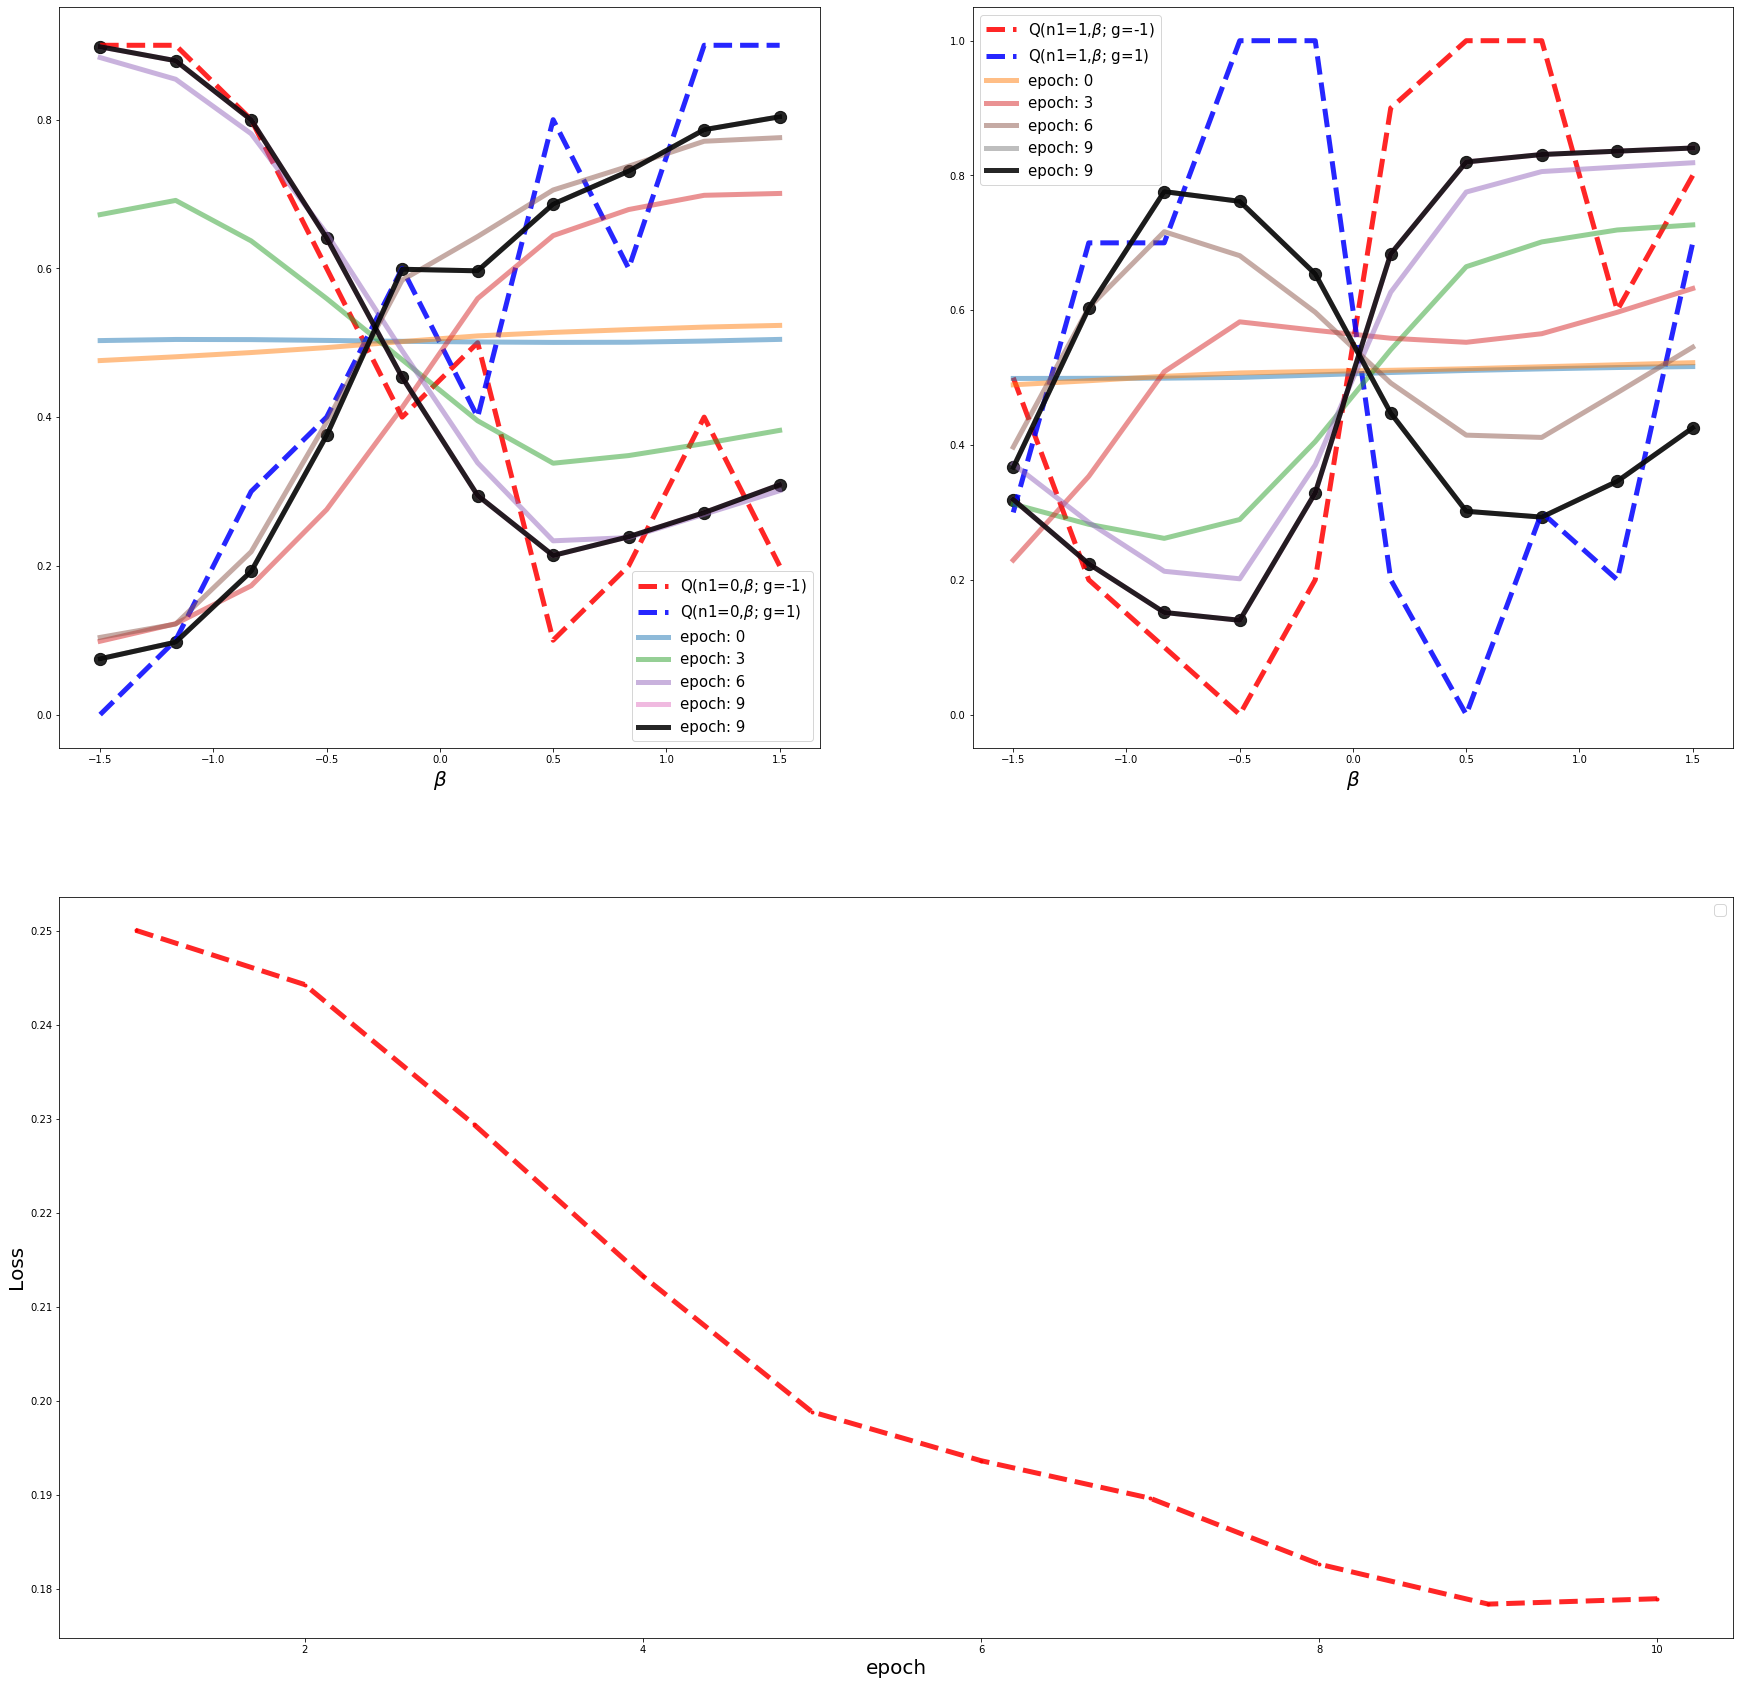

In [198]:
loss_ev, histo_preds, mean_values, differencesb1 = training(splits_over_size=1)
plot_results(histo_preds=histo_preds, mean_values=mean_values,loss=loss_ev)

## Now we test with batch_size of 2. ##

batch_size:  2


W0330 16:35:56.533425 140037898561344 legend.py:1282] No handles with labels found to put in legend.


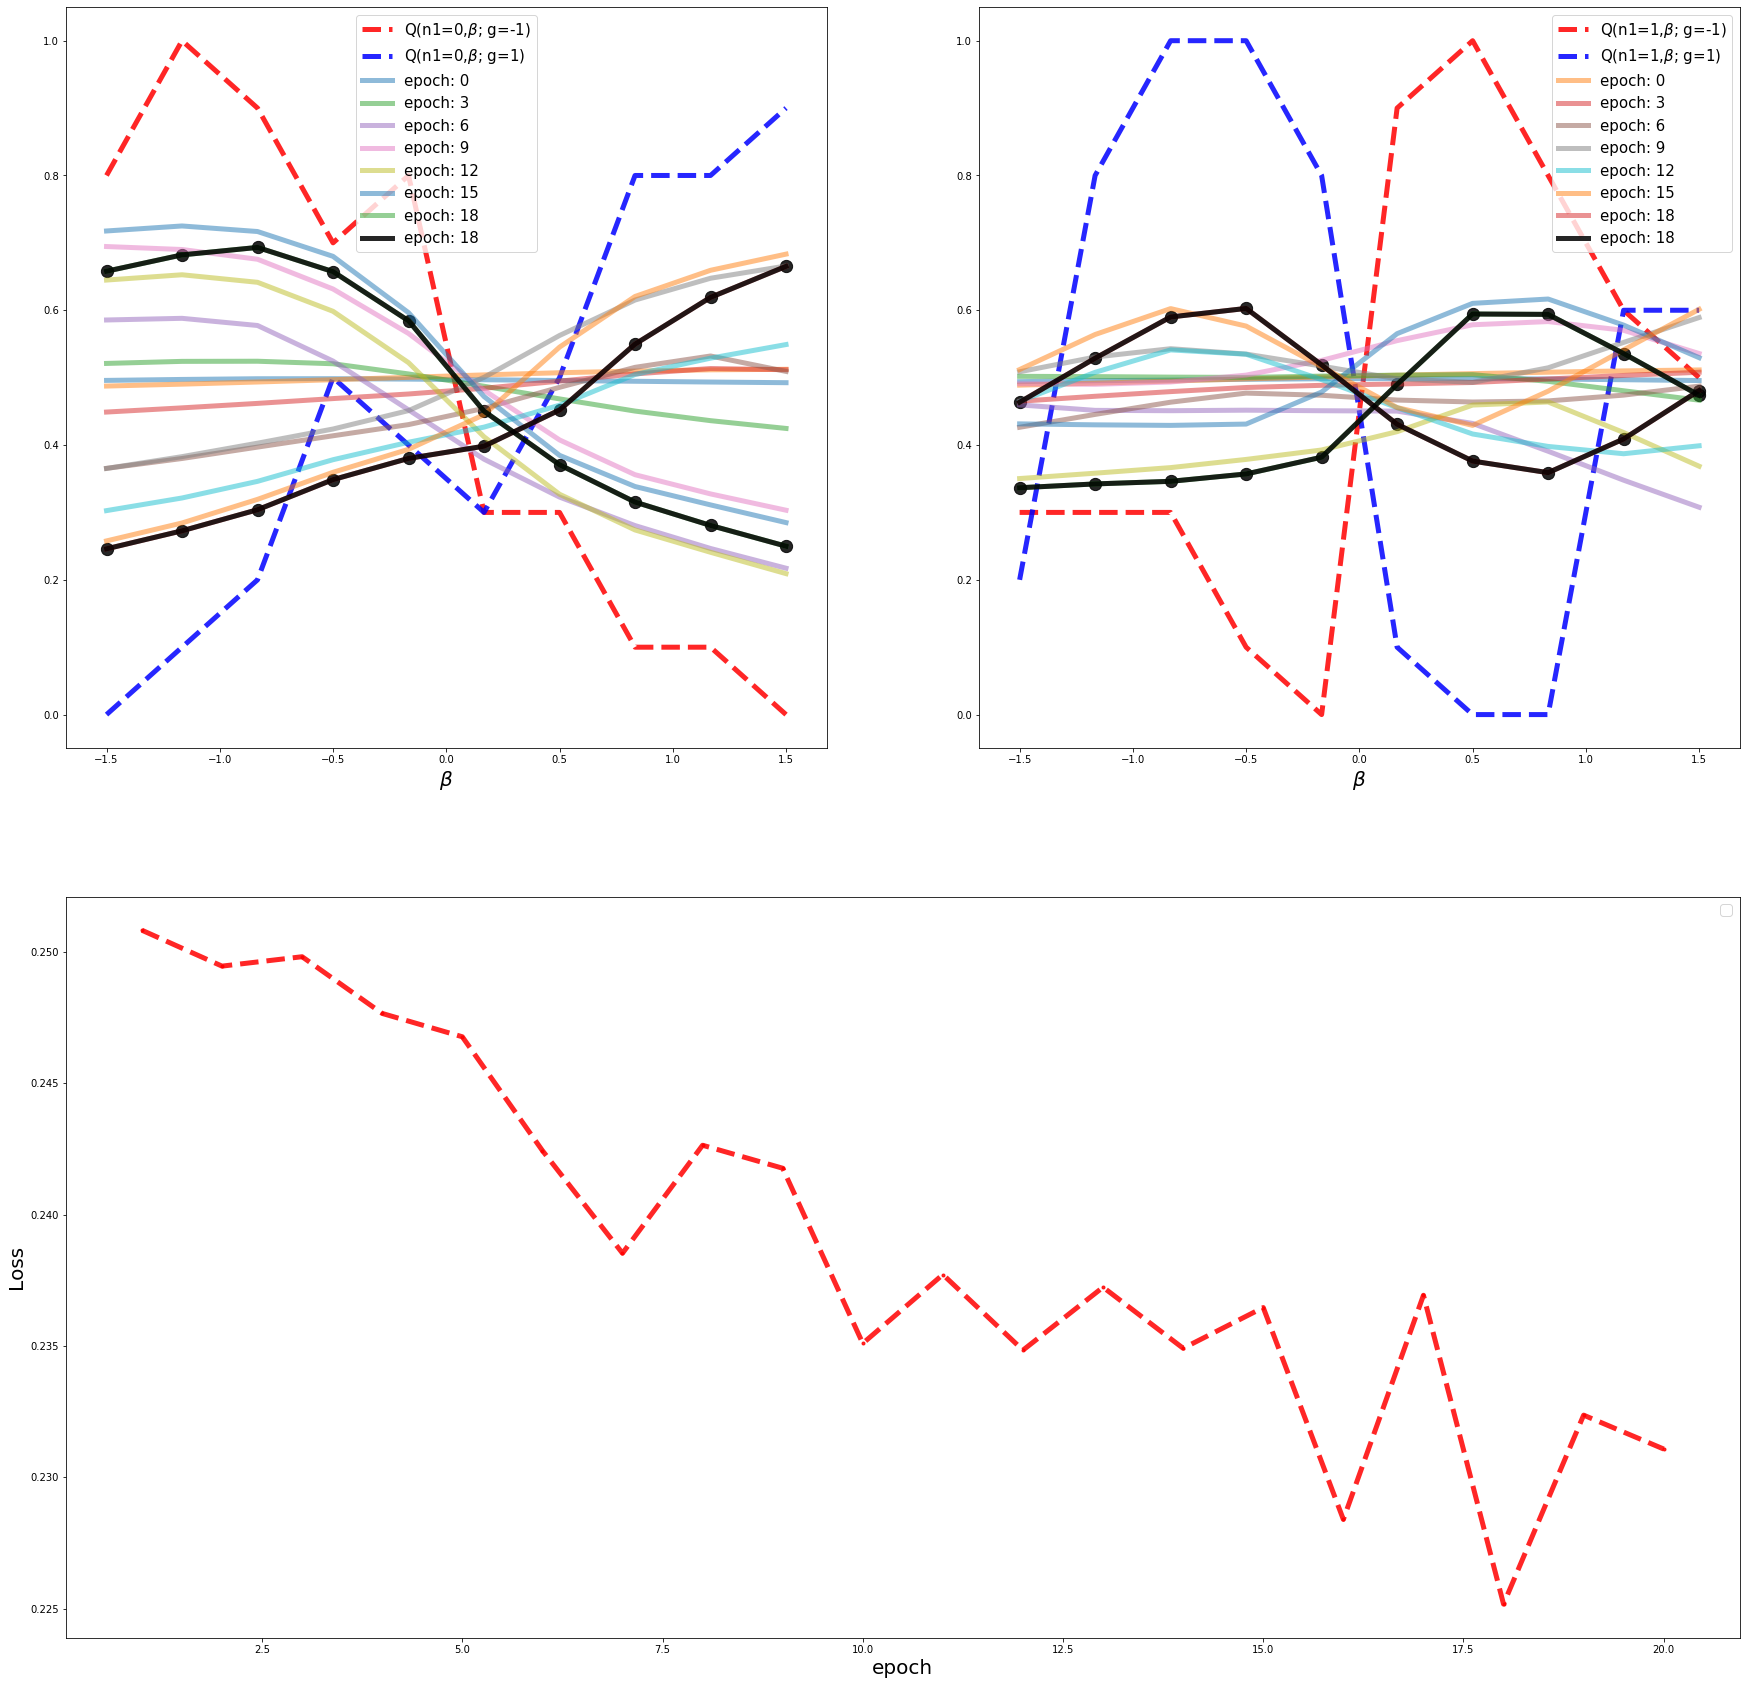

In [195]:
loss_ev, histo_preds, mean_values, differences = training(splits_over_size=2)
plot_results(histo_preds=histo_preds, mean_values=mean_values,loss=loss_ev)

In [200]:
differences_b2 = differences
differences_b2

[-0.6975315603264659,
 0.04132578334502954,
 -0.3455891186497753,
 -0.33055990825383974,
 -4.083305670860782,
 0.07687709417819583]

In [ ]:
## Now we test with batch_size of 4. ##

batch_size:  4


W0330 17:46:19.935860 140037898561344 legend.py:1282] No handles with labels found to put in legend.


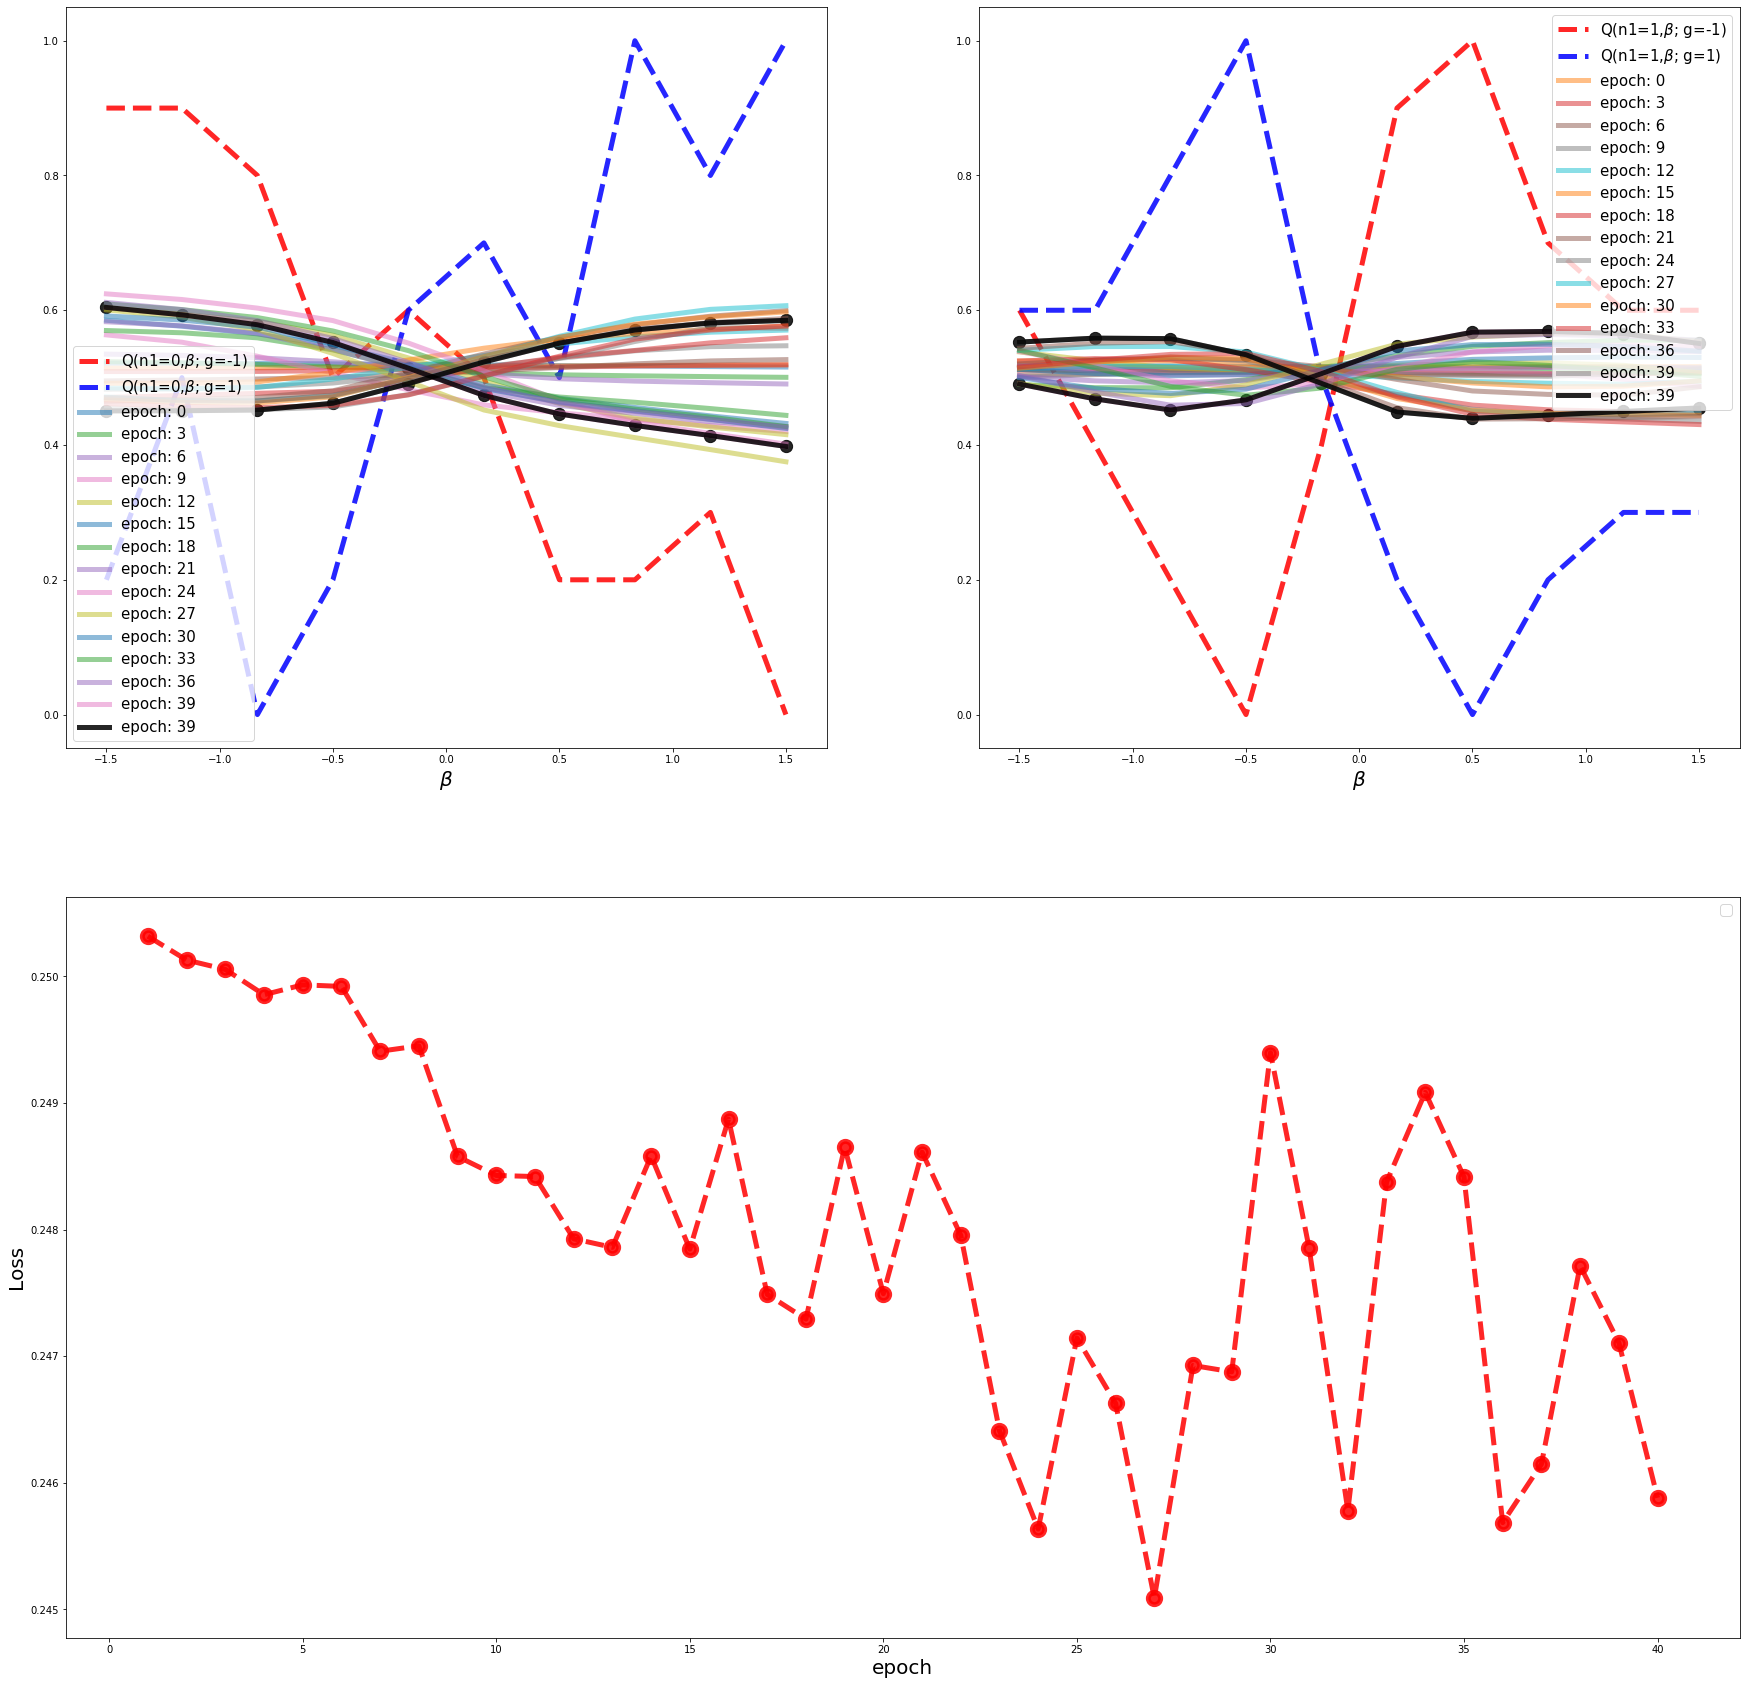

In [203]:
loss_ev, histo_preds, mean_values, differencesb4 = training(splits_over_size=4)
plot_results(histo_preds=histo_preds, mean_values=mean_values,loss=loss_ev)

In [189]:
differenceb4 = differences
differenceb4

[-2.9495878251202132,
 -6.586611663790664,
 0.15435300135556207,
 -3.3281695593558487,
 -2.6109330462007807,
 0.8515528799850467]

batch_size:  8


W0330 16:38:38.195740 140037898561344 legend.py:1282] No handles with labels found to put in legend.


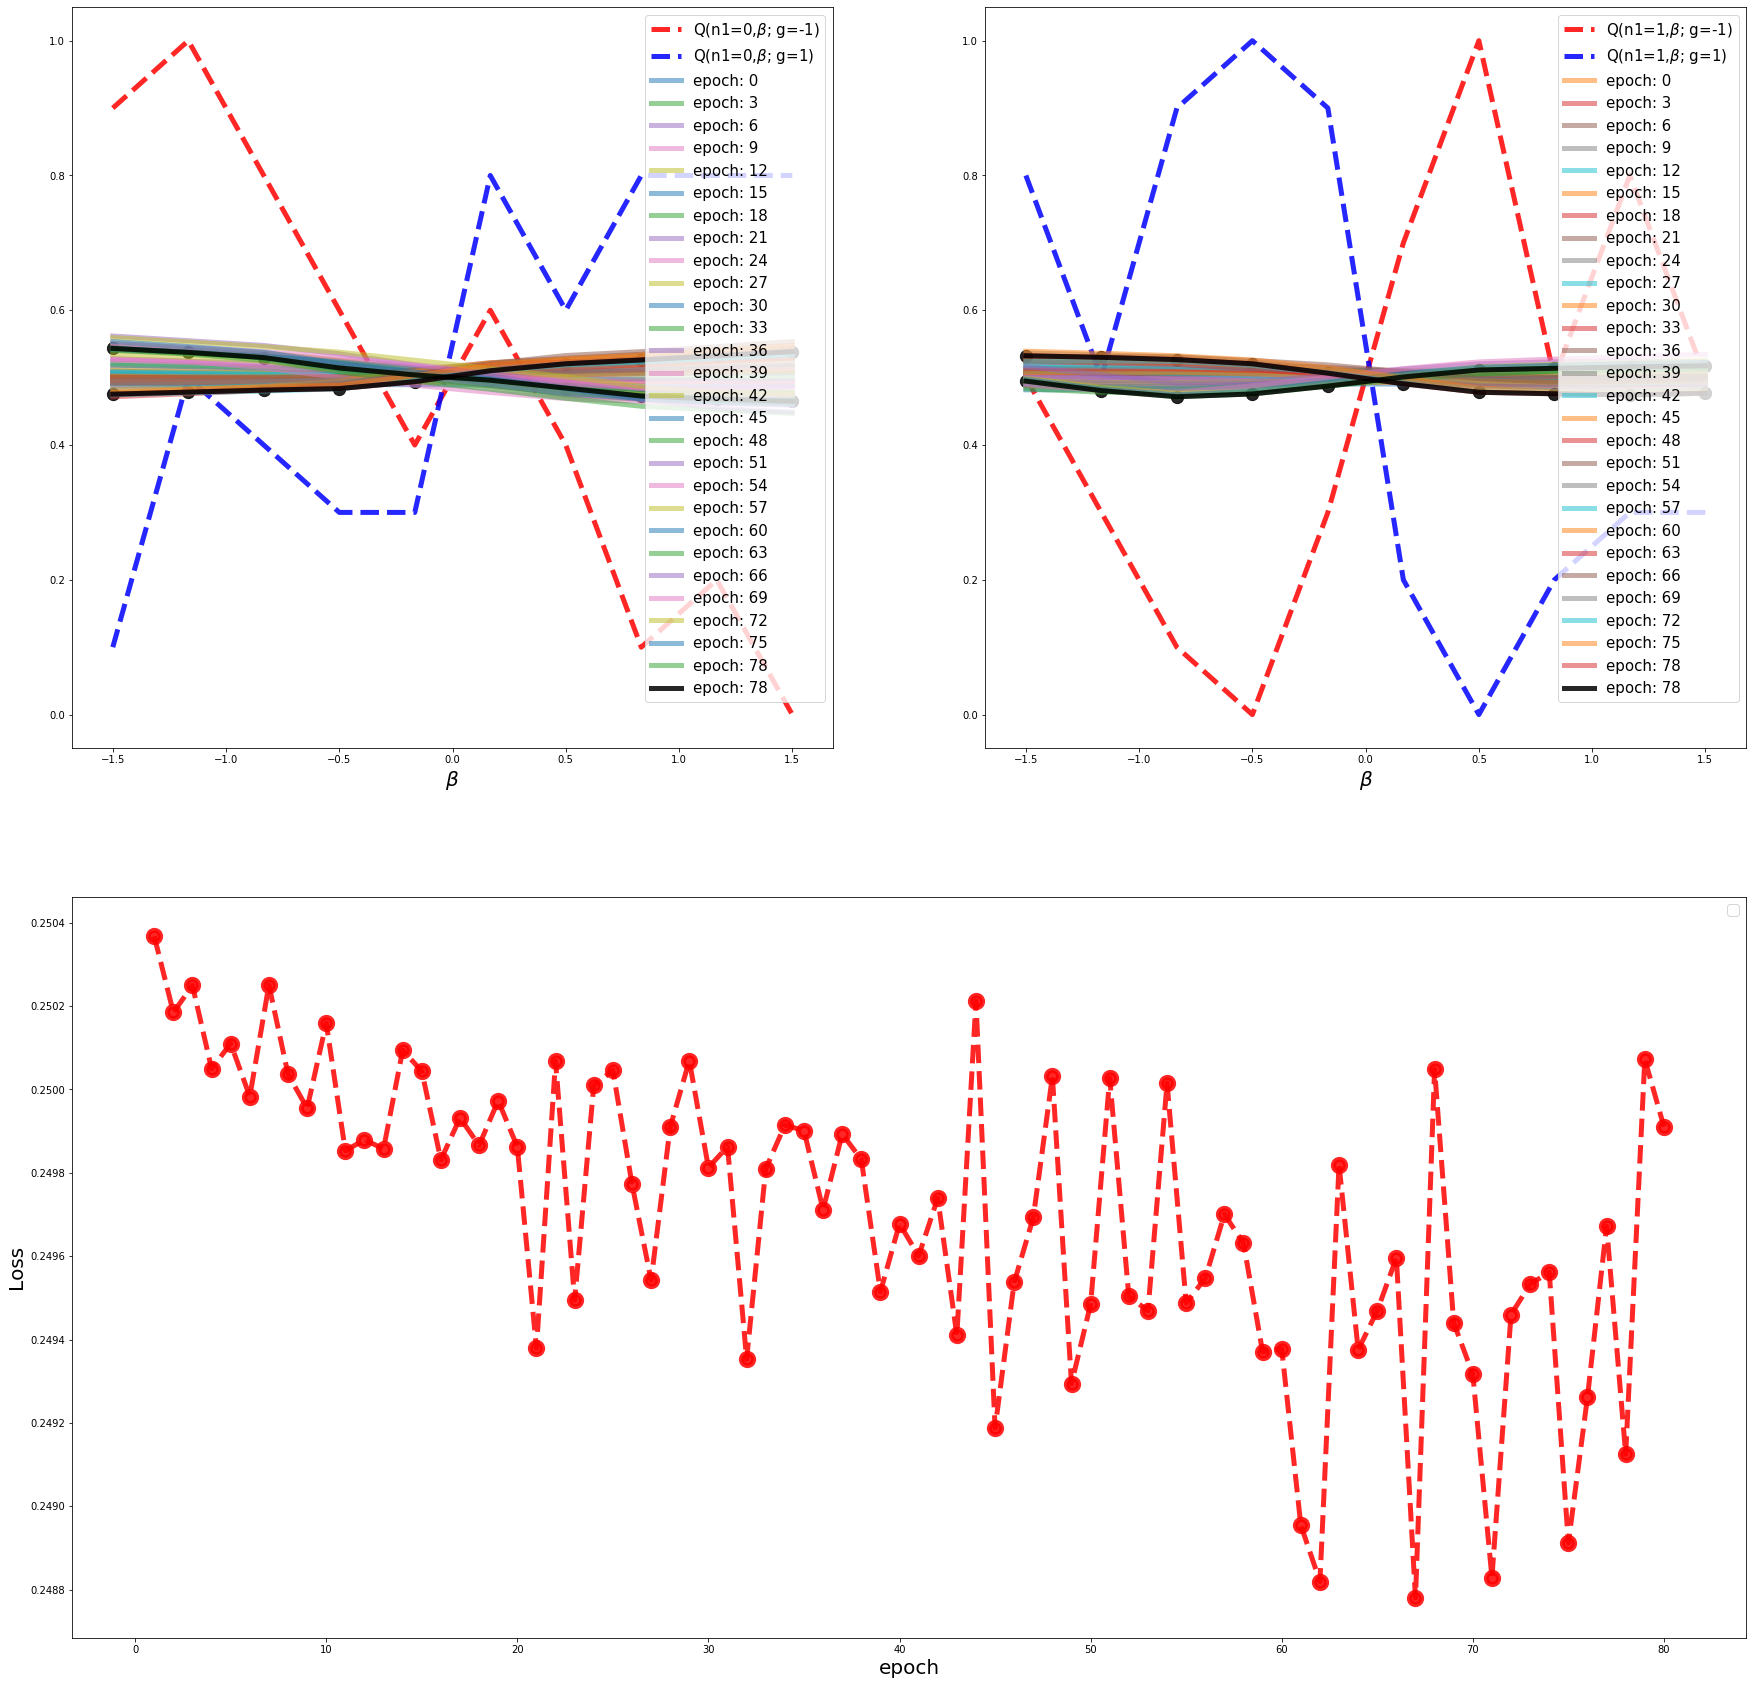

In [202]:
loss_ev, histo_preds, mean_values, differencesb8 = training(splits_over_size=8)
plot_results(histo_preds=histo_preds, mean_values=mean_values,loss=loss_ev)